In [ ]:
pip install pytorch-pretrained-biggan

In [ ]:
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,convert_to_images,
                                       save_as_images, display_in_terminal)

In [ ]:
# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
GAN_model = BigGAN.from_pretrained('biggan-deep-256')

100%|██████████| 715/715 [00:00<00:00, 1103358.12B/s]


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import torch
import numpy as np
import matplotlib as plt
import torch.nn as nn
from tqdm import tqdm
from torchvision.io import read_image

## Current

In [ ]:
### Class Containing Both Models ###
class MyEnsemble(torch.nn.Module):
    def __init__(self, GAN, classifier, preprocess):
        super(MyEnsemble, self).__init__()
        self.GAN = GAN
        self.classifier = classifier
        self.preprocess = preprocess
        self.iter = 0

    def adjust(self, output):
        save_as_images(output, file_name='Output'+str(self.iter))
        self.iter = self.iter + 1
        #img = torch.tensor(128*(1+output), dtype=torch.uint8)
        img0 = output
        return img0

    def forward(self, noise, img_class, truncation, save=True, ret_img=False):
        output = self.GAN(noise, img_class, truncation)
        if save:
          output = self.adjust(output)
        #img2 = self.preprocess(img)
        prediction = self.classifier(output).squeeze(0).softmax(0)

        if ret_img:
          return prediction, output
        else:
          return prediction +0

In [ ]:
def predict(model, noise_vector, class_vector, truncation, real_class, i=0, save=True, ret_img=False):
  if ret_img:
    prediction, output = model(noise_vector, class_vector, truncation, save, ret_img)
  else:
    prediction = model(noise_vector, class_vector, truncation, save)

  real_index = weights.meta["categories"].index(real_class)
  real_score = prediction[real_index].item()

  predicted_class = prediction.argmax().item()
  score = prediction[predicted_class].item()
  category_name = weights.meta["categories"][predicted_class]
  print(f"{i}:  {category_name}: {100 * score:.1f}%   |   {real_class}: {100 * real_score:.1f}%")

  if ret_img:
    return prediction, real_score, output
  else:
    return prediction, real_score

In [ ]:
### Load GAN Model ###

GAN_model = BigGAN.from_pretrained('biggan-deep-256')

from torchvision.models import resnet50, ResNet50_Weights

# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
classifier = resnet50(weights=weights)
classifier.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 48.8MB/s]


In [ ]:
### Initialize Noise Vector ###
classes = 'pillow'
real_class = weights.meta["categories"].index(classes)

# Prepare an input
truncation = 1
class_vector = torch.from_numpy(one_hot_from_names(classes, batch_size=1))
noise_vector = torch.from_numpy(truncated_noise_sample(truncation=truncation, batch_size=1)).requires_grad_()

In [ ]:
### Initialize Model ###
model = MyEnsemble(GAN_model, classifier, preprocess)
model.eval()

for param in model.parameters():
  param.requires_grad = False
prediction, _, orig_img = predict(model, noise_vector, class_vector, truncation, classes, ret_img=True)
orig_img = orig_img.clone().detach()

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([noise_vector], lr=0.01)

0:  pillow: 50.5%   |   pillow: 50.5%


In [ ]:
print(torch.linalg.vector_norm(img-orig_img, ord=2))
print(torch.linalg.vector_norm(img-orig_img, ord=float('inf')))
print(torch.linalg.vector_norm(img-orig_img, ord=0))
print(torch.linalg.vector_norm(nv-noise_vector))

tensor(383.3826, grad_fn=<LinalgVectorNormBackward0>)
tensor(1.9090, grad_fn=<LinalgVectorNormBackward0>)
tensor(196608., grad_fn=<LinalgVectorNormBackward0>)
tensor(27.8312, grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
### Find Cases Where Classifier Messes Up ### (Images don't fit class well)
while(torch.argmax(prediction)==real_class):
  noise_vector = torch.from_numpy(truncated_noise_sample(truncation=truncation, batch_size=1)).requires_grad_()
  prediction, _ = predict(model, noise_vector, class_vector, truncation, classes)

In [ ]:
### Print Top 3 Classes ###
a,b = prediction.sort(descending=True)
for i in range(3):
  print(weights.meta["categories"][b[i]], a[i].item())

pillow 0.5827870965003967
sleeping bag 0.004783586598932743
packet 0.002985346829518676


In [ ]:
nv = noise_vector.clone()

In [ ]:
print(nv.mean().item(), nv.std().item(), nv.max().item(), nv.min().item())
print(noise_vector.mean().item(), noise_vector.std().item(), noise_vector.max().item(), noise_vector.min().item())
print(torch.linalg.vector_norm(nv-noise_vector).item(), max(losses)-min(losses))

0.086910180747509 0.8481992483139038 1.9327253103256226 -1.88772451877594
0.06788785010576248 1.15211820602417 3.26883864402771 -2.9951975345611572
7.696720123291016 0.5903019905090332


In [ ]:
noise_vector = nv.clone().detach().requires_grad_()

In [ ]:
### Run Gradient Ascent (Single Image)###
start = 0
end = 30
lmbda = 2e-5
reg_type = 2
if start==0:
  scores = []
  losses = []
  tar_per = []
  top_cat = []
  top_per = []
  reg_vals = []

for i in range(start,end):
  prediction, score, img = predict(model, noise_vector, class_vector, truncation, classes, i, ret_img=True)
  l = -1*loss(prediction, class_vector.squeeze(0))
  reg = lmbda * torch.linalg.vector_norm(img-orig_img, ord = reg_type)
  #reg = lmbda * torch.linalg.vector_norm(nv-noise_vector)
  output = l + reg
  #output = -1*loss(prediction, class_vector.squeeze(0))
  #output = -1*loss(prediction, class_vector.squeeze(0)) + lmbda * torch.linalg.vector_norm(nv-noise_vector)
  #output = loss(prediction, tar) -1*loss(prediction, class_vector.squeeze(0))
  output.backward()
  optimizer.zero_grad
  optimizer.step()
  scores.append(score)
  losses.append(-1*l.item())
  reg_vals.append(reg.item())
  top_cat.append(weights.meta["categories"][torch.argmax(prediction)])
  top_per.append(prediction.max().item())


0:  pillow: 50.5%   |   pillow: 50.5%
1:  pillow: 19.8%   |   pillow: 19.8%
2:  pillow: 21.6%   |   pillow: 21.6%
3:  pillow: 21.0%   |   pillow: 21.0%
4:  pillow: 13.3%   |   pillow: 13.3%
5:  pillow: 2.7%   |   pillow: 2.7%
6:  quilt: 8.0%   |   pillow: 5.3%
7:  pillow: 13.2%   |   pillow: 13.2%
8:  pillow: 7.4%   |   pillow: 7.4%
9:  pillow: 7.9%   |   pillow: 7.9%
10:  pillow: 16.9%   |   pillow: 16.9%
11:  quilt: 19.7%   |   pillow: 15.4%
12:  pillow: 55.0%   |   pillow: 55.0%
13:  pillow: 31.2%   |   pillow: 31.2%
14:  pillow: 39.7%   |   pillow: 39.7%
15:  pillow: 43.3%   |   pillow: 43.3%
16:  pillow: 44.6%   |   pillow: 44.6%
17:  pillow: 32.3%   |   pillow: 32.3%
18:  pillow: 38.3%   |   pillow: 38.3%
19:  pillow: 39.4%   |   pillow: 39.4%
20:  pillow: 42.6%   |   pillow: 42.6%
21:  pillow: 19.1%   |   pillow: 19.1%
22:  purse: 5.2%   |   pillow: 2.9%
23:  purse: 17.9%   |   pillow: 1.1%
24:  Christmas stocking: 10.6%   |   pillow: 0.6%
25:  Christmas stocking: 12.4%   |   pi

In [ ]:
### Display GAN Outputs After Each Step ###
for i in range(0,30):
  image = plt.image.imread("/content/Output" + str(i) + "_0.png")
  #plt.pyplot.subplot(1,5,i+1)
  plt.pyplot.imshow(image)
  plt.pyplot.xticks([])
  plt.pyplot.yticks([])
  #plt.pyplot.xlabel(top_cat[5*j+i])
  plt.pyplot.title("iteration " + str(i) + ": " + top_cat[i])
  plt.pyplot.show()

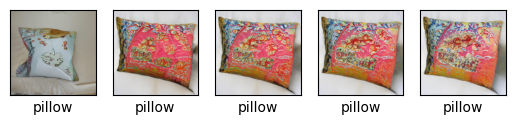

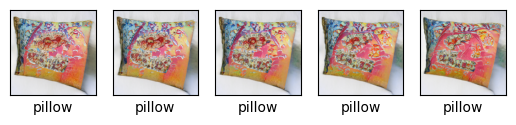

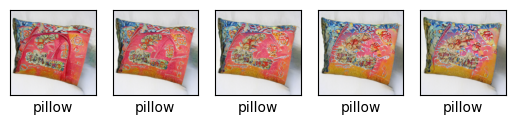

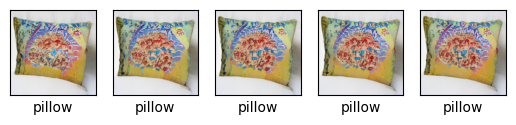

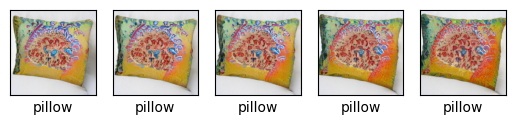

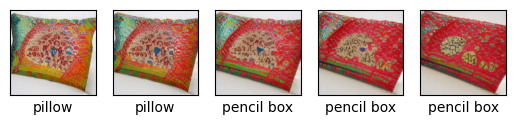

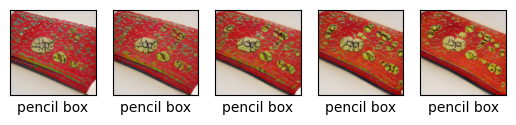

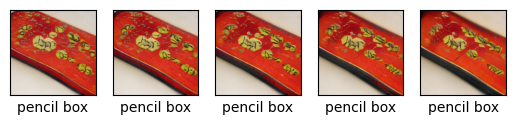

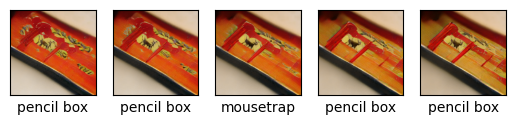

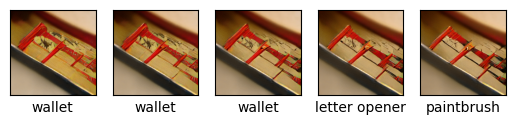

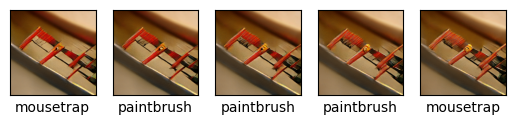

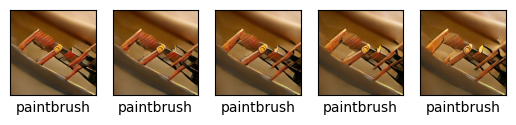

In [ ]:
### Display GAN Outputs After Each Step ###
#for j in [0,2,4,6,8,1,3,5,7,9]:
for j in range(12):
  for i in range(0,5):
    image = plt.image.imread("/content/Output" + str(5*j+i) + "_0.png")
    plt.pyplot.subplot(1,5,i+1)
    plt.pyplot.imshow(image)
    plt.pyplot.xticks([])
    plt.pyplot.yticks([])
    plt.pyplot.xlabel(top_cat[5*j+i])
    #plt.pyplot.title("iteration " + str(i))
  plt.pyplot.show()

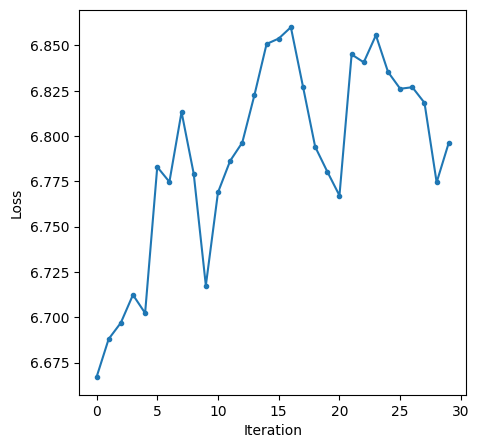

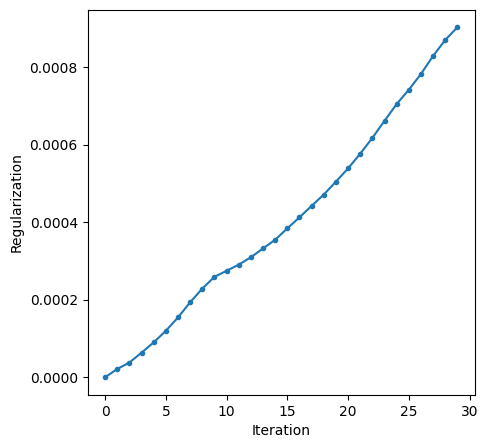

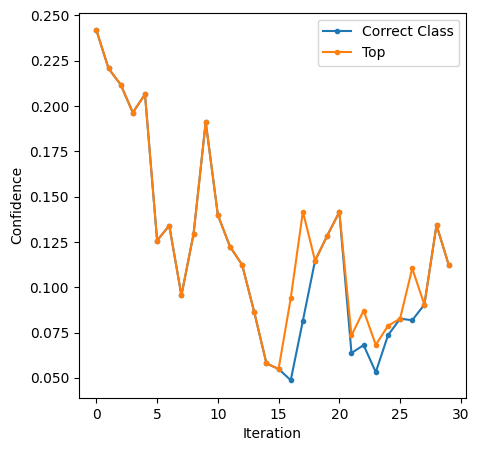

In [ ]:
fig, ax = plt.pyplot.subplots(figsize=(5, 5))
ax.plot(losses, '.-')
plt.pyplot.xlabel('Iteration')
plt.pyplot.ylabel('Loss')
plt.pyplot.show()

fig, ax = plt.pyplot.subplots(figsize=(5, 5))
ax.plot(reg_vals, '.-')
plt.pyplot.xlabel('Iteration')
plt.pyplot.ylabel('Regularization')
plt.pyplot.show()

fig, ax = plt.pyplot.subplots(figsize=(5, 5))
ax.plot(scores, '.-')
ax.plot(top_per, ".-")
plt.pyplot.xlabel('Iteration')
plt.pyplot.ylabel('Confidence')
#ax.axvspan(0, 27.5, color="green", alpha=0.3)
#ax.axvspan(7.5, 8.5, color="green", alpha=0.3)
#ax.axvspan(5.5, 7.5, color="red", alpha=0.3)
#ax.axvspan(8.5, 19.5, color="red", alpha=0.3)
#ax.axvspan(19.5, 23.5, color="blue", alpha=0.3)
#ax.axvspan(23.5, 24.5, color="purple", alpha=0.3)
plt.pyplot.legend(["Correct Class", "Top"])
plt.pyplot.show()

In [ ]:
noise_vector = torch.tensor([[-1.9468, -1.3774, -1.5698, -0.6709, -0.5408, -1.2798,  0.4542, -0.0978,
         -0.1474, -0.5195,  1.0539, -1.1832,  1.7108,  0.2988, -0.4507,  1.1964,
          0.1439, -0.1175, -0.4309, -0.8817, -1.3216, -0.8299, -0.5715, -0.2817,
         -0.2551,  0.3920,  1.3203, -1.6562,  0.5647,  1.1451,  0.3670, -0.1116,
         -0.7108,  0.5480, -0.8512, -1.4231,  1.4265, -1.5952, -0.2584,  1.4835,
         -0.0882,  0.0416,  0.0603,  0.4737, -0.5702,  1.3127,  0.4520, -0.7216,
          1.0811,  1.3573,  0.1013, -0.7440, -1.0203,  0.1272, -1.0374, -1.1088,
         -0.7137,  1.0214,  1.8661, -1.5403,  1.3310,  1.9602,  1.3399, -1.0128,
          0.0364,  1.3389, -0.6211, -0.0917,  0.4659, -0.1452,  0.6036, -0.1441,
          0.9446, -0.8241, -0.7763,  0.7340,  1.1100,  0.2157,  0.3223,  1.6473,
         -0.1729,  0.2920, -0.1993,  1.5514, -0.9106,  0.1651,  0.5283,  0.1373,
          0.3705, -0.5360, -0.0728,  1.4181, -0.3912,  1.2707,  0.8225,  0.4877,
          1.0473, -1.0720,  0.1480,  1.0303, -0.0851, -0.2338, -0.3570,  1.0252,
          0.9420, -0.2532,  0.5383, -0.6721, -0.2371,  0.0197,  0.1215, -0.1335,
         -0.6147,  0.3966, -0.7808,  0.2481,  0.3278, -0.2630, -0.0666,  1.0552,
          0.3363, -1.4687, -1.2921, -0.2853,  0.2250,  0.9311, -0.6030,  0.1592]],
       requires_grad=True)

In [ ]:
### Run Gradient Ascent (Multiple Iterations)###
n = 100
iters = 30
start = 0

truncation = 1
classes = "palace"
real_class = weights.meta["categories"].index(classes)
class_vector = torch.from_numpy(one_hot_from_names(classes, batch_size=1))

model = MyEnsemble(GAN_model, classifier, preprocess)
model.eval()
for param in model.parameters():
  param.requires_grad = False

if(start==0):
  scores = torch.zeros([n,iters*2])
  losses = torch.zeros([n,iters*2])
  top_cat = torch.zeros([n,iters*2])
  top_per = torch.zeros([n,iters*2])

for j in range(start,n):
  print("------------ Iteration",j,"------------")
  noise_vector = torch.from_numpy(truncated_noise_sample(truncation=truncation, batch_size=1)).requires_grad_()
  optimizer = torch.optim.SGD([noise_vector], lr=0.01)
  loss = nn.CrossEntropyLoss()

  for i in range(iters):
    prediction, score = predict(model, noise_vector, class_vector, truncation, classes, i, save=False)
    output = -1*loss(prediction, class_vector.squeeze(0))
    #output = loss(prediction, eq)
    #output = loss(prediction, tar) -1*loss(prediction, class_vector.squeeze(0))
    output.backward()
    optimizer.zero_grad
    optimizer.step()

    scores[j,i] = score
    losses[j,i] = -1*output.item()
    top_cat[j,i] = torch.argmax(prediction)
    top_per[j,i] = prediction.max().item()

  if top_cat[j,24]== real_class:
    for i in range(iters, 2*iters):
      prediction, score = predict(model, noise_vector, class_vector, truncation, classes, i, save=False)
      output = -1*loss(prediction, class_vector.squeeze(0))
      #output = loss(prediction, eq)
      #output = loss(prediction, tar) -1*loss(prediction, class_vector.squeeze(0))
      output.backward()
      optimizer.zero_grad
      optimizer.step()

      scores[j,i] = score
      losses[j,i] = -1*output.item()
      top_cat[j,i] = torch.argmax(prediction)
      top_per[j,i] = prediction.max().item()
  else:
      losses[j,iters:2*iters] = losses[j,iters-1]
      scores[j,iters:2*iters] = scores[j,iters-1]
      top_per[j,iters:2*iters] = top_per[j,iters-1]
      top_cat[j,iters:2*iters] = top_cat[j,iters-1]


------------ Iteration 0 ------------
0:  palace: 11.7%   |   palace: 11.7%
1:  palace: 8.9%   |   palace: 8.9%
2:  palace: 6.6%   |   palace: 6.6%
3:  palace: 11.6%   |   palace: 11.6%
4:  palace: 14.3%   |   palace: 14.3%
5:  palace: 10.1%   |   palace: 10.1%
6:  palace: 7.3%   |   palace: 7.3%
7:  palace: 24.1%   |   palace: 24.1%
8:  palace: 43.7%   |   palace: 43.7%
9:  palace: 32.4%   |   palace: 32.4%
10:  palace: 30.7%   |   palace: 30.7%
11:  palace: 25.8%   |   palace: 25.8%
12:  palace: 30.9%   |   palace: 30.9%
13:  palace: 27.0%   |   palace: 27.0%
14:  palace: 14.6%   |   palace: 14.6%
15:  palace: 22.1%   |   palace: 22.1%
16:  palace: 14.5%   |   palace: 14.5%
17:  warplane: 4.0%   |   palace: 1.7%
18:  palace: 7.1%   |   palace: 7.1%
19:  pier: 3.4%   |   palace: 1.6%
20:  pier: 5.7%   |   palace: 2.0%
21:  pier: 8.2%   |   palace: 0.5%
22:  pier: 3.2%   |   palace: 0.2%
23:  pier: 7.2%   |   palace: 0.3%
24:  patio: 14.0%   |   palace: 1.1%
25:  umbrella: 2.5%   |   p

In [ ]:
### Run Gradient Ascent (Multiple Iterations With Regulation)###
n = 100
iters = 30
start = 90
end = 100
lmbda = 2e-4
reg_type = 2
lr=0.01

truncation = 1
classes = "pillow"
real_class = weights.meta["categories"].index(classes)
class_vector = torch.from_numpy(one_hot_from_names(classes, batch_size=1))

model = MyEnsemble(GAN_model, classifier, preprocess)
model.eval()
for param in model.parameters():
  param.requires_grad = False

if(start==0):
  scores = torch.zeros([n,iters*2])
  losses = torch.zeros([n,iters*2])
  top_cat = torch.zeros([n,iters*2])
  top_per = torch.zeros([n,iters*2])
  reg_vals = torch.zeros([n,iters*2])

for j in range(start,end):
  print("------------ Iteration",j,"------------")
  noise_vector = torch.from_numpy(truncated_noise_sample(truncation=truncation, batch_size=1)).requires_grad_()
  optimizer = torch.optim.SGD([noise_vector], lr=lr)
  loss = nn.CrossEntropyLoss()
  prediction, _, orig_img = predict(model, noise_vector, class_vector, truncation, classes, save=False, ret_img=True)
  orig_img = orig_img.clone().detach()

  for i in range(iters):
    prediction, score, img = predict(model, noise_vector, class_vector, truncation, classes, i, save=False, ret_img=True)
    l = -1*loss(prediction, class_vector.squeeze(0))
    reg = lmbda * torch.linalg.vector_norm(img-orig_img, ord = reg_type)
    output = l + reg
    output.backward()
    optimizer.zero_grad
    optimizer.step()

    scores[j,i] = score
    losses[j,i] = -1*l.item()
    reg_vals[j,i] = reg.item()
    top_cat[j,i] = torch.argmax(prediction)
    top_per[j,i] = prediction.max().item()

  if scores[j,24]>0.01:
    for i in range(iters, 2*iters):
      prediction, score, img = predict(model, noise_vector, class_vector, truncation, classes, i, ret_img=True)
      l = -1*loss(prediction, class_vector.squeeze(0))
      reg = lmbda * torch.linalg.vector_norm(img-orig_img, ord = reg_type)
      output = l + reg
      output.backward()
      optimizer.zero_grad
      optimizer.step()

      scores[j,i] = score
      losses[j,i] = -1*l.item()
      reg_vals[j,i] = reg.item()
      top_cat[j,i] = torch.argmax(prediction)
      top_per[j,i] = prediction.max().item()
  else:
      losses[j,iters:2*iters] = losses[j,iters-1]
      scores[j,iters:2*iters] = scores[j,iters-1]
      reg_vals[j,iters:2*iters] = reg_vals[j,iters-1]
      top_per[j,iters:2*iters] = top_per[j,iters-1]
      top_cat[j,iters:2*iters] = top_cat[j,iters-1]

------------ Iteration 90 ------------
0:  pillow: 61.8%   |   pillow: 61.8%
0:  pillow: 61.8%   |   pillow: 61.8%
1:  pillow: 60.7%   |   pillow: 60.7%
2:  pillow: 63.1%   |   pillow: 63.1%
3:  pillow: 63.2%   |   pillow: 63.2%
4:  pillow: 56.8%   |   pillow: 56.8%
5:  pillow: 52.2%   |   pillow: 52.2%
6:  pillow: 55.1%   |   pillow: 55.1%
7:  pillow: 62.6%   |   pillow: 62.6%
8:  pillow: 61.7%   |   pillow: 61.7%
9:  pillow: 64.8%   |   pillow: 64.8%
10:  pillow: 64.5%   |   pillow: 64.5%
11:  pillow: 69.4%   |   pillow: 69.4%
12:  pillow: 69.8%   |   pillow: 69.8%
13:  pillow: 66.9%   |   pillow: 66.9%
14:  pillow: 58.1%   |   pillow: 58.1%
15:  pillow: 75.9%   |   pillow: 75.9%
16:  pillow: 68.3%   |   pillow: 68.3%
17:  pillow: 51.1%   |   pillow: 51.1%
18:  pillow: 57.9%   |   pillow: 57.9%
19:  pillow: 68.0%   |   pillow: 68.0%
20:  pillow: 54.2%   |   pillow: 54.2%
21:  pillow: 62.3%   |   pillow: 62.3%
22:  pillow: 38.4%   |   pillow: 38.4%
23:  pillow: 26.6%   |   pillow: 26.

In [ ]:
torch.set_printoptions(profile="full")
print("losses = torch.",losses) # prints the whole tensor
print("\n\n\n\n\n######################################################################")

print("scores = torch.",scores) # prints the whole tensor
print("\n\n\n\n\n######################################################################")

print("top_per = torch.",top_per) # prints the whole tensor
print("\n\n\n\n\n######################################################################")

print("top_cat = torch.",top_cat) # prints the whole tensor
print("\n\n\n\n\n######################################################################")

print("reg_vals = torch.",reg_vals) # prints the whole tensor
print("\n\n\n\n\n######################################################################")


losses = torch. tensor([[6.3120, 6.3029, 6.4033, 6.3787, 6.3354, 6.2528, 6.2025, 6.2248, 6.2046,
         6.1955, 6.1872, 6.2103, 6.2341, 6.2912, 6.2383, 6.2762, 6.2865, 6.2628,
         6.3103, 6.3036, 6.2669, 6.3075, 6.2597, 6.2601, 6.3951, 6.4427, 6.5055,
         6.3931, 6.4295, 6.4176, 6.4107, 6.5087, 6.4227, 6.4539, 6.3774, 6.3870,
         6.5548, 6.7291, 6.7547, 6.8396, 6.8121, 6.8198, 6.8670, 6.8722, 6.8907,
         6.8768, 6.8775, 6.8985, 6.9064, 6.9046, 6.9049, 6.9033, 6.9044, 6.9051,
         6.9050, 6.8993, 6.9064, 6.9067, 6.9058, 6.9047],
        [6.6554, 6.7043, 6.6413, 6.6806, 6.5681, 6.6104, 6.6728, 6.6061, 6.6393,
         6.6119, 6.5401, 6.7643, 6.8768, 6.9037, 6.9079, 6.9080, 6.9077, 6.9080,
         6.9081, 6.9080, 6.9074, 6.9080, 6.9079, 6.9081, 6.9083, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.

### Data Agregation

In [ ]:
l = torch. tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [6.7008, 6.7062, 6.7655, 6.7533, 6.7363, 6.7970, 6.7878, 6.7826, 6.7433,
         6.7482, 6.7311, 6.7152, 6.7476, 6.7545, 6.6521, 6.7462, 6.7072, 6.6459,
         6.7821, 6.8142, 6.8630, 6.8935, 6.8522, 6.8860, 6.9015, 6.8826, 6.8951,
         6.8729, 6.8981, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887,
         6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887,
         6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887,
         6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887],
        [6.7206, 6.6480, 6.6376, 6.7231, 6.6613, 6.7344, 6.7541, 6.6723, 6.6345,
         6.5561, 6.6725, 6.6753, 6.6651, 6.6733, 6.4679, 6.5127, 6.4085, 6.4415,
         6.5038, 6.4984, 6.5120, 6.6492, 6.6710, 6.6454, 6.8278, 6.8688, 6.8774,
         6.8910, 6.8828, 6.8702, 6.8929, 6.8944, 6.9019, 6.9026, 6.8866, 6.8971,
         6.9008, 6.9050, 6.9030, 6.9016, 6.9046, 6.9067, 6.9075, 6.9076, 6.9080,
         6.9074, 6.9068, 6.9072, 6.9067, 6.9078, 6.9081, 6.9077, 6.9079, 6.9077,
         6.9078, 6.9076, 6.9073, 6.9071, 6.9074, 6.9076],
        [6.2131, 6.1876, 6.2397, 6.2212, 6.2368, 6.2508, 6.2374, 6.2342, 6.2470,
         6.1938, 6.2312, 6.2649, 6.2346, 6.2177, 6.2284, 6.2359, 6.3832, 6.4315,
         6.2927, 6.3927, 6.4900, 6.4540, 6.4540, 6.2697, 6.4827, 6.8226, 6.8171,
         6.7335, 6.8180, 6.9017, 6.9060, 6.9027, 6.9063, 6.9072, 6.9074, 6.9074,
         6.9073, 6.9077, 6.9079, 6.9073, 6.9076, 6.9080, 6.9075, 6.9073, 6.9076,
         6.9071, 6.9071, 6.9079, 6.9076, 6.9075, 6.9079, 6.9079, 6.9078, 6.9080,
         6.9071, 6.9076, 6.9071, 6.9080, 6.9080, 6.9078],
        [6.7657, 6.8090, 6.8446, 6.8249, 6.8093, 6.8314, 6.8565, 6.8598, 6.8831,
         6.8809, 6.8869, 6.8815, 6.8829, 6.8793, 6.8907, 6.8852, 6.8721, 6.8819,
         6.8822, 6.8820, 6.8749, 6.8751, 6.8750, 6.8975, 6.8956, 6.8726, 6.9011,
         6.8913, 6.8797, 6.8836, 6.8765, 6.8702, 6.8778, 6.8854, 6.8698, 6.8915,
         6.8546, 6.8686, 6.8932, 6.9058, 6.9070, 6.9069, 6.9069, 6.9069, 6.9066,
         6.9061, 6.9069, 6.9070, 6.9072, 6.9076, 6.9079, 6.9071, 6.9074, 6.9074,
         6.9071, 6.9076, 6.9074, 6.9079, 6.9078, 6.9074],
        [6.3129, 6.3362, 6.3371, 6.3894, 6.2807, 6.2506, 6.3429, 6.4320, 6.3849,
         6.4370, 6.3229, 6.3052, 6.2818, 6.2793, 6.3045, 6.3816, 6.3067, 6.3530,
         6.3547, 6.2761, 6.2903, 6.3439, 6.3608, 6.2972, 6.3132, 6.3847, 6.4497,
         6.3908, 6.3994, 6.4721, 6.4364, 6.4098, 6.3942, 6.3465, 6.6510, 6.6549,
         6.6361, 6.6235, 6.5876, 6.8488, 6.8568, 6.8723, 6.9026, 6.9028, 6.9034,
         6.9071, 6.9079, 6.9079, 6.9073, 6.9072, 6.9068, 6.9076, 6.9078, 6.9078,
         6.9069, 6.9071, 6.9019, 6.9073, 6.9064, 6.9030],
        [6.6435, 6.8814, 6.8338, 6.8789, 6.9003, 6.9021, 6.9027, 6.8968, 6.9068,
         6.9054, 6.9077, 6.9076, 6.9069, 6.9057, 6.9068, 6.9043, 6.9053, 6.9005,
         6.9054, 6.9045, 6.9076, 6.9060, 6.9066, 6.9051, 6.9051, 6.9069, 6.9072,
         6.9044, 6.9044, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055,
         6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055,
         6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055,
         6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055],
        [6.8119, 6.8341, 6.8370, 6.8127, 6.8639, 6.7879, 6.8525, 6.8965, 6.8595,
         6.9063, 6.8827, 6.8942, 6.8641, 6.9041, 6.9036, 6.9075, 6.9078, 6.9076,
         6.9079, 6.9084, 6.9084, 6.9082, 6.9074, 6.9079, 6.9080, 6.9080, 6.9080,
         6.9079, 6.9080, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077],
        [6.9069, 6.9069, 6.9064, 6.9066, 6.9068, 6.9068, 6.9069, 6.9066, 6.9066,
         6.9071, 6.9071, 6.9070, 6.9069, 6.9070, 6.9073, 6.9065, 6.9071, 6.9074,
         6.9074, 6.9074, 6.9071, 6.9068, 6.9073, 6.9072, 6.9071, 6.9071, 6.9071,
         6.9075, 6.9069, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070],
        [6.8257, 6.8372, 6.7766, 6.7803, 6.6624, 6.4996, 6.5832, 6.4132, 6.3978,
         6.3795, 6.3871, 6.3146, 6.3648, 6.3479, 6.3318, 6.3154, 6.3189, 6.5306,
         6.4338, 6.5089, 6.4818, 6.4793, 6.4052, 6.5116, 6.4853, 6.3853, 6.5104,
         6.6748, 6.7683, 6.6659, 6.6286, 6.6256, 6.6368, 6.6150, 6.5904, 6.6461,
         6.8152, 6.7985, 6.8365, 6.8300, 6.8370, 6.8718, 6.8844, 6.8767, 6.8752,
         6.8699, 6.8558, 6.8643, 6.8826, 6.8786, 6.8864, 6.8849, 6.8875, 6.8878,
         6.8990, 6.8975, 6.8915, 6.9000, 6.9006, 6.8999],
        [6.4845, 6.5968, 6.6511, 6.6294, 6.5239, 6.5632, 6.5983, 6.6257, 6.5169,
         6.4902, 6.5254, 6.4421, 6.4839, 6.6057, 6.5396, 6.5228, 6.5574, 6.5771,
         6.5512, 6.5223, 6.5407, 6.4448, 6.3536, 6.2710, 6.3630, 6.4557, 6.7711,
         6.7235, 6.8030, 6.8362, 6.7734, 6.8608, 6.8828, 6.8498, 6.8158, 6.8297,
         6.8422, 6.8356, 6.8336, 6.8512, 6.8296, 6.8610, 6.8618, 6.8428, 6.8232,
         6.8205, 6.8168, 6.8375, 6.8513, 6.8680, 6.8794, 6.8847, 6.8737, 6.8764,
         6.8871, 6.8857, 6.8692, 6.8713, 6.8874, 6.8919],
        [6.2805, 6.3581, 6.2956, 6.3341, 6.3744, 6.5588, 6.4021, 6.6907, 6.8826,
         6.8908, 6.9074, 6.9019, 6.9008, 6.8999, 6.9031, 6.9013, 6.9064, 6.9069,
         6.9077, 6.9078, 6.9078, 6.9075, 6.9078, 6.9075, 6.9078, 6.9076, 6.9076,
         6.9063, 6.9069, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066,
         6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066,
         6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066,
         6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066],
        [6.7499, 6.7881, 6.6176, 6.8232, 6.5784, 6.6542, 6.6086, 6.6841, 6.5314,
         6.4414, 6.5564, 6.3956, 6.4008, 6.4110, 6.3267, 6.2957, 6.3200, 6.4869,
         6.4641, 6.4549, 6.6600, 6.6172, 6.4844, 6.5217, 6.5687, 6.6961, 6.6493,
         6.6794, 6.7672, 6.8406, 6.8249, 6.8533, 6.8612, 6.8604, 6.8522, 6.7897,
         6.8256, 6.8231, 6.7853, 6.8240, 6.8767, 6.8611, 6.8691, 6.8555, 6.8764,
         6.8929, 6.8883, 6.8850, 6.8916, 6.8933, 6.8963, 6.9026, 6.9041, 6.9044,
         6.9035, 6.9042, 6.9045, 6.9056, 6.9048, 6.9031],
        [6.8829, 6.8925, 6.8870, 6.8902, 6.8903, 6.8864, 6.8903, 6.8877, 6.8928,
         6.8886, 6.8916, 6.8882, 6.8894, 6.8923, 6.8899, 6.8673, 6.8876, 6.8767,
         6.8932, 6.8976, 6.8839, 6.8927, 6.8988, 6.9019, 6.8970, 6.8965, 6.8916,
         6.8997, 6.9012, 6.9026, 6.9009, 6.8982, 6.9036, 6.9041, 6.9023, 6.9036,
         6.9044, 6.9042, 6.9035, 6.9020, 6.8997, 6.9026, 6.9020, 6.8984, 6.9013,
         6.8989, 6.8929, 6.9004, 6.9007, 6.8991, 6.9016, 6.9026, 6.8991, 6.9015,
         6.8984, 6.8996, 6.8987, 6.8995, 6.8986, 6.8972],
        [6.6513, 6.6510, 6.7957, 6.7583, 6.7796, 6.8572, 6.8830, 6.9017, 6.9061,
         6.9059, 6.9068, 6.9073, 6.9079, 6.9079, 6.9071, 6.9082, 6.9082, 6.9081,
         6.9073, 6.9071, 6.9074, 6.9069, 6.9079, 6.9075, 6.9077, 6.9074, 6.9079,
         6.9076, 6.9075, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077],
        [6.8871, 6.8873, 6.8933, 6.8982, 6.8877, 6.8912, 6.8870, 6.8733, 6.8456,
         6.8541, 6.8962, 6.9005, 6.8963, 6.8987, 6.8980, 6.9021, 6.9015, 6.9052,
         6.9065, 6.9046, 6.8985, 6.8991, 6.9036, 6.9027, 6.9039, 6.9033, 6.9040,
         6.9024, 6.9015, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942,
         6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942,
         6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942,
         6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])





######################################################################
s = torch. tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0802e-01, 2.0260e-01, 1.4326e-01, 1.5544e-01, 1.7252e-01, 1.1178e-01,
         1.2100e-01, 1.2620e-01, 1.6550e-01, 1.6057e-01, 1.7764e-01, 1.9353e-01,
         1.6113e-01, 1.5426e-01, 2.5673e-01, 1.6254e-01, 2.0158e-01, 2.6286e-01,
         1.2664e-01, 9.4583e-02, 4.5757e-02, 1.5271e-02, 5.6543e-02, 2.2745e-02,
         7.2164e-03, 2.6133e-02, 1.3635e-02, 3.5861e-02, 1.0675e-02, 2.0039e-02,
         2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02,
         2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02,
         2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02,
         2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02,
         2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02],
        [1.8813e-01, 2.6076e-01, 2.7116e-01, 1.8571e-01, 2.4744e-01, 1.7438e-01,
         1.5469e-01, 2.3644e-01, 2.7428e-01, 3.5277e-01, 2.3628e-01, 2.3346e-01,
         2.4370e-01, 2.3545e-01, 4.4098e-01, 3.9616e-01, 5.0042e-01, 4.6741e-01,
         4.0505e-01, 4.1042e-01, 3.9686e-01, 2.5959e-01, 2.3779e-01, 2.6338e-01,
         8.0971e-02, 3.9993e-02, 3.1396e-02, 1.7793e-02, 2.5993e-02, 3.8515e-02,
         1.5850e-02, 1.4385e-02, 6.8477e-03, 6.1665e-03, 2.2128e-02, 1.1630e-02,
         7.9730e-03, 3.7547e-03, 5.7911e-03, 7.1770e-03, 4.1434e-03, 2.0458e-03,
         1.2327e-03, 1.1337e-03, 7.4690e-04, 1.3648e-03, 1.9934e-03, 1.5752e-03,
         2.1094e-03, 9.1480e-04, 7.0367e-04, 1.0496e-03, 8.8668e-04, 1.0696e-03,
         9.4239e-04, 1.1418e-03, 1.4960e-03, 1.6642e-03, 1.3810e-03, 1.2039e-03],
        [6.9600e-01, 7.2150e-01, 6.6930e-01, 6.8786e-01, 6.7227e-01, 6.5820e-01,
         6.7167e-01, 6.7484e-01, 6.6206e-01, 7.1533e-01, 6.7786e-01, 6.4415e-01,
         6.7442e-01, 6.9133e-01, 6.8063e-01, 6.7313e-01, 5.2577e-01, 4.7739e-01,
         6.1625e-01, 5.1622e-01, 4.1891e-01, 4.5492e-01, 4.5490e-01, 6.3926e-01,
         4.2620e-01, 8.6151e-02, 9.1698e-02, 1.7528e-01, 9.0726e-02, 7.0563e-03,
         2.7730e-03, 6.0120e-03, 2.4661e-03, 1.5663e-03, 1.3955e-03, 1.3631e-03,
         1.4781e-03, 1.0139e-03, 8.3440e-04, 1.4155e-03, 1.1216e-03, 7.4776e-04,
         1.2977e-03, 1.4357e-03, 1.1975e-03, 1.6144e-03, 1.6922e-03, 8.6864e-04,
         1.1923e-03, 1.2332e-03, 8.1596e-04, 8.4863e-04, 9.1837e-04, 7.4666e-04,
         1.6220e-03, 1.1141e-03, 1.6453e-03, 7.7755e-04, 7.5136e-04, 9.2502e-04],
        [1.4308e-01, 9.9793e-02, 6.4179e-02, 8.3905e-02, 9.9426e-02, 7.7391e-02,
         5.2258e-02, 4.8990e-02, 2.5626e-02, 2.7835e-02, 2.1908e-02, 2.7215e-02,
         2.5874e-02, 2.9463e-02, 1.8087e-02, 2.3586e-02, 3.6632e-02, 2.6819e-02,
         2.6567e-02, 2.6787e-02, 3.3816e-02, 3.3688e-02, 3.3802e-02, 1.1279e-02,
         1.3135e-02, 3.6176e-02, 7.6346e-03, 1.7434e-02, 2.9109e-02, 2.5164e-02,
         3.2218e-02, 3.8569e-02, 3.0956e-02, 2.3317e-02, 3.8911e-02, 1.7221e-02,
         5.4205e-02, 4.0169e-02, 1.5592e-02, 2.9676e-03, 1.7696e-03, 1.8427e-03,
         1.8861e-03, 1.8652e-03, 2.1574e-03, 2.6730e-03, 1.8609e-03, 1.7758e-03,
         1.5082e-03, 1.1516e-03, 9.0111e-04, 1.6713e-03, 1.3948e-03, 1.3941e-03,
         1.6102e-03, 1.1318e-03, 1.3570e-03, 8.6325e-04, 9.4821e-04, 1.3548e-03],
        [5.9605e-01, 5.7276e-01, 5.7189e-01, 5.1951e-01, 6.2828e-01, 6.5847e-01,
         5.6609e-01, 4.7685e-01, 5.2406e-01, 4.7184e-01, 5.8611e-01, 6.0383e-01,
         6.2724e-01, 6.2975e-01, 6.0445e-01, 5.2737e-01, 6.0225e-01, 5.5591e-01,
         5.5428e-01, 6.3289e-01, 6.1873e-01, 5.6507e-01, 5.4814e-01, 6.1182e-01,
         5.9582e-01, 5.2417e-01, 4.5920e-01, 5.1815e-01, 5.0947e-01, 4.3680e-01,
         4.7249e-01, 4.9910e-01, 5.1476e-01, 5.6248e-01, 2.5783e-01, 2.5388e-01,
         2.7265e-01, 2.8535e-01, 3.2125e-01, 5.9961e-02, 5.1929e-02, 3.6412e-02,
         6.1777e-03, 5.9115e-03, 5.3315e-03, 1.6251e-03, 9.0188e-04, 8.9312e-04,
         1.4374e-03, 1.5157e-03, 1.9208e-03, 1.1657e-03, 9.2481e-04, 1.0014e-03,
         1.8082e-03, 1.6286e-03, 6.8651e-03, 1.4905e-03, 2.3963e-03, 5.7234e-03],
        [2.6534e-01, 2.7346e-02, 7.4946e-02, 2.9839e-02, 8.4837e-03, 6.6584e-03,
         6.0410e-03, 1.1954e-02, 1.9339e-03, 3.3130e-03, 1.1045e-03, 1.1554e-03,
         1.8217e-03, 3.0655e-03, 1.9447e-03, 4.4509e-03, 3.4199e-03, 8.2966e-03,
         3.3293e-03, 4.2132e-03, 1.1475e-03, 2.7193e-03, 2.1585e-03, 3.6582e-03,
         3.6807e-03, 1.8714e-03, 1.5590e-03, 4.3265e-03, 4.3795e-03, 3.2780e-03,
         3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03,
         3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03,
         3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03,
         3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03,
         3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03],
        [9.6869e-02, 7.4675e-02, 7.1723e-02, 9.6085e-02, 4.4886e-02, 1.2086e-01,
         5.6253e-02, 1.2299e-02, 4.9232e-02, 2.4456e-03, 2.6025e-02, 1.4553e-02,
         4.4678e-02, 4.6170e-03, 5.1869e-03, 1.2332e-03, 9.2746e-04, 1.1847e-03,
         8.4002e-04, 3.9783e-04, 4.2656e-04, 5.6160e-04, 1.3994e-03, 8.8741e-04,
         8.0485e-04, 7.5412e-04, 7.9519e-04, 8.1181e-04, 7.3716e-04, 1.0679e-03,
         1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03,
         1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03,
         1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03,
         1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03,
         1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03],
        [1.9054e-03, 1.8354e-03, 2.3496e-03, 2.2004e-03, 2.0012e-03, 1.9927e-03,
         1.8785e-03, 2.1308e-03, 2.1718e-03, 1.7017e-03, 1.6473e-03, 1.7257e-03,
         1.8411e-03, 1.7270e-03, 1.4708e-03, 2.2656e-03, 1.6961e-03, 1.3195e-03,
         1.3567e-03, 1.3422e-03, 1.6395e-03, 2.0068e-03, 1.4348e-03, 1.5497e-03,
         1.7044e-03, 1.6177e-03, 1.6431e-03, 1.2856e-03, 1.8920e-03, 1.7876e-03,
         1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03,
         1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03,
         1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03,
         1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03,
         1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03],
        [8.3036e-02, 7.1526e-02, 1.3219e-01, 1.2845e-01, 2.4641e-01, 4.0928e-01,
         3.2565e-01, 4.9572e-01, 5.1114e-01, 5.2947e-01, 5.2185e-01, 5.9440e-01,
         5.4417e-01, 5.6103e-01, 5.7718e-01, 5.9361e-01, 5.9005e-01, 3.7828e-01,
         4.7504e-01, 3.9992e-01, 4.2702e-01, 4.2959e-01, 5.0369e-01, 3.9721e-01,
         4.2353e-01, 5.2364e-01, 3.9844e-01, 2.3402e-01, 1.4045e-01, 2.4287e-01,
         2.8018e-01, 2.8317e-01, 2.7196e-01, 2.9381e-01, 3.1841e-01, 2.6267e-01,
         9.3589e-02, 1.1025e-01, 7.2220e-02, 7.8811e-02, 7.1800e-02, 3.6983e-02,
         2.4344e-02, 3.2046e-02, 3.3597e-02, 3.8856e-02, 5.2956e-02, 4.4500e-02,
         2.6127e-02, 3.0166e-02, 2.2399e-02, 2.3882e-02, 2.1231e-02, 2.0929e-02,
         9.7452e-03, 1.1308e-02, 1.7283e-02, 8.7637e-03, 8.1210e-03, 8.8841e-03],
        [4.2439e-01, 3.1198e-01, 2.5773e-01, 2.7939e-01, 3.8491e-01, 3.4567e-01,
         3.1051e-01, 2.8306e-01, 3.9195e-01, 4.1863e-01, 3.8343e-01, 4.6675e-01,
         4.2497e-01, 3.0310e-01, 3.6925e-01, 3.8601e-01, 3.5144e-01, 3.3167e-01,
         3.5760e-01, 3.8649e-01, 3.6813e-01, 4.6408e-01, 5.5538e-01, 6.3796e-01,
         5.4596e-01, 4.5318e-01, 1.3771e-01, 1.8534e-01, 1.0580e-01, 7.2587e-02,
         1.3538e-01, 4.7964e-02, 2.5988e-02, 5.9013e-02, 9.2921e-02, 7.9084e-02,
         6.6529e-02, 7.3114e-02, 7.5194e-02, 5.7605e-02, 7.9120e-02, 4.7772e-02,
         4.6928e-02, 6.5995e-02, 8.5596e-02, 8.8230e-02, 9.1986e-02, 7.1216e-02,
         5.7425e-02, 4.0743e-02, 2.9383e-02, 2.4072e-02, 3.5066e-02, 3.2383e-02,
         2.1637e-02, 2.3080e-02, 3.9558e-02, 3.7459e-02, 2.1394e-02, 1.6817e-02],
        [6.2851e-01, 5.5086e-01, 6.1339e-01, 5.7486e-01, 5.3449e-01, 3.5000e-01,
         5.0677e-01, 2.1810e-01, 2.6140e-02, 1.7970e-02, 1.3296e-03, 6.9101e-03,
         7.9498e-03, 8.8515e-03, 5.6952e-03, 7.4178e-03, 2.3666e-03, 1.8108e-03,
         1.0747e-03, 1.0068e-03, 9.7169e-04, 1.2630e-03, 9.2647e-04, 1.2100e-03,
         9.0955e-04, 1.1707e-03, 1.1405e-03, 2.4091e-03, 1.8245e-03, 2.1941e-03,
         2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03,
         2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03,
         2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03,
         2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03,
         2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03],
        [1.5884e-01, 1.2064e-01, 2.9123e-01, 8.5582e-02, 3.3037e-01, 2.5463e-01,
         3.0025e-01, 2.2471e-01, 3.7746e-01, 4.6747e-01, 3.5243e-01, 5.1327e-01,
         5.0814e-01, 4.9790e-01, 5.8225e-01, 6.1331e-01, 5.8893e-01, 4.2199e-01,
         4.4482e-01, 4.5399e-01, 2.4875e-01, 2.9164e-01, 4.2448e-01, 3.8717e-01,
         3.4011e-01, 2.1268e-01, 2.5954e-01, 2.2935e-01, 1.4160e-01, 6.8189e-02,
         8.3880e-02, 5.5464e-02, 4.7578e-02, 4.8347e-02, 5.6594e-02, 1.1908e-01,
         8.3179e-02, 8.5628e-02, 1.2343e-01, 8.4794e-02, 3.2021e-02, 4.7651e-02,
         3.9673e-02, 5.3282e-02, 3.2367e-02, 1.5881e-02, 2.0504e-02, 2.3801e-02,
         1.7195e-02, 1.5478e-02, 1.2471e-02, 6.1351e-03, 4.6577e-03, 4.3239e-03,
         5.2376e-03, 4.6099e-03, 4.2633e-03, 3.1804e-03, 3.9799e-03, 5.7095e-03],
        [2.5845e-02, 1.6258e-02, 2.1747e-02, 1.8571e-02, 1.8486e-02, 2.2318e-02,
         1.8505e-02, 2.1090e-02, 1.5977e-02, 2.0107e-02, 1.7196e-02, 2.0555e-02,
         1.9388e-02, 1.6501e-02, 1.8828e-02, 4.1488e-02, 2.1186e-02, 3.2081e-02,
         1.5541e-02, 1.1127e-02, 2.4851e-02, 1.6097e-02, 9.9687e-03, 6.8658e-03,
         1.1723e-02, 1.2236e-02, 1.7124e-02, 9.0322e-03, 7.5701e-03, 6.1475e-03,
         7.9061e-03, 1.0610e-02, 5.1654e-03, 4.6714e-03, 6.4703e-03, 5.1862e-03,
         4.3958e-03, 4.5563e-03, 5.2607e-03, 6.7222e-03, 9.1124e-03, 6.1449e-03,
         6.7186e-03, 1.0366e-02, 7.4663e-03, 9.8414e-03, 1.5824e-02, 8.4045e-03,
         8.0212e-03, 9.6670e-03, 7.1413e-03, 6.1242e-03, 9.6841e-03, 7.2468e-03,
         1.0408e-02, 9.1457e-03, 1.0049e-02, 9.3214e-03, 1.0141e-02, 1.1591e-02],
        [2.5753e-01, 2.5777e-01, 1.1304e-01, 1.5049e-01, 1.2920e-01, 5.1546e-02,
         2.5750e-02, 7.1038e-03, 2.6504e-03, 2.8950e-03, 2.0229e-03, 1.4496e-03,
         8.4648e-04, 8.3627e-04, 1.6664e-03, 5.2692e-04, 5.3418e-04, 6.1897e-04,
         1.4265e-03, 1.6817e-03, 1.3271e-03, 1.8391e-03, 9.0454e-04, 1.2444e-03,
         1.0518e-03, 1.3301e-03, 8.4998e-04, 1.1936e-03, 1.2475e-03, 1.0450e-03,
         1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03,
         1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03,
         1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03,
         1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03,
         1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03],
        [2.1648e-02, 2.1484e-02, 1.5501e-02, 1.0584e-02, 2.1009e-02, 1.7515e-02,
         2.1804e-02, 3.5470e-02, 6.3132e-02, 5.4642e-02, 1.2573e-02, 8.2137e-03,
         1.2454e-02, 1.0039e-02, 1.0797e-02, 6.7043e-03, 7.2958e-03, 3.5863e-03,
         2.2308e-03, 4.1428e-03, 1.0249e-02, 9.6610e-03, 5.1473e-03, 6.0082e-03,
         4.8076e-03, 5.4184e-03, 4.7777e-03, 6.3102e-03, 7.2866e-03, 1.4550e-02,
         1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02,
         1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02,
         1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02,
         1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02,
         1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])





######################################################################
tp = torch. tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2080, 0.2026, 0.1433, 0.1554, 0.1725, 0.1118, 0.1210, 0.1262, 0.1655,
         0.1606, 0.1776, 0.1935, 0.1611, 0.1543, 0.2567, 0.1625, 0.2016, 0.2629,
         0.1266, 0.0946, 0.0599, 0.0623, 0.0976, 0.0480, 0.0478, 0.0406, 0.0386,
         0.0647, 0.0337, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436,
         0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436,
         0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436,
         0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436],
        [0.1881, 0.2608, 0.2712, 0.1857, 0.2474, 0.1744, 0.1547, 0.2364, 0.2743,
         0.3528, 0.2363, 0.2335, 0.2437, 0.2354, 0.4410, 0.3962, 0.5004, 0.4674,
         0.4051, 0.4104, 0.3969, 0.2596, 0.2378, 0.2634, 0.0810, 0.0823, 0.0745,
         0.0500, 0.0745, 0.0552, 0.0611, 0.0463, 0.0794, 0.1020, 0.0376, 0.0867,
         0.0596, 0.0924, 0.0844, 0.0424, 0.0400, 0.0993, 0.0558, 0.1158, 0.0627,
         0.0317, 0.0570, 0.0458, 0.1012, 0.1004, 0.0948, 0.1374, 0.1386, 0.0422,
         0.0845, 0.0455, 0.0446, 0.0543, 0.0449, 0.0186],
        [0.6960, 0.7215, 0.6693, 0.6879, 0.6723, 0.6582, 0.6717, 0.6748, 0.6621,
         0.7153, 0.6779, 0.6442, 0.6744, 0.6913, 0.6806, 0.6731, 0.5258, 0.4774,
         0.6163, 0.5162, 0.4189, 0.4549, 0.4549, 0.6393, 0.4262, 0.0862, 0.0917,
         0.1753, 0.0926, 0.0454, 0.0266, 0.0206, 0.0328, 0.0456, 0.0323, 0.1051,
         0.0636, 0.0420, 0.0447, 0.0307, 0.0414, 0.0281, 0.0185, 0.0380, 0.0849,
         0.0906, 0.0844, 0.0684, 0.0853, 0.0913, 0.0640, 0.0638, 0.0280, 0.0253,
         0.0330, 0.0203, 0.0119, 0.0294, 0.0323, 0.0251],
        [0.1431, 0.0998, 0.0721, 0.1025, 0.0994, 0.1347, 0.0860, 0.1243, 0.1121,
         0.0866, 0.0862, 0.1050, 0.2167, 0.1043, 0.1223, 0.1518, 0.1439, 0.1103,
         0.0622, 0.0893, 0.0463, 0.0504, 0.0501, 0.0638, 0.0881, 0.1228, 0.0806,
         0.0770, 0.0730, 0.0454, 0.0464, 0.0855, 0.0920, 0.0453, 0.0520, 0.0926,
         0.0571, 0.0402, 0.0409, 0.0221, 0.0615, 0.0479, 0.0615, 0.0698, 0.0565,
         0.0315, 0.0229, 0.0221, 0.0560, 0.0258, 0.0371, 0.0448, 0.0701, 0.0323,
         0.0347, 0.0557, 0.0794, 0.0228, 0.0198, 0.0226],
        [0.5960, 0.5728, 0.5719, 0.5195, 0.6283, 0.6585, 0.5661, 0.4769, 0.5241,
         0.4718, 0.5861, 0.6038, 0.6272, 0.6298, 0.6044, 0.5274, 0.6023, 0.5559,
         0.5543, 0.6329, 0.6187, 0.5651, 0.5481, 0.6118, 0.5958, 0.5242, 0.4592,
         0.5181, 0.5095, 0.4368, 0.4725, 0.4991, 0.5148, 0.5625, 0.2578, 0.2539,
         0.2726, 0.2853, 0.3212, 0.0600, 0.0989, 0.0492, 0.0245, 0.0438, 0.0832,
         0.0367, 0.0243, 0.0407, 0.0195, 0.1090, 0.0215, 0.0251, 0.0357, 0.0416,
         0.0156, 0.0367, 0.0568, 0.1458, 0.0714, 0.0318],
        [0.2653, 0.0311, 0.0749, 0.0298, 0.0263, 0.0336, 0.0765, 0.0381, 0.0419,
         0.0318, 0.0459, 0.0366, 0.0308, 0.0883, 0.0205, 0.0205, 0.0495, 0.0308,
         0.0220, 0.0268, 0.0563, 0.0323, 0.0232, 0.0479, 0.0851, 0.0925, 0.0755,
         0.0469, 0.0252, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396,
         0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396,
         0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396,
         0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396],
        [0.0969, 0.0747, 0.0717, 0.0961, 0.0658, 0.1209, 0.0563, 0.0185, 0.0492,
         0.0446, 0.0260, 0.0318, 0.0447, 0.0243, 0.1026, 0.0541, 0.0473, 0.0464,
         0.1058, 0.2022, 0.2484, 0.0855, 0.0495, 0.0566, 0.0422, 0.0224, 0.0157,
         0.0262, 0.0199, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177,
         0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177,
         0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177,
         0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177],
        [0.0696, 0.0690, 0.0782, 0.0724, 0.0619, 0.0469, 0.0635, 0.0691, 0.0796,
         0.0645, 0.0505, 0.0568, 0.0568, 0.0499, 0.0644, 0.1026, 0.1128, 0.1357,
         0.1210, 0.1271, 0.1141, 0.0877, 0.0625, 0.0649, 0.0617, 0.0672, 0.0680,
         0.0643, 0.0682, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904,
         0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904,
         0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904,
         0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904],
        [0.0830, 0.0715, 0.1322, 0.1285, 0.2464, 0.4093, 0.3256, 0.4957, 0.5111,
         0.5295, 0.5219, 0.5944, 0.5442, 0.5610, 0.5772, 0.5936, 0.5901, 0.3783,
         0.4750, 0.3999, 0.4270, 0.4296, 0.5037, 0.3972, 0.4235, 0.5236, 0.3984,
         0.2340, 0.1405, 0.2429, 0.2802, 0.2832, 0.2720, 0.2938, 0.3184, 0.2627,
         0.0936, 0.1103, 0.0722, 0.0788, 0.0718, 0.0451, 0.0359, 0.0323, 0.0528,
         0.0665, 0.0567, 0.0445, 0.0461, 0.0348, 0.0461, 0.0409, 0.0589, 0.0697,
         0.0667, 0.0670, 0.0681, 0.0525, 0.0357, 0.0207],
        [0.4244, 0.3120, 0.2577, 0.2794, 0.3849, 0.3457, 0.3105, 0.2831, 0.3920,
         0.4186, 0.3834, 0.4668, 0.4250, 0.3031, 0.3693, 0.3860, 0.3514, 0.3317,
         0.3576, 0.3865, 0.3681, 0.4641, 0.5554, 0.6380, 0.5460, 0.4532, 0.2599,
         0.2194, 0.2702, 0.2304, 0.2195, 0.2582, 0.0924, 0.1479, 0.1045, 0.1557,
         0.0890, 0.0731, 0.0752, 0.0693, 0.0791, 0.0686, 0.0625, 0.0786, 0.0856,
         0.0882, 0.0920, 0.0712, 0.0644, 0.0818, 0.1636, 0.1618, 0.0942, 0.0873,
         0.0705, 0.0622, 0.0783, 0.0472, 0.0531, 0.0420],
        [0.6285, 0.5509, 0.6134, 0.5749, 0.5345, 0.3500, 0.5068, 0.2181, 0.0397,
         0.0663, 0.0719, 0.1208, 0.1362, 0.1027, 0.0740, 0.0747, 0.0426, 0.0597,
         0.0397, 0.0332, 0.0499, 0.0464, 0.0504, 0.0275, 0.0496, 0.0406, 0.0574,
         0.0411, 0.0487, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557,
         0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557,
         0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557,
         0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557],
        [0.1588, 0.1206, 0.2912, 0.0856, 0.3304, 0.2546, 0.3002, 0.2247, 0.3775,
         0.4675, 0.3524, 0.5133, 0.5081, 0.4979, 0.5822, 0.6133, 0.5889, 0.4220,
         0.4448, 0.4540, 0.2488, 0.2916, 0.4245, 0.3872, 0.3401, 0.2127, 0.2595,
         0.2293, 0.1416, 0.1134, 0.0924, 0.1028, 0.1570, 0.1742, 0.1385, 0.1191,
         0.0832, 0.0856, 0.1234, 0.0848, 0.1002, 0.1138, 0.1853, 0.1102, 0.0974,
         0.1656, 0.1287, 0.1064, 0.1213, 0.0585, 0.0691, 0.0642, 0.0664, 0.1506,
         0.1767, 0.1291, 0.0652, 0.1333, 0.1762, 0.1762],
        [0.0258, 0.0217, 0.0217, 0.0208, 0.0266, 0.0262, 0.0234, 0.0290, 0.0277,
         0.0250, 0.0237, 0.0373, 0.0336, 0.0264, 0.0418, 0.0415, 0.0417, 0.0465,
         0.0945, 0.0622, 0.0615, 0.0836, 0.0907, 0.0979, 0.0737, 0.0818, 0.0642,
         0.0782, 0.0972, 0.0767, 0.0807, 0.0814, 0.0642, 0.0980, 0.0876, 0.0872,
         0.0534, 0.0938, 0.0870, 0.0823, 0.0871, 0.0939, 0.0718, 0.0993, 0.0632,
         0.0937, 0.1257, 0.1300, 0.1203, 0.0796, 0.0563, 0.1237, 0.1344, 0.1094,
         0.1605, 0.1348, 0.1704, 0.1923, 0.1966, 0.1723],
        [0.2575, 0.2578, 0.1130, 0.1505, 0.1292, 0.0515, 0.0693, 0.1543, 0.1484,
         0.2168, 0.1943, 0.0678, 0.0533, 0.0638, 0.1051, 0.0707, 0.0661, 0.0936,
         0.0811, 0.0869, 0.0518, 0.0368, 0.0582, 0.0706, 0.0307, 0.0334, 0.0252,
         0.0362, 0.0322, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358,
         0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358,
         0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358,
         0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358],
        [0.0584, 0.0400, 0.0362, 0.0224, 0.0287, 0.0175, 0.0286, 0.0355, 0.0631,
         0.0869, 0.0237, 0.0333, 0.0538, 0.0334, 0.0357, 0.0261, 0.0195, 0.0350,
         0.0342, 0.0207, 0.0268, 0.0251, 0.0255, 0.0405, 0.0402, 0.0471, 0.0658,
         0.0480, 0.0290, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
         0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
         0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
         0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])





######################################################################
tc = torch. tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 591., 797., 591., 591.,
         797., 750., 591., 591., 496., 591., 591., 591., 591., 591., 591., 591.,
         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.,
         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 885., 885., 411., 963., 963., 963., 963., 973., 973., 973., 973.,
         973., 973., 973., 973., 949., 973., 957., 973., 973., 973., 957., 957.,
         957., 949., 957., 957., 957., 957., 973., 973., 973., 973., 973., 991.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 496., 496., 797., 496., 903., 797., 961., 467.,
         467., 568., 568., 596., 585., 499., 794., 824., 735., 735., 735., 501.,
         501., 501., 501., 501., 669., 669., 669.,  84., 669.,  84.,  84.,  84.],
        [721., 721., 591., 591., 721., 591., 591., 591., 591., 591., 591., 591.,
         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.,
         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.,
         741., 721., 741., 741., 749., 587., 749., 749., 784., 516., 618., 644.,
         696., 696., 884., 884., 884., 884., 884., 884., 884., 203., 803., 999.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 614., 614., 614., 461., 643., 643., 611., 643.,
         452., 863., 448., 546., 788., 415., 905., 568., 562., 562., 562., 562.],
        [721., 529., 721., 721., 516., 520., 516., 750., 478., 519., 529., 845.,
         784., 797., 797., 478., 478., 750., 750., 462., 853., 853., 853., 853.,
         853., 858., 858., 858., 634., 858., 858., 858., 858., 858., 858., 858.,
         858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858.,
         858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858.],
        [721., 721., 721., 721., 831., 721., 721., 748., 721., 411., 721., 921.,
         721., 476., 788., 788., 515., 788., 502., 502., 502., 788., 788., 619.,
         619., 502., 837., 398., 788., 398., 398., 398., 398., 398., 398., 398.,
         398., 398., 398., 398., 398., 398., 398., 398., 398., 398., 398., 398.,
         398., 398., 398., 398., 398., 398., 398., 398., 398., 398., 398., 398.],
        [492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 443., 443., 443., 443., 443., 868., 721.,
         868., 443., 443., 443., 443., 443., 619., 619., 619., 619., 619., 591.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 885., 885., 885., 885., 885., 885., 885., 885., 885., 885.,
         885., 721., 721., 885., 721., 885., 794., 611., 721., 721., 721., 721.,
         794., 794., 794., 794., 794., 794., 794., 794., 885., 885., 885., 885.],
        [721., 721., 721., 721., 721., 721., 721., 721., 496., 496., 591., 496.,
         591., 496., 496., 496., 769., 749., 769., 313., 677., 677., 587., 858.,
         858., 853., 853., 853., 858., 858., 858., 858., 858., 858., 858., 858.,
         858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858.,
         858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 794., 794., 794., 794., 794., 794., 721.,
         721., 721., 721., 721., 411., 411., 411., 411., 411., 868., 868., 868.,
         868., 411., 794., 411., 509., 529., 529., 529., 529., 529., 529., 529.],
        [721., 591., 721., 748., 591., 748., 591., 591., 748., 748., 748., 591.,
         452., 452., 529., 721., 529., 452., 452., 591., 591., 591., 591., 591.,
         591., 452., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.,
         591., 591., 591., 591., 887., 591., 887., 591., 591., 591., 591., 591.,
         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.],
        [721., 721., 721., 721., 721., 721., 692., 692., 692., 692., 692., 692.,
         692., 922., 922., 922., 692., 692., 692., 692., 921., 478., 777., 908.,
         456., 669., 525., 908.,  70., 525., 525., 525., 525., 525., 525., 525.,
         525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525.,
         525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525.],
        [520., 748., 748., 611., 406., 721., 748., 721., 721., 765., 588., 765.,
         765., 765., 588., 588., 765., 620., 620., 620., 620., 749., 529., 529.,
         446., 446., 446., 446., 446., 446., 446., 446., 446., 446., 446., 446.,
         446., 446., 446., 446., 446., 446., 446., 446., 446., 446., 446., 446.,
         446., 446., 446., 446., 446., 446., 446., 446., 446., 446., 446., 446.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])





######################################################################
rv = torch. tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0085, 0.0112, 0.0165, 0.0199, 0.0213, 0.0226, 0.0243, 0.0250,
         0.0244, 0.0246, 0.0255, 0.0263, 0.0270, 0.0278, 0.0288, 0.0299, 0.0304,
         0.0308, 0.0311, 0.0313, 0.0319, 0.0330, 0.0342, 0.0360, 0.0374, 0.0380,
         0.0384, 0.0390, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396,
         0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396,
         0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396,
         0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396],
        [0.0000, 0.0246, 0.0292, 0.0287, 0.0324, 0.0349, 0.0359, 0.0366, 0.0386,
         0.0422, 0.0456, 0.0463, 0.0439, 0.0441, 0.0474, 0.0507, 0.0552, 0.0592,
         0.0627, 0.0650, 0.0672, 0.0684, 0.0688, 0.0680, 0.0689, 0.0702, 0.0709,
         0.0706, 0.0702, 0.0692, 0.0686, 0.0681, 0.0679, 0.0686, 0.0690, 0.0693,
         0.0697, 0.0702, 0.0715, 0.0743, 0.0754, 0.0761, 0.0736, 0.0731, 0.0726,
         0.0707, 0.0701, 0.0704, 0.0712, 0.0723, 0.0731, 0.0736, 0.0735, 0.0732,
         0.0731, 0.0733, 0.0734, 0.0737, 0.0740, 0.0741],
        [0.0000, 0.0059, 0.0048, 0.0089, 0.0115, 0.0173, 0.0227, 0.0279, 0.0313,
         0.0329, 0.0338, 0.0326, 0.0316, 0.0305, 0.0308, 0.0308, 0.0307, 0.0316,
         0.0334, 0.0357, 0.0371, 0.0380, 0.0402, 0.0436, 0.0451, 0.0489, 0.0557,
         0.0557, 0.0584, 0.0653, 0.0710, 0.0729, 0.0747, 0.0744, 0.0729, 0.0752,
         0.0792, 0.0802, 0.0807, 0.0820, 0.0833, 0.0844, 0.0854, 0.0865, 0.0874,
         0.0884, 0.0887, 0.0885, 0.0876, 0.0865, 0.0853, 0.0846, 0.0840, 0.0833,
         0.0830, 0.0827, 0.0828, 0.0831, 0.0837, 0.0843],
        [0.0000, 0.0070, 0.0120, 0.0151, 0.0169, 0.0187, 0.0197, 0.0213, 0.0229,
         0.0237, 0.0245, 0.0250, 0.0256, 0.0262, 0.0266, 0.0269, 0.0273, 0.0277,
         0.0277, 0.0274, 0.0275, 0.0276, 0.0283, 0.0292, 0.0300, 0.0309, 0.0318,
         0.0329, 0.0336, 0.0345, 0.0354, 0.0362, 0.0376, 0.0394, 0.0409, 0.0429,
         0.0445, 0.0462, 0.0477, 0.0484, 0.0493, 0.0501, 0.0506, 0.0507, 0.0508,
         0.0508, 0.0507, 0.0504, 0.0502, 0.0498, 0.0494, 0.0490, 0.0485, 0.0481,
         0.0476, 0.0469, 0.0463, 0.0459, 0.0455, 0.0450],
        [0.0000, 0.0065, 0.0113, 0.0135, 0.0168, 0.0191, 0.0227, 0.0254, 0.0274,
         0.0292, 0.0314, 0.0342, 0.0366, 0.0376, 0.0387, 0.0395, 0.0411, 0.0419,
         0.0426, 0.0432, 0.0435, 0.0437, 0.0446, 0.0454, 0.0462, 0.0475, 0.0485,
         0.0493, 0.0498, 0.0506, 0.0513, 0.0520, 0.0528, 0.0538, 0.0545, 0.0554,
         0.0567, 0.0596, 0.0614, 0.0608, 0.0584, 0.0576, 0.0575, 0.0611, 0.0616,
         0.0625, 0.0643, 0.0650, 0.0628, 0.0601, 0.0587, 0.0595, 0.0614, 0.0634,
         0.0665, 0.0690, 0.0731, 0.0774, 0.0795, 0.0808],
        [0.0000, 0.0282, 0.0312, 0.0339, 0.0365, 0.0378, 0.0385, 0.0386, 0.0394,
         0.0405, 0.0414, 0.0426, 0.0434, 0.0448, 0.0467, 0.0470, 0.0474, 0.0480,
         0.0478, 0.0479, 0.0484, 0.0489, 0.0492, 0.0485, 0.0488, 0.0494, 0.0503,
         0.0512, 0.0525, 0.0530, 0.0530, 0.0530, 0.0530, 0.0530, 0.0530, 0.0530,
         0.0530, 0.0530, 0.0530, 0.0530, 0.0530, 0.0530, 0.0530, 0.0530, 0.0530,
         0.0530, 0.0530, 0.0530, 0.0530, 0.0530, 0.0530, 0.0530, 0.0530, 0.0530,
         0.0530, 0.0530, 0.0530, 0.0530, 0.0530, 0.0530],
        [0.0000, 0.0215, 0.0214, 0.0286, 0.0400, 0.0488, 0.0545, 0.0595, 0.0656,
         0.0716, 0.0772, 0.0778, 0.0756, 0.0748, 0.0779, 0.0793, 0.0792, 0.0787,
         0.0782, 0.0775, 0.0777, 0.0784, 0.0790, 0.0795, 0.0798, 0.0800, 0.0800,
         0.0799, 0.0799, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800,
         0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800,
         0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800,
         0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800],
        [0.0000, 0.0006, 0.0055, 0.0045, 0.0060, 0.0084, 0.0059, 0.0048, 0.0068,
         0.0035, 0.0083, 0.0123, 0.0129, 0.0105, 0.0046, 0.0098, 0.0156, 0.0181,
         0.0187, 0.0177, 0.0151, 0.0094, 0.0054, 0.0118, 0.0146, 0.0151, 0.0135,
         0.0087, 0.0062, 0.0112, 0.0112, 0.0112, 0.0112, 0.0112, 0.0112, 0.0112,
         0.0112, 0.0112, 0.0112, 0.0112, 0.0112, 0.0112, 0.0112, 0.0112, 0.0112,
         0.0112, 0.0112, 0.0112, 0.0112, 0.0112, 0.0112, 0.0112, 0.0112, 0.0112,
         0.0112, 0.0112, 0.0112, 0.0112, 0.0112, 0.0112],
        [0.0000, 0.0242, 0.0312, 0.0375, 0.0396, 0.0406, 0.0437, 0.0460, 0.0493,
         0.0517, 0.0529, 0.0536, 0.0537, 0.0537, 0.0536, 0.0535, 0.0534, 0.0530,
         0.0527, 0.0526, 0.0520, 0.0515, 0.0513, 0.0508, 0.0501, 0.0491, 0.0481,
         0.0473, 0.0466, 0.0462, 0.0459, 0.0454, 0.0449, 0.0447, 0.0446, 0.0447,
         0.0451, 0.0453, 0.0454, 0.0453, 0.0450, 0.0451, 0.0455, 0.0456, 0.0455,
         0.0453, 0.0453, 0.0453, 0.0454, 0.0456, 0.0459, 0.0464, 0.0472, 0.0480,
         0.0484, 0.0495, 0.0505, 0.0512, 0.0515, 0.0516],
        [0.0000, 0.0202, 0.0207, 0.0215, 0.0238, 0.0265, 0.0305, 0.0360, 0.0403,
         0.0438, 0.0476, 0.0510, 0.0531, 0.0547, 0.0568, 0.0594, 0.0620, 0.0631,
         0.0627, 0.0634, 0.0642, 0.0645, 0.0643, 0.0640, 0.0639, 0.0638, 0.0636,
         0.0630, 0.0627, 0.0626, 0.0627, 0.0627, 0.0626, 0.0626, 0.0627, 0.0629,
         0.0627, 0.0624, 0.0624, 0.0625, 0.0624, 0.0620, 0.0617, 0.0619, 0.0624,
         0.0627, 0.0624, 0.0622, 0.0623, 0.0623, 0.0622, 0.0622, 0.0622, 0.0623,
         0.0623, 0.0625, 0.0627, 0.0630, 0.0631, 0.0627],
        [0.0000, 0.0072, 0.0061, 0.0089, 0.0121, 0.0144, 0.0168, 0.0191, 0.0261,
         0.0297, 0.0321, 0.0366, 0.0390, 0.0409, 0.0429, 0.0454, 0.0463, 0.0459,
         0.0442, 0.0429, 0.0424, 0.0425, 0.0425, 0.0428, 0.0433, 0.0441, 0.0447,
         0.0450, 0.0449, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451,
         0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451,
         0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451,
         0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451],
        [0.0000, 0.0180, 0.0259, 0.0356, 0.0405, 0.0430, 0.0450, 0.0475, 0.0503,
         0.0522, 0.0538, 0.0548, 0.0551, 0.0549, 0.0555, 0.0565, 0.0572, 0.0575,
         0.0581, 0.0590, 0.0597, 0.0598, 0.0597, 0.0596, 0.0591, 0.0585, 0.0586,
         0.0592, 0.0591, 0.0584, 0.0573, 0.0564, 0.0562, 0.0558, 0.0553, 0.0550,
         0.0547, 0.0546, 0.0542, 0.0537, 0.0531, 0.0527, 0.0525, 0.0524, 0.0524,
         0.0523, 0.0523, 0.0524, 0.0526, 0.0530, 0.0533, 0.0537, 0.0542, 0.0547,
         0.0555, 0.0562, 0.0568, 0.0573, 0.0578, 0.0584],
        [0.0000, 0.0033, 0.0054, 0.0052, 0.0110, 0.0096, 0.0070, 0.0102, 0.0055,
         0.0078, 0.0055, 0.0120, 0.0107, 0.0100, 0.0140, 0.0274, 0.0366, 0.0382,
         0.0384, 0.0385, 0.0385, 0.0380, 0.0368, 0.0363, 0.0360, 0.0359, 0.0358,
         0.0358, 0.0356, 0.0355, 0.0354, 0.0353, 0.0352, 0.0352, 0.0347, 0.0342,
         0.0334, 0.0331, 0.0329, 0.0327, 0.0326, 0.0325, 0.0325, 0.0325, 0.0326,
         0.0328, 0.0329, 0.0330, 0.0331, 0.0332, 0.0332, 0.0332, 0.0332, 0.0332,
         0.0333, 0.0333, 0.0334, 0.0335, 0.0337, 0.0338],
        [0.0000, 0.0092, 0.0183, 0.0281, 0.0373, 0.0426, 0.0457, 0.0457, 0.0464,
         0.0478, 0.0496, 0.0497, 0.0503, 0.0509, 0.0516, 0.0533, 0.0558, 0.0571,
         0.0585, 0.0596, 0.0614, 0.0640, 0.0661, 0.0677, 0.0687, 0.0691, 0.0693,
         0.0693, 0.0694, 0.0698, 0.0698, 0.0698, 0.0698, 0.0698, 0.0698, 0.0698,
         0.0698, 0.0698, 0.0698, 0.0698, 0.0698, 0.0698, 0.0698, 0.0698, 0.0698,
         0.0698, 0.0698, 0.0698, 0.0698, 0.0698, 0.0698, 0.0698, 0.0698, 0.0698,
         0.0698, 0.0698, 0.0698, 0.0698, 0.0698, 0.0698],
        [0.0000, 0.0055, 0.0113, 0.0141, 0.0161, 0.0182, 0.0201, 0.0216, 0.0231,
         0.0230, 0.0233, 0.0235, 0.0242, 0.0250, 0.0257, 0.0262, 0.0262, 0.0263,
         0.0267, 0.0271, 0.0274, 0.0277, 0.0279, 0.0280, 0.0282, 0.0282, 0.0283,
         0.0284, 0.0282, 0.0283, 0.0283, 0.0283, 0.0283, 0.0283, 0.0283, 0.0283,
         0.0283, 0.0283, 0.0283, 0.0283, 0.0283, 0.0283, 0.0283, 0.0283, 0.0283,
         0.0283, 0.0283, 0.0283, 0.0283, 0.0283, 0.0283, 0.0283, 0.0283, 0.0283,
         0.0283, 0.0283, 0.0283, 0.0283, 0.0283, 0.0283],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])





######################################################################

l = torch. tensor([[6.3120, 6.3029, 6.4033, 6.3787, 6.3354, 6.2528, 6.2025, 6.2248, 6.2046,
         6.1955, 6.1872, 6.2103, 6.2341, 6.2912, 6.2383, 6.2762, 6.2865, 6.2628,
         6.3103, 6.3036, 6.2669, 6.3075, 6.2597, 6.2601, 6.3951, 6.4427, 6.5055,
         6.3931, 6.4295, 6.4176, 6.4107, 6.5087, 6.4227, 6.4539, 6.3774, 6.3870,
         6.5548, 6.7291, 6.7547, 6.8396, 6.8121, 6.8198, 6.8670, 6.8722, 6.8907,
         6.8768, 6.8775, 6.8985, 6.9064, 6.9046, 6.9049, 6.9033, 6.9044, 6.9051,
         6.9050, 6.8993, 6.9064, 6.9067, 6.9058, 6.9047],
        [6.6554, 6.7043, 6.6413, 6.6806, 6.5681, 6.6104, 6.6728, 6.6061, 6.6393,
         6.6119, 6.5401, 6.7643, 6.8768, 6.9037, 6.9079, 6.9080, 6.9077, 6.9080,
         6.9081, 6.9080, 6.9074, 6.9080, 6.9079, 6.9081, 6.9083, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082,

In [ ]:
l1 = torch. tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [6.4286, 6.4713, 6.4884, 6.4419, 6.5095, 6.5350, 6.4569, 6.4124, 6.3173,
		         6.2605, 6.3913, 6.4555, 6.4836, 6.5089, 6.5964, 6.5557, 6.5638, 6.4188,
		         6.4317, 6.4426, 6.4578, 6.4849, 6.5096, 6.4483, 6.5772, 6.5797, 6.5163,
		         6.4396, 6.4400, 6.5801, 6.6644, 6.7322, 6.7124, 6.7057, 6.7176, 6.6860,
		         6.6571, 6.7066, 6.7890, 6.8185, 6.8336, 6.8322, 6.7803, 6.7943, 6.7776,
		         6.8043, 6.8683, 6.8886, 6.8908, 6.8738, 6.8901, 6.8795, 6.8574, 6.8741,
		         6.8929, 6.9006, 6.8928, 6.8978, 6.9014, 6.8991],
		        [6.6775, 6.6981, 6.6638, 6.7171, 6.6382, 6.7207, 6.6967, 6.8397, 6.8514,
		         6.8891, 6.9024, 6.9034, 6.8336, 6.8573, 6.8969, 6.9039, 6.9068, 6.9056,
		         6.9058, 6.9016, 6.9057, 6.9077, 6.9072, 6.9077, 6.9072, 6.9082, 6.9076,
		         6.9072, 6.9049, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063,
		         6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063,
		         6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063,
		         6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063],
		        [6.8022, 6.8333, 6.8296, 6.8576, 6.8488, 6.8516, 6.8534, 6.8642, 6.8538,
		         6.8618, 6.8494, 6.8229, 6.8451, 6.8145, 6.8508, 6.8855, 6.8882, 6.8640,
		         6.8690, 6.8920, 6.8821, 6.8489, 6.8834, 6.8933, 6.8642, 6.8722, 6.8835,
		         6.9001, 6.9003, 6.9067, 6.9054, 6.9072, 6.9064, 6.9031, 6.9052, 6.9040,
		         6.9028, 6.9039, 6.9003, 6.9058, 6.9071, 6.9081, 6.9078, 6.9082, 6.9083,
		         6.9083, 6.9084, 6.9083, 6.9083, 6.9084, 6.9083, 6.9084, 6.9085, 6.9084,
		         6.9083, 6.9084, 6.9083, 6.9082, 6.9083, 6.9082],
		        [6.7508, 6.7953, 6.7296, 6.8079, 6.8772, 6.8422, 6.8924, 6.8902, 6.9012,
		         6.8874, 6.8755, 6.9051, 6.9051, 6.9058, 6.9058, 6.9035, 6.9055, 6.9060,
		         6.9062, 6.9079, 6.9078, 6.9075, 6.9076, 6.9076, 6.9077, 6.9079, 6.9076,
		         6.9070, 6.9076, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073,
		         6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073,
		         6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073,
		         6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073],
		        [6.5758, 6.6830, 6.7443, 6.8841, 6.8978, 6.8974, 6.8899, 6.9001, 6.9039,
		         6.9073, 6.9079, 6.9069, 6.9070, 6.9057, 6.9075, 6.9081, 6.9080, 6.9079,
		         6.9076, 6.9078, 6.9081, 6.9079, 6.9078, 6.9077, 6.9078, 6.9076, 6.9076,
		         6.9075, 6.9074, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072,
		         6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072,
		         6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072,
		         6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072],
		        [6.4429, 6.4351, 6.5212, 6.4817, 6.4453, 6.4497, 6.6120, 6.7805, 6.8513,
		         6.8921, 6.9007, 6.8932, 6.8885, 6.8799, 6.8678, 6.8750, 6.8844, 6.8569,
		         6.8793, 6.8630, 6.8703, 6.8490, 6.8528, 6.8805, 6.8734, 6.9014, 6.9005,
		         6.9029, 6.9049, 6.9058, 6.9063, 6.9062, 6.9062, 6.9069, 6.9079, 6.9078,
		         6.9079, 6.9076, 6.9080, 6.9078, 6.9077, 6.9076, 6.9078, 6.9080, 6.9082,
		         6.9079, 6.9080, 6.9081, 6.9080, 6.9080, 6.9079, 6.9076, 6.9079, 6.9075,
		         6.9070, 6.9071, 6.9076, 6.9074, 6.9074, 6.9070],
		        [6.3390, 6.3601, 6.3058, 6.5565, 6.5772, 6.7903, 6.8840, 6.8994, 6.9031,
		         6.9063, 6.9065, 6.9071, 6.9075, 6.9070, 6.9073, 6.9071, 6.9070, 6.9071,
		         6.9079, 6.9082, 6.9079, 6.9077, 6.9075, 6.9070, 6.9040, 6.9052, 6.9068,
		         6.9044, 6.9051, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031,
		         6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031,
		         6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031,
		         6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031],
		        [6.4269, 6.4188, 6.4196, 6.3915, 6.4410, 6.5143, 6.4767, 6.4773, 6.3996,
		         6.3740, 6.3734, 6.4176, 6.2841, 6.4629, 6.4606, 6.5352, 6.7131, 6.6407,
		         6.5685, 6.5768, 6.5507, 6.8415, 6.8801, 6.8818, 6.8925, 6.8915, 6.8919,
		         6.8901, 6.8889, 6.8830, 6.8931, 6.9017, 6.8985, 6.9026, 6.9043, 6.9054,
		         6.9066, 6.9073, 6.9065, 6.9060, 6.9045, 6.9067, 6.9076, 6.9082, 6.9080,
		         6.9076, 6.9081, 6.9077, 6.9079, 6.9080, 6.9079, 6.9081, 6.9080, 6.9078,
		         6.9071, 6.9077, 6.9080, 6.9078, 6.9083, 6.9080],
		        [6.5321, 6.6072, 6.2831, 6.3499, 6.4248, 6.5371, 6.3232, 6.3983, 6.6988,
		         6.7272, 6.7918, 6.7060, 6.8779, 6.8867, 6.8778, 6.8883, 6.9057, 6.9070,
		         6.9070, 6.9071, 6.9068, 6.9060, 6.9063, 6.9079, 6.9080, 6.9081, 6.9081,
		         6.9080, 6.9077, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
		         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
		         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
		         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
		        [6.4527, 6.3995, 6.4762, 6.5466, 6.3208, 6.3674, 6.2784, 6.5026, 6.3364,
		         6.3805, 6.8053, 6.8329, 6.8385, 6.8417, 6.8421, 6.8203, 6.8078, 6.8561,
		         6.8859, 6.8810, 6.8878, 6.8988, 6.9015, 6.8932, 6.9057, 6.9051, 6.9045,
		         6.9065, 6.9058, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050,
		         6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050,
		         6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050,
		         6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050],
		        [6.3371, 6.3992, 6.4218, 6.3744, 6.4554, 6.3337, 6.3281, 6.3709, 6.4650,
		         6.4607, 6.3613, 6.3635, 6.1922, 6.1784, 6.1479, 6.2573, 6.2701, 6.1964,
		         6.2757, 6.2888, 6.3386, 6.7723, 6.7197, 6.8312, 6.8768, 6.9041, 6.9029,
		         6.9049, 6.9043, 6.9021, 6.9060, 6.9058, 6.9063, 6.9076, 6.9074, 6.9075,
		         6.9072, 6.9065, 6.9041, 6.9061, 6.9072, 6.9074, 6.9068, 6.9076, 6.9074,
		         6.9076, 6.9073, 6.9069, 6.9076, 6.9079, 6.9080, 6.9082, 6.9077, 6.9078,
		         6.9074, 6.9074, 6.9076, 6.9076, 6.9080, 6.9080],
		        [6.6139, 6.5950, 6.5739, 6.6108, 6.6348, 6.8050, 6.7183, 6.6616, 6.7318,
		         6.7768, 6.8788, 6.8406, 6.9028, 6.9069, 6.9055, 6.9075, 6.9075, 6.9079,
		         6.9048, 6.9042, 6.9072, 6.9079, 6.9077, 6.9083, 6.9083, 6.9084, 6.9082,
		         6.9083, 6.9084, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
		         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
		         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
		         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
		        [6.6865, 6.6000, 6.5908, 6.6423, 6.6480, 6.5872, 6.6302, 6.5610, 6.6205,
		         6.5390, 6.4224, 6.3901, 6.2839, 6.3431, 6.4664, 6.3540, 6.2100, 6.4479,
		         6.6113, 6.6659, 6.6517, 6.6905, 6.7599, 6.7862, 6.7977, 6.8047, 6.8618,
		         6.8861, 6.9013, 6.9021, 6.9045, 6.9044, 6.9066, 6.9052, 6.9079, 6.9081,
		         6.9079, 6.9080, 6.9081, 6.9082, 6.9083, 6.9083, 6.9082, 6.9084, 6.9083,
		         6.9084, 6.9084, 6.9084, 6.9084, 6.9083, 6.9084, 6.9085, 6.9085, 6.9085,
		         6.9085, 6.9085, 6.9085, 6.9085, 6.9084, 6.9085],
		        [6.1995, 6.1494, 6.1857, 6.2893, 6.3507, 6.4026, 6.3489, 6.2655, 6.3006,
		         6.3172, 6.3783, 6.3800, 6.4018, 6.3132, 6.4304, 6.1429, 6.3448, 6.7053,
		         6.6223, 6.7234, 6.8059, 6.7153, 6.8463, 6.8912, 6.8856, 6.8936, 6.9071,
		         6.9075, 6.9078, 6.9075, 6.9081, 6.9084, 6.9083, 6.9085, 6.9082, 6.9083,
		         6.9084, 6.9085, 6.9086, 6.9085, 6.9084, 6.9082, 6.9079, 6.9079, 6.9081,
		         6.9082, 6.9083, 6.9083, 6.9083, 6.9084, 6.9083, 6.9083, 6.9084, 6.9085,
		         6.9085, 6.9085, 6.9085, 6.9084, 6.9083, 6.9083],
		        [6.6928, 6.7136, 6.7925, 6.8492, 6.8870, 6.8737, 6.8882, 6.8953, 6.8999,
		         6.9047, 6.9065, 6.9068, 6.9078, 6.9079, 6.9080, 6.9076, 6.9079, 6.9081,
		         6.9081, 6.9079, 6.9082, 6.9080, 6.9080, 6.9081, 6.9077, 6.9070, 6.9051,
		         6.9060, 6.9068, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074,
		         6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074,
		         6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074,
		         6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074],
		        [6.4339, 6.4386, 6.4367, 6.4637, 6.5022, 6.4782, 6.4964, 6.5189, 6.5274,
		         6.5013, 6.4870, 6.4605, 6.5009, 6.4831, 6.5031, 6.5290, 6.5259, 6.5488,
		         6.5398, 6.5363, 6.4625, 6.4506, 6.4837, 6.5187, 6.5621, 6.5790, 6.5009,
		         6.5032, 6.5233, 6.5108, 6.6209, 6.6370, 6.6382, 6.6860, 6.7687, 6.7504,
		         6.7061, 6.7414, 6.7312, 6.7359, 6.8067, 6.7825, 6.7968, 6.8109, 6.7700,
		         6.7926, 6.7827, 6.8074, 6.7829, 6.8286, 6.8611, 6.8699, 6.8556, 6.8553,
		         6.8651, 6.8638, 6.8600, 6.8436, 6.8550, 6.8574],
		        [6.7393, 6.7041, 6.7403, 6.6715, 6.6616, 6.7061, 6.6865, 6.5642, 6.4889,
		         6.4750, 6.3384, 6.2320, 6.2471, 6.3561, 6.4176, 6.5510, 6.5210, 6.6170,
		         6.5324, 6.5155, 6.4778, 6.5552, 6.5379, 6.5043, 6.4772, 6.4102, 6.5214,
		         6.3438, 6.6453, 6.6652, 6.6969, 6.7332, 6.8909, 6.8905, 6.8899, 6.9079,
		         6.9083, 6.9075, 6.9074, 6.9078, 6.9081, 6.9081, 6.9083, 6.9080, 6.9081,
		         6.9081, 6.9080, 6.9082, 6.9071, 6.9066, 6.9069, 6.9052, 6.9027, 6.9075,
		         6.9080, 6.9078, 6.9077, 6.9075, 6.9073, 6.9080],
		        [6.6758, 6.6967, 6.8416, 6.8934, 6.8972, 6.8990, 6.9067, 6.9062, 6.9063,
		         6.9078, 6.9078, 6.9079, 6.9082, 6.9079, 6.9083, 6.9077, 6.9078, 6.9080,
		         6.9080, 6.9082, 6.9082, 6.9084, 6.9084, 6.9085, 6.9085, 6.9084, 6.9084,
		         6.9082, 6.9083, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
		         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
		         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
		         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
		        [6.6524, 6.6231, 6.6954, 6.5833, 6.6460, 6.6998, 6.7147, 6.6136, 6.6817,
		         6.6086, 6.5239, 6.4386, 6.4293, 6.2380, 6.2702, 6.2411, 6.2183, 6.3498,
		         6.3763, 6.4924, 6.4674, 6.5087, 6.5607, 6.6289, 6.6676, 6.7616, 6.8055,
		         6.8168, 6.8424, 6.8341, 6.8506, 6.8185, 6.8577, 6.8660, 6.8904, 6.8883,
		         6.8932, 6.8947, 6.9032, 6.9029, 6.9058, 6.9053, 6.9042, 6.9050, 6.9041,
		         6.8995, 6.9051, 6.9057, 6.9057, 6.9051, 6.9058, 6.9072, 6.9074, 6.9070,
		         6.9068, 6.9068, 6.9068, 6.9060, 6.9062, 6.9077],
		        [6.6447, 6.6556, 6.6213, 6.7020, 6.5872, 6.5354, 6.5405, 6.7409, 6.6341,
		         6.5820, 6.4923, 6.5189, 6.6314, 6.4783, 6.6061, 6.7065, 6.8727, 6.8452,
		         6.8980, 6.9067, 6.9087, 6.9084, 6.9083, 6.9083, 6.9082, 6.9080, 6.9079,
		         6.9082, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
		         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
		         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
		         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
		        [6.8580, 6.8729, 6.8654, 6.8762, 6.8656, 6.8762, 6.8849, 6.8802, 6.8662,
		         6.8764, 6.8806, 6.8477, 6.8691, 6.8839, 6.8768, 6.8860, 6.8898, 6.8926,
		         6.8855, 6.8812, 6.8736, 6.8924, 6.8880, 6.8901, 6.8834, 6.8885, 6.8930,
		         6.8976, 6.9037, 6.9007, 6.8989, 6.8961, 6.8988, 6.8878, 6.8781, 6.8478,
		         6.8657, 6.8830, 6.8812, 6.8378, 6.8360, 6.8636, 6.8261, 6.8496, 6.7029,
		         6.7535, 6.8001, 6.8410, 6.7690, 6.4739, 6.5681, 6.6055, 6.7794, 6.6471,
		         6.4473, 6.6122, 6.5411, 6.5585, 6.4584, 6.4141],
		        [6.2933, 6.3511, 6.2818, 6.1633, 6.2782, 6.4287, 6.3249, 6.2244, 6.2690,
		         6.1959, 6.2130, 6.2830, 6.3272, 6.4009, 6.4554, 6.4440, 6.4534, 6.3348,
		         6.5239, 6.4180, 6.4219, 6.3945, 6.4969, 6.5221, 6.4510, 6.6196, 6.6347,
		         6.5359, 6.4755, 6.4046, 6.4511, 6.6330, 6.6880, 6.6096, 6.6350, 6.6156,
		         6.5653, 6.4561, 6.4335, 6.4388, 6.6874, 6.7781, 6.8542, 6.8985, 6.9027,
		         6.9066, 6.9037, 6.9067, 6.9079, 6.9082, 6.9085, 6.9083, 6.9078, 6.9078,
		         6.9084, 6.9083, 6.9080, 6.9081, 6.9081, 6.9080],
		        [6.1672, 6.1995, 6.2428, 6.2096, 6.1754, 6.2588, 6.2749, 6.2198, 6.2350,
		         6.2575, 6.2547, 6.2904, 6.3707, 6.3652, 6.4056, 6.2956, 6.3430, 6.3173,
		         6.3462, 6.3566, 6.2947, 6.3222, 6.4025, 6.3231, 6.2729, 6.2960, 6.3076,
		         6.3065, 6.3176, 6.3335, 6.3065, 6.3017, 6.3032, 6.3732, 6.3795, 6.4343,
		         6.5418, 6.5262, 6.4275, 6.2879, 6.2649, 6.2918, 6.3178, 6.4650, 6.3686,
		         6.6649, 6.8049, 6.7479, 6.8724, 6.8052, 6.8511, 6.8827, 6.8973, 6.8969,
		         6.9039, 6.8877, 6.8994, 6.9060, 6.9034, 6.9028],
		        [6.8572, 6.8579, 6.8560, 6.8609, 6.8630, 6.8816, 6.8539, 6.8552, 6.8593,
		         6.9009, 6.9048, 6.9000, 6.9033, 6.9040, 6.9026, 6.9041, 6.9026, 6.9075,
		         6.9066, 6.9070, 6.9069, 6.9067, 6.9073, 6.9079, 6.9081, 6.9079, 6.9078,
		         6.9077, 6.9077, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
		         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
		         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
		         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
		        [6.2756, 6.2595, 6.2456, 6.2903, 6.3671, 6.2687, 6.3063, 6.3773, 6.4073,
		         6.3817, 6.5383, 6.6798, 6.3953, 6.7108, 6.9016, 6.9066, 6.9081, 6.9076,
		         6.9071, 6.9067, 6.9077, 6.9082, 6.9082, 6.9081, 6.9075, 6.9078, 6.9075,
		         6.9079, 6.9080, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
		         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
		         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
		         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])





		######################################################################
s1 = torch. tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [4.8032e-01, 4.3753e-01, 4.2042e-01, 4.6699e-01, 3.9931e-01, 3.7382e-01,
		         4.5195e-01, 4.9651e-01, 5.9163e-01, 6.4856e-01, 5.1760e-01, 4.5333e-01,
		         4.2527e-01, 3.9996e-01, 3.1244e-01, 3.5312e-01, 3.4506e-01, 4.9009e-01,
		         4.7719e-01, 4.6628e-01, 4.5103e-01, 4.2391e-01, 3.9927e-01, 4.6059e-01,
		         3.3166e-01, 3.2909e-01, 3.9259e-01, 4.6924e-01, 4.6893e-01, 3.2875e-01,
		         2.4438e-01, 1.7654e-01, 1.9634e-01, 2.0312e-01, 1.9115e-01, 2.2277e-01,
		         2.5165e-01, 2.0220e-01, 1.1980e-01, 9.0238e-02, 7.5202e-02, 7.6541e-02,
		         1.2850e-01, 1.1450e-01, 1.3118e-01, 1.0446e-01, 4.0484e-02, 2.0211e-02,
		         1.7972e-02, 3.4925e-02, 1.8699e-02, 2.9261e-02, 5.1367e-02, 3.4670e-02,
		         1.5907e-02, 8.2153e-03, 1.5923e-02, 1.0948e-02, 7.3702e-03, 9.6674e-03],
		        [2.3132e-01, 2.1063e-01, 2.4496e-01, 1.9171e-01, 2.7061e-01, 1.8809e-01,
		         2.1203e-01, 6.9083e-02, 5.7326e-02, 1.9654e-02, 6.3588e-03, 5.4019e-03,
		         7.5204e-02, 5.1472e-02, 1.1810e-02, 4.8244e-03, 1.9563e-03, 3.1489e-03,
		         2.9225e-03, 7.1569e-03, 3.1054e-03, 1.0402e-03, 1.5433e-03, 1.0493e-03,
		         1.5531e-03, 5.6436e-04, 1.1696e-03, 1.5251e-03, 3.8632e-03, 2.4536e-03,
		         2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03,
		         2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03,
		         2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03,
		         2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03,
		         2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03],
		        [1.0655e-01, 7.5482e-02, 7.9200e-02, 5.1181e-02, 5.9948e-02, 5.7208e-02,
		         5.5336e-02, 4.4593e-02, 5.4972e-02, 4.6997e-02, 5.9407e-02, 8.5904e-02,
		         6.3697e-02, 9.4233e-02, 5.7960e-02, 2.3246e-02, 2.0545e-02, 4.4745e-02,
		         3.9766e-02, 1.6737e-02, 2.6663e-02, 5.9870e-02, 2.5364e-02, 1.5483e-02,
		         4.4573e-02, 3.6569e-02, 2.5240e-02, 8.6990e-03, 8.4126e-03, 2.0347e-03,
		         3.3638e-03, 1.5522e-03, 2.3969e-03, 5.6344e-03, 3.5415e-03, 4.7822e-03,
		         5.9362e-03, 4.8347e-03, 8.4156e-03, 2.9465e-03, 1.6400e-03, 6.9533e-04,
		         9.2995e-04, 5.6375e-04, 4.2783e-04, 4.2047e-04, 3.3745e-04, 4.7635e-04,
		         4.5499e-04, 4.0646e-04, 4.7133e-04, 3.6379e-04, 3.0415e-04, 3.6690e-04,
		         4.7101e-04, 4.0491e-04, 4.2907e-04, 5.6077e-04, 5.0232e-04, 5.3204e-04],
		        [1.5802e-01, 1.1350e-01, 1.7922e-01, 1.0091e-01, 3.1567e-02, 6.6546e-02,
		         1.6369e-02, 1.8582e-02, 7.5699e-03, 2.1310e-02, 3.3227e-02, 3.6487e-03,
		         3.6124e-03, 2.9540e-03, 2.9793e-03, 5.2901e-03, 3.2728e-03, 2.7366e-03,
		         2.6138e-03, 8.3392e-04, 9.6845e-04, 1.2775e-03, 1.1615e-03, 1.1308e-03,
		         1.1127e-03, 8.2228e-04, 1.1169e-03, 1.7624e-03, 1.1983e-03, 1.4684e-03,
		         1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03,
		         1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03,
		         1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03,
		         1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03,
		         1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03],
		        [3.3303e-01, 2.2577e-01, 1.6447e-01, 2.4654e-02, 1.0985e-02, 1.1320e-02,
		         1.8899e-02, 8.6926e-03, 4.8386e-03, 1.5005e-03, 8.7177e-04, 1.8775e-03,
		         1.7868e-03, 3.0588e-03, 1.2617e-03, 6.8871e-04, 7.1296e-04, 8.5747e-04,
		         1.1166e-03, 9.3662e-04, 6.4035e-04, 8.9216e-04, 9.7406e-04, 1.0152e-03,
		         9.8235e-04, 1.1347e-03, 1.1211e-03, 1.2983e-03, 1.3241e-03, 1.5109e-03,
		         1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03,
		         1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03,
		         1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03,
		         1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03,
		         1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03],
		        [4.6603e-01, 4.7380e-01, 3.8768e-01, 4.2712e-01, 4.6354e-01, 4.5919e-01,
		         2.9684e-01, 1.2822e-01, 5.7425e-02, 1.6640e-02, 8.1054e-03, 1.5612e-02,
		         2.0312e-02, 2.8830e-02, 4.0952e-02, 3.3736e-02, 2.4343e-02, 5.1895e-02,
		         2.9440e-02, 4.5798e-02, 3.8476e-02, 5.9721e-02, 5.5962e-02, 2.8321e-02,
		         3.5391e-02, 7.3794e-03, 8.2410e-03, 5.8566e-03, 3.8292e-03, 2.9922e-03,
		         2.4646e-03, 2.5114e-03, 2.5991e-03, 1.8641e-03, 8.6138e-04, 9.1037e-04,
		         9.0437e-04, 1.1525e-03, 8.2969e-04, 1.0120e-03, 1.0615e-03, 1.1147e-03,
		         9.6505e-04, 7.5918e-04, 5.9956e-04, 8.7847e-04, 7.7444e-04, 6.8126e-04,
		         7.7500e-04, 7.5958e-04, 9.0748e-04, 1.1232e-03, 8.8935e-04, 1.2183e-03,
		         1.8070e-03, 1.7100e-03, 1.1455e-03, 1.3924e-03, 1.4079e-03, 1.7299e-03],
		        [5.6998e-01, 5.4883e-01, 6.0316e-01, 3.5231e-01, 3.3165e-01, 1.1848e-01,
		         2.4771e-02, 9.3433e-03, 5.6279e-03, 2.4372e-03, 2.2150e-03, 1.6667e-03,
		         1.2988e-03, 1.7981e-03, 1.4215e-03, 1.6955e-03, 1.7673e-03, 1.6948e-03,
		         8.3916e-04, 6.0580e-04, 9.0082e-04, 1.0845e-03, 1.2761e-03, 1.7119e-03,
		         4.7996e-03, 3.6046e-03, 1.9396e-03, 4.3387e-03, 3.6605e-03, 5.6863e-03,
		         5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03,
		         5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03,
		         5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03,
		         5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03,
		         5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03],
		        [4.8195e-01, 4.9009e-01, 4.8927e-01, 5.1739e-01, 4.6784e-01, 3.9450e-01,
		         4.3219e-01, 4.3158e-01, 5.0928e-01, 5.3496e-01, 5.3552e-01, 4.9131e-01,
		         6.2489e-01, 4.4598e-01, 4.4831e-01, 3.7368e-01, 1.9570e-01, 2.6811e-01,
		         3.4032e-01, 3.3201e-01, 3.5817e-01, 6.7245e-02, 2.8673e-02, 2.6925e-02,
		         1.6279e-02, 1.7237e-02, 1.6824e-02, 1.8626e-02, 1.9905e-02, 2.5753e-02,
		         1.5669e-02, 7.0977e-03, 1.0241e-02, 6.1487e-03, 4.4845e-03, 3.3261e-03,
		         2.1260e-03, 1.4403e-03, 2.2521e-03, 2.8040e-03, 4.2739e-03, 2.0161e-03,
		         1.1300e-03, 5.8812e-04, 8.0549e-04, 1.1088e-03, 6.8576e-04, 1.0201e-03,
		         8.2302e-04, 7.8306e-04, 8.1638e-04, 6.6566e-04, 7.8844e-04, 9.5012e-04,
		         1.6277e-03, 1.0792e-03, 7.1611e-04, 9.7801e-04, 4.9927e-04, 7.6513e-04],
		        [3.7674e-01, 3.0159e-01, 6.2587e-01, 5.5907e-01, 4.8412e-01, 3.7169e-01,
		         5.8576e-01, 5.1058e-01, 2.1000e-01, 1.8162e-01, 1.1692e-01, 2.0274e-01,
		         3.0854e-02, 2.2036e-02, 3.0988e-02, 2.0414e-02, 3.0310e-03, 1.7551e-03,
		         1.7139e-03, 1.7050e-03, 1.9447e-03, 2.8148e-03, 2.5140e-03, 8.7879e-04,
		         7.9776e-04, 6.7402e-04, 6.4173e-04, 7.3175e-04, 1.0830e-03, 7.6987e-04,
		         7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04,
		         7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04,
		         7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04,
		         7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04,
		         7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04],
		        [4.5620e-01, 5.0940e-01, 4.3263e-01, 3.6225e-01, 5.8815e-01, 5.4156e-01,
		         6.3063e-01, 4.0627e-01, 5.7251e-01, 5.2839e-01, 1.0344e-01, 7.5821e-02,
		         7.0247e-02, 6.7027e-02, 6.6618e-02, 8.8431e-02, 1.0096e-01, 5.2691e-02,
		         2.2894e-02, 2.7740e-02, 2.0992e-02, 9.9266e-03, 7.3069e-03, 1.5537e-02,
		         3.0888e-03, 3.6692e-03, 4.2992e-03, 2.2924e-03, 2.9951e-03, 3.7088e-03,
		         3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03,
		         3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03,
		         3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03,
		         3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03,
		         3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03],
		        [5.7189e-01, 5.0975e-01, 4.8706e-01, 5.3450e-01, 4.5344e-01, 5.7524e-01,
		         5.8085e-01, 5.3801e-01, 4.4387e-01, 4.4819e-01, 5.4769e-01, 5.4544e-01,
		         7.1686e-01, 7.3066e-01, 7.6124e-01, 6.5176e-01, 6.3889e-01, 7.1263e-01,
		         6.3334e-01, 6.2021e-01, 5.7034e-01, 1.3644e-01, 1.8909e-01, 7.7551e-02,
		         3.1950e-02, 4.6479e-03, 5.8244e-03, 3.8221e-03, 4.4576e-03, 6.6447e-03,
		         2.7199e-03, 2.9159e-03, 2.5073e-03, 1.1670e-03, 1.3792e-03, 1.2131e-03,
		         1.5552e-03, 2.2507e-03, 4.6174e-03, 2.6663e-03, 1.5592e-03, 1.4051e-03,
		         1.9910e-03, 1.1906e-03, 1.3838e-03, 1.1825e-03, 1.5050e-03, 1.9055e-03,
		         1.1602e-03, 8.9234e-04, 7.9473e-04, 5.2237e-04, 1.1031e-03, 9.5716e-04,
		         1.3367e-03, 1.3418e-03, 1.1535e-03, 1.1098e-03, 7.5156e-04, 7.9237e-04],
		        [2.9493e-01, 3.1380e-01, 3.3488e-01, 2.9805e-01, 2.7395e-01, 1.0376e-01,
		         1.9052e-01, 2.4720e-01, 1.7696e-01, 1.3201e-01, 2.9966e-02, 6.8194e-02,
		         5.9218e-03, 1.8812e-03, 3.2098e-03, 1.2697e-03, 1.2895e-03, 8.2899e-04,
		         3.9771e-03, 4.6038e-03, 1.5591e-03, 8.3894e-04, 1.0070e-03, 4.5575e-04,
		         4.9756e-04, 3.9201e-04, 5.2932e-04, 4.9114e-04, 3.6425e-04, 5.0243e-04,
		         5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04,
		         5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04,
		         5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04,
		         5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04,
		         5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04],
		        [2.2226e-01, 3.0879e-01, 3.1801e-01, 2.6652e-01, 2.6080e-01, 3.2159e-01,
		         2.7860e-01, 3.4782e-01, 2.8834e-01, 3.6983e-01, 4.8649e-01, 5.1880e-01,
		         6.2505e-01, 5.6589e-01, 4.4252e-01, 5.5496e-01, 6.9905e-01, 4.6099e-01,
		         2.9751e-01, 2.4294e-01, 2.5714e-01, 2.1827e-01, 1.4883e-01, 1.2261e-01,
		         1.1110e-01, 1.0410e-01, 4.6922e-02, 2.2694e-02, 7.4341e-03, 6.6622e-03,
		         4.2334e-03, 4.3201e-03, 2.1141e-03, 3.5628e-03, 8.4258e-04, 6.5341e-04,
		         8.6101e-04, 7.5614e-04, 6.1591e-04, 5.1962e-04, 4.6894e-04, 5.0320e-04,
		         6.1049e-04, 4.1401e-04, 4.4376e-04, 3.3768e-04, 3.6068e-04, 3.3732e-04,
		         3.9534e-04, 4.6532e-04, 3.3467e-04, 2.4837e-04, 2.3071e-04, 3.0220e-04,
		         2.1862e-04, 2.6151e-04, 2.6937e-04, 3.0190e-04, 3.6468e-04, 2.8362e-04],
		        [7.0956e-01, 7.5977e-01, 7.2344e-01, 6.1965e-01, 5.5825e-01, 5.0635e-01,
		         5.6008e-01, 6.4353e-01, 6.0841e-01, 5.9177e-01, 5.3066e-01, 5.2888e-01,
		         5.0712e-01, 5.9578e-01, 4.7851e-01, 7.6624e-01, 5.6413e-01, 2.0351e-01,
		         2.8647e-01, 1.8541e-01, 1.0289e-01, 1.9352e-01, 6.2454e-02, 1.7588e-02,
		         2.3111e-02, 1.5125e-02, 1.6992e-03, 1.2597e-03, 9.9337e-04, 1.2492e-03,
		         6.3628e-04, 4.0986e-04, 4.8408e-04, 2.3860e-04, 5.7518e-04, 4.8819e-04,
		         3.2450e-04, 2.6367e-04, 1.8552e-04, 2.1747e-04, 4.0633e-04, 5.9180e-04,
		         8.5537e-04, 8.1123e-04, 6.4915e-04, 5.4538e-04, 4.6098e-04, 4.1043e-04,
		         4.0691e-04, 4.0468e-04, 4.4843e-04, 4.2143e-04, 3.5856e-04, 2.8893e-04,
		         2.9358e-04, 2.4620e-04, 2.9145e-04, 3.6465e-04, 4.1344e-04, 4.4751e-04],
		        [2.1600e-01, 1.9515e-01, 1.1624e-01, 5.9676e-02, 2.1804e-02, 3.5076e-02,
		         2.0567e-02, 1.3440e-02, 8.8894e-03, 4.0876e-03, 2.3055e-03, 1.9187e-03,
		         9.6167e-04, 8.2313e-04, 7.3409e-04, 1.1090e-03, 8.5807e-04, 6.4095e-04,
		         6.1224e-04, 8.5674e-04, 5.6235e-04, 7.3039e-04, 7.9965e-04, 6.9819e-04,
		         1.0386e-03, 1.7478e-03, 3.6999e-03, 2.7714e-03, 1.9474e-03, 1.3403e-03,
		         1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03,
		         1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03,
		         1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03,
		         1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03,
		         1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03],
		        [4.7494e-01, 4.7028e-01, 4.7219e-01, 4.4521e-01, 4.0665e-01, 4.3071e-01,
		         4.1246e-01, 3.8995e-01, 3.8141e-01, 4.0753e-01, 4.2186e-01, 4.4833e-01,
		         4.0796e-01, 4.2576e-01, 4.0576e-01, 3.7981e-01, 3.8291e-01, 3.6003e-01,
		         3.6899e-01, 3.7250e-01, 4.4638e-01, 4.5825e-01, 4.2520e-01, 3.9017e-01,
		         3.4668e-01, 3.2981e-01, 4.0798e-01, 4.0562e-01, 3.8556e-01, 3.9803e-01,
		         2.8791e-01, 2.7182e-01, 2.7063e-01, 2.2280e-01, 1.4002e-01, 1.5839e-01,
		         2.0266e-01, 1.6742e-01, 1.7754e-01, 1.7286e-01, 1.0210e-01, 1.2630e-01,
		         1.1194e-01, 9.7871e-02, 1.3876e-01, 1.1619e-01, 1.2603e-01, 1.0132e-01,
		         1.2590e-01, 8.0120e-02, 4.7665e-02, 3.8817e-02, 5.3128e-02, 5.3459e-02,
		         4.3674e-02, 4.4913e-02, 4.8753e-02, 6.5191e-02, 5.3745e-02, 5.1371e-02],
		        [1.6951e-01, 2.0468e-01, 1.6842e-01, 2.3731e-01, 2.4718e-01, 2.0264e-01,
		         2.2230e-01, 3.4460e-01, 4.1993e-01, 4.3388e-01, 5.7058e-01, 6.7703e-01,
		         6.6194e-01, 5.5282e-01, 4.9134e-01, 3.5780e-01, 3.8785e-01, 2.9185e-01,
		         3.7646e-01, 3.9338e-01, 4.3105e-01, 3.5367e-01, 3.7089e-01, 4.0454e-01,
		         4.3170e-01, 4.9874e-01, 3.8745e-01, 5.6511e-01, 2.6352e-01, 2.4356e-01,
		         2.1188e-01, 1.7560e-01, 1.7848e-02, 1.8252e-02, 1.8822e-02, 8.8964e-04,
		         5.1103e-04, 1.2289e-03, 1.3656e-03, 9.8653e-04, 7.0726e-04, 6.2514e-04,
		         4.1777e-04, 7.9870e-04, 6.2524e-04, 6.1096e-04, 7.2432e-04, 5.1904e-04,
		         1.6375e-03, 2.2000e-03, 1.8338e-03, 3.5097e-03, 6.0129e-03, 1.2902e-03,
		         7.2496e-04, 9.8476e-04, 1.0391e-03, 1.2409e-03, 1.5038e-03, 7.2906e-04],
		        [2.3301e-01, 2.1211e-01, 6.7203e-02, 1.5374e-02, 1.1516e-02, 9.7375e-03,
		         2.0447e-03, 2.6421e-03, 2.4895e-03, 1.0062e-03, 1.0053e-03, 8.2848e-04,
		         5.6922e-04, 8.8942e-04, 4.4901e-04, 1.0104e-03, 9.5599e-04, 8.0693e-04,
		         7.6612e-04, 5.5076e-04, 5.4001e-04, 4.0427e-04, 3.4463e-04, 2.8944e-04,
		         2.6956e-04, 3.8278e-04, 3.4656e-04, 5.9632e-04, 4.7870e-04, 6.2858e-04,
		         6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04,
		         6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04,
		         6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04,
		         6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04,
		         6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04],
		        [2.5636e-01, 2.8569e-01, 2.1334e-01, 3.2550e-01, 2.6277e-01, 2.0901e-01,
		         1.9406e-01, 2.9517e-01, 2.2704e-01, 3.0021e-01, 3.8496e-01, 4.7030e-01,
		         4.7963e-01, 6.7101e-01, 6.3880e-01, 6.6796e-01, 6.9074e-01, 5.5917e-01,
		         5.3262e-01, 4.1649e-01, 4.4151e-01, 4.0015e-01, 3.4813e-01, 2.7985e-01,
		         2.4119e-01, 1.4718e-01, 1.0322e-01, 9.1955e-02, 6.6386e-02, 7.4694e-02,
		         5.8201e-02, 9.0246e-02, 5.1119e-02, 4.2775e-02, 1.8332e-02, 2.0435e-02,
		         1.5599e-02, 1.4065e-02, 5.5714e-03, 5.8330e-03, 3.0140e-03, 3.4473e-03,
		         4.6069e-03, 3.7806e-03, 4.6645e-03, 9.3017e-03, 3.6894e-03, 3.0984e-03,
		         3.0465e-03, 3.6238e-03, 2.9804e-03, 1.5293e-03, 1.4089e-03, 1.8154e-03,
		         1.9905e-03, 1.9500e-03, 1.9782e-03, 2.7452e-03, 2.5961e-03, 1.0372e-03],
		        [2.6410e-01, 2.5315e-01, 2.8749e-01, 2.0682e-01, 3.2161e-01, 3.7339e-01,
		         3.6836e-01, 1.6787e-01, 2.7474e-01, 3.2677e-01, 4.1652e-01, 3.8997e-01,
		         2.7736e-01, 4.3059e-01, 3.0268e-01, 2.0227e-01, 3.6075e-02, 6.3558e-02,
		         1.0787e-02, 2.0703e-03, 2.5573e-04, 4.5455e-04, 4.8826e-04, 4.6952e-04,
		         5.5581e-04, 7.6545e-04, 8.6468e-04, 5.6958e-04, 4.5593e-04, 4.4483e-04,
		         4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04,
		         4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04,
		         4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04,
		         4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04,
		         4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04],
		        [5.0785e-02, 3.5933e-02, 4.3368e-02, 3.2646e-02, 4.3154e-02, 3.2588e-02,
		         2.3926e-02, 2.8561e-02, 4.2572e-02, 3.2357e-02, 2.8171e-02, 6.1093e-02,
		         3.9724e-02, 2.4911e-02, 3.1962e-02, 2.2831e-02, 1.9041e-02, 1.6280e-02,
		         2.3382e-02, 2.7601e-02, 3.5266e-02, 1.6428e-02, 2.0823e-02, 1.8736e-02,
		         2.5471e-02, 2.0313e-02, 1.5878e-02, 1.1237e-02, 5.1474e-03, 8.1979e-03,
		         9.8903e-03, 1.2733e-02, 1.0063e-02, 2.1064e-02, 3.0672e-02, 6.0974e-02,
		         4.3072e-02, 2.5790e-02, 2.7590e-02, 7.1043e-02, 7.2826e-02, 4.5226e-02,
		         8.2672e-02, 5.9235e-02, 2.0586e-01, 1.5525e-01, 1.0863e-01, 6.7744e-02,
		         1.3974e-01, 4.3495e-01, 3.4073e-01, 3.0330e-01, 1.2941e-01, 2.6169e-01,
		         4.6158e-01, 2.9665e-01, 3.6770e-01, 3.5035e-01, 4.5047e-01, 4.9476e-01],
		        [6.1573e-01, 5.5780e-01, 6.2719e-01, 7.4577e-01, 6.3081e-01, 4.8023e-01,
		         5.8406e-01, 6.8468e-01, 6.4005e-01, 7.1315e-01, 6.9602e-01, 6.2595e-01,
		         5.8179e-01, 5.0805e-01, 4.5351e-01, 4.6489e-01, 4.5545e-01, 5.7414e-01,
		         3.8490e-01, 4.9092e-01, 4.8702e-01, 5.1446e-01, 4.1196e-01, 3.8675e-01,
		         4.5790e-01, 2.8923e-01, 2.7414e-01, 3.7295e-01, 4.3340e-01, 5.0435e-01,
		         4.5781e-01, 2.7575e-01, 2.2081e-01, 2.9919e-01, 2.7384e-01, 2.9316e-01,
		         3.4351e-01, 4.5277e-01, 4.7536e-01, 4.7013e-01, 2.2139e-01, 1.3067e-01,
		         5.4550e-02, 1.0265e-02, 6.1135e-03, 2.1834e-03, 5.0688e-03, 2.0532e-03,
		         8.5216e-04, 6.0404e-04, 3.0246e-04, 4.5177e-04, 9.1018e-04, 9.4255e-04,
		         3.9188e-04, 4.9845e-04, 7.5277e-04, 6.4887e-04, 6.6435e-04, 7.4090e-04],
		        [7.4195e-01, 7.0961e-01, 6.6623e-01, 6.9950e-01, 7.3375e-01, 6.5021e-01,
		         6.3411e-01, 6.8931e-01, 6.7406e-01, 6.5155e-01, 6.5429e-01, 6.1860e-01,
		         5.3826e-01, 5.4368e-01, 5.0331e-01, 6.1336e-01, 5.6593e-01, 5.9163e-01,
		         5.6275e-01, 5.5231e-01, 6.1425e-01, 5.8676e-01, 5.0644e-01, 5.8586e-01,
		         6.3613e-01, 6.1298e-01, 6.0140e-01, 6.0247e-01, 5.9141e-01, 5.7542e-01,
		         6.0244e-01, 6.0727e-01, 6.0578e-01, 5.3568e-01, 5.2945e-01, 4.7458e-01,
		         3.6700e-01, 3.8263e-01, 4.8136e-01, 6.2113e-01, 6.4411e-01, 6.1722e-01,
		         5.9113e-01, 4.4384e-01, 5.4033e-01, 2.4392e-01, 1.0386e-01, 1.6090e-01,
		         3.6328e-02, 1.0357e-01, 5.7693e-02, 2.6073e-02, 1.1432e-02, 1.1812e-02,
		         4.8805e-03, 2.1104e-02, 9.3785e-03, 2.7271e-03, 5.4108e-03, 6.0048e-03],
		        [5.1574e-02, 5.0870e-02, 5.2728e-02, 4.7821e-02, 4.5797e-02, 2.7210e-02,
		         5.4858e-02, 5.3545e-02, 4.9475e-02, 7.8881e-03, 3.9775e-03, 8.7251e-03,
		         5.4132e-03, 4.7930e-03, 6.1955e-03, 4.6647e-03, 6.1162e-03, 1.2808e-03,
		         2.1302e-03, 1.7435e-03, 1.8670e-03, 2.0555e-03, 1.4092e-03, 8.5726e-04,
		         6.0759e-04, 8.1434e-04, 9.9299e-04, 1.0663e-03, 1.0481e-03, 7.2529e-04,
		         7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04,
		         7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04,
		         7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04,
		         7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04,
		         7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04],
		        [6.3336e-01, 6.4953e-01, 6.6347e-01, 6.1871e-01, 5.4181e-01, 6.4031e-01,
		         6.0270e-01, 5.3162e-01, 5.0163e-01, 5.2723e-01, 3.7056e-01, 2.2901e-01,
		         5.1363e-01, 1.9795e-01, 7.1709e-03, 2.1336e-03, 6.5388e-04, 1.1462e-03,
		         1.7036e-03, 2.0791e-03, 1.0264e-03, 5.7387e-04, 5.7909e-04, 6.3321e-04,
		         1.2331e-03, 9.4774e-04, 1.2643e-03, 8.3812e-04, 7.0909e-04, 3.8348e-04,
		         3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04,
		         3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04,
		         3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04,
		         3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04,
		         3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
		        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
		         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])





		######################################################################
tp1 = torch. tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.4803, 0.4375, 0.4204, 0.4670, 0.3993, 0.3738, 0.4520, 0.4965, 0.5916,
		         0.6486, 0.5176, 0.4533, 0.4253, 0.4000, 0.3124, 0.3531, 0.3451, 0.4901,
		         0.4772, 0.4663, 0.4510, 0.4239, 0.3993, 0.4606, 0.3317, 0.3291, 0.3926,
		         0.4692, 0.4689, 0.3288, 0.2444, 0.1765, 0.1963, 0.2031, 0.1912, 0.2228,
		         0.2517, 0.2022, 0.1198, 0.0902, 0.0752, 0.0765, 0.1285, 0.1145, 0.1312,
		         0.1045, 0.1899, 0.3298, 0.2548, 0.1242, 0.1410, 0.1199, 0.1667, 0.2531,
		         0.1578, 0.1332, 0.0428, 0.0496, 0.0786, 0.0519],
		        [0.2313, 0.2106, 0.2450, 0.1917, 0.2706, 0.1881, 0.2120, 0.0691, 0.0573,
		         0.1079, 0.1248, 0.0529, 0.0832, 0.0515, 0.0499, 0.0424, 0.0524, 0.0466,
		         0.0662, 0.0802, 0.0585, 0.0319, 0.0308, 0.0465, 0.0447, 0.0708, 0.1139,
		         0.0364, 0.0633, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550,
		         0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550,
		         0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550,
		         0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550],
		        [0.1065, 0.0992, 0.1265, 0.0808, 0.1022, 0.1041, 0.0935, 0.0821, 0.0822,
		         0.1365, 0.2079, 0.1172, 0.1845, 0.0953, 0.1555, 0.1692, 0.1629, 0.1517,
		         0.0772, 0.1037, 0.1677, 0.1033, 0.0841, 0.0929, 0.1806, 0.0749, 0.0663,
		         0.0384, 0.0281, 0.0327, 0.0355, 0.0241, 0.0289, 0.1143, 0.0526, 0.0649,
		         0.0676, 0.0214, 0.0153, 0.0506, 0.0647, 0.0535, 0.0694, 0.0993, 0.0626,
		         0.0824, 0.0830, 0.0920, 0.1260, 0.0503, 0.0633, 0.0431, 0.0290, 0.0396,
		         0.0437, 0.0483, 0.0495, 0.0331, 0.0272, 0.0205],
		        [0.1580, 0.1135, 0.1792, 0.1087, 0.0964, 0.0665, 0.0684, 0.0828, 0.0647,
		         0.0415, 0.0505, 0.0443, 0.0396, 0.0681, 0.0319, 0.0394, 0.0896, 0.0884,
		         0.1384, 0.0922, 0.0657, 0.0536, 0.0551, 0.0512, 0.1368, 0.0754, 0.0888,
		         0.0212, 0.0260, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372,
		         0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372,
		         0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372,
		         0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372],
		        [0.3330, 0.2258, 0.1645, 0.0914, 0.0590, 0.0950, 0.1564, 0.1098, 0.1511,
		         0.0730, 0.0929, 0.0465, 0.0392, 0.0404, 0.0532, 0.0942, 0.0754, 0.0711,
		         0.0710, 0.0764, 0.0743, 0.0396, 0.0299, 0.0330, 0.0299, 0.0332, 0.0381,
		         0.0530, 0.0306, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246,
		         0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246,
		         0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246,
		         0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246],
		        [0.4660, 0.4738, 0.3877, 0.4271, 0.4635, 0.4592, 0.2968, 0.1282, 0.0668,
		         0.0993, 0.2000, 0.1332, 0.0936, 0.1154, 0.1866, 0.1452, 0.0846, 0.0770,
		         0.0995, 0.1260, 0.1290, 0.0953, 0.1019, 0.2221, 0.0779, 0.0637, 0.0547,
		         0.0579, 0.0800, 0.0735, 0.0661, 0.0543, 0.0343, 0.0337, 0.0340, 0.0550,
		         0.0480, 0.0522, 0.2193, 0.1346, 0.1163, 0.0590, 0.0692, 0.0595, 0.0915,
		         0.0639, 0.0812, 0.1169, 0.0970, 0.0605, 0.0406, 0.0354, 0.0987, 0.0609,
		         0.0731, 0.0553, 0.0574, 0.0495, 0.0422, 0.0360],
		        [0.5700, 0.5488, 0.6032, 0.3523, 0.3316, 0.1185, 0.0718, 0.0569, 0.0194,
		         0.0303, 0.0558, 0.0408, 0.0865, 0.0501, 0.0863, 0.0251, 0.0229, 0.1058,
		         0.1206, 0.0662, 0.0572, 0.0771, 0.0250, 0.0201, 0.0202, 0.0263, 0.0265,
		         0.0502, 0.0948, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446,
		         0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446,
		         0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446,
		         0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446],
		        [0.4820, 0.4901, 0.4893, 0.5174, 0.4678, 0.3945, 0.4322, 0.4316, 0.5093,
		         0.5350, 0.5355, 0.4913, 0.6249, 0.4460, 0.4483, 0.3737, 0.1957, 0.2681,
		         0.3403, 0.3320, 0.3582, 0.1577, 0.1117, 0.0690, 0.0573, 0.0649, 0.0402,
		         0.0480, 0.1113, 0.0707, 0.0668, 0.1506, 0.0427, 0.0690, 0.0848, 0.0360,
		         0.0908, 0.0253, 0.0563, 0.0352, 0.0839, 0.0528, 0.0315, 0.0216, 0.0209,
		         0.0394, 0.0170, 0.0197, 0.0274, 0.0372, 0.0306, 0.0309, 0.0310, 0.0167,
		         0.0135, 0.0287, 0.0735, 0.0889, 0.0420, 0.0347],
		        [0.3767, 0.3016, 0.6259, 0.5591, 0.4841, 0.3717, 0.5858, 0.5106, 0.2100,
		         0.1816, 0.1169, 0.2027, 0.0309, 0.0496, 0.0345, 0.0255, 0.0298, 0.0377,
		         0.0667, 0.1588, 0.1952, 0.1655, 0.2233, 0.1683, 0.2248, 0.0731, 0.1467,
		         0.1647, 0.1267, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608,
		         0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608,
		         0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608,
		         0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608],
		        [0.4562, 0.5094, 0.4326, 0.3623, 0.5882, 0.5416, 0.6306, 0.4063, 0.5725,
		         0.5284, 0.1316, 0.1323, 0.0702, 0.1113, 0.1165, 0.0884, 0.1058, 0.1305,
		         0.0680, 0.0610, 0.1081, 0.1429, 0.0478, 0.1286, 0.0256, 0.0614, 0.0347,
		         0.0375, 0.0345, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257,
		         0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257,
		         0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257,
		         0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257],
		        [0.5719, 0.5097, 0.4871, 0.5345, 0.4534, 0.5752, 0.5809, 0.5380, 0.4439,
		         0.4482, 0.5477, 0.5454, 0.7169, 0.7307, 0.7612, 0.6518, 0.6389, 0.7126,
		         0.6333, 0.6202, 0.5703, 0.1364, 0.1891, 0.0776, 0.0491, 0.0676, 0.0790,
		         0.0722, 0.0733, 0.0782, 0.0630, 0.0594, 0.0926, 0.0635, 0.0371, 0.0918,
		         0.0457, 0.0534, 0.0942, 0.0716, 0.0503, 0.0442, 0.0723, 0.0580, 0.0526,
		         0.0646, 0.0611, 0.0701, 0.0502, 0.0435, 0.0681, 0.0465, 0.0667, 0.0790,
		         0.0552, 0.0246, 0.0199, 0.0327, 0.0373, 0.0891],
		        [0.2949, 0.3138, 0.3349, 0.2980, 0.2740, 0.1038, 0.1905, 0.2472, 0.1770,
		         0.1320, 0.0595, 0.0682, 0.0912, 0.0488, 0.0357, 0.0202, 0.0149, 0.0267,
		         0.0243, 0.0297, 0.0547, 0.0320, 0.0206, 0.0528, 0.0495, 0.0266, 0.0153,
		         0.0194, 0.0350, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342,
		         0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342,
		         0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342,
		         0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342],
		        [0.2223, 0.3088, 0.3180, 0.2665, 0.2608, 0.3216, 0.2786, 0.3478, 0.2883,
		         0.3698, 0.4865, 0.5188, 0.6250, 0.5659, 0.4425, 0.5550, 0.6990, 0.4610,
		         0.2975, 0.2429, 0.2571, 0.2183, 0.1488, 0.1226, 0.1111, 0.1041, 0.0469,
		         0.0353, 0.1286, 0.0735, 0.0391, 0.0530, 0.0782, 0.1219, 0.1196, 0.1129,
		         0.0391, 0.1117, 0.0696, 0.0480, 0.1240, 0.0935, 0.0803, 0.2592, 0.1037,
		         0.0926, 0.0470, 0.0302, 0.0485, 0.0442, 0.0492, 0.0534, 0.0291, 0.0400,
		         0.0425, 0.0382, 0.0258, 0.0264, 0.0233, 0.0457],
		        [0.7096, 0.7598, 0.7234, 0.6196, 0.5583, 0.5063, 0.5601, 0.6435, 0.6084,
		         0.5918, 0.5307, 0.5289, 0.5071, 0.5958, 0.4785, 0.7662, 0.5641, 0.2035,
		         0.2865, 0.1854, 0.1954, 0.2087, 0.0636, 0.1074, 0.0463, 0.0248, 0.0314,
		         0.0622, 0.0481, 0.1454, 0.0812, 0.0674, 0.0433, 0.0927, 0.0363, 0.0250,
		         0.1161, 0.1582, 0.1352, 0.0737, 0.0300, 0.0850, 0.0547, 0.0244, 0.0538,
		         0.0596, 0.0567, 0.0371, 0.0232, 0.0337, 0.0324, 0.0352, 0.0298, 0.0342,
		         0.0253, 0.0258, 0.0272, 0.0304, 0.0262, 0.0176],
		        [0.2160, 0.1951, 0.1162, 0.3811, 0.0401, 0.0619, 0.0404, 0.0299, 0.0162,
		         0.0291, 0.0114, 0.0121, 0.0101, 0.0114, 0.0090, 0.0145, 0.0310, 0.0109,
		         0.0072, 0.0198, 0.0470, 0.0643, 0.0144, 0.0208, 0.0227, 0.0287, 0.0267,
		         0.0175, 0.0307, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
		         0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
		         0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
		         0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588],
		        [0.4749, 0.4703, 0.4722, 0.4452, 0.4066, 0.4307, 0.4125, 0.3899, 0.3814,
		         0.4075, 0.4219, 0.4483, 0.4080, 0.4258, 0.4058, 0.3798, 0.3829, 0.3600,
		         0.3690, 0.3725, 0.4464, 0.4583, 0.4252, 0.3902, 0.3467, 0.3298, 0.4080,
		         0.4056, 0.3856, 0.3980, 0.2879, 0.2718, 0.2706, 0.2228, 0.1400, 0.1584,
		         0.2027, 0.1674, 0.1775, 0.1729, 0.1021, 0.1263, 0.1119, 0.0979, 0.1388,
		         0.1162, 0.1260, 0.1013, 0.1259, 0.0801, 0.0477, 0.0388, 0.0531, 0.0535,
		         0.0437, 0.0449, 0.0488, 0.0652, 0.0537, 0.0514],
		        [0.1695, 0.2047, 0.1684, 0.2373, 0.2472, 0.2026, 0.2223, 0.3446, 0.4199,
		         0.4339, 0.5706, 0.6770, 0.6619, 0.5528, 0.4913, 0.3578, 0.3879, 0.2918,
		         0.3765, 0.3934, 0.4310, 0.3537, 0.3709, 0.4045, 0.4317, 0.4987, 0.3874,
		         0.5651, 0.2635, 0.2436, 0.2119, 0.1756, 0.0291, 0.0442, 0.0317, 0.0434,
		         0.1251, 0.1021, 0.0501, 0.0271, 0.1180, 0.0350, 0.0309, 0.0821, 0.0419,
		         0.0558, 0.0577, 0.0564, 0.0327, 0.0244, 0.0514, 0.0295, 0.0205, 0.0117,
		         0.0205, 0.0196, 0.0110, 0.0179, 0.0116, 0.0136],
		        [0.2330, 0.2121, 0.0672, 0.0531, 0.0644, 0.0749, 0.0848, 0.3153, 0.1006,
		         0.0252, 0.0611, 0.0147, 0.0279, 0.0370, 0.0291, 0.0213, 0.0544, 0.0292,
		         0.0377, 0.0379, 0.0925, 0.0516, 0.0408, 0.0426, 0.1063, 0.0245, 0.0501,
		         0.0752, 0.0402, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225,
		         0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225,
		         0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225,
		         0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225],
		        [0.2564, 0.2857, 0.2133, 0.3255, 0.2628, 0.2090, 0.1941, 0.2952, 0.2270,
		         0.3002, 0.3850, 0.4703, 0.4796, 0.6710, 0.6388, 0.6680, 0.6907, 0.5592,
		         0.5326, 0.4165, 0.4415, 0.4002, 0.3481, 0.2799, 0.2412, 0.1472, 0.1032,
		         0.0920, 0.0664, 0.0747, 0.0841, 0.1432, 0.1556, 0.1974, 0.1193, 0.1866,
		         0.2308, 0.1974, 0.1051, 0.0995, 0.1030, 0.1868, 0.0954, 0.1595, 0.0843,
		         0.0988, 0.1016, 0.0731, 0.0898, 0.1066, 0.0767, 0.0949, 0.0795, 0.1175,
		         0.1028, 0.1125, 0.1437, 0.1187, 0.0823, 0.0946],
		        [0.2641, 0.2532, 0.2875, 0.2068, 0.3216, 0.3734, 0.3684, 0.1679, 0.2747,
		         0.3268, 0.4165, 0.3900, 0.2774, 0.4306, 0.3027, 0.2023, 0.0794, 0.0699,
		         0.0606, 0.1120, 0.5757, 0.3748, 0.2685, 0.1833, 0.1119, 0.0848, 0.0444,
		         0.0780, 0.1238, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261,
		         0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261,
		         0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261,
		         0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261],
		        [0.3368, 0.3849, 0.3021, 0.3130, 0.2865, 0.2589, 0.2383, 0.2775, 0.2656,
		         0.2305, 0.2200, 0.1807, 0.1858, 0.2087, 0.2203, 0.3062, 0.3718, 0.4420,
		         0.4228, 0.3564, 0.3277, 0.2838, 0.1908, 0.2898, 0.3510, 0.3263, 0.3878,
		         0.3273, 0.3757, 0.4439, 0.3506, 0.3190, 0.4678, 0.3644, 0.2960, 0.2650,
		         0.2788, 0.2124, 0.2794, 0.3150, 0.3908, 0.2656, 0.2085, 0.3210, 0.2059,
		         0.1553, 0.1148, 0.0677, 0.1397, 0.4350, 0.3407, 0.3033, 0.1294, 0.2617,
		         0.4616, 0.2967, 0.3677, 0.3504, 0.4505, 0.4948],
		        [0.6157, 0.5578, 0.6272, 0.7458, 0.6308, 0.4802, 0.5841, 0.6847, 0.6401,
		         0.7131, 0.6960, 0.6260, 0.5818, 0.5081, 0.4535, 0.4649, 0.4555, 0.5741,
		         0.3849, 0.4909, 0.4870, 0.5145, 0.4120, 0.3867, 0.4579, 0.2892, 0.2741,
		         0.3729, 0.4334, 0.5043, 0.4578, 0.2757, 0.2208, 0.2992, 0.2738, 0.2932,
		         0.3435, 0.4528, 0.4754, 0.4701, 0.2214, 0.1307, 0.1076, 0.1811, 0.1138,
		         0.0885, 0.1325, 0.1190, 0.0631, 0.0768, 0.1851, 0.0956, 0.0458, 0.0787,
		         0.0539, 0.0263, 0.0154, 0.0149, 0.0140, 0.0161],
		        [0.7419, 0.7096, 0.6662, 0.6995, 0.7338, 0.6502, 0.6341, 0.6893, 0.6741,
		         0.6515, 0.6543, 0.6186, 0.5383, 0.5437, 0.5033, 0.6134, 0.5659, 0.5916,
		         0.5628, 0.5523, 0.6143, 0.5868, 0.5064, 0.5859, 0.6361, 0.6130, 0.6014,
		         0.6025, 0.5914, 0.5754, 0.6024, 0.6073, 0.6058, 0.5357, 0.5294, 0.4746,
		         0.3670, 0.3826, 0.4814, 0.6211, 0.6441, 0.6172, 0.5911, 0.4438, 0.5403,
		         0.2439, 0.1039, 0.1609, 0.0616, 0.1036, 0.0577, 0.0729, 0.0432, 0.0379,
		         0.0304, 0.0566, 0.1051, 0.0645, 0.0920, 0.0460],
		        [0.1310, 0.1679, 0.1743, 0.0939, 0.0616, 0.0960, 0.0549, 0.0535, 0.0495,
		         0.0819, 0.0282, 0.0638, 0.0371, 0.0184, 0.0400, 0.0385, 0.0341, 0.0253,
		         0.0384, 0.0175, 0.0249, 0.0194, 0.0253, 0.0368, 0.0346, 0.0281, 0.0564,
		         0.0532, 0.0444, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342,
		         0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342,
		         0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342,
		         0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342],
		        [0.6334, 0.6495, 0.6635, 0.6187, 0.5418, 0.6403, 0.6027, 0.5316, 0.5016,
		         0.5272, 0.3706, 0.2290, 0.5136, 0.1980, 0.0505, 0.0231, 0.0534, 0.0460,
		         0.0210, 0.0329, 0.0152, 0.0112, 0.0189, 0.0232, 0.0315, 0.0320, 0.0377,
		         0.0516, 0.0248, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260,
		         0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260,
		         0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260,
		         0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])





		######################################################################
tc1 = torch. tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 868., 868.,
		         868., 868., 868., 868., 868., 868., 868., 868., 868., 885., 794., 794.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 434., 414., 434.,
		         434., 721., 434., 434., 434., 885., 885., 885., 501., 501., 499., 499.,
		         499., 499., 879., 499., 636., 840., 840., 840., 840., 840., 840., 840.,
		         840., 840., 840., 840., 840., 840., 840., 840., 840., 840., 840., 840.,
		         840., 840., 840., 840., 840., 840., 840., 840., 840., 840., 840., 840.],
		        [721., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709.,
		         709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 893., 893.,
		         893., 893., 709., 496., 965., 965., 591., 591., 824., 824., 824., 824.,
		         824., 824., 939., 939., 939., 600., 600., 600., 584., 584., 772., 584.,
		         584., 600., 512., 600., 804., 700., 700., 700., 700., 499., 700., 883.],
		        [721., 721., 721., 692., 692., 721., 406., 415., 415., 865., 750., 415.,
		         700., 624., 453., 453., 453., 453., 453., 453., 624., 624., 729., 729.,
		         743., 743., 729., 905., 905., 477., 477., 477., 477., 477., 477., 477.,
		         477., 477., 477., 477., 477., 477., 477., 477., 477., 477., 477., 477.,
		         477., 477., 477., 477., 477., 477., 477., 477., 477., 477., 477., 477.],
		        [721., 721., 721., 591., 434., 591., 591., 868., 868., 709., 709., 593.,
		         593., 893., 478., 421., 881., 421., 421., 421., 421., 421., 794., 421.,
		         794., 421., 859., 859., 421., 421., 421., 421., 421., 421., 421., 421.,
		         421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421.,
		         421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 591., 591., 591., 591.,
		         591., 591., 591., 591., 591., 591., 549., 549., 549., 549., 549., 478.,
		         478., 549., 549., 478., 478., 478., 478., 893., 692., 692., 858., 519.,
		         692., 519., 519., 519., 519., 519., 858., 858., 519., 858., 858., 858.,
		         858., 858., 913., 519., 913., 913., 519., 519., 519., 519., 519., 478.],
		        [721., 721., 721., 721., 721., 721., 119., 516., 186., 121., 186., 850.,
		          39., 335.,  39., 443., 103., 680., 680.,  76., 965., 965., 987., 680.,
		         620., 419., 655., 341., 234., 669., 669., 669., 669., 669., 669., 669.,
		         669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669.,
		         669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 591., 591., 591.,
		         963., 591., 591., 591., 591., 591., 884., 884., 611., 884., 884., 910.,
		         910., 910., 885., 885., 885., 885., 930., 930., 858., 947., 853., 607.,
		         607., 930., 942., 415., 932., 124., 500., 124., 123., 123., 123., 124.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 514., 514., 700., 700., 700., 700., 700., 700., 700., 700., 700.,
		         700., 883., 883., 883., 883., 883., 883., 883., 883., 883., 883., 883.,
		         883., 883., 883., 883., 883., 883., 883., 883., 883., 883., 883., 883.,
		         883., 883., 883., 883., 883., 883., 883., 883., 883., 883., 883., 883.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 750., 750.,
		         721., 750., 750., 721., 750., 750., 750., 750., 750., 520., 750., 750.,
		         520., 338., 254., 936., 619., 619., 619., 619., 619., 619., 619., 619.,
		         619., 619., 619., 619., 619., 619., 619., 619., 619., 619., 619., 619.,
		         619., 619., 619., 619., 619., 619., 619., 619., 619., 619., 619., 619.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         885., 549., 591., 591., 591., 591., 549., 549., 549., 549., 549., 549.,
		         549., 549., 549., 549., 549., 549., 549., 692., 549., 549., 549., 692.,
		         692., 478., 478., 478., 478., 478., 478., 703., 478., 839., 839., 839.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 750., 721.,
		         831., 831., 831., 831., 740., 891., 589., 585., 585., 589., 733., 365.,
		         365., 371., 494., 669., 562., 562., 562., 562., 562., 562., 562., 562.,
		         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.,
		         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 794., 887., 887., 887., 987., 963., 987., 987., 987.,
		         987., 987., 987., 910., 987., 987., 987., 987., 987., 987., 987., 987.,
		         930., 930., 930., 930., 930.,  77.,  77., 307.,  78., 307., 987., 114.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 434., 434., 434., 434.,
		         549., 549., 458., 860., 519., 425., 519., 519., 922., 860., 922., 844.,
		         844., 844., 844., 458., 860., 753., 753., 878., 753., 753., 753., 753.,
		         905., 905., 905., 905., 905., 481., 811., 481., 481., 481., 769., 881.],
		        [721., 721., 721., 885., 885., 885., 885., 885., 885., 697., 697., 697.,
		         122., 361., 170., 122., 122., 778., 743., 707., 743., 784., 784., 419.,
		         775., 775., 669., 583., 591., 594., 594., 594., 594., 594., 594., 594.,
		         594., 594., 594., 594., 594., 594., 594., 594., 594., 594., 594., 594.,
		         594., 594., 594., 594., 594., 594., 594., 594., 594., 594., 594., 594.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 883., 885., 885., 950.,
		         809., 809., 809., 677., 600., 600., 783., 600., 421., 421., 695., 695.,
		         695., 467., 467., 910., 467., 619., 448., 619., 619., 367., 794., 794.],
		        [721., 721., 721., 529., 965., 965., 936., 936., 936., 883., 674., 551.,
		         790., 790., 456., 636., 691., 566., 691., 566., 513., 513.,  47., 790.,
		         790., 790., 866., 856., 790., 728., 728., 728., 728., 728., 728., 728.,
		         728., 728., 728., 728., 728., 728., 728., 728., 728., 728., 728., 728.,
		         728., 728., 728., 728., 728., 728., 728., 728., 728., 728., 728., 728.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 434., 434., 434., 434., 434., 434.,
		         434., 434., 434., 434., 921., 921., 921., 921., 921., 434., 921., 921.,
		         434., 434., 434., 921., 921., 893., 434., 893., 893., 893., 893., 893.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 824., 700., 700., 539., 539., 539., 539., 539.,
		         539., 539., 648., 553., 553., 553., 553., 553., 553., 553., 553., 553.,
		         553., 553., 553., 553., 553., 553., 553., 553., 553., 553., 553., 553.,
		         553., 553., 553., 553., 553., 553., 553., 553., 553., 553., 553., 553.],
		        [591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.,
		         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.,
		         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.,
		         591., 591., 591., 591., 591., 591., 591., 591., 721., 721., 591., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 709., 709., 709., 709., 709., 709.,
		         720., 845., 563., 784., 767., 405., 677., 549., 549., 549., 549., 549.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         591., 721., 721., 549., 549., 549., 478., 496., 614., 496., 700., 614.],
		        [434., 434., 434., 434., 434., 434., 721., 721., 721., 443., 614., 748.,
		         748., 999., 753., 434., 470., 434., 434., 435., 126., 788., 788., 509.,
		         509., 509., 509., 509., 509., 509., 509., 509., 509., 509., 509., 509.,
		         509., 509., 509., 509., 509., 509., 509., 509., 509., 509., 509., 509.,
		         509., 509., 509., 509., 509., 509., 509., 509., 509., 509., 509., 509.],
		        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
		         721., 721., 501., 501., 749., 619., 619., 619., 470., 917., 562., 849.,
		         562., 562., 669., 669., 904., 475., 475., 475., 475., 475., 475., 475.,
		         475., 475., 475., 475., 475., 475., 475., 475., 475., 475., 475., 475.,
		         475., 475., 475., 475., 475., 475., 475., 475., 475., 475., 475., 475.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
		        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
		           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])





		######################################################################
rv1 = torch. tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0034, 0.0059, 0.0075, 0.0119, 0.0161, 0.0204, 0.0227, 0.0246,
		         0.0267, 0.0298, 0.0308, 0.0309, 0.0310, 0.0310, 0.0310, 0.0311, 0.0312,
		         0.0312, 0.0313, 0.0316, 0.0320, 0.0323, 0.0327, 0.0334, 0.0344, 0.0354,
		         0.0367, 0.0380, 0.0393, 0.0403, 0.0414, 0.0428, 0.0436, 0.0443, 0.0449,
		         0.0456, 0.0467, 0.0478, 0.0494, 0.0507, 0.0517, 0.0528, 0.0537, 0.0545,
		         0.0551, 0.0556, 0.0562, 0.0572, 0.0582, 0.0593, 0.0608, 0.0622, 0.0637,
		         0.0650, 0.0663, 0.0673, 0.0684, 0.0688, 0.0690],
		        [0.0000, 0.0072, 0.0130, 0.0173, 0.0202, 0.0227, 0.0246, 0.0252, 0.0253,
		         0.0257, 0.0277, 0.0309, 0.0338, 0.0378, 0.0396, 0.0414, 0.0428, 0.0429,
		         0.0418, 0.0405, 0.0412, 0.0415, 0.0414, 0.0427, 0.0441, 0.0454, 0.0470,
		         0.0487, 0.0494, 0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0498,
		         0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0498,
		         0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0498,
		         0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0498],
		        [0.0000, 0.0135, 0.0176, 0.0178, 0.0176, 0.0174, 0.0182, 0.0191, 0.0206,
		         0.0216, 0.0218, 0.0223, 0.0220, 0.0218, 0.0243, 0.0283, 0.0320, 0.0354,
		         0.0382, 0.0407, 0.0426, 0.0451, 0.0482, 0.0505, 0.0536, 0.0561, 0.0580,
		         0.0627, 0.0654, 0.0666, 0.0665, 0.0663, 0.0661, 0.0656, 0.0654, 0.0652,
		         0.0651, 0.0664, 0.0686, 0.0706, 0.0727, 0.0744, 0.0763, 0.0770, 0.0774,
		         0.0787, 0.0798, 0.0799, 0.0798, 0.0806, 0.0804, 0.0799, 0.0796, 0.0792,
		         0.0789, 0.0785, 0.0781, 0.0777, 0.0772, 0.0768],
		        [0.0000, 0.0117, 0.0243, 0.0314, 0.0361, 0.0401, 0.0443, 0.0476, 0.0489,
		         0.0477, 0.0478, 0.0475, 0.0480, 0.0476, 0.0471, 0.0475, 0.0480, 0.0487,
		         0.0497, 0.0481, 0.0479, 0.0480, 0.0483, 0.0489, 0.0492, 0.0501, 0.0498,
		         0.0512, 0.0534, 0.0548, 0.0548, 0.0548, 0.0548, 0.0548, 0.0548, 0.0548,
		         0.0548, 0.0548, 0.0548, 0.0548, 0.0548, 0.0548, 0.0548, 0.0548, 0.0548,
		         0.0548, 0.0548, 0.0548, 0.0548, 0.0548, 0.0548, 0.0548, 0.0548, 0.0548,
		         0.0548, 0.0548, 0.0548, 0.0548, 0.0548, 0.0548],
		        [0.0000, 0.0193, 0.0247, 0.0307, 0.0343, 0.0380, 0.0414, 0.0429, 0.0447,
		         0.0463, 0.0478, 0.0483, 0.0485, 0.0487, 0.0498, 0.0508, 0.0514, 0.0519,
		         0.0525, 0.0528, 0.0533, 0.0541, 0.0546, 0.0552, 0.0557, 0.0562, 0.0567,
		         0.0572, 0.0575, 0.0579, 0.0579, 0.0579, 0.0579, 0.0579, 0.0579, 0.0579,
		         0.0579, 0.0579, 0.0579, 0.0579, 0.0579, 0.0579, 0.0579, 0.0579, 0.0579,
		         0.0579, 0.0579, 0.0579, 0.0579, 0.0579, 0.0579, 0.0579, 0.0579, 0.0579,
		         0.0579, 0.0579, 0.0579, 0.0579, 0.0579, 0.0579],
		        [0.0000, 0.0111, 0.0173, 0.0205, 0.0228, 0.0247, 0.0266, 0.0291, 0.0322,
		         0.0331, 0.0334, 0.0343, 0.0352, 0.0359, 0.0363, 0.0365, 0.0368, 0.0366,
		         0.0368, 0.0376, 0.0380, 0.0383, 0.0382, 0.0383, 0.0382, 0.0385, 0.0388,
		         0.0392, 0.0396, 0.0397, 0.0395, 0.0395, 0.0395, 0.0395, 0.0395, 0.0394,
		         0.0392, 0.0392, 0.0391, 0.0390, 0.0388, 0.0387, 0.0387, 0.0386, 0.0383,
		         0.0381, 0.0378, 0.0377, 0.0379, 0.0380, 0.0380, 0.0380, 0.0383, 0.0387,
		         0.0391, 0.0396, 0.0402, 0.0411, 0.0419, 0.0425],
		        [0.0000, 0.0027, 0.0133, 0.0215, 0.0253, 0.0313, 0.0372, 0.0400, 0.0431,
		         0.0469, 0.0497, 0.0522, 0.0534, 0.0532, 0.0521, 0.0514, 0.0513, 0.0525,
		         0.0536, 0.0561, 0.0578, 0.0593, 0.0611, 0.0627, 0.0638, 0.0646, 0.0651,
		         0.0650, 0.0637, 0.0637, 0.0637, 0.0637, 0.0637, 0.0637, 0.0637, 0.0637,
		         0.0637, 0.0637, 0.0637, 0.0637, 0.0637, 0.0637, 0.0637, 0.0637, 0.0637,
		         0.0637, 0.0637, 0.0637, 0.0637, 0.0637, 0.0637, 0.0637, 0.0637, 0.0637,
		         0.0637, 0.0637, 0.0637, 0.0637, 0.0637, 0.0637],
		        [0.0000, 0.0074, 0.0098, 0.0141, 0.0160, 0.0185, 0.0191, 0.0207, 0.0239,
		         0.0278, 0.0302, 0.0332, 0.0350, 0.0374, 0.0392, 0.0406, 0.0427, 0.0474,
		         0.0515, 0.0538, 0.0550, 0.0562, 0.0568, 0.0575, 0.0578, 0.0582, 0.0584,
		         0.0589, 0.0590, 0.0591, 0.0583, 0.0575, 0.0572, 0.0590, 0.0620, 0.0648,
		         0.0675, 0.0697, 0.0713, 0.0726, 0.0739, 0.0748, 0.0751, 0.0754, 0.0756,
		         0.0761, 0.0763, 0.0763, 0.0764, 0.0765, 0.0766, 0.0772, 0.0779, 0.0790,
		         0.0800, 0.0803, 0.0798, 0.0791, 0.0782, 0.0769],
		        [0.0000, 0.0093, 0.0161, 0.0190, 0.0200, 0.0230, 0.0255, 0.0272, 0.0296,
		         0.0338, 0.0397, 0.0481, 0.0530, 0.0559, 0.0591, 0.0619, 0.0647, 0.0675,
		         0.0701, 0.0724, 0.0738, 0.0752, 0.0762, 0.0772, 0.0783, 0.0790, 0.0794,
		         0.0797, 0.0799, 0.0801, 0.0801, 0.0801, 0.0801, 0.0801, 0.0801, 0.0801,
		         0.0801, 0.0801, 0.0801, 0.0801, 0.0801, 0.0801, 0.0801, 0.0801, 0.0801,
		         0.0801, 0.0801, 0.0801, 0.0801, 0.0801, 0.0801, 0.0801, 0.0801, 0.0801,
		         0.0801, 0.0801, 0.0801, 0.0801, 0.0801, 0.0801],
		        [0.0000, 0.0074, 0.0070, 0.0078, 0.0148, 0.0175, 0.0244, 0.0272, 0.0301,
		         0.0338, 0.0383, 0.0417, 0.0445, 0.0454, 0.0461, 0.0461, 0.0454, 0.0449,
		         0.0446, 0.0438, 0.0431, 0.0450, 0.0478, 0.0476, 0.0505, 0.0575, 0.0585,
		         0.0619, 0.0651, 0.0674, 0.0674, 0.0674, 0.0674, 0.0674, 0.0674, 0.0674,
		         0.0674, 0.0674, 0.0674, 0.0674, 0.0674, 0.0674, 0.0674, 0.0674, 0.0674,
		         0.0674, 0.0674, 0.0674, 0.0674, 0.0674, 0.0674, 0.0674, 0.0674, 0.0674,
		         0.0674, 0.0674, 0.0674, 0.0674, 0.0674, 0.0674],
		        [0.0000, 0.0037, 0.0051, 0.0058, 0.0081, 0.0118, 0.0121, 0.0143, 0.0146,
		         0.0142, 0.0135, 0.0129, 0.0126, 0.0134, 0.0140, 0.0147, 0.0161, 0.0171,
		         0.0183, 0.0182, 0.0220, 0.0284, 0.0330, 0.0378, 0.0395, 0.0400, 0.0398,
		         0.0389, 0.0383, 0.0375, 0.0371, 0.0364, 0.0369, 0.0378, 0.0388, 0.0386,
		         0.0377, 0.0370, 0.0362, 0.0355, 0.0354, 0.0356, 0.0360, 0.0362, 0.0366,
		         0.0368, 0.0370, 0.0373, 0.0379, 0.0385, 0.0389, 0.0393, 0.0399, 0.0403,
		         0.0407, 0.0413, 0.0420, 0.0426, 0.0433, 0.0441],
		        [0.0000, 0.0048, 0.0091, 0.0137, 0.0171, 0.0207, 0.0227, 0.0231, 0.0249,
		         0.0292, 0.0341, 0.0395, 0.0436, 0.0471, 0.0489, 0.0502, 0.0519, 0.0554,
		         0.0580, 0.0582, 0.0617, 0.0671, 0.0686, 0.0668, 0.0672, 0.0670, 0.0652,
		         0.0625, 0.0614, 0.0607, 0.0607, 0.0607, 0.0607, 0.0607, 0.0607, 0.0607,
		         0.0607, 0.0607, 0.0607, 0.0607, 0.0607, 0.0607, 0.0607, 0.0607, 0.0607,
		         0.0607, 0.0607, 0.0607, 0.0607, 0.0607, 0.0607, 0.0607, 0.0607, 0.0607,
		         0.0607, 0.0607, 0.0607, 0.0607, 0.0607, 0.0607],
		        [0.0000, 0.0227, 0.0245, 0.0264, 0.0293, 0.0340, 0.0357, 0.0362, 0.0377,
		         0.0403, 0.0441, 0.0475, 0.0505, 0.0533, 0.0558, 0.0572, 0.0563, 0.0551,
		         0.0537, 0.0524, 0.0515, 0.0506, 0.0490, 0.0482, 0.0474, 0.0476, 0.0480,
		         0.0480, 0.0480, 0.0481, 0.0482, 0.0481, 0.0475, 0.0465, 0.0460, 0.0459,
		         0.0461, 0.0468, 0.0478, 0.0494, 0.0499, 0.0507, 0.0511, 0.0512, 0.0511,
		         0.0511, 0.0510, 0.0505, 0.0501, 0.0494, 0.0486, 0.0479, 0.0474, 0.0472,
		         0.0472, 0.0471, 0.0472, 0.0471, 0.0468, 0.0465],
		        [0.0000, 0.0104, 0.0149, 0.0166, 0.0184, 0.0224, 0.0249, 0.0261, 0.0296,
		         0.0320, 0.0354, 0.0392, 0.0402, 0.0418, 0.0435, 0.0464, 0.0477, 0.0503,
		         0.0532, 0.0533, 0.0541, 0.0544, 0.0594, 0.0600, 0.0606, 0.0618, 0.0636,
		         0.0638, 0.0633, 0.0626, 0.0643, 0.0654, 0.0659, 0.0659, 0.0657, 0.0658,
		         0.0666, 0.0647, 0.0620, 0.0594, 0.0569, 0.0566, 0.0578, 0.0589, 0.0601,
		         0.0619, 0.0638, 0.0651, 0.0661, 0.0665, 0.0669, 0.0676, 0.0686, 0.0700,
		         0.0710, 0.0720, 0.0732, 0.0745, 0.0758, 0.0769],
		        [0.0000, 0.0086, 0.0211, 0.0329, 0.0439, 0.0508, 0.0560, 0.0577, 0.0594,
		         0.0622, 0.0641, 0.0659, 0.0666, 0.0670, 0.0667, 0.0664, 0.0660, 0.0660,
		         0.0664, 0.0661, 0.0654, 0.0655, 0.0658, 0.0658, 0.0663, 0.0664, 0.0673,
		         0.0685, 0.0685, 0.0678, 0.0678, 0.0678, 0.0678, 0.0678, 0.0678, 0.0678,
		         0.0678, 0.0678, 0.0678, 0.0678, 0.0678, 0.0678, 0.0678, 0.0678, 0.0678,
		         0.0678, 0.0678, 0.0678, 0.0678, 0.0678, 0.0678, 0.0678, 0.0678, 0.0678,
		         0.0678, 0.0678, 0.0678, 0.0678, 0.0678, 0.0678],
		        [0.0000, 0.0018, 0.0041, 0.0065, 0.0086, 0.0095, 0.0099, 0.0099, 0.0093,
		         0.0097, 0.0114, 0.0117, 0.0121, 0.0135, 0.0144, 0.0153, 0.0171, 0.0188,
		         0.0210, 0.0221, 0.0232, 0.0232, 0.0232, 0.0227, 0.0222, 0.0213, 0.0199,
		         0.0191, 0.0196, 0.0214, 0.0229, 0.0238, 0.0246, 0.0257, 0.0264, 0.0268,
		         0.0271, 0.0274, 0.0278, 0.0280, 0.0282, 0.0286, 0.0291, 0.0297, 0.0303,
		         0.0307, 0.0312, 0.0316, 0.0321, 0.0325, 0.0329, 0.0334, 0.0336, 0.0340,
		         0.0342, 0.0345, 0.0347, 0.0349, 0.0351, 0.0354],
		        [0.0000, 0.0137, 0.0060, 0.0136, 0.0234, 0.0288, 0.0340, 0.0366, 0.0384,
		         0.0403, 0.0422, 0.0439, 0.0451, 0.0466, 0.0476, 0.0486, 0.0508, 0.0519,
		         0.0523, 0.0534, 0.0539, 0.0535, 0.0515, 0.0490, 0.0474, 0.0463, 0.0461,
		         0.0467, 0.0483, 0.0502, 0.0508, 0.0536, 0.0589, 0.0632, 0.0661, 0.0670,
		         0.0636, 0.0623, 0.0630, 0.0647, 0.0659, 0.0665, 0.0675, 0.0678, 0.0682,
		         0.0683, 0.0686, 0.0687, 0.0690, 0.0700, 0.0714, 0.0731, 0.0754, 0.0766,
		         0.0769, 0.0774, 0.0782, 0.0794, 0.0803, 0.0797],
		        [0.0000, 0.0197, 0.0327, 0.0377, 0.0404, 0.0405, 0.0413, 0.0435, 0.0472,
		         0.0512, 0.0541, 0.0553, 0.0551, 0.0541, 0.0527, 0.0514, 0.0501, 0.0496,
		         0.0502, 0.0519, 0.0544, 0.0564, 0.0577, 0.0587, 0.0600, 0.0614, 0.0620,
		         0.0629, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633,
		         0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633,
		         0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633,
		         0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633],
		        [0.0000, 0.0092, 0.0134, 0.0182, 0.0213, 0.0258, 0.0272, 0.0288, 0.0323,
		         0.0326, 0.0348, 0.0366, 0.0391, 0.0414, 0.0430, 0.0438, 0.0445, 0.0452,
		         0.0457, 0.0461, 0.0464, 0.0464, 0.0465, 0.0465, 0.0467, 0.0471, 0.0477,
		         0.0483, 0.0489, 0.0494, 0.0500, 0.0505, 0.0511, 0.0515, 0.0520, 0.0524,
		         0.0527, 0.0529, 0.0530, 0.0531, 0.0530, 0.0530, 0.0529, 0.0529, 0.0529,
		         0.0529, 0.0529, 0.0530, 0.0532, 0.0534, 0.0538, 0.0542, 0.0545, 0.0546,
		         0.0545, 0.0543, 0.0542, 0.0540, 0.0540, 0.0542],
		        [0.0000, 0.0088, 0.0144, 0.0199, 0.0231, 0.0278, 0.0321, 0.0369, 0.0387,
		         0.0363, 0.0400, 0.0426, 0.0496, 0.0560, 0.0571, 0.0584, 0.0587, 0.0596,
		         0.0614, 0.0623, 0.0632, 0.0633, 0.0635, 0.0634, 0.0637, 0.0640, 0.0643,
		         0.0643, 0.0644, 0.0646, 0.0646, 0.0646, 0.0646, 0.0646, 0.0646, 0.0646,
		         0.0646, 0.0646, 0.0646, 0.0646, 0.0646, 0.0646, 0.0646, 0.0646, 0.0646,
		         0.0646, 0.0646, 0.0646, 0.0646, 0.0646, 0.0646, 0.0646, 0.0646, 0.0646,
		         0.0646, 0.0646, 0.0646, 0.0646, 0.0646, 0.0646],
		        [0.0000, 0.0073, 0.0098, 0.0077, 0.0074, 0.0106, 0.0125, 0.0144, 0.0163,
		         0.0178, 0.0192, 0.0205, 0.0215, 0.0225, 0.0233, 0.0241, 0.0247, 0.0251,
		         0.0256, 0.0260, 0.0261, 0.0256, 0.0251, 0.0246, 0.0243, 0.0240, 0.0238,
		         0.0238, 0.0243, 0.0250, 0.0257, 0.0264, 0.0269, 0.0274, 0.0279, 0.0291,
		         0.0304, 0.0314, 0.0324, 0.0332, 0.0334, 0.0345, 0.0364, 0.0375, 0.0388,
		         0.0402, 0.0417, 0.0444, 0.0455, 0.0465, 0.0469, 0.0484, 0.0494, 0.0500,
		         0.0507, 0.0510, 0.0508, 0.0498, 0.0489, 0.0481],
		        [0.0000, 0.0047, 0.0149, 0.0229, 0.0303, 0.0314, 0.0319, 0.0325, 0.0337,
		         0.0330, 0.0324, 0.0331, 0.0293, 0.0281, 0.0284, 0.0287, 0.0298, 0.0316,
		         0.0335, 0.0356, 0.0376, 0.0399, 0.0416, 0.0436, 0.0464, 0.0502, 0.0516,
		         0.0508, 0.0494, 0.0502, 0.0506, 0.0509, 0.0524, 0.0548, 0.0580, 0.0645,
		         0.0706, 0.0780, 0.0855, 0.0930, 0.1041, 0.1123, 0.1155, 0.1178, 0.1195,
		         0.1209, 0.1224, 0.1235, 0.1241, 0.1246, 0.1251, 0.1254, 0.1257, 0.1263,
		         0.1265, 0.1265, 0.1265, 0.1265, 0.1265, 0.1265],
		        [0.0000, 0.0020, 0.0044, 0.0068, 0.0077, 0.0067, 0.0046, 0.0055, 0.0070,
		         0.0082, 0.0094, 0.0102, 0.0106, 0.0122, 0.0140, 0.0158, 0.0171, 0.0185,
		         0.0198, 0.0209, 0.0218, 0.0225, 0.0232, 0.0237, 0.0241, 0.0244, 0.0248,
		         0.0253, 0.0257, 0.0260, 0.0265, 0.0274, 0.0279, 0.0283, 0.0286, 0.0289,
		         0.0293, 0.0300, 0.0318, 0.0327, 0.0341, 0.0350, 0.0364, 0.0391, 0.0409,
		         0.0433, 0.0449, 0.0469, 0.0497, 0.0518, 0.0537, 0.0554, 0.0571, 0.0584,
		         0.0594, 0.0600, 0.0599, 0.0602, 0.0601, 0.0594],
		        [0.0000, 0.0038, 0.0052, 0.0094, 0.0160, 0.0194, 0.0212, 0.0219, 0.0220,
		         0.0238, 0.0252, 0.0267, 0.0311, 0.0353, 0.0394, 0.0423, 0.0441, 0.0464,
		         0.0479, 0.0500, 0.0517, 0.0528, 0.0538, 0.0545, 0.0548, 0.0553, 0.0551,
		         0.0551, 0.0548, 0.0545, 0.0545, 0.0545, 0.0545, 0.0545, 0.0545, 0.0545,
		         0.0545, 0.0545, 0.0545, 0.0545, 0.0545, 0.0545, 0.0545, 0.0545, 0.0545,
		         0.0545, 0.0545, 0.0545, 0.0545, 0.0545, 0.0545, 0.0545, 0.0545, 0.0545,
		         0.0545, 0.0545, 0.0545, 0.0545, 0.0545, 0.0545],
		        [0.0000, 0.0064, 0.0106, 0.0143, 0.0158, 0.0208, 0.0260, 0.0308, 0.0324,
		         0.0337, 0.0363, 0.0419, 0.0494, 0.0550, 0.0641, 0.0702, 0.0716, 0.0699,
		         0.0677, 0.0646, 0.0651, 0.0670, 0.0675, 0.0663, 0.0673, 0.0674, 0.0678,
		         0.0686, 0.0676, 0.0679, 0.0679, 0.0679, 0.0679, 0.0679, 0.0679, 0.0679,
		         0.0679, 0.0679, 0.0679, 0.0679, 0.0679, 0.0679, 0.0679, 0.0679, 0.0679,
		         0.0679, 0.0679, 0.0679, 0.0679, 0.0679, 0.0679, 0.0679, 0.0679, 0.0679,
		         0.0679, 0.0679, 0.0679, 0.0679, 0.0679, 0.0679],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
		        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
		         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])





		######################################################################





In [ ]:
losses1 = losses
scores1 = scores
top_cat1 = top_cat
top_per1 = top_per
reg_vals1 = reg_vals

In [ ]:
losses = losses + l1
scores = scores + s1
top_cat = top_cat + tc1
top_per = top_per + tp1
reg_vals = reg_vals + rv1

In [ ]:
sum(losses==0)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Reload Saved Values

#### Bookcase ###

In [ ]:
### Bookcase, n=100 ###
losses = torch.tensor([[6.6062, 6.6457, 6.6845, 6.5134, 6.5808, 6.5925, 6.7701, 6.6699, 6.6426,
         6.6486, 6.6920, 6.6976, 6.6290, 6.5996, 6.6612, 6.5335, 6.5928, 6.7441,
         6.7678, 6.7916, 6.8560, 6.8678, 6.8466, 6.8276, 6.8823, 6.8877, 6.9011,
         6.9000, 6.8972, 6.8810, 6.8810, 6.8810, 6.8810, 6.8810, 6.8810, 6.8810,
         6.8810, 6.8810, 6.8810, 6.8810, 6.8810, 6.8810, 6.8810, 6.8810, 6.8810,
         6.8810, 6.8810, 6.8810, 6.8810, 6.8810, 6.8810, 6.8810, 6.8810, 6.8810,
         6.8810, 6.8810, 6.8810, 6.8810, 6.8810, 6.8810],
        [6.7042, 6.7251, 6.6691, 6.6308, 6.5519, 6.5623, 6.5556, 6.5521, 6.6060,
         6.5684, 6.6157, 6.6363, 6.6418, 6.5597, 6.6649, 6.6520, 6.6839, 6.7567,
         6.8257, 6.8062, 6.8412, 6.8815, 6.8877, 6.9061, 6.9079, 6.9076, 6.9079,
         6.9075, 6.9079, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.8133, 6.8304, 6.8562, 6.8664, 6.8768, 6.8795, 6.8740, 6.8740, 6.8715,
         6.8705, 6.8776, 6.8823, 6.8841, 6.8834, 6.8835, 6.8852, 6.8840, 6.8827,
         6.8788, 6.8728, 6.8741, 6.8804, 6.8835, 6.8707, 6.8672, 6.8594, 6.8586,
         6.8712, 6.8687, 6.8698, 6.8698, 6.8698, 6.8698, 6.8698, 6.8698, 6.8698,
         6.8698, 6.8698, 6.8698, 6.8698, 6.8698, 6.8698, 6.8698, 6.8698, 6.8698,
         6.8698, 6.8698, 6.8698, 6.8698, 6.8698, 6.8698, 6.8698, 6.8698, 6.8698,
         6.8698, 6.8698, 6.8698, 6.8698, 6.8698, 6.8698],
        [6.6787, 6.6873, 6.6523, 6.5273, 6.4532, 6.4072, 6.5323, 6.7223, 6.8216,
         6.8555, 6.8890, 6.9057, 6.9068, 6.9015, 6.9072, 6.9067, 6.9065, 6.9066,
         6.9067, 6.9078, 6.9071, 6.9080, 6.9081, 6.9082, 6.9080, 6.9082, 6.9074,
         6.9075, 6.9061, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070],
        [6.5982, 6.5962, 6.6154, 6.5861, 6.5253, 6.5204, 6.5724, 6.5478, 6.6255,
         6.6573, 6.7100, 6.7476, 6.7199, 6.6091, 6.6236, 6.6139, 6.6614, 6.7571,
         6.7234, 6.7538, 6.7828, 6.7785, 6.7725, 6.8001, 6.8382, 6.8745, 6.8845,
         6.8432, 6.8986, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049,
         6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049,
         6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049,
         6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049],
        [6.8530, 6.8638, 6.8715, 6.8844, 6.8815, 6.8800, 6.8779, 6.8773, 6.8745,
         6.8654, 6.8789, 6.8820, 6.8804, 6.8720, 6.8723, 6.8795, 6.8817, 6.8914,
         6.8932, 6.8866, 6.8892, 6.8676, 6.8625, 6.8837, 6.8758, 6.8818, 6.8717,
         6.8837, 6.8882, 6.8895, 6.8873, 6.8907, 6.8917, 6.8993, 6.9025, 6.9051,
         6.9050, 6.9071, 6.9073, 6.9075, 6.9078, 6.9079, 6.9081, 6.9080, 6.9081,
         6.9084, 6.9081, 6.9080, 6.9079, 6.9078, 6.9079, 6.9081, 6.9081, 6.9079,
         6.9076, 6.9077, 6.9077, 6.9081, 6.9083, 6.9082],
        [6.4853, 6.4864, 6.5278, 6.5015, 6.5116, 6.6090, 6.6673, 6.6385, 6.6732,
         6.5849, 6.5886, 6.6037, 6.6507, 6.6444, 6.6469, 6.6137, 6.5624, 6.5883,
         6.6199, 6.7189, 6.7106, 6.7030, 6.6757, 6.7001, 6.7596, 6.7205, 6.6853,
         6.7234, 6.7127, 6.7736, 6.8214, 6.8188, 6.8449, 6.8765, 6.8927, 6.8981,
         6.8909, 6.9032, 6.8990, 6.9033, 6.8939, 6.9023, 6.9081, 6.9083, 6.9083,
         6.9081, 6.9081, 6.9079, 6.9084, 6.9084, 6.9083, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.8432, 6.8548, 6.7226, 6.8220, 6.8698, 6.8538, 6.8623, 6.8782, 6.8903,
         6.8383, 6.8650, 6.8718, 6.8936, 6.8869, 6.8834, 6.8964, 6.9016, 6.9007,
         6.9051, 6.9047, 6.9035, 6.9067, 6.9034, 6.9042, 6.9052, 6.9070, 6.9049,
         6.9071, 6.9068, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071],
        [6.5378, 6.5633, 6.5166, 6.4630, 6.5354, 6.4662, 6.4543, 6.4871, 6.5728,
         6.6218, 6.5763, 6.5641, 6.4636, 6.5186, 6.4994, 6.7773, 6.8730, 6.8944,
         6.9061, 6.9076, 6.9083, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.6833, 6.6745, 6.6526, 6.6969, 6.6854, 6.5802, 6.5830, 6.6236, 6.5686,
         6.6024, 6.6367, 6.6593, 6.7021, 6.6984, 6.6749, 6.7134, 6.6905, 6.7128,
         6.7313, 6.7568, 6.7790, 6.7167, 6.8081, 6.7640, 6.8108, 6.8538, 6.8457,
         6.8947, 6.8917, 6.9032, 6.9032, 6.9032, 6.9032, 6.9032, 6.9032, 6.9032,
         6.9032, 6.9032, 6.9032, 6.9032, 6.9032, 6.9032, 6.9032, 6.9032, 6.9032,
         6.9032, 6.9032, 6.9032, 6.9032, 6.9032, 6.9032, 6.9032, 6.9032, 6.9032,
         6.9032, 6.9032, 6.9032, 6.9032, 6.9032, 6.9032],
        [6.5758, 6.7731, 6.7383, 6.8836, 6.8939, 6.8977, 6.9078, 6.9081, 6.9081,
         6.9083, 6.9084, 6.9083, 6.9085, 6.9084, 6.9084, 6.9084, 6.9085, 6.9085,
         6.9084, 6.9085, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9085, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.7109, 6.7263, 6.7212, 6.7793, 6.7853, 6.7857, 6.8328, 6.8583, 6.8495,
         6.8611, 6.8098, 6.8209, 6.8758, 6.8891, 6.9013, 6.9069, 6.9029, 6.9061,
         6.9063, 6.9075, 6.9083, 6.9083, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.5690, 6.6401, 6.6455, 6.6901, 6.6887, 6.6718, 6.7351, 6.7960, 6.8234,
         6.8319, 6.8380, 6.8414, 6.8522, 6.8396, 6.8647, 6.8776, 6.8873, 6.8970,
         6.9035, 6.9039, 6.9026, 6.9038, 6.9063, 6.9068, 6.9071, 6.9075, 6.9073,
         6.9067, 6.9072, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070],
        [6.6262, 6.6569, 6.6187, 6.6773, 6.5133, 6.6282, 6.6032, 6.6927, 6.6702,
         6.6794, 6.6573, 6.6787, 6.6463, 6.6861, 6.5763, 6.6129, 6.6926, 6.6659,
         6.7451, 6.7043, 6.7178, 6.6469, 6.5364, 6.6398, 6.6759, 6.6559, 6.6615,
         6.6570, 6.6887, 6.6817, 6.6659, 6.6981, 6.7266, 6.7220, 6.7318, 6.7559,
         6.7085, 6.7663, 6.7789, 6.8022, 6.8233, 6.8668, 6.8917, 6.8905, 6.8931,
         6.8787, 6.8681, 6.8755, 6.8923, 6.8995, 6.8903, 6.8997, 6.8889, 6.8935,
         6.9028, 6.9047, 6.9064, 6.9041, 6.8987, 6.9059],
        [6.6237, 6.6113, 6.5860, 6.7541, 6.7407, 6.7682, 6.7339, 6.8823, 6.8806,
         6.8990, 6.9051, 6.9080, 6.9071, 6.9039, 6.9066, 6.9075, 6.9078, 6.9083,
         6.9083, 6.9083, 6.9078, 6.9079, 6.9083, 6.9082, 6.9081, 6.9078, 6.9077,
         6.9076, 6.9077, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.6007, 6.8969, 6.8943, 6.8956, 6.9076, 6.9045, 6.9065, 6.8984, 6.8985,
         6.9074, 6.9074, 6.9073, 6.9076, 6.9073, 6.9079, 6.9079, 6.9079, 6.9080,
         6.9080, 6.9082, 6.9081, 6.9082, 6.9083, 6.9079, 6.9078, 6.9084, 6.9084,
         6.9084, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.5097, 6.5543, 6.6258, 6.5834, 6.5717, 6.6376, 6.6902, 6.6016, 6.7142,
         6.7688, 6.7577, 6.7359, 6.7877, 6.7556, 6.7633, 6.7339, 6.7222, 6.7015,
         6.6258, 6.8281, 6.8473, 6.8087, 6.8664, 6.8772, 6.8847, 6.8926, 6.8972,
         6.9026, 6.9021, 6.9016, 6.9016, 6.9016, 6.9016, 6.9016, 6.9016, 6.9016,
         6.9016, 6.9016, 6.9016, 6.9016, 6.9016, 6.9016, 6.9016, 6.9016, 6.9016,
         6.9016, 6.9016, 6.9016, 6.9016, 6.9016, 6.9016, 6.9016, 6.9016, 6.9016,
         6.9016, 6.9016, 6.9016, 6.9016, 6.9016, 6.9016],
        [6.7111, 6.5932, 6.6586, 6.5339, 6.5569, 6.5389, 6.6208, 6.6279, 6.6432,
         6.6510, 6.7758, 6.6098, 6.5869, 6.5625, 6.5471, 6.5663, 6.6279, 6.6249,
         6.5769, 6.5581, 6.5953, 6.5172, 6.5905, 6.6107, 6.6403, 6.6531, 6.6100,
         6.7826, 6.7731, 6.8417, 6.8783, 6.8847, 6.9036, 6.8982, 6.9059, 6.9077,
         6.9082, 6.9082, 6.9083, 6.9084, 6.9083, 6.9081, 6.9083, 6.9083, 6.9083,
         6.9084, 6.9083, 6.9084, 6.9083, 6.9084, 6.9084, 6.9085, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9082, 6.9084, 6.9084],
        [6.6034, 6.6456, 6.6397, 6.7081, 6.7343, 6.7287, 6.6805, 6.6458, 6.7273,
         6.7016, 6.8941, 6.9082, 6.9077, 6.9054, 6.9083, 6.9084, 6.9084, 6.9080,
         6.9082, 6.9084, 6.9083, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085],
        [6.6815, 6.5837, 6.5256, 6.6756, 6.7320, 6.7635, 6.7285, 6.7642, 6.7764,
         6.7926, 6.7690, 6.7841, 6.7591, 6.7107, 6.6810, 6.6787, 6.6853, 6.7108,
         6.7048, 6.7773, 6.8524, 6.8178, 6.8865, 6.8849, 6.8633, 6.8846, 6.8998,
         6.8906, 6.9011, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066,
         6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066,
         6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066,
         6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066],
        [6.6154, 6.6854, 6.6854, 6.6697, 6.6381, 6.6517, 6.6628, 6.6385, 6.6646,
         6.6793, 6.7083, 6.7334, 6.7432, 6.7415, 6.7372, 6.7668, 6.8039, 6.8186,
         6.8042, 6.7709, 6.7396, 6.7597, 6.7433, 6.7093, 6.7175, 6.7349, 6.7730,
         6.7459, 6.7331, 6.7019, 6.7444, 6.7715, 6.7772, 6.7579, 6.7716, 6.7427,
         6.7533, 6.7111, 6.6575, 6.6517, 6.5235, 6.5564, 6.6371, 6.7055, 6.6220,
         6.5953, 6.7383, 6.7729, 6.8183, 6.7557, 6.8471, 6.8882, 6.9004, 6.9065,
         6.9077, 6.9077, 6.9076, 6.9063, 6.9065, 6.9078],
        [6.6054, 6.6228, 6.6255, 6.6551, 6.6932, 6.6975, 6.6838, 6.7645, 6.7495,
         6.7819, 6.7442, 6.7154, 6.7211, 6.7523, 6.7403, 6.7460, 6.7105, 6.6993,
         6.6771, 6.6590, 6.6671, 6.6703, 6.6951, 6.7091, 6.7218, 6.6859, 6.5992,
         6.7216, 6.7864, 6.8593, 6.8673, 6.8983, 6.8999, 6.8968, 6.9048, 6.9055,
         6.9074, 6.9073, 6.9073, 6.9076, 6.9076, 6.9080, 6.9081, 6.9082, 6.9083,
         6.9082, 6.9082, 6.9081, 6.9082, 6.9081, 6.9079, 6.9080, 6.9080, 6.9078,
         6.9079, 6.9080, 6.9081, 6.9079, 6.9078, 6.9075],
        [6.5918, 6.5352, 6.6310, 6.6931, 6.7125, 6.6881, 6.6519, 6.6635, 6.6343,
         6.7028, 6.6702, 6.6110, 6.6948, 6.6609, 6.8057, 6.7566, 6.6141, 6.7044,
         6.9025, 6.9061, 6.9064, 6.9052, 6.9077, 6.9084, 6.9083, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.5559, 6.5664, 6.6765, 6.7221, 6.6369, 6.6736, 6.7788, 6.8455, 6.9068,
         6.9014, 6.9069, 6.9070, 6.9078, 6.9067, 6.9069, 6.9077, 6.9075, 6.9063,
         6.9057, 6.9056, 6.9067, 6.9067, 6.9069, 6.9070, 6.9062, 6.9071, 6.9068,
         6.9074, 6.9077, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.6249, 6.6741, 6.6351, 6.5912, 6.6197, 6.6422, 6.6363, 6.5248, 6.6773,
         6.6275, 6.8521, 6.8688, 6.9060, 6.9073, 6.9077, 6.9078, 6.9077, 6.9070,
         6.9079, 6.9082, 6.9084, 6.9083, 6.9084, 6.9084, 6.9085, 6.9085, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.6385, 6.6032, 6.7226, 6.5858, 6.6549, 6.5787, 6.6211, 6.5056, 6.4311,
         6.5274, 6.6147, 6.4845, 6.5812, 6.6048, 6.6263, 6.6113, 6.6218, 6.5200,
         6.6001, 6.6084, 6.6823, 6.7805, 6.8366, 6.8506, 6.8631, 6.8865, 6.8947,
         6.8971, 6.8964, 6.8920, 6.8939, 6.9001, 6.9018, 6.9039, 6.9040, 6.9047,
         6.9039, 6.9036, 6.9023, 6.9014, 6.8987, 6.9035, 6.8969, 6.8956, 6.9033,
         6.9000, 6.9029, 6.9045, 6.9050, 6.9066, 6.9069, 6.9073, 6.9071, 6.9073,
         6.9075, 6.9074, 6.9072, 6.9074, 6.9070, 6.9071],
        [6.8992, 6.9008, 6.9019, 6.9024, 6.9037, 6.9039, 6.9037, 6.9045, 6.9036,
         6.9039, 6.9019, 6.9038, 6.9033, 6.9032, 6.9019, 6.9027, 6.9055, 6.9059,
         6.9036, 6.9046, 6.9011, 6.9029, 6.9039, 6.9027, 6.9054, 6.9052, 6.9031,
         6.9024, 6.9045, 6.9035, 6.9035, 6.9035, 6.9035, 6.9035, 6.9035, 6.9035,
         6.9035, 6.9035, 6.9035, 6.9035, 6.9035, 6.9035, 6.9035, 6.9035, 6.9035,
         6.9035, 6.9035, 6.9035, 6.9035, 6.9035, 6.9035, 6.9035, 6.9035, 6.9035,
         6.9035, 6.9035, 6.9035, 6.9035, 6.9035, 6.9035],
        [6.7046, 6.7104, 6.7099, 6.6529, 6.6481, 6.6826, 6.6947, 6.6766, 6.7417,
         6.7357, 6.8822, 6.9059, 6.9064, 6.9073, 6.9082, 6.9082, 6.9082, 6.9084,
         6.9082, 6.9071, 6.9080, 6.9049, 6.9067, 6.9071, 6.9047, 6.9055, 6.9057,
         6.9062, 6.9072, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.6637, 6.6655, 6.6303, 6.6856, 6.6937, 6.6646, 6.6722, 6.6243, 6.6688,
         6.6414, 6.6598, 6.6712, 6.7405, 6.7219, 6.7399, 6.7487, 6.7619, 6.7207,
         6.5837, 6.5617, 6.5661, 6.5077, 6.8644, 6.8901, 6.9069, 6.9082, 6.9082,
         6.9085, 6.9083, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085],
        [6.6821, 6.6053, 6.6086, 6.6258, 6.6267, 6.5262, 6.5291, 6.5513, 6.6051,
         6.5750, 6.5043, 6.5509, 6.6078, 6.7236, 6.7842, 6.7916, 6.7764, 6.7739,
         6.8735, 6.9074, 6.9079, 6.9082, 6.9081, 6.9082, 6.9082, 6.9083, 6.9085,
         6.9084, 6.9081, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.6531, 6.6992, 6.7037, 6.6724, 6.6662, 6.6723, 6.6666, 6.7039, 6.7235,
         6.6643, 6.6989, 6.6436, 6.7528, 6.7280, 6.7159, 6.6865, 6.6747, 6.6895,
         6.6764, 6.7029, 6.7115, 6.7217, 6.7118, 6.7252, 6.7428, 6.7178, 6.7464,
         6.7754, 6.8050, 6.7791, 6.8138, 6.7417, 6.8496, 6.8545, 6.8336, 6.8167,
         6.7593, 6.7732, 6.7806, 6.7905, 6.7603, 6.8092, 6.8192, 6.8418, 6.8220,
         6.8774, 6.8941, 6.9001, 6.9003, 6.9011, 6.8995, 6.8991, 6.8807, 6.8906,
         6.8900, 6.8843, 6.8829, 6.8708, 6.8869, 6.9000],
        [6.5520, 6.5874, 6.5982, 6.5588, 6.5857, 6.5048, 6.5462, 6.5785, 6.5133,
         6.5134, 6.4777, 6.8963, 6.9052, 6.9073, 6.9072, 6.9082, 6.9083, 6.9084,
         6.9082, 6.9083, 6.9084, 6.9084, 6.9083, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9085, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.6076, 6.7386, 6.6749, 6.7080, 6.6586, 6.6246, 6.5761, 6.6384, 6.6417,
         6.6644, 6.6289, 6.6276, 6.6393, 6.7152, 6.7863, 6.8371, 6.8397, 6.8612,
         6.8633, 6.8585, 6.8531, 6.8484, 6.8472, 6.8380, 6.8243, 6.8503, 6.8558,
         6.8610, 6.8806, 6.8841, 6.8841, 6.8841, 6.8841, 6.8841, 6.8841, 6.8841,
         6.8841, 6.8841, 6.8841, 6.8841, 6.8841, 6.8841, 6.8841, 6.8841, 6.8841,
         6.8841, 6.8841, 6.8841, 6.8841, 6.8841, 6.8841, 6.8841, 6.8841, 6.8841,
         6.8841, 6.8841, 6.8841, 6.8841, 6.8841, 6.8841],
        [6.6271, 6.5945, 6.6623, 6.9022, 6.8976, 6.9082, 6.9080, 6.9082, 6.9081,
         6.9077, 6.9073, 6.9073, 6.9079, 6.9082, 6.9079, 6.9082, 6.9083, 6.9077,
         6.9080, 6.9083, 6.9084, 6.9083, 6.9084, 6.9084, 6.9084, 6.9082, 6.9083,
         6.9083, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.7438, 6.7635, 6.8058, 6.8135, 6.8142, 6.8375, 6.8493, 6.8332, 6.8217,
         6.8194, 6.7833, 6.7659, 6.8105, 6.8134, 6.8163, 6.8001, 6.7983, 6.8072,
         6.8212, 6.8429, 6.8311, 6.8339, 6.8180, 6.8122, 6.8221, 6.8049, 6.7918,
         6.7904, 6.7745, 6.8004, 6.8004, 6.8004, 6.8004, 6.8004, 6.8004, 6.8004,
         6.8004, 6.8004, 6.8004, 6.8004, 6.8004, 6.8004, 6.8004, 6.8004, 6.8004,
         6.8004, 6.8004, 6.8004, 6.8004, 6.8004, 6.8004, 6.8004, 6.8004, 6.8004,
         6.8004, 6.8004, 6.8004, 6.8004, 6.8004, 6.8004],
        [6.7219, 6.7199, 6.7232, 6.7399, 6.7296, 6.7363, 6.6998, 6.7263, 6.7802,
         6.7319, 6.7320, 6.7766, 6.7332, 6.7282, 6.7945, 6.7822, 6.7077, 6.6744,
         6.6980, 6.8602, 6.8819, 6.9025, 6.8776, 6.9017, 6.8994, 6.9063, 6.9053,
         6.9076, 6.9075, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
        [6.6150, 6.6395, 6.6279, 6.6476, 6.5898, 6.6197, 6.5432, 6.6856, 6.6473,
         6.6439, 6.6497, 6.5779, 6.5896, 6.5982, 6.5843, 6.5965, 6.5257, 6.5594,
         6.6250, 6.5800, 6.6732, 6.6748, 6.7437, 6.7292, 6.7052, 6.7276, 6.7432,
         6.7689, 6.7079, 6.7131, 6.7360, 6.7764, 6.8029, 6.8211, 6.8013, 6.7747,
         6.8113, 6.7740, 6.8726, 6.8350, 6.8729, 6.8274, 6.8438, 6.8531, 6.8649,
         6.8962, 6.8923, 6.9074, 6.9071, 6.9077, 6.9079, 6.9080, 6.9081, 6.9079,
         6.9081, 6.9069, 6.9076, 6.9073, 6.9068, 6.9073],
        [6.5903, 6.6361, 6.6606, 6.6693, 6.6390, 6.6161, 6.6631, 6.6135, 6.6899,
         6.7004, 6.8128, 6.8642, 6.8851, 6.9034, 6.8992, 6.8935, 6.8977, 6.9055,
         6.9042, 6.9028, 6.8940, 6.9039, 6.9079, 6.9081, 6.9083, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.8734, 6.7615, 6.9028, 6.9047, 6.8868, 6.8791, 6.8970, 6.9077, 6.9076,
         6.9078, 6.9077, 6.9076, 6.9071, 6.9070, 6.9073, 6.9074, 6.9060, 6.9064,
         6.9072, 6.9073, 6.9076, 6.9072, 6.9061, 6.9056, 6.9049, 6.9026, 6.9050,
         6.9015, 6.9007, 6.8998, 6.8998, 6.8998, 6.8998, 6.8998, 6.8998, 6.8998,
         6.8998, 6.8998, 6.8998, 6.8998, 6.8998, 6.8998, 6.8998, 6.8998, 6.8998,
         6.8998, 6.8998, 6.8998, 6.8998, 6.8998, 6.8998, 6.8998, 6.8998, 6.8998,
         6.8998, 6.8998, 6.8998, 6.8998, 6.8998, 6.8998],
        [6.6371, 6.6315, 6.6096, 6.6246, 6.6287, 6.6788, 6.6965, 6.5429, 6.5356,
         6.7496, 6.7049, 6.6931, 6.7520, 6.7449, 6.7538, 6.7268, 6.7232, 6.7013,
         6.7255, 6.7007, 6.7468, 6.7146, 6.6455, 6.6418, 6.8690, 6.8502, 6.8814,
         6.8964, 6.9033, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064,
         6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064,
         6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064,
         6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064],
        [6.7014, 6.7139, 6.7159, 6.7198, 6.7084, 6.6945, 6.6993, 6.7224, 6.7196,
         6.6890, 6.6919, 6.6924, 6.6888, 6.7086, 6.7190, 6.6959, 6.6269, 6.6797,
         6.6804, 6.6895, 6.6581, 6.6709, 6.5936, 6.7530, 6.7443, 6.7822, 6.7823,
         6.7876, 6.7978, 6.8197, 6.8178, 6.7687, 6.8807, 6.8838, 6.8760, 6.8963,
         6.8858, 6.9021, 6.9076, 6.9084, 6.9081, 6.9082, 6.9078, 6.9077, 6.9079,
         6.9077, 6.9076, 6.9076, 6.9081, 6.9079, 6.9082, 6.9081, 6.9081, 6.9080,
         6.9078, 6.9078, 6.9079, 6.9078, 6.9076, 6.9070],
        [6.6008, 6.6366, 6.6095, 6.6277, 6.6967, 6.6642, 6.6615, 6.7179, 6.7193,
         6.5868, 6.6184, 6.4551, 6.4856, 6.6423, 6.6172, 6.5937, 6.5281, 6.5638,
         6.6577, 6.8082, 6.8717, 6.8520, 6.8928, 6.8928, 6.8994, 6.8706, 6.9005,
         6.8972, 6.8979, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067,
         6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067,
         6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067,
         6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067],
        [6.7335, 6.7408, 6.7405, 6.7672, 6.7424, 6.7493, 6.7640, 6.7556, 6.7608,
         6.7333, 6.7077, 6.6982, 6.6758, 6.6995, 6.6919, 6.6796, 6.7308, 6.7390,
         6.7657, 6.7993, 6.7532, 6.8805, 6.9047, 6.9079, 6.9067, 6.9066, 6.9065,
         6.9079, 6.9071, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.6407, 6.6216, 6.6518, 6.6303, 6.6379, 6.6582, 6.8952, 6.9077, 6.9080,
         6.9082, 6.9083, 6.9082, 6.9084, 6.9082, 6.9081, 6.9082, 6.9083, 6.9083,
         6.9085, 6.9084, 6.9085, 6.9084, 6.9085, 6.9085, 6.9084, 6.9085, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.4502, 6.4953, 6.4675, 6.5062, 6.6041, 6.5023, 6.5624, 6.5215, 6.5140,
         6.5439, 6.5587, 6.5963, 6.5755, 6.6143, 6.6397, 6.6354, 6.6687, 6.6588,
         6.7115, 6.7883, 6.8271, 6.5706, 6.7325, 6.7121, 6.7974, 6.8535, 6.8864,
         6.8968, 6.9067, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078,
         6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078,
         6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078,
         6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078],
        [6.9015, 6.8990, 6.8978, 6.9049, 6.8990, 6.9033, 6.9046, 6.9048, 6.9057,
         6.9069, 6.9071, 6.9072, 6.9076, 6.9078, 6.9080, 6.9077, 6.9075, 6.9079,
         6.9083, 6.9082, 6.9084, 6.9083, 6.9083, 6.9084, 6.9083, 6.9084, 6.9083,
         6.9082, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.8732, 6.8739, 6.8790, 6.8860, 6.8839, 6.8802, 6.8808, 6.8743, 6.8647,
         6.8686, 6.8539, 6.9029, 6.8960, 6.8999, 6.9038, 6.9045, 6.9067, 6.9065,
         6.9072, 6.9072, 6.9065, 6.9053, 6.9071, 6.9070, 6.9068, 6.9074, 6.9073,
         6.9062, 6.9077, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
        [6.5676, 6.5933, 6.6139, 6.6630, 6.5688, 6.4118, 6.5099, 6.5998, 6.6124,
         6.4307, 6.8431, 6.9006, 6.9070, 6.9069, 6.9033, 6.9062, 6.9046, 6.9059,
         6.9064, 6.9081, 6.9080, 6.9076, 6.9080, 6.9083, 6.9085, 6.9084, 6.9084,
         6.9083, 6.9082, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
        [6.6529, 6.7173, 6.6909, 6.7742, 6.6798, 6.6717, 6.6529, 6.7044, 6.6949,
         6.7170, 6.6922, 6.7387, 6.7222, 6.7918, 6.7998, 6.7950, 6.7995, 6.7190,
         6.7834, 6.7397, 6.7130, 6.8040, 6.7994, 6.8631, 6.8864, 6.8811, 6.8993,
         6.9063, 6.9058, 6.9047, 6.9047, 6.9047, 6.9047, 6.9047, 6.9047, 6.9047,
         6.9047, 6.9047, 6.9047, 6.9047, 6.9047, 6.9047, 6.9047, 6.9047, 6.9047,
         6.9047, 6.9047, 6.9047, 6.9047, 6.9047, 6.9047, 6.9047, 6.9047, 6.9047,
         6.9047, 6.9047, 6.9047, 6.9047, 6.9047, 6.9047],
        [6.5917, 6.6444, 6.5983, 6.5052, 6.7437, 6.8121, 6.8901, 6.9036, 6.9077,
         6.9083, 6.9082, 6.9083, 6.9082, 6.9082, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.5545, 6.5740, 6.6235, 6.6310, 6.7275, 6.6649, 6.6767, 6.6124, 6.5531,
         6.5515, 6.5062, 6.5066, 6.5325, 6.5645, 6.4790, 6.4561, 6.5117, 6.5660,
         6.6159, 6.5570, 6.5803, 6.6463, 6.6385, 6.5663, 6.4901, 6.5677, 6.5950,
         6.6286, 6.6266, 6.6741, 6.6371, 6.4656, 6.6122, 6.7761, 6.8854, 6.8492,
         6.8940, 6.8740, 6.8922, 6.9049, 6.9080, 6.9079, 6.9081, 6.9081, 6.9081,
         6.9078, 6.9082, 6.9080, 6.9082, 6.9082, 6.9083, 6.9082, 6.9083, 6.9082,
         6.9081, 6.9081, 6.9081, 6.9080, 6.9081, 6.9081],
        [6.4303, 6.8992, 6.8787, 6.9071, 6.9081, 6.9082, 6.9075, 6.9067, 6.9073,
         6.9072, 6.9071, 6.9027, 6.9061, 6.9038, 6.9071, 6.9077, 6.9072, 6.9081,
         6.9083, 6.9082, 6.9083, 6.9082, 6.9083, 6.9082, 6.9082, 6.9084, 6.9084,
         6.9084, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.6074, 6.6522, 6.5610, 6.5623, 6.6279, 6.6438, 6.6178, 6.5027, 6.6299,
         6.6728, 6.6732, 6.7688, 6.7496, 6.6946, 6.6207, 6.6156, 6.6582, 6.6317,
         6.7351, 6.7129, 6.6752, 6.6519, 6.8229, 6.9020, 6.9068, 6.9082, 6.9084,
         6.9084, 6.9084, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085],
        [6.5607, 6.5143, 6.5893, 6.5668, 6.5749, 6.6546, 6.7158, 6.6351, 6.8459,
         6.9068, 6.9081, 6.9087, 6.9080, 6.9077, 6.9069, 6.9079, 6.9082, 6.9081,
         6.9076, 6.9084, 6.9084, 6.9085, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.7168, 6.7510, 6.7470, 6.7657, 6.7558, 6.6594, 6.7273, 6.8596, 6.8024,
         6.7862, 6.8180, 6.9019, 6.8884, 6.9043, 6.9040, 6.9054, 6.9017, 6.9054,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9085, 6.9083, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.7407, 6.7522, 6.7641, 6.7528, 6.7611, 6.8502, 6.8664, 6.8581, 6.8534,
         6.8901, 6.8962, 6.9024, 6.9034, 6.9061, 6.9044, 6.9074, 6.9077, 6.9079,
         6.9080, 6.9081, 6.9080, 6.9081, 6.9079, 6.9079, 6.9079, 6.9080, 6.9079,
         6.9080, 6.9080, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076,
         6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076,
         6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076,
         6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076],
        [6.4992, 6.5348, 6.4876, 6.4944, 6.4897, 6.4898, 6.5515, 6.5389, 6.5813,
         6.5610, 6.5580, 6.4962, 6.5036, 6.5605, 6.4562, 6.5668, 6.6003, 6.5899,
         6.7540, 6.8295, 6.8803, 6.8788, 6.9028, 6.8950, 6.8813, 6.9021, 6.9056,
         6.9066, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
        [6.7547, 6.7626, 6.7697, 6.7559, 6.7521, 6.7533, 6.7509, 6.7667, 6.7174,
         6.6693, 6.6147, 6.6339, 6.6311, 6.5552, 6.5490, 6.5230, 6.5598, 6.4745,
         6.5475, 6.6108, 6.5819, 6.6348, 6.7415, 6.6080, 6.6253, 6.6256, 6.8057,
         6.7250, 6.7141, 6.8346, 6.8078, 6.7606, 6.7225, 6.6584, 6.6944, 6.7640,
         6.7810, 6.7532, 6.7181, 6.7573, 6.7997, 6.7748, 6.8265, 6.8704, 6.8930,
         6.8968, 6.8976, 6.8949, 6.8944, 6.8852, 6.8871, 6.8836, 6.8926, 6.8827,
         6.8926, 6.8909, 6.8903, 6.8931, 6.8652, 6.8778],
        [6.5270, 6.5724, 6.5473, 6.5053, 6.5683, 6.4833, 6.5668, 6.4916, 6.5847,
         6.6029, 6.4994, 6.5969, 6.6124, 6.4504, 6.4507, 6.6721, 6.6939, 6.6770,
         6.7119, 6.6269, 6.6303, 6.6116, 6.6184, 6.7776, 6.8634, 6.8561, 6.8528,
         6.8895, 6.8940, 6.8946, 6.8946, 6.8946, 6.8946, 6.8946, 6.8946, 6.8946,
         6.8946, 6.8946, 6.8946, 6.8946, 6.8946, 6.8946, 6.8946, 6.8946, 6.8946,
         6.8946, 6.8946, 6.8946, 6.8946, 6.8946, 6.8946, 6.8946, 6.8946, 6.8946,
         6.8946, 6.8946, 6.8946, 6.8946, 6.8946, 6.8946],
        [6.6042, 6.5679, 6.6578, 6.5494, 6.5331, 6.5331, 6.5845, 6.6114, 6.6400,
         6.6881, 6.6938, 6.6903, 6.7178, 6.7397, 6.7041, 6.7496, 6.7548, 6.7615,
         6.7795, 6.7681, 6.7985, 6.7979, 6.8102, 6.8471, 6.8191, 6.7120, 6.7535,
         6.6624, 6.6523, 6.6933, 6.8210, 6.7977, 6.7126, 6.7681, 6.7979, 6.8621,
         6.8971, 6.9041, 6.9040, 6.9053, 6.9069, 6.8968, 6.8916, 6.8996, 6.9016,
         6.9039, 6.9071, 6.9066, 6.9075, 6.9077, 6.9076, 6.9067, 6.9065, 6.9071,
         6.9071, 6.9065, 6.9075, 6.9078, 6.9080, 6.9081],
        [6.5883, 6.6641, 6.7391, 6.8033, 6.8898, 6.9069, 6.9060, 6.9077, 6.9078,
         6.9080, 6.9077, 6.9078, 6.9083, 6.9079, 6.9070, 6.9072, 6.9079, 6.9081,
         6.9084, 6.9083, 6.9084, 6.9084, 6.9084, 6.9084, 6.9085, 6.9086, 6.9085,
         6.9086, 6.9086, 6.9086, 6.9086, 6.9086, 6.9086, 6.9086, 6.9086, 6.9086,
         6.9086, 6.9086, 6.9086, 6.9086, 6.9086, 6.9086, 6.9086, 6.9086, 6.9086,
         6.9086, 6.9086, 6.9086, 6.9086, 6.9086, 6.9086, 6.9086, 6.9086, 6.9086,
         6.9086, 6.9086, 6.9086, 6.9086, 6.9086, 6.9086],
        [6.6041, 6.6591, 6.6246, 6.6581, 6.6057, 6.5767, 6.5576, 6.6319, 6.6932,
         6.7171, 6.7081, 6.7030, 6.7362, 6.6789, 6.7331, 6.7484, 6.7824, 6.8110,
         6.7838, 6.7142, 6.7336, 6.7399, 6.6923, 6.7440, 6.7772, 6.7817, 6.8059,
         6.8641, 6.8510, 6.8535, 6.8508, 6.8669, 6.8739, 6.8566, 6.8436, 6.8607,
         6.8844, 6.8738, 6.8898, 6.8811, 6.8811, 6.8860, 6.9048, 6.9052, 6.9067,
         6.9070, 6.9069, 6.9067, 6.9073, 6.9072, 6.9071, 6.9077, 6.9076, 6.9074,
         6.9068, 6.9060, 6.9067, 6.9074, 6.9066, 6.9076],
        [6.6435, 6.7455, 6.7193, 6.7751, 6.7697, 6.6647, 6.6379, 6.6820, 6.7378,
         6.7290, 6.7804, 6.7893, 6.7769, 6.7299, 6.8151, 6.8371, 6.8191, 6.8352,
         6.8506, 6.8715, 6.8601, 6.8809, 6.9026, 6.9041, 6.9048, 6.9055, 6.9043,
         6.9065, 6.9059, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071],
        [6.5793, 6.6241, 6.6371, 6.6758, 6.6674, 6.6920, 6.7228, 6.6587, 6.5744,
         6.6336, 6.6818, 6.7386, 6.7251, 6.6687, 6.6256, 6.7972, 6.7314, 6.6953,
         6.7035, 6.7276, 6.6750, 6.7148, 6.6338, 6.6028, 6.5906, 6.6286, 6.6080,
         6.6548, 6.6253, 6.7034, 6.8000, 6.8305, 6.8176, 6.8332, 6.8974, 6.8989,
         6.9031, 6.9059, 6.9050, 6.9080, 6.9085, 6.9084, 6.9084, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9084, 6.9085, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9083, 6.9083, 6.9084, 6.9084, 6.9084],
        [6.5912, 6.6134, 6.6661, 6.2547, 6.4251, 6.4553, 6.6538, 6.6414, 6.7499,
         6.7115, 6.7678, 6.8807, 6.9075, 6.9078, 6.9081, 6.9082, 6.9083, 6.9085,
         6.9084, 6.9083, 6.9082, 6.9084, 6.9082, 6.9083, 6.9083, 6.9085, 6.9083,
         6.9082, 6.9083, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.5009, 6.4307, 6.5283, 6.5464, 6.5293, 6.5895, 6.6371, 6.5688, 6.5540,
         6.5407, 6.5751, 6.6391, 6.6634, 6.6895, 6.6705, 6.7249, 6.7574, 6.7889,
         6.8282, 6.8040, 6.7680, 6.7390, 6.7709, 6.8129, 6.8284, 6.8201, 6.8097,
         6.8240, 6.8111, 6.8095, 6.8095, 6.8095, 6.8095, 6.8095, 6.8095, 6.8095,
         6.8095, 6.8095, 6.8095, 6.8095, 6.8095, 6.8095, 6.8095, 6.8095, 6.8095,
         6.8095, 6.8095, 6.8095, 6.8095, 6.8095, 6.8095, 6.8095, 6.8095, 6.8095,
         6.8095, 6.8095, 6.8095, 6.8095, 6.8095, 6.8095],
        [6.6656, 6.6828, 6.6688, 6.7120, 6.7212, 6.7143, 6.6928, 6.7357, 6.7501,
         6.7628, 6.7566, 6.7643, 6.7452, 6.7296, 6.6800, 6.7123, 6.7710, 6.7558,
         6.7373, 6.6898, 6.7472, 6.7964, 6.8206, 6.8173, 6.8130, 6.7921, 6.8304,
         6.8611, 6.8460, 6.8519, 6.8312, 6.8079, 6.8276, 6.8269, 6.8278, 6.8409,
         6.8452, 6.8545, 6.8513, 6.8664, 6.8681, 6.8523, 6.8154, 6.8458, 6.7915,
         6.8115, 6.8725, 6.8851, 6.8808, 6.8833, 6.8603, 6.8694, 6.8686, 6.8488,
         6.8174, 6.8222, 6.8290, 6.7816, 6.7994, 6.8038],
        [6.6442, 6.6210, 6.6751, 6.6418, 6.5193, 6.5305, 6.4778, 6.4956, 6.4873,
         6.4672, 6.5060, 6.6078, 6.6806, 6.6765, 6.7059, 6.7090, 6.7086, 6.7108,
         6.6650, 6.7388, 6.7111, 6.7243, 6.6365, 6.7459, 6.7660, 6.7737, 6.8263,
         6.8005, 6.8283, 6.8222, 6.8694, 6.8951, 6.8923, 6.8995, 6.9047, 6.9041,
         6.9056, 6.9068, 6.9078, 6.9076, 6.9073, 6.9078, 6.9067, 6.9043, 6.9057,
         6.9049, 6.9064, 6.9071, 6.9080, 6.9078, 6.9069, 6.9078, 6.9076, 6.9077,
         6.9073, 6.9075, 6.9076, 6.9080, 6.9081, 6.9082],
        [6.6317, 6.4296, 6.6664, 6.8284, 6.8153, 6.9023, 6.9027, 6.8344, 6.8697,
         6.8767, 6.9020, 6.9033, 6.9070, 6.9064, 6.9073, 6.9079, 6.9076, 6.9074,
         6.9073, 6.9073, 6.9078, 6.9079, 6.9078, 6.9077, 6.9080, 6.9079, 6.9077,
         6.9077, 6.9077, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.5067, 6.5053, 6.5651, 6.5602, 6.5906, 6.5440, 6.5049, 6.5125, 6.4683,
         6.5067, 6.5396, 6.5629, 6.5649, 6.6391, 6.6188, 6.6504, 6.6218, 6.7393,
         6.7428, 6.7463, 6.8361, 6.8867, 6.9047, 6.9070, 6.9070, 6.9079, 6.9081,
         6.9082, 6.9082, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.6829, 6.7709, 6.7142, 6.7513, 6.7085, 6.7176, 6.6391, 6.6167, 6.6723,
         6.6509, 6.6425, 6.6209, 6.6789, 6.6350, 6.7190, 6.6714, 6.7219, 6.5659,
         6.7155, 6.7236, 6.7409, 6.8424, 6.8255, 6.9011, 6.9083, 6.9083, 6.9083,
         6.9079, 6.9081, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.5135, 6.4939, 6.4731, 6.5019, 6.5026, 6.5562, 6.5907, 6.5332, 6.5549,
         6.4917, 6.5632, 6.5766, 6.5072, 6.4283, 6.5733, 6.5139, 6.5705, 6.5146,
         6.4945, 6.5770, 6.6161, 6.6076, 6.6095, 6.6741, 6.5570, 6.5772, 6.6393,
         6.5684, 6.5887, 6.5663, 6.5705, 6.5181, 6.4510, 6.5344, 6.5569, 6.4295,
         6.5926, 6.5014, 6.6634, 6.7046, 6.8079, 6.8665, 6.8890, 6.9045, 6.9059,
         6.9021, 6.9068, 6.9070, 6.9064, 6.9060, 6.9060, 6.9063, 6.9070, 6.9037,
         6.9044, 6.9069, 6.9066, 6.9063, 6.9058, 6.9066],
        [6.6293, 6.6455, 6.6364, 6.6766, 6.6616, 6.6545, 6.6236, 6.7055, 6.5725,
         6.6008, 6.5384, 6.6700, 6.7431, 6.7879, 6.7427, 6.7996, 6.8901, 6.9028,
         6.9080, 6.9070, 6.9079, 6.9080, 6.9084, 6.9085, 6.9085, 6.9082, 6.9084,
         6.9083, 6.9082, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.6789, 6.6951, 6.6577, 6.6499, 6.5726, 6.7103, 6.7185, 6.9072, 6.9081,
         6.9075, 6.9081, 6.9080, 6.9079, 6.9083, 6.9084, 6.9084, 6.9080, 6.9082,
         6.9082, 6.9082, 6.9084, 6.9084, 6.9083, 6.9083, 6.9082, 6.9084, 6.9085,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.5908, 6.5948, 6.6035, 6.6293, 6.6345, 6.6630, 6.6173, 6.6214, 6.6893,
         6.7037, 6.6587, 6.6644, 6.7092, 6.7184, 6.7094, 6.7375, 6.7713, 6.7557,
         6.7340, 6.7198, 6.6924, 6.6330, 6.6855, 6.7905, 6.8318, 6.8522, 6.8781,
         6.8800, 6.8906, 6.8952, 6.8952, 6.8952, 6.8952, 6.8952, 6.8952, 6.8952,
         6.8952, 6.8952, 6.8952, 6.8952, 6.8952, 6.8952, 6.8952, 6.8952, 6.8952,
         6.8952, 6.8952, 6.8952, 6.8952, 6.8952, 6.8952, 6.8952, 6.8952, 6.8952,
         6.8952, 6.8952, 6.8952, 6.8952, 6.8952, 6.8952],
        [6.6364, 6.6534, 6.6888, 6.6994, 6.6433, 6.6156, 6.5676, 6.5730, 6.5368,
         6.5686, 6.4321, 6.3855, 6.4046, 6.5467, 6.3837, 6.5635, 6.4491, 6.4851,
         6.4779, 6.5312, 6.5575, 6.6953, 6.7309, 6.8127, 6.8538, 6.8870, 6.8889,
         6.9005, 6.9047, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049,
         6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049,
         6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049,
         6.9049, 6.9049, 6.9049, 6.9049, 6.9049, 6.9049],
        [6.5897, 6.6618, 6.7412, 6.7175, 6.7870, 6.7151, 6.7151, 6.7372, 6.7314,
         6.7156, 6.6473, 6.7054, 6.7445, 6.7306, 6.7104, 6.7529, 6.6675, 6.7061,
         6.7022, 6.7303, 6.7561, 6.7391, 6.7337, 6.7319, 6.7042, 6.7211, 6.7371,
         6.7157, 6.7453, 6.7472, 6.7925, 6.7782, 6.8436, 6.8451, 6.8378, 6.8454,
         6.8582, 6.8276, 6.8447, 6.8344, 6.8279, 6.8553, 6.8647, 6.8378, 6.8639,
         6.8822, 6.8864, 6.8995, 6.9009, 6.9003, 6.9042, 6.9040, 6.9077, 6.9066,
         6.9075, 6.9066, 6.9078, 6.9078, 6.9078, 6.9071],
        [6.6013, 6.5926, 6.6742, 6.7353, 6.8247, 6.8942, 6.9050, 6.9052, 6.9076,
         6.9074, 6.9073, 6.9077, 6.9079, 6.9079, 6.9076, 6.9060, 6.9062, 6.9071,
         6.9075, 6.9076, 6.9080, 6.9077, 6.9080, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9079, 6.9079, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076,
         6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076,
         6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076,
         6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076],
        [6.3869, 6.5205, 6.6225, 6.8704, 6.9035, 6.9064, 6.9077, 6.9083, 6.9080,
         6.9081, 6.9080, 6.9079, 6.9079, 6.9078, 6.9082, 6.9077, 6.9082, 6.9082,
         6.9083, 6.9081, 6.9083, 6.9083, 6.9081, 6.9084, 6.9083, 6.9084, 6.9083,
         6.9083, 6.9082, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.4831, 6.5980, 6.6405, 6.6739, 6.6249, 6.6214, 6.6389, 6.6575, 6.5719,
         6.5049, 6.6967, 6.7315, 6.7471, 6.7004, 6.8431, 6.8908, 6.9030, 6.9031,
         6.9063, 6.9037, 6.9061, 6.9077, 6.9064, 6.9067, 6.9049, 6.9073, 6.9077,
         6.9071, 6.8897, 6.8980, 6.8980, 6.8980, 6.8980, 6.8980, 6.8980, 6.8980,
         6.8980, 6.8980, 6.8980, 6.8980, 6.8980, 6.8980, 6.8980, 6.8980, 6.8980,
         6.8980, 6.8980, 6.8980, 6.8980, 6.8980, 6.8980, 6.8980, 6.8980, 6.8980,
         6.8980, 6.8980, 6.8980, 6.8980, 6.8980, 6.8980],
        [6.8744, 6.8388, 6.8390, 6.8359, 6.8555, 6.8631, 6.8737, 6.8991, 6.9075,
         6.9079, 6.9079, 6.9080, 6.9082, 6.9082, 6.9081, 6.9082, 6.9082, 6.9082,
         6.9083, 6.9083, 6.9082, 6.9083, 6.9082, 6.9081, 6.9080, 6.9082, 6.9080,
         6.9081, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.6969, 6.7193, 6.6984, 6.7239, 6.7329, 6.7333, 6.7226, 6.7510, 6.7395,
         6.7539, 6.7504, 6.6962, 6.6472, 6.6623, 6.7212, 6.6954, 6.7658, 6.7679,
         6.8066, 6.7868, 6.7454, 6.7354, 6.7415, 6.7809, 6.7744, 6.7081, 6.7790,
         6.7499, 6.7396, 6.7839, 6.7846, 6.7641, 6.8044, 6.8279, 6.8629, 6.8531,
         6.8616, 6.8800, 6.8882, 6.8916, 6.8964, 6.9035, 6.9061, 6.9077, 6.9076,
         6.9077, 6.9081, 6.9082, 6.9084, 6.9085, 6.9086, 6.9085, 6.9086, 6.9086,
         6.9086, 6.9085, 6.9085, 6.9085, 6.9085, 6.9086],
        [6.6723, 6.7170, 6.7520, 6.6855, 6.7277, 6.7982, 6.9030, 6.9072, 6.9053,
         6.9082, 6.9081, 6.9066, 6.9056, 6.9046, 6.9045, 6.9068, 6.9079, 6.9079,
         6.9078, 6.9083, 6.9084, 6.9082, 6.9085, 6.9083, 6.9083, 6.9084, 6.9084,
         6.9083, 6.9083, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085],
        [6.6438, 6.6806, 6.7470, 6.7403, 6.7254, 6.6869, 6.7092, 6.7137, 6.7191,
         6.7309, 6.6945, 6.6958, 6.5573, 6.6821, 6.5325, 6.4873, 6.3550, 6.3239,
         6.3512, 6.3812, 6.4231, 6.4816, 6.5691, 6.7271, 6.8737, 6.8841, 6.8895,
         6.9030, 6.8958, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057,
         6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057,
         6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057,
         6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057],
        [6.6167, 6.6282, 6.6779, 6.6588, 6.6568, 6.6549, 6.6075, 6.5899, 6.6118,
         6.5915, 6.6457, 6.6040, 6.6159, 6.6457, 6.6651, 6.6178, 6.6128, 6.5746,
         6.6352, 6.5597, 6.5801, 6.5825, 6.6002, 6.6761, 6.6758, 6.6877, 6.6652,
         6.6461, 6.7912, 6.8803, 6.8596, 6.8943, 6.9056, 6.9061, 6.9080, 6.9069,
         6.9076, 6.9079, 6.9078, 6.9080, 6.9079, 6.9080, 6.9080, 6.9070, 6.9080,
         6.9083, 6.9082, 6.9082, 6.9082, 6.9079, 6.9081, 6.9081, 6.9081, 6.9080,
         6.9082, 6.9083, 6.9083, 6.9083, 6.9083, 6.9081],
        [6.6276, 6.6142, 6.6333, 6.6612, 6.6182, 6.6885, 6.7431, 6.8885, 6.9079,
         6.9081, 6.9085, 6.9082, 6.9082, 6.9083, 6.9082, 6.9081, 6.9083, 6.9082,
         6.9084, 6.9083, 6.9083, 6.9082, 6.9082, 6.9081, 6.9081, 6.9081, 6.9082,
         6.9082, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.7957, 6.8133, 6.8578, 6.8941, 6.9009, 6.9057, 6.9070, 6.9065, 6.9068,
         6.9063, 6.9069, 6.9072, 6.9068, 6.9068, 6.9067, 6.9066, 6.9058, 6.9043,
         6.9046, 6.9044, 6.9033, 6.9033, 6.9053, 6.9058, 6.9059, 6.9067, 6.9072,
         6.9071, 6.9071, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073,
         6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073,
         6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073,
         6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073],
        [6.6465, 6.6175, 6.6237, 6.6307, 6.6188, 6.5838, 6.6546, 6.5735, 6.6436,
         6.6351, 6.6421, 6.6616, 6.6112, 6.6312, 6.5996, 6.5811, 6.4538, 6.4974,
         6.5426, 6.6441, 6.8949, 6.9062, 6.9046, 6.8787, 6.8802, 6.8806, 6.8688,
         6.8887, 6.9034, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061,
         6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061,
         6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061,
         6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061],
        [6.6687, 6.7469, 6.6601, 6.6585, 6.5763, 6.6292, 6.6054, 6.5929, 6.6759,
         6.7866, 6.7315, 6.6163, 6.6909, 6.7013, 6.7135, 6.7205, 6.7833, 6.8056,
         6.8159, 6.8216, 6.8475, 6.9007, 6.9046, 6.9058, 6.9083, 6.9083, 6.9080,
         6.9082, 6.9082, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.6102, 6.5929, 6.6157, 6.5722, 6.6910, 6.6542, 6.6133, 6.6393, 6.6667,
         6.6113, 6.7376, 6.6608, 6.6719, 6.4490, 6.5684, 6.5872, 6.8837, 6.9068,
         6.9064, 6.9076, 6.9070, 6.9070, 6.9080, 6.9075, 6.9083, 6.9084, 6.9082,
         6.9075, 6.9075, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.6453, 6.7002, 6.7258, 6.6326, 6.8357, 6.9007, 6.9050, 6.9078, 6.9080,
         6.9071, 6.9077, 6.9079, 6.9075, 6.9077, 6.9076, 6.9082, 6.9082, 6.9066,
         6.9076, 6.9073, 6.9075, 6.9069, 6.9081, 6.9083, 6.9083, 6.9083, 6.9084,
         6.9084, 6.9085, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.7206, 6.7205, 6.7561, 6.7733, 6.7645, 6.7799, 6.7593, 6.7723, 6.7735,
         6.8563, 6.8279, 6.7667, 6.5501, 6.7642, 6.7708, 6.9066, 6.9085, 6.9083,
         6.9083, 6.9085, 6.9085, 6.9083, 6.9080, 6.9080, 6.9075, 6.9065, 6.9059,
         6.9057, 6.9065, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068,
         6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068,
         6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068,
         6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068],
        [6.7451, 6.7325, 6.7947, 6.9061, 6.9078, 6.9080, 6.9073, 6.9063, 6.9008,
         6.9015, 6.9029, 6.9047, 6.9038, 6.9073, 6.9058, 6.9078, 6.9080, 6.9079,
         6.9081, 6.9081, 6.9082, 6.9082, 6.9081, 6.9080, 6.9081, 6.9080, 6.9080,
         6.9080, 6.9079, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.5704, 6.6196, 6.5890, 6.5884, 6.6109, 6.5795, 6.5883, 6.6018, 6.5594,
         6.6061, 6.6152, 6.5487, 6.6066, 6.5839, 6.7338, 6.5899, 6.6980, 6.9083,
         6.9083, 6.9082, 6.9083, 6.9082, 6.9083, 6.9083, 6.9083, 6.9083, 6.9082,
         6.9083, 6.9083, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.6763, 6.7544, 6.7869, 6.7889, 6.8002, 6.7351, 6.8120, 6.7148, 6.6025,
         6.6602, 6.6969, 6.7337, 6.7440, 6.8011, 6.7641, 6.6983, 6.6577, 6.6269,
         6.6049, 6.5923, 6.6184, 6.5616, 6.6477, 6.7206, 6.6821, 6.7014, 6.6800,
         6.8340, 6.9064, 6.9066, 6.9051, 6.9055, 6.9070, 6.9068, 6.9071, 6.9071,
         6.9055, 6.9049, 6.9043, 6.9075, 6.9072, 6.9071, 6.9063, 6.9073, 6.9074,
         6.9071, 6.9076, 6.9078, 6.9081, 6.9084, 6.9082, 6.9082, 6.9083, 6.9084,
         6.9083, 6.9081, 6.9079, 6.9080, 6.9079, 6.9073],
        [6.5314, 6.5691, 6.6889, 6.6176, 6.5666, 6.4419, 6.4641, 6.5330, 6.6245,
         6.7115, 6.7802, 6.8154, 6.8141, 6.7690, 6.8180, 6.8481, 6.8522, 6.8539,
         6.8653, 6.8530, 6.8836, 6.8275, 6.8500, 6.8940, 6.9032, 6.9057, 6.9076,
         6.9081, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.5865, 6.6113, 6.6456, 6.6371, 6.6385, 6.6471, 6.6529, 6.6304, 6.6179,
         6.5878, 6.5839, 6.5751, 6.5624, 6.5691, 6.5705, 6.5726, 6.5859, 6.5982,
         6.6366, 6.6615, 6.6645, 6.6513, 6.6512, 6.6447, 6.6297, 6.5989, 6.6262,
         6.6472, 6.6752, 6.6693, 6.6550, 6.6697, 6.6584, 6.6210, 6.5822, 6.5245,
         6.5601, 6.5925, 6.5963, 6.5993, 6.5531, 6.5742, 6.5963, 6.6444, 6.6585,
         6.6514, 6.6915, 6.7707, 6.7584, 6.7736, 6.7902, 6.7520, 6.7907, 6.7928,
         6.8254, 6.8381, 6.8290, 6.7878, 6.7498, 6.7049],
        [6.6507, 6.6561, 6.6724, 6.8275, 6.8593, 6.9079, 6.9071, 6.9055, 6.9080,
         6.9076, 6.9073, 6.9072, 6.9071, 6.9074, 6.9078, 6.9076, 6.9079, 6.9079,
         6.9077, 6.9082, 6.9083, 6.9083, 6.9084, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.7115, 6.7451, 6.7748, 6.7025, 6.7102, 6.6814, 6.8102, 6.7868, 6.7991,
         6.7793, 6.7902, 6.7822, 6.7772, 6.6987, 6.7240, 6.7755, 6.6756, 6.7093,
         6.7163, 6.6760, 6.7157, 6.8721, 6.9032, 6.9066, 6.9026, 6.9057, 6.9075,
         6.9068, 6.9079, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.6733, 6.6340, 6.6242, 6.7275, 6.6596, 6.6214, 6.5839, 6.6188, 6.6018,
         6.5665, 6.6059, 6.6254, 6.6737, 6.6461, 6.6396, 6.5693, 6.6121, 6.5822,
         6.6724, 6.8162, 6.8313, 6.7687, 6.8133, 6.8109, 6.8426, 6.8756, 6.8854,
         6.8673, 6.8657, 6.8632, 6.8632, 6.8632, 6.8632, 6.8632, 6.8632, 6.8632,
         6.8632, 6.8632, 6.8632, 6.8632, 6.8632, 6.8632, 6.8632, 6.8632, 6.8632,
         6.8632, 6.8632, 6.8632, 6.8632, 6.8632, 6.8632, 6.8632, 6.8632, 6.8632,
         6.8632, 6.8632, 6.8632, 6.8632, 6.8632, 6.8632]])

scores = torch.tensor([[3.0256e-01, 2.6309e-01, 2.2427e-01, 3.9542e-01, 3.2804e-01, 3.1627e-01,
         1.3868e-01, 2.3884e-01, 2.6622e-01, 2.6022e-01, 2.1679e-01, 2.1115e-01,
         2.7977e-01, 3.0917e-01, 2.4755e-01, 3.7534e-01, 3.1603e-01, 1.6469e-01,
         1.4096e-01, 1.1718e-01, 5.2718e-02, 4.0964e-02, 6.2151e-02, 8.1174e-02,
         2.6443e-02, 2.1035e-02, 7.6746e-03, 8.7714e-03, 1.1589e-02, 2.7713e-02,
         2.7713e-02, 2.7713e-02, 2.7713e-02, 2.7713e-02, 2.7713e-02, 2.7713e-02,
         2.7713e-02, 2.7713e-02, 2.7713e-02, 2.7713e-02, 2.7713e-02, 2.7713e-02,
         2.7713e-02, 2.7713e-02, 2.7713e-02, 2.7713e-02, 2.7713e-02, 2.7713e-02,
         2.7713e-02, 2.7713e-02, 2.7713e-02, 2.7713e-02, 2.7713e-02, 2.7713e-02,
         2.7713e-02, 2.7713e-02, 2.7713e-02, 2.7713e-02, 2.7713e-02, 2.7713e-02],
        [2.0454e-01, 1.8369e-01, 2.3970e-01, 2.7796e-01, 3.5690e-01, 3.4656e-01,
         3.5327e-01, 3.5677e-01, 3.0276e-01, 3.4042e-01, 2.9308e-01, 2.7254e-01,
         2.6702e-01, 3.4915e-01, 2.4392e-01, 2.5677e-01, 2.2487e-01, 1.5203e-01,
         8.3077e-02, 1.0261e-01, 6.7572e-02, 2.7233e-02, 2.1038e-02, 2.6657e-03,
         8.8357e-04, 1.1144e-03, 8.9095e-04, 1.2170e-03, 8.0831e-04, 5.1171e-04,
         5.1171e-04, 5.1171e-04, 5.1171e-04, 5.1171e-04, 5.1171e-04, 5.1171e-04,
         5.1171e-04, 5.1171e-04, 5.1171e-04, 5.1171e-04, 5.1171e-04, 5.1171e-04,
         5.1171e-04, 5.1171e-04, 5.1171e-04, 5.1171e-04, 5.1171e-04, 5.1171e-04,
         5.1171e-04, 5.1171e-04, 5.1171e-04, 5.1171e-04, 5.1171e-04, 5.1171e-04,
         5.1171e-04, 5.1171e-04, 5.1171e-04, 5.1171e-04, 5.1171e-04, 5.1171e-04],
        [9.5511e-02, 7.8340e-02, 5.2600e-02, 4.2409e-02, 3.2018e-02, 2.9309e-02,
         3.4819e-02, 3.4771e-02, 3.7259e-02, 3.8298e-02, 3.1189e-02, 2.6526e-02,
         2.4656e-02, 2.5372e-02, 2.5241e-02, 2.3544e-02, 2.4815e-02, 2.6030e-02,
         3.0025e-02, 3.5976e-02, 3.4708e-02, 2.8434e-02, 2.5295e-02, 3.8091e-02,
         4.1570e-02, 4.9360e-02, 5.0225e-02, 3.7611e-02, 4.0031e-02, 3.8939e-02,
         3.8939e-02, 3.8939e-02, 3.8939e-02, 3.8939e-02, 3.8939e-02, 3.8939e-02,
         3.8939e-02, 3.8939e-02, 3.8939e-02, 3.8939e-02, 3.8939e-02, 3.8939e-02,
         3.8939e-02, 3.8939e-02, 3.8939e-02, 3.8939e-02, 3.8939e-02, 3.8939e-02,
         3.8939e-02, 3.8939e-02, 3.8939e-02, 3.8939e-02, 3.8939e-02, 3.8939e-02,
         3.8939e-02, 3.8939e-02, 3.8939e-02, 3.8939e-02, 3.8939e-02, 3.8939e-02],
        [2.3013e-01, 2.2144e-01, 2.5650e-01, 3.8154e-01, 4.5565e-01, 5.0168e-01,
         3.7655e-01, 1.8649e-01, 8.7193e-02, 5.3233e-02, 1.9792e-02, 3.0764e-03,
         1.9913e-03, 7.2931e-03, 1.5097e-03, 2.0963e-03, 2.2620e-03, 2.2030e-03,
         2.0859e-03, 9.2532e-04, 1.6250e-03, 7.5101e-04, 7.0139e-04, 5.9106e-04,
         8.0551e-04, 5.5115e-04, 1.3533e-03, 1.2550e-03, 2.6244e-03, 1.7979e-03,
         1.7979e-03, 1.7979e-03, 1.7979e-03, 1.7979e-03, 1.7979e-03, 1.7979e-03,
         1.7979e-03, 1.7979e-03, 1.7979e-03, 1.7979e-03, 1.7979e-03, 1.7979e-03,
         1.7979e-03, 1.7979e-03, 1.7979e-03, 1.7979e-03, 1.7979e-03, 1.7979e-03,
         1.7979e-03, 1.7979e-03, 1.7979e-03, 1.7979e-03, 1.7979e-03, 1.7979e-03,
         1.7979e-03, 1.7979e-03, 1.7979e-03, 1.7979e-03, 1.7979e-03, 1.7979e-03],
        [3.1057e-01, 3.1265e-01, 2.9345e-01, 3.2275e-01, 3.8356e-01, 3.8844e-01,
         3.3644e-01, 3.6101e-01, 2.8333e-01, 2.5147e-01, 1.9881e-01, 1.6112e-01,
         1.8891e-01, 2.9975e-01, 2.8524e-01, 2.9486e-01, 2.4737e-01, 1.5167e-01,
         1.8537e-01, 1.5497e-01, 1.2595e-01, 1.3032e-01, 1.3624e-01, 1.0871e-01,
         7.0578e-02, 3.4266e-02, 2.4240e-02, 6.5538e-02, 1.0165e-02, 3.9002e-03,
         3.9002e-03, 3.9002e-03, 3.9002e-03, 3.9002e-03, 3.9002e-03, 3.9002e-03,
         3.9002e-03, 3.9002e-03, 3.9002e-03, 3.9002e-03, 3.9002e-03, 3.9002e-03,
         3.9002e-03, 3.9002e-03, 3.9002e-03, 3.9002e-03, 3.9002e-03, 3.9002e-03,
         3.9002e-03, 3.9002e-03, 3.9002e-03, 3.9002e-03, 3.9002e-03, 3.9002e-03,
         3.9002e-03, 3.9002e-03, 3.9002e-03, 3.9002e-03, 3.9002e-03, 3.9002e-03],
        [5.5755e-02, 4.4934e-02, 3.7302e-02, 2.4338e-02, 2.7223e-02, 2.8784e-02,
         3.0889e-02, 3.1416e-02, 3.4246e-02, 4.3375e-02, 2.9863e-02, 2.6764e-02,
         2.8358e-02, 3.6789e-02, 3.6503e-02, 2.9242e-02, 2.7064e-02, 1.7350e-02,
         1.5588e-02, 2.2202e-02, 1.9508e-02, 4.1171e-02, 4.6258e-02, 2.5046e-02,
         3.2932e-02, 2.6995e-02, 3.7089e-02, 2.5051e-02, 2.0557e-02, 1.9288e-02,
         2.1432e-02, 1.8042e-02, 1.7058e-02, 9.4106e-03, 6.2588e-03, 3.6647e-03,
         3.7247e-03, 1.6650e-03, 1.4927e-03, 1.2861e-03, 1.0013e-03, 9.0414e-04,
         6.9085e-04, 7.4307e-04, 6.3286e-04, 3.5523e-04, 6.3098e-04, 7.3751e-04,
         8.7606e-04, 9.9151e-04, 9.0022e-04, 6.8964e-04, 6.2932e-04, 8.5707e-04,
         1.1473e-03, 1.0721e-03, 1.0579e-03, 7.0866e-04, 4.2160e-04, 5.3759e-04],
        [4.2357e-01, 4.2242e-01, 3.8101e-01, 4.0737e-01, 3.9723e-01, 2.9980e-01,
         2.4147e-01, 2.7029e-01, 2.3557e-01, 3.2392e-01, 3.2018e-01, 3.0514e-01,
         2.5811e-01, 2.6437e-01, 2.6192e-01, 2.9515e-01, 3.4647e-01, 3.2056e-01,
         2.8895e-01, 1.8985e-01, 1.9814e-01, 2.0578e-01, 2.3306e-01, 2.0872e-01,
         1.4917e-01, 1.8829e-01, 2.2348e-01, 1.8537e-01, 1.9608e-01, 1.3517e-01,
         8.7389e-02, 8.9989e-02, 6.3947e-02, 3.2496e-02, 1.6199e-02, 1.0679e-02,
         1.7897e-02, 5.6211e-03, 9.8095e-03, 5.5070e-03, 1.4832e-02, 6.5038e-03,
         6.6652e-04, 4.9595e-04, 4.9357e-04, 7.0391e-04, 6.4248e-04, 8.2869e-04,
         4.0600e-04, 3.7837e-04, 4.1007e-04, 3.3782e-04, 3.3780e-04, 3.3781e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04],
        [6.5562e-02, 5.3995e-02, 1.8620e-01, 8.6728e-02, 3.8916e-02, 5.4913e-02,
         4.6465e-02, 3.0598e-02, 1.8414e-02, 7.0428e-02, 4.3710e-02, 3.6998e-02,
         1.5144e-02, 2.1905e-02, 2.5385e-02, 1.2367e-02, 7.1281e-03, 8.0223e-03,
         3.6309e-03, 4.0772e-03, 5.3003e-03, 2.0360e-03, 5.3921e-03, 4.5817e-03,
         3.6148e-03, 1.7565e-03, 3.9069e-03, 1.6518e-03, 1.9832e-03, 1.6194e-03,
         1.6194e-03, 1.6194e-03, 1.6194e-03, 1.6194e-03, 1.6194e-03, 1.6194e-03,
         1.6194e-03, 1.6194e-03, 1.6194e-03, 1.6194e-03, 1.6194e-03, 1.6194e-03,
         1.6194e-03, 1.6194e-03, 1.6194e-03, 1.6194e-03, 1.6194e-03, 1.6194e-03,
         1.6194e-03, 1.6194e-03, 1.6194e-03, 1.6194e-03, 1.6194e-03, 1.6194e-03,
         1.6194e-03, 1.6194e-03, 1.6194e-03, 1.6194e-03, 1.6194e-03, 1.6194e-03],
        [3.7105e-01, 3.4556e-01, 3.9222e-01, 4.4589e-01, 3.7342e-01, 4.4263e-01,
         4.5455e-01, 4.2175e-01, 3.3602e-01, 2.8701e-01, 3.3248e-01, 3.4474e-01,
         4.4530e-01, 3.9024e-01, 4.0943e-01, 1.3151e-01, 3.5763e-02, 1.4362e-02,
         2.6956e-03, 1.1382e-03, 4.2799e-04, 3.3776e-04, 3.3779e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04],
        [2.2546e-01, 2.3428e-01, 2.5620e-01, 2.1189e-01, 2.2335e-01, 3.2864e-01,
         3.2580e-01, 2.8522e-01, 3.4023e-01, 3.0638e-01, 2.7212e-01, 2.4947e-01,
         2.0663e-01, 2.1034e-01, 2.3387e-01, 1.9534e-01, 2.1830e-01, 1.9595e-01,
         1.7749e-01, 1.5192e-01, 1.2978e-01, 1.9210e-01, 1.0069e-01, 1.4481e-01,
         9.8023e-02, 5.4927e-02, 6.3080e-02, 1.4017e-02, 1.7052e-02, 5.5647e-03,
         5.5647e-03, 5.5647e-03, 5.5647e-03, 5.5647e-03, 5.5647e-03, 5.5647e-03,
         5.5647e-03, 5.5647e-03, 5.5647e-03, 5.5647e-03, 5.5647e-03, 5.5647e-03,
         5.5647e-03, 5.5647e-03, 5.5647e-03, 5.5647e-03, 5.5647e-03, 5.5647e-03,
         5.5647e-03, 5.5647e-03, 5.5647e-03, 5.5647e-03, 5.5647e-03, 5.5647e-03,
         5.5647e-03, 5.5647e-03, 5.5647e-03, 5.5647e-03, 5.5647e-03, 5.5647e-03],
        [3.3302e-01, 1.3565e-01, 1.7045e-01, 2.5130e-02, 1.4855e-02, 1.1029e-02,
         9.1190e-04, 6.4271e-04, 6.8414e-04, 4.3890e-04, 3.7010e-04, 4.0820e-04,
         2.4759e-04, 3.2332e-04, 3.6055e-04, 3.6552e-04, 2.9098e-04, 3.0417e-04,
         3.3174e-04, 2.9967e-04, 3.4949e-04, 3.3422e-04, 3.7968e-04, 3.5831e-04,
         3.2990e-04, 3.3638e-04, 3.5086e-04, 2.8554e-04, 3.1180e-04, 3.5357e-04,
         3.5357e-04, 3.5357e-04, 3.5357e-04, 3.5357e-04, 3.5357e-04, 3.5357e-04,
         3.5357e-04, 3.5357e-04, 3.5357e-04, 3.5357e-04, 3.5357e-04, 3.5357e-04,
         3.5357e-04, 3.5357e-04, 3.5357e-04, 3.5357e-04, 3.5357e-04, 3.5357e-04,
         3.5357e-04, 3.5357e-04, 3.5357e-04, 3.5357e-04, 3.5357e-04, 3.5357e-04,
         3.5357e-04, 3.5357e-04, 3.5357e-04, 3.5357e-04, 3.5357e-04, 3.5357e-04],
        [1.9785e-01, 1.8248e-01, 1.8762e-01, 1.2949e-01, 1.2342e-01, 1.2311e-01,
         7.5993e-02, 5.0474e-02, 5.9347e-02, 4.7782e-02, 9.9010e-02, 8.7862e-02,
         3.3024e-02, 1.9677e-02, 7.4938e-03, 1.8928e-03, 5.8385e-03, 2.7118e-03,
         2.4111e-03, 1.2881e-03, 4.2344e-04, 4.6921e-04, 3.3783e-04, 3.3782e-04,
         3.3781e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04],
        [3.3979e-01, 2.6869e-01, 2.6332e-01, 2.1865e-01, 2.2004e-01, 2.3702e-01,
         1.7367e-01, 1.1274e-01, 8.5361e-02, 7.6912e-02, 7.0732e-02, 6.7339e-02,
         5.6586e-02, 6.9190e-02, 4.4114e-02, 3.1180e-02, 2.1445e-02, 1.1776e-02,
         5.2554e-03, 4.8313e-03, 6.1612e-03, 4.9488e-03, 2.5460e-03, 1.9937e-03,
         1.6915e-03, 1.2668e-03, 1.4596e-03, 2.1171e-03, 1.6316e-03, 1.7701e-03,
         1.7701e-03, 1.7701e-03, 1.7701e-03, 1.7701e-03, 1.7701e-03, 1.7701e-03,
         1.7701e-03, 1.7701e-03, 1.7701e-03, 1.7701e-03, 1.7701e-03, 1.7701e-03,
         1.7701e-03, 1.7701e-03, 1.7701e-03, 1.7701e-03, 1.7701e-03, 1.7701e-03,
         1.7701e-03, 1.7701e-03, 1.7701e-03, 1.7701e-03, 1.7701e-03, 1.7701e-03,
         1.7701e-03, 1.7701e-03, 1.7701e-03, 1.7701e-03, 1.7701e-03, 1.7701e-03],
        [2.8258e-01, 2.5192e-01, 2.9014e-01, 2.3152e-01, 3.9557e-01, 2.8057e-01,
         3.0560e-01, 2.1603e-01, 2.3858e-01, 2.2943e-01, 2.5148e-01, 2.3010e-01,
         2.6252e-01, 2.2269e-01, 3.3249e-01, 2.9589e-01, 2.1616e-01, 2.4287e-01,
         1.6371e-01, 2.0453e-01, 1.9100e-01, 2.6194e-01, 3.7239e-01, 2.6903e-01,
         2.3291e-01, 2.5291e-01, 2.4725e-01, 2.5176e-01, 2.2007e-01, 2.2711e-01,
         2.4286e-01, 2.1066e-01, 1.8219e-01, 1.8674e-01, 1.7694e-01, 1.5289e-01,
         2.0025e-01, 1.4244e-01, 1.2993e-01, 1.0654e-01, 8.5453e-02, 4.1984e-02,
         1.7112e-02, 1.8279e-02, 1.5656e-02, 3.0063e-02, 4.0616e-02, 3.3294e-02,
         1.6496e-02, 9.2563e-03, 1.8498e-02, 9.0745e-03, 1.9842e-02, 1.5305e-02,
         5.9636e-03, 4.0790e-03, 2.3907e-03, 4.6274e-03, 1.0016e-02, 2.8280e-03],
        [2.8506e-01, 2.9746e-01, 3.2280e-01, 1.5467e-01, 1.6807e-01, 1.4061e-01,
         1.7488e-01, 2.6508e-02, 2.8209e-02, 9.7616e-03, 3.6451e-03, 7.5936e-04,
         1.6593e-03, 4.8654e-03, 2.1395e-03, 1.2760e-03, 9.5296e-04, 4.3034e-04,
         4.7121e-04, 4.3367e-04, 9.4232e-04, 8.9398e-04, 4.4724e-04, 6.1012e-04,
         6.6193e-04, 1.0050e-03, 1.0993e-03, 1.1440e-03, 1.0676e-03, 5.9152e-04,
         5.9152e-04, 5.9152e-04, 5.9152e-04, 5.9152e-04, 5.9152e-04, 5.9152e-04,
         5.9152e-04, 5.9152e-04, 5.9152e-04, 5.9152e-04, 5.9152e-04, 5.9152e-04,
         5.9152e-04, 5.9152e-04, 5.9152e-04, 5.9152e-04, 5.9152e-04, 5.9152e-04,
         5.9152e-04, 5.9152e-04, 5.9152e-04, 5.9152e-04, 5.9152e-04, 5.9152e-04,
         5.9152e-04, 5.9152e-04, 5.9152e-04, 5.9152e-04, 5.9152e-04, 5.9152e-04],
        [3.0806e-01, 1.1887e-02, 1.4503e-02, 1.3122e-02, 1.2055e-03, 4.2957e-03,
         2.2589e-03, 1.0400e-02, 1.0286e-02, 1.3431e-03, 1.3335e-03, 1.4419e-03,
         1.1822e-03, 1.4737e-03, 8.9987e-04, 8.1662e-04, 8.4481e-04, 7.3528e-04,
         7.5984e-04, 5.2799e-04, 6.6912e-04, 5.2152e-04, 4.7133e-04, 8.0690e-04,
         9.7204e-04, 3.9733e-04, 3.2970e-04, 3.2032e-04, 4.5236e-04, 4.5019e-04,
         4.5019e-04, 4.5019e-04, 4.5019e-04, 4.5019e-04, 4.5019e-04, 4.5019e-04,
         4.5019e-04, 4.5019e-04, 4.5019e-04, 4.5019e-04, 4.5019e-04, 4.5019e-04,
         4.5019e-04, 4.5019e-04, 4.5019e-04, 4.5019e-04, 4.5019e-04, 4.5019e-04,
         4.5019e-04, 4.5019e-04, 4.5019e-04, 4.5019e-04, 4.5019e-04, 4.5019e-04,
         4.5019e-04, 4.5019e-04, 4.5019e-04, 4.5019e-04, 4.5019e-04, 4.5019e-04],
        [3.9916e-01, 3.5450e-01, 2.8299e-01, 3.2546e-01, 3.3714e-01, 2.7122e-01,
         2.1858e-01, 3.0723e-01, 1.9460e-01, 1.3997e-01, 1.5107e-01, 1.7285e-01,
         1.2103e-01, 1.5320e-01, 1.4549e-01, 1.7492e-01, 1.8662e-01, 2.0733e-01,
         2.8300e-01, 8.0655e-02, 6.1431e-02, 1.0010e-01, 4.2362e-02, 3.1514e-02,
         2.4061e-02, 1.6143e-02, 1.1531e-02, 6.2033e-03, 6.7010e-03, 7.1497e-03,
         7.1497e-03, 7.1497e-03, 7.1497e-03, 7.1497e-03, 7.1497e-03, 7.1497e-03,
         7.1497e-03, 7.1497e-03, 7.1497e-03, 7.1497e-03, 7.1497e-03, 7.1497e-03,
         7.1497e-03, 7.1497e-03, 7.1497e-03, 7.1497e-03, 7.1497e-03, 7.1497e-03,
         7.1497e-03, 7.1497e-03, 7.1497e-03, 7.1497e-03, 7.1497e-03, 7.1497e-03,
         7.1497e-03, 7.1497e-03, 7.1497e-03, 7.1497e-03, 7.1497e-03, 7.1497e-03],
        [1.9769e-01, 3.1558e-01, 2.5014e-01, 3.7497e-01, 3.5196e-01, 3.6995e-01,
         2.8799e-01, 2.8093e-01, 2.6559e-01, 2.5781e-01, 1.3300e-01, 2.9904e-01,
         3.2193e-01, 3.4631e-01, 3.6168e-01, 3.4254e-01, 2.8095e-01, 2.8392e-01,
         3.3195e-01, 3.5070e-01, 3.1354e-01, 3.9163e-01, 3.1831e-01, 2.9812e-01,
         2.6845e-01, 2.5566e-01, 2.9879e-01, 1.2619e-01, 1.3564e-01, 6.7029e-02,
         3.0479e-02, 2.4119e-02, 5.2250e-03, 1.0602e-02, 2.8356e-03, 1.0378e-03,
         5.8708e-04, 5.3107e-04, 4.1845e-04, 3.8080e-04, 4.4718e-04, 6.3034e-04,
         4.3532e-04, 4.2194e-04, 4.5989e-04, 4.0124e-04, 4.2931e-04, 3.4498e-04,
         4.7927e-04, 3.7909e-04, 3.1173e-04, 3.0536e-04, 3.0844e-04, 3.5124e-04,
         3.3560e-04, 3.0872e-04, 3.1604e-04, 5.0732e-04, 3.3734e-04, 3.3391e-04],
        [3.0545e-01, 2.6324e-01, 2.6912e-01, 2.0072e-01, 1.7446e-01, 1.8003e-01,
         2.2825e-01, 2.6301e-01, 1.8144e-01, 2.0722e-01, 1.4659e-02, 5.0702e-04,
         1.0549e-03, 3.3640e-03, 4.4728e-04, 3.7502e-04, 3.4952e-04, 7.4826e-04,
         5.6953e-04, 3.5782e-04, 4.4678e-04, 3.9838e-04, 3.4398e-04, 3.7551e-04,
         3.1750e-04, 3.8411e-04, 3.9488e-04, 3.6361e-04, 3.3911e-04, 3.0155e-04,
         3.0155e-04, 3.0155e-04, 3.0155e-04, 3.0155e-04, 3.0155e-04, 3.0155e-04,
         3.0155e-04, 3.0155e-04, 3.0155e-04, 3.0155e-04, 3.0155e-04, 3.0155e-04,
         3.0155e-04, 3.0155e-04, 3.0155e-04, 3.0155e-04, 3.0155e-04, 3.0155e-04,
         3.0155e-04, 3.0155e-04, 3.0155e-04, 3.0155e-04, 3.0155e-04, 3.0155e-04,
         3.0155e-04, 3.0155e-04, 3.0155e-04, 3.0155e-04, 3.0155e-04, 3.0155e-04],
        [2.2729e-01, 3.2511e-01, 3.8326e-01, 2.3321e-01, 1.7680e-01, 1.4527e-01,
         1.8032e-01, 1.4460e-01, 1.3234e-01, 1.1613e-01, 1.3975e-01, 1.2464e-01,
         1.4963e-01, 1.9806e-01, 2.2779e-01, 2.3007e-01, 2.2347e-01, 1.9795e-01,
         2.0397e-01, 1.3151e-01, 5.6381e-02, 9.1004e-02, 2.2252e-02, 2.3922e-02,
         4.5514e-02, 2.4220e-02, 8.9574e-03, 1.8207e-02, 7.6706e-03, 2.1357e-03,
         2.1357e-03, 2.1357e-03, 2.1357e-03, 2.1357e-03, 2.1357e-03, 2.1357e-03,
         2.1357e-03, 2.1357e-03, 2.1357e-03, 2.1357e-03, 2.1357e-03, 2.1357e-03,
         2.1357e-03, 2.1357e-03, 2.1357e-03, 2.1357e-03, 2.1357e-03, 2.1357e-03,
         2.1357e-03, 2.1357e-03, 2.1357e-03, 2.1357e-03, 2.1357e-03, 2.1357e-03,
         2.1357e-03, 2.1357e-03, 2.1357e-03, 2.1357e-03, 2.1357e-03, 2.1357e-03],
        [2.9337e-01, 2.2338e-01, 2.2340e-01, 2.3908e-01, 2.7070e-01, 2.5710e-01,
         2.4599e-01, 2.7026e-01, 2.4418e-01, 2.2947e-01, 2.0046e-01, 1.7540e-01,
         1.6560e-01, 1.6723e-01, 1.7157e-01, 1.4192e-01, 1.0483e-01, 9.0157e-02,
         1.0453e-01, 1.3789e-01, 1.6917e-01, 1.4904e-01, 1.6546e-01, 1.9945e-01,
         1.9123e-01, 1.7391e-01, 1.3581e-01, 1.6289e-01, 1.7566e-01, 2.0686e-01,
         1.6437e-01, 1.3730e-01, 1.3153e-01, 1.5084e-01, 1.3716e-01, 1.6607e-01,
         1.5548e-01, 1.9768e-01, 2.5131e-01, 2.5708e-01, 3.8536e-01, 3.5244e-01,
         2.7167e-01, 2.0330e-01, 2.8682e-01, 3.1348e-01, 1.7042e-01, 1.3588e-01,
         9.0424e-02, 1.5303e-01, 6.1664e-02, 2.0603e-02, 8.3579e-03, 2.2432e-03,
         1.0958e-03, 1.0322e-03, 1.1340e-03, 2.4159e-03, 2.2816e-03, 9.1642e-04],
        [3.0345e-01, 2.8605e-01, 2.8335e-01, 2.5372e-01, 2.1556e-01, 2.1125e-01,
         2.2494e-01, 1.4428e-01, 1.5926e-01, 1.2691e-01, 1.6462e-01, 1.9337e-01,
         1.8764e-01, 1.5645e-01, 1.6850e-01, 1.6275e-01, 1.9823e-01, 2.0945e-01,
         2.3168e-01, 2.4980e-01, 2.4173e-01, 2.3846e-01, 2.1372e-01, 1.9972e-01,
         1.8703e-01, 2.2293e-01, 3.0961e-01, 1.8721e-01, 1.2242e-01, 4.9445e-02,
         4.1483e-02, 1.0588e-02, 8.8485e-03, 1.1954e-02, 3.9741e-03, 3.2345e-03,
         1.3856e-03, 1.4706e-03, 1.5014e-03, 1.1587e-03, 1.1349e-03, 8.2516e-04,
         7.1000e-04, 5.7027e-04, 4.8774e-04, 5.9320e-04, 5.9689e-04, 7.0794e-04,
         6.2538e-04, 6.8787e-04, 8.6456e-04, 7.7472e-04, 8.1333e-04, 9.8065e-04,
         8.6424e-04, 7.7640e-04, 7.0658e-04, 9.1519e-04, 9.8476e-04, 1.2587e-03],
        [3.1699e-01, 3.7360e-01, 2.7781e-01, 2.1571e-01, 1.9632e-01, 2.2072e-01,
         2.5688e-01, 2.4528e-01, 2.7453e-01, 2.0596e-01, 2.3856e-01, 2.9781e-01,
         2.1394e-01, 2.4790e-01, 1.0309e-01, 1.5215e-01, 2.9474e-01, 2.0439e-01,
         6.2980e-03, 2.6909e-03, 2.4057e-03, 3.5371e-03, 1.0319e-03, 4.0091e-04,
         4.2916e-04, 3.7732e-04, 3.2740e-04, 3.1973e-04, 3.8967e-04, 5.7419e-04,
         5.7419e-04, 5.7419e-04, 5.7419e-04, 5.7419e-04, 5.7419e-04, 5.7419e-04,
         5.7419e-04, 5.7419e-04, 5.7419e-04, 5.7419e-04, 5.7419e-04, 5.7419e-04,
         5.7419e-04, 5.7419e-04, 5.7419e-04, 5.7419e-04, 5.7419e-04, 5.7419e-04,
         5.7419e-04, 5.7419e-04, 5.7419e-04, 5.7419e-04, 5.7419e-04, 5.7419e-04,
         5.7419e-04, 5.7419e-04, 5.7419e-04, 5.7419e-04, 5.7419e-04, 5.7419e-04],
        [3.5288e-01, 3.4245e-01, 2.3226e-01, 1.8664e-01, 2.7186e-01, 2.3517e-01,
         1.2996e-01, 6.3297e-02, 2.0236e-03, 7.3606e-03, 1.8523e-03, 1.7121e-03,
         9.6180e-04, 2.0713e-03, 1.8076e-03, 1.0951e-03, 1.2685e-03, 2.4663e-03,
         3.0940e-03, 3.1294e-03, 2.0895e-03, 2.0188e-03, 1.8810e-03, 1.7489e-03,
         2.5389e-03, 1.6250e-03, 1.9749e-03, 1.3203e-03, 1.0653e-03, 8.0258e-04,
         8.0258e-04, 8.0258e-04, 8.0258e-04, 8.0258e-04, 8.0258e-04, 8.0258e-04,
         8.0258e-04, 8.0258e-04, 8.0258e-04, 8.0258e-04, 8.0258e-04, 8.0258e-04,
         8.0258e-04, 8.0258e-04, 8.0258e-04, 8.0258e-04, 8.0258e-04, 8.0258e-04,
         8.0258e-04, 8.0258e-04, 8.0258e-04, 8.0258e-04, 8.0258e-04, 8.0258e-04,
         8.0258e-04, 8.0258e-04, 8.0258e-04, 8.0258e-04, 8.0258e-04, 8.0258e-04],
        [2.8386e-01, 2.3466e-01, 2.7365e-01, 3.1765e-01, 2.8907e-01, 2.6662e-01,
         2.7245e-01, 3.8409e-01, 2.3148e-01, 2.8132e-01, 5.6676e-02, 4.0000e-02,
         2.7349e-03, 1.4100e-03, 1.0134e-03, 9.3787e-04, 1.0602e-03, 1.7895e-03,
         8.3407e-04, 5.3181e-04, 4.5966e-04, 4.5895e-04, 3.8323e-04, 3.6411e-04,
         2.8630e-04, 2.8709e-04, 3.2540e-04, 3.6420e-04, 3.3206e-04, 3.1271e-04,
         3.1271e-04, 3.1271e-04, 3.1271e-04, 3.1271e-04, 3.1271e-04, 3.1271e-04,
         3.1271e-04, 3.1271e-04, 3.1271e-04, 3.1271e-04, 3.1271e-04, 3.1271e-04,
         3.1271e-04, 3.1271e-04, 3.1271e-04, 3.1271e-04, 3.1271e-04, 3.1271e-04,
         3.1271e-04, 3.1271e-04, 3.1271e-04, 3.1271e-04, 3.1271e-04, 3.1271e-04,
         3.1271e-04, 3.1271e-04, 3.1271e-04, 3.1271e-04, 3.1271e-04, 3.1271e-04],
        [2.7030e-01, 3.0561e-01, 1.8617e-01, 3.2298e-01, 2.5390e-01, 3.3007e-01,
         2.8770e-01, 4.0320e-01, 4.7782e-01, 3.8145e-01, 2.9411e-01, 4.2433e-01,
         3.2763e-01, 3.0398e-01, 2.8254e-01, 2.9755e-01, 2.8697e-01, 3.8887e-01,
         3.0874e-01, 3.0039e-01, 2.2647e-01, 1.2827e-01, 7.2199e-02, 5.8188e-02,
         4.5640e-02, 2.2221e-02, 1.4087e-02, 1.1634e-02, 1.2349e-02, 1.6799e-02,
         1.4894e-02, 8.6558e-03, 6.9987e-03, 4.8841e-03, 4.7387e-03, 4.0793e-03,
         4.8731e-03, 5.1968e-03, 6.4400e-03, 7.3825e-03, 1.0061e-02, 5.2270e-03,
         1.1853e-02, 1.3195e-02, 5.4931e-03, 8.7685e-03, 5.8204e-03, 4.3077e-03,
         3.7250e-03, 2.1968e-03, 1.8110e-03, 1.5075e-03, 1.6545e-03, 1.4865e-03,
         1.2501e-03, 1.3212e-03, 1.6046e-03, 1.3766e-03, 1.7640e-03, 1.6133e-03],
        [9.5625e-03, 7.9141e-03, 6.8646e-03, 6.3613e-03, 5.0842e-03, 4.8868e-03,
         5.0860e-03, 4.2508e-03, 5.1425e-03, 4.8361e-03, 6.8310e-03, 4.9259e-03,
         5.4151e-03, 5.5840e-03, 6.8111e-03, 6.0222e-03, 3.2921e-03, 2.8381e-03,
         5.1798e-03, 4.1984e-03, 7.6748e-03, 5.8121e-03, 4.9090e-03, 6.0650e-03,
         3.3528e-03, 3.5493e-03, 5.6666e-03, 6.3285e-03, 4.3005e-03, 5.2335e-03,
         5.2335e-03, 5.2335e-03, 5.2335e-03, 5.2335e-03, 5.2335e-03, 5.2335e-03,
         5.2335e-03, 5.2335e-03, 5.2335e-03, 5.2335e-03, 5.2335e-03, 5.2335e-03,
         5.2335e-03, 5.2335e-03, 5.2335e-03, 5.2335e-03, 5.2335e-03, 5.2335e-03,
         5.2335e-03, 5.2335e-03, 5.2335e-03, 5.2335e-03, 5.2335e-03, 5.2335e-03,
         5.2335e-03, 5.2335e-03, 5.2335e-03, 5.2335e-03, 5.2335e-03, 5.2335e-03],
        [2.0413e-01, 1.9833e-01, 1.9883e-01, 2.5589e-01, 2.6074e-01, 2.2614e-01,
         2.1407e-01, 2.3213e-01, 1.6704e-01, 1.7311e-01, 2.6518e-02, 2.9052e-03,
         2.3477e-03, 1.4149e-03, 5.8302e-04, 5.5030e-04, 5.4027e-04, 3.3085e-04,
         5.2475e-04, 1.6114e-03, 8.0560e-04, 3.8394e-03, 2.0878e-03, 1.6347e-03,
         4.0779e-03, 3.2116e-03, 3.0822e-03, 2.5960e-03, 1.5400e-03, 8.7883e-04,
         8.7883e-04, 8.7883e-04, 8.7883e-04, 8.7883e-04, 8.7883e-04, 8.7883e-04,
         8.7883e-04, 8.7883e-04, 8.7883e-04, 8.7883e-04, 8.7883e-04, 8.7883e-04,
         8.7883e-04, 8.7883e-04, 8.7883e-04, 8.7883e-04, 8.7883e-04, 8.7883e-04,
         8.7883e-04, 8.7883e-04, 8.7883e-04, 8.7883e-04, 8.7883e-04, 8.7883e-04,
         8.7883e-04, 8.7883e-04, 8.7883e-04, 8.7883e-04, 8.7883e-04, 8.7883e-04],
        [2.4511e-01, 2.4325e-01, 2.7847e-01, 2.2322e-01, 2.1507e-01, 2.4414e-01,
         2.3658e-01, 2.8446e-01, 2.3998e-01, 2.6736e-01, 2.4895e-01, 2.3756e-01,
         1.6825e-01, 1.8692e-01, 1.6882e-01, 1.6011e-01, 1.4691e-01, 1.8811e-01,
         3.2516e-01, 3.4715e-01, 3.4276e-01, 4.0113e-01, 4.4347e-02, 1.8642e-02,
         1.8153e-03, 5.1699e-04, 5.7352e-04, 3.0276e-04, 4.2572e-04, 2.5553e-04,
         2.5553e-04, 2.5553e-04, 2.5553e-04, 2.5553e-04, 2.5553e-04, 2.5553e-04,
         2.5553e-04, 2.5553e-04, 2.5553e-04, 2.5553e-04, 2.5553e-04, 2.5553e-04,
         2.5553e-04, 2.5553e-04, 2.5553e-04, 2.5553e-04, 2.5553e-04, 2.5553e-04,
         2.5553e-04, 2.5553e-04, 2.5553e-04, 2.5553e-04, 2.5553e-04, 2.5553e-04,
         2.5553e-04, 2.5553e-04, 2.5553e-04, 2.5553e-04, 2.5553e-04, 2.5553e-04],
        [2.2665e-01, 3.0355e-01, 3.0025e-01, 2.8302e-01, 2.8205e-01, 3.8267e-01,
         3.7971e-01, 3.5756e-01, 3.0369e-01, 3.3381e-01, 4.0456e-01, 3.5797e-01,
         3.0105e-01, 1.8519e-01, 1.2453e-01, 1.1712e-01, 1.3238e-01, 1.3484e-01,
         3.5272e-02, 1.3939e-03, 8.6392e-04, 5.8679e-04, 6.1211e-04, 5.3180e-04,
         5.3504e-04, 5.0336e-04, 2.6144e-04, 3.2741e-04, 6.7193e-04, 5.7080e-04,
         5.7080e-04, 5.7080e-04, 5.7080e-04, 5.7080e-04, 5.7080e-04, 5.7080e-04,
         5.7080e-04, 5.7080e-04, 5.7080e-04, 5.7080e-04, 5.7080e-04, 5.7080e-04,
         5.7080e-04, 5.7080e-04, 5.7080e-04, 5.7080e-04, 5.7080e-04, 5.7080e-04,
         5.7080e-04, 5.7080e-04, 5.7080e-04, 5.7080e-04, 5.7080e-04, 5.7080e-04,
         5.7080e-04, 5.7080e-04, 5.7080e-04, 5.7080e-04, 5.7080e-04, 5.7080e-04],
        [2.5566e-01, 2.0958e-01, 2.0503e-01, 2.3637e-01, 2.4257e-01, 2.3649e-01,
         2.4222e-01, 2.0490e-01, 1.8523e-01, 2.4448e-01, 2.0988e-01, 2.6522e-01,
         1.5597e-01, 1.8079e-01, 1.9284e-01, 2.2229e-01, 2.3407e-01, 2.1929e-01,
         2.3236e-01, 2.0587e-01, 1.9725e-01, 1.8712e-01, 1.9695e-01, 1.8353e-01,
         1.6602e-01, 1.9095e-01, 1.6240e-01, 1.3340e-01, 1.0376e-01, 1.2965e-01,
         9.4958e-02, 1.6706e-01, 5.9191e-02, 5.4267e-02, 7.5210e-02, 9.2046e-02,
         1.4952e-01, 1.3553e-01, 1.2823e-01, 1.1827e-01, 1.4848e-01, 9.9528e-02,
         8.9609e-02, 6.6968e-02, 8.6773e-02, 3.1338e-02, 1.4683e-02, 8.6230e-03,
         8.4400e-03, 7.6611e-03, 9.3038e-03, 9.7083e-03, 2.8012e-02, 1.8149e-02,
         1.8782e-02, 2.4469e-02, 2.5886e-02, 3.7920e-02, 2.1886e-02, 8.7530e-03],
        [3.5679e-01, 3.2138e-01, 3.1065e-01, 3.5004e-01, 3.2314e-01, 4.0409e-01,
         3.6260e-01, 3.3028e-01, 3.9553e-01, 3.9541e-01, 4.3116e-01, 1.2452e-02,
         3.5541e-03, 1.4118e-03, 1.5789e-03, 5.6188e-04, 4.6930e-04, 3.8746e-04,
         5.9971e-04, 5.0104e-04, 3.8412e-04, 3.2198e-04, 4.5929e-04, 3.7652e-04,
         3.5934e-04, 4.0327e-04, 3.4983e-04, 3.6653e-04, 2.8738e-04, 3.1890e-04,
         3.1890e-04, 3.1890e-04, 3.1890e-04, 3.1890e-04, 3.1890e-04, 3.1890e-04,
         3.1890e-04, 3.1890e-04, 3.1890e-04, 3.1890e-04, 3.1890e-04, 3.1890e-04,
         3.1890e-04, 3.1890e-04, 3.1890e-04, 3.1890e-04, 3.1890e-04, 3.1890e-04,
         3.1890e-04, 3.1890e-04, 3.1890e-04, 3.1890e-04, 3.1890e-04, 3.1890e-04,
         3.1890e-04, 3.1890e-04, 3.1890e-04, 3.1890e-04, 3.1890e-04, 3.1890e-04],
        [3.0117e-01, 1.7018e-01, 2.3385e-01, 2.0080e-01, 2.5014e-01, 2.8424e-01,
         3.3273e-01, 2.7041e-01, 2.6712e-01, 2.4443e-01, 2.7989e-01, 2.8118e-01,
         2.6952e-01, 1.9356e-01, 1.2251e-01, 7.1711e-02, 6.9128e-02, 4.7596e-02,
         4.5515e-02, 5.0345e-02, 5.5655e-02, 6.0416e-02, 6.1589e-02, 7.0735e-02,
         8.4508e-02, 5.8505e-02, 5.2950e-02, 4.7816e-02, 2.8208e-02, 2.4674e-02,
         2.4674e-02, 2.4674e-02, 2.4674e-02, 2.4674e-02, 2.4674e-02, 2.4674e-02,
         2.4674e-02, 2.4674e-02, 2.4674e-02, 2.4674e-02, 2.4674e-02, 2.4674e-02,
         2.4674e-02, 2.4674e-02, 2.4674e-02, 2.4674e-02, 2.4674e-02, 2.4674e-02,
         2.4674e-02, 2.4674e-02, 2.4674e-02, 2.4674e-02, 2.4674e-02, 2.4674e-02,
         2.4674e-02, 2.4674e-02, 2.4674e-02, 2.4674e-02, 2.4674e-02, 2.4674e-02],
        [2.8174e-01, 3.1434e-01, 2.4648e-01, 6.5071e-03, 1.1132e-02, 6.0784e-04,
         7.3162e-04, 5.8985e-04, 6.9324e-04, 1.0181e-03, 1.4388e-03, 1.4345e-03,
         8.5710e-04, 5.6795e-04, 8.1283e-04, 5.5288e-04, 4.5242e-04, 1.0232e-03,
         7.6371e-04, 4.6256e-04, 3.8511e-04, 4.3735e-04, 3.9526e-04, 3.7135e-04,
         4.0556e-04, 5.2725e-04, 4.1476e-04, 4.1634e-04, 3.8855e-04, 3.9258e-04,
         3.9258e-04, 3.9258e-04, 3.9258e-04, 3.9258e-04, 3.9258e-04, 3.9258e-04,
         3.9258e-04, 3.9258e-04, 3.9258e-04, 3.9258e-04, 3.9258e-04, 3.9258e-04,
         3.9258e-04, 3.9258e-04, 3.9258e-04, 3.9258e-04, 3.9258e-04, 3.9258e-04,
         3.9258e-04, 3.9258e-04, 3.9258e-04, 3.9258e-04, 3.9258e-04, 3.9258e-04,
         3.9258e-04, 3.9258e-04, 3.9258e-04, 3.9258e-04, 3.9258e-04, 3.9258e-04],
        [1.6500e-01, 1.4526e-01, 1.0299e-01, 9.5274e-02, 9.4593e-02, 7.1255e-02,
         5.9483e-02, 7.5529e-02, 8.7055e-02, 8.9409e-02, 1.2547e-01, 1.4289e-01,
         9.8213e-02, 9.5367e-02, 9.2447e-02, 1.0870e-01, 1.1045e-01, 1.0158e-01,
         8.7576e-02, 6.5871e-02, 7.7706e-02, 7.4870e-02, 9.0748e-02, 9.6519e-02,
         8.6693e-02, 1.0385e-01, 1.1692e-01, 1.1838e-01, 1.3430e-01, 1.0838e-01,
         1.0838e-01, 1.0838e-01, 1.0838e-01, 1.0838e-01, 1.0838e-01, 1.0838e-01,
         1.0838e-01, 1.0838e-01, 1.0838e-01, 1.0838e-01, 1.0838e-01, 1.0838e-01,
         1.0838e-01, 1.0838e-01, 1.0838e-01, 1.0838e-01, 1.0838e-01, 1.0838e-01,
         1.0838e-01, 1.0838e-01, 1.0838e-01, 1.0838e-01, 1.0838e-01, 1.0838e-01,
         1.0838e-01, 1.0838e-01, 1.0838e-01, 1.0838e-01, 1.0838e-01, 1.0838e-01],
        [1.8683e-01, 1.8891e-01, 1.8560e-01, 1.6888e-01, 1.7913e-01, 1.7246e-01,
         2.0900e-01, 1.8251e-01, 1.2858e-01, 1.7687e-01, 1.7677e-01, 1.3221e-01,
         1.7556e-01, 1.8060e-01, 1.1428e-01, 1.2658e-01, 2.0104e-01, 2.3436e-01,
         2.1074e-01, 4.8567e-02, 2.6899e-02, 6.2723e-03, 3.1203e-02, 7.1394e-03,
         9.3690e-03, 2.4947e-03, 3.4681e-03, 1.1750e-03, 1.2413e-03, 6.2877e-04,
         6.2877e-04, 6.2877e-04, 6.2877e-04, 6.2877e-04, 6.2877e-04, 6.2877e-04,
         6.2877e-04, 6.2877e-04, 6.2877e-04, 6.2877e-04, 6.2877e-04, 6.2877e-04,
         6.2877e-04, 6.2877e-04, 6.2877e-04, 6.2877e-04, 6.2877e-04, 6.2877e-04,
         6.2877e-04, 6.2877e-04, 6.2877e-04, 6.2877e-04, 6.2877e-04, 6.2877e-04,
         6.2877e-04, 6.2877e-04, 6.2877e-04, 6.2877e-04, 6.2877e-04, 6.2877e-04],
        [2.9383e-01, 2.6931e-01, 2.8091e-01, 2.6123e-01, 3.1903e-01, 2.8915e-01,
         3.6559e-01, 2.2323e-01, 2.6146e-01, 2.6485e-01, 2.5906e-01, 3.3091e-01,
         3.1919e-01, 3.1062e-01, 3.2454e-01, 3.1231e-01, 3.8318e-01, 3.4946e-01,
         2.8377e-01, 3.2886e-01, 2.3563e-01, 2.3403e-01, 1.6502e-01, 1.7960e-01,
         2.0355e-01, 1.8121e-01, 1.6557e-01, 1.3987e-01, 2.0091e-01, 1.9572e-01,
         1.7280e-01, 1.3238e-01, 1.0587e-01, 8.7675e-02, 1.0744e-01, 1.3404e-01,
         9.7480e-02, 1.3474e-01, 3.6203e-02, 7.3783e-02, 3.5838e-02, 8.1330e-02,
         6.4999e-02, 5.5660e-02, 4.3892e-02, 1.2536e-02, 1.6442e-02, 1.3276e-03,
         1.7035e-03, 1.0744e-03, 8.2803e-04, 7.1702e-04, 6.8894e-04, 9.0094e-04,
         6.3524e-04, 1.8192e-03, 1.1614e-03, 1.4527e-03, 1.9927e-03, 1.4675e-03],
        [3.1855e-01, 2.7266e-01, 2.4823e-01, 2.3946e-01, 2.6978e-01, 2.9269e-01,
         2.4571e-01, 2.9531e-01, 2.1888e-01, 2.0835e-01, 9.5990e-02, 4.4539e-02,
         2.3676e-02, 5.3635e-03, 9.6158e-03, 1.5281e-02, 1.1081e-02, 3.2456e-03,
         4.5920e-03, 5.9980e-03, 1.4803e-02, 4.8611e-03, 8.1994e-04, 7.0403e-04,
         4.4793e-04, 3.5832e-04, 3.3886e-04, 3.3826e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04],
        [3.5330e-02, 1.4723e-01, 5.9373e-03, 4.0435e-03, 2.1981e-02, 2.9621e-02,
         1.1774e-02, 1.1447e-03, 1.1667e-03, 1.0044e-03, 1.0769e-03, 1.1180e-03,
         1.6177e-03, 1.7574e-03, 1.4899e-03, 1.3510e-03, 2.7697e-03, 2.3689e-03,
         1.5738e-03, 1.4575e-03, 1.2167e-03, 1.5320e-03, 2.6321e-03, 3.1124e-03,
         3.8252e-03, 6.1261e-03, 3.7386e-03, 7.2534e-03, 8.0583e-03, 8.9662e-03,
         8.9662e-03, 8.9662e-03, 8.9662e-03, 8.9662e-03, 8.9662e-03, 8.9662e-03,
         8.9662e-03, 8.9662e-03, 8.9662e-03, 8.9662e-03, 8.9662e-03, 8.9662e-03,
         8.9662e-03, 8.9662e-03, 8.9662e-03, 8.9662e-03, 8.9662e-03, 8.9662e-03,
         8.9662e-03, 8.9662e-03, 8.9662e-03, 8.9662e-03, 8.9662e-03, 8.9662e-03,
         8.9662e-03, 8.9662e-03, 8.9662e-03, 8.9662e-03, 8.9662e-03, 8.9662e-03],
        [2.7167e-01, 2.7731e-01, 2.9925e-01, 2.8425e-01, 2.8014e-01, 2.3003e-01,
         2.1232e-01, 3.6596e-01, 3.7324e-01, 1.5914e-01, 2.0392e-01, 2.1573e-01,
         1.5676e-01, 1.6387e-01, 1.5497e-01, 1.8198e-01, 1.8560e-01, 2.0753e-01,
         1.8327e-01, 2.0806e-01, 1.6196e-01, 1.9414e-01, 2.6325e-01, 2.6702e-01,
         3.9717e-02, 5.8596e-02, 2.7417e-02, 1.2336e-02, 5.4516e-03, 2.3395e-03,
         2.3395e-03, 2.3395e-03, 2.3395e-03, 2.3395e-03, 2.3395e-03, 2.3395e-03,
         2.3395e-03, 2.3395e-03, 2.3395e-03, 2.3395e-03, 2.3395e-03, 2.3395e-03,
         2.3395e-03, 2.3395e-03, 2.3395e-03, 2.3395e-03, 2.3395e-03, 2.3395e-03,
         2.3395e-03, 2.3395e-03, 2.3395e-03, 2.3395e-03, 2.3395e-03, 2.3395e-03,
         2.3395e-03, 2.3395e-03, 2.3395e-03, 2.3395e-03, 2.3395e-03, 2.3395e-03],
        [2.0740e-01, 1.9484e-01, 1.9291e-01, 1.8901e-01, 2.0033e-01, 2.1426e-01,
         2.0953e-01, 1.8637e-01, 1.8913e-01, 2.1979e-01, 2.1691e-01, 2.1641e-01,
         2.1995e-01, 2.0016e-01, 1.8975e-01, 2.1291e-01, 2.8189e-01, 2.2908e-01,
         2.2838e-01, 2.1925e-01, 2.5069e-01, 2.3793e-01, 3.1524e-01, 1.5580e-01,
         1.6451e-01, 1.2661e-01, 1.2649e-01, 1.2114e-01, 1.1098e-01, 8.9034e-02,
         9.1003e-02, 1.4006e-01, 2.8066e-02, 2.4990e-02, 3.2785e-02, 1.2477e-02,
         2.2961e-02, 6.6148e-03, 1.1177e-03, 4.0782e-04, 6.8065e-04, 5.5809e-04,
         9.7002e-04, 1.0863e-03, 8.2627e-04, 1.0846e-03, 1.1341e-03, 1.1305e-03,
         7.1035e-04, 8.3589e-04, 5.5479e-04, 6.1846e-04, 6.5993e-04, 7.8082e-04,
         9.3446e-04, 9.8636e-04, 8.6741e-04, 9.4021e-04, 1.1567e-03, 1.7931e-03],
        [3.0798e-01, 2.7219e-01, 2.9935e-01, 2.8114e-01, 2.1208e-01, 2.4456e-01,
         2.4731e-01, 1.9090e-01, 1.8951e-01, 3.2199e-01, 2.9042e-01, 4.5382e-01,
         4.2326e-01, 2.6654e-01, 2.9161e-01, 3.1509e-01, 3.8073e-01, 3.4502e-01,
         2.5105e-01, 1.0064e-01, 3.7095e-02, 5.6738e-02, 1.6004e-02, 1.5957e-02,
         9.3915e-03, 3.8123e-02, 8.3036e-03, 1.1544e-02, 1.0866e-02, 2.0762e-03,
         2.0762e-03, 2.0762e-03, 2.0762e-03, 2.0762e-03, 2.0762e-03, 2.0762e-03,
         2.0762e-03, 2.0762e-03, 2.0762e-03, 2.0762e-03, 2.0762e-03, 2.0762e-03,
         2.0762e-03, 2.0762e-03, 2.0762e-03, 2.0762e-03, 2.0762e-03, 2.0762e-03,
         2.0762e-03, 2.0762e-03, 2.0762e-03, 2.0762e-03, 2.0762e-03, 2.0762e-03,
         2.0762e-03, 2.0762e-03, 2.0762e-03, 2.0762e-03, 2.0762e-03, 2.0762e-03],
        [1.7524e-01, 1.6794e-01, 1.6831e-01, 1.4156e-01, 1.6633e-01, 1.5948e-01,
         1.4474e-01, 1.5318e-01, 1.4801e-01, 1.7551e-01, 2.0107e-01, 2.1062e-01,
         2.3303e-01, 2.0931e-01, 2.1692e-01, 2.2921e-01, 1.7801e-01, 1.6978e-01,
         1.4302e-01, 1.0944e-01, 1.5553e-01, 2.8299e-02, 4.0799e-03, 8.5666e-04,
         2.0621e-03, 2.1311e-03, 2.2862e-03, 8.9354e-04, 1.6694e-03, 8.5368e-04,
         8.5368e-04, 8.5368e-04, 8.5368e-04, 8.5368e-04, 8.5368e-04, 8.5368e-04,
         8.5368e-04, 8.5368e-04, 8.5368e-04, 8.5368e-04, 8.5368e-04, 8.5368e-04,
         8.5368e-04, 8.5368e-04, 8.5368e-04, 8.5368e-04, 8.5368e-04, 8.5368e-04,
         8.5368e-04, 8.5368e-04, 8.5368e-04, 8.5368e-04, 8.5368e-04, 8.5368e-04,
         8.5368e-04, 8.5368e-04, 8.5368e-04, 8.5368e-04, 8.5368e-04, 8.5368e-04],
        [2.6811e-01, 2.8725e-01, 2.5697e-01, 2.7846e-01, 2.7093e-01, 2.5061e-01,
         1.3555e-02, 1.0753e-03, 7.6093e-04, 5.6559e-04, 4.6823e-04, 5.3209e-04,
         3.7951e-04, 5.3140e-04, 6.1949e-04, 5.5747e-04, 4.8076e-04, 4.4794e-04,
         2.6895e-04, 3.1338e-04, 2.6501e-04, 3.3385e-04, 2.4879e-04, 2.6933e-04,
         3.2278e-04, 2.5099e-04, 3.3533e-04, 3.1477e-04, 3.4668e-04, 3.2130e-04,
         3.2130e-04, 3.2130e-04, 3.2130e-04, 3.2130e-04, 3.2130e-04, 3.2130e-04,
         3.2130e-04, 3.2130e-04, 3.2130e-04, 3.2130e-04, 3.2130e-04, 3.2130e-04,
         3.2130e-04, 3.2130e-04, 3.2130e-04, 3.2130e-04, 3.2130e-04, 3.2130e-04,
         3.2130e-04, 3.2130e-04, 3.2130e-04, 3.2130e-04, 3.2130e-04, 3.2130e-04,
         3.2130e-04, 3.2130e-04, 3.2130e-04, 3.2130e-04, 3.2130e-04, 3.2130e-04],
        [4.5868e-01, 4.1359e-01, 4.4135e-01, 4.0267e-01, 3.0468e-01, 4.0659e-01,
         3.4639e-01, 3.8732e-01, 3.9486e-01, 3.6490e-01, 3.5016e-01, 3.1247e-01,
         3.3327e-01, 2.9446e-01, 2.6912e-01, 2.7340e-01, 2.4011e-01, 2.4999e-01,
         1.9733e-01, 1.2042e-01, 8.1671e-02, 3.3820e-01, 1.7627e-01, 1.9670e-01,
         1.1142e-01, 5.5365e-02, 2.2498e-02, 1.2127e-02, 2.3142e-03, 1.1863e-03,
         1.1863e-03, 1.1863e-03, 1.1863e-03, 1.1863e-03, 1.1863e-03, 1.1863e-03,
         1.1863e-03, 1.1863e-03, 1.1863e-03, 1.1863e-03, 1.1863e-03, 1.1863e-03,
         1.1863e-03, 1.1863e-03, 1.1863e-03, 1.1863e-03, 1.1863e-03, 1.1863e-03,
         1.1863e-03, 1.1863e-03, 1.1863e-03, 1.1863e-03, 1.1863e-03, 1.1863e-03,
         1.1863e-03, 1.1863e-03, 1.1863e-03, 1.1863e-03, 1.1863e-03, 1.1863e-03],
        [7.2391e-03, 9.7873e-03, 1.0953e-02, 3.8555e-03, 9.7690e-03, 5.4575e-03,
         4.1959e-03, 3.9279e-03, 3.0553e-03, 1.8996e-03, 1.6265e-03, 1.5721e-03,
         1.1209e-03, 9.2483e-04, 7.3813e-04, 1.0334e-03, 1.2703e-03, 8.4635e-04,
         5.0150e-04, 5.3149e-04, 3.8702e-04, 5.0161e-04, 4.4434e-04, 3.8655e-04,
         4.4870e-04, 4.0920e-04, 4.4004e-04, 5.2443e-04, 3.6324e-04, 3.7813e-04,
         3.7813e-04, 3.7813e-04, 3.7813e-04, 3.7813e-04, 3.7813e-04, 3.7813e-04,
         3.7813e-04, 3.7813e-04, 3.7813e-04, 3.7813e-04, 3.7813e-04, 3.7813e-04,
         3.7813e-04, 3.7813e-04, 3.7813e-04, 3.7813e-04, 3.7813e-04, 3.7813e-04,
         3.7813e-04, 3.7813e-04, 3.7813e-04, 3.7813e-04, 3.7813e-04, 3.7813e-04,
         3.7813e-04, 3.7813e-04, 3.7813e-04, 3.7813e-04, 3.7813e-04, 3.7813e-04],
        [3.5523e-02, 3.4914e-02, 2.9794e-02, 2.2811e-02, 2.4837e-02, 2.8555e-02,
         2.7972e-02, 3.4445e-02, 4.4025e-02, 4.0215e-02, 5.4847e-02, 5.9140e-03,
         1.2766e-02, 8.8350e-03, 4.9516e-03, 4.2330e-03, 2.0749e-03, 2.2837e-03,
         1.5239e-03, 1.5899e-03, 2.3043e-03, 3.4800e-03, 1.6925e-03, 1.7833e-03,
         1.9972e-03, 1.3256e-03, 1.4845e-03, 2.6010e-03, 1.0634e-03, 6.8094e-04,
         6.8094e-04, 6.8094e-04, 6.8094e-04, 6.8094e-04, 6.8094e-04, 6.8094e-04,
         6.8094e-04, 6.8094e-04, 6.8094e-04, 6.8094e-04, 6.8094e-04, 6.8094e-04,
         6.8094e-04, 6.8094e-04, 6.8094e-04, 6.8094e-04, 6.8094e-04, 6.8094e-04,
         6.8094e-04, 6.8094e-04, 6.8094e-04, 6.8094e-04, 6.8094e-04, 6.8094e-04,
         6.8094e-04, 6.8094e-04, 6.8094e-04, 6.8094e-04, 6.8094e-04, 6.8094e-04],
        [3.4120e-01, 3.1546e-01, 2.9487e-01, 2.4584e-01, 3.4000e-01, 4.9708e-01,
         3.9896e-01, 3.0902e-01, 2.9638e-01, 4.7816e-01, 6.5634e-02, 8.1534e-03,
         1.7984e-03, 1.9012e-03, 5.4273e-03, 2.5498e-03, 4.1791e-03, 2.8989e-03,
         2.3460e-03, 6.6148e-04, 7.1718e-04, 1.1752e-03, 7.6492e-04, 4.4128e-04,
         2.5725e-04, 3.3506e-04, 3.8201e-04, 4.7392e-04, 5.4389e-04, 6.1915e-04,
         6.1915e-04, 6.1915e-04, 6.1915e-04, 6.1915e-04, 6.1915e-04, 6.1915e-04,
         6.1915e-04, 6.1915e-04, 6.1915e-04, 6.1915e-04, 6.1915e-04, 6.1915e-04,
         6.1915e-04, 6.1915e-04, 6.1915e-04, 6.1915e-04, 6.1915e-04, 6.1915e-04,
         6.1915e-04, 6.1915e-04, 6.1915e-04, 6.1915e-04, 6.1915e-04, 6.1915e-04,
         6.1915e-04, 6.1915e-04, 6.1915e-04, 6.1915e-04, 6.1915e-04, 6.1915e-04],
        [2.5589e-01, 1.9150e-01, 2.1786e-01, 1.3458e-01, 2.2902e-01, 2.3705e-01,
         2.5585e-01, 2.0442e-01, 2.1391e-01, 1.9176e-01, 2.1659e-01, 1.7003e-01,
         1.8656e-01, 1.1694e-01, 1.0894e-01, 1.1378e-01, 1.0929e-01, 1.8975e-01,
         1.2537e-01, 1.6910e-01, 1.9576e-01, 1.0481e-01, 1.0934e-01, 4.5721e-02,
         2.2358e-02, 2.7656e-02, 9.5028e-03, 2.4648e-03, 2.9567e-03, 4.0444e-03,
         4.0444e-03, 4.0444e-03, 4.0444e-03, 4.0444e-03, 4.0444e-03, 4.0444e-03,
         4.0444e-03, 4.0444e-03, 4.0444e-03, 4.0444e-03, 4.0444e-03, 4.0444e-03,
         4.0444e-03, 4.0444e-03, 4.0444e-03, 4.0444e-03, 4.0444e-03, 4.0444e-03,
         4.0444e-03, 4.0444e-03, 4.0444e-03, 4.0444e-03, 4.0444e-03, 4.0444e-03,
         4.0444e-03, 4.0444e-03, 4.0444e-03, 4.0444e-03, 4.0444e-03, 4.0444e-03],
        [3.1709e-01, 2.6444e-01, 3.1048e-01, 4.0364e-01, 1.6511e-01, 9.6641e-02,
         1.8643e-02, 5.1155e-03, 1.0794e-03, 5.0522e-04, 5.6358e-04, 4.2067e-04,
         5.2128e-04, 5.2062e-04, 3.3795e-04, 3.5149e-04, 3.5584e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04],
        [3.5431e-01, 3.3483e-01, 2.8529e-01, 2.7778e-01, 1.8132e-01, 2.4393e-01,
         2.3208e-01, 2.9641e-01, 3.5577e-01, 3.5731e-01, 4.0263e-01, 4.0227e-01,
         3.7632e-01, 3.4433e-01, 4.2984e-01, 4.5274e-01, 3.9712e-01, 3.4278e-01,
         2.9285e-01, 3.5183e-01, 3.2856e-01, 2.6251e-01, 2.7026e-01, 3.4252e-01,
         4.1872e-01, 3.4117e-01, 3.1384e-01, 2.8016e-01, 2.8219e-01, 2.3468e-01,
         2.7165e-01, 4.4328e-01, 2.9657e-01, 1.3271e-01, 2.3363e-02, 5.9550e-02,
         1.4721e-02, 3.4743e-02, 1.6555e-02, 3.8341e-03, 7.1008e-04, 8.9870e-04,
         6.3269e-04, 6.2708e-04, 6.5020e-04, 9.0648e-04, 5.6983e-04, 7.2773e-04,
         5.9422e-04, 5.6339e-04, 4.2939e-04, 5.4247e-04, 4.7779e-04, 5.1213e-04,
         6.3263e-04, 6.8239e-04, 6.7571e-04, 7.5555e-04, 6.9460e-04, 7.0007e-04],
        [4.7862e-01, 9.5208e-03, 3.0074e-02, 1.6560e-03, 7.0230e-04, 5.8143e-04,
         1.2983e-03, 2.0933e-03, 1.4721e-03, 1.5974e-03, 1.6852e-03, 6.0388e-03,
         2.7053e-03, 4.9814e-03, 1.6676e-03, 1.0931e-03, 1.5983e-03, 6.1313e-04,
         4.6234e-04, 5.9331e-04, 4.4749e-04, 5.5101e-04, 4.7378e-04, 5.5289e-04,
         5.5989e-04, 4.0585e-04, 3.3980e-04, 3.9288e-04, 4.4003e-04, 4.9423e-04,
         4.9423e-04, 4.9423e-04, 4.9423e-04, 4.9423e-04, 4.9423e-04, 4.9423e-04,
         4.9423e-04, 4.9423e-04, 4.9423e-04, 4.9423e-04, 4.9423e-04, 4.9423e-04,
         4.9423e-04, 4.9423e-04, 4.9423e-04, 4.9423e-04, 4.9423e-04, 4.9423e-04,
         4.9423e-04, 4.9423e-04, 4.9423e-04, 4.9423e-04, 4.9423e-04, 4.9423e-04,
         4.9423e-04, 4.9423e-04, 4.9423e-04, 4.9423e-04, 4.9423e-04, 4.9423e-04],
        [3.0139e-01, 2.5654e-01, 3.4786e-01, 3.4650e-01, 2.8089e-01, 2.6504e-01,
         2.9102e-01, 4.0618e-01, 2.7894e-01, 2.3600e-01, 2.3557e-01, 1.3997e-01,
         1.5921e-01, 2.1422e-01, 2.8811e-01, 2.9316e-01, 2.5057e-01, 2.7710e-01,
         1.7372e-01, 1.9586e-01, 2.3358e-01, 2.5685e-01, 8.5908e-02, 6.7837e-03,
         1.9764e-03, 5.3526e-04, 3.7029e-04, 3.7544e-04, 3.6720e-04, 2.8531e-04,
         2.8531e-04, 2.8531e-04, 2.8531e-04, 2.8531e-04, 2.8531e-04, 2.8531e-04,
         2.8531e-04, 2.8531e-04, 2.8531e-04, 2.8531e-04, 2.8531e-04, 2.8531e-04,
         2.8531e-04, 2.8531e-04, 2.8531e-04, 2.8531e-04, 2.8531e-04, 2.8531e-04,
         2.8531e-04, 2.8531e-04, 2.8531e-04, 2.8531e-04, 2.8531e-04, 2.8531e-04,
         2.8531e-04, 2.8531e-04, 2.8531e-04, 2.8531e-04, 2.8531e-04, 2.8531e-04],
        [3.4813e-01, 3.9455e-01, 3.1954e-01, 3.4198e-01, 3.3389e-01, 2.5414e-01,
         1.9296e-01, 2.7370e-01, 6.2852e-02, 1.9957e-03, 6.5911e-04, 1.7018e-04,
         7.7980e-04, 1.0412e-03, 1.8498e-03, 8.6280e-04, 6.1940e-04, 7.1725e-04,
         1.1306e-03, 4.3705e-04, 4.4967e-04, 2.8298e-04, 3.1838e-04, 3.6164e-04,
         3.3819e-04, 4.0142e-04, 3.5949e-04, 3.6112e-04, 3.7231e-04, 4.4470e-04,
         4.4470e-04, 4.4470e-04, 4.4470e-04, 4.4470e-04, 4.4470e-04, 4.4470e-04,
         4.4470e-04, 4.4470e-04, 4.4470e-04, 4.4470e-04, 4.4470e-04, 4.4470e-04,
         4.4470e-04, 4.4470e-04, 4.4470e-04, 4.4470e-04, 4.4470e-04, 4.4470e-04,
         4.4470e-04, 4.4470e-04, 4.4470e-04, 4.4470e-04, 4.4470e-04, 4.4470e-04,
         4.4470e-04, 4.4470e-04, 4.4470e-04, 4.4470e-04, 4.4470e-04, 4.4470e-04],
        [1.9200e-01, 1.5780e-01, 1.6172e-01, 1.4308e-01, 1.5295e-01, 2.4939e-01,
         1.8145e-01, 4.9150e-02, 1.0633e-01, 1.2261e-01, 9.0734e-02, 6.8871e-03,
         2.0394e-02, 4.4510e-03, 4.8222e-03, 3.3625e-03, 7.0466e-03, 3.3454e-03,
         4.9594e-04, 4.7331e-04, 4.8365e-04, 4.6652e-04, 4.2010e-04, 2.5776e-04,
         4.6139e-04, 3.5295e-04, 3.5912e-04, 3.3784e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04],
        [1.6805e-01, 1.5654e-01, 1.4472e-01, 1.5595e-01, 1.4763e-01, 5.8530e-02,
         4.2347e-02, 5.0657e-02, 5.5360e-02, 1.8652e-02, 1.2589e-02, 6.4025e-03,
         5.3263e-03, 2.6180e-03, 4.3325e-03, 1.4032e-03, 1.0577e-03, 8.5223e-04,
         8.0458e-04, 6.5680e-04, 8.1797e-04, 7.2109e-04, 9.3368e-04, 8.7397e-04,
         8.2824e-04, 7.7040e-04, 8.8394e-04, 7.9640e-04, 8.0514e-04, 1.1872e-03,
         1.1872e-03, 1.1872e-03, 1.1872e-03, 1.1872e-03, 1.1872e-03, 1.1872e-03,
         1.1872e-03, 1.1872e-03, 1.1872e-03, 1.1872e-03, 1.1872e-03, 1.1872e-03,
         1.1872e-03, 1.1872e-03, 1.1872e-03, 1.1872e-03, 1.1872e-03, 1.1872e-03,
         1.1872e-03, 1.1872e-03, 1.1872e-03, 1.1872e-03, 1.1872e-03, 1.1872e-03,
         1.1872e-03, 1.1872e-03, 1.1872e-03, 1.1872e-03, 1.1872e-03, 1.1872e-03],
        [4.0961e-01, 3.7403e-01, 4.2124e-01, 4.1446e-01, 4.1912e-01, 4.1910e-01,
         3.5729e-01, 3.6997e-01, 3.2753e-01, 3.4787e-01, 3.5086e-01, 4.1268e-01,
         4.0523e-01, 3.4837e-01, 4.5264e-01, 3.4207e-01, 3.0851e-01, 3.1893e-01,
         1.5472e-01, 7.9231e-02, 2.8508e-02, 2.9969e-02, 5.9339e-03, 1.3746e-02,
         2.7438e-02, 6.6988e-03, 3.1861e-03, 2.1953e-03, 6.5790e-04, 7.0658e-04,
         7.0658e-04, 7.0658e-04, 7.0658e-04, 7.0658e-04, 7.0658e-04, 7.0658e-04,
         7.0658e-04, 7.0658e-04, 7.0658e-04, 7.0658e-04, 7.0658e-04, 7.0658e-04,
         7.0658e-04, 7.0658e-04, 7.0658e-04, 7.0658e-04, 7.0658e-04, 7.0658e-04,
         7.0658e-04, 7.0658e-04, 7.0658e-04, 7.0658e-04, 7.0658e-04, 7.0658e-04,
         7.0658e-04, 7.0658e-04, 7.0658e-04, 7.0658e-04, 7.0658e-04, 7.0658e-04],
        [1.5409e-01, 1.4618e-01, 1.3906e-01, 1.5291e-01, 1.5669e-01, 1.5549e-01,
         1.5785e-01, 1.4208e-01, 1.9134e-01, 2.3947e-01, 2.9413e-01, 2.7488e-01,
         2.7769e-01, 3.5366e-01, 3.5982e-01, 3.8580e-01, 3.4901e-01, 4.3434e-01,
         3.6131e-01, 2.9802e-01, 3.2690e-01, 2.7395e-01, 1.6723e-01, 3.0083e-01,
         2.8348e-01, 2.8323e-01, 1.0308e-01, 1.8377e-01, 1.9473e-01, 7.4281e-02,
         1.0101e-01, 1.4814e-01, 1.8626e-01, 2.5037e-01, 2.1438e-01, 1.4478e-01,
         1.2773e-01, 1.5561e-01, 1.9064e-01, 1.5146e-01, 1.0907e-01, 1.3398e-01,
         8.2256e-02, 3.8347e-02, 1.5733e-02, 1.1912e-02, 1.1151e-02, 1.3909e-02,
         1.4362e-02, 2.3603e-02, 2.1646e-02, 2.5124e-02, 1.6148e-02, 2.6091e-02,
         1.6222e-02, 1.7946e-02, 1.8448e-02, 1.5669e-02, 4.3522e-02, 3.0983e-02],
        [3.8186e-01, 3.3643e-01, 3.6151e-01, 4.0359e-01, 3.4047e-01, 4.2552e-01,
         3.4207e-01, 4.1724e-01, 3.2414e-01, 3.0592e-01, 4.0941e-01, 3.1188e-01,
         2.9645e-01, 4.5846e-01, 4.5823e-01, 2.3672e-01, 2.1489e-01, 2.3176e-01,
         1.9688e-01, 2.8193e-01, 2.7852e-01, 2.9722e-01, 2.9044e-01, 1.3114e-01,
         4.5323e-02, 5.2627e-02, 5.6004e-02, 1.9220e-02, 1.4715e-02, 1.4130e-02,
         1.4130e-02, 1.4130e-02, 1.4130e-02, 1.4130e-02, 1.4130e-02, 1.4130e-02,
         1.4130e-02, 1.4130e-02, 1.4130e-02, 1.4130e-02, 1.4130e-02, 1.4130e-02,
         1.4130e-02, 1.4130e-02, 1.4130e-02, 1.4130e-02, 1.4130e-02, 1.4130e-02,
         1.4130e-02, 1.4130e-02, 1.4130e-02, 1.4130e-02, 1.4130e-02, 1.4130e-02,
         1.4130e-02, 1.4130e-02, 1.4130e-02, 1.4130e-02, 1.4130e-02, 1.4130e-02],
        [3.0465e-01, 3.4094e-01, 2.5095e-01, 3.5943e-01, 3.7576e-01, 3.7571e-01,
         3.2435e-01, 2.9739e-01, 2.6884e-01, 2.2065e-01, 2.1498e-01, 2.1843e-01,
         1.9093e-01, 1.6903e-01, 2.0465e-01, 1.5916e-01, 1.5401e-01, 1.4724e-01,
         1.2929e-01, 1.4062e-01, 1.1025e-01, 1.1091e-01, 9.8556e-02, 6.1640e-02,
         8.9626e-02, 1.9675e-01, 1.5532e-01, 2.4644e-01, 2.5648e-01, 2.1549e-01,
         8.7783e-02, 1.1105e-01, 1.9619e-01, 1.4065e-01, 1.1085e-01, 4.6699e-02,
         1.1669e-02, 4.6148e-03, 4.8134e-03, 3.5132e-03, 1.9140e-03, 1.1998e-02,
         1.7168e-02, 9.1554e-03, 7.1175e-03, 4.8454e-03, 1.6159e-03, 2.1265e-03,
         1.2309e-03, 1.0435e-03, 1.1149e-03, 2.0869e-03, 2.2599e-03, 1.7080e-03,
         1.6935e-03, 2.2296e-03, 1.2444e-03, 9.0607e-04, 7.1157e-04, 6.5874e-04],
        [3.2049e-01, 2.4469e-01, 1.6965e-01, 1.0547e-01, 1.8999e-02, 1.8602e-03,
         2.7910e-03, 1.0383e-03, 9.9203e-04, 7.8967e-04, 1.0072e-03, 9.1098e-04,
         4.1177e-04, 8.7343e-04, 1.7489e-03, 1.5589e-03, 9.0627e-04, 6.9922e-04,
         3.9785e-04, 4.2740e-04, 3.3615e-04, 3.7043e-04, 3.3623e-04, 3.0791e-04,
         2.8645e-04, 2.3053e-04, 2.4399e-04, 2.1470e-04, 2.2386e-04, 1.7123e-04,
         1.7123e-04, 1.7123e-04, 1.7123e-04, 1.7123e-04, 1.7123e-04, 1.7123e-04,
         1.7123e-04, 1.7123e-04, 1.7123e-04, 1.7123e-04, 1.7123e-04, 1.7123e-04,
         1.7123e-04, 1.7123e-04, 1.7123e-04, 1.7123e-04, 1.7123e-04, 1.7123e-04,
         1.7123e-04, 1.7123e-04, 1.7123e-04, 1.7123e-04, 1.7123e-04, 1.7123e-04,
         1.7123e-04, 1.7123e-04, 1.7123e-04, 1.7123e-04, 1.7123e-04, 1.7123e-04],
        [3.0471e-01, 2.4971e-01, 2.8421e-01, 2.5071e-01, 3.0307e-01, 3.3214e-01,
         3.5127e-01, 2.7688e-01, 2.1558e-01, 1.9173e-01, 2.0068e-01, 2.0578e-01,
         1.7258e-01, 2.2992e-01, 1.7572e-01, 1.6032e-01, 1.2634e-01, 9.7722e-02,
         1.2499e-01, 1.9457e-01, 1.7516e-01, 1.6888e-01, 2.1652e-01, 1.6473e-01,
         1.3158e-01, 1.2704e-01, 1.0290e-01, 4.4642e-02, 5.7782e-02, 5.5226e-02,
         5.7992e-02, 4.1832e-02, 3.4863e-02, 5.2132e-02, 6.5129e-02, 4.8013e-02,
         2.4312e-02, 3.4935e-02, 1.8980e-02, 2.7671e-02, 2.7653e-02, 2.2735e-02,
         3.9554e-03, 3.5547e-03, 2.0536e-03, 1.7980e-03, 1.8478e-03, 2.0249e-03,
         1.4561e-03, 1.5572e-03, 1.6847e-03, 1.0588e-03, 1.1315e-03, 1.3919e-03,
         1.9643e-03, 2.7797e-03, 2.0220e-03, 1.3961e-03, 2.1956e-03, 1.1460e-03],
        [2.6529e-01, 1.6332e-01, 1.8943e-01, 1.3366e-01, 1.3906e-01, 2.4406e-01,
         2.7085e-01, 2.2675e-01, 1.7093e-01, 1.7982e-01, 1.2833e-01, 1.1948e-01,
         1.3192e-01, 1.7887e-01, 9.3716e-02, 7.1744e-02, 8.9731e-02, 7.3617e-02,
         5.8171e-02, 3.7246e-02, 4.8728e-02, 2.7872e-02, 6.2800e-03, 4.7464e-03,
         4.0157e-03, 3.2915e-03, 4.5122e-03, 2.2907e-03, 2.9096e-03, 1.7048e-03,
         1.7048e-03, 1.7048e-03, 1.7048e-03, 1.7048e-03, 1.7048e-03, 1.7048e-03,
         1.7048e-03, 1.7048e-03, 1.7048e-03, 1.7048e-03, 1.7048e-03, 1.7048e-03,
         1.7048e-03, 1.7048e-03, 1.7048e-03, 1.7048e-03, 1.7048e-03, 1.7048e-03,
         1.7048e-03, 1.7048e-03, 1.7048e-03, 1.7048e-03, 1.7048e-03, 1.7048e-03,
         1.7048e-03, 1.7048e-03, 1.7048e-03, 1.7048e-03, 1.7048e-03, 1.7048e-03],
        [3.2948e-01, 2.8470e-01, 2.7168e-01, 2.3297e-01, 2.4139e-01, 2.1675e-01,
         1.8595e-01, 2.5006e-01, 3.3441e-01, 2.7518e-01, 2.2702e-01, 1.7020e-01,
         1.8368e-01, 2.4011e-01, 2.8318e-01, 1.1153e-01, 1.7735e-01, 2.1351e-01,
         2.0526e-01, 1.8112e-01, 2.3375e-01, 1.9396e-01, 2.7497e-01, 3.0599e-01,
         3.1826e-01, 2.8018e-01, 3.0083e-01, 2.5397e-01, 2.8349e-01, 2.0543e-01,
         1.0875e-01, 7.8304e-02, 9.1166e-02, 7.5557e-02, 1.1340e-02, 9.8391e-03,
         5.6275e-03, 2.8907e-03, 3.7260e-03, 7.6533e-04, 2.6773e-04, 3.9661e-04,
         3.5335e-04, 2.5138e-04, 2.6277e-04, 3.0468e-04, 2.5593e-04, 3.0574e-04,
         3.2890e-04, 2.7081e-04, 3.1506e-04, 3.4210e-04, 3.8837e-04, 3.1253e-04,
         3.4645e-04, 4.1904e-04, 4.1553e-04, 3.3357e-04, 3.3686e-04, 3.1783e-04],
        [3.1762e-01, 2.9538e-01, 2.4272e-01, 6.5435e-01, 4.8381e-01, 4.5353e-01,
         2.5502e-01, 2.6741e-01, 1.5889e-01, 1.9730e-01, 1.4093e-01, 2.8097e-02,
         1.2100e-03, 9.7187e-04, 6.1368e-04, 5.4898e-04, 4.5579e-04, 2.5207e-04,
         3.5344e-04, 5.0438e-04, 5.5795e-04, 3.8019e-04, 5.0848e-04, 4.4951e-04,
         4.3062e-04, 2.8677e-04, 4.4800e-04, 5.2715e-04, 4.3487e-04, 3.6903e-04,
         3.6903e-04, 3.6903e-04, 3.6903e-04, 3.6903e-04, 3.6903e-04, 3.6903e-04,
         3.6903e-04, 3.6903e-04, 3.6903e-04, 3.6903e-04, 3.6903e-04, 3.6903e-04,
         3.6903e-04, 3.6903e-04, 3.6903e-04, 3.6903e-04, 3.6903e-04, 3.6903e-04,
         3.6903e-04, 3.6903e-04, 3.6903e-04, 3.6903e-04, 3.6903e-04, 3.6903e-04,
         3.6903e-04, 3.6903e-04, 3.6903e-04, 3.6903e-04, 3.6903e-04, 3.6903e-04],
        [4.0791e-01, 4.7816e-01, 3.8056e-01, 3.6247e-01, 3.7956e-01, 3.1933e-01,
         2.7171e-01, 3.4006e-01, 3.5479e-01, 3.6817e-01, 3.3376e-01, 2.6972e-01,
         2.4534e-01, 2.1930e-01, 2.3830e-01, 1.8391e-01, 1.5140e-01, 1.1983e-01,
         8.0606e-02, 1.0474e-01, 1.4076e-01, 1.6978e-01, 1.3786e-01, 9.5821e-02,
         8.0393e-02, 8.8713e-02, 9.9111e-02, 8.4802e-02, 9.7662e-02, 9.9285e-02,
         9.9285e-02, 9.9285e-02, 9.9285e-02, 9.9285e-02, 9.9285e-02, 9.9285e-02,
         9.9285e-02, 9.9285e-02, 9.9285e-02, 9.9285e-02, 9.9285e-02, 9.9285e-02,
         9.9285e-02, 9.9285e-02, 9.9285e-02, 9.9285e-02, 9.9285e-02, 9.9285e-02,
         9.9285e-02, 9.9285e-02, 9.9285e-02, 9.9285e-02, 9.9285e-02, 9.9285e-02,
         9.9285e-02, 9.9285e-02, 9.9285e-02, 9.9285e-02, 9.9285e-02, 9.9285e-02],
        [2.4322e-01, 2.2602e-01, 2.3998e-01, 1.9681e-01, 1.8760e-01, 1.9446e-01,
         2.1597e-01, 1.7303e-01, 1.5865e-01, 1.4598e-01, 1.5219e-01, 1.4443e-01,
         1.6353e-01, 1.7915e-01, 2.2879e-01, 1.9651e-01, 1.3782e-01, 1.5296e-01,
         1.7143e-01, 2.1899e-01, 1.6153e-01, 1.1240e-01, 8.8203e-02, 9.1493e-02,
         9.5740e-02, 1.1665e-01, 7.8349e-02, 4.7646e-02, 6.2805e-02, 5.6826e-02,
         7.7606e-02, 1.0086e-01, 8.1153e-02, 8.1842e-02, 8.0957e-02, 6.7818e-02,
         6.3599e-02, 5.4233e-02, 5.7439e-02, 4.2361e-02, 4.0710e-02, 5.6423e-02,
         9.3329e-02, 6.2994e-02, 1.1730e-01, 9.7269e-02, 3.6285e-02, 2.3710e-02,
         2.8007e-02, 2.5488e-02, 4.8495e-02, 3.9435e-02, 4.0145e-02, 6.0003e-02,
         9.1365e-02, 8.6588e-02, 7.9815e-02, 1.2713e-01, 1.0939e-01, 1.0493e-01],
        [2.6457e-01, 2.8775e-01, 2.3373e-01, 2.6700e-01, 3.8958e-01, 3.7839e-01,
         4.3103e-01, 4.1328e-01, 4.2157e-01, 4.4166e-01, 4.0283e-01, 3.0103e-01,
         2.2823e-01, 2.3228e-01, 2.0291e-01, 1.9976e-01, 2.0021e-01, 1.9796e-01,
         2.4377e-01, 1.6996e-01, 1.9770e-01, 1.8448e-01, 2.7226e-01, 1.6286e-01,
         1.4277e-01, 1.3509e-01, 8.2465e-02, 1.0830e-01, 8.0450e-02, 8.6599e-02,
         3.9402e-02, 1.3625e-02, 1.6413e-02, 9.2960e-03, 4.0149e-03, 4.6645e-03,
         3.2055e-03, 1.9121e-03, 9.2025e-04, 1.1314e-03, 1.4913e-03, 9.4266e-04,
         2.0776e-03, 4.4818e-03, 3.0620e-03, 3.8658e-03, 2.3689e-03, 1.6553e-03,
         7.9447e-04, 9.3787e-04, 1.8618e-03, 9.6841e-04, 1.1606e-03, 1.0675e-03,
         1.4192e-03, 1.2604e-03, 1.1306e-03, 7.6456e-04, 7.0212e-04, 5.2415e-04],
        [2.7708e-01, 4.7925e-01, 2.4240e-01, 8.0396e-02, 9.3506e-02, 6.4431e-03,
         6.0649e-03, 7.4312e-02, 3.9083e-02, 3.2065e-02, 6.7897e-03, 5.4759e-03,
         1.8024e-03, 2.3828e-03, 1.4563e-03, 8.5657e-04, 1.1918e-03, 1.3754e-03,
         1.4392e-03, 1.5079e-03, 9.8956e-04, 8.6778e-04, 9.2598e-04, 1.0529e-03,
         7.3483e-04, 8.5162e-04, 1.0364e-03, 1.0231e-03, 1.0413e-03, 8.5514e-04,
         8.5514e-04, 8.5514e-04, 8.5514e-04, 8.5514e-04, 8.5514e-04, 8.5514e-04,
         8.5514e-04, 8.5514e-04, 8.5514e-04, 8.5514e-04, 8.5514e-04, 8.5514e-04,
         8.5514e-04, 8.5514e-04, 8.5514e-04, 8.5514e-04, 8.5514e-04, 8.5514e-04,
         8.5514e-04, 8.5514e-04, 8.5514e-04, 8.5514e-04, 8.5514e-04, 8.5514e-04,
         8.5514e-04, 8.5514e-04, 8.5514e-04, 8.5514e-04, 8.5514e-04, 8.5514e-04],
        [4.0216e-01, 4.0356e-01, 3.4370e-01, 3.4866e-01, 3.1816e-01, 3.6479e-01,
         4.0397e-01, 3.9636e-01, 4.4053e-01, 4.0218e-01, 3.6927e-01, 3.4588e-01,
         3.4390e-01, 2.6967e-01, 2.9004e-01, 2.5838e-01, 2.8696e-01, 1.6943e-01,
         1.6598e-01, 1.6251e-01, 7.2670e-02, 2.2067e-02, 4.0989e-03, 1.8084e-03,
         1.7148e-03, 8.7709e-04, 6.4809e-04, 5.8116e-04, 5.2931e-04, 3.7453e-04,
         3.7453e-04, 3.7453e-04, 3.7453e-04, 3.7453e-04, 3.7453e-04, 3.7453e-04,
         3.7453e-04, 3.7453e-04, 3.7453e-04, 3.7453e-04, 3.7453e-04, 3.7453e-04,
         3.7453e-04, 3.7453e-04, 3.7453e-04, 3.7453e-04, 3.7453e-04, 3.7453e-04,
         3.7453e-04, 3.7453e-04, 3.7453e-04, 3.7453e-04, 3.7453e-04, 3.7453e-04,
         3.7453e-04, 3.7453e-04, 3.7453e-04, 3.7453e-04, 3.7453e-04, 3.7453e-04],
        [2.2589e-01, 1.3791e-01, 1.9453e-01, 1.5745e-01, 2.0026e-01, 1.9114e-01,
         2.6968e-01, 2.9208e-01, 2.3653e-01, 2.5792e-01, 2.6631e-01, 2.8786e-01,
         2.2990e-01, 2.7380e-01, 1.8976e-01, 2.3735e-01, 1.8685e-01, 3.4293e-01,
         1.9332e-01, 1.8522e-01, 1.6788e-01, 6.6377e-02, 8.3288e-02, 7.6483e-03,
         4.3979e-04, 4.2593e-04, 4.4666e-04, 8.1286e-04, 7.0469e-04, 4.1979e-04,
         4.1979e-04, 4.1979e-04, 4.1979e-04, 4.1979e-04, 4.1979e-04, 4.1979e-04,
         4.1979e-04, 4.1979e-04, 4.1979e-04, 4.1979e-04, 4.1979e-04, 4.1979e-04,
         4.1979e-04, 4.1979e-04, 4.1979e-04, 4.1979e-04, 4.1979e-04, 4.1979e-04,
         4.1979e-04, 4.1979e-04, 4.1979e-04, 4.1979e-04, 4.1979e-04, 4.1979e-04,
         4.1979e-04, 4.1979e-04, 4.1979e-04, 4.1979e-04, 4.1979e-04, 4.1979e-04],
        [3.9533e-01, 4.1490e-01, 4.3575e-01, 4.0694e-01, 4.0622e-01, 3.5267e-01,
         3.1816e-01, 3.7561e-01, 3.5396e-01, 4.1717e-01, 3.4567e-01, 3.3221e-01,
         4.0162e-01, 4.8062e-01, 3.3554e-01, 3.9493e-01, 3.3832e-01, 3.9424e-01,
         4.1436e-01, 3.3187e-01, 2.9266e-01, 3.0122e-01, 2.9931e-01, 2.3464e-01,
         3.5185e-01, 3.3159e-01, 2.6948e-01, 3.4037e-01, 3.2015e-01, 3.4254e-01,
         3.3834e-01, 3.9076e-01, 4.5790e-01, 3.7439e-01, 3.5196e-01, 4.7942e-01,
         3.1619e-01, 4.0740e-01, 2.4541e-01, 2.0413e-01, 1.0082e-01, 4.2287e-02,
         1.9729e-02, 4.2676e-03, 2.8416e-03, 6.6301e-03, 1.9805e-03, 1.7122e-03,
         2.3621e-03, 2.7850e-03, 2.7499e-03, 2.4698e-03, 1.7598e-03, 5.0819e-03,
         4.3219e-03, 1.8890e-03, 2.1118e-03, 2.4977e-03, 2.9814e-03, 2.1339e-03],
        [2.7948e-01, 2.6331e-01, 2.7239e-01, 2.3221e-01, 2.4717e-01, 2.5433e-01,
         2.8519e-01, 2.0328e-01, 3.3629e-01, 3.0804e-01, 3.7047e-01, 2.3879e-01,
         1.6569e-01, 1.2089e-01, 1.6604e-01, 1.0918e-01, 1.8641e-02, 5.9121e-03,
         7.9644e-04, 1.7988e-03, 8.9766e-04, 7.1112e-04, 3.1947e-04, 3.0192e-04,
         3.0468e-04, 5.5131e-04, 3.6896e-04, 4.7118e-04, 5.4384e-04, 4.1287e-04,
         4.1287e-04, 4.1287e-04, 4.1287e-04, 4.1287e-04, 4.1287e-04, 4.1287e-04,
         4.1287e-04, 4.1287e-04, 4.1287e-04, 4.1287e-04, 4.1287e-04, 4.1287e-04,
         4.1287e-04, 4.1287e-04, 4.1287e-04, 4.1287e-04, 4.1287e-04, 4.1287e-04,
         4.1287e-04, 4.1287e-04, 4.1287e-04, 4.1287e-04, 4.1287e-04, 4.1287e-04,
         4.1287e-04, 4.1287e-04, 4.1287e-04, 4.1287e-04, 4.1287e-04, 4.1287e-04],
        [2.2985e-01, 2.1364e-01, 2.5110e-01, 2.5892e-01, 3.3622e-01, 1.9843e-01,
         1.9027e-01, 1.5651e-03, 6.5384e-04, 1.2576e-03, 6.9072e-04, 7.4097e-04,
         8.1479e-04, 4.8291e-04, 3.6401e-04, 3.8076e-04, 7.5056e-04, 5.2027e-04,
         5.8109e-04, 5.8038e-04, 3.7023e-04, 3.4693e-04, 4.3991e-04, 4.3009e-04,
         5.3355e-04, 3.2327e-04, 2.2233e-04, 3.1278e-04, 3.6648e-04, 3.9514e-04,
         3.9514e-04, 3.9514e-04, 3.9514e-04, 3.9514e-04, 3.9514e-04, 3.9514e-04,
         3.9514e-04, 3.9514e-04, 3.9514e-04, 3.9514e-04, 3.9514e-04, 3.9514e-04,
         3.9514e-04, 3.9514e-04, 3.9514e-04, 3.9514e-04, 3.9514e-04, 3.9514e-04,
         3.9514e-04, 3.9514e-04, 3.9514e-04, 3.9514e-04, 3.9514e-04, 3.9514e-04,
         3.9514e-04, 3.9514e-04, 3.9514e-04, 3.9514e-04, 3.9514e-04, 3.9514e-04],
        [3.1800e-01, 3.1401e-01, 3.0529e-01, 2.7954e-01, 2.7429e-01, 2.4582e-01,
         2.9148e-01, 2.8736e-01, 2.1947e-01, 2.0507e-01, 2.5009e-01, 2.4440e-01,
         1.9960e-01, 1.9035e-01, 1.9940e-01, 1.7124e-01, 1.3745e-01, 1.5311e-01,
         1.7481e-01, 1.8893e-01, 2.1636e-01, 2.7584e-01, 2.2334e-01, 1.1829e-01,
         7.6947e-02, 5.6616e-02, 3.0759e-02, 2.8814e-02, 1.8220e-02, 1.3641e-02,
         1.3641e-02, 1.3641e-02, 1.3641e-02, 1.3641e-02, 1.3641e-02, 1.3641e-02,
         1.3641e-02, 1.3641e-02, 1.3641e-02, 1.3641e-02, 1.3641e-02, 1.3641e-02,
         1.3641e-02, 1.3641e-02, 1.3641e-02, 1.3641e-02, 1.3641e-02, 1.3641e-02,
         1.3641e-02, 1.3641e-02, 1.3641e-02, 1.3641e-02, 1.3641e-02, 1.3641e-02,
         1.3641e-02, 1.3641e-02, 1.3641e-02, 1.3641e-02, 1.3641e-02, 1.3641e-02],
        [2.7238e-01, 2.5543e-01, 2.2001e-01, 2.0938e-01, 2.6545e-01, 2.9324e-01,
         3.4126e-01, 3.3582e-01, 3.7204e-01, 3.4022e-01, 4.7677e-01, 5.2345e-01,
         5.0427e-01, 3.6217e-01, 5.2525e-01, 3.4529e-01, 4.5980e-01, 4.2377e-01,
         4.3093e-01, 3.7764e-01, 3.5130e-01, 2.1350e-01, 1.7784e-01, 9.6096e-02,
         5.4979e-02, 2.1782e-02, 1.9879e-02, 8.2773e-03, 4.0941e-03, 3.8570e-03,
         3.8570e-03, 3.8570e-03, 3.8570e-03, 3.8570e-03, 3.8570e-03, 3.8570e-03,
         3.8570e-03, 3.8570e-03, 3.8570e-03, 3.8570e-03, 3.8570e-03, 3.8570e-03,
         3.8570e-03, 3.8570e-03, 3.8570e-03, 3.8570e-03, 3.8570e-03, 3.8570e-03,
         3.8570e-03, 3.8570e-03, 3.8570e-03, 3.8570e-03, 3.8570e-03, 3.8570e-03,
         3.8570e-03, 3.8570e-03, 3.8570e-03, 3.8570e-03, 3.8570e-03, 3.8570e-03],
        [3.1911e-01, 2.4700e-01, 1.6762e-01, 1.9126e-01, 1.2175e-01, 1.9365e-01,
         1.9364e-01, 1.7157e-01, 1.7737e-01, 1.9315e-01, 2.6150e-01, 2.0334e-01,
         1.6428e-01, 1.7822e-01, 1.9834e-01, 1.5584e-01, 2.4124e-01, 2.0265e-01,
         2.0660e-01, 1.7848e-01, 1.5271e-01, 1.6967e-01, 1.7510e-01, 1.7686e-01,
         2.0460e-01, 1.8769e-01, 1.7172e-01, 1.9306e-01, 1.6345e-01, 1.6160e-01,
         1.1624e-01, 1.3057e-01, 6.5214e-02, 6.3638e-02, 7.0964e-02, 6.3370e-02,
         5.0570e-02, 8.1215e-02, 6.4043e-02, 7.4409e-02, 8.0915e-02, 5.3488e-02,
         4.4064e-02, 7.0924e-02, 4.4828e-02, 2.6590e-02, 2.2406e-02, 9.2604e-03,
         7.8305e-03, 8.4822e-03, 4.5465e-03, 4.7239e-03, 1.0385e-03, 2.1328e-03,
         1.2406e-03, 2.1938e-03, 9.2547e-04, 9.7362e-04, 9.4623e-04, 1.6145e-03],
        [3.0747e-01, 3.1624e-01, 2.3455e-01, 1.7345e-01, 8.4050e-02, 1.4570e-02,
         3.7816e-03, 3.5887e-03, 1.1227e-03, 1.3437e-03, 1.4270e-03, 1.0180e-03,
         8.2243e-04, 8.3292e-04, 1.1266e-03, 2.7636e-03, 2.6013e-03, 1.7010e-03,
         1.2393e-03, 1.1867e-03, 7.6806e-04, 1.0124e-03, 7.3817e-04, 5.5405e-04,
         5.3184e-04, 5.6422e-04, 5.9800e-04, 8.3574e-04, 8.6529e-04, 1.1597e-03,
         1.1597e-03, 1.1597e-03, 1.1597e-03, 1.1597e-03, 1.1597e-03, 1.1597e-03,
         1.1597e-03, 1.1597e-03, 1.1597e-03, 1.1597e-03, 1.1597e-03, 1.1597e-03,
         1.1597e-03, 1.1597e-03, 1.1597e-03, 1.1597e-03, 1.1597e-03, 1.1597e-03,
         1.1597e-03, 1.1597e-03, 1.1597e-03, 1.1597e-03, 1.1597e-03, 1.1597e-03,
         1.1597e-03, 1.1597e-03, 1.1597e-03, 1.1597e-03, 1.1597e-03, 1.1597e-03],
        [5.2206e-01, 3.8834e-01, 2.8630e-01, 3.8369e-02, 5.2526e-03, 2.3224e-03,
         1.0795e-03, 4.6630e-04, 7.5684e-04, 6.7469e-04, 7.4860e-04, 9.1002e-04,
         8.5244e-04, 9.4309e-04, 6.3389e-04, 1.0551e-03, 5.9003e-04, 5.3361e-04,
         4.2207e-04, 6.1877e-04, 4.8909e-04, 4.6648e-04, 6.0903e-04, 3.9052e-04,
         4.1910e-04, 3.6534e-04, 4.2660e-04, 4.3895e-04, 5.3323e-04, 4.7754e-04,
         4.7754e-04, 4.7754e-04, 4.7754e-04, 4.7754e-04, 4.7754e-04, 4.7754e-04,
         4.7754e-04, 4.7754e-04, 4.7754e-04, 4.7754e-04, 4.7754e-04, 4.7754e-04,
         4.7754e-04, 4.7754e-04, 4.7754e-04, 4.7754e-04, 4.7754e-04, 4.7754e-04,
         4.7754e-04, 4.7754e-04, 4.7754e-04, 4.7754e-04, 4.7754e-04, 4.7754e-04,
         4.7754e-04, 4.7754e-04, 4.7754e-04, 4.7754e-04, 4.7754e-04, 4.7754e-04],
        [4.2581e-01, 3.1084e-01, 2.6832e-01, 2.3493e-01, 2.8388e-01, 2.8744e-01,
         2.6993e-01, 2.5127e-01, 3.3690e-01, 4.0391e-01, 2.1206e-01, 1.7732e-01,
         1.6171e-01, 2.0841e-01, 6.5649e-02, 1.7916e-02, 5.7401e-03, 5.6455e-03,
         2.4411e-03, 5.0511e-03, 2.6637e-03, 1.0807e-03, 2.3953e-03, 2.0213e-03,
         3.8227e-03, 1.4307e-03, 1.0177e-03, 1.6797e-03, 1.9050e-02, 1.0740e-02,
         1.0740e-02, 1.0740e-02, 1.0740e-02, 1.0740e-02, 1.0740e-02, 1.0740e-02,
         1.0740e-02, 1.0740e-02, 1.0740e-02, 1.0740e-02, 1.0740e-02, 1.0740e-02,
         1.0740e-02, 1.0740e-02, 1.0740e-02, 1.0740e-02, 1.0740e-02, 1.0740e-02,
         1.0740e-02, 1.0740e-02, 1.0740e-02, 1.0740e-02, 1.0740e-02, 1.0740e-02,
         1.0740e-02, 1.0740e-02, 1.0740e-02, 1.0740e-02, 1.0740e-02, 1.0740e-02],
        [3.4358e-02, 6.9917e-02, 6.9786e-02, 7.2839e-02, 5.3226e-02, 4.5706e-02,
         3.5018e-02, 9.6142e-03, 1.2860e-03, 8.8203e-04, 8.9026e-04, 7.3320e-04,
         6.0686e-04, 5.7729e-04, 6.8732e-04, 6.1443e-04, 5.9955e-04, 5.3669e-04,
         4.8410e-04, 4.6590e-04, 5.7738e-04, 4.4282e-04, 5.4104e-04, 6.5121e-04,
         7.2887e-04, 5.5371e-04, 7.2802e-04, 6.7187e-04, 8.1348e-04, 8.2853e-04,
         8.2853e-04, 8.2853e-04, 8.2853e-04, 8.2853e-04, 8.2853e-04, 8.2853e-04,
         8.2853e-04, 8.2853e-04, 8.2853e-04, 8.2853e-04, 8.2853e-04, 8.2853e-04,
         8.2853e-04, 8.2853e-04, 8.2853e-04, 8.2853e-04, 8.2853e-04, 8.2853e-04,
         8.2853e-04, 8.2853e-04, 8.2853e-04, 8.2853e-04, 8.2853e-04, 8.2853e-04,
         8.2853e-04, 8.2853e-04, 8.2853e-04, 8.2853e-04, 8.2853e-04, 8.2853e-04],
        [2.1191e-01, 1.8944e-01, 2.1036e-01, 1.8485e-01, 1.7587e-01, 1.7550e-01,
         1.8618e-01, 1.5773e-01, 1.6927e-01, 1.5485e-01, 1.5841e-01, 2.1258e-01,
         2.6157e-01, 2.4654e-01, 1.8758e-01, 2.1340e-01, 1.4294e-01, 1.4087e-01,
         1.0217e-01, 1.2201e-01, 1.6337e-01, 1.7341e-01, 1.6732e-01, 1.2787e-01,
         1.3433e-01, 2.0068e-01, 1.2976e-01, 1.5886e-01, 1.6914e-01, 1.2485e-01,
         1.2416e-01, 1.4472e-01, 1.0433e-01, 8.0844e-02, 4.5883e-02, 5.5669e-02,
         4.7179e-02, 2.8782e-02, 2.0579e-02, 1.7201e-02, 1.2374e-02, 5.2501e-03,
         2.6310e-03, 1.0656e-03, 1.1441e-03, 1.1040e-03, 6.5897e-04, 5.6629e-04,
         3.7543e-04, 2.3745e-04, 2.0487e-04, 2.1354e-04, 1.9298e-04, 1.9350e-04,
         1.9856e-04, 2.5934e-04, 2.9071e-04, 3.1040e-04, 2.6084e-04, 2.5936e-04],
        [2.3646e-01, 1.9176e-01, 1.5679e-01, 2.2332e-01, 1.8106e-01, 1.1060e-01,
         5.8028e-03, 1.5637e-03, 3.4707e-03, 5.5556e-04, 6.9921e-04, 2.2036e-03,
         3.1240e-03, 4.1925e-03, 4.3028e-03, 1.9542e-03, 8.8090e-04, 8.9026e-04,
         9.8142e-04, 4.6087e-04, 3.1031e-04, 5.5332e-04, 3.0936e-04, 4.8355e-04,
         4.2959e-04, 4.0165e-04, 3.4925e-04, 5.0774e-04, 4.1533e-04, 3.0368e-04,
         3.0368e-04, 3.0368e-04, 3.0368e-04, 3.0368e-04, 3.0368e-04, 3.0368e-04,
         3.0368e-04, 3.0368e-04, 3.0368e-04, 3.0368e-04, 3.0368e-04, 3.0368e-04,
         3.0368e-04, 3.0368e-04, 3.0368e-04, 3.0368e-04, 3.0368e-04, 3.0368e-04,
         3.0368e-04, 3.0368e-04, 3.0368e-04, 3.0368e-04, 3.0368e-04, 3.0368e-04,
         3.0368e-04, 3.0368e-04, 3.0368e-04, 3.0368e-04, 3.0368e-04, 3.0368e-04],
        [2.6500e-01, 2.2821e-01, 1.6177e-01, 1.6851e-01, 1.8340e-01, 2.2191e-01,
         1.9954e-01, 1.9503e-01, 1.8966e-01, 1.7789e-01, 2.1432e-01, 2.1296e-01,
         3.5152e-01, 2.2671e-01, 3.7634e-01, 4.2159e-01, 5.5397e-01, 5.8503e-01,
         5.5778e-01, 5.2772e-01, 4.8575e-01, 4.2725e-01, 3.3968e-01, 1.8167e-01,
         3.5075e-02, 2.4635e-02, 1.9277e-02, 5.7817e-03, 1.2962e-02, 3.0710e-03,
         3.0710e-03, 3.0710e-03, 3.0710e-03, 3.0710e-03, 3.0710e-03, 3.0710e-03,
         3.0710e-03, 3.0710e-03, 3.0710e-03, 3.0710e-03, 3.0710e-03, 3.0710e-03,
         3.0710e-03, 3.0710e-03, 3.0710e-03, 3.0710e-03, 3.0710e-03, 3.0710e-03,
         3.0710e-03, 3.0710e-03, 3.0710e-03, 3.0710e-03, 3.0710e-03, 3.0710e-03,
         3.0710e-03, 3.0710e-03, 3.0710e-03, 3.0710e-03, 3.0710e-03, 3.0710e-03],
        [2.9207e-01, 2.8064e-01, 2.3091e-01, 2.4997e-01, 2.5199e-01, 2.5394e-01,
         3.0127e-01, 3.1895e-01, 2.9697e-01, 3.1735e-01, 2.6306e-01, 3.0482e-01,
         2.9289e-01, 2.6304e-01, 2.4369e-01, 2.9100e-01, 2.9600e-01, 3.3421e-01,
         2.7360e-01, 3.4917e-01, 3.2875e-01, 3.2634e-01, 3.0858e-01, 2.3273e-01,
         2.3296e-01, 2.2111e-01, 2.4358e-01, 2.6266e-01, 1.1757e-01, 2.8433e-02,
         4.9123e-02, 1.4413e-02, 3.1112e-03, 2.7080e-03, 7.5036e-04, 1.8601e-03,
         1.1344e-03, 8.0972e-04, 9.3822e-04, 8.2755e-04, 9.0377e-04, 7.6431e-04,
         7.5381e-04, 1.8069e-03, 7.9628e-04, 4.3286e-04, 5.4652e-04, 5.9823e-04,
         5.6675e-04, 8.3522e-04, 6.8653e-04, 6.2074e-04, 6.4102e-04, 7.6477e-04,
         5.4739e-04, 4.1587e-04, 4.6092e-04, 4.7918e-04, 4.5971e-04, 6.4674e-04],
        [2.8121e-01, 2.9456e-01, 2.7552e-01, 2.4762e-01, 2.9058e-01, 2.2031e-01,
         1.6563e-01, 2.0224e-02, 8.8916e-04, 6.8246e-04, 3.0494e-04, 5.1392e-04,
         5.1513e-04, 5.0749e-04, 5.2143e-04, 6.3994e-04, 4.7149e-04, 5.1999e-04,
         4.0470e-04, 4.1599e-04, 4.5908e-04, 5.0882e-04, 5.8835e-04, 6.2472e-04,
         6.4262e-04, 6.2362e-04, 5.6188e-04, 5.8463e-04, 4.9695e-04, 4.7584e-04,
         4.7584e-04, 4.7584e-04, 4.7584e-04, 4.7584e-04, 4.7584e-04, 4.7584e-04,
         4.7584e-04, 4.7584e-04, 4.7584e-04, 4.7584e-04, 4.7584e-04, 4.7584e-04,
         4.7584e-04, 4.7584e-04, 4.7584e-04, 4.7584e-04, 4.7584e-04, 4.7584e-04,
         4.7584e-04, 4.7584e-04, 4.7584e-04, 4.7584e-04, 4.7584e-04, 4.7584e-04,
         4.7584e-04, 4.7584e-04, 4.7584e-04, 4.7584e-04, 4.7584e-04, 4.7584e-04],
        [1.1311e-01, 9.5534e-02, 5.0982e-02, 1.4676e-02, 7.9238e-03, 3.0323e-03,
         1.7183e-03, 2.3100e-03, 1.9924e-03, 2.4523e-03, 1.9100e-03, 1.5699e-03,
         1.9707e-03, 1.9677e-03, 2.0801e-03, 2.2068e-03, 2.9325e-03, 4.5058e-03,
         4.1539e-03, 4.3916e-03, 5.4878e-03, 5.4849e-03, 3.4376e-03, 2.9336e-03,
         2.8701e-03, 2.0645e-03, 1.5649e-03, 1.6888e-03, 1.6918e-03, 1.4926e-03,
         1.4926e-03, 1.4926e-03, 1.4926e-03, 1.4926e-03, 1.4926e-03, 1.4926e-03,
         1.4926e-03, 1.4926e-03, 1.4926e-03, 1.4926e-03, 1.4926e-03, 1.4926e-03,
         1.4926e-03, 1.4926e-03, 1.4926e-03, 1.4926e-03, 1.4926e-03, 1.4926e-03,
         1.4926e-03, 1.4926e-03, 1.4926e-03, 1.4926e-03, 1.4926e-03, 1.4926e-03,
         1.4926e-03, 1.4926e-03, 1.4926e-03, 1.4926e-03, 1.4926e-03, 1.4926e-03],
        [2.6228e-01, 2.9129e-01, 2.8512e-01, 2.7806e-01, 2.8995e-01, 3.2501e-01,
         2.5417e-01, 3.3527e-01, 2.6522e-01, 2.7374e-01, 2.6674e-01, 2.4720e-01,
         2.9757e-01, 2.7761e-01, 3.0920e-01, 3.2769e-01, 4.5506e-01, 4.1142e-01,
         3.6626e-01, 2.6466e-01, 1.3875e-02, 2.5376e-03, 4.1925e-03, 3.0045e-02,
         2.8519e-02, 2.8115e-02, 3.9970e-02, 2.0020e-02, 5.3722e-03, 2.6226e-03,
         2.6226e-03, 2.6226e-03, 2.6226e-03, 2.6226e-03, 2.6226e-03, 2.6226e-03,
         2.6226e-03, 2.6226e-03, 2.6226e-03, 2.6226e-03, 2.6226e-03, 2.6226e-03,
         2.6226e-03, 2.6226e-03, 2.6226e-03, 2.6226e-03, 2.6226e-03, 2.6226e-03,
         2.6226e-03, 2.6226e-03, 2.6226e-03, 2.6226e-03, 2.6226e-03, 2.6226e-03,
         2.6226e-03, 2.6226e-03, 2.6226e-03, 2.6226e-03, 2.6226e-03, 2.6226e-03],
        [2.4009e-01, 1.6185e-01, 2.4866e-01, 2.5029e-01, 3.3247e-01, 2.7962e-01,
         3.0339e-01, 3.1595e-01, 2.3289e-01, 1.2212e-01, 1.7730e-01, 2.9254e-01,
         2.1791e-01, 2.0750e-01, 1.9532e-01, 1.8828e-01, 1.2543e-01, 1.0319e-01,
         9.2819e-02, 8.7195e-02, 6.1219e-02, 8.0983e-03, 4.1625e-03, 2.9258e-03,
         4.3518e-04, 4.2014e-04, 7.7139e-04, 5.4818e-04, 5.1151e-04, 7.5329e-04,
         7.5329e-04, 7.5329e-04, 7.5329e-04, 7.5329e-04, 7.5329e-04, 7.5329e-04,
         7.5329e-04, 7.5329e-04, 7.5329e-04, 7.5329e-04, 7.5329e-04, 7.5329e-04,
         7.5329e-04, 7.5329e-04, 7.5329e-04, 7.5329e-04, 7.5329e-04, 7.5329e-04,
         7.5329e-04, 7.5329e-04, 7.5329e-04, 7.5329e-04, 7.5329e-04, 7.5329e-04,
         7.5329e-04, 7.5329e-04, 7.5329e-04, 7.5329e-04, 7.5329e-04, 7.5329e-04],
        [2.9857e-01, 3.1593e-01, 2.9313e-01, 3.3667e-01, 2.1776e-01, 2.5463e-01,
         2.9551e-01, 2.6949e-01, 2.4206e-01, 2.9747e-01, 1.7112e-01, 2.4802e-01,
         2.3691e-01, 4.5987e-01, 3.4043e-01, 3.2159e-01, 2.5032e-02, 1.9357e-03,
         2.3472e-03, 1.1886e-03, 1.7775e-03, 1.7095e-03, 7.8757e-04, 1.2101e-03,
         4.9951e-04, 3.8337e-04, 5.1745e-04, 1.2777e-03, 1.2655e-03, 4.6080e-04,
         4.6080e-04, 4.6080e-04, 4.6080e-04, 4.6080e-04, 4.6080e-04, 4.6080e-04,
         4.6080e-04, 4.6080e-04, 4.6080e-04, 4.6080e-04, 4.6080e-04, 4.6080e-04,
         4.6080e-04, 4.6080e-04, 4.6080e-04, 4.6080e-04, 4.6080e-04, 4.6080e-04,
         4.6080e-04, 4.6080e-04, 4.6080e-04, 4.6080e-04, 4.6080e-04, 4.6080e-04,
         4.6080e-04, 4.6080e-04, 4.6080e-04, 4.6080e-04, 4.6080e-04, 4.6080e-04],
        [2.6345e-01, 2.0857e-01, 1.8298e-01, 2.7620e-01, 7.3106e-02, 8.0875e-03,
         3.7724e-03, 9.8741e-04, 7.6366e-04, 1.6198e-03, 1.0740e-03, 8.4037e-04,
         1.2295e-03, 1.0374e-03, 1.1332e-03, 5.6687e-04, 5.9125e-04, 2.1309e-03,
         1.2067e-03, 1.4162e-03, 1.2436e-03, 1.8396e-03, 6.4597e-04, 4.7237e-04,
         5.0632e-04, 4.4703e-04, 3.6102e-04, 3.3113e-04, 3.0438e-04, 3.4221e-04,
         3.4221e-04, 3.4221e-04, 3.4221e-04, 3.4221e-04, 3.4221e-04, 3.4221e-04,
         3.4221e-04, 3.4221e-04, 3.4221e-04, 3.4221e-04, 3.4221e-04, 3.4221e-04,
         3.4221e-04, 3.4221e-04, 3.4221e-04, 3.4221e-04, 3.4221e-04, 3.4221e-04,
         3.4221e-04, 3.4221e-04, 3.4221e-04, 3.4221e-04, 3.4221e-04, 3.4221e-04,
         3.4221e-04, 3.4221e-04, 3.4221e-04, 3.4221e-04, 3.4221e-04, 3.4221e-04],
        [1.8819e-01, 1.8832e-01, 1.5262e-01, 1.3551e-01, 1.4425e-01, 1.2891e-01,
         1.4942e-01, 1.3643e-01, 1.3530e-01, 5.2465e-02, 8.0854e-02, 1.4204e-01,
         3.5878e-01, 1.4457e-01, 1.3801e-01, 2.1111e-03, 2.9664e-04, 4.8116e-04,
         4.7321e-04, 2.9611e-04, 2.9695e-04, 4.7945e-04, 7.0785e-04, 7.4868e-04,
         1.2965e-03, 2.2646e-03, 2.8454e-03, 3.0625e-03, 2.3041e-03, 1.9305e-03,
         1.9305e-03, 1.9305e-03, 1.9305e-03, 1.9305e-03, 1.9305e-03, 1.9305e-03,
         1.9305e-03, 1.9305e-03, 1.9305e-03, 1.9305e-03, 1.9305e-03, 1.9305e-03,
         1.9305e-03, 1.9305e-03, 1.9305e-03, 1.9305e-03, 1.9305e-03, 1.9305e-03,
         1.9305e-03, 1.9305e-03, 1.9305e-03, 1.9305e-03, 1.9305e-03, 1.9305e-03,
         1.9305e-03, 1.9305e-03, 1.9305e-03, 1.9305e-03, 1.9305e-03, 1.9305e-03],
        [1.6370e-01, 1.7631e-01, 1.1411e-01, 2.6592e-03, 9.1031e-04, 7.8214e-04,
         1.4463e-03, 2.4130e-03, 7.9183e-03, 7.2704e-03, 5.9010e-03, 4.0808e-03,
         4.9251e-03, 1.4364e-03, 2.9571e-03, 9.4475e-04, 7.9409e-04, 9.3708e-04,
         7.2682e-04, 6.3381e-04, 5.8102e-04, 5.5003e-04, 7.0684e-04, 7.9370e-04,
         6.4651e-04, 7.3131e-04, 7.4913e-04, 8.0236e-04, 8.5933e-04, 7.7042e-04,
         7.7042e-04, 7.7042e-04, 7.7042e-04, 7.7042e-04, 7.7042e-04, 7.7042e-04,
         7.7042e-04, 7.7042e-04, 7.7042e-04, 7.7042e-04, 7.7042e-04, 7.7042e-04,
         7.7042e-04, 7.7042e-04, 7.7042e-04, 7.7042e-04, 7.7042e-04, 7.7042e-04,
         7.7042e-04, 7.7042e-04, 7.7042e-04, 7.7042e-04, 7.7042e-04, 7.7042e-04,
         7.7042e-04, 7.7042e-04, 7.7042e-04, 7.7042e-04, 7.7042e-04, 7.7042e-04],
        [3.3845e-01, 2.8919e-01, 3.1986e-01, 3.2043e-01, 2.9787e-01, 3.2929e-01,
         3.2053e-01, 3.0699e-01, 3.4942e-01, 3.0274e-01, 2.9359e-01, 3.6015e-01,
         3.0224e-01, 3.2487e-01, 1.7501e-01, 3.1896e-01, 2.1076e-01, 4.0674e-04,
         5.0464e-04, 5.5734e-04, 4.3332e-04, 5.0780e-04, 4.9981e-04, 4.4427e-04,
         4.4469e-04, 5.0650e-04, 5.1211e-04, 4.2996e-04, 4.9951e-04, 3.8061e-04,
         3.8061e-04, 3.8061e-04, 3.8061e-04, 3.8061e-04, 3.8061e-04, 3.8061e-04,
         3.8061e-04, 3.8061e-04, 3.8061e-04, 3.8061e-04, 3.8061e-04, 3.8061e-04,
         3.8061e-04, 3.8061e-04, 3.8061e-04, 3.8061e-04, 3.8061e-04, 3.8061e-04,
         3.8061e-04, 3.8061e-04, 3.8061e-04, 3.8061e-04, 3.8061e-04, 3.8061e-04,
         3.8061e-04, 3.8061e-04, 3.8061e-04, 3.8061e-04, 3.8061e-04, 3.8061e-04],
        [2.3246e-01, 1.5438e-01, 1.2184e-01, 1.1985e-01, 1.0854e-01, 1.7365e-01,
         9.6721e-02, 1.9394e-01, 3.0627e-01, 2.4864e-01, 2.1190e-01, 1.7505e-01,
         1.6477e-01, 1.0771e-01, 1.4463e-01, 2.1048e-01, 2.5108e-01, 2.8188e-01,
         3.0387e-01, 3.1654e-01, 2.9044e-01, 3.4718e-01, 2.6112e-01, 1.8820e-01,
         2.2669e-01, 2.0737e-01, 2.2875e-01, 7.4763e-02, 2.3833e-03, 2.1383e-03,
         3.6147e-03, 3.2449e-03, 1.7551e-03, 2.0077e-03, 1.6718e-03, 1.6743e-03,
         3.2179e-03, 3.8922e-03, 4.4313e-03, 1.2750e-03, 1.5957e-03, 1.6170e-03,
         2.4426e-03, 1.4911e-03, 1.3198e-03, 1.6763e-03, 1.1985e-03, 9.5374e-04,
         6.8031e-04, 3.6024e-04, 5.4273e-04, 5.3837e-04, 4.3204e-04, 3.3690e-04,
         4.4078e-04, 6.2685e-04, 8.4578e-04, 7.7420e-04, 8.6678e-04, 1.4810e-03],
        [3.7741e-01, 3.3975e-01, 2.1986e-01, 2.9124e-01, 3.4227e-01, 4.6699e-01,
         4.4482e-01, 3.7584e-01, 2.8433e-01, 1.9729e-01, 1.2857e-01, 9.3330e-02,
         9.4638e-02, 1.3981e-01, 9.0770e-02, 6.0629e-02, 5.6573e-02, 5.4898e-02,
         4.3479e-02, 5.5715e-02, 2.5142e-02, 8.1227e-02, 5.8718e-02, 1.4793e-02,
         5.5439e-03, 3.0307e-03, 1.1474e-03, 6.2093e-04, 4.5313e-04, 4.7946e-04,
         4.7946e-04, 4.7946e-04, 4.7946e-04, 4.7946e-04, 4.7946e-04, 4.7946e-04,
         4.7946e-04, 4.7946e-04, 4.7946e-04, 4.7946e-04, 4.7946e-04, 4.7946e-04,
         4.7946e-04, 4.7946e-04, 4.7946e-04, 4.7946e-04, 4.7946e-04, 4.7946e-04,
         4.7946e-04, 4.7946e-04, 4.7946e-04, 4.7946e-04, 4.7946e-04, 4.7946e-04,
         4.7946e-04, 4.7946e-04, 4.7946e-04, 4.7946e-04, 4.7946e-04, 4.7946e-04],
        [3.2227e-01, 2.9755e-01, 2.6322e-01, 2.7170e-01, 2.7031e-01, 2.6164e-01,
         2.5589e-01, 2.7839e-01, 2.9088e-01, 3.2101e-01, 3.2493e-01, 3.3373e-01,
         3.4644e-01, 3.3975e-01, 3.3832e-01, 3.3618e-01, 3.2289e-01, 3.1064e-01,
         2.7221e-01, 2.4727e-01, 2.4427e-01, 2.5749e-01, 2.5760e-01, 2.6412e-01,
         2.7911e-01, 3.0991e-01, 2.8262e-01, 2.6155e-01, 2.3355e-01, 2.3945e-01,
         2.5375e-01, 2.3911e-01, 2.5041e-01, 2.8778e-01, 3.2660e-01, 3.8431e-01,
         3.4876e-01, 3.1630e-01, 3.1255e-01, 3.0955e-01, 3.5570e-01, 3.3457e-01,
         3.1250e-01, 2.6440e-01, 2.5030e-01, 2.5737e-01, 2.1728e-01, 1.3812e-01,
         1.5035e-01, 1.3516e-01, 1.1861e-01, 1.5683e-01, 1.1809e-01, 1.1593e-01,
         8.3329e-02, 7.0627e-02, 7.9784e-02, 1.2100e-01, 1.5900e-01, 2.0390e-01],
        [2.5809e-01, 2.5267e-01, 2.3641e-01, 8.1265e-02, 4.9487e-02, 8.6769e-04,
         1.6857e-03, 3.2139e-03, 7.9801e-04, 1.1809e-03, 1.5078e-03, 1.5302e-03,
         1.6446e-03, 1.3811e-03, 9.4613e-04, 1.1103e-03, 8.3829e-04, 8.3315e-04,
         1.0384e-03, 5.7904e-04, 4.2895e-04, 4.7948e-04, 3.9310e-04, 5.1509e-04,
         5.2587e-04, 5.5712e-04, 5.6022e-04, 5.0724e-04, 4.4691e-04, 4.8632e-04,
         4.8632e-04, 4.8632e-04, 4.8632e-04, 4.8632e-04, 4.8632e-04, 4.8632e-04,
         4.8632e-04, 4.8632e-04, 4.8632e-04, 4.8632e-04, 4.8632e-04, 4.8632e-04,
         4.8632e-04, 4.8632e-04, 4.8632e-04, 4.8632e-04, 4.8632e-04, 4.8632e-04,
         4.8632e-04, 4.8632e-04, 4.8632e-04, 4.8632e-04, 4.8632e-04, 4.8632e-04,
         4.8632e-04, 4.8632e-04, 4.8632e-04, 4.8632e-04, 4.8632e-04, 4.8632e-04],
        [1.9729e-01, 1.6367e-01, 1.3393e-01, 2.0625e-01, 1.9861e-01, 2.2736e-01,
         9.8589e-02, 1.2193e-01, 1.0970e-01, 1.2946e-01, 1.1854e-01, 1.2657e-01,
         1.3162e-01, 2.1010e-01, 1.8483e-01, 1.3324e-01, 2.3314e-01, 1.9949e-01,
         1.9244e-01, 2.3280e-01, 1.9310e-01, 3.6675e-02, 5.5975e-03, 2.1572e-03,
         6.1641e-03, 3.0738e-03, 1.2632e-03, 1.9512e-03, 8.8630e-04, 5.0904e-04,
         5.0904e-04, 5.0904e-04, 5.0904e-04, 5.0904e-04, 5.0904e-04, 5.0904e-04,
         5.0904e-04, 5.0904e-04, 5.0904e-04, 5.0904e-04, 5.0904e-04, 5.0904e-04,
         5.0904e-04, 5.0904e-04, 5.0904e-04, 5.0904e-04, 5.0904e-04, 5.0904e-04,
         5.0904e-04, 5.0904e-04, 5.0904e-04, 5.0904e-04, 5.0904e-04, 5.0904e-04,
         5.0904e-04, 5.0904e-04, 5.0904e-04, 5.0904e-04, 5.0904e-04, 5.0904e-04],
        [2.3546e-01, 2.7484e-01, 2.8462e-01, 1.8125e-01, 2.4917e-01, 2.8745e-01,
         3.2492e-01, 2.9004e-01, 3.0698e-01, 3.4234e-01, 3.0292e-01, 2.8341e-01,
         2.3507e-01, 2.6270e-01, 2.6920e-01, 3.3953e-01, 2.9673e-01, 3.2662e-01,
         2.3643e-01, 9.2520e-02, 7.7435e-02, 1.4007e-01, 9.5487e-02, 9.7903e-02,
         6.6191e-02, 3.3114e-02, 2.3318e-02, 4.1495e-02, 4.3075e-02, 4.5520e-02,
         4.5520e-02, 4.5520e-02, 4.5520e-02, 4.5520e-02, 4.5520e-02, 4.5520e-02,
         4.5520e-02, 4.5520e-02, 4.5520e-02, 4.5520e-02, 4.5520e-02, 4.5520e-02,
         4.5520e-02, 4.5520e-02, 4.5520e-02, 4.5520e-02, 4.5520e-02, 4.5520e-02,
         4.5520e-02, 4.5520e-02, 4.5520e-02, 4.5520e-02, 4.5520e-02, 4.5520e-02,
         4.5520e-02, 4.5520e-02, 4.5520e-02, 4.5520e-02, 4.5520e-02, 4.5520e-02]])

top_per= torch.tensor([[0.3026, 0.2631, 0.2243, 0.3954, 0.3280, 0.3163, 0.1387, 0.2388, 0.2662,
         0.2602, 0.2168, 0.2111, 0.2798, 0.3092, 0.2475, 0.3753, 0.3160, 0.1647,
         0.1410, 0.1172, 0.0678, 0.0661, 0.1039, 0.0812, 0.0688, 0.0846, 0.0665,
         0.0873, 0.0661, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788,
         0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788,
         0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788,
         0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788],
        [0.2045, 0.1837, 0.2397, 0.2780, 0.3569, 0.3466, 0.3533, 0.3568, 0.3028,
         0.3404, 0.2931, 0.2725, 0.2670, 0.3492, 0.2439, 0.2568, 0.2249, 0.1520,
         0.1428, 0.1049, 0.1573, 0.0686, 0.1145, 0.0396, 0.0463, 0.0451, 0.0232,
         0.0258, 0.0267, 0.0389, 0.0389, 0.0389, 0.0389, 0.0389, 0.0389, 0.0389,
         0.0389, 0.0389, 0.0389, 0.0389, 0.0389, 0.0389, 0.0389, 0.0389, 0.0389,
         0.0389, 0.0389, 0.0389, 0.0389, 0.0389, 0.0389, 0.0389, 0.0389, 0.0389,
         0.0389, 0.0389, 0.0389, 0.0389, 0.0389, 0.0389],
        [0.1061, 0.1217, 0.1558, 0.1831, 0.1765, 0.1771, 0.1765, 0.1820, 0.1551,
         0.2261, 0.2258, 0.2213, 0.2131, 0.2204, 0.2239, 0.2087, 0.1871, 0.1833,
         0.2358, 0.2345, 0.2166, 0.2370, 0.2508, 0.1747, 0.1646, 0.1834, 0.2102,
         0.2365, 0.1961, 0.1796, 0.1796, 0.1796, 0.1796, 0.1796, 0.1796, 0.1796,
         0.1796, 0.1796, 0.1796, 0.1796, 0.1796, 0.1796, 0.1796, 0.1796, 0.1796,
         0.1796, 0.1796, 0.1796, 0.1796, 0.1796, 0.1796, 0.1796, 0.1796, 0.1796,
         0.1796, 0.1796, 0.1796, 0.1796, 0.1796, 0.1796],
        [0.2301, 0.2214, 0.2565, 0.3815, 0.4556, 0.5017, 0.3766, 0.1865, 0.0872,
         0.0532, 0.0202, 0.0214, 0.0241, 0.0197, 0.0164, 0.0180, 0.0178, 0.0185,
         0.0217, 0.0427, 0.0294, 0.0343, 0.0380, 0.0938, 0.0802, 0.1163, 0.0457,
         0.0416, 0.0322, 0.0671, 0.0671, 0.0671, 0.0671, 0.0671, 0.0671, 0.0671,
         0.0671, 0.0671, 0.0671, 0.0671, 0.0671, 0.0671, 0.0671, 0.0671, 0.0671,
         0.0671, 0.0671, 0.0671, 0.0671, 0.0671, 0.0671, 0.0671, 0.0671, 0.0671,
         0.0671, 0.0671, 0.0671, 0.0671, 0.0671, 0.0671],
        [0.3106, 0.3127, 0.2935, 0.3227, 0.3836, 0.3884, 0.3364, 0.3610, 0.2833,
         0.2515, 0.1988, 0.1611, 0.1889, 0.2997, 0.2852, 0.2949, 0.2474, 0.1517,
         0.1854, 0.1550, 0.1259, 0.1367, 0.1362, 0.1122, 0.0796, 0.0872, 0.0688,
         0.0967, 0.0647, 0.0583, 0.0583, 0.0583, 0.0583, 0.0583, 0.0583, 0.0583,
         0.0583, 0.0583, 0.0583, 0.0583, 0.0583, 0.0583, 0.0583, 0.0583, 0.0583,
         0.0583, 0.0583, 0.0583, 0.0583, 0.0583, 0.0583, 0.0583, 0.0583, 0.0583,
         0.0583, 0.0583, 0.0583, 0.0583, 0.0583, 0.0583],
        [0.0558, 0.0449, 0.0373, 0.0243, 0.0272, 0.0300, 0.0309, 0.0314, 0.0342,
         0.0434, 0.0357, 0.0508, 0.0333, 0.0368, 0.0365, 0.0332, 0.0287, 0.0174,
         0.0156, 0.0222, 0.0195, 0.0412, 0.0463, 0.0250, 0.0329, 0.0270, 0.0371,
         0.0360, 0.0297, 0.0207, 0.0214, 0.0192, 0.0171, 0.0149, 0.0234, 0.0148,
         0.0141, 0.0622, 0.0336, 0.0228, 0.0199, 0.0692, 0.0654, 0.0819, 0.0461,
         0.0340, 0.0138, 0.0225, 0.0167, 0.0145, 0.0185, 0.0157, 0.0107, 0.0136,
         0.0208, 0.0120, 0.0134, 0.0865, 0.0255, 0.0187],
        [0.4236, 0.4224, 0.3810, 0.4074, 0.3972, 0.2998, 0.2415, 0.2703, 0.2356,
         0.3239, 0.3202, 0.3051, 0.2581, 0.2644, 0.2619, 0.2952, 0.3465, 0.3206,
         0.2890, 0.1899, 0.1981, 0.2058, 0.2331, 0.2087, 0.1492, 0.1883, 0.2235,
         0.1854, 0.1961, 0.1352, 0.1715, 0.2435, 0.3291, 0.5631, 0.4370, 0.2221,
         0.1971, 0.1736, 0.0910, 0.0903, 0.1837, 0.1111, 0.1182, 0.2408, 0.0747,
         0.1391, 0.0888, 0.0365, 0.1051, 0.0523, 0.0144, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134],
        [0.1165, 0.0596, 0.1862, 0.0867, 0.0389, 0.0549, 0.0465, 0.0306, 0.0197,
         0.0704, 0.0437, 0.0370, 0.0354, 0.0490, 0.0673, 0.0658, 0.0536, 0.0820,
         0.0352, 0.0504, 0.1144, 0.0293, 0.0613, 0.2577, 0.1249, 0.0569, 0.1312,
         0.0698, 0.0464, 0.0622, 0.0622, 0.0622, 0.0622, 0.0622, 0.0622, 0.0622,
         0.0622, 0.0622, 0.0622, 0.0622, 0.0622, 0.0622, 0.0622, 0.0622, 0.0622,
         0.0622, 0.0622, 0.0622, 0.0622, 0.0622, 0.0622, 0.0622, 0.0622, 0.0622,
         0.0622, 0.0622, 0.0622, 0.0622, 0.0622, 0.0622],
        [0.3710, 0.3456, 0.3922, 0.4459, 0.3734, 0.4426, 0.4546, 0.4217, 0.3360,
         0.2870, 0.3325, 0.3447, 0.4453, 0.3902, 0.4094, 0.1315, 0.1451, 0.0373,
         0.0307, 0.1114, 0.0128, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134],
        [0.2255, 0.2343, 0.2562, 0.2119, 0.2234, 0.3286, 0.3258, 0.2852, 0.3402,
         0.3064, 0.2721, 0.2495, 0.2066, 0.2103, 0.2339, 0.1953, 0.2183, 0.1960,
         0.1775, 0.1519, 0.1298, 0.1921, 0.1007, 0.1577, 0.1478, 0.1691, 0.0901,
         0.0643, 0.1193, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966,
         0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966,
         0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966,
         0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966],
        [0.3330, 0.1357, 0.1705, 0.0705, 0.0185, 0.0222, 0.0257, 0.0191, 0.0213,
         0.0253, 0.0189, 0.0373, 0.0506, 0.0424, 0.0457, 0.0844, 0.0380, 0.0266,
         0.0206, 0.0593, 0.0541, 0.0272, 0.0178, 0.0409, 0.0241, 0.0277, 0.0224,
         0.0189, 0.0392, 0.0216, 0.0216, 0.0216, 0.0216, 0.0216, 0.0216, 0.0216,
         0.0216, 0.0216, 0.0216, 0.0216, 0.0216, 0.0216, 0.0216, 0.0216, 0.0216,
         0.0216, 0.0216, 0.0216, 0.0216, 0.0216, 0.0216, 0.0216, 0.0216, 0.0216,
         0.0216, 0.0216, 0.0216, 0.0216, 0.0216, 0.0216],
        [0.1978, 0.1825, 0.1876, 0.1295, 0.1234, 0.1231, 0.2290, 0.2766, 0.2903,
         0.3640, 0.1563, 0.1716, 0.1472, 0.1347, 0.2325, 0.1258, 0.2060, 0.1108,
         0.0600, 0.0684, 0.0366, 0.0187, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134],
        [0.3398, 0.2687, 0.2633, 0.2187, 0.2200, 0.2370, 0.1737, 0.1127, 0.0854,
         0.0939, 0.1095, 0.1061, 0.1376, 0.1516, 0.1715, 0.1460, 0.1244, 0.1280,
         0.2016, 0.1484, 0.1870, 0.2338, 0.2772, 0.2511, 0.2534, 0.2707, 0.2410,
         0.2336, 0.2540, 0.2492, 0.2492, 0.2492, 0.2492, 0.2492, 0.2492, 0.2492,
         0.2492, 0.2492, 0.2492, 0.2492, 0.2492, 0.2492, 0.2492, 0.2492, 0.2492,
         0.2492, 0.2492, 0.2492, 0.2492, 0.2492, 0.2492, 0.2492, 0.2492, 0.2492,
         0.2492, 0.2492, 0.2492, 0.2492, 0.2492, 0.2492],
        [0.2826, 0.2519, 0.2901, 0.2315, 0.3956, 0.2806, 0.3056, 0.2160, 0.2386,
         0.2294, 0.2515, 0.2301, 0.2625, 0.2227, 0.3325, 0.2959, 0.2162, 0.2429,
         0.1637, 0.2045, 0.1910, 0.2619, 0.3724, 0.2690, 0.2329, 0.2529, 0.2472,
         0.2518, 0.2201, 0.2271, 0.2429, 0.2107, 0.1822, 0.1867, 0.1769, 0.1691,
         0.2003, 0.1795, 0.1649, 0.1771, 0.2010, 0.3314, 0.3370, 0.2768, 0.1028,
         0.0970, 0.0903, 0.1012, 0.0656, 0.0547, 0.0691, 0.0553, 0.0626, 0.0375,
         0.0703, 0.0498, 0.0675, 0.0848, 0.0884, 0.0648],
        [0.2851, 0.2975, 0.3228, 0.1547, 0.1681, 0.1406, 0.1749, 0.0904, 0.0686,
         0.0634, 0.0976, 0.0622, 0.1270, 0.0411, 0.0991, 0.0901, 0.0710, 0.0524,
         0.0722, 0.0683, 0.1109, 0.1744, 0.1736, 0.0837, 0.0831, 0.0785, 0.0672,
         0.0510, 0.0460, 0.1989, 0.1989, 0.1989, 0.1989, 0.1989, 0.1989, 0.1989,
         0.1989, 0.1989, 0.1989, 0.1989, 0.1989, 0.1989, 0.1989, 0.1989, 0.1989,
         0.1989, 0.1989, 0.1989, 0.1989, 0.1989, 0.1989, 0.1989, 0.1989, 0.1989,
         0.1989, 0.1989, 0.1989, 0.1989, 0.1989, 0.1989],
        [0.3081, 0.0391, 0.1142, 0.0449, 0.0435, 0.1442, 0.0831, 0.0485, 0.0480,
         0.0466, 0.1087, 0.0769, 0.0897, 0.1114, 0.0398, 0.0411, 0.0267, 0.0330,
         0.1504, 0.1398, 0.0361, 0.0605, 0.0653, 0.0274, 0.0238, 0.1525, 0.0436,
         0.0111, 0.0274, 0.0162, 0.0162, 0.0162, 0.0162, 0.0162, 0.0162, 0.0162,
         0.0162, 0.0162, 0.0162, 0.0162, 0.0162, 0.0162, 0.0162, 0.0162, 0.0162,
         0.0162, 0.0162, 0.0162, 0.0162, 0.0162, 0.0162, 0.0162, 0.0162, 0.0162,
         0.0162, 0.0162, 0.0162, 0.0162, 0.0162, 0.0162],
        [0.3992, 0.3545, 0.2830, 0.3255, 0.3371, 0.2712, 0.2186, 0.3072, 0.1964,
         0.1636, 0.1600, 0.1729, 0.1210, 0.1532, 0.1455, 0.1749, 0.1866, 0.2073,
         0.2830, 0.0807, 0.1000, 0.1001, 0.0667, 0.0807, 0.0750, 0.0659, 0.0508,
         0.0579, 0.0215, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236,
         0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236,
         0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236,
         0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236],
        [0.1977, 0.3156, 0.2501, 0.3750, 0.3520, 0.3699, 0.2880, 0.2809, 0.2656,
         0.2578, 0.1330, 0.2990, 0.3219, 0.3463, 0.3617, 0.3425, 0.2809, 0.2839,
         0.3320, 0.3507, 0.3135, 0.3916, 0.3183, 0.2981, 0.2685, 0.2557, 0.2988,
         0.1376, 0.1569, 0.0948, 0.1204, 0.1575, 0.1974, 0.0744, 0.0671, 0.1255,
         0.0563, 0.0652, 0.0660, 0.0339, 0.0538, 0.0183, 0.0275, 0.0588, 0.0561,
         0.0196, 0.0221, 0.0166, 0.0430, 0.0293, 0.0232, 0.0164, 0.0211, 0.0235,
         0.0151, 0.0219, 0.0224, 0.0134, 0.0133, 0.0135],
        [0.3055, 0.2632, 0.2691, 0.2007, 0.1745, 0.1800, 0.2283, 0.2630, 0.1814,
         0.2072, 0.0890, 0.0402, 0.0413, 0.0266, 0.0303, 0.0718, 0.0323, 0.0755,
         0.0416, 0.1170, 0.0604, 0.0261, 0.0368, 0.0370, 0.0555, 0.0447, 0.0605,
         0.0163, 0.0281, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242,
         0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242,
         0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242,
         0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242],
        [0.2273, 0.3251, 0.3833, 0.2332, 0.1768, 0.1453, 0.1803, 0.1446, 0.1323,
         0.1161, 0.1398, 0.1246, 0.1496, 0.1981, 0.2278, 0.2301, 0.2235, 0.1980,
         0.2040, 0.1545, 0.1856, 0.1861, 0.2133, 0.2488, 0.1606, 0.1852, 0.0980,
         0.1166, 0.0666, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305,
         0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305,
         0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305,
         0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305],
        [0.2934, 0.2234, 0.2234, 0.2391, 0.2707, 0.2571, 0.2460, 0.2703, 0.2442,
         0.2295, 0.2005, 0.1754, 0.1656, 0.1672, 0.1716, 0.1419, 0.1048, 0.0902,
         0.1045, 0.1379, 0.1692, 0.1490, 0.1655, 0.1995, 0.1912, 0.1739, 0.1358,
         0.1629, 0.1757, 0.2069, 0.1644, 0.1373, 0.1315, 0.1508, 0.1372, 0.1661,
         0.1555, 0.1977, 0.2513, 0.2571, 0.3854, 0.3524, 0.2717, 0.2033, 0.2868,
         0.3135, 0.1704, 0.1359, 0.0904, 0.1530, 0.0617, 0.0450, 0.0739, 0.0385,
         0.0681, 0.0313, 0.0496, 0.0654, 0.0933, 0.0870],
        [0.3035, 0.2860, 0.2833, 0.2537, 0.2156, 0.2112, 0.2249, 0.1443, 0.1593,
         0.1269, 0.1646, 0.1934, 0.1876, 0.1564, 0.1685, 0.1627, 0.1982, 0.2095,
         0.2317, 0.2498, 0.2417, 0.2385, 0.2137, 0.1997, 0.1870, 0.2229, 0.3096,
         0.1872, 0.1885, 0.1563, 0.1923, 0.3831, 0.1909, 0.1243, 0.0507, 0.0544,
         0.1755, 0.2108, 0.2017, 0.1801, 0.2131, 0.2209, 0.1684, 0.2026, 0.1806,
         0.2077, 0.2029, 0.2246, 0.1980, 0.1875, 0.1933, 0.2439, 0.2152, 0.2055,
         0.1724, 0.2192, 0.2518, 0.2653, 0.2653, 0.1989],
        [0.3170, 0.3736, 0.2778, 0.2157, 0.1963, 0.2207, 0.2569, 0.2453, 0.2745,
         0.2060, 0.2386, 0.2978, 0.2139, 0.2479, 0.1423, 0.1864, 0.2947, 0.2044,
         0.0247, 0.0636, 0.0454, 0.0543, 0.0516, 0.0593, 0.0816, 0.0179, 0.0163,
         0.0194, 0.0570, 0.0289, 0.0289, 0.0289, 0.0289, 0.0289, 0.0289, 0.0289,
         0.0289, 0.0289, 0.0289, 0.0289, 0.0289, 0.0289, 0.0289, 0.0289, 0.0289,
         0.0289, 0.0289, 0.0289, 0.0289, 0.0289, 0.0289, 0.0289, 0.0289, 0.0289,
         0.0289, 0.0289, 0.0289, 0.0289, 0.0289, 0.0289],
        [0.3529, 0.3424, 0.2323, 0.1866, 0.2719, 0.2352, 0.1300, 0.0633, 0.2502,
         0.0264, 0.0600, 0.0771, 0.0460, 0.0524, 0.0410, 0.0484, 0.0358, 0.1252,
         0.1985, 0.0378, 0.0191, 0.0322, 0.0276, 0.0396, 0.0420, 0.0294, 0.0643,
         0.0416, 0.0651, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410,
         0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410,
         0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410,
         0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410],
        [0.2839, 0.2347, 0.2736, 0.3177, 0.2891, 0.2666, 0.2725, 0.3841, 0.2315,
         0.2813, 0.0567, 0.0400, 0.0768, 0.0282, 0.0817, 0.0456, 0.0640, 0.0537,
         0.0384, 0.0636, 0.3353, 0.2191, 0.1127, 0.1911, 0.1381, 0.1030, 0.0785,
         0.0416, 0.0460, 0.0612, 0.0612, 0.0612, 0.0612, 0.0612, 0.0612, 0.0612,
         0.0612, 0.0612, 0.0612, 0.0612, 0.0612, 0.0612, 0.0612, 0.0612, 0.0612,
         0.0612, 0.0612, 0.0612, 0.0612, 0.0612, 0.0612, 0.0612, 0.0612, 0.0612,
         0.0612, 0.0612, 0.0612, 0.0612, 0.0612, 0.0612],
        [0.2703, 0.3056, 0.1862, 0.3230, 0.2539, 0.3301, 0.2877, 0.4032, 0.4778,
         0.3815, 0.2941, 0.4243, 0.3276, 0.3040, 0.2825, 0.2975, 0.2870, 0.3889,
         0.3087, 0.3004, 0.2265, 0.1283, 0.0722, 0.0582, 0.0456, 0.0537, 0.0599,
         0.0698, 0.0469, 0.0367, 0.0592, 0.0413, 0.0390, 0.0488, 0.0462, 0.0506,
         0.0391, 0.0405, 0.0636, 0.0426, 0.0510, 0.0475, 0.0504, 0.0559, 0.0990,
         0.0645, 0.0678, 0.0645, 0.0432, 0.0493, 0.0694, 0.0555, 0.0630, 0.0419,
         0.0917, 0.1003, 0.1187, 0.0952, 0.0866, 0.0888],
        [0.0465, 0.0559, 0.0660, 0.0686, 0.0631, 0.0536, 0.0551, 0.0490, 0.0450,
         0.0411, 0.0501, 0.0569, 0.0478, 0.0457, 0.0540, 0.0549, 0.0594, 0.0570,
         0.0481, 0.0694, 0.0676, 0.0477, 0.0678, 0.0614, 0.0409, 0.0622, 0.0630,
         0.0522, 0.0604, 0.0546, 0.0546, 0.0546, 0.0546, 0.0546, 0.0546, 0.0546,
         0.0546, 0.0546, 0.0546, 0.0546, 0.0546, 0.0546, 0.0546, 0.0546, 0.0546,
         0.0546, 0.0546, 0.0546, 0.0546, 0.0546, 0.0546, 0.0546, 0.0546, 0.0546,
         0.0546, 0.0546, 0.0546, 0.0546, 0.0546, 0.0546],
        [0.2041, 0.1983, 0.1988, 0.2559, 0.2607, 0.2261, 0.2141, 0.2321, 0.1670,
         0.1731, 0.0653, 0.0441, 0.0257, 0.0228, 0.0221, 0.0230, 0.0238, 0.0212,
         0.0220, 0.0111, 0.0481, 0.0726, 0.0485, 0.0939, 0.0589, 0.0264, 0.0172,
         0.0252, 0.0297, 0.0254, 0.0254, 0.0254, 0.0254, 0.0254, 0.0254, 0.0254,
         0.0254, 0.0254, 0.0254, 0.0254, 0.0254, 0.0254, 0.0254, 0.0254, 0.0254,
         0.0254, 0.0254, 0.0254, 0.0254, 0.0254, 0.0254, 0.0254, 0.0254, 0.0254,
         0.0254, 0.0254, 0.0254, 0.0254, 0.0254, 0.0254],
        [0.2451, 0.2432, 0.2785, 0.2232, 0.2151, 0.2441, 0.2366, 0.2845, 0.2400,
         0.2674, 0.2489, 0.2376, 0.1683, 0.1869, 0.1688, 0.1601, 0.1469, 0.1881,
         0.3252, 0.3472, 0.3428, 0.4011, 0.0443, 0.0398, 0.0535, 0.0383, 0.0509,
         0.0157, 0.0349, 0.1241, 0.1241, 0.1241, 0.1241, 0.1241, 0.1241, 0.1241,
         0.1241, 0.1241, 0.1241, 0.1241, 0.1241, 0.1241, 0.1241, 0.1241, 0.1241,
         0.1241, 0.1241, 0.1241, 0.1241, 0.1241, 0.1241, 0.1241, 0.1241, 0.1241,
         0.1241, 0.1241, 0.1241, 0.1241, 0.1241, 0.1241],
        [0.2267, 0.3035, 0.3002, 0.2830, 0.2821, 0.3827, 0.3797, 0.3576, 0.3037,
         0.3338, 0.4046, 0.3580, 0.3010, 0.1852, 0.1245, 0.1171, 0.1324, 0.1348,
         0.0831, 0.0341, 0.0354, 0.0168, 0.0164, 0.0145, 0.0178, 0.0236, 0.0254,
         0.0204, 0.0177, 0.0359, 0.0359, 0.0359, 0.0359, 0.0359, 0.0359, 0.0359,
         0.0359, 0.0359, 0.0359, 0.0359, 0.0359, 0.0359, 0.0359, 0.0359, 0.0359,
         0.0359, 0.0359, 0.0359, 0.0359, 0.0359, 0.0359, 0.0359, 0.0359, 0.0359,
         0.0359, 0.0359, 0.0359, 0.0359, 0.0359, 0.0359],
        [0.2557, 0.2096, 0.2050, 0.2364, 0.2426, 0.2365, 0.2422, 0.2049, 0.1852,
         0.2445, 0.2099, 0.2652, 0.1560, 0.1808, 0.1928, 0.2223, 0.2341, 0.2193,
         0.2324, 0.2059, 0.1972, 0.1871, 0.1970, 0.1835, 0.1660, 0.1909, 0.1624,
         0.1334, 0.1038, 0.1296, 0.1165, 0.1671, 0.1515, 0.0942, 0.1169, 0.0920,
         0.1495, 0.1355, 0.2352, 0.2583, 0.2054, 0.1442, 0.1310, 0.2169, 0.1504,
         0.1024, 0.1182, 0.0825, 0.0620, 0.1160, 0.2217, 0.1288, 0.0646, 0.2164,
         0.1580, 0.2449, 0.1172, 0.1077, 0.0540, 0.0272],
        [0.3568, 0.3214, 0.3106, 0.3500, 0.3231, 0.4041, 0.3626, 0.3303, 0.3955,
         0.3954, 0.4312, 0.0957, 0.0437, 0.0295, 0.0280, 0.0644, 0.0952, 0.0255,
         0.0538, 0.0661, 0.2788, 0.1278, 0.0404, 0.0382, 0.0165, 0.0113, 0.0313,
         0.0209, 0.0249, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292,
         0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292,
         0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292,
         0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292],
        [0.3012, 0.1702, 0.2338, 0.2008, 0.2501, 0.2842, 0.3327, 0.2704, 0.2671,
         0.2444, 0.2799, 0.2812, 0.2695, 0.1936, 0.1425, 0.1775, 0.2316, 0.3257,
         0.2884, 0.2601, 0.2601, 0.1924, 0.1862, 0.1600, 0.1539, 0.1656, 0.1961,
         0.1996, 0.1930, 0.2242, 0.2242, 0.2242, 0.2242, 0.2242, 0.2242, 0.2242,
         0.2242, 0.2242, 0.2242, 0.2242, 0.2242, 0.2242, 0.2242, 0.2242, 0.2242,
         0.2242, 0.2242, 0.2242, 0.2242, 0.2242, 0.2242, 0.2242, 0.2242, 0.2242,
         0.2242, 0.2242, 0.2242, 0.2242, 0.2242, 0.2242],
        [0.2817, 0.3143, 0.2465, 0.0281, 0.0276, 0.0472, 0.0271, 0.0316, 0.0391,
         0.0142, 0.0176, 0.0212, 0.0262, 0.0819, 0.0448, 0.0732, 0.0492, 0.0444,
         0.0609, 0.1101, 0.0419, 0.0314, 0.0305, 0.0264, 0.0261, 0.0688, 0.0825,
         0.1030, 0.2664, 0.2157, 0.2157, 0.2157, 0.2157, 0.2157, 0.2157, 0.2157,
         0.2157, 0.2157, 0.2157, 0.2157, 0.2157, 0.2157, 0.2157, 0.2157, 0.2157,
         0.2157, 0.2157, 0.2157, 0.2157, 0.2157, 0.2157, 0.2157, 0.2157, 0.2157,
         0.2157, 0.2157, 0.2157, 0.2157, 0.2157, 0.2157],
        [0.1650, 0.1453, 0.1030, 0.0953, 0.0946, 0.0773, 0.0691, 0.0755, 0.0871,
         0.0894, 0.1255, 0.1429, 0.0982, 0.0954, 0.0924, 0.1087, 0.1105, 0.1016,
         0.0876, 0.0901, 0.0777, 0.0749, 0.0907, 0.0965, 0.0940, 0.1039, 0.1169,
         0.1184, 0.1343, 0.1084, 0.1084, 0.1084, 0.1084, 0.1084, 0.1084, 0.1084,
         0.1084, 0.1084, 0.1084, 0.1084, 0.1084, 0.1084, 0.1084, 0.1084, 0.1084,
         0.1084, 0.1084, 0.1084, 0.1084, 0.1084, 0.1084, 0.1084, 0.1084, 0.1084,
         0.1084, 0.1084, 0.1084, 0.1084, 0.1084, 0.1084],
        [0.1868, 0.1889, 0.1856, 0.1689, 0.1791, 0.1725, 0.2090, 0.1825, 0.1286,
         0.1769, 0.1768, 0.1322, 0.1756, 0.1806, 0.1143, 0.1266, 0.2010, 0.2344,
         0.2107, 0.0486, 0.1016, 0.1689, 0.1199, 0.2138, 0.2349, 0.1450, 0.0830,
         0.0335, 0.0426, 0.1146, 0.1146, 0.1146, 0.1146, 0.1146, 0.1146, 0.1146,
         0.1146, 0.1146, 0.1146, 0.1146, 0.1146, 0.1146, 0.1146, 0.1146, 0.1146,
         0.1146, 0.1146, 0.1146, 0.1146, 0.1146, 0.1146, 0.1146, 0.1146, 0.1146,
         0.1146, 0.1146, 0.1146, 0.1146, 0.1146, 0.1146],
        [0.2938, 0.2693, 0.2809, 0.2612, 0.3190, 0.2891, 0.3656, 0.2232, 0.2615,
         0.2648, 0.2591, 0.3309, 0.3192, 0.3106, 0.3245, 0.3123, 0.3832, 0.3495,
         0.2838, 0.3289, 0.2356, 0.2340, 0.1650, 0.1796, 0.2035, 0.1812, 0.1656,
         0.1399, 0.2009, 0.1957, 0.1728, 0.1324, 0.1076, 0.0943, 0.1074, 0.1340,
         0.0975, 0.1347, 0.1992, 0.1493, 0.0856, 0.1023, 0.1148, 0.0780, 0.0439,
         0.0592, 0.0592, 0.1005, 0.0463, 0.0156, 0.0119, 0.0471, 0.0309, 0.0277,
         0.0525, 0.0251, 0.0375, 0.0625, 0.0165, 0.0369],
        [0.3186, 0.2727, 0.2482, 0.2395, 0.2698, 0.2927, 0.2457, 0.2953, 0.2189,
         0.2084, 0.1377, 0.0660, 0.1087, 0.1507, 0.1384, 0.0701, 0.0916, 0.1081,
         0.1018, 0.0874, 0.0410, 0.0179, 0.0255, 0.0161, 0.0152, 0.0129, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134],
        [0.0528, 0.1472, 0.0635, 0.0331, 0.0422, 0.0314, 0.0400, 0.2643, 0.1434,
         0.0454, 0.0577, 0.1332, 0.1246, 0.1754, 0.1466, 0.1815, 0.3294, 0.1998,
         0.1381, 0.1291, 0.1472, 0.1121, 0.0643, 0.0778, 0.0948, 0.1348, 0.0780,
         0.1563, 0.0817, 0.1300, 0.1300, 0.1300, 0.1300, 0.1300, 0.1300, 0.1300,
         0.1300, 0.1300, 0.1300, 0.1300, 0.1300, 0.1300, 0.1300, 0.1300, 0.1300,
         0.1300, 0.1300, 0.1300, 0.1300, 0.1300, 0.1300, 0.1300, 0.1300, 0.1300,
         0.1300, 0.1300, 0.1300, 0.1300, 0.1300, 0.1300],
        [0.2717, 0.2773, 0.2993, 0.2842, 0.2801, 0.2300, 0.2123, 0.3660, 0.3732,
         0.1591, 0.2039, 0.2157, 0.1568, 0.1639, 0.1550, 0.1820, 0.1856, 0.2075,
         0.1833, 0.2081, 0.1620, 0.1941, 0.2633, 0.2670, 0.1103, 0.0747, 0.2087,
         0.1973, 0.1082, 0.1603, 0.1603, 0.1603, 0.1603, 0.1603, 0.1603, 0.1603,
         0.1603, 0.1603, 0.1603, 0.1603, 0.1603, 0.1603, 0.1603, 0.1603, 0.1603,
         0.1603, 0.1603, 0.1603, 0.1603, 0.1603, 0.1603, 0.1603, 0.1603, 0.1603,
         0.1603, 0.1603, 0.1603, 0.1603, 0.1603, 0.1603],
        [0.2074, 0.1948, 0.1929, 0.1890, 0.2003, 0.2143, 0.2095, 0.1864, 0.1891,
         0.2198, 0.2169, 0.2164, 0.2200, 0.2002, 0.1898, 0.2129, 0.2819, 0.2291,
         0.2284, 0.2193, 0.2507, 0.2379, 0.3152, 0.1558, 0.1645, 0.1266, 0.1265,
         0.1211, 0.1110, 0.0890, 0.0910, 0.1401, 0.0690, 0.0963, 0.1146, 0.1426,
         0.0917, 0.0588, 0.0361, 0.1765, 0.0229, 0.0440, 0.0372, 0.0309, 0.0450,
         0.0571, 0.0838, 0.0464, 0.0759, 0.0787, 0.0436, 0.0804, 0.0556, 0.0286,
         0.0292, 0.0226, 0.0266, 0.0821, 0.0432, 0.1050],
        [0.3080, 0.2722, 0.2993, 0.2811, 0.2121, 0.2446, 0.2473, 0.1909, 0.1895,
         0.3220, 0.2904, 0.4538, 0.4233, 0.2665, 0.2916, 0.3151, 0.3807, 0.3450,
         0.2511, 0.2250, 0.2221, 0.1352, 0.3289, 0.1697, 0.0813, 0.1291, 0.0858,
         0.0776, 0.1708, 0.1664, 0.1664, 0.1664, 0.1664, 0.1664, 0.1664, 0.1664,
         0.1664, 0.1664, 0.1664, 0.1664, 0.1664, 0.1664, 0.1664, 0.1664, 0.1664,
         0.1664, 0.1664, 0.1664, 0.1664, 0.1664, 0.1664, 0.1664, 0.1664, 0.1664,
         0.1664, 0.1664, 0.1664, 0.1664, 0.1664, 0.1664],
        [0.1752, 0.1679, 0.1683, 0.1416, 0.1663, 0.1595, 0.1447, 0.1532, 0.1480,
         0.1755, 0.2011, 0.2106, 0.2330, 0.2093, 0.2169, 0.2292, 0.1780, 0.1698,
         0.1430, 0.1094, 0.1555, 0.0876, 0.1002, 0.0506, 0.0731, 0.0865, 0.0497,
         0.0365, 0.0302, 0.0584, 0.0584, 0.0584, 0.0584, 0.0584, 0.0584, 0.0584,
         0.0584, 0.0584, 0.0584, 0.0584, 0.0584, 0.0584, 0.0584, 0.0584, 0.0584,
         0.0584, 0.0584, 0.0584, 0.0584, 0.0584, 0.0584, 0.0584, 0.0584, 0.0584,
         0.0584, 0.0584, 0.0584, 0.0584, 0.0584, 0.0584],
        [0.2681, 0.2873, 0.2570, 0.2785, 0.2709, 0.2506, 0.0476, 0.0315, 0.0701,
         0.0202, 0.0198, 0.0163, 0.0240, 0.0349, 0.0609, 0.0304, 0.0310, 0.0886,
         0.0498, 0.0745, 0.1672, 0.0429, 0.0313, 0.0309, 0.0873, 0.0583, 0.0412,
         0.0373, 0.0498, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337,
         0.0337, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337,
         0.0337, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337,
         0.0337, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337],
        [0.4587, 0.4136, 0.4414, 0.4027, 0.3047, 0.4066, 0.3464, 0.3873, 0.3949,
         0.3649, 0.3502, 0.3125, 0.3333, 0.2945, 0.2691, 0.2734, 0.2401, 0.2500,
         0.1973, 0.1204, 0.1445, 0.3382, 0.1763, 0.1967, 0.2961, 0.4100, 0.4237,
         0.4670, 0.5897, 0.6182, 0.6182, 0.6182, 0.6182, 0.6182, 0.6182, 0.6182,
         0.6182, 0.6182, 0.6182, 0.6182, 0.6182, 0.6182, 0.6182, 0.6182, 0.6182,
         0.6182, 0.6182, 0.6182, 0.6182, 0.6182, 0.6182, 0.6182, 0.6182, 0.6182,
         0.6182, 0.6182, 0.6182, 0.6182, 0.6182, 0.6182],
        [0.1375, 0.1501, 0.1125, 0.1768, 0.0717, 0.0697, 0.1189, 0.0965, 0.1480,
         0.0778, 0.0523, 0.1013, 0.1021, 0.0369, 0.0325, 0.0384, 0.0489, 0.0460,
         0.0574, 0.0601, 0.0458, 0.0538, 0.0461, 0.0380, 0.0552, 0.0793, 0.0262,
         0.0254, 0.0325, 0.0402, 0.0402, 0.0402, 0.0402, 0.0402, 0.0402, 0.0402,
         0.0402, 0.0402, 0.0402, 0.0402, 0.0402, 0.0402, 0.0402, 0.0402, 0.0402,
         0.0402, 0.0402, 0.0402, 0.0402, 0.0402, 0.0402, 0.0402, 0.0402, 0.0402,
         0.0402, 0.0402, 0.0402, 0.0402, 0.0402, 0.0402],
        [0.1391, 0.1512, 0.1515, 0.1448, 0.2175, 0.1639, 0.1341, 0.1208, 0.1624,
         0.2252, 0.0835, 0.2340, 0.0976, 0.0567, 0.0694, 0.2105, 0.0495, 0.0773,
         0.1036, 0.1293, 0.1157, 0.0666, 0.0916, 0.0534, 0.0521, 0.0590, 0.0223,
         0.0404, 0.0360, 0.0178, 0.0178, 0.0178, 0.0178, 0.0178, 0.0178, 0.0178,
         0.0178, 0.0178, 0.0178, 0.0178, 0.0178, 0.0178, 0.0178, 0.0178, 0.0178,
         0.0178, 0.0178, 0.0178, 0.0178, 0.0178, 0.0178, 0.0178, 0.0178, 0.0178,
         0.0178, 0.0178, 0.0178, 0.0178, 0.0178, 0.0178],
        [0.3412, 0.3155, 0.2949, 0.2458, 0.3400, 0.4971, 0.3990, 0.3090, 0.2964,
         0.4782, 0.0656, 0.1413, 0.0189, 0.0248, 0.0428, 0.0304, 0.0166, 0.0346,
         0.0270, 0.0339, 0.0628, 0.0756, 0.1356, 0.0792, 0.1469, 0.0841, 0.0663,
         0.0717, 0.0559, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431,
         0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431,
         0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431,
         0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431],
        [0.2559, 0.1915, 0.2179, 0.1346, 0.2290, 0.2370, 0.2558, 0.2044, 0.2139,
         0.1918, 0.2166, 0.1700, 0.1866, 0.1169, 0.1089, 0.1243, 0.1600, 0.1898,
         0.1509, 0.1691, 0.1958, 0.1070, 0.1240, 0.1885, 0.2472, 0.1357, 0.1272,
         0.0949, 0.1079, 0.1207, 0.1207, 0.1207, 0.1207, 0.1207, 0.1207, 0.1207,
         0.1207, 0.1207, 0.1207, 0.1207, 0.1207, 0.1207, 0.1207, 0.1207, 0.1207,
         0.1207, 0.1207, 0.1207, 0.1207, 0.1207, 0.1207, 0.1207, 0.1207, 0.1207,
         0.1207, 0.1207, 0.1207, 0.1207, 0.1207, 0.1207],
        [0.3171, 0.2644, 0.3105, 0.4036, 0.1651, 0.0966, 0.0825, 0.0790, 0.1288,
         0.0634, 0.0469, 0.0358, 0.0514, 0.0264, 0.0134, 0.0161, 0.0130, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134],
        [0.3543, 0.3348, 0.2853, 0.2778, 0.1813, 0.2439, 0.2321, 0.2964, 0.3558,
         0.3573, 0.4026, 0.4023, 0.3763, 0.3443, 0.4298, 0.4527, 0.3971, 0.3428,
         0.2929, 0.3518, 0.3286, 0.2625, 0.2703, 0.3425, 0.4187, 0.3412, 0.3138,
         0.2802, 0.2822, 0.2347, 0.2717, 0.4433, 0.2966, 0.1327, 0.0828, 0.1309,
         0.0708, 0.0640, 0.0998, 0.0649, 0.0242, 0.0229, 0.0252, 0.0166, 0.0157,
         0.0236, 0.0944, 0.0240, 0.0233, 0.0553, 0.0610, 0.0293, 0.0362, 0.0224,
         0.0225, 0.0265, 0.0513, 0.0361, 0.0346, 0.0507],
        [0.4786, 0.0805, 0.0301, 0.0900, 0.0340, 0.0429, 0.0101, 0.0279, 0.0176,
         0.0333, 0.1198, 0.0687, 0.1717, 0.0588, 0.0765, 0.0842, 0.0451, 0.0517,
         0.0208, 0.0220, 0.0246, 0.0210, 0.0225, 0.0159, 0.0439, 0.0446, 0.0564,
         0.0494, 0.0440, 0.0265, 0.0265, 0.0265, 0.0265, 0.0265, 0.0265, 0.0265,
         0.0265, 0.0265, 0.0265, 0.0265, 0.0265, 0.0265, 0.0265, 0.0265, 0.0265,
         0.0265, 0.0265, 0.0265, 0.0265, 0.0265, 0.0265, 0.0265, 0.0265, 0.0265,
         0.0265, 0.0265, 0.0265, 0.0265, 0.0265, 0.0265],
        [0.3014, 0.2565, 0.3479, 0.3465, 0.2809, 0.2650, 0.2910, 0.4062, 0.2789,
         0.2360, 0.2356, 0.1400, 0.1592, 0.2142, 0.2881, 0.2932, 0.2506, 0.2771,
         0.1737, 0.1959, 0.2336, 0.2568, 0.0859, 0.2800, 0.0411, 0.0155, 0.0226,
         0.0819, 0.0367, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410,
         0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410,
         0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410,
         0.0410, 0.0410, 0.0410, 0.0410, 0.0410, 0.0410],
        [0.3481, 0.3946, 0.3195, 0.3420, 0.3339, 0.2541, 0.1930, 0.2737, 0.0629,
         0.0266, 0.1271, 0.5093, 0.0464, 0.0346, 0.0451, 0.0293, 0.1882, 0.1658,
         0.0641, 0.3020, 0.4032, 0.2019, 0.1142, 0.0781, 0.0522, 0.0291, 0.0786,
         0.0198, 0.0396, 0.0397, 0.0397, 0.0397, 0.0397, 0.0397, 0.0397, 0.0397,
         0.0397, 0.0397, 0.0397, 0.0397, 0.0397, 0.0397, 0.0397, 0.0397, 0.0397,
         0.0397, 0.0397, 0.0397, 0.0397, 0.0397, 0.0397, 0.0397, 0.0397, 0.0397,
         0.0397, 0.0397, 0.0397, 0.0397, 0.0397, 0.0397],
        [0.1920, 0.1578, 0.1617, 0.1431, 0.1529, 0.2494, 0.1814, 0.1554, 0.1063,
         0.1476, 0.1524, 0.1029, 0.1161, 0.0893, 0.1823, 0.0967, 0.0324, 0.1577,
         0.0542, 0.0205, 0.0431, 0.0470, 0.0374, 0.1362, 0.0081, 0.0132, 0.0135,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134],
        [0.1680, 0.1565, 0.1447, 0.1560, 0.1476, 0.1201, 0.0545, 0.0582, 0.0554,
         0.0478, 0.0947, 0.0951, 0.0995, 0.0726, 0.1539, 0.1809, 0.2681, 0.2416,
         0.2085, 0.1610, 0.2127, 0.3643, 0.2668, 0.1053, 0.0967, 0.1439, 0.0444,
         0.0402, 0.0602, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788,
         0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788,
         0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788,
         0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788],
        [0.4096, 0.3740, 0.4212, 0.4145, 0.4191, 0.4191, 0.3573, 0.3700, 0.3275,
         0.3479, 0.3509, 0.4127, 0.4052, 0.3484, 0.4526, 0.3421, 0.3085, 0.3189,
         0.1547, 0.0792, 0.0447, 0.0433, 0.1880, 0.0416, 0.0279, 0.0608, 0.0484,
         0.0249, 0.0694, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242,
         0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242,
         0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242,
         0.0242, 0.0242, 0.0242, 0.0242, 0.0242, 0.0242],
        [0.1541, 0.1462, 0.1391, 0.1529, 0.1567, 0.1555, 0.1578, 0.1421, 0.1913,
         0.2395, 0.2941, 0.2749, 0.2777, 0.3537, 0.3598, 0.3858, 0.3490, 0.4343,
         0.3613, 0.2980, 0.3269, 0.2740, 0.1672, 0.3008, 0.2835, 0.2832, 0.1507,
         0.1838, 0.1947, 0.3716, 0.1627, 0.1481, 0.1863, 0.2504, 0.2144, 0.1870,
         0.1277, 0.1556, 0.1906, 0.1535, 0.1367, 0.1340, 0.0964, 0.0716, 0.0418,
         0.0714, 0.0716, 0.1630, 0.1170, 0.1495, 0.1588, 0.1216, 0.1213, 0.2126,
         0.2225, 0.3024, 0.1664, 0.0711, 0.0657, 0.0985],
        [0.3819, 0.3364, 0.3615, 0.4036, 0.3405, 0.4255, 0.3421, 0.4172, 0.3241,
         0.3059, 0.4094, 0.3119, 0.2964, 0.4585, 0.4582, 0.2367, 0.2149, 0.2318,
         0.2315, 0.2819, 0.2785, 0.2972, 0.2904, 0.1311, 0.0516, 0.0807, 0.0560,
         0.0621, 0.0745, 0.1020, 0.1020, 0.1020, 0.1020, 0.1020, 0.1020, 0.1020,
         0.1020, 0.1020, 0.1020, 0.1020, 0.1020, 0.1020, 0.1020, 0.1020, 0.1020,
         0.1020, 0.1020, 0.1020, 0.1020, 0.1020, 0.1020, 0.1020, 0.1020, 0.1020,
         0.1020, 0.1020, 0.1020, 0.1020, 0.1020, 0.1020],
        [0.3046, 0.3409, 0.2509, 0.3594, 0.3758, 0.3757, 0.3244, 0.2974, 0.2688,
         0.2207, 0.2150, 0.2184, 0.1909, 0.1690, 0.2046, 0.1592, 0.1540, 0.1472,
         0.1293, 0.1406, 0.1102, 0.1109, 0.0986, 0.0616, 0.0896, 0.1968, 0.1553,
         0.2464, 0.2565, 0.2155, 0.0878, 0.1110, 0.1962, 0.1406, 0.1108, 0.0467,
         0.0704, 0.1061, 0.1338, 0.1783, 0.1870, 0.0886, 0.0915, 0.0547, 0.0560,
         0.0707, 0.0431, 0.0522, 0.0890, 0.1689, 0.0895, 0.0667, 0.0633, 0.1124,
         0.0470, 0.0236, 0.0180, 0.0123, 0.0307, 0.0714],
        [0.3205, 0.2447, 0.1696, 0.1055, 0.0545, 0.0187, 0.0111, 0.0127, 0.0180,
         0.0253, 0.0168, 0.0170, 0.0463, 0.0269, 0.0398, 0.0351, 0.1284, 0.1103,
         0.0456, 0.0637, 0.0398, 0.0314, 0.0319, 0.0283, 0.0803, 0.1604, 0.1666,
         0.1746, 0.2146, 0.3040, 0.3040, 0.3040, 0.3040, 0.3040, 0.3040, 0.3040,
         0.3040, 0.3040, 0.3040, 0.3040, 0.3040, 0.3040, 0.3040, 0.3040, 0.3040,
         0.3040, 0.3040, 0.3040, 0.3040, 0.3040, 0.3040, 0.3040, 0.3040, 0.3040,
         0.3040, 0.3040, 0.3040, 0.3040, 0.3040, 0.3040],
        [0.3047, 0.2497, 0.2842, 0.2507, 0.3031, 0.3321, 0.3513, 0.2769, 0.2156,
         0.1917, 0.2007, 0.2058, 0.1726, 0.2299, 0.1757, 0.1603, 0.1263, 0.0977,
         0.1250, 0.1946, 0.1752, 0.1689, 0.2165, 0.1647, 0.1316, 0.1270, 0.1029,
         0.0878, 0.0672, 0.0552, 0.0886, 0.1568, 0.1006, 0.0917, 0.0902, 0.0495,
         0.0592, 0.0599, 0.0528, 0.0693, 0.0614, 0.0499, 0.0566, 0.0475, 0.0301,
         0.0297, 0.0588, 0.0355, 0.0568, 0.0268, 0.0338, 0.0523, 0.0434, 0.0392,
         0.0412, 0.0274, 0.0312, 0.0450, 0.0425, 0.0414],
        [0.2653, 0.1633, 0.1894, 0.1337, 0.1391, 0.2441, 0.2709, 0.2268, 0.1709,
         0.1798, 0.1283, 0.1195, 0.1319, 0.1789, 0.2579, 0.2813, 0.2600, 0.1762,
         0.1828, 0.1564, 0.2175, 0.3200, 0.4018, 0.4110, 0.2704, 0.3238, 0.2936,
         0.1510, 0.1582, 0.1197, 0.1197, 0.1197, 0.1197, 0.1197, 0.1197, 0.1197,
         0.1197, 0.1197, 0.1197, 0.1197, 0.1197, 0.1197, 0.1197, 0.1197, 0.1197,
         0.1197, 0.1197, 0.1197, 0.1197, 0.1197, 0.1197, 0.1197, 0.1197, 0.1197,
         0.1197, 0.1197, 0.1197, 0.1197, 0.1197, 0.1197],
        [0.3295, 0.2847, 0.2717, 0.2330, 0.2414, 0.2167, 0.1859, 0.2501, 0.3344,
         0.2752, 0.2270, 0.1702, 0.1837, 0.2401, 0.2832, 0.1115, 0.1774, 0.2135,
         0.2053, 0.1811, 0.2338, 0.1940, 0.2750, 0.3060, 0.3183, 0.2802, 0.3008,
         0.2540, 0.2835, 0.2231, 0.1287, 0.1031, 0.0912, 0.0843, 0.0783, 0.0336,
         0.0561, 0.0469, 0.0335, 0.0440, 0.0151, 0.0246, 0.0141, 0.0267, 0.0188,
         0.0411, 0.0357, 0.0216, 0.0524, 0.1532, 0.1204, 0.0641, 0.0246, 0.0389,
         0.0281, 0.0385, 0.0415, 0.0316, 0.0457, 0.0319],
        [0.3176, 0.2954, 0.2427, 0.6544, 0.4838, 0.4535, 0.2550, 0.2674, 0.1589,
         0.1973, 0.1409, 0.0355, 0.0220, 0.0146, 0.0131, 0.0188, 0.0217, 0.0193,
         0.0420, 0.0267, 0.0798, 0.0249, 0.0166, 0.0382, 0.0250, 0.0288, 0.0236,
         0.0290, 0.0698, 0.0281, 0.0281, 0.0281, 0.0281, 0.0281, 0.0281, 0.0281,
         0.0281, 0.0281, 0.0281, 0.0281, 0.0281, 0.0281, 0.0281, 0.0281, 0.0281,
         0.0281, 0.0281, 0.0281, 0.0281, 0.0281, 0.0281, 0.0281, 0.0281, 0.0281,
         0.0281, 0.0281, 0.0281, 0.0281, 0.0281, 0.0281],
        [0.4079, 0.4782, 0.3806, 0.3625, 0.3796, 0.3193, 0.2717, 0.3401, 0.3548,
         0.3682, 0.3338, 0.2697, 0.2453, 0.2193, 0.2383, 0.1839, 0.1514, 0.1227,
         0.1664, 0.1359, 0.1408, 0.1698, 0.1379, 0.1070, 0.1225, 0.1453, 0.1138,
         0.1235, 0.1308, 0.1263, 0.1263, 0.1263, 0.1263, 0.1263, 0.1263, 0.1263,
         0.1263, 0.1263, 0.1263, 0.1263, 0.1263, 0.1263, 0.1263, 0.1263, 0.1263,
         0.1263, 0.1263, 0.1263, 0.1263, 0.1263, 0.1263, 0.1263, 0.1263, 0.1263,
         0.1263, 0.1263, 0.1263, 0.1263, 0.1263, 0.1263],
        [0.2432, 0.2260, 0.2400, 0.1968, 0.1876, 0.1945, 0.2160, 0.1730, 0.1586,
         0.1460, 0.1522, 0.1444, 0.1635, 0.1792, 0.2288, 0.1965, 0.1447, 0.1530,
         0.1714, 0.2190, 0.1615, 0.1124, 0.0882, 0.0915, 0.0957, 0.1167, 0.1032,
         0.1137, 0.1191, 0.0994, 0.1204, 0.1188, 0.1436, 0.1579, 0.1167, 0.1069,
         0.0985, 0.0879, 0.0995, 0.1422, 0.1772, 0.1540, 0.1093, 0.1488, 0.1173,
         0.1034, 0.0930, 0.1271, 0.1934, 0.2701, 0.2114, 0.2407, 0.1874, 0.1888,
         0.2072, 0.2144, 0.0864, 0.1271, 0.1648, 0.1180],
        [0.2646, 0.2878, 0.2337, 0.2670, 0.3896, 0.3784, 0.4310, 0.4133, 0.4216,
         0.4417, 0.4028, 0.3010, 0.2282, 0.2323, 0.2029, 0.1998, 0.2002, 0.1980,
         0.2438, 0.1700, 0.1977, 0.1845, 0.2723, 0.1629, 0.1428, 0.1351, 0.1116,
         0.1083, 0.1197, 0.1471, 0.0510, 0.1231, 0.0749, 0.0851, 0.0265, 0.0201,
         0.0471, 0.0293, 0.0539, 0.0281, 0.0404, 0.0340, 0.0424, 0.0477, 0.0442,
         0.0503, 0.0233, 0.0336, 0.0559, 0.0466, 0.0401, 0.0249, 0.0438, 0.0301,
         0.0184, 0.0260, 0.0257, 0.0377, 0.0223, 0.0497],
        [0.2771, 0.4793, 0.2424, 0.0804, 0.0935, 0.0378, 0.0397, 0.0743, 0.0590,
         0.1382, 0.0521, 0.0632, 0.0428, 0.0414, 0.0364, 0.0768, 0.0563, 0.0534,
         0.0298, 0.0681, 0.0553, 0.0611, 0.1008, 0.0595, 0.0808, 0.1408, 0.0891,
         0.1384, 0.1840, 0.2163, 0.2163, 0.2163, 0.2163, 0.2163, 0.2163, 0.2163,
         0.2163, 0.2163, 0.2163, 0.2163, 0.2163, 0.2163, 0.2163, 0.2163, 0.2163,
         0.2163, 0.2163, 0.2163, 0.2163, 0.2163, 0.2163, 0.2163, 0.2163, 0.2163,
         0.2163, 0.2163, 0.2163, 0.2163, 0.2163, 0.2163],
        [0.4022, 0.4036, 0.3437, 0.3487, 0.3182, 0.3648, 0.4040, 0.3964, 0.4405,
         0.4022, 0.3693, 0.3459, 0.3439, 0.2697, 0.2900, 0.2584, 0.2870, 0.1694,
         0.1660, 0.1625, 0.0727, 0.0420, 0.0547, 0.1010, 0.0151, 0.0365, 0.0275,
         0.0323, 0.0158, 0.0169, 0.0169, 0.0169, 0.0169, 0.0169, 0.0169, 0.0169,
         0.0169, 0.0169, 0.0169, 0.0169, 0.0169, 0.0169, 0.0169, 0.0169, 0.0169,
         0.0169, 0.0169, 0.0169, 0.0169, 0.0169, 0.0169, 0.0169, 0.0169, 0.0169,
         0.0169, 0.0169, 0.0169, 0.0169, 0.0169, 0.0169],
        [0.2259, 0.1379, 0.1945, 0.1574, 0.2003, 0.1911, 0.2697, 0.2921, 0.2365,
         0.2579, 0.2663, 0.2879, 0.2299, 0.2738, 0.1898, 0.2373, 0.1868, 0.3429,
         0.1933, 0.1852, 0.1679, 0.0776, 0.1064, 0.0359, 0.0622, 0.0227, 0.0619,
         0.0132, 0.0683, 0.0757, 0.0757, 0.0757, 0.0757, 0.0757, 0.0757, 0.0757,
         0.0757, 0.0757, 0.0757, 0.0757, 0.0757, 0.0757, 0.0757, 0.0757, 0.0757,
         0.0757, 0.0757, 0.0757, 0.0757, 0.0757, 0.0757, 0.0757, 0.0757, 0.0757,
         0.0757, 0.0757, 0.0757, 0.0757, 0.0757, 0.0757],
        [0.3953, 0.4149, 0.4357, 0.4069, 0.4062, 0.3527, 0.3182, 0.3756, 0.3540,
         0.4172, 0.3457, 0.3322, 0.4016, 0.4806, 0.3355, 0.3949, 0.3383, 0.3942,
         0.4144, 0.3319, 0.2927, 0.3012, 0.2993, 0.2346, 0.3518, 0.3316, 0.2695,
         0.3404, 0.3201, 0.3425, 0.3383, 0.3908, 0.4579, 0.3744, 0.3520, 0.4794,
         0.3162, 0.4074, 0.2454, 0.2041, 0.1008, 0.0450, 0.0485, 0.0501, 0.0643,
         0.0464, 0.0773, 0.0550, 0.0385, 0.0411, 0.0316, 0.0366, 0.0762, 0.0395,
         0.0552, 0.0955, 0.0458, 0.0518, 0.0614, 0.0546],
        [0.2795, 0.2633, 0.2724, 0.2322, 0.2472, 0.2543, 0.2852, 0.2033, 0.3363,
         0.3080, 0.3705, 0.2388, 0.1657, 0.1209, 0.1660, 0.1092, 0.0645, 0.0539,
         0.0473, 0.0324, 0.0285, 0.0463, 0.0144, 0.0467, 0.0204, 0.0219, 0.1398,
         0.0579, 0.0535, 0.0354, 0.0354, 0.0354, 0.0354, 0.0354, 0.0354, 0.0354,
         0.0354, 0.0354, 0.0354, 0.0354, 0.0354, 0.0354, 0.0354, 0.0354, 0.0354,
         0.0354, 0.0354, 0.0354, 0.0354, 0.0354, 0.0354, 0.0354, 0.0354, 0.0354,
         0.0354, 0.0354, 0.0354, 0.0354, 0.0354, 0.0354],
        [0.2298, 0.2136, 0.2511, 0.2589, 0.3362, 0.1984, 0.1903, 0.0691, 0.0328,
         0.0621, 0.0375, 0.0265, 0.1021, 0.0869, 0.0289, 0.0305, 0.0553, 0.0753,
         0.0563, 0.0527, 0.0291, 0.0580, 0.0795, 0.0267, 0.0453, 0.0282, 0.0307,
         0.0211, 0.0336, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324,
         0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324,
         0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324,
         0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324],
        [0.3180, 0.3140, 0.3053, 0.2795, 0.2743, 0.2458, 0.2915, 0.2874, 0.2195,
         0.2051, 0.2501, 0.2444, 0.1996, 0.1903, 0.1994, 0.1712, 0.1375, 0.1531,
         0.1748, 0.1889, 0.2164, 0.2758, 0.2233, 0.2143, 0.1580, 0.2872, 0.3582,
         0.3536, 0.2817, 0.3636, 0.3636, 0.3636, 0.3636, 0.3636, 0.3636, 0.3636,
         0.3636, 0.3636, 0.3636, 0.3636, 0.3636, 0.3636, 0.3636, 0.3636, 0.3636,
         0.3636, 0.3636, 0.3636, 0.3636, 0.3636, 0.3636, 0.3636, 0.3636, 0.3636,
         0.3636, 0.3636, 0.3636, 0.3636, 0.3636, 0.3636],
        [0.2724, 0.2554, 0.2200, 0.2094, 0.2655, 0.2932, 0.3413, 0.3358, 0.3720,
         0.3402, 0.4768, 0.5235, 0.5043, 0.3622, 0.5253, 0.3453, 0.4598, 0.4238,
         0.4309, 0.3776, 0.3513, 0.2135, 0.1778, 0.0961, 0.1504, 0.0685, 0.0862,
         0.0832, 0.0630, 0.1141, 0.1141, 0.1141, 0.1141, 0.1141, 0.1141, 0.1141,
         0.1141, 0.1141, 0.1141, 0.1141, 0.1141, 0.1141, 0.1141, 0.1141, 0.1141,
         0.1141, 0.1141, 0.1141, 0.1141, 0.1141, 0.1141, 0.1141, 0.1141, 0.1141,
         0.1141, 0.1141, 0.1141, 0.1141, 0.1141, 0.1141],
        [0.3191, 0.2470, 0.1676, 0.1913, 0.1218, 0.1937, 0.1936, 0.1716, 0.1774,
         0.1931, 0.2615, 0.2033, 0.1643, 0.1782, 0.1983, 0.1558, 0.2412, 0.2026,
         0.2066, 0.1785, 0.1527, 0.1697, 0.1751, 0.1769, 0.2046, 0.1877, 0.1717,
         0.1931, 0.1634, 0.1616, 0.1355, 0.1391, 0.1669, 0.1824, 0.1220, 0.1343,
         0.1081, 0.1035, 0.0896, 0.1130, 0.0998, 0.1155, 0.0917, 0.1058, 0.0781,
         0.0960, 0.0821, 0.0423, 0.1047, 0.1063, 0.0371, 0.0959, 0.0525, 0.0471,
         0.0615, 0.0488, 0.0363, 0.0377, 0.0236, 0.0562],
        [0.3075, 0.3162, 0.2345, 0.1734, 0.0841, 0.0386, 0.0196, 0.0499, 0.0228,
         0.0251, 0.0250, 0.0304, 0.0291, 0.0418, 0.0159, 0.0236, 0.0236, 0.0180,
         0.0248, 0.0161, 0.1050, 0.0213, 0.0287, 0.0263, 0.0183, 0.0946, 0.0877,
         0.0759, 0.0548, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416,
         0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416,
         0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416,
         0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416],
        [0.5221, 0.3883, 0.2863, 0.0705, 0.0225, 0.0329, 0.0406, 0.0137, 0.0213,
         0.0356, 0.1063, 0.1235, 0.0515, 0.1868, 0.3113, 0.1222, 0.2916, 0.0683,
         0.0709, 0.0202, 0.0220, 0.0712, 0.0308, 0.0962, 0.0422, 0.0256, 0.0454,
         0.0372, 0.0346, 0.0311, 0.0311, 0.0311, 0.0311, 0.0311, 0.0311, 0.0311,
         0.0311, 0.0311, 0.0311, 0.0311, 0.0311, 0.0311, 0.0311, 0.0311, 0.0311,
         0.0311, 0.0311, 0.0311, 0.0311, 0.0311, 0.0311, 0.0311, 0.0311, 0.0311,
         0.0311, 0.0311, 0.0311, 0.0311, 0.0311, 0.0311],
        [0.4258, 0.3108, 0.2683, 0.2349, 0.2839, 0.2874, 0.2699, 0.2513, 0.3369,
         0.4039, 0.2121, 0.1773, 0.1617, 0.2084, 0.0656, 0.0815, 0.0611, 0.0681,
         0.0273, 0.0430, 0.0601, 0.0199, 0.0700, 0.0393, 0.0353, 0.0481, 0.0421,
         0.0318, 0.0368, 0.0269, 0.0269, 0.0269, 0.0269, 0.0269, 0.0269, 0.0269,
         0.0269, 0.0269, 0.0269, 0.0269, 0.0269, 0.0269, 0.0269, 0.0269, 0.0269,
         0.0269, 0.0269, 0.0269, 0.0269, 0.0269, 0.0269, 0.0269, 0.0269, 0.0269,
         0.0269, 0.0269, 0.0269, 0.0269, 0.0269, 0.0269],
        [0.0493, 0.0699, 0.0698, 0.0728, 0.0532, 0.0505, 0.1143, 0.0681, 0.0899,
         0.0244, 0.0542, 0.0358, 0.0572, 0.0755, 0.0850, 0.1581, 0.1411, 0.0963,
         0.0781, 0.0949, 0.0325, 0.0308, 0.0281, 0.0515, 0.0514, 0.1014, 0.0635,
         0.0577, 0.0446, 0.0415, 0.0415, 0.0415, 0.0415, 0.0415, 0.0415, 0.0415,
         0.0415, 0.0415, 0.0415, 0.0415, 0.0415, 0.0415, 0.0415, 0.0415, 0.0415,
         0.0415, 0.0415, 0.0415, 0.0415, 0.0415, 0.0415, 0.0415, 0.0415, 0.0415,
         0.0415, 0.0415, 0.0415, 0.0415, 0.0415, 0.0415],
        [0.2119, 0.1894, 0.2104, 0.1848, 0.1759, 0.1755, 0.1862, 0.1577, 0.1693,
         0.1549, 0.1584, 0.2126, 0.2616, 0.2465, 0.1876, 0.2134, 0.1429, 0.1409,
         0.1022, 0.1220, 0.1634, 0.1734, 0.1673, 0.1279, 0.1343, 0.2007, 0.1298,
         0.1589, 0.1691, 0.1248, 0.1242, 0.1447, 0.1254, 0.1110, 0.1354, 0.1237,
         0.1387, 0.1491, 0.1583, 0.1746, 0.1066, 0.0665, 0.0477, 0.0727, 0.0448,
         0.0470, 0.0393, 0.0484, 0.0485, 0.0642, 0.0718, 0.0404, 0.0764, 0.0617,
         0.0423, 0.0251, 0.0441, 0.1081, 0.2427, 0.3296],
        [0.2365, 0.1918, 0.1568, 0.2233, 0.1811, 0.1106, 0.1063, 0.0421, 0.0348,
         0.0236, 0.0732, 0.0804, 0.0230, 0.0233, 0.0423, 0.0188, 0.0240, 0.0628,
         0.0661, 0.0338, 0.0570, 0.0361, 0.0752, 0.0426, 0.0531, 0.0282, 0.0470,
         0.0529, 0.0709, 0.1048, 0.1048, 0.1048, 0.1048, 0.1048, 0.1048, 0.1048,
         0.1048, 0.1048, 0.1048, 0.1048, 0.1048, 0.1048, 0.1048, 0.1048, 0.1048,
         0.1048, 0.1048, 0.1048, 0.1048, 0.1048, 0.1048, 0.1048, 0.1048, 0.1048,
         0.1048, 0.1048, 0.1048, 0.1048, 0.1048, 0.1048],
        [0.2650, 0.2282, 0.1618, 0.1685, 0.1834, 0.2219, 0.1995, 0.1950, 0.1897,
         0.1779, 0.2143, 0.2130, 0.3515, 0.2267, 0.3763, 0.4216, 0.5540, 0.5850,
         0.5578, 0.5277, 0.4858, 0.4272, 0.3397, 0.1817, 0.0657, 0.0378, 0.0292,
         0.0485, 0.0404, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349,
         0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349,
         0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349,
         0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349],
        [0.2921, 0.2806, 0.2309, 0.2500, 0.2520, 0.2539, 0.3013, 0.3189, 0.2970,
         0.3174, 0.2631, 0.3048, 0.2929, 0.2630, 0.2437, 0.2910, 0.2960, 0.3342,
         0.2736, 0.3492, 0.3288, 0.3263, 0.3086, 0.2327, 0.2330, 0.2211, 0.2436,
         0.2627, 0.1176, 0.0284, 0.0491, 0.0266, 0.0576, 0.0743, 0.0378, 0.0617,
         0.0339, 0.0818, 0.0726, 0.2205, 0.2968, 0.2468, 0.0559, 0.0323, 0.0274,
         0.0379, 0.0808, 0.1202, 0.1764, 0.0776, 0.0580, 0.0827, 0.0648, 0.0330,
         0.0366, 0.0505, 0.0734, 0.0840, 0.1040, 0.1124],
        [0.2812, 0.2946, 0.2755, 0.2476, 0.2906, 0.2203, 0.1656, 0.0360, 0.0213,
         0.0525, 0.0358, 0.0501, 0.0442, 0.0869, 0.0755, 0.0165, 0.0161, 0.0190,
         0.0472, 0.0317, 0.0388, 0.0276, 0.0328, 0.0283, 0.0402, 0.0286, 0.0414,
         0.0499, 0.1079, 0.0538, 0.0538, 0.0538, 0.0538, 0.0538, 0.0538, 0.0538,
         0.0538, 0.0538, 0.0538, 0.0538, 0.0538, 0.0538, 0.0538, 0.0538, 0.0538,
         0.0538, 0.0538, 0.0538, 0.0538, 0.0538, 0.0538, 0.0538, 0.0538, 0.0538,
         0.0538, 0.0538, 0.0538, 0.0538, 0.0538, 0.0538],
        [0.2003, 0.2393, 0.1225, 0.2415, 0.2347, 0.0727, 0.0593, 0.0742, 0.0856,
         0.1343, 0.1021, 0.1171, 0.1285, 0.1265, 0.1163, 0.1271, 0.1058, 0.1305,
         0.0990, 0.0919, 0.0820, 0.0874, 0.1060, 0.0792, 0.0678, 0.0563, 0.0765,
         0.0664, 0.0972, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696,
         0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696,
         0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696,
         0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696],
        [0.2623, 0.2913, 0.2851, 0.2781, 0.2900, 0.3250, 0.2542, 0.3353, 0.2652,
         0.2737, 0.2667, 0.2472, 0.2976, 0.2776, 0.3092, 0.3277, 0.4551, 0.4114,
         0.3663, 0.2647, 0.2319, 0.2230, 0.1635, 0.0590, 0.0735, 0.0443, 0.0967,
         0.0488, 0.0655, 0.0683, 0.0683, 0.0683, 0.0683, 0.0683, 0.0683, 0.0683,
         0.0683, 0.0683, 0.0683, 0.0683, 0.0683, 0.0683, 0.0683, 0.0683, 0.0683,
         0.0683, 0.0683, 0.0683, 0.0683, 0.0683, 0.0683, 0.0683, 0.0683, 0.0683,
         0.0683, 0.0683, 0.0683, 0.0683, 0.0683, 0.0683],
        [0.2401, 0.1619, 0.2487, 0.2503, 0.3325, 0.2796, 0.3034, 0.3160, 0.2329,
         0.1221, 0.1773, 0.2925, 0.2179, 0.2075, 0.1953, 0.1883, 0.1254, 0.1032,
         0.0928, 0.0872, 0.0618, 0.0788, 0.0248, 0.0621, 0.0320, 0.0241, 0.0179,
         0.0220, 0.0146, 0.0183, 0.0183, 0.0183, 0.0183, 0.0183, 0.0183, 0.0183,
         0.0183, 0.0183, 0.0183, 0.0183, 0.0183, 0.0183, 0.0183, 0.0183, 0.0183,
         0.0183, 0.0183, 0.0183, 0.0183, 0.0183, 0.0183, 0.0183, 0.0183, 0.0183,
         0.0183, 0.0183, 0.0183, 0.0183, 0.0183, 0.0183],
        [0.2986, 0.3159, 0.2931, 0.3367, 0.2178, 0.2546, 0.2955, 0.2695, 0.2421,
         0.2975, 0.1711, 0.2480, 0.2369, 0.4599, 0.3404, 0.3216, 0.0452, 0.0271,
         0.0189, 0.0145, 0.0388, 0.0235, 0.0194, 0.0272, 0.1136, 0.1434, 0.0275,
         0.0291, 0.0801, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904,
         0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904,
         0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904,
         0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904],
        [0.2635, 0.2086, 0.1830, 0.2762, 0.0731, 0.0366, 0.0337, 0.0206, 0.0281,
         0.0322, 0.0302, 0.0427, 0.0476, 0.0621, 0.0401, 0.0413, 0.0604, 0.0306,
         0.0342, 0.0186, 0.0440, 0.0579, 0.2264, 0.2015, 0.0892, 0.0760, 0.0337,
         0.0551, 0.1415, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431,
         0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431,
         0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431,
         0.0431, 0.0431, 0.0431, 0.0431, 0.0431, 0.0431],
        [0.1882, 0.1883, 0.1526, 0.1355, 0.1442, 0.1289, 0.1494, 0.1364, 0.1353,
         0.0734, 0.0809, 0.1420, 0.3588, 0.1446, 0.1380, 0.0896, 0.2380, 0.1132,
         0.1688, 0.0232, 0.0280, 0.0486, 0.0117, 0.0211, 0.0448, 0.0552, 0.0292,
         0.0326, 0.0349, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258,
         0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258,
         0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258,
         0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258],
        [0.1637, 0.1763, 0.1141, 0.0177, 0.0213, 0.0196, 0.0357, 0.0244, 0.0242,
         0.0148, 0.0296, 0.0388, 0.0243, 0.0396, 0.0273, 0.0952, 0.0873, 0.2712,
         0.2415, 0.1303, 0.0959, 0.0477, 0.0715, 0.0369, 0.0301, 0.0356, 0.0277,
         0.0428, 0.0465, 0.0286, 0.0286, 0.0286, 0.0286, 0.0286, 0.0286, 0.0286,
         0.0286, 0.0286, 0.0286, 0.0286, 0.0286, 0.0286, 0.0286, 0.0286, 0.0286,
         0.0286, 0.0286, 0.0286, 0.0286, 0.0286, 0.0286, 0.0286, 0.0286, 0.0286,
         0.0286, 0.0286, 0.0286, 0.0286, 0.0286, 0.0286],
        [0.3385, 0.2892, 0.3199, 0.3204, 0.2979, 0.3293, 0.3205, 0.3070, 0.3494,
         0.3027, 0.2936, 0.3601, 0.3022, 0.3249, 0.1750, 0.3190, 0.2108, 0.0170,
         0.0334, 0.0468, 0.0326, 0.0262, 0.1711, 0.0857, 0.0203, 0.0437, 0.0408,
         0.1108, 0.0719, 0.0302, 0.0302, 0.0302, 0.0302, 0.0302, 0.0302, 0.0302,
         0.0302, 0.0302, 0.0302, 0.0302, 0.0302, 0.0302, 0.0302, 0.0302, 0.0302,
         0.0302, 0.0302, 0.0302, 0.0302, 0.0302, 0.0302, 0.0302, 0.0302, 0.0302,
         0.0302, 0.0302, 0.0302, 0.0302, 0.0302, 0.0302],
        [0.2325, 0.1544, 0.1218, 0.1198, 0.1085, 0.1737, 0.1187, 0.1939, 0.3063,
         0.2486, 0.2119, 0.1751, 0.1648, 0.1077, 0.1446, 0.2105, 0.2511, 0.2819,
         0.3039, 0.3165, 0.2904, 0.3472, 0.2611, 0.1882, 0.2267, 0.2074, 0.2288,
         0.0748, 0.0405, 0.0308, 0.0620, 0.0310, 0.0533, 0.0936, 0.0792, 0.0613,
         0.0785, 0.1064, 0.1384, 0.0338, 0.0473, 0.0322, 0.0452, 0.0346, 0.0722,
         0.0871, 0.0666, 0.0525, 0.0760, 0.0583, 0.0441, 0.0921, 0.0559, 0.0482,
         0.1027, 0.0454, 0.0473, 0.0315, 0.0366, 0.0495],
        [0.3774, 0.3398, 0.2199, 0.2912, 0.3423, 0.4670, 0.4448, 0.3758, 0.2843,
         0.1973, 0.1286, 0.0933, 0.0946, 0.1398, 0.1519, 0.0841, 0.1167, 0.1011,
         0.1366, 0.1132, 0.1531, 0.0938, 0.0587, 0.0950, 0.1298, 0.0575, 0.0610,
         0.0446, 0.0225, 0.0412, 0.0412, 0.0412, 0.0412, 0.0412, 0.0412, 0.0412,
         0.0412, 0.0412, 0.0412, 0.0412, 0.0412, 0.0412, 0.0412, 0.0412, 0.0412,
         0.0412, 0.0412, 0.0412, 0.0412, 0.0412, 0.0412, 0.0412, 0.0412, 0.0412,
         0.0412, 0.0412, 0.0412, 0.0412, 0.0412, 0.0412],
        [0.3223, 0.2976, 0.2632, 0.2717, 0.2703, 0.2616, 0.2559, 0.2784, 0.2909,
         0.3210, 0.3249, 0.3337, 0.3464, 0.3398, 0.3383, 0.3362, 0.3229, 0.3106,
         0.2722, 0.2473, 0.2443, 0.2575, 0.2576, 0.2641, 0.2791, 0.3099, 0.2826,
         0.2615, 0.2335, 0.2394, 0.2537, 0.2391, 0.2504, 0.2878, 0.3266, 0.3843,
         0.3488, 0.3163, 0.3126, 0.3096, 0.3557, 0.3346, 0.3125, 0.2644, 0.2503,
         0.2574, 0.2173, 0.1428, 0.1619, 0.1401, 0.1444, 0.1568, 0.1680, 0.1338,
         0.0833, 0.0786, 0.0798, 0.1270, 0.1590, 0.2039],
        [0.2581, 0.2527, 0.2364, 0.0813, 0.0508, 0.0131, 0.0316, 0.0325, 0.0411,
         0.0287, 0.0424, 0.0366, 0.0462, 0.0222, 0.0155, 0.0455, 0.0219, 0.0663,
         0.0493, 0.0899, 0.0413, 0.1305, 0.0658, 0.0339, 0.0336, 0.0236, 0.0230,
         0.0328, 0.0571, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239,
         0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239,
         0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239,
         0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239],
        [0.1973, 0.1637, 0.1339, 0.2062, 0.1986, 0.2274, 0.0986, 0.1219, 0.1097,
         0.1295, 0.1185, 0.1266, 0.1316, 0.2101, 0.1848, 0.1332, 0.2331, 0.1995,
         0.1924, 0.2328, 0.1931, 0.0620, 0.1080, 0.0687, 0.0531, 0.0428, 0.0582,
         0.0310, 0.0561, 0.0987, 0.0987, 0.0987, 0.0987, 0.0987, 0.0987, 0.0987,
         0.0987, 0.0987, 0.0987, 0.0987, 0.0987, 0.0987, 0.0987, 0.0987, 0.0987,
         0.0987, 0.0987, 0.0987, 0.0987, 0.0987, 0.0987, 0.0987, 0.0987, 0.0987,
         0.0987, 0.0987, 0.0987, 0.0987, 0.0987, 0.0987],
        [0.2355, 0.2748, 0.2846, 0.1813, 0.2492, 0.2874, 0.3249, 0.2900, 0.3070,
         0.3423, 0.3029, 0.2834, 0.2351, 0.2627, 0.2692, 0.3395, 0.2967, 0.3266,
         0.2364, 0.0925, 0.0873, 0.1401, 0.0955, 0.0979, 0.1042, 0.0798, 0.0604,
         0.0951, 0.1055, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966,
         0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966,
         0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966,
         0.0966, 0.0966, 0.0966, 0.0966, 0.0966, 0.0966]])


top_cat=torch.tensor([[453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 495., 495., 894., 453.,
         894., 894., 894., 553., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 495., 493., 493., 648., 478., 478.,
         478., 478., 549., 773., 794., 773., 773., 773., 773., 773., 773., 773.,
         773., 773., 773., 773., 773., 773., 773., 773., 773., 773., 773., 773.,
         773., 773., 773., 773., 773., 773., 773., 773., 773., 773., 773., 773.],
        [495., 495., 495., 495., 495., 495., 495., 495., 495., 495., 495., 495.,
         495., 495., 495., 495., 495., 495., 495., 495., 495., 495., 495., 495.,
         495., 495., 495., 495., 495., 495., 495., 495., 495., 495., 495., 495.,
         495., 495., 495., 495., 495., 495., 495., 495., 495., 495., 495., 495.,
         495., 495., 495., 495., 495., 495., 495., 495., 495., 495., 495., 495.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 851., 201.,
         583., 950., 907., 421., 634., 784., 421., 696., 646., 733., 536., 536.,
         536., 536., 449., 536., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 894., 453., 894.,
         894., 894., 553., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.],
        [453., 453., 453., 453., 453., 824., 453., 453., 453., 453., 824., 824.,
         824., 453., 453., 824., 824., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 735., 735., 735., 453., 735., 453., 697., 735., 735.,
         697., 824., 697., 697., 589., 788., 823., 788., 917., 788., 882., 882.,
         865., 523., 456., 456., 582., 788., 458., 458., 749., 456., 456., 421.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 648., 648., 648., 648., 648., 648.,
         648., 648., 648., 648., 648., 648., 700., 893., 893., 777., 584., 584.,
         696., 629., 549., 769., 769., 769., 769., 769., 769., 769., 769., 769.],
        [648., 648., 453., 453., 453., 453., 453., 453., 648., 453., 453., 453.,
         799., 799., 799., 799., 799., 799., 799., 799., 894., 892., 894., 894.,
         894., 844., 894., 648., 799., 905., 905., 905., 905., 905., 905., 905.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 648., 526., 811., 553., 549., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.],
        [453., 453., 453., 894., 553., 398., 784., 794., 516., 133., 616.,  89.,
          88., 797., 797., 797., 921., 921., 721., 672., 672., 672., 805.,  90.,
         525.,  84.,  88.,  88.,  88.,  11.,  11.,  11.,  11.,  11.,  11.,  11.,
          11.,  11.,  11.,  11.,  11.,  11.,  11.,  11.,  11.,  11.,  11.,  11.,
          11.,  11.,  11.,  11.,  11.,  11.,  11.,  11.,  11.,  11.,  11.,  11.],
        [453., 453., 453., 453., 453., 453., 894., 894., 894., 894., 894., 648.,
         894., 648., 648., 648., 648., 480., 844., 464., 449., 405., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 894., 894., 894.,
         894., 894., 894., 894., 894., 905., 905., 905., 905., 905., 905., 905.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 454.,
         453., 454., 454., 454., 454., 454., 454., 454., 454., 454., 454., 454.,
         454., 799., 789., 789., 789., 789., 454., 454., 637., 480., 480., 480.],
        [453., 453., 453., 453., 453., 453., 453., 519., 553., 648., 519., 549.,
         549., 831., 549., 549., 549., 481., 549., 549., 549., 549., 549., 916.,
         549., 916., 916., 398., 549., 549., 549., 549., 549., 549., 549., 549.,
         549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549.,
         549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549.],
        [453., 651., 831., 831., 700., 492., 492., 492., 553., 421., 525., 466.,
         421., 525., 525., 525., 525., 770., 472., 525., 913., 694., 803., 913.,
         913., 998., 998., 998., 913., 913., 913., 913., 913., 913., 913., 913.,
         913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913.,
         913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913.],
        [453., 453., 453., 453., 453., 453., 453., 453., 495., 495., 495., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 493., 453., 648., 493.,
         648., 648., 493., 553., 905., 648., 648., 648., 648., 648., 648., 648.,
         648., 648., 648., 648., 648., 648., 648., 648., 648., 648., 648., 648.,
         648., 648., 648., 648., 648., 648., 648., 648., 648., 648., 648., 648.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 495., 495., 556., 556., 556., 556., 556., 556., 556.,
         556., 405., 405., 405., 405., 185., 674., 185., 185., 185., 674., 405.,
         405., 405., 405., 405., 549., 549., 549., 405., 111., 844., 769., 769.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 532., 424.,
         424., 655., 785., 853., 853., 858., 858., 858., 858., 525., 977., 913.,
         913., 425., 885., 103., 885., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 553., 553., 553., 493., 493.,
         553., 553., 553., 519., 708., 713., 713., 713., 713., 713., 713., 713.,
         713., 713., 713., 713., 713., 713., 713., 713., 713., 713., 713., 713.,
         713., 713., 713., 713., 713., 713., 713., 713., 713., 713., 713., 713.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 859., 766., 415., 415., 742., 593., 492., 742., 742.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 495., 894., 894., 894., 894., 894., 894., 794.,
         794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794.,
         794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 548., 548., 453., 453., 855., 632., 893., 771., 637., 677.,
         677., 549., 978., 746., 623., 623., 623., 623., 623., 623., 623., 623.,
         623., 623., 623., 623., 623., 623., 623., 623., 623., 623., 623., 623.,
         623., 623., 623., 623., 623., 623., 623., 623., 623., 623., 623., 623.],
        [453., 453., 453., 453., 453., 453., 453., 453., 421., 421., 478., 421.,
         478., 421., 743., 743., 421., 421., 421., 421., 421., 743., 421., 421.,
         421., 421., 421., 893., 465., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         498., 674., 421., 421., 519., 421., 421., 478., 478., 478., 478., 478.,
         478., 478., 478., 478., 478., 395., 395., 395., 395., 395., 395., 395.,
         395., 395., 395., 395., 395., 395., 395., 395., 395., 395., 395., 395.,
         395., 395., 395., 395., 395., 395., 395., 395., 395., 395., 395., 395.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 539., 539., 480., 539., 811., 539., 539., 811., 851., 811., 754.,
         851., 851., 851., 851., 760., 760., 760., 905., 905., 905., 921., 921.,
         487., 487., 487., 904., 904., 487., 904., 904., 904., 904., 904., 904.],
        [509., 509., 509., 860., 860., 509., 509., 509., 509., 509., 860., 860.,
         762., 762., 762., 762., 762., 762., 762., 509., 509., 509., 762., 762.,
         762., 762., 762., 762., 762., 762., 762., 762., 762., 762., 762., 762.,
         762., 762., 762., 762., 762., 762., 762., 762., 762., 762., 762., 762.,
         762., 762., 762., 762., 762., 762., 762., 762., 762., 762., 762., 762.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 495., 747.,
         982., 589., 797., 365., 728., 876., 365., 587., 412., 562., 562., 562.,
         562., 803., 803., 562., 562., 469., 469., 469., 469., 469., 469., 469.,
         469., 469., 469., 469., 469., 469., 469., 469., 469., 469., 469., 469.,
         469., 469., 469., 469., 469., 469., 469., 469., 469., 469., 469., 469.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 526.,
         830., 477., 520., 777., 830., 868., 868., 868., 868., 868., 868., 868.,
         868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868.,
         868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 881., 579., 667., 813., 652., 691.,
          52., 570., 643., 515.,  76., 234., 234., 234., 234., 234., 234., 234.,
         234., 234., 234., 234., 234., 234., 234., 234., 234., 234., 234., 234.,
         234., 234., 234., 234., 234., 234., 234., 234., 234., 234., 234., 234.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 495., 453., 495., 495., 894., 453.,
         453., 453., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 788., 788., 894., 894., 894., 894., 894., 894., 894., 894.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 894.,
         435., 794., 669., 601., 604., 900., 421., 604., 604., 604., 604., 712.,
         438.,   1.,  88., 843., 475., 984., 984., 984., 984., 984., 984., 984.,
         984., 984., 984., 984., 984., 984., 984., 984., 984., 984., 984., 984.,
         984., 984., 984., 984., 984., 984., 984., 984., 984., 984., 984., 984.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 548., 894., 894., 894., 894., 894., 894., 894., 894., 553.,
         553., 553., 553., 553., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.],
        [453., 453., 453., 886., 696., 696., 858., 764., 858., 832., 913., 832.,
         833., 405., 405., 562., 475., 425., 562., 562., 562., 472., 619., 904.,
         975., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [453., 453., 453., 453., 453., 729., 729., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 648., 453., 453., 453., 453.,
         729., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 904., 789., 904., 904.,
         905., 904., 904., 688., 664., 688., 688., 688., 688., 688., 688., 688.,
         688., 688., 688., 688., 688., 688., 688., 688., 688., 688., 688., 688.,
         688., 688., 688., 688., 688., 688., 688., 688., 688., 688., 688., 688.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 624., 454., 453., 453.,
         453., 453., 454., 454., 454., 454., 454., 454., 453., 865., 865., 865.,
         865., 308., 865., 941., 868., 582., 607., 953., 955., 953., 953., 953.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 493., 548.,
         548., 827., 827., 648., 556., 827., 556., 811., 481., 648., 710., 419.,
         549., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.],
        [415., 453., 492., 492., 526., 454., 519., 587., 587., 477., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         495., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 894., 493., 495., 894.,
         894., 894., 883., 883., 883.,  46., 787., 863., 448., 448., 929., 929.,
         929., 310., 794., 794., 794., 794., 844., 462., 669., 905., 905., 708.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 648., 648., 492., 492., 648.,
         492., 648., 492., 648., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 492., 492., 868.,
         477., 845., 845., 644., 674., 644., 644., 644., 644., 644., 644., 644.,
         644., 644., 644., 644., 644., 644., 644., 644., 644., 644., 644., 644.,
         644., 644., 644., 644., 644., 644., 644., 644., 644., 644., 644., 644.],
        [453., 453., 453., 453., 453., 453., 892., 171., 553., 553., 517., 749.,
         456., 313., 315., 908., 832., 832., 913., 913., 913., 972., 979., 425.,
         904., 904., 904., 904., 904., 975., 975., 975., 975., 975., 975., 975.,
         975., 975., 975., 975., 975., 975., 975., 975., 975., 975., 975., 975.,
         975., 975., 975., 975., 975., 975., 975., 975., 975., 975., 975., 975.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 624., 453., 453., 453.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905.],
        [492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 831., 831.,
         831., 831., 831., 478., 478., 778., 778., 778., 748., 778., 893., 626.,
         626., 626., 478., 778., 778., 844., 844., 844., 844., 844., 844., 844.,
         844., 844., 844., 844., 844., 844., 844., 844., 844., 844., 844., 844.,
         844., 844., 844., 844., 844., 844., 844., 844., 844., 844., 844., 844.],
        [492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 726., 492., 492., 492., 502., 863.,
         502., 502., 788., 788., 619., 684., 684., 684., 684., 684., 684., 684.,
         684., 684., 684., 684., 684., 684., 684., 684., 684., 684., 684., 684.,
         684., 684., 684., 684., 684., 684., 684., 684., 684., 684., 684., 684.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 799.,
          51., 346., 519., 904., 799., 865., 415., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 905., 905., 453., 905., 453., 453., 904., 904., 904.,
         904., 904., 904., 904., 904., 921., 921., 921., 921., 921., 921., 921.,
         921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921.,
         921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921.],
        [453., 453., 453., 453., 453., 453., 877., 831., 831., 499., 777., 746.,
         767., 767., 769., 549., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 495., 648.,
         894., 553., 553., 519., 421., 583., 461., 503., 450., 450., 313., 313.,
         450., 313., 313., 807., 807., 807., 807., 807., 807., 807., 525., 525.],
        [453., 583., 453., 854., 886., 539.,   0., 648., 425., 562., 562., 449.,
         562., 449., 694., 694., 449., 562., 904., 904., 562., 904., 904., 904.,
         980., 980., 980., 974., 974., 974., 974., 974., 974., 974., 974., 974.,
         974., 974., 974., 974., 974., 974., 974., 974., 974., 974., 974., 974.,
         974., 974., 974., 974., 974., 974., 974., 974., 974., 974., 974., 974.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 881.,
         881., 464.,  58.,  64., 418., 455., 455., 455., 455., 455., 455., 455.,
         455., 455., 455., 455., 455., 455., 455., 455., 455., 455., 455., 455.,
         455., 455., 455., 455., 455., 455., 455., 455., 455., 455., 455., 455.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 364., 763., 763.,
         910., 448., 382., 669.,  88., 562., 562., 562., 562., 562., 888., 562.,
         460., 483., 385., 904., 562., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [453., 453., 453., 453., 453., 453., 453., 729., 453., 648., 648., 648.,
         905., 905., 556., 365., 556., 556., 744., 784., 769., 462., 746., 816.,
         961., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.],
        [453., 453., 453., 453., 453., 495., 495., 495., 453., 519., 519., 478.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 771., 398., 398., 398.,
         398., 398., 507., 769., 398., 761., 761., 761., 761., 761., 761., 761.,
         761., 761., 761., 761., 761., 761., 761., 761., 761., 761., 761., 761.,
         761., 761., 761., 761., 761., 761., 761., 761., 761., 761., 761., 761.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 648., 453., 453., 648., 648., 453., 453., 453., 453., 553.,
         453., 453., 453., 553., 553., 453., 553., 553., 553., 881., 553., 553.,
         553., 553., 553., 553., 553., 553., 553., 553., 553., 553., 894., 894.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 624., 453., 453., 453., 453., 453.,
         624., 624., 453., 743., 743., 743., 743., 743., 743., 743., 743., 743.,
         743., 743., 743., 743., 743., 743., 743., 743., 743., 743., 743., 743.,
         743., 743., 743., 743., 743., 743., 743., 743., 743., 743., 743., 743.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         760., 760., 760., 760., 760., 493., 493., 493., 553., 894., 571., 753.,
         753., 753., 753., 794., 794., 446., 446., 753., 783., 776., 488., 794.],
        [453., 453., 453., 453., 234., 637., 519., 905., 904.,  18., 317., 448.,
         449.,   1., 525., 525., 525., 525., 525., 500., 500., 500., 904., 386.,
         904., 885., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 894., 894., 453., 894., 894., 894., 553., 894., 894.,
         894., 648., 894., 553., 553., 894., 519., 519., 519., 905., 519., 905.,
         434., 905., 905., 756., 756., 756., 756., 448., 695., 637., 894., 893.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 648., 648., 648., 453., 492., 492., 896.,
         492., 556., 896., 884., 539., 844., 636., 539., 700., 844., 700., 700.,
         539., 539., 539., 539., 539., 915., 636., 905., 905., 458., 458., 434.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 648.,
         519., 843., 836., 982., 459., 853., 518.,  51.,  51.,  88., 580., 580.,
          90., 832.,  88.,  90.,  90.,  88.,  88.,  88.,  88.,  88.,  88.,  88.,
          88.,  88.,  88.,  88.,  88.,  88.,  88.,  88.,  88.,  88.,  88.,  88.,
          88.,  88.,  88.,  88.,  88.,  88.,  88.,  88.,  88.,  88.,  88.,  88.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 495., 495., 495., 453., 453., 453., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 495., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 648., 495., 495., 495., 495., 495., 495., 495., 648., 648.,
         648., 648., 648., 648., 648., 648., 648., 648., 453., 648., 648., 648.,
         648., 648., 648., 648., 648., 648., 648., 648., 760., 453., 894., 760.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 894., 453., 894., 894., 894., 648., 648., 799., 877., 799.,
         877., 600., 877., 905., 894., 741., 716., 753., 753., 794., 794., 794.,
         794., 794., 753., 844., 844., 844., 922., 549., 549., 549., 549., 549.],
        [453., 453., 453., 453., 453., 424., 424., 453., 894., 894., 860., 894.,
         894., 894., 708., 708., 708., 708., 905., 501., 794., 794., 794., 794.,
         794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794.,
         794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794.,
         794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 548., 881., 881.,
         907., 859., 661., 428., 661., 796., 796., 796., 796., 796., 796., 796.,
         796., 796., 796., 796., 796., 796., 796., 796., 796., 796., 796., 796.,
         796., 796., 796., 796., 796., 796., 796., 796., 796., 796., 796., 796.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 624., 624., 917.,
         211., 207., 476., 467., 467., 467., 467., 467., 467., 467., 467., 467.,
         467., 467., 467., 467., 467., 467., 467., 467., 467., 467., 467., 467.,
         467., 467., 467., 467., 467., 467., 467., 467., 467., 467., 467., 467.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 811., 811., 754., 811., 811., 811., 480.,
         480., 480., 760., 709., 709., 709., 700., 700., 709., 709., 798., 798.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 648., 904., 569., 427., 863., 787.,  29., 124.,
         124., 726., 726., 726., 327., 112., 112., 112., 112., 112., 112., 112.,
         112., 112., 112., 112., 112., 112., 112., 112., 112., 112., 112., 112.,
         112., 112., 112., 112., 112., 112., 112., 112., 112., 112., 112., 112.],
        [453., 453., 453., 453., 453., 453., 453., 583., 401., 851., 840., 652.,
         478., 478., 915., 696., 832., 832., 832., 130., 130., 980., 980.,  92.,
          91.,  88., 472., 913., 314.,  79.,  79.,  79.,  79.,  79.,  79.,  79.,
          79.,  79.,  79.,  79.,  79.,  79.,  79.,  79.,  79.,  79.,  79.,  79.,
          79.,  79.,  79.,  79.,  79.,  79.,  79.,  79.,  79.,  79.,  79.,  79.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         905., 905., 398., 398., 398., 398., 398., 398., 398., 398., 398., 398.,
         398., 398., 398., 398., 398., 398., 398., 398., 398., 398., 398., 398.,
         398., 398., 398., 398., 398., 398., 398., 398., 398., 398., 398., 398.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 495., 648., 495., 495., 495., 495.,
         495., 495., 495., 495., 495., 495., 648., 648., 894., 799., 799., 480.,
         480., 480., 651., 688., 605., 893., 475., 477., 477., 477., 908., 477.],
        [453., 453., 453., 453., 453., 824., 824., 434., 794., 894., 788., 854.,
         788., 863., 693., 562., 562., 854., 424., 424., 562., 854., 672., 669.,
         669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669.,
         669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669.,
         669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669.],
        [453., 453., 453., 865., 917., 800., 892., 633., 917., 865., 917., 917.,
         917., 917., 917., 917., 917., 917., 917., 797., 580.,  84.,  88.,  90.,
          90., 904., 475., 475., 853., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 894., 905., 894., 905., 765., 502., 861., 502., 502.,
         905., 559., 559., 559., 624., 669., 669., 669., 669., 669., 669., 669.,
         669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669.,
         669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669.],
        [495., 453., 453., 453., 453., 495., 648., 648., 904., 904., 904., 844.,
         458., 921., 921., 921., 921., 921., 921., 921., 921., 892., 498., 892.,
         498., 498., 498., 498., 921., 921., 921., 921., 921., 921., 921., 921.,
         921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921.,
         921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 794., 794., 794., 905., 427.,
         556., 427., 556., 556., 556., 556., 556., 269., 885., 885., 885., 885.],
        [453., 453., 453., 453., 453., 453., 424., 423., 811., 415., 519., 478.,
         830., 598., 894., 831., 744., 905., 908., 672., 977., 977., 915., 977.,
         693., 693., 693., 472., 977., 977., 977., 977., 977., 977., 977., 977.,
         977., 977., 977., 977., 977., 977., 977., 977., 977., 977., 977., 977.,
         977., 977., 977., 977., 977., 977., 977., 977., 977., 977., 977., 977.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         553., 553., 553., 412., 648., 897., 897., 897., 897., 897., 897., 897.,
         897., 897., 897., 897., 897., 897., 897., 897., 897., 897., 897., 897.,
         897., 897., 897., 897., 897., 897., 897., 897., 897., 897., 897., 897.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 799., 799., 706., 706., 706.,
         421., 421., 421., 421., 421., 421., 421., 741., 908., 908., 908., 908.,
         908., 908., 908., 908., 908., 913., 580., 449., 904., 904., 904., 904.],
        [453., 453., 453., 453., 453., 453., 453., 454., 759., 920., 408., 472.,
         412., 738., 738., 412.,  90., 853., 664.,  90.,  90., 646., 741., 741.,
         741., 741., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [894., 894., 894., 894., 894., 894., 648., 648., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 648., 648.,
         648., 648., 648., 648., 644., 644., 644., 644., 644., 644., 644., 644.,
         644., 644., 644., 644., 644., 644., 644., 644., 644., 644., 644., 644.,
         644., 644., 644., 644., 644., 644., 644., 644., 644., 644., 644., 644.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 492., 492., 492., 492.,
         868., 868., 495., 868., 868., 868., 868., 868., 868., 868., 868., 868.,
         868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868.,
         868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 454., 526., 526., 424.,
         423., 424., 830., 582., 877., 450., 450., 450., 450., 450., 450., 450.,
         450., 450., 450., 450., 450., 450., 450., 450., 450., 450., 450., 450.,
         450., 450., 450., 450., 450., 450., 450., 450., 450., 450., 450., 450.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 548., 743., 733., 561., 634., 858., 421., 449.,
         471., 500., 913., 649., 562., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.],
        [453., 453., 453., 453., 453., 904., 799., 733., 660., 464., 498., 556.,
         556., 461., 461., 619., 921., 921., 565., 794., 425., 904., 904., 904.,
         904., 904., 843., 475., 975., 975., 975., 975., 975., 975., 975., 975.,
         975., 975., 975., 975., 975., 975., 975., 975., 975., 975., 975., 975.,
         975., 975., 975., 975., 975., 975., 975., 975., 975., 975., 975., 975.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 858., 453., 453.,
         453., 453., 453., 905., 893., 615., 502., 502., 784., 784., 570., 898.,
         868., 904., 904., 904., 611., 611., 611., 611., 611., 611., 611., 611.,
         611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611.,
         611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611.],
        [453., 453., 453., 784., 884., 860., 743.,   1., 788., 711., 711., 562.,
         907., 440., 904., 904., 904., 904., 904., 904., 562., 562., 562., 562.,
         449., 562., 854., 854., 854., 688., 688., 688., 688., 688., 688., 688.,
         688., 688., 688., 688., 688., 688., 688., 688., 688., 688., 688., 688.,
         688., 688., 688., 688., 688., 688., 688., 688., 688., 688., 688., 688.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 661., 577., 716., 975., 984., 984., 984.,
         591., 904., 904., 904., 904., 611., 611., 611., 611., 611., 611., 611.,
         611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611.,
         611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611.],
        [453., 453., 453., 453., 453., 453., 648., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 648., 559., 421., 421., 421., 893., 421., 893.,
         421., 421., 421., 421., 421., 519., 421., 506., 506., 693., 472., 472.,
         523., 765., 500., 506., 506., 915., 506., 506., 506., 506., 750., 905.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 454., 454., 454., 454., 454., 454., 454., 454., 453., 454.,
         454., 454., 865., 788., 788., 788., 788., 788., 788., 788., 788., 788.,
         788., 788., 788., 788., 788., 788., 788., 788., 788., 788., 788., 788.,
         788., 788., 788., 788., 788., 788., 788., 788., 788., 788., 788., 788.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 495.,
         495., 495., 495., 453., 495., 495., 453., 548., 453., 495., 453., 453.],
        [453., 453., 453., 453., 495., 760., 876., 793., 691., 543., 585., 643.,
         587.,  33., 669., 932., 728., 562., 562., 562.,   1., 562., 562., 980.,
         344., 344., 344.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
           1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
           1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 648., 648., 771.,
         492., 492., 881., 893., 893., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 894., 453., 453., 453.,
         894., 493., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.]])


#### Pillow

In [ ]:
losses = torch.tensor([[6.8794, 6.8803, 6.8549, 6.8796, 6.8772, 6.8860, 6.8851, 6.8932, 6.8328,
         6.6548, 6.8871, 6.9026, 6.9067, 6.9067, 6.8990, 6.9027, 6.9053, 6.9073,
         6.9071, 6.9072, 6.9077, 6.9076, 6.9073, 6.9075, 6.9075, 6.9073, 6.9078,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.6064, 6.5665, 6.3521, 6.1938, 6.2823, 6.4928, 6.6343, 6.4445, 6.6021,
         6.4691, 6.7374, 6.7891, 6.9074, 6.9076, 6.9082, 6.9083, 6.9078, 6.9075,
         6.9077, 6.9046, 6.9067, 6.8982, 6.8972, 6.8986, 6.9066, 6.9079, 6.9071,
         6.9073, 6.9079, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055,
         6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055,
         6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055,
         6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055],
        [6.8503, 6.7954, 6.6463, 6.5872, 6.4836, 6.7943, 6.9068, 6.9077, 6.9081,
         6.9082, 6.9082, 6.9082, 6.9078, 6.9048, 6.8938, 6.9058, 6.9035, 6.8938,
         6.9047, 6.9070, 6.9065, 6.9067, 6.9063, 6.9048, 6.9075, 6.9072, 6.9061,
         6.9073, 6.9074, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068,
         6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068,
         6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068,
         6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068],
        [6.5776, 6.5705, 6.4294, 6.3183, 6.5246, 6.5430, 6.4667, 6.5936, 6.6397,
         6.6702, 6.8146, 6.8990, 6.9053, 6.8986, 6.9055, 6.9048, 6.9014, 6.9030,
         6.9064, 6.9081, 6.9070, 6.9069, 6.9076, 6.9082, 6.9079, 6.9082, 6.9080,
         6.9081, 6.9082, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
        [6.5264, 6.6639, 6.5013, 6.8101, 6.8977, 6.8848, 6.9076, 6.9083, 6.9078,
         6.9077, 6.9080, 6.9082, 6.9072, 6.9076, 6.9077, 6.9079, 6.9075, 6.9078,
         6.9081, 6.9082, 6.9082, 6.9080, 6.9080, 6.9082, 6.9080, 6.9083, 6.9080,
         6.9082, 6.9082, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.5618, 6.6397, 6.7203, 6.7220, 6.6057, 6.6050, 6.6502, 6.5332, 6.8678,
         6.9068, 6.9073, 6.9074, 6.9080, 6.9084, 6.9078, 6.9083, 6.9083, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.7830, 6.5522, 6.6911, 6.5437, 6.5488, 6.7289, 6.7299, 6.8442, 6.8071,
         6.8711, 6.8949, 6.8856, 6.8993, 6.8945, 6.8730, 6.8781, 6.8706, 6.8948,
         6.8952, 6.8919, 6.8908, 6.8917, 6.8936, 6.8896, 6.8933, 6.8987, 6.9015,
         6.9037, 6.9050, 6.9007, 6.9007, 6.9007, 6.9007, 6.9007, 6.9007, 6.9007,
         6.9007, 6.9007, 6.9007, 6.9007, 6.9007, 6.9007, 6.9007, 6.9007, 6.9007,
         6.9007, 6.9007, 6.9007, 6.9007, 6.9007, 6.9007, 6.9007, 6.9007, 6.9007,
         6.9007, 6.9007, 6.9007, 6.9007, 6.9007, 6.9007],
        [6.6225, 6.6406, 6.8056, 6.8304, 6.8636, 6.8462, 6.9017, 6.8994, 6.9021,
         6.9055, 6.9049, 6.9050, 6.9005, 6.9049, 6.9066, 6.9047, 6.9063, 6.9061,
         6.9042, 6.9008, 6.9062, 6.9063, 6.9056, 6.9047, 6.9060, 6.9042, 6.9070,
         6.9073, 6.9075, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.6734, 6.1611, 6.3346, 6.2913, 6.1389, 6.4490, 6.4858, 6.2304, 6.5791,
         6.9004, 6.9079, 6.9081, 6.9064, 6.9077, 6.9071, 6.9075, 6.9055, 6.9057,
         6.9036, 6.9070, 6.9056, 6.9076, 6.9078, 6.9080, 6.9082, 6.9081, 6.9078,
         6.9079, 6.9077, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
        [6.8376, 6.8457, 6.8735, 6.7977, 6.6047, 6.5213, 6.8646, 6.8946, 6.8838,
         6.8982, 6.8996, 6.9052, 6.9076, 6.9082, 6.9072, 6.9067, 6.9050, 6.9037,
         6.9035, 6.9019, 6.9033, 6.9064, 6.9064, 6.9003, 6.9053, 6.9039, 6.8982,
         6.9029, 6.9026, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061,
         6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061,
         6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061,
         6.9061, 6.9061, 6.9061, 6.9061, 6.9061, 6.9061],
        [6.5978, 6.4594, 6.4860, 6.3737, 6.3396, 6.4075, 6.5204, 6.4502, 6.8317,
         6.7382, 6.8792, 6.8887, 6.8944, 6.9063, 6.9072, 6.9068, 6.9046, 6.9040,
         6.9071, 6.9077, 6.9057, 6.9072, 6.9078, 6.9067, 6.9080, 6.9079, 6.9077,
         6.9081, 6.9081, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.3838, 6.3843, 6.6035, 6.4201, 6.2996, 6.5560, 6.5808, 6.5682, 6.5820,
         6.6453, 6.7016, 6.8693, 6.9082, 6.9081, 6.9070, 6.9079, 6.9077, 6.9079,
         6.9081, 6.9068, 6.9082, 6.9083, 6.9083, 6.9082, 6.9083, 6.9080, 6.9073,
         6.9080, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.4810, 6.6639, 6.8362, 6.6570, 6.8256, 6.8955, 6.9000, 6.8869, 6.8982,
         6.9081, 6.9080, 6.9083, 6.9081, 6.9079, 6.9067, 6.9078, 6.9075, 6.9081,
         6.9077, 6.9077, 6.9077, 6.9080, 6.9070, 6.9072, 6.9079, 6.9074, 6.9069,
         6.9074, 6.9069, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064,
         6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064,
         6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064,
         6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064],
        [6.3299, 6.4737, 6.5085, 6.8670, 6.9034, 6.9079, 6.9072, 6.9066, 6.9081,
         6.9083, 6.9085, 6.9083, 6.9079, 6.9080, 6.9078, 6.9079, 6.9083, 6.9083,
         6.9075, 6.9080, 6.9081, 6.9081, 6.9079, 6.9079, 6.9071, 6.9058, 6.9044,
         6.9005, 6.9025, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067,
         6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067,
         6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067,
         6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067],
        [6.8359, 6.8370, 6.8712, 6.8849, 6.8827, 6.8942, 6.8572, 6.8100, 6.6244,
         6.8056, 6.8561, 6.7849, 6.7305, 6.8102, 6.6464, 6.7761, 6.8038, 6.8177,
         6.8399, 6.9035, 6.9076, 6.9079, 6.9035, 6.9067, 6.9070, 6.9080, 6.9081,
         6.9083, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.1732, 6.2377, 6.3862, 6.2753, 6.2817, 6.2153, 6.3190, 6.7476, 6.8653,
         6.8450, 6.8667, 6.9036, 6.9064, 6.9079, 6.9068, 6.9065, 6.9066, 6.9077,
         6.9061, 6.8988, 6.9056, 6.9068, 6.9028, 6.9076, 6.9080, 6.9079, 6.9079,
         6.9079, 6.9081, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.8211, 6.8007, 6.7985, 6.8469, 6.8796, 6.9002, 6.8846, 6.8995, 6.9026,
         6.8986, 6.9051, 6.9038, 6.9038, 6.9064, 6.9063, 6.9061, 6.9070, 6.9058,
         6.9068, 6.9056, 6.9049, 6.9064, 6.9064, 6.9055, 6.9045, 6.9049, 6.9049,
         6.9056, 6.9023, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041,
         6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041,
         6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041,
         6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041],
        [6.7639, 6.6163, 6.2853, 6.5429, 6.6613, 6.5614, 6.5658, 6.5735, 6.5829,
         6.6023, 6.2404, 6.6658, 6.8564, 6.8956, 6.9067, 6.9081, 6.9075, 6.9085,
         6.9077, 6.9084, 6.9084, 6.9082, 6.9082, 6.9081, 6.9083, 6.9083, 6.9081,
         6.9081, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.3520, 6.2794, 6.4418, 6.4053, 6.2819, 6.2737, 6.2802, 6.2077, 6.4851,
         6.6856, 6.8339, 6.8444, 6.8709, 6.8693, 6.8768, 6.8958, 6.8966, 6.8962,
         6.9020, 6.9061, 6.9053, 6.9071, 6.9079, 6.9082, 6.9082, 6.9079, 6.9072,
         6.9076, 6.9078, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.8976, 6.8966, 6.8989, 6.8868, 6.8801, 6.8970, 6.8988, 6.8867, 6.8734,
         6.8888, 6.8820, 6.8899, 6.8877, 6.9052, 6.9071, 6.9079, 6.9081, 6.9081,
         6.9075, 6.9054, 6.9077, 6.9079, 6.9082, 6.9080, 6.9078, 6.9079, 6.9079,
         6.9082, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.8062, 6.8238, 6.8720, 6.8140, 6.8847, 6.8967, 6.8997, 6.9020, 6.9078,
         6.9067, 6.9080, 6.9078, 6.9044, 6.9070, 6.9076, 6.9076, 6.9083, 6.9078,
         6.9079, 6.9081, 6.9079, 6.9078, 6.9082, 6.9082, 6.9071, 6.9068, 6.9076,
         6.9066, 6.9062, 6.9052, 6.9052, 6.9052, 6.9052, 6.9052, 6.9052, 6.9052,
         6.9052, 6.9052, 6.9052, 6.9052, 6.9052, 6.9052, 6.9052, 6.9052, 6.9052,
         6.9052, 6.9052, 6.9052, 6.9052, 6.9052, 6.9052, 6.9052, 6.9052, 6.9052,
         6.9052, 6.9052, 6.9052, 6.9052, 6.9052, 6.9052],
        [6.5411, 6.6174, 6.6968, 6.5268, 6.4882, 6.8065, 6.7091, 6.8465, 6.8971,
         6.9015, 6.8987, 6.9063, 6.9073, 6.9076, 6.9076, 6.9076, 6.9083, 6.9083,
         6.9083, 6.9082, 6.9084, 6.9084, 6.9083, 6.9081, 6.9082, 6.9077, 6.9080,
         6.9080, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.4933, 6.5079, 6.4078, 6.2641, 6.2427, 6.4006, 6.2678, 6.1885, 6.3267,
         6.5400, 6.5472, 6.8754, 6.9044, 6.9021, 6.9057, 6.9061, 6.9045, 6.9073,
         6.9077, 6.9079, 6.9082, 6.9079, 6.9067, 6.9061, 6.9081, 6.9081, 6.9079,
         6.9075, 6.9073, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057,
         6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057,
         6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057,
         6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057],
        [6.2642, 6.4286, 6.4995, 6.5596, 6.5446, 6.4822, 6.5901, 6.6094, 6.4508,
         6.5670, 6.7152, 6.5943, 6.8640, 6.8819, 6.8926, 6.8851, 6.8829, 6.8772,
         6.8515, 6.9013, 6.9004, 6.9062, 6.9064, 6.9067, 6.9058, 6.9054, 6.9069,
         6.9049, 6.9057, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066,
         6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066,
         6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066,
         6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066],
        [6.4544, 6.5671, 6.6646, 6.6003, 6.6345, 6.8274, 6.9079, 6.9079, 6.9082,
         6.9083, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.7312, 6.7075, 6.8095, 6.6054, 6.6536, 6.6478, 6.7872, 6.8985, 6.9077,
         6.9081, 6.9084, 6.9081, 6.9080, 6.9080, 6.9081, 6.9081, 6.9079, 6.9063,
         6.9067, 6.9069, 6.9068, 6.9066, 6.9073, 6.9072, 6.9070, 6.9076, 6.9077,
         6.9074, 6.9073, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.5000, 6.2392, 6.3809, 6.4341, 6.2232, 6.3414, 6.3813, 6.8024, 6.8832,
         6.8839, 6.8944, 6.8953, 6.9026, 6.9028, 6.9046, 6.9022, 6.9005, 6.9011,
         6.9031, 6.9011, 6.9027, 6.9036, 6.9049, 6.9044, 6.9025, 6.9050, 6.9062,
         6.9063, 6.9068, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057,
         6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057,
         6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057,
         6.9057, 6.9057, 6.9057, 6.9057, 6.9057, 6.9057],
        [6.5565, 6.5353, 6.6030, 6.4335, 6.2009, 6.2064, 6.4234, 6.8816, 6.8886,
         6.9050, 6.9069, 6.9069, 6.9079, 6.9074, 6.9074, 6.9076, 6.9071, 6.9076,
         6.9080, 6.9080, 6.9078, 6.9079, 6.9077, 6.9076, 6.9073, 6.9075, 6.9079,
         6.9080, 6.9078, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.8432, 6.7970, 6.8027, 6.9044, 6.8974, 6.9072, 6.9083, 6.9083, 6.9079,
         6.9055, 6.9006, 6.9027, 6.9039, 6.9024, 6.9064, 6.9061, 6.9066, 6.9079,
         6.9072, 6.9080, 6.9082, 6.9080, 6.9069, 6.9049, 6.9037, 6.9036, 6.9002,
         6.9055, 6.9029, 6.9059, 6.9059, 6.9059, 6.9059, 6.9059, 6.9059, 6.9059,
         6.9059, 6.9059, 6.9059, 6.9059, 6.9059, 6.9059, 6.9059, 6.9059, 6.9059,
         6.9059, 6.9059, 6.9059, 6.9059, 6.9059, 6.9059, 6.9059, 6.9059, 6.9059,
         6.9059, 6.9059, 6.9059, 6.9059, 6.9059, 6.9059],
        [6.9048, 6.9057, 6.9059, 6.9047, 6.9037, 6.9028, 6.9038, 6.9016, 6.9013,
         6.9004, 6.8804, 6.8780, 6.8816, 6.8965, 6.9026, 6.9059, 6.9073, 6.9071,
         6.9062, 6.9069, 6.9071, 6.9070, 6.9066, 6.9081, 6.9081, 6.9083, 6.9083,
         6.9078, 6.9078, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.6167, 6.7773, 6.8170, 6.8948, 6.8817, 6.9022, 6.9041, 6.8977, 6.9062,
         6.9075, 6.9084, 6.9075, 6.9068, 6.9043, 6.9030, 6.9034, 6.9056, 6.9042,
         6.9014, 6.9056, 6.9000, 6.9026, 6.9056, 6.9057, 6.9055, 6.9062, 6.9077,
         6.9078, 6.9080, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.3766, 6.6488, 6.6647, 6.6065, 6.5430, 6.5338, 6.4777, 6.7136, 6.8909,
         6.9057, 6.9035, 6.9075, 6.9078, 6.9082, 6.9083, 6.9081, 6.9080, 6.9082,
         6.9081, 6.9071, 6.9078, 6.9069, 6.9056, 6.9046, 6.9076, 6.9072, 6.9079,
         6.9080, 6.9083, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.5623, 6.3770, 6.3421, 6.8703, 6.8980, 6.9064, 6.9036, 6.9054, 6.9040,
         6.9080, 6.9080, 6.9077, 6.9076, 6.9047, 6.9061, 6.9077, 6.9081, 6.9076,
         6.9077, 6.9078, 6.9072, 6.9068, 6.9070, 6.9072, 6.9064, 6.9057, 6.9070,
         6.9075, 6.9079, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076,
         6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076,
         6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076,
         6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076],
        [6.9015, 6.9027, 6.9001, 6.9047, 6.9031, 6.9051, 6.9040, 6.9027, 6.9062,
         6.9052, 6.9044, 6.9032, 6.9027, 6.9015, 6.8966, 6.9015, 6.9053, 6.8994,
         6.9036, 6.9038, 6.9066, 6.9040, 6.9032, 6.9025, 6.9069, 6.9077, 6.9074,
         6.9064, 6.9050, 6.9046, 6.9046, 6.9046, 6.9046, 6.9046, 6.9046, 6.9046,
         6.9046, 6.9046, 6.9046, 6.9046, 6.9046, 6.9046, 6.9046, 6.9046, 6.9046,
         6.9046, 6.9046, 6.9046, 6.9046, 6.9046, 6.9046, 6.9046, 6.9046, 6.9046,
         6.9046, 6.9046, 6.9046, 6.9046, 6.9046, 6.9046],
        [6.7302, 6.7525, 6.6519, 6.7452, 6.7893, 6.8693, 6.9015, 6.9060, 6.9070,
         6.9065, 6.9067, 6.9041, 6.9068, 6.9043, 6.9050, 6.9070, 6.9079, 6.9081,
         6.9081, 6.9084, 6.9086, 6.9085, 6.9086, 6.9085, 6.9086, 6.9084, 6.9085,
         6.9084, 6.9084, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.2176, 6.2382, 6.2822, 6.3989, 6.5020, 6.6906, 6.8996, 6.9076, 6.9083,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.3465, 6.2734, 6.4638, 6.6999, 6.8623, 6.9051, 6.9063, 6.9074, 6.9080,
         6.9080, 6.9077, 6.9082, 6.9081, 6.9083, 6.9083, 6.9081, 6.9080, 6.9079,
         6.9079, 6.9080, 6.9058, 6.9047, 6.9059, 6.9081, 6.9068, 6.9076, 6.9078,
         6.9056, 6.9070, 6.9039, 6.9039, 6.9039, 6.9039, 6.9039, 6.9039, 6.9039,
         6.9039, 6.9039, 6.9039, 6.9039, 6.9039, 6.9039, 6.9039, 6.9039, 6.9039,
         6.9039, 6.9039, 6.9039, 6.9039, 6.9039, 6.9039, 6.9039, 6.9039, 6.9039,
         6.9039, 6.9039, 6.9039, 6.9039, 6.9039, 6.9039],
        [6.3511, 6.3704, 6.3946, 6.3623, 6.3823, 6.2979, 6.2863, 6.4064, 6.3338,
         6.6610, 6.7472, 6.7448, 6.8280, 6.7975, 6.8576, 6.8719, 6.9055, 6.9076,
         6.9066, 6.9068, 6.9073, 6.9080, 6.9080, 6.9078, 6.9079, 6.9080, 6.9073,
         6.9078, 6.9070, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076,
         6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076,
         6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076,
         6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076],
        [6.8766, 6.8832, 6.8943, 6.8629, 6.8858, 6.8763, 6.8728, 6.8817, 6.8747,
         6.8554, 6.8693, 6.8707, 6.8745, 6.8882, 6.8952, 6.8941, 6.9029, 6.8979,
         6.8940, 6.8449, 6.8497, 6.8719, 6.8932, 6.8731, 6.9015, 6.9035, 6.9033,
         6.9043, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058,
         6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058,
         6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058,
         6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058],
        [6.6103, 6.6954, 6.4444, 6.6940, 6.7916, 6.8849, 6.9072, 6.9065, 6.9067,
         6.9080, 6.9069, 6.9077, 6.9079, 6.9082, 6.9081, 6.9082, 6.9083, 6.9081,
         6.9078, 6.9078, 6.9082, 6.9083, 6.9081, 6.9083, 6.9083, 6.9083, 6.9082,
         6.9082, 6.9082, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.2920, 6.2885, 6.2900, 6.3516, 6.5574, 6.5300, 6.3209, 6.5047, 6.8203,
         6.8423, 6.8447, 6.8779, 6.8976, 6.8850, 6.8953, 6.8940, 6.9039, 6.8940,
         6.9039, 6.9008, 6.8804, 6.8966, 6.8996, 6.8997, 6.9037, 6.9070, 6.9063,
         6.9059, 6.9078, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055,
         6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055,
         6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055,
         6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055],
        [6.3913, 6.5052, 6.3557, 6.3688, 6.4908, 6.5402, 6.4577, 6.3428, 6.6861,
         6.8063, 6.8633, 6.8954, 6.9001, 6.9012, 6.9014, 6.9029, 6.9007, 6.9017,
         6.9031, 6.8996, 6.9036, 6.8918, 6.8935, 6.8946, 6.8935, 6.8920, 6.8930,
         6.8941, 6.8983, 6.8964, 6.8964, 6.8964, 6.8964, 6.8964, 6.8964, 6.8964,
         6.8964, 6.8964, 6.8964, 6.8964, 6.8964, 6.8964, 6.8964, 6.8964, 6.8964,
         6.8964, 6.8964, 6.8964, 6.8964, 6.8964, 6.8964, 6.8964, 6.8964, 6.8964,
         6.8964, 6.8964, 6.8964, 6.8964, 6.8964, 6.8964],
        [6.7456, 6.6607, 6.5909, 6.5925, 6.6487, 6.6142, 6.6541, 6.5328, 6.8602,
         6.9074, 6.9076, 6.9062, 6.9048, 6.9061, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.4625, 6.3929, 6.4586, 6.4404, 6.4017, 6.4219, 6.3658, 6.3797, 6.3831,
         6.6240, 6.6703, 6.8594, 6.8842, 6.9058, 6.9040, 6.9037, 6.9019, 6.9049,
         6.9054, 6.9055, 6.9054, 6.9051, 6.9061, 6.9038, 6.9081, 6.9083, 6.9084,
         6.9081, 6.9080, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.6044, 6.4953, 6.6109, 6.4188, 6.2796, 6.4375, 6.5119, 6.6849, 6.6770,
         6.7540, 6.8505, 6.8741, 6.8705, 6.8641, 6.8650, 6.8844, 6.8697, 6.8800,
         6.8881, 6.9052, 6.9063, 6.9077, 6.9078, 6.9081, 6.9082, 6.9082, 6.9081,
         6.9082, 6.9080, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.4587, 6.6887, 6.8224, 6.8841, 6.8010, 6.8960, 6.8969, 6.9072, 6.9077,
         6.9072, 6.9077, 6.9074, 6.9079, 6.9078, 6.9079, 6.9081, 6.9080, 6.9078,
         6.9078, 6.9077, 6.9079, 6.9078, 6.9080, 6.9076, 6.9077, 6.9080, 6.9072,
         6.9075, 6.9068, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070],
        [6.4725, 6.6728, 6.3402, 6.3427, 6.6012, 6.7040, 6.6340, 6.6820, 6.5314,
         6.7809, 6.8314, 6.8421, 6.8395, 6.8577, 6.8725, 6.8835, 6.8767, 6.8794,
         6.8897, 6.8860, 6.8876, 6.8837, 6.8782, 6.8921, 6.9035, 6.9032, 6.9028,
         6.9012, 6.9063, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040,
         6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040,
         6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040,
         6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040],
        [6.6711, 6.7643, 6.6955, 6.9064, 6.9062, 6.9074, 6.9073, 6.9068, 6.9076,
         6.9081, 6.9076, 6.9066, 6.9076, 6.9079, 6.9071, 6.9079, 6.9080, 6.9081,
         6.9081, 6.9077, 6.9072, 6.9077, 6.9082, 6.9080, 6.9080, 6.9082, 6.9083,
         6.9083, 6.9083, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.3891, 6.5317, 6.4901, 6.4179, 6.5154, 6.6268, 6.6804, 6.9005, 6.8972,
         6.9062, 6.9071, 6.9074, 6.9078, 6.9072, 6.9079, 6.9080, 6.9081, 6.9084,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9083, 6.9084, 6.9083, 6.9083, 6.9083,
         6.9082, 6.9084, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.4736, 6.3516, 6.3843, 6.4096, 6.6388, 6.7595, 6.8125, 6.8245, 6.9068,
         6.9078, 6.9074, 6.9076, 6.9078, 6.9079, 6.9081, 6.9065, 6.9074, 6.9079,
         6.9066, 6.9057, 6.9064, 6.9042, 6.9048, 6.9056, 6.9049, 6.9062, 6.9079,
         6.9080, 6.9072, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.6292, 6.9074, 6.9081, 6.9076, 6.9076, 6.9077, 6.9080, 6.9083, 6.9084,
         6.9082, 6.9082, 6.9081, 6.9080, 6.9076, 6.9080, 6.9079, 6.9082, 6.9081,
         6.9082, 6.9080, 6.9078, 6.9078, 6.9073, 6.9075, 6.9057, 6.9068, 6.9059,
         6.9070, 6.9060, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068,
         6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068,
         6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068,
         6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068],
        [6.8772, 6.7952, 6.7064, 6.5010, 6.3474, 6.5130, 6.6819, 6.5322, 6.5240,
         6.5769, 6.8338, 6.8996, 6.9062, 6.9063, 6.9061, 6.9076, 6.9066, 6.9083,
         6.9081, 6.9084, 6.9082, 6.9081, 6.9076, 6.9071, 6.9077, 6.9078, 6.9076,
         6.9083, 6.9083, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.5985, 6.6819, 6.5505, 6.5249, 6.8818, 6.9035, 6.9050, 6.9052, 6.9068,
         6.9075, 6.9075, 6.9051, 6.9082, 6.9078, 6.9081, 6.9080, 6.9081, 6.9065,
         6.9067, 6.9056, 6.9074, 6.9079, 6.9079, 6.9080, 6.9076, 6.9076, 6.9082,
         6.9080, 6.9077, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
        [6.6594, 6.6687, 6.6642, 6.6238, 6.5382, 6.5821, 6.5603, 6.6702, 6.8316,
         6.9069, 6.9054, 6.9078, 6.9080, 6.9075, 6.9081, 6.9082, 6.9080, 6.9081,
         6.9080, 6.9079, 6.9077, 6.9082, 6.9081, 6.9081, 6.9072, 6.9073, 6.9082,
         6.9082, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.2376, 6.3362, 6.4232, 6.3376, 6.2665, 6.2088, 6.4028, 6.3037, 6.9021,
         6.9075, 6.9073, 6.9073, 6.9073, 6.9075, 6.9073, 6.9078, 6.9036, 6.9049,
         6.9077, 6.9078, 6.9076, 6.9068, 6.9073, 6.9080, 6.9081, 6.9076, 6.9073,
         6.9057, 6.9065, 6.9060, 6.9060, 6.9060, 6.9060, 6.9060, 6.9060, 6.9060,
         6.9060, 6.9060, 6.9060, 6.9060, 6.9060, 6.9060, 6.9060, 6.9060, 6.9060,
         6.9060, 6.9060, 6.9060, 6.9060, 6.9060, 6.9060, 6.9060, 6.9060, 6.9060,
         6.9060, 6.9060, 6.9060, 6.9060, 6.9060, 6.9060],
        [6.4502, 6.7524, 6.8620, 6.8902, 6.9010, 6.9073, 6.9082, 6.9082, 6.9083,
         6.9084, 6.9082, 6.9084, 6.9082, 6.9084, 6.9084, 6.9084, 6.9083, 6.9081,
         6.9084, 6.9083, 6.9084, 6.9082, 6.9083, 6.9080, 6.9082, 6.9077, 6.9079,
         6.9077, 6.9079, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.4663, 6.4179, 6.6767, 6.8087, 6.8895, 6.8970, 6.9047, 6.9017, 6.9084,
         6.9081, 6.9076, 6.9081, 6.9082, 6.9077, 6.9048, 6.9060, 6.9076, 6.9064,
         6.9080, 6.9084, 6.9084, 6.9085, 6.9086, 6.9083, 6.9077, 6.9082, 6.9080,
         6.9077, 6.9081, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.1432, 6.1874, 6.3408, 6.4166, 6.4718, 6.4939, 6.3093, 6.4248, 6.5188,
         6.3794, 6.7084, 6.8419, 6.7431, 6.8025, 6.6426, 6.7224, 6.8194, 6.8301,
         6.8713, 6.8969, 6.8925, 6.8549, 6.8589, 6.8900, 6.8848, 6.8865, 6.8764,
         6.8511, 6.8745, 6.8825, 6.8825, 6.8825, 6.8825, 6.8825, 6.8825, 6.8825,
         6.8825, 6.8825, 6.8825, 6.8825, 6.8825, 6.8825, 6.8825, 6.8825, 6.8825,
         6.8825, 6.8825, 6.8825, 6.8825, 6.8825, 6.8825, 6.8825, 6.8825, 6.8825,
         6.8825, 6.8825, 6.8825, 6.8825, 6.8825, 6.8825],
        [6.4834, 6.6323, 6.5527, 6.2658, 6.2168, 6.2774, 6.5619, 6.6797, 6.7177,
         6.6373, 6.8568, 6.8641, 6.8551, 6.8875, 6.8763, 6.8843, 6.8951, 6.9010,
         6.8953, 6.9028, 6.9019, 6.9006, 6.9003, 6.8976, 6.9037, 6.9034, 6.9051,
         6.9050, 6.9065, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071],
        [6.4586, 6.4125, 6.5390, 6.3377, 6.6421, 6.8682, 6.9072, 6.9081, 6.9079,
         6.9082, 6.9084, 6.9083, 6.9081, 6.9081, 6.9077, 6.9077, 6.9078, 6.9071,
         6.9072, 6.9074, 6.9069, 6.9074, 6.9076, 6.9083, 6.9084, 6.9084, 6.9083,
         6.9085, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.9012, 6.9020, 6.9025, 6.8995, 6.8987, 6.8940, 6.8672, 6.8258, 6.8731,
         6.8839, 6.8812, 6.8524, 6.8903, 6.8883, 6.8978, 6.9027, 6.9054, 6.9072,
         6.9075, 6.9081, 6.9078, 6.9072, 6.9071, 6.9080, 6.9078, 6.9058, 6.9032,
         6.9025, 6.9043, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058,
         6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058,
         6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058,
         6.9058, 6.9058, 6.9058, 6.9058, 6.9058, 6.9058],
        [6.4438, 6.3816, 6.2951, 6.3909, 6.4787, 6.5229, 6.6080, 6.3746, 6.4490,
         6.3991, 6.5523, 6.4574, 6.4925, 6.5944, 6.8165, 6.8791, 6.8653, 6.8899,
         6.8993, 6.8994, 6.9039, 6.9041, 6.9006, 6.9017, 6.8998, 6.9034, 6.9029,
         6.9027, 6.9038, 6.9038, 6.9038, 6.9038, 6.9038, 6.9038, 6.9038, 6.9038,
         6.9038, 6.9038, 6.9038, 6.9038, 6.9038, 6.9038, 6.9038, 6.9038, 6.9038,
         6.9038, 6.9038, 6.9038, 6.9038, 6.9038, 6.9038, 6.9038, 6.9038, 6.9038,
         6.9038, 6.9038, 6.9038, 6.9038, 6.9038, 6.9038],
        [6.5490, 6.8588, 6.8960, 6.9080, 6.9074, 6.9082, 6.9083, 6.9082, 6.9084,
         6.9083, 6.9072, 6.9076, 6.9076, 6.9076, 6.9080, 6.9075, 6.9077, 6.9077,
         6.9072, 6.9075, 6.9067, 6.9078, 6.9078, 6.9075, 6.9079, 6.9081, 6.9081,
         6.9082, 6.9082, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
        [6.5405, 6.5617, 6.5423, 6.5810, 6.6086, 6.6142, 6.5185, 6.6215, 6.5206,
         6.5320, 6.7215, 6.5814, 6.6457, 6.7930, 6.8971, 6.9061, 6.9078, 6.9076,
         6.9069, 6.9076, 6.9071, 6.9053, 6.9080, 6.9081, 6.9081, 6.9082, 6.9080,
         6.9083, 6.9083, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
        [6.3837, 6.3247, 6.3650, 6.4870, 6.5415, 6.4620, 6.4782, 6.6675, 6.8862,
         6.9054, 6.9076, 6.9082, 6.9078, 6.9079, 6.9081, 6.9080, 6.9081, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9083, 6.9084, 6.9085, 6.9084, 6.9084, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.4250, 6.5011, 6.5045, 6.3285, 6.5201, 6.6061, 6.5764, 6.5753, 6.5792,
         6.5480, 6.8355, 6.8811, 6.8906, 6.8911, 6.9008, 6.8996, 6.8957, 6.9008,
         6.9046, 6.9067, 6.9073, 6.9067, 6.9070, 6.9055, 6.9066, 6.9068, 6.9056,
         6.9063, 6.9061, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071],
        [6.4243, 6.4012, 6.4080, 6.3990, 6.5541, 6.6966, 6.7740, 6.7173, 6.8059,
         6.8684, 6.8836, 6.8838, 6.8910, 6.8871, 6.8892, 6.8885, 6.8844, 6.8895,
         6.8967, 6.8956, 6.9027, 6.9022, 6.8979, 6.8996, 6.9046, 6.9058, 6.9060,
         6.9069, 6.9074, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064,
         6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064,
         6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064,
         6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064],
        [6.9028, 6.9043, 6.8926, 6.9035, 6.9023, 6.9008, 6.9021, 6.9040, 6.9000,
         6.8945, 6.9006, 6.9029, 6.9023, 6.9031, 6.9005, 6.8892, 6.8893, 6.9058,
         6.8977, 6.8966, 6.8948, 6.8936, 6.9000, 6.9014, 6.8977, 6.8851, 6.9019,
         6.8635, 6.8991, 6.9002, 6.9002, 6.9002, 6.9002, 6.9002, 6.9002, 6.9002,
         6.9002, 6.9002, 6.9002, 6.9002, 6.9002, 6.9002, 6.9002, 6.9002, 6.9002,
         6.9002, 6.9002, 6.9002, 6.9002, 6.9002, 6.9002, 6.9002, 6.9002, 6.9002,
         6.9002, 6.9002, 6.9002, 6.9002, 6.9002, 6.9002],
        [6.3439, 6.8594, 6.9052, 6.9074, 6.9071, 6.9081, 6.9077, 6.9079, 6.9079,
         6.9082, 6.9089, 6.9079, 6.9076, 6.9077, 6.9078, 6.9078, 6.9074, 6.9077,
         6.9075, 6.9071, 6.9077, 6.9079, 6.9082, 6.9083, 6.9082, 6.9082, 6.9083,
         6.9084, 6.9084, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.2200, 6.2322, 6.6426, 6.5014, 6.8630, 6.8781, 6.9032, 6.9002, 6.8987,
         6.8924, 6.8997, 6.9026, 6.9033, 6.9078, 6.9076, 6.9071, 6.9080, 6.9082,
         6.9082, 6.9079, 6.9080, 6.9082, 6.9082, 6.9083, 6.9080, 6.9080, 6.9080,
         6.9081, 6.9079, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078,
         6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078,
         6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078,
         6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078],
        [6.6974, 6.4567, 6.4163, 6.4333, 6.3577, 6.5076, 6.4633, 6.8174, 6.8407,
         6.8236, 6.8539, 6.8791, 6.9055, 6.9065, 6.9047, 6.9075, 6.9074, 6.9051,
         6.9051, 6.9064, 6.9068, 6.9073, 6.9078, 6.9080, 6.9078, 6.9081, 6.9081,
         6.9082, 6.9080, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.0806, 6.1897, 6.3208, 6.2363, 6.3409, 6.1889, 6.3719, 6.4266, 6.6048,
         6.8345, 6.8605, 6.8874, 6.8934, 6.8911, 6.8816, 6.8862, 6.8949, 6.9002,
         6.9068, 6.9074, 6.9065, 6.9077, 6.9081, 6.9064, 6.9076, 6.9078, 6.9079,
         6.9081, 6.9077, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078,
         6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078,
         6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078,
         6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078],
        [6.5387, 6.4095, 6.5258, 6.6061, 6.6064, 6.3754, 6.5880, 6.5063, 6.4267,
         6.3924, 6.4287, 6.2824, 6.5207, 6.6965, 6.7230, 6.5614, 6.8925, 6.8963,
         6.9073, 6.9079, 6.9077, 6.9080, 6.9084, 6.9082, 6.9083, 6.9081, 6.9084,
         6.9084, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.2113, 6.3123, 6.4346, 6.3447, 6.3980, 6.4076, 6.5390, 6.8665, 6.8338,
         6.9056, 6.8963, 6.9009, 6.8993, 6.9061, 6.9057, 6.9060, 6.9075, 6.9080,
         6.9068, 6.9078, 6.9080, 6.9079, 6.9080, 6.9086, 6.9079, 6.9078, 6.9060,
         6.9073, 6.9031, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055,
         6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055,
         6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055,
         6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055],
        [6.5313, 6.8946, 6.9081, 6.9076, 6.9077, 6.9081, 6.9082, 6.9082, 6.9081,
         6.9070, 6.9075, 6.9065, 6.9056, 6.9055, 6.9069, 6.9068, 6.9062, 6.9056,
         6.9068, 6.9080, 6.9079, 6.9080, 6.9082, 6.9084, 6.9086, 6.9083, 6.9080,
         6.9080, 6.9078, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.8783, 6.8759, 6.8465, 6.8375, 6.7192, 6.8347, 6.9055, 6.9053, 6.9051,
         6.9065, 6.9041, 6.9078, 6.9082, 6.9075, 6.9076, 6.9080, 6.9082, 6.9079,
         6.9082, 6.9079, 6.9077, 6.9076, 6.9081, 6.9077, 6.9075, 6.9077, 6.9071,
         6.9074, 6.9077, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
        [6.1550, 6.8596, 6.8562, 6.8882, 6.9059, 6.9077, 6.9058, 6.9068, 6.9079,
         6.9076, 6.9059, 6.9082, 6.9081, 6.9082, 6.9070, 6.9080, 6.9077, 6.9076,
         6.9079, 6.9078, 6.9083, 6.9081, 6.9082, 6.9082, 6.9078, 6.9078, 6.9079,
         6.9076, 6.9073, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070],
        [6.7646, 6.7989, 6.9046, 6.9074, 6.9081, 6.9081, 6.9078, 6.9082, 6.9084,
         6.9080, 6.9072, 6.9076, 6.9077, 6.9073, 6.9081, 6.9079, 6.9080, 6.9076,
         6.9082, 6.9081, 6.9079, 6.9081, 6.9080, 6.9077, 6.9081, 6.9078, 6.9081,
         6.9078, 6.9084, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.5463, 6.3923, 6.3276, 6.3726, 6.4218, 6.4369, 6.2553, 6.4452, 6.4431,
         6.1952, 6.2616, 6.5702, 6.5203, 6.7515, 6.8363, 6.8803, 6.8797, 6.8907,
         6.9070, 6.9058, 6.9024, 6.9060, 6.9068, 6.9069, 6.9077, 6.9078, 6.9082,
         6.9081, 6.9082, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.4898, 6.7692, 6.9016, 6.9076, 6.9084, 6.9077, 6.9082, 6.9078, 6.9068,
         6.9053, 6.9053, 6.9018, 6.9059, 6.9050, 6.8976, 6.8917, 6.8949, 6.9062,
         6.9078, 6.9070, 6.9078, 6.9076, 6.9047, 6.9061, 6.9063, 6.9064, 6.9076,
         6.9082, 6.9078, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
        [6.6518, 6.4186, 6.2468, 6.3061, 6.3150, 6.1614, 6.3018, 6.3922, 6.7747,
         6.6793, 6.8136, 6.8636, 6.9056, 6.9067, 6.9081, 6.9078, 6.9073, 6.9076,
         6.9077, 6.9076, 6.9080, 6.9080, 6.9082, 6.9083, 6.9081, 6.9083, 6.9084,
         6.9084, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.7672, 6.6493, 6.3980, 6.4986, 6.4968, 6.4770, 6.4948, 6.5194, 6.6160,
         6.6421, 6.7085, 6.7576, 6.6188, 6.6569, 6.6368, 6.6613, 6.8012, 6.8362,
         6.8913, 6.9045, 6.9037, 6.8991, 6.9043, 6.8968, 6.8831, 6.9038, 6.8987,
         6.9015, 6.9056, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041,
         6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041,
         6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041,
         6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041],
        [6.6174, 6.2806, 6.6009, 6.2861, 6.3778, 6.4933, 6.4335, 6.5070, 6.5743,
         6.7341, 6.8206, 6.8758, 6.9018, 6.9063, 6.9077, 6.9080, 6.9082, 6.9079,
         6.9079, 6.9081, 6.9080, 6.9080, 6.9080, 6.9080, 6.9079, 6.9079, 6.9082,
         6.9080, 6.9080, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.5341, 6.3901, 6.3094, 6.2870, 6.3459, 6.3663, 6.4359, 6.5148, 6.6594,
         6.5974, 6.5123, 6.7206, 6.8264, 6.8918, 6.9029, 6.9031, 6.9062, 6.9054,
         6.9062, 6.9074, 6.9070, 6.9067, 6.9068, 6.9068, 6.9075, 6.9075, 6.9076,
         6.9078, 6.9068, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075,
         6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075,
         6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075,
         6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075],
        [6.8129, 6.8511, 6.8580, 6.8267, 6.8329, 6.7797, 6.7772, 6.6284, 6.7785,
         6.8648, 6.8600, 6.8975, 6.9043, 6.9062, 6.9052, 6.9059, 6.9049, 6.9053,
         6.9076, 6.9081, 6.9083, 6.9079, 6.9073, 6.9069, 6.9072, 6.9076, 6.9079,
         6.9077, 6.9082, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.4611, 6.3825, 6.4851, 6.5370, 6.5988, 6.5530, 6.3318, 6.5199, 6.6917,
         6.6845, 6.8070, 6.8645, 6.8786, 6.9009, 6.9045, 6.9073, 6.9064, 6.9076,
         6.9062, 6.9074, 6.9075, 6.9078, 6.9077, 6.9070, 6.9072, 6.9076, 6.9068,
         6.9075, 6.9076, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071],
        [6.5413, 6.3635, 6.4817, 6.6448, 6.4264, 6.6693, 6.8516, 6.8561, 6.8537,
         6.8913, 6.8954, 6.9038, 6.9023, 6.9039, 6.9061, 6.9030, 6.9016, 6.9005,
         6.9036, 6.9052, 6.9036, 6.9051, 6.9049, 6.9039, 6.9030, 6.9047, 6.9062,
         6.9077, 6.9076, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.5709, 6.4823, 6.5933, 6.6030, 6.5287, 6.5698, 6.9026, 6.8935, 6.9072,
         6.9079, 6.9080, 6.9076, 6.9046, 6.9077, 6.9081, 6.9081, 6.9083, 6.9081,
         6.9084, 6.9083, 6.9084, 6.9085, 6.9084, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.4605, 6.4930, 6.3151, 6.3624, 6.4468, 6.3114, 6.4359, 6.3436, 6.5610,
         6.6585, 6.8597, 6.8835, 6.8412, 6.8824, 6.8738, 6.8942, 6.8964, 6.8830,
         6.8927, 6.8914, 6.8884, 6.8792, 6.8935, 6.9013, 6.9020, 6.8986, 6.9022,
         6.8886, 6.8986, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040,
         6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040,
         6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040,
         6.9040, 6.9040, 6.9040, 6.9040, 6.9040, 6.9040],
        [6.5773, 6.5544, 6.3307, 6.3863, 6.1773, 6.2332, 6.2948, 6.2855, 6.4098,
         6.1827, 6.2756, 6.2688, 6.4877, 6.4835, 6.8238, 6.8988, 6.9018, 6.9079,
         6.9081, 6.9081, 6.9084, 6.9083, 6.9081, 6.9080, 6.9079, 6.9074, 6.9071,
         6.9065, 6.9077, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073,
         6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073,
         6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073,
         6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073],
        [6.8774, 6.8853, 6.8836, 6.8899, 6.8911, 6.8794, 6.8932, 6.8882, 6.8909,
         6.8886, 6.8939, 6.9004, 6.8999, 6.8919, 6.8994, 6.9059, 6.9080, 6.9078,
         6.9072, 6.9076, 6.9079, 6.9080, 6.9080, 6.9081, 6.9083, 6.9084, 6.9082,
         6.9082, 6.9079, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.1752, 6.1433, 6.2387, 6.2906, 6.0884, 6.1369, 6.1851, 6.4797, 6.9043,
         6.9066, 6.9070, 6.9080, 6.9071, 6.9083, 6.9066, 6.9083, 6.9082, 6.9080,
         6.9074, 6.9073, 6.9067, 6.9070, 6.9079, 6.9069, 6.9070, 6.9075, 6.9079,
         6.9076, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073,
         6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073,
         6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073,
         6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073],
        [6.3335, 6.4187, 6.4639, 6.3509, 6.4754, 6.3997, 6.8883, 6.9044, 6.9070,
         6.9083, 6.9011, 6.9033, 6.9057, 6.9036, 6.9065, 6.9083, 6.9069, 6.9082,
         6.9081, 6.9084, 6.9085, 6.9083, 6.9083, 6.9083, 6.9081, 6.9079, 6.9073,
         6.9081, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.5182, 6.5650, 6.6494, 6.6949, 6.5717, 6.5512, 6.4637, 6.5759, 6.4319,
         6.3801, 6.4603, 6.5558, 6.8675, 6.8960, 6.9082, 6.9082, 6.9081, 6.9083,
         6.9083, 6.9083, 6.9073, 6.9083, 6.9078, 6.9069, 6.9065, 6.9078, 6.9082,
         6.9080, 6.9082, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
        [6.5917, 6.8715, 6.8613, 6.8962, 6.8906, 6.9070, 6.9071, 6.9079, 6.9081,
         6.9077, 6.9067, 6.9079, 6.9077, 6.9078, 6.9041, 6.9070, 6.9082, 6.9083,
         6.9083, 6.9082, 6.9079, 6.9080, 6.9079, 6.9076, 6.9078, 6.9080, 6.9081,
         6.9084, 6.9083, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.5693, 6.4972, 6.3758, 6.7201, 6.9031, 6.9074, 6.9063, 6.9081, 6.9081,
         6.9080, 6.9079, 6.9079, 6.9070, 6.9080, 6.9075, 6.9067, 6.9076, 6.9080,
         6.9082, 6.9083, 6.9083, 6.9083, 6.9082, 6.9083, 6.9083, 6.9082, 6.9083,
         6.9082, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.8913, 6.9046, 6.9037, 6.9067, 6.9065, 6.9070, 6.9070, 6.9073, 6.9070,
         6.9074, 6.9068, 6.9069, 6.9071, 6.9072, 6.9075, 6.9078, 6.9079, 6.9077,
         6.9078, 6.9079, 6.9079, 6.9078, 6.9072, 6.9072, 6.9072, 6.9072, 6.9077,
         6.9079, 6.9081, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9079],
        [6.7754, 6.8138, 6.8982, 6.9010, 6.9043, 6.9034, 6.9028, 6.9044, 6.9045,
         6.9078, 6.9052, 6.9076, 6.9062, 6.9043, 6.9002, 6.9027, 6.9071, 6.9071,
         6.9072, 6.9071, 6.9074, 6.9080, 6.9078, 6.9059, 6.9059, 6.9072, 6.9044,
         6.9043, 6.9033, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041,
         6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041,
         6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041,
         6.9041, 6.9041, 6.9041, 6.9041, 6.9041, 6.9041],
        [6.8081, 6.8279, 6.8944, 6.8723, 6.8273, 6.8970, 6.9064, 6.9068, 6.9059,
         6.9077, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.2582, 6.4196, 6.3066, 6.2837, 6.5697, 6.6836, 6.8005, 6.8128, 6.8778,
         6.9042, 6.9075, 6.9079, 6.9082, 6.9083, 6.9078, 6.9082, 6.9081, 6.9082,
         6.9082, 6.9083, 6.9080, 6.9080, 6.9079, 6.9083, 6.9079, 6.9077, 6.9082,
         6.9081, 6.9077, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078,
         6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078,
         6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078,
         6.9078, 6.9078, 6.9078, 6.9078, 6.9078, 6.9078]])





######################################################################
scores = torch.tensor([[2.9339e-02, 2.8439e-02, 5.3841e-02, 2.9152e-02, 3.1561e-02, 2.2728e-02,
         2.3655e-02, 1.5589e-02, 7.5971e-02, 2.5401e-01, 2.1634e-02, 6.1502e-03,
         2.0907e-03, 2.1176e-03, 9.7630e-03, 6.0494e-03, 3.4198e-03, 1.4769e-03,
         1.6368e-03, 1.5588e-03, 1.0924e-03, 1.1153e-03, 1.5061e-03, 1.2312e-03,
         1.2946e-03, 1.4282e-03, 9.1398e-04, 8.8350e-04, 8.6593e-04, 8.5552e-04,
         8.5552e-04, 8.5552e-04, 8.5552e-04, 8.5552e-04, 8.5552e-04, 8.5552e-04,
         8.5552e-04, 8.5552e-04, 8.5552e-04, 8.5552e-04, 8.5552e-04, 8.5552e-04,
         8.5552e-04, 8.5552e-04, 8.5552e-04, 8.5552e-04, 8.5552e-04, 8.5552e-04,
         8.5552e-04, 8.5552e-04, 8.5552e-04, 8.5552e-04, 8.5552e-04, 8.5552e-04,
         8.5552e-04, 8.5552e-04, 8.5552e-04, 8.5552e-04, 8.5552e-04, 8.5552e-04],
        [3.0238e-01, 3.4228e-01, 5.5684e-01, 7.1527e-01, 6.2672e-01, 4.1609e-01,
         2.7453e-01, 4.6441e-01, 3.0669e-01, 4.3980e-01, 1.7132e-01, 1.1963e-01,
         1.4913e-03, 1.1826e-03, 5.9710e-04, 4.7501e-04, 9.4440e-04, 1.2892e-03,
         1.0190e-03, 4.1631e-03, 2.0174e-03, 1.0547e-02, 1.1576e-02, 1.0221e-02,
         2.1770e-03, 9.2583e-04, 1.7017e-03, 1.4407e-03, 8.7144e-04, 3.2862e-03,
         3.2862e-03, 3.2862e-03, 3.2862e-03, 3.2862e-03, 3.2862e-03, 3.2862e-03,
         3.2862e-03, 3.2862e-03, 3.2862e-03, 3.2862e-03, 3.2862e-03, 3.2862e-03,
         3.2862e-03, 3.2862e-03, 3.2862e-03, 3.2862e-03, 3.2862e-03, 3.2862e-03,
         3.2862e-03, 3.2862e-03, 3.2862e-03, 3.2862e-03, 3.2862e-03, 3.2862e-03,
         3.2862e-03, 3.2862e-03, 3.2862e-03, 3.2862e-03, 3.2862e-03, 3.2862e-03],
        [5.8461e-02, 1.1341e-01, 2.6250e-01, 3.2158e-01, 4.2528e-01, 1.1443e-01,
         2.0612e-03, 1.0959e-03, 7.0692e-04, 5.9124e-04, 5.6553e-04, 6.0595e-04,
         9.1874e-04, 3.9327e-03, 1.5002e-02, 2.9280e-03, 5.3066e-03, 1.4980e-02,
         4.0205e-03, 1.8064e-03, 2.2642e-03, 2.0793e-03, 2.4793e-03, 3.9575e-03,
         1.3044e-03, 1.5807e-03, 2.6297e-03, 1.5186e-03, 1.3751e-03, 1.9437e-03,
         1.9437e-03, 1.9437e-03, 1.9437e-03, 1.9437e-03, 1.9437e-03, 1.9437e-03,
         1.9437e-03, 1.9437e-03, 1.9437e-03, 1.9437e-03, 1.9437e-03, 1.9437e-03,
         1.9437e-03, 1.9437e-03, 1.9437e-03, 1.9437e-03, 1.9437e-03, 1.9437e-03,
         1.9437e-03, 1.9437e-03, 1.9437e-03, 1.9437e-03, 1.9437e-03, 1.9437e-03,
         1.9437e-03, 1.9437e-03, 1.9437e-03, 1.9437e-03, 1.9437e-03, 1.9437e-03],
        [3.3122e-01, 3.3828e-01, 4.7948e-01, 5.9064e-01, 3.8427e-01, 3.6583e-01,
         4.4216e-01, 3.1523e-01, 2.6909e-01, 2.3860e-01, 9.4124e-02, 9.7397e-03,
         3.4705e-03, 1.0203e-02, 3.2423e-03, 3.9133e-03, 7.3414e-03, 5.7717e-03,
         2.3171e-03, 6.6712e-04, 1.7368e-03, 1.8134e-03, 1.1602e-03, 5.5878e-04,
         8.1896e-04, 5.7995e-04, 7.3202e-04, 6.5562e-04, 5.5351e-04, 6.3497e-04,
         6.3497e-04, 6.3497e-04, 6.3497e-04, 6.3497e-04, 6.3497e-04, 6.3497e-04,
         6.3497e-04, 6.3497e-04, 6.3497e-04, 6.3497e-04, 6.3497e-04, 6.3497e-04,
         6.3497e-04, 6.3497e-04, 6.3497e-04, 6.3497e-04, 6.3497e-04, 6.3497e-04,
         6.3497e-04, 6.3497e-04, 6.3497e-04, 6.3497e-04, 6.3497e-04, 6.3497e-04,
         6.3497e-04, 6.3497e-04, 6.3497e-04, 6.3497e-04, 6.3497e-04, 6.3497e-04],
        [3.8247e-01, 2.4487e-01, 4.0753e-01, 9.8696e-02, 1.1103e-02, 2.3984e-02,
         1.1139e-03, 4.7469e-04, 9.1615e-04, 1.0926e-03, 7.7686e-04, 5.9713e-04,
         1.6027e-03, 1.1908e-03, 1.0263e-03, 8.3189e-04, 1.2589e-03, 9.3402e-04,
         6.7852e-04, 5.6853e-04, 5.6439e-04, 7.5930e-04, 7.9366e-04, 5.6064e-04,
         7.3313e-04, 4.7815e-04, 7.1417e-04, 5.2095e-04, 5.3270e-04, 4.3213e-04,
         4.3213e-04, 4.3213e-04, 4.3213e-04, 4.3213e-04, 4.3213e-04, 4.3213e-04,
         4.3213e-04, 4.3213e-04, 4.3213e-04, 4.3213e-04, 4.3213e-04, 4.3213e-04,
         4.3213e-04, 4.3213e-04, 4.3213e-04, 4.3213e-04, 4.3213e-04, 4.3213e-04,
         4.3213e-04, 4.3213e-04, 4.3213e-04, 4.3213e-04, 4.3213e-04, 4.3213e-04,
         4.3213e-04, 4.3213e-04, 4.3213e-04, 4.3213e-04, 4.3213e-04, 4.3213e-04],
        [3.4706e-01, 2.6911e-01, 1.8849e-01, 1.8680e-01, 3.0309e-01, 3.0377e-01,
         2.5863e-01, 3.7563e-01, 4.0951e-02, 1.9935e-03, 1.4590e-03, 1.3310e-03,
         7.2301e-04, 3.6880e-04, 9.5026e-04, 4.7567e-04, 4.7389e-04, 5.1335e-04,
         5.2702e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04],
        [1.2574e-01, 3.5666e-01, 2.1771e-01, 3.6517e-01, 3.6008e-01, 1.7985e-01,
         1.7883e-01, 6.4593e-02, 1.0165e-01, 3.7651e-02, 1.3843e-02, 2.3144e-02,
         9.4761e-03, 1.4251e-02, 3.5800e-02, 3.0665e-02, 3.8196e-02, 1.3955e-02,
         1.3509e-02, 1.6872e-02, 1.7968e-02, 1.7070e-02, 1.5130e-02, 1.9144e-02,
         1.5492e-02, 1.0074e-02, 7.2766e-03, 5.0939e-03, 3.7414e-03, 8.0578e-03,
         8.0578e-03, 8.0578e-03, 8.0578e-03, 8.0578e-03, 8.0578e-03, 8.0578e-03,
         8.0578e-03, 8.0578e-03, 8.0578e-03, 8.0578e-03, 8.0578e-03, 8.0578e-03,
         8.0578e-03, 8.0578e-03, 8.0578e-03, 8.0578e-03, 8.0578e-03, 8.0578e-03,
         8.0578e-03, 8.0578e-03, 8.0578e-03, 8.0578e-03, 8.0578e-03, 8.0578e-03,
         8.0578e-03, 8.0578e-03, 8.0578e-03, 8.0578e-03, 8.0578e-03, 8.0578e-03],
        [2.8632e-01, 2.6819e-01, 1.0321e-01, 7.8385e-02, 4.5205e-02, 6.2540e-02,
         7.0995e-03, 9.3189e-03, 6.6660e-03, 3.2669e-03, 3.8107e-03, 3.7297e-03,
         8.2166e-03, 3.8198e-03, 2.1114e-03, 4.0947e-03, 2.4498e-03, 2.6709e-03,
         4.5553e-03, 7.9477e-03, 2.5441e-03, 2.4555e-03, 3.1197e-03, 4.0376e-03,
         2.7656e-03, 4.6035e-03, 1.7417e-03, 1.4383e-03, 1.2964e-03, 7.7120e-04,
         7.7120e-04, 7.7120e-04, 7.7120e-04, 7.7120e-04, 7.7120e-04, 7.7120e-04,
         7.7120e-04, 7.7120e-04, 7.7120e-04, 7.7120e-04, 7.7120e-04, 7.7120e-04,
         7.7120e-04, 7.7120e-04, 7.7120e-04, 7.7120e-04, 7.7120e-04, 7.7120e-04,
         7.7120e-04, 7.7120e-04, 7.7120e-04, 7.7120e-04, 7.7120e-04, 7.7120e-04,
         7.7120e-04, 7.7120e-04, 7.7120e-04, 7.7120e-04, 7.7120e-04, 7.7120e-04],
        [2.3538e-01, 7.4803e-01, 5.7438e-01, 6.1768e-01, 7.7022e-01, 4.5993e-01,
         4.2308e-01, 6.7868e-01, 3.2968e-01, 8.3304e-03, 8.1878e-04, 6.4239e-04,
         2.3515e-03, 1.0909e-03, 1.6132e-03, 1.3095e-03, 3.2983e-03, 3.0993e-03,
         5.1469e-03, 1.7714e-03, 3.1835e-03, 1.1132e-03, 9.3900e-04, 7.8124e-04,
         5.2596e-04, 7.0543e-04, 9.0824e-04, 8.1424e-04, 1.0935e-03, 6.6916e-04,
         6.6916e-04, 6.6916e-04, 6.6916e-04, 6.6916e-04, 6.6916e-04, 6.6916e-04,
         6.6916e-04, 6.6916e-04, 6.6916e-04, 6.6916e-04, 6.6916e-04, 6.6916e-04,
         6.6916e-04, 6.6916e-04, 6.6916e-04, 6.6916e-04, 6.6916e-04, 6.6916e-04,
         6.6916e-04, 6.6916e-04, 6.6916e-04, 6.6916e-04, 6.6916e-04, 6.6916e-04,
         6.6916e-04, 6.6916e-04, 6.6916e-04, 6.6916e-04, 6.6916e-04, 6.6916e-04],
        [7.1195e-02, 6.3059e-02, 3.5306e-02, 1.1110e-01, 3.0409e-01, 3.8757e-01,
         4.4156e-02, 1.4204e-02, 2.4984e-02, 1.0599e-02, 9.2107e-03, 3.6030e-03,
         1.1350e-03, 5.8917e-04, 1.5551e-03, 2.0612e-03, 3.7544e-03, 5.0764e-03,
         5.2940e-03, 6.8417e-03, 5.4683e-03, 2.3415e-03, 2.3456e-03, 8.4600e-03,
         3.4593e-03, 4.8120e-03, 1.0605e-02, 5.8195e-03, 6.1818e-03, 2.6383e-03,
         2.6383e-03, 2.6383e-03, 2.6383e-03, 2.6383e-03, 2.6383e-03, 2.6383e-03,
         2.6383e-03, 2.6383e-03, 2.6383e-03, 2.6383e-03, 2.6383e-03, 2.6383e-03,
         2.6383e-03, 2.6383e-03, 2.6383e-03, 2.6383e-03, 2.6383e-03, 2.6383e-03,
         2.6383e-03, 2.6383e-03, 2.6383e-03, 2.6383e-03, 2.6383e-03, 2.6383e-03,
         2.6383e-03, 2.6383e-03, 2.6383e-03, 2.6383e-03, 2.6383e-03, 2.6383e-03],
        [3.1103e-01, 4.4950e-01, 4.2289e-01, 5.3522e-01, 5.6932e-01, 5.0140e-01,
         3.8848e-01, 4.5871e-01, 7.7030e-02, 1.7062e-01, 2.9534e-02, 2.0132e-02,
         1.4391e-02, 2.4782e-03, 1.5555e-03, 1.9991e-03, 4.1988e-03, 4.7394e-03,
         1.6322e-03, 1.0277e-03, 3.0995e-03, 1.5359e-03, 9.4344e-04, 2.0611e-03,
         7.5155e-04, 8.6051e-04, 1.0770e-03, 6.1707e-04, 6.4097e-04, 8.4358e-04,
         8.4358e-04, 8.4358e-04, 8.4358e-04, 8.4358e-04, 8.4358e-04, 8.4358e-04,
         8.4358e-04, 8.4358e-04, 8.4358e-04, 8.4358e-04, 8.4358e-04, 8.4358e-04,
         8.4358e-04, 8.4358e-04, 8.4358e-04, 8.4358e-04, 8.4358e-04, 8.4358e-04,
         8.4358e-04, 8.4358e-04, 8.4358e-04, 8.4358e-04, 8.4358e-04, 8.4358e-04,
         8.4358e-04, 8.4358e-04, 8.4358e-04, 8.4358e-04, 8.4358e-04, 8.4358e-04],
        [5.2517e-01, 5.2466e-01, 3.0529e-01, 4.8881e-01, 6.0934e-01, 3.5280e-01,
         3.2803e-01, 3.4062e-01, 3.2683e-01, 2.6347e-01, 2.0713e-01, 3.9503e-02,
         6.0611e-04, 6.5967e-04, 1.7084e-03, 8.2712e-04, 1.0566e-03, 8.1712e-04,
         6.6454e-04, 1.9768e-03, 5.6394e-04, 4.8761e-04, 5.1520e-04, 6.1761e-04,
         5.1264e-04, 7.3839e-04, 1.4442e-03, 7.9201e-04, 8.7728e-04, 8.6868e-04,
         8.6868e-04, 8.6868e-04, 8.6868e-04, 8.6868e-04, 8.6868e-04, 8.6868e-04,
         8.6868e-04, 8.6868e-04, 8.6868e-04, 8.6868e-04, 8.6868e-04, 8.6868e-04,
         8.6868e-04, 8.6868e-04, 8.6868e-04, 8.6868e-04, 8.6868e-04, 8.6868e-04,
         8.6868e-04, 8.6868e-04, 8.6868e-04, 8.6868e-04, 8.6868e-04, 8.6868e-04,
         8.6868e-04, 8.6868e-04, 8.6868e-04, 8.6868e-04, 8.6868e-04, 8.6868e-04],
        [4.2783e-01, 2.4487e-01, 7.2579e-02, 2.5179e-01, 8.3157e-02, 1.3305e-02,
         8.7159e-03, 2.1894e-02, 1.0602e-02, 6.6350e-04, 7.2567e-04, 4.3224e-04,
         6.3785e-04, 9.0795e-04, 2.0931e-03, 9.2751e-04, 1.2647e-03, 6.3371e-04,
         1.0412e-03, 1.0972e-03, 1.0180e-03, 7.5890e-04, 1.7250e-03, 1.5453e-03,
         8.3763e-04, 1.3697e-03, 1.8406e-03, 1.4011e-03, 1.8375e-03, 2.3986e-03,
         2.3986e-03, 2.3986e-03, 2.3986e-03, 2.3986e-03, 2.3986e-03, 2.3986e-03,
         2.3986e-03, 2.3986e-03, 2.3986e-03, 2.3986e-03, 2.3986e-03, 2.3986e-03,
         2.3986e-03, 2.3986e-03, 2.3986e-03, 2.3986e-03, 2.3986e-03, 2.3986e-03,
         2.3986e-03, 2.3986e-03, 2.3986e-03, 2.3986e-03, 2.3986e-03, 2.3986e-03,
         2.3986e-03, 2.3986e-03, 2.3986e-03, 2.3986e-03, 2.3986e-03, 2.3986e-03],
        [5.7907e-01, 4.3518e-01, 4.0033e-01, 4.1765e-02, 5.3591e-03, 8.8200e-04,
         1.5624e-03, 2.1440e-03, 6.9689e-04, 4.2117e-04, 2.7591e-04, 4.4356e-04,
         8.2003e-04, 7.1355e-04, 9.0907e-04, 8.4482e-04, 4.5139e-04, 5.0247e-04,
         1.2899e-03, 7.6259e-04, 6.3915e-04, 6.2624e-04, 8.6892e-04, 8.4328e-04,
         1.6067e-03, 2.9231e-03, 4.3099e-03, 8.2902e-03, 6.2633e-03, 2.0309e-03,
         2.0309e-03, 2.0309e-03, 2.0309e-03, 2.0309e-03, 2.0309e-03, 2.0309e-03,
         2.0309e-03, 2.0309e-03, 2.0309e-03, 2.0309e-03, 2.0309e-03, 2.0309e-03,
         2.0309e-03, 2.0309e-03, 2.0309e-03, 2.0309e-03, 2.0309e-03, 2.0309e-03,
         2.0309e-03, 2.0309e-03, 2.0309e-03, 2.0309e-03, 2.0309e-03, 2.0309e-03,
         2.0309e-03, 2.0309e-03, 2.0309e-03, 2.0309e-03, 2.0309e-03, 2.0309e-03],
        [7.2894e-02, 7.1776e-02, 3.7589e-02, 2.3831e-02, 2.6046e-02, 1.4515e-02,
         5.1598e-02, 9.8809e-02, 2.8438e-01, 1.0312e-01, 5.2680e-02, 1.2389e-01,
         1.7826e-01, 9.8577e-02, 2.6236e-01, 1.3271e-01, 1.0501e-01, 9.1055e-02,
         6.8884e-02, 5.3066e-03, 1.1557e-03, 9.1096e-04, 5.2737e-03, 2.0228e-03,
         1.7960e-03, 7.2575e-04, 6.5162e-04, 4.4484e-04, 3.5386e-04, 3.1335e-04,
         3.1335e-04, 3.1335e-04, 3.1335e-04, 3.1335e-04, 3.1335e-04, 3.1335e-04,
         3.1335e-04, 3.1335e-04, 3.1335e-04, 3.1335e-04, 3.1335e-04, 3.1335e-04,
         3.1335e-04, 3.1335e-04, 3.1335e-04, 3.1335e-04, 3.1335e-04, 3.1335e-04,
         3.1335e-04, 3.1335e-04, 3.1335e-04, 3.1335e-04, 3.1335e-04, 3.1335e-04,
         3.1335e-04, 3.1335e-04, 3.1335e-04, 3.1335e-04, 3.1335e-04, 3.1335e-04],
        [7.3590e-01, 6.7131e-01, 5.2276e-01, 6.3372e-01, 6.2731e-01, 6.9380e-01,
         5.8996e-01, 1.6118e-01, 4.3419e-02, 6.3761e-02, 4.2051e-02, 5.1961e-03,
         2.4051e-03, 9.1060e-04, 1.9681e-03, 2.2786e-03, 2.1194e-03, 1.0313e-03,
         2.6293e-03, 9.9904e-03, 3.1423e-03, 2.0081e-03, 5.9236e-03, 1.2002e-03,
         7.3449e-04, 8.1408e-04, 8.1363e-04, 8.7614e-04, 7.0467e-04, 7.8615e-04,
         7.8615e-04, 7.8615e-04, 7.8615e-04, 7.8615e-04, 7.8615e-04, 7.8615e-04,
         7.8615e-04, 7.8615e-04, 7.8615e-04, 7.8615e-04, 7.8615e-04, 7.8615e-04,
         7.8615e-04, 7.8615e-04, 7.8615e-04, 7.8615e-04, 7.8615e-04, 7.8615e-04,
         7.8615e-04, 7.8615e-04, 7.8615e-04, 7.8615e-04, 7.8615e-04, 7.8615e-04,
         7.8615e-04, 7.8615e-04, 7.8615e-04, 7.8615e-04, 7.8615e-04, 7.8615e-04],
        [8.7690e-02, 1.0802e-01, 1.1025e-01, 6.1886e-02, 2.9195e-02, 8.6051e-03,
         2.4193e-02, 9.2663e-03, 6.1702e-03, 1.0193e-02, 3.7061e-03, 4.9175e-03,
         5.0138e-03, 2.4114e-03, 2.4807e-03, 2.6984e-03, 1.7885e-03, 3.0014e-03,
         1.9595e-03, 3.1965e-03, 3.8490e-03, 2.3670e-03, 2.4152e-03, 3.3139e-03,
         4.2506e-03, 3.8539e-03, 3.8891e-03, 3.2035e-03, 6.4428e-03, 4.6276e-03,
         4.6276e-03, 4.6276e-03, 4.6276e-03, 4.6276e-03, 4.6276e-03, 4.6276e-03,
         4.6276e-03, 4.6276e-03, 4.6276e-03, 4.6276e-03, 4.6276e-03, 4.6276e-03,
         4.6276e-03, 4.6276e-03, 4.6276e-03, 4.6276e-03, 4.6276e-03, 4.6276e-03,
         4.6276e-03, 4.6276e-03, 4.6276e-03, 4.6276e-03, 4.6276e-03, 4.6276e-03,
         4.6276e-03, 4.6276e-03, 4.6276e-03, 4.6276e-03, 4.6276e-03, 4.6276e-03],
        [1.4486e-01, 2.9250e-01, 6.2368e-01, 3.6592e-01, 2.4746e-01, 3.4743e-01,
         3.4307e-01, 3.3533e-01, 3.2587e-01, 3.0655e-01, 6.6863e-01, 2.4302e-01,
         5.2391e-02, 1.3133e-02, 2.1181e-03, 7.0560e-04, 1.2147e-03, 2.9592e-04,
         1.0935e-03, 3.9292e-04, 3.9401e-04, 5.6964e-04, 5.4143e-04, 6.3680e-04,
         4.4647e-04, 4.9266e-04, 6.2189e-04, 6.5237e-04, 6.0066e-04, 5.8887e-04,
         5.8887e-04, 5.8887e-04, 5.8887e-04, 5.8887e-04, 5.8887e-04, 5.8887e-04,
         5.8887e-04, 5.8887e-04, 5.8887e-04, 5.8887e-04, 5.8887e-04, 5.8887e-04,
         5.8887e-04, 5.8887e-04, 5.8887e-04, 5.8887e-04, 5.8887e-04, 5.8887e-04,
         5.8887e-04, 5.8887e-04, 5.8887e-04, 5.8887e-04, 5.8887e-04, 5.8887e-04,
         5.8887e-04, 5.8887e-04, 5.8887e-04, 5.8887e-04, 5.8887e-04, 5.8887e-04],
        [5.5697e-01, 6.2965e-01, 4.6708e-01, 5.0359e-01, 6.2710e-01, 6.3527e-01,
         6.2882e-01, 7.0137e-01, 4.2379e-01, 2.2322e-01, 7.4842e-02, 6.4343e-02,
         3.7869e-02, 3.9496e-02, 3.1979e-02, 1.2935e-02, 1.2210e-02, 1.2597e-02,
         6.7799e-03, 2.6675e-03, 3.4249e-03, 1.6987e-03, 8.6931e-04, 6.2990e-04,
         6.0867e-04, 8.9327e-04, 1.5630e-03, 1.2205e-03, 1.0013e-03, 7.7833e-04,
         7.7833e-04, 7.7833e-04, 7.7833e-04, 7.7833e-04, 7.7833e-04, 7.7833e-04,
         7.7833e-04, 7.7833e-04, 7.7833e-04, 7.7833e-04, 7.7833e-04, 7.7833e-04,
         7.7833e-04, 7.7833e-04, 7.7833e-04, 7.7833e-04, 7.7833e-04, 7.7833e-04,
         7.7833e-04, 7.7833e-04, 7.7833e-04, 7.7833e-04, 7.7833e-04, 7.7833e-04,
         7.7833e-04, 7.7833e-04, 7.7833e-04, 7.7833e-04, 7.7833e-04, 7.7833e-04],
        [1.1128e-02, 1.2134e-02, 9.8347e-03, 2.1913e-02, 2.8651e-02, 1.1784e-02,
         9.9433e-03, 2.2028e-02, 3.5344e-02, 1.9995e-02, 2.6805e-02, 1.8842e-02,
         2.1065e-02, 3.5925e-03, 1.7140e-03, 8.8351e-04, 7.0090e-04, 6.8093e-04,
         1.2111e-03, 3.3337e-03, 1.0132e-03, 8.8678e-04, 5.4236e-04, 7.8891e-04,
         1.0039e-03, 8.7371e-04, 8.4972e-04, 5.3669e-04, 4.8583e-04, 5.0521e-04,
         5.0521e-04, 5.0521e-04, 5.0521e-04, 5.0521e-04, 5.0521e-04, 5.0521e-04,
         5.0521e-04, 5.0521e-04, 5.0521e-04, 5.0521e-04, 5.0521e-04, 5.0521e-04,
         5.0521e-04, 5.0521e-04, 5.0521e-04, 5.0521e-04, 5.0521e-04, 5.0521e-04,
         5.0521e-04, 5.0521e-04, 5.0521e-04, 5.0521e-04, 5.0521e-04, 5.0521e-04,
         5.0521e-04, 5.0521e-04, 5.0521e-04, 5.0521e-04, 5.0521e-04, 5.0521e-04],
        [1.0257e-01, 8.4998e-02, 3.6802e-02, 9.4790e-02, 2.4049e-02, 1.2037e-02,
         9.0476e-03, 6.8006e-03, 9.1703e-04, 2.0488e-03, 7.8608e-04, 9.2952e-04,
         4.3560e-03, 1.7772e-03, 1.1661e-03, 1.1086e-03, 4.5591e-04, 9.1426e-04,
         8.7364e-04, 6.6288e-04, 8.5511e-04, 9.9236e-04, 5.8114e-04, 5.2051e-04,
         1.6423e-03, 1.9968e-03, 1.1530e-03, 2.2032e-03, 2.5249e-03, 3.5640e-03,
         3.5640e-03, 3.5640e-03, 3.5640e-03, 3.5640e-03, 3.5640e-03, 3.5640e-03,
         3.5640e-03, 3.5640e-03, 3.5640e-03, 3.5640e-03, 3.5640e-03, 3.5640e-03,
         3.5640e-03, 3.5640e-03, 3.5640e-03, 3.5640e-03, 3.5640e-03, 3.5640e-03,
         3.5640e-03, 3.5640e-03, 3.5640e-03, 3.5640e-03, 3.5640e-03, 3.5640e-03,
         3.5640e-03, 3.5640e-03, 3.5640e-03, 3.5640e-03, 3.5640e-03, 3.5640e-03],
        [3.6778e-01, 2.9137e-01, 2.1198e-01, 3.8205e-01, 4.2064e-01, 1.0230e-01,
         1.9969e-01, 6.2303e-02, 1.1693e-02, 7.2364e-03, 1.0075e-02, 2.4117e-03,
         1.4601e-03, 1.1090e-03, 1.1891e-03, 1.1623e-03, 4.7637e-04, 4.5052e-04,
         4.5492e-04, 5.5871e-04, 4.1010e-04, 3.9589e-04, 5.1487e-04, 6.2354e-04,
         5.8675e-04, 1.0883e-03, 7.7661e-04, 7.1818e-04, 8.8885e-04, 8.2820e-04,
         8.2820e-04, 8.2820e-04, 8.2820e-04, 8.2820e-04, 8.2820e-04, 8.2820e-04,
         8.2820e-04, 8.2820e-04, 8.2820e-04, 8.2820e-04, 8.2820e-04, 8.2820e-04,
         8.2820e-04, 8.2820e-04, 8.2820e-04, 8.2820e-04, 8.2820e-04, 8.2820e-04,
         8.2820e-04, 8.2820e-04, 8.2820e-04, 8.2820e-04, 8.2820e-04, 8.2820e-04,
         8.2820e-04, 8.2820e-04, 8.2820e-04, 8.2820e-04, 8.2820e-04, 8.2820e-04],
        [4.1560e-01, 4.0092e-01, 5.0107e-01, 6.4493e-01, 6.6637e-01, 5.0831e-01,
         6.4124e-01, 7.2061e-01, 5.8223e-01, 3.6887e-01, 3.6164e-01, 3.3348e-02,
         4.4213e-03, 6.6859e-03, 3.0239e-03, 2.6678e-03, 4.2607e-03, 1.4204e-03,
         1.0948e-03, 9.0039e-04, 5.9832e-04, 8.3747e-04, 2.0983e-03, 2.6212e-03,
         6.5518e-04, 6.2246e-04, 8.5457e-04, 1.2816e-03, 1.4330e-03, 3.0589e-03,
         3.0589e-03, 3.0589e-03, 3.0589e-03, 3.0589e-03, 3.0589e-03, 3.0589e-03,
         3.0589e-03, 3.0589e-03, 3.0589e-03, 3.0589e-03, 3.0589e-03, 3.0589e-03,
         3.0589e-03, 3.0589e-03, 3.0589e-03, 3.0589e-03, 3.0589e-03, 3.0589e-03,
         3.0589e-03, 3.0589e-03, 3.0589e-03, 3.0589e-03, 3.0589e-03, 3.0589e-03,
         3.0589e-03, 3.0589e-03, 3.0589e-03, 3.0589e-03, 3.0589e-03, 3.0589e-03],
        [6.4479e-01, 4.8027e-01, 4.0936e-01, 3.4926e-01, 3.6427e-01, 4.2670e-01,
         3.1866e-01, 2.9941e-01, 4.5805e-01, 3.4179e-01, 1.9357e-01, 3.1448e-01,
         4.4789e-02, 2.6886e-02, 1.6171e-02, 2.3668e-02, 2.5889e-02, 3.1574e-02,
         5.7227e-02, 7.4687e-03, 8.3363e-03, 2.5601e-03, 2.3610e-03, 2.0654e-03,
         2.9468e-03, 3.4055e-03, 1.8729e-03, 3.9093e-03, 3.0920e-03, 2.1310e-03,
         2.1310e-03, 2.1310e-03, 2.1310e-03, 2.1310e-03, 2.1310e-03, 2.1310e-03,
         2.1310e-03, 2.1310e-03, 2.1310e-03, 2.1310e-03, 2.1310e-03, 2.1310e-03,
         2.1310e-03, 2.1310e-03, 2.1310e-03, 2.1310e-03, 2.1310e-03, 2.1310e-03,
         2.1310e-03, 2.1310e-03, 2.1310e-03, 2.1310e-03, 2.1310e-03, 2.1310e-03,
         2.1310e-03, 2.1310e-03, 2.1310e-03, 2.1310e-03, 2.1310e-03, 2.1310e-03],
        [4.5446e-01, 3.4172e-01, 2.4419e-01, 3.0854e-01, 2.7428e-01, 8.1382e-02,
         8.4529e-04, 8.5663e-04, 5.7971e-04, 4.7145e-04, 5.2707e-04, 5.2706e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04],
        [1.7760e-01, 2.0131e-01, 9.9227e-02, 3.0344e-01, 2.5520e-01, 2.6095e-01,
         1.2159e-01, 1.0280e-02, 1.0737e-03, 6.0963e-04, 3.8447e-04, 7.0352e-04,
         7.5590e-04, 7.4453e-04, 6.5503e-04, 6.5974e-04, 8.7042e-04, 2.4686e-03,
         2.0559e-03, 1.8421e-03, 1.9555e-03, 2.1569e-03, 1.4648e-03, 1.5719e-03,
         1.7783e-03, 1.1091e-03, 1.1049e-03, 1.3360e-03, 1.4678e-03, 8.6996e-04,
         8.6996e-04, 8.6996e-04, 8.6996e-04, 8.6996e-04, 8.6996e-04, 8.6996e-04,
         8.6996e-04, 8.6996e-04, 8.6996e-04, 8.6996e-04, 8.6996e-04, 8.6996e-04,
         8.6996e-04, 8.6996e-04, 8.6996e-04, 8.6996e-04, 8.6996e-04, 8.6996e-04,
         8.6996e-04, 8.6996e-04, 8.6996e-04, 8.6996e-04, 8.6996e-04, 8.6996e-04,
         8.6996e-04, 8.6996e-04, 8.6996e-04, 8.6996e-04, 8.6996e-04, 8.6996e-04],
        [4.0883e-01, 6.6988e-01, 5.2807e-01, 4.7477e-01, 6.8582e-01, 5.6759e-01,
         5.2757e-01, 1.0638e-01, 2.5587e-02, 2.4897e-02, 1.4385e-02, 1.3490e-02,
         6.1243e-03, 5.9350e-03, 4.1739e-03, 6.5411e-03, 8.2721e-03, 7.6986e-03,
         5.6624e-03, 7.7087e-03, 6.0934e-03, 5.1312e-03, 3.8809e-03, 4.3360e-03,
         6.2196e-03, 3.7716e-03, 2.6012e-03, 2.4397e-03, 1.9259e-03, 3.0722e-03,
         3.0722e-03, 3.0722e-03, 3.0722e-03, 3.0722e-03, 3.0722e-03, 3.0722e-03,
         3.0722e-03, 3.0722e-03, 3.0722e-03, 3.0722e-03, 3.0722e-03, 3.0722e-03,
         3.0722e-03, 3.0722e-03, 3.0722e-03, 3.0722e-03, 3.0722e-03, 3.0722e-03,
         3.0722e-03, 3.0722e-03, 3.0722e-03, 3.0722e-03, 3.0722e-03, 3.0722e-03,
         3.0722e-03, 3.0722e-03, 3.0722e-03, 3.0722e-03, 3.0722e-03, 3.0722e-03],
        [3.5233e-01, 3.7353e-01, 3.0579e-01, 4.7542e-01, 7.0817e-01, 7.0270e-01,
         4.8550e-01, 2.7203e-02, 2.0119e-02, 3.7240e-03, 1.8434e-03, 1.8594e-03,
         8.8477e-04, 1.3403e-03, 1.3542e-03, 1.2034e-03, 1.6207e-03, 1.1826e-03,
         7.4281e-04, 7.4234e-04, 9.7843e-04, 8.4933e-04, 1.0127e-03, 1.1159e-03,
         1.4756e-03, 1.2610e-03, 8.6888e-04, 7.7704e-04, 9.4219e-04, 5.9064e-04,
         5.9064e-04, 5.9064e-04, 5.9064e-04, 5.9064e-04, 5.9064e-04, 5.9064e-04,
         5.9064e-04, 5.9064e-04, 5.9064e-04, 5.9064e-04, 5.9064e-04, 5.9064e-04,
         5.9064e-04, 5.9064e-04, 5.9064e-04, 5.9064e-04, 5.9064e-04, 5.9064e-04,
         5.9064e-04, 5.9064e-04, 5.9064e-04, 5.9064e-04, 5.9064e-04, 5.9064e-04,
         5.9064e-04, 5.9064e-04, 5.9064e-04, 5.9064e-04, 5.9064e-04, 5.9064e-04],
        [6.5597e-02, 1.1178e-01, 1.0603e-01, 4.3590e-03, 1.1326e-02, 1.5447e-03,
         4.1743e-04, 4.6941e-04, 8.5551e-04, 3.2705e-03, 8.1981e-03, 6.0385e-03,
         4.8909e-03, 6.3653e-03, 2.3180e-03, 2.6339e-03, 2.1796e-03, 8.7153e-04,
         1.5352e-03, 7.5205e-04, 5.6234e-04, 7.4064e-04, 1.8760e-03, 3.8494e-03,
         5.0678e-03, 5.1468e-03, 8.6074e-03, 3.2658e-03, 5.8770e-03, 2.8176e-03,
         2.8176e-03, 2.8176e-03, 2.8176e-03, 2.8176e-03, 2.8176e-03, 2.8176e-03,
         2.8176e-03, 2.8176e-03, 2.8176e-03, 2.8176e-03, 2.8176e-03, 2.8176e-03,
         2.8176e-03, 2.8176e-03, 2.8176e-03, 2.8176e-03, 2.8176e-03, 2.8176e-03,
         2.8176e-03, 2.8176e-03, 2.8176e-03, 2.8176e-03, 2.8176e-03, 2.8176e-03,
         2.8176e-03, 2.8176e-03, 2.8176e-03, 2.8176e-03, 2.8176e-03, 2.8176e-03],
        [3.9808e-03, 3.1028e-03, 2.8954e-03, 4.0117e-03, 5.0729e-03, 5.9884e-03,
         4.9549e-03, 7.1244e-03, 7.4989e-03, 8.4007e-03, 2.8346e-02, 3.0715e-02,
         2.7168e-02, 1.2224e-02, 6.2002e-03, 2.8428e-03, 1.5021e-03, 1.6453e-03,
         2.5460e-03, 1.8603e-03, 1.7166e-03, 1.7595e-03, 2.1413e-03, 7.1053e-04,
         7.0103e-04, 5.0784e-04, 5.1111e-04, 9.8193e-04, 9.8329e-04, 7.2420e-04,
         7.2420e-04, 7.2420e-04, 7.2420e-04, 7.2420e-04, 7.2420e-04, 7.2420e-04,
         7.2420e-04, 7.2420e-04, 7.2420e-04, 7.2420e-04, 7.2420e-04, 7.2420e-04,
         7.2420e-04, 7.2420e-04, 7.2420e-04, 7.2420e-04, 7.2420e-04, 7.2420e-04,
         7.2420e-04, 7.2420e-04, 7.2420e-04, 7.2420e-04, 7.2420e-04, 7.2420e-04,
         7.2420e-04, 7.2420e-04, 7.2420e-04, 7.2420e-04, 7.2420e-04, 7.2420e-04],
        [2.9207e-01, 1.3146e-01, 9.1792e-02, 1.3939e-02, 2.7040e-02, 6.5354e-03,
         4.6781e-03, 1.1090e-02, 2.6073e-03, 1.3910e-03, 4.2533e-04, 1.2958e-03,
         2.0153e-03, 4.4621e-03, 5.7783e-03, 5.3585e-03, 3.1442e-03, 4.6181e-03,
         7.3385e-03, 3.1597e-03, 8.7790e-03, 6.2001e-03, 3.1708e-03, 3.0464e-03,
         3.2309e-03, 2.5880e-03, 1.0532e-03, 9.3425e-04, 7.6770e-04, 8.2669e-04,
         8.2669e-04, 8.2669e-04, 8.2669e-04, 8.2669e-04, 8.2669e-04, 8.2669e-04,
         8.2669e-04, 8.2669e-04, 8.2669e-04, 8.2669e-04, 8.2669e-04, 8.2669e-04,
         8.2669e-04, 8.2669e-04, 8.2669e-04, 8.2669e-04, 8.2669e-04, 8.2669e-04,
         8.2669e-04, 8.2669e-04, 8.2669e-04, 8.2669e-04, 8.2669e-04, 8.2669e-04,
         8.2669e-04, 8.2669e-04, 8.2669e-04, 8.2669e-04, 8.2669e-04, 8.2669e-04],
        [5.3237e-01, 2.6003e-01, 2.4407e-01, 3.0231e-01, 3.6585e-01, 3.7499e-01,
         4.3116e-01, 1.9517e-01, 1.7875e-02, 3.0495e-03, 5.2573e-03, 1.2370e-03,
         9.4722e-04, 5.6942e-04, 4.7491e-04, 6.3819e-04, 7.6225e-04, 5.9113e-04,
         6.6024e-04, 1.7028e-03, 9.8538e-04, 1.8557e-03, 3.1490e-03, 4.1312e-03,
         1.1200e-03, 1.5407e-03, 8.1542e-04, 7.1215e-04, 4.5635e-04, 7.3851e-04,
         7.3851e-04, 7.3851e-04, 7.3851e-04, 7.3851e-04, 7.3851e-04, 7.3851e-04,
         7.3851e-04, 7.3851e-04, 7.3851e-04, 7.3851e-04, 7.3851e-04, 7.3851e-04,
         7.3851e-04, 7.3851e-04, 7.3851e-04, 7.3851e-04, 7.3851e-04, 7.3851e-04,
         7.3851e-04, 7.3851e-04, 7.3851e-04, 7.3851e-04, 7.3851e-04, 7.3851e-04,
         7.3851e-04, 7.3851e-04, 7.3851e-04, 7.3851e-04, 7.3851e-04, 7.3851e-04],
        [3.4650e-01, 5.3192e-01, 5.6681e-01, 3.8437e-02, 1.0777e-02, 2.3603e-03,
         5.1619e-03, 3.3227e-03, 4.7820e-03, 8.0061e-04, 7.4829e-04, 1.0652e-03,
         1.1471e-03, 4.0119e-03, 2.6894e-03, 1.0232e-03, 6.8312e-04, 1.1822e-03,
         1.0926e-03, 9.7743e-04, 1.5215e-03, 1.9884e-03, 1.7488e-03, 1.5594e-03,
         2.3424e-03, 3.0947e-03, 1.7681e-03, 1.2616e-03, 8.7805e-04, 1.2026e-03,
         1.2026e-03, 1.2026e-03, 1.2026e-03, 1.2026e-03, 1.2026e-03, 1.2026e-03,
         1.2026e-03, 1.2026e-03, 1.2026e-03, 1.2026e-03, 1.2026e-03, 1.2026e-03,
         1.2026e-03, 1.2026e-03, 1.2026e-03, 1.2026e-03, 1.2026e-03, 1.2026e-03,
         1.2026e-03, 1.2026e-03, 1.2026e-03, 1.2026e-03, 1.2026e-03, 1.2026e-03,
         1.2026e-03, 1.2026e-03, 1.2026e-03, 1.2026e-03, 1.2026e-03, 1.2026e-03],
        [7.2946e-03, 6.0655e-03, 8.6152e-03, 4.0296e-03, 5.6258e-03, 3.6562e-03,
         4.7964e-03, 6.0223e-03, 2.6213e-03, 3.5914e-03, 4.4059e-03, 5.5907e-03,
         6.0735e-03, 7.2947e-03, 1.2209e-02, 7.2272e-03, 3.4423e-03, 9.3325e-03,
         5.2001e-03, 4.9626e-03, 2.2834e-03, 4.7795e-03, 5.5800e-03, 6.2474e-03,
         1.8955e-03, 1.0789e-03, 1.3537e-03, 2.3221e-03, 3.8054e-03, 4.1219e-03,
         4.1219e-03, 4.1219e-03, 4.1219e-03, 4.1219e-03, 4.1219e-03, 4.1219e-03,
         4.1219e-03, 4.1219e-03, 4.1219e-03, 4.1219e-03, 4.1219e-03, 4.1219e-03,
         4.1219e-03, 4.1219e-03, 4.1219e-03, 4.1219e-03, 4.1219e-03, 4.1219e-03,
         4.1219e-03, 4.1219e-03, 4.1219e-03, 4.1219e-03, 4.1219e-03, 4.1219e-03,
         4.1219e-03, 4.1219e-03, 4.1219e-03, 4.1219e-03, 4.1219e-03, 4.1219e-03],
        [1.7855e-01, 1.5627e-01, 2.5690e-01, 1.6355e-01, 1.1948e-01, 3.9510e-02,
         7.2221e-03, 2.8006e-03, 1.7827e-03, 2.2252e-03, 2.0981e-03, 4.6324e-03,
         1.9900e-03, 4.4867e-03, 3.7860e-03, 1.7827e-03, 9.1511e-04, 7.0790e-04,
         6.2730e-04, 4.1613e-04, 2.4089e-04, 3.1501e-04, 2.6085e-04, 3.2119e-04,
         3.0243e-04, 4.4227e-04, 3.9518e-04, 3.7914e-04, 4.3041e-04, 7.9924e-04,
         7.9924e-04, 7.9924e-04, 7.9924e-04, 7.9924e-04, 7.9924e-04, 7.9924e-04,
         7.9924e-04, 7.9924e-04, 7.9924e-04, 7.9924e-04, 7.9924e-04, 7.9924e-04,
         7.9924e-04, 7.9924e-04, 7.9924e-04, 7.9924e-04, 7.9924e-04, 7.9924e-04,
         7.9924e-04, 7.9924e-04, 7.9924e-04, 7.9924e-04, 7.9924e-04, 7.9924e-04,
         7.9924e-04, 7.9924e-04, 7.9924e-04, 7.9924e-04, 7.9924e-04, 7.9924e-04],
        [6.9143e-01, 6.7085e-01, 6.2679e-01, 5.0997e-01, 4.0688e-01, 2.1819e-01,
         9.1862e-03, 1.1396e-03, 4.8215e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04],
        [5.6243e-01, 6.3561e-01, 4.4507e-01, 2.0884e-01, 4.6444e-02, 3.8777e-03,
         2.4742e-03, 1.3470e-03, 7.6495e-04, 7.1956e-04, 1.0123e-03, 5.7058e-04,
         6.3079e-04, 4.6528e-04, 4.9812e-04, 6.1285e-04, 8.0030e-04, 8.9415e-04,
         9.1858e-04, 7.4672e-04, 2.9135e-03, 4.1043e-03, 2.8368e-03, 6.8132e-04,
         1.9179e-03, 1.1277e-03, 9.9190e-04, 3.1833e-03, 1.7914e-03, 4.8136e-03,
         4.8136e-03, 4.8136e-03, 4.8136e-03, 4.8136e-03, 4.8136e-03, 4.8136e-03,
         4.8136e-03, 4.8136e-03, 4.8136e-03, 4.8136e-03, 4.8136e-03, 4.8136e-03,
         4.8136e-03, 4.8136e-03, 4.8136e-03, 4.8136e-03, 4.8136e-03, 4.8136e-03,
         4.8136e-03, 4.8136e-03, 4.8136e-03, 4.8136e-03, 4.8136e-03, 4.8136e-03,
         4.8136e-03, 4.8136e-03, 4.8136e-03, 4.8136e-03, 4.8136e-03, 4.8136e-03],
        [5.5788e-01, 5.3849e-01, 5.1434e-01, 5.4664e-01, 5.2662e-01, 6.1112e-01,
         6.2268e-01, 5.0250e-01, 5.7516e-01, 2.4774e-01, 1.6159e-01, 1.6398e-01,
         8.0755e-02, 1.1129e-01, 5.1147e-02, 3.6870e-02, 3.2386e-03, 1.1493e-03,
         2.1385e-03, 1.9587e-03, 1.4121e-03, 7.9276e-04, 7.2724e-04, 9.2092e-04,
         8.5103e-04, 7.7886e-04, 1.5048e-03, 9.4618e-04, 1.7098e-03, 1.1631e-03,
         1.1631e-03, 1.1631e-03, 1.1631e-03, 1.1631e-03, 1.1631e-03, 1.1631e-03,
         1.1631e-03, 1.1631e-03, 1.1631e-03, 1.1631e-03, 1.1631e-03, 1.1631e-03,
         1.1631e-03, 1.1631e-03, 1.1631e-03, 1.1631e-03, 1.1631e-03, 1.1631e-03,
         1.1631e-03, 1.1631e-03, 1.1631e-03, 1.1631e-03, 1.1631e-03, 1.1631e-03,
         1.1631e-03, 1.1631e-03, 1.1631e-03, 1.1631e-03, 1.1631e-03, 1.1631e-03],
        [3.2186e-02, 2.5603e-02, 1.4512e-02, 4.5868e-02, 2.2933e-02, 3.2477e-02,
         3.5995e-02, 2.7068e-02, 3.4117e-02, 5.3362e-02, 3.9422e-02, 3.8049e-02,
         3.4265e-02, 2.0549e-02, 1.3524e-02, 1.4630e-02, 5.8568e-03, 1.0870e-02,
         1.4800e-02, 6.3912e-02, 5.9090e-02, 3.6817e-02, 1.5587e-02, 3.5663e-02,
         7.3012e-03, 5.3062e-03, 5.4397e-03, 4.5050e-03, 3.0020e-03, 2.9832e-03,
         2.9832e-03, 2.9832e-03, 2.9832e-03, 2.9832e-03, 2.9832e-03, 2.9832e-03,
         2.9832e-03, 2.9832e-03, 2.9832e-03, 2.9832e-03, 2.9832e-03, 2.9832e-03,
         2.9832e-03, 2.9832e-03, 2.9832e-03, 2.9832e-03, 2.9832e-03, 2.9832e-03,
         2.9832e-03, 2.9832e-03, 2.9832e-03, 2.9832e-03, 2.9832e-03, 2.9832e-03,
         2.9832e-03, 2.9832e-03, 2.9832e-03, 2.9832e-03, 2.9832e-03, 2.9832e-03],
        [2.9846e-01, 2.1339e-01, 4.6453e-01, 2.1481e-01, 1.1715e-01, 2.3888e-02,
         1.5416e-03, 2.2778e-03, 2.0146e-03, 8.0382e-04, 1.8184e-03, 1.1075e-03,
         8.2307e-04, 5.7744e-04, 6.7365e-04, 5.8248e-04, 5.0309e-04, 7.0820e-04,
         9.5631e-04, 1.0048e-03, 5.3965e-04, 5.0616e-04, 6.3894e-04, 4.3051e-04,
         5.0100e-04, 4.4052e-04, 5.9673e-04, 5.1343e-04, 5.2318e-04, 5.0690e-04,
         5.0690e-04, 5.0690e-04, 5.0690e-04, 5.0690e-04, 5.0690e-04, 5.0690e-04,
         5.0690e-04, 5.0690e-04, 5.0690e-04, 5.0690e-04, 5.0690e-04, 5.0690e-04,
         5.0690e-04, 5.0690e-04, 5.0690e-04, 5.0690e-04, 5.0690e-04, 5.0690e-04,
         5.0690e-04, 5.0690e-04, 5.0690e-04, 5.0690e-04, 5.0690e-04, 5.0690e-04,
         5.0690e-04, 5.0690e-04, 5.0690e-04, 5.0690e-04, 5.0690e-04, 5.0690e-04],
        [6.1697e-01, 6.2044e-01, 6.1898e-01, 5.5736e-01, 3.5147e-01, 3.7886e-01,
         5.8805e-01, 4.0417e-01, 8.8504e-02, 6.6505e-02, 6.4067e-02, 3.0904e-02,
         1.1198e-02, 2.3713e-02, 1.3484e-02, 1.4769e-02, 4.8877e-03, 1.4815e-02,
         4.8461e-03, 7.9865e-03, 2.8344e-02, 1.2213e-02, 9.2021e-03, 9.0324e-03,
         5.0714e-03, 1.7483e-03, 2.4103e-03, 2.8486e-03, 9.7710e-04, 3.2836e-03,
         3.2836e-03, 3.2836e-03, 3.2836e-03, 3.2836e-03, 3.2836e-03, 3.2836e-03,
         3.2836e-03, 3.2836e-03, 3.2836e-03, 3.2836e-03, 3.2836e-03, 3.2836e-03,
         3.2836e-03, 3.2836e-03, 3.2836e-03, 3.2836e-03, 3.2836e-03, 3.2836e-03,
         3.2836e-03, 3.2836e-03, 3.2836e-03, 3.2836e-03, 3.2836e-03, 3.2836e-03,
         3.2836e-03, 3.2836e-03, 3.2836e-03, 3.2836e-03, 3.2836e-03, 3.2836e-03],
        [5.1764e-01, 4.0361e-01, 5.5323e-01, 5.4015e-01, 4.1807e-01, 3.6862e-01,
         4.5122e-01, 5.6619e-01, 2.2265e-01, 1.0248e-01, 4.5464e-02, 1.3386e-02,
         8.7575e-03, 7.5536e-03, 7.3657e-03, 5.8672e-03, 8.0540e-03, 7.0991e-03,
         5.7106e-03, 9.1820e-03, 5.1227e-03, 1.6931e-02, 1.5299e-02, 1.4127e-02,
         1.5285e-02, 1.6757e-02, 1.5824e-02, 1.4631e-02, 1.0434e-02, 1.2385e-02,
         1.2385e-02, 1.2385e-02, 1.2385e-02, 1.2385e-02, 1.2385e-02, 1.2385e-02,
         1.2385e-02, 1.2385e-02, 1.2385e-02, 1.2385e-02, 1.2385e-02, 1.2385e-02,
         1.2385e-02, 1.2385e-02, 1.2385e-02, 1.2385e-02, 1.2385e-02, 1.2385e-02,
         1.2385e-02, 1.2385e-02, 1.2385e-02, 1.2385e-02, 1.2385e-02, 1.2385e-02,
         1.2385e-02, 1.2385e-02, 1.2385e-02, 1.2385e-02, 1.2385e-02, 1.2385e-02],
        [1.6317e-01, 2.4805e-01, 3.1790e-01, 3.1626e-01, 2.6010e-01, 2.9457e-01,
         2.5465e-01, 3.7604e-01, 4.8539e-02, 1.4547e-03, 1.2791e-03, 2.6225e-03,
         3.9815e-03, 2.6158e-03, 5.2713e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04],
        [4.4638e-01, 5.1606e-01, 4.5027e-01, 4.6848e-01, 5.0718e-01, 4.8703e-01,
         5.4309e-01, 5.2926e-01, 5.2583e-01, 2.8478e-01, 2.3845e-01, 4.9333e-02,
         2.4540e-02, 2.9243e-03, 4.8065e-03, 5.0690e-03, 6.9122e-03, 3.8418e-03,
         3.3769e-03, 3.2895e-03, 3.4033e-03, 3.7063e-03, 2.6756e-03, 4.9817e-03,
         7.0598e-04, 5.1821e-04, 4.1522e-04, 6.9063e-04, 7.4104e-04, 8.1291e-04,
         8.1291e-04, 8.1291e-04, 8.1291e-04, 8.1291e-04, 8.1291e-04, 8.1291e-04,
         8.1291e-04, 8.1291e-04, 8.1291e-04, 8.1291e-04, 8.1291e-04, 8.1291e-04,
         8.1291e-04, 8.1291e-04, 8.1291e-04, 8.1291e-04, 8.1291e-04, 8.1291e-04,
         8.1291e-04, 8.1291e-04, 8.1291e-04, 8.1291e-04, 8.1291e-04, 8.1291e-04,
         8.1291e-04, 8.1291e-04, 8.1291e-04, 8.1291e-04, 8.1291e-04, 8.1291e-04],
        [3.0442e-01, 4.1357e-01, 2.9787e-01, 4.9011e-01, 6.2940e-01, 4.7143e-01,
         3.9697e-01, 2.2392e-01, 2.3180e-01, 1.5476e-01, 5.8234e-02, 3.4611e-02,
         3.8240e-02, 4.4675e-02, 4.3793e-02, 2.4317e-02, 3.9075e-02, 2.8730e-02,
         2.0650e-02, 3.5175e-03, 2.4893e-03, 1.0331e-03, 9.2038e-04, 6.5988e-04,
         5.1018e-04, 5.9786e-04, 6.8210e-04, 5.8352e-04, 7.1081e-04, 4.8230e-04,
         4.8230e-04, 4.8230e-04, 4.8230e-04, 4.8230e-04, 4.8230e-04, 4.8230e-04,
         4.8230e-04, 4.8230e-04, 4.8230e-04, 4.8230e-04, 4.8230e-04, 4.8230e-04,
         4.8230e-04, 4.8230e-04, 4.8230e-04, 4.8230e-04, 4.8230e-04, 4.8230e-04,
         4.8230e-04, 4.8230e-04, 4.8230e-04, 4.8230e-04, 4.8230e-04, 4.8230e-04,
         4.8230e-04, 4.8230e-04, 4.8230e-04, 4.8230e-04, 4.8230e-04, 4.8230e-04],
        [4.5015e-01, 2.2004e-01, 8.6398e-02, 2.4694e-02, 1.0773e-01, 1.2758e-02,
         1.1866e-02, 1.5969e-03, 1.0612e-03, 1.5492e-03, 1.0356e-03, 1.3316e-03,
         8.1724e-04, 9.5400e-04, 8.3783e-04, 6.5913e-04, 7.6692e-04, 9.9488e-04,
         9.5517e-04, 1.0129e-03, 8.4041e-04, 9.9128e-04, 7.7761e-04, 1.1934e-03,
         1.0673e-03, 7.3176e-04, 1.5090e-03, 1.2987e-03, 1.9287e-03, 1.7743e-03,
         1.7743e-03, 1.7743e-03, 1.7743e-03, 1.7743e-03, 1.7743e-03, 1.7743e-03,
         1.7743e-03, 1.7743e-03, 1.7743e-03, 1.7743e-03, 1.7743e-03, 1.7743e-03,
         1.7743e-03, 1.7743e-03, 1.7743e-03, 1.7743e-03, 1.7743e-03, 1.7743e-03,
         1.7743e-03, 1.7743e-03, 1.7743e-03, 1.7743e-03, 1.7743e-03, 1.7743e-03,
         1.7743e-03, 1.7743e-03, 1.7743e-03, 1.7743e-03, 1.7743e-03, 1.7743e-03],
        [4.3636e-01, 2.3596e-01, 5.6876e-01, 5.6624e-01, 3.0757e-01, 2.0473e-01,
         2.7478e-01, 2.2679e-01, 3.7742e-01, 1.2790e-01, 7.7338e-02, 6.6633e-02,
         6.9301e-02, 5.1054e-02, 3.6300e-02, 2.5294e-02, 3.2033e-02, 2.9324e-02,
         1.9081e-02, 2.2727e-02, 2.1203e-02, 2.5030e-02, 3.0565e-02, 1.6661e-02,
         5.2822e-03, 5.5271e-03, 5.9151e-03, 7.5579e-03, 2.5048e-03, 4.7796e-03,
         4.7796e-03, 4.7796e-03, 4.7796e-03, 4.7796e-03, 4.7796e-03, 4.7796e-03,
         4.7796e-03, 4.7796e-03, 4.7796e-03, 4.7796e-03, 4.7796e-03, 4.7796e-03,
         4.7796e-03, 4.7796e-03, 4.7796e-03, 4.7796e-03, 4.7796e-03, 4.7796e-03,
         4.7796e-03, 4.7796e-03, 4.7796e-03, 4.7796e-03, 4.7796e-03, 4.7796e-03,
         4.7796e-03, 4.7796e-03, 4.7796e-03, 4.7796e-03, 4.7796e-03, 4.7796e-03],
        [2.3773e-01, 1.4447e-01, 2.1333e-01, 2.3621e-03, 2.5361e-03, 1.3594e-03,
         1.4891e-03, 1.9162e-03, 1.1736e-03, 6.6280e-04, 1.2024e-03, 2.2239e-03,
         1.2515e-03, 8.7370e-04, 1.6308e-03, 8.2401e-04, 7.1501e-04, 6.3463e-04,
         6.6909e-04, 1.0110e-03, 1.5279e-03, 1.0358e-03, 5.9635e-04, 8.0084e-04,
         7.3986e-04, 5.5378e-04, 5.1246e-04, 5.1271e-04, 4.7612e-04, 8.4526e-04,
         8.4526e-04, 8.4526e-04, 8.4526e-04, 8.4526e-04, 8.4526e-04, 8.4526e-04,
         8.4526e-04, 8.4526e-04, 8.4526e-04, 8.4526e-04, 8.4526e-04, 8.4526e-04,
         8.4526e-04, 8.4526e-04, 8.4526e-04, 8.4526e-04, 8.4526e-04, 8.4526e-04,
         8.4526e-04, 8.4526e-04, 8.4526e-04, 8.4526e-04, 8.4526e-04, 8.4526e-04,
         8.4526e-04, 8.4526e-04, 8.4526e-04, 8.4526e-04, 8.4526e-04, 8.4526e-04],
        [5.1978e-01, 3.7716e-01, 4.1872e-01, 4.9102e-01, 3.9345e-01, 2.8203e-01,
         2.2842e-01, 8.2995e-03, 1.1509e-02, 2.5195e-03, 1.6600e-03, 1.3136e-03,
         9.6877e-04, 1.5643e-03, 9.0175e-04, 7.6974e-04, 6.7347e-04, 3.1578e-04,
         5.8756e-04, 6.0179e-04, 5.2876e-04, 6.0219e-04, 4.9031e-04, 3.8065e-04,
         4.4556e-04, 4.6098e-04, 4.7213e-04, 5.4859e-04, 3.7229e-04, 4.7961e-04,
         4.7961e-04, 4.7961e-04, 4.7961e-04, 4.7961e-04, 4.7961e-04, 4.7961e-04,
         4.7961e-04, 4.7961e-04, 4.7961e-04, 4.7961e-04, 4.7961e-04, 4.7961e-04,
         4.7961e-04, 4.7961e-04, 4.7961e-04, 4.7961e-04, 4.7961e-04, 4.7961e-04,
         4.7961e-04, 4.7961e-04, 4.7961e-04, 4.7961e-04, 4.7961e-04, 4.7961e-04,
         4.7961e-04, 4.7961e-04, 4.7961e-04, 4.7961e-04, 4.7961e-04, 4.7961e-04],
        [4.3525e-01, 5.5736e-01, 5.2457e-01, 4.9932e-01, 2.7002e-01, 1.4927e-01,
         9.6228e-02, 8.4235e-02, 1.9190e-03, 9.4294e-04, 1.3622e-03, 1.1823e-03,
         9.4616e-04, 8.8866e-04, 6.8637e-04, 2.2136e-03, 1.3642e-03, 8.7800e-04,
         2.1257e-03, 3.1009e-03, 2.3294e-03, 4.5714e-03, 3.9393e-03, 3.1201e-03,
         3.8207e-03, 2.5720e-03, 8.3499e-04, 8.0552e-04, 1.5630e-03, 8.5193e-04,
         8.5193e-04, 8.5193e-04, 8.5193e-04, 8.5193e-04, 8.5193e-04, 8.5193e-04,
         8.5193e-04, 8.5193e-04, 8.5193e-04, 8.5193e-04, 8.5193e-04, 8.5193e-04,
         8.5193e-04, 8.5193e-04, 8.5193e-04, 8.5193e-04, 8.5193e-04, 8.5193e-04,
         8.5193e-04, 8.5193e-04, 8.5193e-04, 8.5193e-04, 8.5193e-04, 8.5193e-04,
         8.5193e-04, 8.5193e-04, 8.5193e-04, 8.5193e-04, 8.5193e-04, 8.5193e-04],
        [2.7964e-01, 1.3741e-03, 7.0518e-04, 1.1110e-03, 1.1748e-03, 1.0458e-03,
         7.8041e-04, 4.4257e-04, 3.9069e-04, 5.2690e-04, 5.8427e-04, 6.7227e-04,
         8.0744e-04, 1.1337e-03, 7.7395e-04, 8.9386e-04, 5.8162e-04, 7.0653e-04,
         6.0122e-04, 7.5245e-04, 9.7050e-04, 9.5506e-04, 1.4919e-03, 1.2186e-03,
         3.0340e-03, 1.9165e-03, 2.8819e-03, 1.7833e-03, 2.7613e-03, 1.9265e-03,
         1.9265e-03, 1.9265e-03, 1.9265e-03, 1.9265e-03, 1.9265e-03, 1.9265e-03,
         1.9265e-03, 1.9265e-03, 1.9265e-03, 1.9265e-03, 1.9265e-03, 1.9265e-03,
         1.9265e-03, 1.9265e-03, 1.9265e-03, 1.9265e-03, 1.9265e-03, 1.9265e-03,
         1.9265e-03, 1.9265e-03, 1.9265e-03, 1.9265e-03, 1.9265e-03, 1.9265e-03,
         1.9265e-03, 1.9265e-03, 1.9265e-03, 1.9265e-03, 1.9265e-03, 1.9265e-03],
        [3.1591e-02, 1.1361e-01, 2.0241e-01, 4.0789e-01, 5.6159e-01, 3.9584e-01,
         2.2684e-01, 3.7661e-01, 3.8487e-01, 3.3187e-01, 7.4954e-02, 9.1664e-03,
         2.7171e-03, 2.5121e-03, 2.6841e-03, 1.1808e-03, 2.1311e-03, 4.8830e-04,
         6.3669e-04, 4.0400e-04, 5.8451e-04, 7.0917e-04, 1.1274e-03, 1.6784e-03,
         1.0744e-03, 9.6448e-04, 1.1385e-03, 4.9219e-04, 4.6029e-04, 5.7833e-04,
         5.7833e-04, 5.7833e-04, 5.7833e-04, 5.7833e-04, 5.7833e-04, 5.7833e-04,
         5.7833e-04, 5.7833e-04, 5.7833e-04, 5.7833e-04, 5.7833e-04, 5.7833e-04,
         5.7833e-04, 5.7833e-04, 5.7833e-04, 5.7833e-04, 5.7833e-04, 5.7833e-04,
         5.7833e-04, 5.7833e-04, 5.7833e-04, 5.7833e-04, 5.7833e-04, 5.7833e-04,
         5.7833e-04, 5.7833e-04, 5.7833e-04, 5.7833e-04, 5.7833e-04, 5.7833e-04],
        [3.1029e-01, 2.2692e-01, 3.5828e-01, 3.8389e-01, 2.6950e-02, 5.2226e-03,
         3.7288e-03, 3.6006e-03, 1.9857e-03, 1.2450e-03, 1.2849e-03, 3.6473e-03,
         5.1487e-04, 9.5969e-04, 6.7231e-04, 7.9176e-04, 6.6469e-04, 2.2894e-03,
         2.0945e-03, 3.1245e-03, 1.3423e-03, 8.8390e-04, 8.9133e-04, 7.8187e-04,
         1.1083e-03, 1.1328e-03, 5.9599e-04, 7.8882e-04, 1.0846e-03, 6.2789e-04,
         6.2789e-04, 6.2789e-04, 6.2789e-04, 6.2789e-04, 6.2789e-04, 6.2789e-04,
         6.2789e-04, 6.2789e-04, 6.2789e-04, 6.2789e-04, 6.2789e-04, 6.2789e-04,
         6.2789e-04, 6.2789e-04, 6.2789e-04, 6.2789e-04, 6.2789e-04, 6.2789e-04,
         6.2789e-04, 6.2789e-04, 6.2789e-04, 6.2789e-04, 6.2789e-04, 6.2789e-04,
         6.2789e-04, 6.2789e-04, 6.2789e-04, 6.2789e-04, 6.2789e-04, 6.2789e-04],
        [2.4935e-01, 2.4006e-01, 2.4454e-01, 2.8501e-01, 3.7064e-01, 3.2675e-01,
         3.4855e-01, 2.3862e-01, 7.7117e-02, 1.8756e-03, 3.3296e-03, 9.2745e-04,
         7.9144e-04, 1.2658e-03, 6.7418e-04, 5.9386e-04, 7.6951e-04, 6.3473e-04,
         7.1834e-04, 8.1237e-04, 1.0397e-03, 5.8531e-04, 6.4054e-04, 6.2631e-04,
         1.5124e-03, 1.4710e-03, 5.4113e-04, 5.9861e-04, 8.3789e-04, 8.6828e-04,
         8.6828e-04, 8.6828e-04, 8.6828e-04, 8.6828e-04, 8.6828e-04, 8.6828e-04,
         8.6828e-04, 8.6828e-04, 8.6828e-04, 8.6828e-04, 8.6828e-04, 8.6828e-04,
         8.6828e-04, 8.6828e-04, 8.6828e-04, 8.6828e-04, 8.6828e-04, 8.6828e-04,
         8.6828e-04, 8.6828e-04, 8.6828e-04, 8.6828e-04, 8.6828e-04, 8.6828e-04,
         8.6828e-04, 8.6828e-04, 8.6828e-04, 8.6828e-04, 8.6828e-04, 8.6828e-04],
        [6.7148e-01, 5.7278e-01, 4.8566e-01, 5.7132e-01, 6.4253e-01, 7.0027e-01,
         5.0612e-01, 6.0525e-01, 6.6475e-03, 1.2780e-03, 1.5359e-03, 1.4474e-03,
         1.4708e-03, 1.2416e-03, 1.4818e-03, 9.7985e-04, 5.1365e-03, 3.9057e-03,
         1.0981e-03, 9.3709e-04, 1.1469e-03, 1.9759e-03, 1.4380e-03, 8.5351e-04,
         6.8847e-04, 1.1554e-03, 1.4386e-03, 3.0618e-03, 2.3025e-03, 2.7731e-03,
         2.7731e-03, 2.7731e-03, 2.7731e-03, 2.7731e-03, 2.7731e-03, 2.7731e-03,
         2.7731e-03, 2.7731e-03, 2.7731e-03, 2.7731e-03, 2.7731e-03, 2.7731e-03,
         2.7731e-03, 2.7731e-03, 2.7731e-03, 2.7731e-03, 2.7731e-03, 2.7731e-03,
         2.7731e-03, 2.7731e-03, 2.7731e-03, 2.7731e-03, 2.7731e-03, 2.7731e-03,
         2.7731e-03, 2.7731e-03, 2.7731e-03, 2.7731e-03, 2.7731e-03, 2.7731e-03],
        [4.5867e-01, 1.5636e-01, 4.6745e-02, 1.8595e-02, 7.7940e-03, 1.4664e-03,
         6.0564e-04, 5.5697e-04, 5.0944e-04, 3.9864e-04, 5.9386e-04, 3.3017e-04,
         5.8849e-04, 4.0078e-04, 3.9251e-04, 3.5655e-04, 4.4041e-04, 6.6057e-04,
         4.0552e-04, 4.3560e-04, 3.9119e-04, 5.2044e-04, 4.9266e-04, 7.6474e-04,
         5.9591e-04, 1.0195e-03, 8.9194e-04, 1.0926e-03, 8.7621e-04, 7.4086e-04,
         7.4086e-04, 7.4086e-04, 7.4086e-04, 7.4086e-04, 7.4086e-04, 7.4086e-04,
         7.4086e-04, 7.4086e-04, 7.4086e-04, 7.4086e-04, 7.4086e-04, 7.4086e-04,
         7.4086e-04, 7.4086e-04, 7.4086e-04, 7.4086e-04, 7.4086e-04, 7.4086e-04,
         7.4086e-04, 7.4086e-04, 7.4086e-04, 7.4086e-04, 7.4086e-04, 7.4086e-04,
         7.4086e-04, 7.4086e-04, 7.4086e-04, 7.4086e-04, 7.4086e-04, 7.4086e-04],
        [4.4257e-01, 4.9102e-01, 2.3204e-01, 1.0005e-01, 1.9246e-02, 1.1764e-02,
         4.0570e-03, 7.0844e-03, 3.2425e-04, 6.8431e-04, 1.1447e-03, 6.1342e-04,
         5.1175e-04, 1.0226e-03, 3.9336e-03, 2.7966e-03, 1.1881e-03, 2.3872e-03,
         7.4867e-04, 3.1355e-04, 3.2128e-04, 2.3591e-04, 1.7076e-04, 4.8073e-04,
         1.0998e-03, 6.0046e-04, 8.2022e-04, 1.1036e-03, 7.3892e-04, 5.3441e-04,
         5.3441e-04, 5.3441e-04, 5.3441e-04, 5.3441e-04, 5.3441e-04, 5.3441e-04,
         5.3441e-04, 5.3441e-04, 5.3441e-04, 5.3441e-04, 5.3441e-04, 5.3441e-04,
         5.3441e-04, 5.3441e-04, 5.3441e-04, 5.3441e-04, 5.3441e-04, 5.3441e-04,
         5.3441e-04, 5.3441e-04, 5.3441e-04, 5.3441e-04, 5.3441e-04, 5.3441e-04,
         5.3441e-04, 5.3441e-04, 5.3441e-04, 5.3441e-04, 5.3441e-04, 5.3441e-04],
        [7.6593e-01, 7.2172e-01, 5.6819e-01, 4.9235e-01, 4.3711e-01, 4.1493e-01,
         5.9972e-01, 4.8407e-01, 3.9008e-01, 5.2948e-01, 2.0041e-01, 6.6899e-02,
         1.6566e-01, 1.0631e-01, 2.6624e-01, 1.8641e-01, 8.9401e-02, 7.8629e-02,
         3.7484e-02, 1.1898e-02, 1.6232e-02, 5.3856e-02, 4.9868e-02, 1.8768e-02,
         2.3981e-02, 2.2231e-02, 3.2341e-02, 5.7641e-02, 3.4221e-02, 2.6228e-02,
         2.6228e-02, 2.6228e-02, 2.6228e-02, 2.6228e-02, 2.6228e-02, 2.6228e-02,
         2.6228e-02, 2.6228e-02, 2.6228e-02, 2.6228e-02, 2.6228e-02, 2.6228e-02,
         2.6228e-02, 2.6228e-02, 2.6228e-02, 2.6228e-02, 2.6228e-02, 2.6228e-02,
         2.6228e-02, 2.6228e-02, 2.6228e-02, 2.6228e-02, 2.6228e-02, 2.6228e-02,
         2.6228e-02, 2.6228e-02, 2.6228e-02, 2.6228e-02, 2.6228e-02, 2.6228e-02],
        [4.2543e-01, 2.7648e-01, 3.5615e-01, 6.4323e-01, 6.9223e-01, 6.3159e-01,
         3.4695e-01, 2.2906e-01, 1.9103e-01, 2.7153e-01, 5.1976e-02, 4.4649e-02,
         5.3646e-02, 2.1279e-02, 3.2510e-02, 2.4513e-02, 1.3688e-02, 7.7622e-03,
         1.3449e-02, 6.0091e-03, 6.8443e-03, 8.1604e-03, 8.4102e-03, 1.1199e-02,
         5.0969e-03, 5.3854e-03, 3.6994e-03, 3.7223e-03, 2.3064e-03, 1.6366e-03,
         1.6366e-03, 1.6366e-03, 1.6366e-03, 1.6366e-03, 1.6366e-03, 1.6366e-03,
         1.6366e-03, 1.6366e-03, 1.6366e-03, 1.6366e-03, 1.6366e-03, 1.6366e-03,
         1.6366e-03, 1.6366e-03, 1.6366e-03, 1.6366e-03, 1.6366e-03, 1.6366e-03,
         1.6366e-03, 1.6366e-03, 1.6366e-03, 1.6366e-03, 1.6366e-03, 1.6366e-03,
         1.6366e-03, 1.6366e-03, 1.6366e-03, 1.6366e-03, 1.6366e-03, 1.6366e-03],
        [4.5023e-01, 4.9637e-01, 3.6987e-01, 5.7130e-01, 2.6674e-01, 4.0604e-02,
         1.5517e-03, 6.5770e-04, 8.4047e-04, 5.2552e-04, 4.0714e-04, 4.4069e-04,
         7.0298e-04, 6.5161e-04, 1.0318e-03, 1.0904e-03, 9.3040e-04, 1.6338e-03,
         1.6057e-03, 1.3329e-03, 1.8134e-03, 1.3977e-03, 1.1765e-03, 4.9888e-04,
         3.4653e-04, 3.8798e-04, 4.1608e-04, 2.7453e-04, 4.0294e-04, 4.0120e-04,
         4.0120e-04, 4.0120e-04, 4.0120e-04, 4.0120e-04, 4.0120e-04, 4.0120e-04,
         4.0120e-04, 4.0120e-04, 4.0120e-04, 4.0120e-04, 4.0120e-04, 4.0120e-04,
         4.0120e-04, 4.0120e-04, 4.0120e-04, 4.0120e-04, 4.0120e-04, 4.0120e-04,
         4.0120e-04, 4.0120e-04, 4.0120e-04, 4.0120e-04, 4.0120e-04, 4.0120e-04,
         4.0120e-04, 4.0120e-04, 4.0120e-04, 4.0120e-04, 4.0120e-04, 4.0120e-04],
        [7.5652e-03, 6.7868e-03, 6.2339e-03, 9.2506e-03, 1.0069e-02, 1.4785e-02,
         4.1576e-02, 8.2961e-02, 3.5674e-02, 2.4865e-02, 2.7516e-02, 5.6413e-02,
         1.8516e-02, 2.0500e-02, 1.0988e-02, 6.0564e-03, 3.3769e-03, 1.5672e-03,
         1.2375e-03, 6.8309e-04, 9.6924e-04, 1.5339e-03, 1.6526e-03, 7.1861e-04,
         9.3267e-04, 2.9099e-03, 5.6000e-03, 6.2643e-03, 4.5062e-03, 2.9511e-03,
         2.9511e-03, 2.9511e-03, 2.9511e-03, 2.9511e-03, 2.9511e-03, 2.9511e-03,
         2.9511e-03, 2.9511e-03, 2.9511e-03, 2.9511e-03, 2.9511e-03, 2.9511e-03,
         2.9511e-03, 2.9511e-03, 2.9511e-03, 2.9511e-03, 2.9511e-03, 2.9511e-03,
         2.9511e-03, 2.9511e-03, 2.9511e-03, 2.9511e-03, 2.9511e-03, 2.9511e-03,
         2.9511e-03, 2.9511e-03, 2.9511e-03, 2.9511e-03, 2.9511e-03, 2.9511e-03],
        [4.6505e-01, 5.2728e-01, 6.1393e-01, 5.1801e-01, 4.3011e-01, 3.8594e-01,
         3.0079e-01, 5.3428e-01, 4.5988e-01, 5.0977e-01, 3.5650e-01, 4.5148e-01,
         4.1637e-01, 3.1437e-01, 9.2227e-02, 2.9705e-02, 4.3508e-02, 1.8811e-02,
         9.4135e-03, 9.3114e-03, 4.9042e-03, 4.6367e-03, 8.1533e-03, 7.0753e-03,
         8.9323e-03, 5.3635e-03, 5.8521e-03, 6.1484e-03, 5.0712e-03, 4.9846e-03,
         4.9846e-03, 4.9846e-03, 4.9846e-03, 4.9846e-03, 4.9846e-03, 4.9846e-03,
         4.9846e-03, 4.9846e-03, 4.9846e-03, 4.9846e-03, 4.9846e-03, 4.9846e-03,
         4.9846e-03, 4.9846e-03, 4.9846e-03, 4.9846e-03, 4.9846e-03, 4.9846e-03,
         4.9846e-03, 4.9846e-03, 4.9846e-03, 4.9846e-03, 4.9846e-03, 4.9846e-03,
         4.9846e-03, 4.9846e-03, 4.9846e-03, 4.9846e-03, 4.9846e-03, 4.9846e-03],
        [3.5988e-01, 4.9943e-02, 1.2711e-02, 7.4705e-04, 1.3513e-03, 5.1013e-04,
         4.4638e-04, 6.0939e-04, 3.6365e-04, 4.3185e-04, 1.5245e-03, 1.1588e-03,
         1.1642e-03, 1.1751e-03, 7.9536e-04, 1.2547e-03, 1.1044e-03, 1.0955e-03,
         1.5083e-03, 1.3070e-03, 2.0943e-03, 9.9767e-04, 9.1030e-04, 1.2444e-03,
         9.0695e-04, 6.5662e-04, 6.9580e-04, 5.8472e-04, 5.3156e-04, 7.0363e-04,
         7.0363e-04, 7.0363e-04, 7.0363e-04, 7.0363e-04, 7.0363e-04, 7.0363e-04,
         7.0363e-04, 7.0363e-04, 7.0363e-04, 7.0363e-04, 7.0363e-04, 7.0363e-04,
         7.0363e-04, 7.0363e-04, 7.0363e-04, 7.0363e-04, 7.0363e-04, 7.0363e-04,
         7.0363e-04, 7.0363e-04, 7.0363e-04, 7.0363e-04, 7.0363e-04, 7.0363e-04,
         7.0363e-04, 7.0363e-04, 7.0363e-04, 7.0363e-04, 7.0363e-04, 7.0363e-04],
        [3.6834e-01, 3.4716e-01, 3.6655e-01, 3.2779e-01, 3.0017e-01, 2.9459e-01,
         3.9036e-01, 2.8730e-01, 3.8822e-01, 3.7683e-01, 1.8727e-01, 3.2737e-01,
         2.6307e-01, 1.1573e-01, 1.1695e-02, 2.6848e-03, 9.5363e-04, 1.1907e-03,
         1.8174e-03, 1.1634e-03, 1.6767e-03, 3.4416e-03, 7.7888e-04, 6.4463e-04,
         6.7929e-04, 5.4242e-04, 7.4485e-04, 5.3921e-04, 5.2164e-04, 6.9095e-04,
         6.9095e-04, 6.9095e-04, 6.9095e-04, 6.9095e-04, 6.9095e-04, 6.9095e-04,
         6.9095e-04, 6.9095e-04, 6.9095e-04, 6.9095e-04, 6.9095e-04, 6.9095e-04,
         6.9095e-04, 6.9095e-04, 6.9095e-04, 6.9095e-04, 6.9095e-04, 6.9095e-04,
         6.9095e-04, 6.9095e-04, 6.9095e-04, 6.9095e-04, 6.9095e-04, 6.9095e-04,
         6.9095e-04, 6.9095e-04, 6.9095e-04, 6.9095e-04, 6.9095e-04, 6.9095e-04],
        [5.2523e-01, 5.8427e-01, 5.4398e-01, 4.2191e-01, 3.6731e-01, 4.4682e-01,
         4.3068e-01, 2.4127e-01, 2.2559e-02, 3.3812e-03, 1.1175e-03, 5.9667e-04,
         9.1771e-04, 8.7508e-04, 7.0250e-04, 7.4399e-04, 7.0417e-04, 5.4937e-04,
         5.8336e-04, 5.2362e-04, 5.2457e-04, 4.2840e-04, 3.5708e-04, 3.1846e-04,
         3.4523e-04, 3.8466e-04, 4.4295e-04, 4.6266e-04, 4.5669e-04, 4.5630e-04,
         4.5630e-04, 4.5630e-04, 4.5630e-04, 4.5630e-04, 4.5630e-04, 4.5630e-04,
         4.5630e-04, 4.5630e-04, 4.5630e-04, 4.5630e-04, 4.5630e-04, 4.5630e-04,
         4.5630e-04, 4.5630e-04, 4.5630e-04, 4.5630e-04, 4.5630e-04, 4.5630e-04,
         4.5630e-04, 4.5630e-04, 4.5630e-04, 4.5630e-04, 4.5630e-04, 4.5630e-04,
         4.5630e-04, 4.5630e-04, 4.5630e-04, 4.5630e-04, 4.5630e-04, 4.5630e-04],
        [4.8388e-01, 4.0774e-01, 4.0433e-01, 5.8045e-01, 3.8870e-01, 3.0271e-01,
         3.3240e-01, 3.3350e-01, 3.2965e-01, 3.6082e-01, 7.3299e-02, 2.7653e-02,
         1.8193e-02, 1.7700e-02, 7.9541e-03, 9.2101e-03, 1.3113e-02, 7.9604e-03,
         4.2000e-03, 2.0853e-03, 1.4953e-03, 2.0320e-03, 1.7219e-03, 3.2989e-03,
         2.1897e-03, 1.9338e-03, 3.2100e-03, 2.4534e-03, 2.6229e-03, 1.6277e-03,
         1.6277e-03, 1.6277e-03, 1.6277e-03, 1.6277e-03, 1.6277e-03, 1.6277e-03,
         1.6277e-03, 1.6277e-03, 1.6277e-03, 1.6277e-03, 1.6277e-03, 1.6277e-03,
         1.6277e-03, 1.6277e-03, 1.6277e-03, 1.6277e-03, 1.6277e-03, 1.6277e-03,
         1.6277e-03, 1.6277e-03, 1.6277e-03, 1.6277e-03, 1.6277e-03, 1.6277e-03,
         1.6277e-03, 1.6277e-03, 1.6277e-03, 1.6277e-03, 1.6277e-03, 1.6277e-03],
        [4.8459e-01, 5.0769e-01, 5.0094e-01, 5.0989e-01, 3.5476e-01, 2.1221e-01,
         1.3476e-01, 1.9148e-01, 1.0288e-01, 4.0377e-02, 2.5172e-02, 2.4948e-02,
         1.7750e-02, 2.1675e-02, 1.9606e-02, 2.0288e-02, 2.4396e-02, 1.9226e-02,
         1.2102e-02, 1.3189e-02, 6.1367e-03, 6.5935e-03, 1.0889e-02, 9.2162e-03,
         4.2409e-03, 3.0466e-03, 2.7675e-03, 1.8850e-03, 1.4271e-03, 2.3551e-03,
         2.3551e-03, 2.3551e-03, 2.3551e-03, 2.3551e-03, 2.3551e-03, 2.3551e-03,
         2.3551e-03, 2.3551e-03, 2.3551e-03, 2.3551e-03, 2.3551e-03, 2.3551e-03,
         2.3551e-03, 2.3551e-03, 2.3551e-03, 2.3551e-03, 2.3551e-03, 2.3551e-03,
         2.3551e-03, 2.3551e-03, 2.3551e-03, 2.3551e-03, 2.3551e-03, 2.3551e-03,
         2.3551e-03, 2.3551e-03, 2.3551e-03, 2.3551e-03, 2.3551e-03, 2.3551e-03],
        [5.9697e-03, 4.4829e-03, 1.6161e-02, 5.3068e-03, 6.4226e-03, 7.9944e-03,
         6.6439e-03, 4.7655e-03, 8.7860e-03, 1.4302e-02, 8.1475e-03, 5.8334e-03,
         6.5005e-03, 5.6226e-03, 8.2502e-03, 1.9588e-02, 1.9508e-02, 2.9789e-03,
         1.1042e-02, 1.2162e-02, 1.3928e-02, 1.5185e-02, 8.7752e-03, 7.3198e-03,
         1.1053e-02, 2.3720e-02, 6.8438e-03, 4.5285e-02, 9.7096e-03, 8.6007e-03,
         8.6007e-03, 8.6007e-03, 8.6007e-03, 8.6007e-03, 8.6007e-03, 8.6007e-03,
         8.6007e-03, 8.6007e-03, 8.6007e-03, 8.6007e-03, 8.6007e-03, 8.6007e-03,
         8.6007e-03, 8.6007e-03, 8.6007e-03, 8.6007e-03, 8.6007e-03, 8.6007e-03,
         8.6007e-03, 8.6007e-03, 8.6007e-03, 8.6007e-03, 8.6007e-03, 8.6007e-03,
         8.6007e-03, 8.6007e-03, 8.6007e-03, 8.6007e-03, 8.6007e-03, 8.6007e-03],
        [5.6504e-01, 4.9374e-02, 3.5400e-03, 1.3756e-03, 1.6231e-03, 6.5490e-04,
         1.0845e-03, 8.8214e-04, 8.6249e-04, 6.7758e-04, 2.2430e-04, 9.0500e-04,
         1.1379e-03, 1.0221e-03, 9.8069e-04, 9.9667e-04, 1.3381e-03, 1.0870e-03,
         1.3047e-03, 1.6666e-03, 1.0695e-03, 8.3883e-04, 5.9438e-04, 5.1013e-04,
         5.2727e-04, 5.2316e-04, 4.2704e-04, 3.5594e-04, 4.0024e-04, 4.2668e-04,
         4.2668e-04, 4.2668e-04, 4.2668e-04, 4.2668e-04, 4.2668e-04, 4.2668e-04,
         4.2668e-04, 4.2668e-04, 4.2668e-04, 4.2668e-04, 4.2668e-04, 4.2668e-04,
         4.2668e-04, 4.2668e-04, 4.2668e-04, 4.2668e-04, 4.2668e-04, 4.2668e-04,
         4.2668e-04, 4.2668e-04, 4.2668e-04, 4.2668e-04, 4.2668e-04, 4.2668e-04,
         4.2668e-04, 4.2668e-04, 4.2668e-04, 4.2668e-04, 4.2668e-04, 4.2668e-04],
        [6.8907e-01, 6.7688e-01, 2.6619e-01, 4.0748e-01, 4.5742e-02, 3.0662e-02,
         5.5996e-03, 8.5723e-03, 1.0099e-02, 1.6383e-02, 9.0788e-03, 6.1966e-03,
         5.4701e-03, 9.7091e-04, 1.1905e-03, 1.6788e-03, 7.9335e-04, 5.9697e-04,
         5.1375e-04, 8.4871e-04, 7.6239e-04, 5.5221e-04, 5.6370e-04, 4.9964e-04,
         7.8965e-04, 7.1652e-04, 7.8017e-04, 6.5785e-04, 8.5496e-04, 9.2328e-04,
         9.2328e-04, 9.2328e-04, 9.2328e-04, 9.2328e-04, 9.2328e-04, 9.2328e-04,
         9.2328e-04, 9.2328e-04, 9.2328e-04, 9.2328e-04, 9.2328e-04, 9.2328e-04,
         9.2328e-04, 9.2328e-04, 9.2328e-04, 9.2328e-04, 9.2328e-04, 9.2328e-04,
         9.2328e-04, 9.2328e-04, 9.2328e-04, 9.2328e-04, 9.2328e-04, 9.2328e-04,
         9.2328e-04, 9.2328e-04, 9.2328e-04, 9.2328e-04, 9.2328e-04, 9.2328e-04],
        [2.1137e-01, 4.5221e-01, 4.9257e-01, 4.7557e-01, 5.5128e-01, 4.0123e-01,
         4.4554e-01, 9.1395e-02, 6.8077e-02, 8.5140e-02, 5.4901e-02, 2.9619e-02,
         3.3036e-03, 2.2182e-03, 4.0795e-03, 1.2105e-03, 1.3337e-03, 3.6803e-03,
         3.6510e-03, 2.3811e-03, 1.9479e-03, 1.4950e-03, 9.9652e-04, 7.6306e-04,
         9.1893e-04, 6.5418e-04, 6.6870e-04, 5.8301e-04, 7.7464e-04, 5.6585e-04,
         5.6585e-04, 5.6585e-04, 5.6585e-04, 5.6585e-04, 5.6585e-04, 5.6585e-04,
         5.6585e-04, 5.6585e-04, 5.6585e-04, 5.6585e-04, 5.6585e-04, 5.6585e-04,
         5.6585e-04, 5.6585e-04, 5.6585e-04, 5.6585e-04, 5.6585e-04, 5.6585e-04,
         5.6585e-04, 5.6585e-04, 5.6585e-04, 5.6585e-04, 5.6585e-04, 5.6585e-04,
         5.6585e-04, 5.6585e-04, 5.6585e-04, 5.6585e-04, 5.6585e-04, 5.6585e-04],
        [8.2857e-01, 7.1941e-01, 5.8815e-01, 6.7270e-01, 5.6807e-01, 7.2022e-01,
         5.3703e-01, 4.8227e-01, 3.0403e-01, 7.4275e-02, 4.8224e-02, 2.1334e-02,
         1.5405e-02, 1.7716e-02, 2.7181e-02, 2.2514e-02, 1.3855e-02, 8.5942e-03,
         1.9562e-03, 1.3950e-03, 2.3099e-03, 1.0922e-03, 6.6770e-04, 2.3711e-03,
         1.1271e-03, 9.8888e-04, 8.1341e-04, 6.5841e-04, 1.0147e-03, 9.3185e-04,
         9.3185e-04, 9.3185e-04, 9.3185e-04, 9.3185e-04, 9.3185e-04, 9.3185e-04,
         9.3185e-04, 9.3185e-04, 9.3185e-04, 9.3185e-04, 9.3185e-04, 9.3185e-04,
         9.3185e-04, 9.3185e-04, 9.3185e-04, 9.3185e-04, 9.3185e-04, 9.3185e-04,
         9.3185e-04, 9.3185e-04, 9.3185e-04, 9.3185e-04, 9.3185e-04, 9.3185e-04,
         9.3185e-04, 9.3185e-04, 9.3185e-04, 9.3185e-04, 9.3185e-04, 9.3185e-04],
        [3.7010e-01, 4.9935e-01, 3.8307e-01, 3.0269e-01, 3.0245e-01, 5.3352e-01,
         3.2080e-01, 4.0258e-01, 4.8219e-01, 5.1653e-01, 4.8020e-01, 6.2662e-01,
         3.8819e-01, 2.1231e-01, 1.8579e-01, 3.4738e-01, 1.6310e-02, 1.2438e-02,
         1.5667e-03, 9.6291e-04, 1.0962e-03, 7.4466e-04, 3.7081e-04, 6.0301e-04,
         4.3453e-04, 6.6248e-04, 3.8826e-04, 3.9831e-04, 5.7152e-04, 5.6558e-04,
         5.6558e-04, 5.6558e-04, 5.6558e-04, 5.6558e-04, 5.6558e-04, 5.6558e-04,
         5.6558e-04, 5.6558e-04, 5.6558e-04, 5.6558e-04, 5.6558e-04, 5.6558e-04,
         5.6558e-04, 5.6558e-04, 5.6558e-04, 5.6558e-04, 5.6558e-04, 5.6558e-04,
         5.6558e-04, 5.6558e-04, 5.6558e-04, 5.6558e-04, 5.6558e-04, 5.6558e-04,
         5.6558e-04, 5.6558e-04, 5.6558e-04, 5.6558e-04, 5.6558e-04, 5.6558e-04],
        [6.9777e-01, 5.9665e-01, 4.7426e-01, 5.6424e-01, 5.1091e-01, 5.0133e-01,
         3.6988e-01, 4.2232e-02, 7.5005e-02, 3.1629e-03, 1.2429e-02, 7.8768e-03,
         9.4356e-03, 2.6536e-03, 3.0825e-03, 2.7438e-03, 1.2692e-03, 8.0015e-04,
         1.9367e-03, 9.5344e-04, 7.2334e-04, 8.9806e-04, 7.7805e-04, 1.6225e-04,
         8.5064e-04, 9.5115e-04, 2.8057e-03, 1.4915e-03, 5.6692e-03, 3.2654e-03,
         3.2654e-03, 3.2654e-03, 3.2654e-03, 3.2654e-03, 3.2654e-03, 3.2654e-03,
         3.2654e-03, 3.2654e-03, 3.2654e-03, 3.2654e-03, 3.2654e-03, 3.2654e-03,
         3.2654e-03, 3.2654e-03, 3.2654e-03, 3.2654e-03, 3.2654e-03, 3.2654e-03,
         3.2654e-03, 3.2654e-03, 3.2654e-03, 3.2654e-03, 3.2654e-03, 3.2654e-03,
         3.2654e-03, 3.2654e-03, 3.2654e-03, 3.2654e-03, 3.2654e-03, 3.2654e-03],
        [3.7758e-01, 1.4166e-02, 6.8728e-04, 1.1594e-03, 1.0982e-03, 6.9199e-04,
         5.5791e-04, 5.7749e-04, 6.5097e-04, 1.7173e-03, 1.2819e-03, 2.2832e-03,
         3.1896e-03, 3.3016e-03, 1.8924e-03, 1.9806e-03, 2.6073e-03, 3.1496e-03,
         1.9677e-03, 8.6928e-04, 8.2448e-04, 7.3542e-04, 5.6014e-04, 3.5036e-04,
         2.9289e-04, 5.3513e-04, 8.0500e-04, 8.0575e-04, 9.6529e-04, 9.2077e-04,
         9.2077e-04, 9.2077e-04, 9.2077e-04, 9.2077e-04, 9.2077e-04, 9.2077e-04,
         9.2077e-04, 9.2077e-04, 9.2077e-04, 9.2077e-04, 9.2077e-04, 9.2077e-04,
         9.2077e-04, 9.2077e-04, 9.2077e-04, 9.2077e-04, 9.2077e-04, 9.2077e-04,
         9.2077e-04, 9.2077e-04, 9.2077e-04, 9.2077e-04, 9.2077e-04, 9.2077e-04,
         9.2077e-04, 9.2077e-04, 9.2077e-04, 9.2077e-04, 9.2077e-04, 9.2077e-04],
        [3.0471e-02, 3.2913e-02, 6.2271e-02, 7.1257e-02, 1.8955e-01, 7.4088e-02,
         3.3333e-03, 3.4415e-03, 3.6609e-03, 2.2981e-03, 4.6173e-03, 9.1456e-04,
         5.2659e-04, 1.2947e-03, 1.1598e-03, 7.1578e-04, 5.5762e-04, 8.1839e-04,
         5.6464e-04, 8.8825e-04, 1.0315e-03, 1.1890e-03, 6.4544e-04, 1.0356e-03,
         1.2874e-03, 1.0185e-03, 1.6343e-03, 1.4005e-03, 1.0259e-03, 6.6120e-04,
         6.6120e-04, 6.6120e-04, 6.6120e-04, 6.6120e-04, 6.6120e-04, 6.6120e-04,
         6.6120e-04, 6.6120e-04, 6.6120e-04, 6.6120e-04, 6.6120e-04, 6.6120e-04,
         6.6120e-04, 6.6120e-04, 6.6120e-04, 6.6120e-04, 6.6120e-04, 6.6120e-04,
         6.6120e-04, 6.6120e-04, 6.6120e-04, 6.6120e-04, 6.6120e-04, 6.6120e-04,
         6.6120e-04, 6.6120e-04, 6.6120e-04, 6.6120e-04, 6.6120e-04, 6.6120e-04],
        [7.5415e-01, 4.9208e-02, 5.2591e-02, 2.0545e-02, 2.8629e-03, 1.0439e-03,
         2.9899e-03, 1.9947e-03, 8.9861e-04, 1.1783e-03, 2.8128e-03, 5.7139e-04,
         6.9527e-04, 5.7169e-04, 1.7839e-03, 8.0493e-04, 1.0941e-03, 1.1089e-03,
         8.5679e-04, 9.9659e-04, 5.0581e-04, 6.1495e-04, 5.4547e-04, 5.6208e-04,
         9.3883e-04, 9.1190e-04, 8.8268e-04, 1.1723e-03, 1.4730e-03, 1.7867e-03,
         1.7867e-03, 1.7867e-03, 1.7867e-03, 1.7867e-03, 1.7867e-03, 1.7867e-03,
         1.7867e-03, 1.7867e-03, 1.7867e-03, 1.7867e-03, 1.7867e-03, 1.7867e-03,
         1.7867e-03, 1.7867e-03, 1.7867e-03, 1.7867e-03, 1.7867e-03, 1.7867e-03,
         1.7867e-03, 1.7867e-03, 1.7867e-03, 1.7867e-03, 1.7867e-03, 1.7867e-03,
         1.7867e-03, 1.7867e-03, 1.7867e-03, 1.7867e-03, 1.7867e-03, 1.7867e-03],
        [1.4421e-01, 1.0988e-01, 4.1626e-03, 1.3793e-03, 6.9136e-04, 7.1467e-04,
         9.7705e-04, 5.1636e-04, 3.6215e-04, 7.2368e-04, 1.5400e-03, 1.1555e-03,
         1.0525e-03, 1.4510e-03, 6.7960e-04, 8.3507e-04, 7.6120e-04, 1.1237e-03,
         5.9116e-04, 7.0311e-04, 8.3502e-04, 6.5217e-04, 7.5013e-04, 1.1144e-03,
         6.8908e-04, 9.7607e-04, 6.6637e-04, 9.3506e-04, 4.0975e-04, 4.9642e-04,
         4.9642e-04, 4.9642e-04, 4.9642e-04, 4.9642e-04, 4.9642e-04, 4.9642e-04,
         4.9642e-04, 4.9642e-04, 4.9642e-04, 4.9642e-04, 4.9642e-04, 4.9642e-04,
         4.9642e-04, 4.9642e-04, 4.9642e-04, 4.9642e-04, 4.9642e-04, 4.9642e-04,
         4.9642e-04, 4.9642e-04, 4.9642e-04, 4.9642e-04, 4.9642e-04, 4.9642e-04,
         4.9642e-04, 4.9642e-04, 4.9642e-04, 4.9642e-04, 4.9642e-04, 4.9642e-04],
        [3.6250e-01, 5.1664e-01, 5.8132e-01, 5.3637e-01, 4.8707e-01, 4.7198e-01,
         6.5376e-01, 4.6370e-01, 4.6579e-01, 7.1391e-01, 6.4739e-01, 3.3863e-01,
         3.8853e-01, 1.5727e-01, 7.2428e-02, 2.8524e-02, 2.9108e-02, 1.8038e-02,
         1.8007e-03, 2.9215e-03, 6.3362e-03, 2.7877e-03, 1.9664e-03, 1.8661e-03,
         1.0439e-03, 9.8018e-04, 6.0487e-04, 6.2510e-04, 6.0629e-04, 8.6730e-04,
         8.6730e-04, 8.6730e-04, 8.6730e-04, 8.6730e-04, 8.6730e-04, 8.6730e-04,
         8.6730e-04, 8.6730e-04, 8.6730e-04, 8.6730e-04, 8.6730e-04, 8.6730e-04,
         8.6730e-04, 8.6730e-04, 8.6730e-04, 8.6730e-04, 8.6730e-04, 8.6730e-04,
         8.6730e-04, 8.6730e-04, 8.6730e-04, 8.6730e-04, 8.6730e-04, 8.6730e-04,
         8.6730e-04, 8.6730e-04, 8.6730e-04, 8.6730e-04, 8.6730e-04, 8.6730e-04],
        [4.1909e-01, 1.3959e-01, 7.1848e-03, 1.1199e-03, 3.2207e-04, 1.0343e-03,
         5.4863e-04, 9.5016e-04, 1.9954e-03, 3.4846e-03, 3.4460e-03, 6.9166e-03,
         2.8659e-03, 3.7742e-03, 1.1172e-02, 1.7082e-02, 1.3877e-02, 2.5499e-03,
         9.2073e-04, 1.7934e-03, 1.0017e-03, 1.1242e-03, 4.0647e-03, 2.6242e-03,
         2.4708e-03, 2.3765e-03, 1.1976e-03, 5.9866e-04, 1.0064e-03, 7.0553e-04,
         7.0553e-04, 7.0553e-04, 7.0553e-04, 7.0553e-04, 7.0553e-04, 7.0553e-04,
         7.0553e-04, 7.0553e-04, 7.0553e-04, 7.0553e-04, 7.0553e-04, 7.0553e-04,
         7.0553e-04, 7.0553e-04, 7.0553e-04, 7.0553e-04, 7.0553e-04, 7.0553e-04,
         7.0553e-04, 7.0553e-04, 7.0553e-04, 7.0553e-04, 7.0553e-04, 7.0553e-04,
         7.0553e-04, 7.0553e-04, 7.0553e-04, 7.0553e-04, 7.0553e-04, 7.0553e-04],
        [2.5696e-01, 4.9034e-01, 6.6224e-01, 6.0283e-01, 5.9394e-01, 7.4767e-01,
         6.0722e-01, 5.1669e-01, 1.3409e-01, 2.2954e-01, 9.5180e-02, 4.5211e-02,
         3.2065e-03, 2.1136e-03, 7.2047e-04, 9.5354e-04, 1.4455e-03, 1.1771e-03,
         1.0223e-03, 1.1316e-03, 7.6514e-04, 7.1042e-04, 5.8060e-04, 4.5982e-04,
         6.8155e-04, 4.5509e-04, 3.7056e-04, 3.8261e-04, 8.4336e-04, 8.9504e-04,
         8.9504e-04, 8.9504e-04, 8.9504e-04, 8.9504e-04, 8.9504e-04, 8.9504e-04,
         8.9504e-04, 8.9504e-04, 8.9504e-04, 8.9504e-04, 8.9504e-04, 8.9504e-04,
         8.9504e-04, 8.9504e-04, 8.9504e-04, 8.9504e-04, 8.9504e-04, 8.9504e-04,
         8.9504e-04, 8.9504e-04, 8.9504e-04, 8.9504e-04, 8.9504e-04, 8.9504e-04,
         8.9504e-04, 8.9504e-04, 8.9504e-04, 8.9504e-04, 8.9504e-04, 8.9504e-04],
        [1.4156e-01, 2.5950e-01, 5.1093e-01, 4.1028e-01, 4.1206e-01, 4.3184e-01,
         4.1401e-01, 3.8946e-01, 2.9281e-01, 2.6670e-01, 2.0029e-01, 1.5120e-01,
         2.9000e-01, 2.5185e-01, 2.7201e-01, 2.4748e-01, 1.0753e-01, 7.2583e-02,
         1.7488e-02, 4.2523e-03, 5.0584e-03, 9.6630e-03, 4.4449e-03, 1.1916e-02,
         2.5691e-02, 4.9473e-03, 1.0088e-02, 7.2380e-03, 3.2001e-03, 4.6787e-03,
         4.6787e-03, 4.6787e-03, 4.6787e-03, 4.6787e-03, 4.6787e-03, 4.6787e-03,
         4.6787e-03, 4.6787e-03, 4.6787e-03, 4.6787e-03, 4.6787e-03, 4.6787e-03,
         4.6787e-03, 4.6787e-03, 4.6787e-03, 4.6787e-03, 4.6787e-03, 4.6787e-03,
         4.6787e-03, 4.6787e-03, 4.6787e-03, 4.6787e-03, 4.6787e-03, 4.6787e-03,
         4.6787e-03, 4.6787e-03, 4.6787e-03, 4.6787e-03, 4.6787e-03, 4.6787e-03],
        [2.9141e-01, 6.2840e-01, 3.0792e-01, 6.2293e-01, 5.3112e-01, 4.1554e-01,
         4.7543e-01, 4.0187e-01, 3.3449e-01, 1.7468e-01, 8.8174e-02, 3.3021e-02,
         6.9607e-03, 2.4961e-03, 1.0653e-03, 7.6045e-04, 6.0241e-04, 8.3632e-04,
         9.0981e-04, 6.6401e-04, 7.5906e-04, 7.3461e-04, 7.6934e-04, 7.1371e-04,
         8.6816e-04, 8.8864e-04, 6.0264e-04, 7.2298e-04, 8.0207e-04, 5.5363e-04,
         5.5363e-04, 5.5363e-04, 5.5363e-04, 5.5363e-04, 5.5363e-04, 5.5363e-04,
         5.5363e-04, 5.5363e-04, 5.5363e-04, 5.5363e-04, 5.5363e-04, 5.5363e-04,
         5.5363e-04, 5.5363e-04, 5.5363e-04, 5.5363e-04, 5.5363e-04, 5.5363e-04,
         5.5363e-04, 5.5363e-04, 5.5363e-04, 5.5363e-04, 5.5363e-04, 5.5363e-04,
         5.5363e-04, 5.5363e-04, 5.5363e-04, 5.5363e-04, 5.5363e-04, 5.5363e-04],
        [3.7471e-01, 5.1880e-01, 5.9961e-01, 6.2203e-01, 5.6309e-01, 5.4259e-01,
         4.7296e-01, 3.9405e-01, 2.4937e-01, 3.1145e-01, 3.9650e-01, 1.8821e-01,
         8.2398e-02, 1.6995e-02, 5.8457e-03, 5.6551e-03, 2.5731e-03, 3.3642e-03,
         2.5931e-03, 1.3312e-03, 1.7554e-03, 2.0858e-03, 1.9781e-03, 1.9210e-03,
         1.2449e-03, 1.2562e-03, 1.1456e-03, 9.5318e-04, 1.9625e-03, 1.3046e-03,
         1.3046e-03, 1.3046e-03, 1.3046e-03, 1.3046e-03, 1.3046e-03, 1.3046e-03,
         1.3046e-03, 1.3046e-03, 1.3046e-03, 1.3046e-03, 1.3046e-03, 1.3046e-03,
         1.3046e-03, 1.3046e-03, 1.3046e-03, 1.3046e-03, 1.3046e-03, 1.3046e-03,
         1.3046e-03, 1.3046e-03, 1.3046e-03, 1.3046e-03, 1.3046e-03, 1.3046e-03,
         1.3046e-03, 1.3046e-03, 1.3046e-03, 1.3046e-03, 1.3046e-03, 1.3046e-03],
        [9.5864e-02, 5.7704e-02, 5.0803e-02, 8.2094e-02, 7.5837e-02, 1.2905e-01,
         1.3159e-01, 2.8036e-01, 1.3026e-01, 4.3940e-02, 4.8715e-02, 1.1224e-02,
         4.4580e-03, 2.5744e-03, 3.5455e-03, 2.8257e-03, 3.8864e-03, 3.4825e-03,
         1.1207e-03, 6.6441e-04, 4.5916e-04, 8.8127e-04, 1.4284e-03, 1.8790e-03,
         1.5187e-03, 1.1452e-03, 8.8054e-04, 1.0097e-03, 5.1115e-04, 3.9150e-04,
         3.9150e-04, 3.9150e-04, 3.9150e-04, 3.9150e-04, 3.9150e-04, 3.9150e-04,
         3.9150e-04, 3.9150e-04, 3.9150e-04, 3.9150e-04, 3.9150e-04, 3.9150e-04,
         3.9150e-04, 3.9150e-04, 3.9150e-04, 3.9150e-04, 3.9150e-04, 3.9150e-04,
         3.9150e-04, 3.9150e-04, 3.9150e-04, 3.9150e-04, 3.9150e-04, 3.9150e-04,
         3.9150e-04, 3.9150e-04, 3.9150e-04, 3.9150e-04, 3.9150e-04, 3.9150e-04],
        [4.4781e-01, 5.2640e-01, 4.2380e-01, 3.7181e-01, 3.1004e-01, 3.5586e-01,
         5.7712e-01, 3.8898e-01, 2.1705e-01, 2.2427e-01, 1.0180e-01, 4.4281e-02,
         3.0199e-02, 7.8934e-03, 4.2321e-03, 1.4736e-03, 2.3786e-03, 1.1447e-03,
         2.6100e-03, 1.3676e-03, 1.2645e-03, 9.9775e-04, 1.0842e-03, 1.7605e-03,
         1.5236e-03, 1.1920e-03, 1.9275e-03, 1.2206e-03, 1.1511e-03, 1.6328e-03,
         1.6328e-03, 1.6328e-03, 1.6328e-03, 1.6328e-03, 1.6328e-03, 1.6328e-03,
         1.6328e-03, 1.6328e-03, 1.6328e-03, 1.6328e-03, 1.6328e-03, 1.6328e-03,
         1.6328e-03, 1.6328e-03, 1.6328e-03, 1.6328e-03, 1.6328e-03, 1.6328e-03,
         1.6328e-03, 1.6328e-03, 1.6328e-03, 1.6328e-03, 1.6328e-03, 1.6328e-03,
         1.6328e-03, 1.6328e-03, 1.6328e-03, 1.6328e-03, 1.6328e-03, 1.6328e-03],
        [3.6757e-01, 5.4544e-01, 4.2719e-01, 2.6395e-01, 4.8250e-01, 2.3952e-01,
         5.7135e-02, 5.2645e-02, 5.5074e-02, 1.7449e-02, 1.3364e-02, 4.9936e-03,
         6.4826e-03, 4.8224e-03, 2.6433e-03, 5.7273e-03, 7.1448e-03, 8.3065e-03,
         5.1407e-03, 3.5226e-03, 5.1091e-03, 3.6995e-03, 3.8629e-03, 4.8329e-03,
         5.7920e-03, 4.0203e-03, 2.5243e-03, 1.0863e-03, 1.1456e-03, 8.8875e-04,
         8.8875e-04, 8.8875e-04, 8.8875e-04, 8.8875e-04, 8.8875e-04, 8.8875e-04,
         8.8875e-04, 8.8875e-04, 8.8875e-04, 8.8875e-04, 8.8875e-04, 8.8875e-04,
         8.8875e-04, 8.8875e-04, 8.8875e-04, 8.8875e-04, 8.8875e-04, 8.8875e-04,
         8.8875e-04, 8.8875e-04, 8.8875e-04, 8.8875e-04, 8.8875e-04, 8.8875e-04,
         8.8875e-04, 8.8875e-04, 8.8875e-04, 8.8875e-04, 8.8875e-04, 8.8875e-04],
        [3.3791e-01, 4.2651e-01, 3.1549e-01, 3.0576e-01, 3.8011e-01, 3.3907e-01,
         6.1219e-03, 1.5295e-02, 1.5887e-03, 8.0993e-04, 7.7043e-04, 1.1229e-03,
         4.1858e-03, 1.0672e-03, 7.0271e-04, 6.6777e-04, 4.8024e-04, 6.8898e-04,
         3.7236e-04, 4.8716e-04, 3.5773e-04, 2.8516e-04, 3.9548e-04, 4.4564e-04,
         4.6895e-04, 4.3577e-04, 4.5673e-04, 3.9805e-04, 3.9561e-04, 3.6221e-04,
         3.6221e-04, 3.6221e-04, 3.6221e-04, 3.6221e-04, 3.6221e-04, 3.6221e-04,
         3.6221e-04, 3.6221e-04, 3.6221e-04, 3.6221e-04, 3.6221e-04, 3.6221e-04,
         3.6221e-04, 3.6221e-04, 3.6221e-04, 3.6221e-04, 3.6221e-04, 3.6221e-04,
         3.6221e-04, 3.6221e-04, 3.6221e-04, 3.6221e-04, 3.6221e-04, 3.6221e-04,
         3.6221e-04, 3.6221e-04, 3.6221e-04, 3.6221e-04, 3.6221e-04, 3.6221e-04],
        [4.4835e-01, 4.1581e-01, 5.9384e-01, 5.4650e-01, 4.6211e-01, 5.9758e-01,
         4.7302e-01, 5.6531e-01, 3.4784e-01, 2.5034e-01, 4.9036e-02, 2.5277e-02,
         6.7598e-02, 2.6391e-02, 3.4940e-02, 1.4571e-02, 1.2341e-02, 2.5782e-02,
         1.6085e-02, 1.7379e-02, 2.0358e-02, 2.9530e-02, 1.5298e-02, 7.4715e-03,
         6.8037e-03, 1.0207e-02, 6.5750e-03, 2.0187e-02, 1.0164e-02, 4.7623e-03,
         4.7623e-03, 4.7623e-03, 4.7623e-03, 4.7623e-03, 4.7623e-03, 4.7623e-03,
         4.7623e-03, 4.7623e-03, 4.7623e-03, 4.7623e-03, 4.7623e-03, 4.7623e-03,
         4.7623e-03, 4.7623e-03, 4.7623e-03, 4.7623e-03, 4.7623e-03, 4.7623e-03,
         4.7623e-03, 4.7623e-03, 4.7623e-03, 4.7623e-03, 4.7623e-03, 4.7623e-03,
         4.7623e-03, 4.7623e-03, 4.7623e-03, 4.7623e-03, 4.7623e-03, 4.7623e-03],
        [3.3149e-01, 3.5441e-01, 5.7830e-01, 5.2260e-01, 7.3180e-01, 6.7585e-01,
         6.1420e-01, 6.2348e-01, 4.9913e-01, 7.2640e-01, 6.3342e-01, 6.4025e-01,
         4.2113e-01, 4.2538e-01, 8.5040e-02, 9.9569e-03, 6.9292e-03, 8.2470e-04,
         6.4325e-04, 6.7961e-04, 3.6976e-04, 4.2771e-04, 7.0481e-04, 7.9986e-04,
         8.7242e-04, 1.3614e-03, 1.7016e-03, 2.2093e-03, 1.0800e-03, 1.4417e-03,
         1.4417e-03, 1.4417e-03, 1.4417e-03, 1.4417e-03, 1.4417e-03, 1.4417e-03,
         1.4417e-03, 1.4417e-03, 1.4417e-03, 1.4417e-03, 1.4417e-03, 1.4417e-03,
         1.4417e-03, 1.4417e-03, 1.4417e-03, 1.4417e-03, 1.4417e-03, 1.4417e-03,
         1.4417e-03, 1.4417e-03, 1.4417e-03, 1.4417e-03, 1.4417e-03, 1.4417e-03,
         1.4417e-03, 1.4417e-03, 1.4417e-03, 1.4417e-03, 1.4417e-03, 1.4417e-03],
        [3.1371e-02, 2.3461e-02, 2.5203e-02, 1.8900e-02, 1.7681e-02, 2.9317e-02,
         1.5543e-02, 2.0516e-02, 1.7814e-02, 2.0150e-02, 1.4816e-02, 8.3899e-03,
         8.8656e-03, 1.6856e-02, 9.3235e-03, 2.8722e-03, 7.8137e-04, 9.8669e-04,
         1.5942e-03, 1.1263e-03, 8.1555e-04, 7.1080e-04, 7.1480e-04, 7.0655e-04,
         4.2244e-04, 3.7144e-04, 5.8505e-04, 5.3595e-04, 8.3935e-04, 7.6537e-04,
         7.6537e-04, 7.6537e-04, 7.6537e-04, 7.6537e-04, 7.6537e-04, 7.6537e-04,
         7.6537e-04, 7.6537e-04, 7.6537e-04, 7.6537e-04, 7.6537e-04, 7.6537e-04,
         7.6537e-04, 7.6537e-04, 7.6537e-04, 7.6537e-04, 7.6537e-04, 7.6537e-04,
         7.6537e-04, 7.6537e-04, 7.6537e-04, 7.6537e-04, 7.6537e-04, 7.6537e-04,
         7.6537e-04, 7.6537e-04, 7.6537e-04, 7.6537e-04, 7.6537e-04, 7.6537e-04],
        [7.3395e-01, 7.6584e-01, 6.7038e-01, 6.1843e-01, 8.2085e-01, 7.7221e-01,
         7.2396e-01, 4.2920e-01, 4.4465e-03, 2.1585e-03, 1.7542e-03, 7.5963e-04,
         1.6121e-03, 4.5879e-04, 2.1244e-03, 4.8179e-04, 5.4721e-04, 7.8528e-04,
         1.3164e-03, 1.4897e-03, 2.0892e-03, 1.7741e-03, 8.6848e-04, 1.8687e-03,
         1.7156e-03, 1.2084e-03, 9.2989e-04, 1.1986e-03, 1.4248e-03, 1.4291e-03,
         1.4291e-03, 1.4291e-03, 1.4291e-03, 1.4291e-03, 1.4291e-03, 1.4291e-03,
         1.4291e-03, 1.4291e-03, 1.4291e-03, 1.4291e-03, 1.4291e-03, 1.4291e-03,
         1.4291e-03, 1.4291e-03, 1.4291e-03, 1.4291e-03, 1.4291e-03, 1.4291e-03,
         1.4291e-03, 1.4291e-03, 1.4291e-03, 1.4291e-03, 1.4291e-03, 1.4291e-03,
         1.4291e-03, 1.4291e-03, 1.4291e-03, 1.4291e-03, 1.4291e-03, 1.4291e-03],
        [5.7547e-01, 4.9021e-01, 4.4495e-01, 5.5809e-01, 4.3344e-01, 5.0921e-01,
         2.0501e-02, 4.3629e-03, 1.7254e-03, 4.7454e-04, 7.6975e-03, 5.5055e-03,
         3.1000e-03, 5.1934e-03, 2.2926e-03, 6.1173e-04, 1.8755e-03, 5.4426e-04,
         6.8465e-04, 3.1740e-04, 2.8126e-04, 4.8423e-04, 4.8687e-04, 4.8965e-04,
         6.6308e-04, 8.9725e-04, 1.4212e-03, 6.8652e-04, 3.8971e-04, 4.0797e-04,
         4.0797e-04, 4.0797e-04, 4.0797e-04, 4.0797e-04, 4.0797e-04, 4.0797e-04,
         4.0797e-04, 4.0797e-04, 4.0797e-04, 4.0797e-04, 4.0797e-04, 4.0797e-04,
         4.0797e-04, 4.0797e-04, 4.0797e-04, 4.0797e-04, 4.0797e-04, 4.0797e-04,
         4.0797e-04, 4.0797e-04, 4.0797e-04, 4.0797e-04, 4.0797e-04, 4.0797e-04,
         4.0797e-04, 4.0797e-04, 4.0797e-04, 4.0797e-04, 4.0797e-04, 4.0797e-04],
        [3.9059e-01, 3.4379e-01, 2.5935e-01, 2.1387e-01, 3.3711e-01, 3.5765e-01,
         4.4512e-01, 3.3293e-01, 4.7697e-01, 5.2882e-01, 4.4858e-01, 3.5299e-01,
         4.1299e-02, 1.2748e-02, 5.1800e-04, 5.9938e-04, 6.5157e-04, 4.3510e-04,
         4.6332e-04, 4.4114e-04, 1.4493e-03, 4.2627e-04, 9.8947e-04, 1.8975e-03,
         2.2594e-03, 9.3891e-04, 5.8861e-04, 7.6223e-04, 5.4831e-04, 6.9147e-04,
         6.9147e-04, 6.9147e-04, 6.9147e-04, 6.9147e-04, 6.9147e-04, 6.9147e-04,
         6.9147e-04, 6.9147e-04, 6.9147e-04, 6.9147e-04, 6.9147e-04, 6.9147e-04,
         6.9147e-04, 6.9147e-04, 6.9147e-04, 6.9147e-04, 6.9147e-04, 6.9147e-04,
         6.9147e-04, 6.9147e-04, 6.9147e-04, 6.9147e-04, 6.9147e-04, 6.9147e-04,
         6.9147e-04, 6.9147e-04, 6.9147e-04, 6.9147e-04, 6.9147e-04, 6.9147e-04],
        [3.1707e-01, 3.7212e-02, 4.7494e-02, 1.2524e-02, 1.8206e-02, 1.7577e-03,
         1.7074e-03, 8.2648e-04, 6.9586e-04, 1.0222e-03, 2.0489e-03, 8.5021e-04,
         1.0602e-03, 9.8254e-04, 4.6768e-03, 1.7887e-03, 5.9396e-04, 4.1774e-04,
         4.1187e-04, 6.0424e-04, 8.7382e-04, 7.7206e-04, 8.1503e-04, 1.1534e-03,
         9.3904e-04, 8.2488e-04, 6.9275e-04, 4.1513e-04, 4.6262e-04, 4.3268e-04,
         4.3268e-04, 4.3268e-04, 4.3268e-04, 4.3268e-04, 4.3268e-04, 4.3268e-04,
         4.3268e-04, 4.3268e-04, 4.3268e-04, 4.3268e-04, 4.3268e-04, 4.3268e-04,
         4.3268e-04, 4.3268e-04, 4.3268e-04, 4.3268e-04, 4.3268e-04, 4.3268e-04,
         4.3268e-04, 4.3268e-04, 4.3268e-04, 4.3268e-04, 4.3268e-04, 4.3268e-04,
         4.3268e-04, 4.3268e-04, 4.3268e-04, 4.3268e-04, 4.3268e-04, 4.3268e-04],
        [3.3949e-01, 4.1170e-01, 5.3309e-01, 1.8867e-01, 5.6899e-03, 1.3507e-03,
         2.4468e-03, 6.1766e-04, 6.5764e-04, 7.7388e-04, 8.5518e-04, 8.7004e-04,
         1.7255e-03, 7.3713e-04, 1.2232e-03, 2.0719e-03, 1.1929e-03, 7.3231e-04,
         6.0521e-04, 4.1657e-04, 4.5587e-04, 4.1875e-04, 5.2701e-04, 4.7146e-04,
         4.7729e-04, 5.5691e-04, 4.7900e-04, 5.7214e-04, 4.9165e-04, 4.2868e-04,
         4.2868e-04, 4.2868e-04, 4.2868e-04, 4.2868e-04, 4.2868e-04, 4.2868e-04,
         4.2868e-04, 4.2868e-04, 4.2868e-04, 4.2868e-04, 4.2868e-04, 4.2868e-04,
         4.2868e-04, 4.2868e-04, 4.2868e-04, 4.2868e-04, 4.2868e-04, 4.2868e-04,
         4.2868e-04, 4.2868e-04, 4.2868e-04, 4.2868e-04, 4.2868e-04, 4.2868e-04,
         4.2868e-04, 4.2868e-04, 4.2868e-04, 4.2868e-04, 4.2868e-04, 4.2868e-04],
        [1.7482e-02, 4.1217e-03, 5.0539e-03, 2.0384e-03, 2.2754e-03, 1.8095e-03,
         1.7679e-03, 1.5105e-03, 1.7460e-03, 1.3590e-03, 1.9285e-03, 1.8628e-03,
         1.6091e-03, 1.5777e-03, 1.2772e-03, 1.0041e-03, 8.5477e-04, 1.0156e-03,
         9.9819e-04, 8.6961e-04, 8.9862e-04, 9.4904e-04, 1.5166e-03, 1.5376e-03,
         1.5720e-03, 1.5342e-03, 1.0454e-03, 8.5218e-04, 6.4178e-04, 9.1237e-04,
         9.1237e-04, 9.1237e-04, 9.1237e-04, 9.1237e-04, 9.1237e-04, 9.1237e-04,
         9.1237e-04, 9.1237e-04, 9.1237e-04, 9.1237e-04, 9.1237e-04, 9.1237e-04,
         9.1237e-04, 9.1237e-04, 9.1237e-04, 9.1237e-04, 9.1237e-04, 9.1237e-04,
         9.1237e-04, 9.1237e-04, 9.1237e-04, 9.1237e-04, 9.1237e-04, 9.1237e-04,
         9.1237e-04, 9.1237e-04, 9.1237e-04, 9.1237e-04, 9.1237e-04, 9.1237e-04],
        [1.3341e-01, 9.4991e-02, 1.0595e-02, 7.8019e-03, 4.4172e-03, 5.3260e-03,
         5.9894e-03, 4.3204e-03, 4.2363e-03, 9.4267e-04, 3.5109e-03, 1.1715e-03,
         2.5700e-03, 4.4490e-03, 8.5357e-03, 6.0756e-03, 1.6315e-03, 1.6763e-03,
         1.5525e-03, 1.7080e-03, 1.3860e-03, 8.1088e-04, 1.0068e-03, 2.8503e-03,
         2.9042e-03, 1.5783e-03, 4.4014e-03, 4.4478e-03, 5.4103e-03, 4.6125e-03,
         4.6125e-03, 4.6125e-03, 4.6125e-03, 4.6125e-03, 4.6125e-03, 4.6125e-03,
         4.6125e-03, 4.6125e-03, 4.6125e-03, 4.6125e-03, 4.6125e-03, 4.6125e-03,
         4.6125e-03, 4.6125e-03, 4.6125e-03, 4.6125e-03, 4.6125e-03, 4.6125e-03,
         4.6125e-03, 4.6125e-03, 4.6125e-03, 4.6125e-03, 4.6125e-03, 4.6125e-03,
         4.6125e-03, 4.6125e-03, 4.6125e-03, 4.6125e-03, 4.6125e-03, 4.6125e-03],
        [1.0069e-01, 8.0811e-02, 1.4327e-02, 3.6481e-02, 8.1446e-02, 1.1790e-02,
         2.3664e-03, 1.9247e-03, 2.8892e-03, 1.0384e-03, 5.3694e-04, 5.2020e-04,
         5.6206e-04, 5.9307e-04, 5.4272e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04,
         5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04, 5.2704e-04],
        [6.5085e-01, 4.8934e-01, 6.0242e-01, 6.2528e-01, 3.3912e-01, 2.2522e-01,
         1.0827e-01, 9.5923e-02, 3.0991e-02, 4.5388e-03, 1.2437e-03, 8.9975e-04,
         6.0355e-04, 4.6389e-04, 9.1317e-04, 5.4597e-04, 6.2979e-04, 5.7503e-04,
         5.3702e-04, 4.5370e-04, 7.1185e-04, 7.2394e-04, 8.6144e-04, 5.0257e-04,
         8.2333e-04, 1.0685e-03, 5.9248e-04, 6.7884e-04, 1.0334e-03, 9.1207e-04,
         9.1207e-04, 9.1207e-04, 9.1207e-04, 9.1207e-04, 9.1207e-04, 9.1207e-04,
         9.1207e-04, 9.1207e-04, 9.1207e-04, 9.1207e-04, 9.1207e-04, 9.1207e-04,
         9.1207e-04, 9.1207e-04, 9.1207e-04, 9.1207e-04, 9.1207e-04, 9.1207e-04,
         9.1207e-04, 9.1207e-04, 9.1207e-04, 9.1207e-04, 9.1207e-04, 9.1207e-04,
         9.1207e-04, 9.1207e-04, 9.1207e-04, 9.1207e-04, 9.1207e-04, 9.1207e-04]])





######################################################################
top_per = torch.tensor([[0.0927, 0.1148, 0.0742, 0.0796, 0.0767, 0.0520, 0.0648, 0.0570, 0.1166,
         0.2540, 0.0523, 0.1677, 0.2298, 0.1998, 0.0541, 0.2691, 0.0888, 0.0760,
         0.1353, 0.0985, 0.0426, 0.0326, 0.0460, 0.0492, 0.0266, 0.0460, 0.0680,
         0.0243, 0.0182, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324,
         0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324,
         0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324,
         0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324],
        [0.3024, 0.3423, 0.5568, 0.7153, 0.6267, 0.4161, 0.2745, 0.4644, 0.3067,
         0.4398, 0.1713, 0.1196, 0.5522, 0.2109, 0.1014, 0.0781, 0.0536, 0.0726,
         0.0391, 0.0280, 0.0203, 0.0925, 0.1703, 0.2594, 0.1468, 0.2199, 0.0652,
         0.0333, 0.0352, 0.0484, 0.0484, 0.0484, 0.0484, 0.0484, 0.0484, 0.0484,
         0.0484, 0.0484, 0.0484, 0.0484, 0.0484, 0.0484, 0.0484, 0.0484, 0.0484,
         0.0484, 0.0484, 0.0484, 0.0484, 0.0484, 0.0484, 0.0484, 0.0484, 0.0484,
         0.0484, 0.0484, 0.0484, 0.0484, 0.0484, 0.0484],
        [0.0792, 0.1134, 0.2625, 0.3216, 0.4253, 0.1144, 0.3786, 0.0573, 0.1488,
         0.1726, 0.0881, 0.0903, 0.0377, 0.0298, 0.0402, 0.0435, 0.0526, 0.0382,
         0.0999, 0.0574, 0.0629, 0.0336, 0.0469, 0.0783, 0.2075, 0.1059, 0.1694,
         0.2891, 0.1979, 0.1064, 0.1064, 0.1064, 0.1064, 0.1064, 0.1064, 0.1064,
         0.1064, 0.1064, 0.1064, 0.1064, 0.1064, 0.1064, 0.1064, 0.1064, 0.1064,
         0.1064, 0.1064, 0.1064, 0.1064, 0.1064, 0.1064, 0.1064, 0.1064, 0.1064,
         0.1064, 0.1064, 0.1064, 0.1064, 0.1064, 0.1064],
        [0.3312, 0.3383, 0.4795, 0.5906, 0.3843, 0.3658, 0.4422, 0.3152, 0.2691,
         0.2386, 0.0941, 0.1187, 0.2762, 0.1931, 0.0631, 0.0330, 0.0467, 0.0366,
         0.0687, 0.0156, 0.0241, 0.0456, 0.0926, 0.1980, 0.0995, 0.0806, 0.1084,
         0.0363, 0.0365, 0.0364, 0.0364, 0.0364, 0.0364, 0.0364, 0.0364, 0.0364,
         0.0364, 0.0364, 0.0364, 0.0364, 0.0364, 0.0364, 0.0364, 0.0364, 0.0364,
         0.0364, 0.0364, 0.0364, 0.0364, 0.0364, 0.0364, 0.0364, 0.0364, 0.0364,
         0.0364, 0.0364, 0.0364, 0.0364, 0.0364, 0.0364],
        [0.3825, 0.2449, 0.4075, 0.0987, 0.0383, 0.0439, 0.0988, 0.0175, 0.0206,
         0.0301, 0.0674, 0.0922, 0.1185, 0.0269, 0.0431, 0.0253, 0.0675, 0.0860,
         0.0184, 0.0363, 0.0547, 0.0385, 0.0429, 0.0195, 0.0245, 0.0968, 0.0411,
         0.0409, 0.0273, 0.0907, 0.0907, 0.0907, 0.0907, 0.0907, 0.0907, 0.0907,
         0.0907, 0.0907, 0.0907, 0.0907, 0.0907, 0.0907, 0.0907, 0.0907, 0.0907,
         0.0907, 0.0907, 0.0907, 0.0907, 0.0907, 0.0907, 0.0907, 0.0907, 0.0907,
         0.0907, 0.0907, 0.0907, 0.0907, 0.0907, 0.0907],
        [0.3471, 0.2691, 0.1885, 0.1868, 0.3031, 0.3038, 0.2586, 0.3756, 0.0427,
         0.0992, 0.0317, 0.0539, 0.0211, 0.0311, 0.0536, 0.1143, 0.0209, 0.0131,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134],
        [0.1257, 0.3567, 0.2177, 0.3652, 0.3601, 0.1799, 0.1788, 0.0646, 0.1016,
         0.0501, 0.0705, 0.0569, 0.1162, 0.2276, 0.0701, 0.0599, 0.0773, 0.0238,
         0.0407, 0.1039, 0.0799, 0.0407, 0.0829, 0.0629, 0.0554, 0.0271, 0.0253,
         0.0306, 0.0289, 0.0291, 0.0291, 0.0291, 0.0291, 0.0291, 0.0291, 0.0291,
         0.0291, 0.0291, 0.0291, 0.0291, 0.0291, 0.0291, 0.0291, 0.0291, 0.0291,
         0.0291, 0.0291, 0.0291, 0.0291, 0.0291, 0.0291, 0.0291, 0.0291, 0.0291,
         0.0291, 0.0291, 0.0291, 0.0291, 0.0291, 0.0291],
        [0.2863, 0.2682, 0.1032, 0.0784, 0.0452, 0.0831, 0.0713, 0.1068, 0.0300,
         0.0935, 0.0728, 0.0283, 0.0261, 0.0454, 0.0735, 0.0352, 0.0146, 0.0207,
         0.0274, 0.0244, 0.0244, 0.0310, 0.0218, 0.0271, 0.0399, 0.0222, 0.0202,
         0.0336, 0.0515, 0.0817, 0.0817, 0.0817, 0.0817, 0.0817, 0.0817, 0.0817,
         0.0817, 0.0817, 0.0817, 0.0817, 0.0817, 0.0817, 0.0817, 0.0817, 0.0817,
         0.0817, 0.0817, 0.0817, 0.0817, 0.0817, 0.0817, 0.0817, 0.0817, 0.0817,
         0.0817, 0.0817, 0.0817, 0.0817, 0.0817, 0.0817],
        [0.2354, 0.7480, 0.5744, 0.6177, 0.7702, 0.4599, 0.4231, 0.6787, 0.3297,
         0.0550, 0.0569, 0.1079, 0.0343, 0.0693, 0.0973, 0.1461, 0.1149, 0.0546,
         0.0206, 0.0295, 0.0194, 0.0378, 0.0763, 0.1089, 0.0809, 0.0555, 0.0235,
         0.0144, 0.0131, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167,
         0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167,
         0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167,
         0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167],
        [0.0712, 0.0631, 0.0656, 0.1111, 0.3041, 0.3876, 0.0442, 0.1006, 0.1869,
         0.1303, 0.3677, 0.0677, 0.0179, 0.0545, 0.0287, 0.0327, 0.0511, 0.0364,
         0.0365, 0.0179, 0.1120, 0.0265, 0.0227, 0.0472, 0.0552, 0.0284, 0.0531,
         0.0469, 0.0193, 0.0541, 0.0541, 0.0541, 0.0541, 0.0541, 0.0541, 0.0541,
         0.0541, 0.0541, 0.0541, 0.0541, 0.0541, 0.0541, 0.0541, 0.0541, 0.0541,
         0.0541, 0.0541, 0.0541, 0.0541, 0.0541, 0.0541, 0.0541, 0.0541, 0.0541,
         0.0541, 0.0541, 0.0541, 0.0541, 0.0541, 0.0541],
        [0.3110, 0.4495, 0.4229, 0.5352, 0.5693, 0.5014, 0.3885, 0.4587, 0.0865,
         0.1706, 0.1524, 0.2841, 0.2201, 0.2225, 0.1075, 0.0898, 0.0591, 0.0932,
         0.0969, 0.0969, 0.0339, 0.1822, 0.0475, 0.0283, 0.1020, 0.0384, 0.0498,
         0.0308, 0.0548, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033,
         0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033,
         0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033,
         0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033],
        [0.5252, 0.5247, 0.3053, 0.4888, 0.6093, 0.3528, 0.3280, 0.3406, 0.3268,
         0.2635, 0.2071, 0.0663, 0.1456, 0.1551, 0.0227, 0.0229, 0.0357, 0.0486,
         0.0555, 0.0474, 0.0787, 0.0971, 0.1159, 0.1617, 0.1242, 0.1209, 0.0430,
         0.1040, 0.0241, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033,
         0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033,
         0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033,
         0.1033, 0.1033, 0.1033, 0.1033, 0.1033, 0.1033],
        [0.4278, 0.2449, 0.0726, 0.2518, 0.0832, 0.0317, 0.0380, 0.0783, 0.0723,
         0.0287, 0.0347, 0.0359, 0.1183, 0.1724, 0.0303, 0.1010, 0.1406, 0.0586,
         0.0497, 0.1503, 0.0600, 0.0650, 0.0216, 0.0476, 0.0228, 0.0116, 0.0204,
         0.0416, 0.0499, 0.0129, 0.0129, 0.0129, 0.0129, 0.0129, 0.0129, 0.0129,
         0.0129, 0.0129, 0.0129, 0.0129, 0.0129, 0.0129, 0.0129, 0.0129, 0.0129,
         0.0129, 0.0129, 0.0129, 0.0129, 0.0129, 0.0129, 0.0129, 0.0129, 0.0129,
         0.0129, 0.0129, 0.0129, 0.0129, 0.0129, 0.0129],
        [0.5791, 0.4352, 0.4003, 0.0418, 0.0690, 0.0291, 0.0405, 0.0145, 0.0740,
         0.1016, 0.0351, 0.0966, 0.0316, 0.0207, 0.0356, 0.0663, 0.1122, 0.0892,
         0.0844, 0.0449, 0.1888, 0.1341, 0.0741, 0.0448, 0.0209, 0.0161, 0.0184,
         0.0242, 0.0289, 0.1422, 0.1422, 0.1422, 0.1422, 0.1422, 0.1422, 0.1422,
         0.1422, 0.1422, 0.1422, 0.1422, 0.1422, 0.1422, 0.1422, 0.1422, 0.1422,
         0.1422, 0.1422, 0.1422, 0.1422, 0.1422, 0.1422, 0.1422, 0.1422, 0.1422,
         0.1422, 0.1422, 0.1422, 0.1422, 0.1422, 0.1422],
        [0.0729, 0.0988, 0.0425, 0.0392, 0.0565, 0.0202, 0.0516, 0.0988, 0.2844,
         0.1031, 0.0527, 0.1239, 0.1783, 0.0996, 0.2624, 0.1327, 0.1050, 0.0911,
         0.1061, 0.1155, 0.1120, 0.1784, 0.0939, 0.0577, 0.0768, 0.0602, 0.0991,
         0.1442, 0.1027, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707,
         0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707,
         0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707,
         0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707],
        [0.7359, 0.6713, 0.5228, 0.6337, 0.6273, 0.6938, 0.5900, 0.1612, 0.0994,
         0.0933, 0.0558, 0.0270, 0.0259, 0.1500, 0.0228, 0.0523, 0.0467, 0.0315,
         0.0357, 0.0788, 0.0705, 0.1262, 0.0510, 0.0489, 0.0831, 0.0477, 0.1004,
         0.0936, 0.1276, 0.1773, 0.1773, 0.1773, 0.1773, 0.1773, 0.1773, 0.1773,
         0.1773, 0.1773, 0.1773, 0.1773, 0.1773, 0.1773, 0.1773, 0.1773, 0.1773,
         0.1773, 0.1773, 0.1773, 0.1773, 0.1773, 0.1773, 0.1773, 0.1773, 0.1773,
         0.1773, 0.1773, 0.1773, 0.1773, 0.1773, 0.1773],
        [0.0877, 0.1080, 0.1103, 0.0619, 0.0315, 0.0546, 0.0443, 0.1485, 0.1221,
         0.1425, 0.0985, 0.1115, 0.1665, 0.2327, 0.1785, 0.1193, 0.1955, 0.1777,
         0.3004, 0.1300, 0.0720, 0.0479, 0.1064, 0.1460, 0.0682, 0.0562, 0.1457,
         0.0858, 0.0610, 0.0426, 0.0426, 0.0426, 0.0426, 0.0426, 0.0426, 0.0426,
         0.0426, 0.0426, 0.0426, 0.0426, 0.0426, 0.0426, 0.0426, 0.0426, 0.0426,
         0.0426, 0.0426, 0.0426, 0.0426, 0.0426, 0.0426, 0.0426, 0.0426, 0.0426,
         0.0426, 0.0426, 0.0426, 0.0426, 0.0426, 0.0426],
        [0.1449, 0.2925, 0.6237, 0.3659, 0.2475, 0.3474, 0.3431, 0.3353, 0.3259,
         0.3065, 0.6686, 0.2430, 0.1148, 0.0443, 0.3118, 0.2045, 0.0574, 0.0486,
         0.0378, 0.0573, 0.1117, 0.0901, 0.0436, 0.0542, 0.0439, 0.1024, 0.0532,
         0.0728, 0.1125, 0.0959, 0.0959, 0.0959, 0.0959, 0.0959, 0.0959, 0.0959,
         0.0959, 0.0959, 0.0959, 0.0959, 0.0959, 0.0959, 0.0959, 0.0959, 0.0959,
         0.0959, 0.0959, 0.0959, 0.0959, 0.0959, 0.0959, 0.0959, 0.0959, 0.0959,
         0.0959, 0.0959, 0.0959, 0.0959, 0.0959, 0.0959],
        [0.5570, 0.6296, 0.4671, 0.5036, 0.6271, 0.6353, 0.6288, 0.7014, 0.4238,
         0.2232, 0.0799, 0.1601, 0.0919, 0.0658, 0.0922, 0.1523, 0.1938, 0.2465,
         0.1780, 0.3229, 0.1234, 0.1799, 0.3065, 0.3840, 0.3866, 0.3169, 0.2278,
         0.1882, 0.1820, 0.1711, 0.1711, 0.1711, 0.1711, 0.1711, 0.1711, 0.1711,
         0.1711, 0.1711, 0.1711, 0.1711, 0.1711, 0.1711, 0.1711, 0.1711, 0.1711,
         0.1711, 0.1711, 0.1711, 0.1711, 0.1711, 0.1711, 0.1711, 0.1711, 0.1711,
         0.1711, 0.1711, 0.1711, 0.1711, 0.1711, 0.1711],
        [0.0955, 0.0564, 0.0640, 0.0490, 0.0545, 0.1474, 0.0805, 0.0479, 0.0652,
         0.0463, 0.0569, 0.0360, 0.0928, 0.0556, 0.1976, 0.1381, 0.2291, 0.1389,
         0.0608, 0.0633, 0.0834, 0.0826, 0.0613, 0.0839, 0.0350, 0.0713, 0.0505,
         0.0262, 0.0378, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305,
         0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305,
         0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305,
         0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305],
        [0.1233, 0.0850, 0.1055, 0.0948, 0.0770, 0.0783, 0.0559, 0.0288, 0.0224,
         0.0222, 0.0875, 0.0194, 0.0211, 0.0227, 0.0133, 0.0489, 0.0328, 0.0551,
         0.0268, 0.0275, 0.0215, 0.0181, 0.0280, 0.0840, 0.1247, 0.1611, 0.1799,
         0.0563, 0.0414, 0.0319, 0.0319, 0.0319, 0.0319, 0.0319, 0.0319, 0.0319,
         0.0319, 0.0319, 0.0319, 0.0319, 0.0319, 0.0319, 0.0319, 0.0319, 0.0319,
         0.0319, 0.0319, 0.0319, 0.0319, 0.0319, 0.0319, 0.0319, 0.0319, 0.0319,
         0.0319, 0.0319, 0.0319, 0.0319, 0.0319, 0.0319],
        [0.3678, 0.2914, 0.2120, 0.3821, 0.4206, 0.1023, 0.1997, 0.0623, 0.0423,
         0.0283, 0.0550, 0.1040, 0.0208, 0.0229, 0.0707, 0.2157, 0.1000, 0.0280,
         0.0440, 0.0832, 0.2085, 0.2922, 0.2203, 0.0998, 0.0901, 0.0318, 0.0548,
         0.0546, 0.0515, 0.0398, 0.0398, 0.0398, 0.0398, 0.0398, 0.0398, 0.0398,
         0.0398, 0.0398, 0.0398, 0.0398, 0.0398, 0.0398, 0.0398, 0.0398, 0.0398,
         0.0398, 0.0398, 0.0398, 0.0398, 0.0398, 0.0398, 0.0398, 0.0398, 0.0398,
         0.0398, 0.0398, 0.0398, 0.0398, 0.0398, 0.0398],
        [0.4156, 0.4009, 0.5011, 0.6449, 0.6664, 0.5083, 0.6412, 0.7206, 0.5822,
         0.3689, 0.3616, 0.0613, 0.3917, 0.1011, 0.0642, 0.0389, 0.0532, 0.0462,
         0.0274, 0.0403, 0.0336, 0.0475, 0.0307, 0.0441, 0.0261, 0.0399, 0.0204,
         0.0273, 0.0287, 0.0245, 0.0245, 0.0245, 0.0245, 0.0245, 0.0245, 0.0245,
         0.0245, 0.0245, 0.0245, 0.0245, 0.0245, 0.0245, 0.0245, 0.0245, 0.0245,
         0.0245, 0.0245, 0.0245, 0.0245, 0.0245, 0.0245, 0.0245, 0.0245, 0.0245,
         0.0245, 0.0245, 0.0245, 0.0245, 0.0245, 0.0245],
        [0.6448, 0.4803, 0.4094, 0.3493, 0.3643, 0.4267, 0.3187, 0.2994, 0.4580,
         0.3418, 0.1936, 0.3145, 0.1071, 0.0464, 0.0329, 0.0340, 0.0344, 0.0316,
         0.0572, 0.0226, 0.0440, 0.0518, 0.0270, 0.0321, 0.0291, 0.1054, 0.2109,
         0.0937, 0.0472, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571,
         0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571,
         0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571,
         0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571],
        [0.4545, 0.3417, 0.2442, 0.3085, 0.2743, 0.1565, 0.2067, 0.1243, 0.0522,
         0.0471, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134],
        [0.1776, 0.2013, 0.0992, 0.3034, 0.2552, 0.2609, 0.1216, 0.0486, 0.0492,
         0.0210, 0.0438, 0.1102, 0.0562, 0.0269, 0.0257, 0.1519, 0.1400, 0.0698,
         0.0492, 0.0335, 0.0331, 0.0548, 0.0602, 0.0707, 0.0736, 0.0766, 0.0639,
         0.0457, 0.0468, 0.0491, 0.0491, 0.0491, 0.0491, 0.0491, 0.0491, 0.0491,
         0.0491, 0.0491, 0.0491, 0.0491, 0.0491, 0.0491, 0.0491, 0.0491, 0.0491,
         0.0491, 0.0491, 0.0491, 0.0491, 0.0491, 0.0491, 0.0491, 0.0491, 0.0491,
         0.0491, 0.0491, 0.0491, 0.0491, 0.0491, 0.0491],
        [0.4088, 0.6699, 0.5281, 0.4748, 0.6858, 0.5676, 0.5276, 0.1298, 0.0677,
         0.0898, 0.1114, 0.1326, 0.0786, 0.0695, 0.0531, 0.0858, 0.0702, 0.1159,
         0.0998, 0.0692, 0.0672, 0.0875, 0.1107, 0.1326, 0.0940, 0.0530, 0.0353,
         0.0259, 0.0154, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177,
         0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177,
         0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177,
         0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177],
        [0.3523, 0.3735, 0.3058, 0.4754, 0.7082, 0.7027, 0.4855, 0.1400, 0.0561,
         0.0570, 0.0779, 0.0752, 0.0247, 0.0274, 0.0231, 0.0115, 0.0270, 0.0654,
         0.0702, 0.0412, 0.0401, 0.1081, 0.0416, 0.0454, 0.0308, 0.0549, 0.0434,
         0.0555, 0.0496, 0.0267, 0.0267, 0.0267, 0.0267, 0.0267, 0.0267, 0.0267,
         0.0267, 0.0267, 0.0267, 0.0267, 0.0267, 0.0267, 0.0267, 0.0267, 0.0267,
         0.0267, 0.0267, 0.0267, 0.0267, 0.0267, 0.0267, 0.0267, 0.0267, 0.0267,
         0.0267, 0.0267, 0.0267, 0.0267, 0.0267, 0.0267],
        [0.0656, 0.1118, 0.1060, 0.0419, 0.0527, 0.1064, 0.0877, 0.1563, 0.1097,
         0.1508, 0.0498, 0.0661, 0.0722, 0.0661, 0.1202, 0.0727, 0.0846, 0.0911,
         0.0182, 0.0456, 0.0307, 0.0379, 0.0302, 0.0859, 0.0470, 0.0332, 0.0362,
         0.0274, 0.0375, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403,
         0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403,
         0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403,
         0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403],
        [0.0781, 0.0753, 0.0736, 0.0626, 0.0569, 0.0508, 0.0326, 0.0260, 0.0327,
         0.0280, 0.0452, 0.0333, 0.0373, 0.1120, 0.1037, 0.1264, 0.1559, 0.1815,
         0.1041, 0.0980, 0.1647, 0.1778, 0.1441, 0.0692, 0.0529, 0.0682, 0.1252,
         0.1464, 0.1612, 0.1113, 0.1113, 0.1113, 0.1113, 0.1113, 0.1113, 0.1113,
         0.1113, 0.1113, 0.1113, 0.1113, 0.1113, 0.1113, 0.1113, 0.1113, 0.1113,
         0.1113, 0.1113, 0.1113, 0.1113, 0.1113, 0.1113, 0.1113, 0.1113, 0.1113,
         0.1113, 0.1113, 0.1113, 0.1113, 0.1113, 0.1113],
        [0.2921, 0.1315, 0.0918, 0.1276, 0.0980, 0.1353, 0.2202, 0.2279, 0.2580,
         0.3940, 0.3319, 0.2154, 0.1147, 0.0741, 0.0570, 0.0933, 0.0966, 0.1696,
         0.0792, 0.1209, 0.0619, 0.1021, 0.1717, 0.1115, 0.0939, 0.0588, 0.0279,
         0.0274, 0.0820, 0.0662, 0.0662, 0.0662, 0.0662, 0.0662, 0.0662, 0.0662,
         0.0662, 0.0662, 0.0662, 0.0662, 0.0662, 0.0662, 0.0662, 0.0662, 0.0662,
         0.0662, 0.0662, 0.0662, 0.0662, 0.0662, 0.0662, 0.0662, 0.0662, 0.0662,
         0.0662, 0.0662, 0.0662, 0.0662, 0.0662, 0.0662],
        [0.5324, 0.2600, 0.2441, 0.3023, 0.3659, 0.3750, 0.4312, 0.1952, 0.0440,
         0.0316, 0.0342, 0.0239, 0.0182, 0.1435, 0.0682, 0.0768, 0.0779, 0.0498,
         0.0250, 0.0453, 0.0257, 0.0344, 0.0333, 0.0406, 0.0309, 0.0158, 0.0499,
         0.0435, 0.0633, 0.0215, 0.0215, 0.0215, 0.0215, 0.0215, 0.0215, 0.0215,
         0.0215, 0.0215, 0.0215, 0.0215, 0.0215, 0.0215, 0.0215, 0.0215, 0.0215,
         0.0215, 0.0215, 0.0215, 0.0215, 0.0215, 0.0215, 0.0215, 0.0215, 0.0215,
         0.0215, 0.0215, 0.0215, 0.0215, 0.0215, 0.0215],
        [0.3465, 0.5319, 0.5668, 0.1005, 0.0433, 0.0500, 0.0803, 0.0501, 0.0437,
         0.0458, 0.0277, 0.0566, 0.0549, 0.0363, 0.0339, 0.0290, 0.0468, 0.0700,
         0.0212, 0.0309, 0.0272, 0.0225, 0.0399, 0.0287, 0.0164, 0.0325, 0.0539,
         0.0231, 0.0491, 0.0315, 0.0315, 0.0315, 0.0315, 0.0315, 0.0315, 0.0315,
         0.0315, 0.0315, 0.0315, 0.0315, 0.0315, 0.0315, 0.0315, 0.0315, 0.0315,
         0.0315, 0.0315, 0.0315, 0.0315, 0.0315, 0.0315, 0.0315, 0.0315, 0.0315,
         0.0315, 0.0315, 0.0315, 0.0315, 0.0315, 0.0315],
        [0.0753, 0.0670, 0.0679, 0.0722, 0.0828, 0.1281, 0.1412, 0.1628, 0.2265,
         0.1643, 0.1710, 0.1822, 0.2764, 0.2031, 0.2109, 0.1567, 0.2106, 0.2094,
         0.2779, 0.2943, 0.4525, 0.2787, 0.3417, 0.2469, 0.2585, 0.3129, 0.1790,
         0.1360, 0.0646, 0.0760, 0.0760, 0.0760, 0.0760, 0.0760, 0.0760, 0.0760,
         0.0760, 0.0760, 0.0760, 0.0760, 0.0760, 0.0760, 0.0760, 0.0760, 0.0760,
         0.0760, 0.0760, 0.0760, 0.0760, 0.0760, 0.0760, 0.0760, 0.0760, 0.0760,
         0.0760, 0.0760, 0.0760, 0.0760, 0.0760, 0.0760],
        [0.1785, 0.1563, 0.2569, 0.1635, 0.1195, 0.1386, 0.0498, 0.1566, 0.0594,
         0.0361, 0.0283, 0.0252, 0.2077, 0.0354, 0.1810, 0.0611, 0.0907, 0.0647,
         0.1594, 0.2358, 0.3909, 0.3846, 0.4630, 0.3683, 0.3978, 0.4094, 0.4047,
         0.3405, 0.4246, 0.3791, 0.3791, 0.3791, 0.3791, 0.3791, 0.3791, 0.3791,
         0.3791, 0.3791, 0.3791, 0.3791, 0.3791, 0.3791, 0.3791, 0.3791, 0.3791,
         0.3791, 0.3791, 0.3791, 0.3791, 0.3791, 0.3791, 0.3791, 0.3791, 0.3791,
         0.3791, 0.3791, 0.3791, 0.3791, 0.3791, 0.3791],
        [0.6914, 0.6708, 0.6268, 0.5100, 0.4069, 0.2182, 0.0972, 0.0710, 0.0534,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134],
        [0.5624, 0.6356, 0.4451, 0.2088, 0.0955, 0.6235, 0.1455, 0.0581, 0.0437,
         0.0337, 0.0412, 0.0333, 0.0819, 0.0370, 0.0437, 0.0917, 0.0552, 0.1411,
         0.2483, 0.2326, 0.0963, 0.0714, 0.0601, 0.0224, 0.0367, 0.0211, 0.0196,
         0.0185, 0.0188, 0.0440, 0.0440, 0.0440, 0.0440, 0.0440, 0.0440, 0.0440,
         0.0440, 0.0440, 0.0440, 0.0440, 0.0440, 0.0440, 0.0440, 0.0440, 0.0440,
         0.0440, 0.0440, 0.0440, 0.0440, 0.0440, 0.0440, 0.0440, 0.0440, 0.0440,
         0.0440, 0.0440, 0.0440, 0.0440, 0.0440, 0.0440],
        [0.5579, 0.5385, 0.5143, 0.5466, 0.5266, 0.6111, 0.6227, 0.5025, 0.5752,
         0.2477, 0.1616, 0.1640, 0.0831, 0.1113, 0.0718, 0.0509, 0.0878, 0.0712,
         0.1359, 0.0423, 0.0647, 0.0828, 0.0396, 0.0223, 0.0180, 0.0812, 0.0536,
         0.0301, 0.0464, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451,
         0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451,
         0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451,
         0.0451, 0.0451, 0.0451, 0.0451, 0.0451, 0.0451],
        [0.0865, 0.1023, 0.1575, 0.0712, 0.0653, 0.0664, 0.1575, 0.1494, 0.2078,
         0.0697, 0.0672, 0.0522, 0.0782, 0.1205, 0.0803, 0.1090, 0.2496, 0.0742,
         0.1928, 0.1148, 0.0845, 0.0467, 0.0278, 0.0818, 0.0799, 0.0767, 0.0630,
         0.0360, 0.0730, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294,
         0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294,
         0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294,
         0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294],
        [0.2985, 0.2134, 0.4645, 0.2148, 0.1172, 0.0662, 0.0477, 0.0217, 0.0570,
         0.0537, 0.0377, 0.0859, 0.1492, 0.1484, 0.0285, 0.0444, 0.0384, 0.0723,
         0.0296, 0.0313, 0.0595, 0.0520, 0.0381, 0.0514, 0.0735, 0.0926, 0.1078,
         0.0754, 0.1429, 0.1018, 0.1018, 0.1018, 0.1018, 0.1018, 0.1018, 0.1018,
         0.1018, 0.1018, 0.1018, 0.1018, 0.1018, 0.1018, 0.1018, 0.1018, 0.1018,
         0.1018, 0.1018, 0.1018, 0.1018, 0.1018, 0.1018, 0.1018, 0.1018, 0.1018,
         0.1018, 0.1018, 0.1018, 0.1018, 0.1018, 0.1018],
        [0.6170, 0.6204, 0.6190, 0.5574, 0.3515, 0.3789, 0.5880, 0.4042, 0.0885,
         0.0665, 0.0641, 0.0433, 0.0422, 0.0466, 0.0610, 0.1490, 0.1736, 0.1101,
         0.0588, 0.1863, 0.1510, 0.0950, 0.1652, 0.0361, 0.0526, 0.0304, 0.0323,
         0.0380, 0.0647, 0.2151, 0.2151, 0.2151, 0.2151, 0.2151, 0.2151, 0.2151,
         0.2151, 0.2151, 0.2151, 0.2151, 0.2151, 0.2151, 0.2151, 0.2151, 0.2151,
         0.2151, 0.2151, 0.2151, 0.2151, 0.2151, 0.2151, 0.2151, 0.2151, 0.2151,
         0.2151, 0.2151, 0.2151, 0.2151, 0.2151, 0.2151],
        [0.5176, 0.4036, 0.5532, 0.5402, 0.4181, 0.3686, 0.4512, 0.5662, 0.2227,
         0.2247, 0.1650, 0.2832, 0.3411, 0.1855, 0.1322, 0.1050, 0.1450, 0.0825,
         0.0846, 0.1650, 0.1412, 0.1006, 0.0674, 0.0913, 0.1831, 0.2121, 0.1706,
         0.0723, 0.0827, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833,
         0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833,
         0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833,
         0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833],
        [0.1632, 0.2480, 0.3179, 0.3163, 0.2601, 0.2946, 0.2546, 0.3760, 0.0992,
         0.3464, 0.5026, 0.2499, 0.1075, 0.1117, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134],
        [0.4464, 0.5161, 0.4503, 0.4685, 0.5072, 0.4870, 0.5431, 0.5293, 0.5258,
         0.2848, 0.2385, 0.0824, 0.0991, 0.0861, 0.1175, 0.1477, 0.3056, 0.1580,
         0.1767, 0.1261, 0.3291, 0.3228, 0.2411, 0.0648, 0.0444, 0.1970, 0.2473,
         0.2210, 0.1018, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730,
         0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730,
         0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730,
         0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730],
        [0.3044, 0.4136, 0.2979, 0.4901, 0.6294, 0.4714, 0.3970, 0.2239, 0.2318,
         0.1548, 0.0669, 0.0598, 0.0382, 0.0466, 0.0472, 0.0371, 0.0501, 0.0448,
         0.0645, 0.0288, 0.0444, 0.0396, 0.0173, 0.0192, 0.0652, 0.0471, 0.0342,
         0.0426, 0.0716, 0.0524, 0.0524, 0.0524, 0.0524, 0.0524, 0.0524, 0.0524,
         0.0524, 0.0524, 0.0524, 0.0524, 0.0524, 0.0524, 0.0524, 0.0524, 0.0524,
         0.0524, 0.0524, 0.0524, 0.0524, 0.0524, 0.0524, 0.0524, 0.0524, 0.0524,
         0.0524, 0.0524, 0.0524, 0.0524, 0.0524, 0.0524],
        [0.4501, 0.2200, 0.0864, 0.0502, 0.1077, 0.0999, 0.0264, 0.0865, 0.0659,
         0.1151, 0.0402, 0.0470, 0.1073, 0.0566, 0.0262, 0.0379, 0.0467, 0.0329,
         0.1046, 0.0841, 0.0222, 0.0210, 0.0377, 0.0212, 0.0360, 0.0570, 0.0226,
         0.0460, 0.0502, 0.0326, 0.0326, 0.0326, 0.0326, 0.0326, 0.0326, 0.0326,
         0.0326, 0.0326, 0.0326, 0.0326, 0.0326, 0.0326, 0.0326, 0.0326, 0.0326,
         0.0326, 0.0326, 0.0326, 0.0326, 0.0326, 0.0326, 0.0326, 0.0326, 0.0326,
         0.0326, 0.0326, 0.0326, 0.0326, 0.0326, 0.0326],
        [0.4364, 0.2360, 0.5688, 0.5662, 0.3076, 0.2047, 0.2748, 0.2268, 0.3774,
         0.1279, 0.0773, 0.0750, 0.0693, 0.0511, 0.0495, 0.0727, 0.0698, 0.0634,
         0.0454, 0.0703, 0.1202, 0.0732, 0.0308, 0.0366, 0.0836, 0.0880, 0.0709,
         0.1145, 0.1314, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
         0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
         0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
         0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792],
        [0.2377, 0.1445, 0.2133, 0.0641, 0.1186, 0.0261, 0.0154, 0.0180, 0.0122,
         0.0677, 0.0403, 0.3064, 0.3092, 0.1454, 0.0687, 0.0496, 0.0866, 0.0276,
         0.0572, 0.0769, 0.0957, 0.0521, 0.0587, 0.0556, 0.2335, 0.1074, 0.1241,
         0.1507, 0.2813, 0.1333, 0.1333, 0.1333, 0.1333, 0.1333, 0.1333, 0.1333,
         0.1333, 0.1333, 0.1333, 0.1333, 0.1333, 0.1333, 0.1333, 0.1333, 0.1333,
         0.1333, 0.1333, 0.1333, 0.1333, 0.1333, 0.1333, 0.1333, 0.1333, 0.1333,
         0.1333, 0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
        [0.5198, 0.3772, 0.4187, 0.4910, 0.3935, 0.2820, 0.2284, 0.0251, 0.0239,
         0.0566, 0.0352, 0.0220, 0.0244, 0.0204, 0.0122, 0.0341, 0.0204, 0.0325,
         0.0305, 0.1303, 0.0473, 0.0973, 0.1258, 0.2293, 0.2382, 0.2852, 0.3322,
         0.2761, 0.1512, 0.1668, 0.1668, 0.1668, 0.1668, 0.1668, 0.1668, 0.1668,
         0.1668, 0.1668, 0.1668, 0.1668, 0.1668, 0.1668, 0.1668, 0.1668, 0.1668,
         0.1668, 0.1668, 0.1668, 0.1668, 0.1668, 0.1668, 0.1668, 0.1668, 0.1668,
         0.1668, 0.1668, 0.1668, 0.1668, 0.1668, 0.1668],
        [0.4353, 0.5574, 0.5246, 0.4993, 0.2700, 0.1493, 0.0962, 0.0842, 0.0749,
         0.1668, 0.0290, 0.0268, 0.0229, 0.0168, 0.0488, 0.0337, 0.0210, 0.0293,
         0.0250, 0.1082, 0.1071, 0.0988, 0.0473, 0.0979, 0.0272, 0.0246, 0.0250,
         0.0534, 0.0379, 0.0593, 0.0593, 0.0593, 0.0593, 0.0593, 0.0593, 0.0593,
         0.0593, 0.0593, 0.0593, 0.0593, 0.0593, 0.0593, 0.0593, 0.0593, 0.0593,
         0.0593, 0.0593, 0.0593, 0.0593, 0.0593, 0.0593, 0.0593, 0.0593, 0.0593,
         0.0593, 0.0593, 0.0593, 0.0593, 0.0593, 0.0593],
        [0.2796, 0.0277, 0.0163, 0.0243, 0.0604, 0.0717, 0.0626, 0.0510, 0.1065,
         0.0593, 0.1909, 0.1311, 0.1453, 0.1281, 0.1156, 0.0441, 0.0441, 0.0379,
         0.0635, 0.0606, 0.0601, 0.0336, 0.0275, 0.0509, 0.0556, 0.0571, 0.0759,
         0.0512, 0.0401, 0.1125, 0.1125, 0.1125, 0.1125, 0.1125, 0.1125, 0.1125,
         0.1125, 0.1125, 0.1125, 0.1125, 0.1125, 0.1125, 0.1125, 0.1125, 0.1125,
         0.1125, 0.1125, 0.1125, 0.1125, 0.1125, 0.1125, 0.1125, 0.1125, 0.1125,
         0.1125, 0.1125, 0.1125, 0.1125, 0.1125, 0.1125],
        [0.0527, 0.1136, 0.2024, 0.4079, 0.5616, 0.3958, 0.2268, 0.3766, 0.3849,
         0.3319, 0.0848, 0.1307, 0.5598, 0.2562, 0.1221, 0.2725, 0.1798, 0.1300,
         0.0408, 0.0659, 0.2330, 0.1223, 0.0896, 0.0935, 0.0695, 0.0442, 0.0839,
         0.0985, 0.1062, 0.0514, 0.0514, 0.0514, 0.0514, 0.0514, 0.0514, 0.0514,
         0.0514, 0.0514, 0.0514, 0.0514, 0.0514, 0.0514, 0.0514, 0.0514, 0.0514,
         0.0514, 0.0514, 0.0514, 0.0514, 0.0514, 0.0514, 0.0514, 0.0514, 0.0514,
         0.0514, 0.0514, 0.0514, 0.0514, 0.0514, 0.0514],
        [0.3103, 0.2269, 0.3583, 0.3839, 0.0557, 0.0582, 0.0371, 0.0502, 0.0165,
         0.1090, 0.0302, 0.0336, 0.0408, 0.0291, 0.0950, 0.0489, 0.0382, 0.0756,
         0.0548, 0.1336, 0.0671, 0.1865, 0.1267, 0.1065, 0.0675, 0.0409, 0.0364,
         0.0298, 0.0936, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351,
         0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351,
         0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351,
         0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351],
        [0.2494, 0.2401, 0.2445, 0.2850, 0.3706, 0.3267, 0.3485, 0.2386, 0.0771,
         0.0389, 0.1384, 0.0360, 0.0437, 0.2156, 0.0779, 0.0442, 0.0279, 0.0716,
         0.0376, 0.0117, 0.0169, 0.0208, 0.0611, 0.0667, 0.0319, 0.0283, 0.1027,
         0.1044, 0.0641, 0.0846, 0.0846, 0.0846, 0.0846, 0.0846, 0.0846, 0.0846,
         0.0846, 0.0846, 0.0846, 0.0846, 0.0846, 0.0846, 0.0846, 0.0846, 0.0846,
         0.0846, 0.0846, 0.0846, 0.0846, 0.0846, 0.0846, 0.0846, 0.0846, 0.0846,
         0.0846, 0.0846, 0.0846, 0.0846, 0.0846, 0.0846],
        [0.6715, 0.5728, 0.4857, 0.5713, 0.6425, 0.7003, 0.5061, 0.6052, 0.1384,
         0.1414, 0.2893, 0.0739, 0.0260, 0.0329, 0.0258, 0.1460, 0.0416, 0.0140,
         0.0139, 0.0196, 0.0464, 0.1431, 0.0824, 0.3274, 0.1378, 0.0343, 0.0441,
         0.0578, 0.0709, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414,
         0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414,
         0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414,
         0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414],
        [0.4587, 0.1564, 0.0467, 0.0426, 0.0597, 0.0946, 0.0871, 0.0786, 0.0827,
         0.0302, 0.0457, 0.1601, 0.0468, 0.0444, 0.0443, 0.0403, 0.0421, 0.0338,
         0.0382, 0.0502, 0.0443, 0.0731, 0.0356, 0.0318, 0.0268, 0.0331, 0.0800,
         0.0589, 0.0463, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505,
         0.0505, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505,
         0.0505, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505,
         0.0505, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505],
        [0.4426, 0.4910, 0.2320, 0.1000, 0.0350, 0.0232, 0.0257, 0.0478, 0.0497,
         0.0225, 0.0349, 0.0346, 0.0235, 0.0171, 0.0374, 0.0186, 0.0234, 0.0195,
         0.0218, 0.0727, 0.0542, 0.0633, 0.1002, 0.0726, 0.0685, 0.1886, 0.3662,
         0.2966, 0.2836, 0.3978, 0.3978, 0.3978, 0.3978, 0.3978, 0.3978, 0.3978,
         0.3978, 0.3978, 0.3978, 0.3978, 0.3978, 0.3978, 0.3978, 0.3978, 0.3978,
         0.3978, 0.3978, 0.3978, 0.3978, 0.3978, 0.3978, 0.3978, 0.3978, 0.3978,
         0.3978, 0.3978, 0.3978, 0.3978, 0.3978, 0.3978],
        [0.7659, 0.7217, 0.5682, 0.4923, 0.4371, 0.4149, 0.5997, 0.4841, 0.3901,
         0.5295, 0.2004, 0.0739, 0.1657, 0.1063, 0.2662, 0.2244, 0.0941, 0.0786,
         0.0886, 0.0639, 0.0876, 0.0792, 0.0557, 0.1037, 0.0587, 0.0781, 0.0858,
         0.1559, 0.0780, 0.0928, 0.0928, 0.0928, 0.0928, 0.0928, 0.0928, 0.0928,
         0.0928, 0.0928, 0.0928, 0.0928, 0.0928, 0.0928, 0.0928, 0.0928, 0.0928,
         0.0928, 0.0928, 0.0928, 0.0928, 0.0928, 0.0928, 0.0928, 0.0928, 0.0928,
         0.0928, 0.0928, 0.0928, 0.0928, 0.0928, 0.0928],
        [0.4254, 0.2765, 0.3561, 0.6432, 0.6922, 0.6316, 0.3470, 0.2291, 0.1910,
         0.2715, 0.0520, 0.0446, 0.0892, 0.0682, 0.1760, 0.1780, 0.0950, 0.0507,
         0.0752, 0.1213, 0.0705, 0.0563, 0.0565, 0.1563, 0.2057, 0.0666, 0.0612,
         0.0833, 0.0364, 0.0489, 0.0489, 0.0489, 0.0489, 0.0489, 0.0489, 0.0489,
         0.0489, 0.0489, 0.0489, 0.0489, 0.0489, 0.0489, 0.0489, 0.0489, 0.0489,
         0.0489, 0.0489, 0.0489, 0.0489, 0.0489, 0.0489, 0.0489, 0.0489, 0.0489,
         0.0489, 0.0489, 0.0489, 0.0489, 0.0489, 0.0489],
        [0.4502, 0.4964, 0.3699, 0.5713, 0.2667, 0.1119, 0.0834, 0.0499, 0.0677,
         0.1836, 0.1495, 0.0533, 0.0329, 0.1088, 0.0262, 0.0181, 0.0283, 0.0164,
         0.0819, 0.0355, 0.0429, 0.1198, 0.0677, 0.0308, 0.0609, 0.0528, 0.0431,
         0.0234, 0.0285, 0.0271, 0.0271, 0.0271, 0.0271, 0.0271, 0.0271, 0.0271,
         0.0271, 0.0271, 0.0271, 0.0271, 0.0271, 0.0271, 0.0271, 0.0271, 0.0271,
         0.0271, 0.0271, 0.0271, 0.0271, 0.0271, 0.0271, 0.0271, 0.0271, 0.0271,
         0.0271, 0.0271, 0.0271, 0.0271, 0.0271, 0.0271],
        [0.0648, 0.0544, 0.0491, 0.0392, 0.0691, 0.0966, 0.0729, 0.0830, 0.1173,
         0.0601, 0.1029, 0.1390, 0.1849, 0.0495, 0.0691, 0.0762, 0.3026, 0.1153,
         0.0790, 0.0875, 0.0750, 0.0318, 0.0524, 0.0386, 0.0338, 0.0511, 0.0243,
         0.0319, 0.0377, 0.0716, 0.0716, 0.0716, 0.0716, 0.0716, 0.0716, 0.0716,
         0.0716, 0.0716, 0.0716, 0.0716, 0.0716, 0.0716, 0.0716, 0.0716, 0.0716,
         0.0716, 0.0716, 0.0716, 0.0716, 0.0716, 0.0716, 0.0716, 0.0716, 0.0716,
         0.0716, 0.0716, 0.0716, 0.0716, 0.0716, 0.0716],
        [0.4651, 0.5273, 0.6139, 0.5180, 0.4301, 0.3859, 0.3008, 0.5343, 0.4599,
         0.5098, 0.3565, 0.4515, 0.4164, 0.3144, 0.0922, 0.0508, 0.0435, 0.0342,
         0.0351, 0.0577, 0.1037, 0.1212, 0.1250, 0.1929, 0.2140, 0.1802, 0.2479,
         0.3346, 0.3686, 0.3669, 0.3669, 0.3669, 0.3669, 0.3669, 0.3669, 0.3669,
         0.3669, 0.3669, 0.3669, 0.3669, 0.3669, 0.3669, 0.3669, 0.3669, 0.3669,
         0.3669, 0.3669, 0.3669, 0.3669, 0.3669, 0.3669, 0.3669, 0.3669, 0.3669,
         0.3669, 0.3669, 0.3669, 0.3669, 0.3669, 0.3669],
        [0.3599, 0.0499, 0.0243, 0.0209, 0.0201, 0.0474, 0.0886, 0.1256, 0.0437,
         0.0113, 0.0114, 0.0242, 0.0132, 0.0817, 0.0707, 0.0400, 0.0361, 0.0263,
         0.0293, 0.0454, 0.0248, 0.0420, 0.0502, 0.0545, 0.0563, 0.0917, 0.1225,
         0.0992, 0.1043, 0.0613, 0.0613, 0.0613, 0.0613, 0.0613, 0.0613, 0.0613,
         0.0613, 0.0613, 0.0613, 0.0613, 0.0613, 0.0613, 0.0613, 0.0613, 0.0613,
         0.0613, 0.0613, 0.0613, 0.0613, 0.0613, 0.0613, 0.0613, 0.0613, 0.0613,
         0.0613, 0.0613, 0.0613, 0.0613, 0.0613, 0.0613],
        [0.3683, 0.3472, 0.3666, 0.3278, 0.3002, 0.2946, 0.3904, 0.2873, 0.3882,
         0.3768, 0.1873, 0.3274, 0.2631, 0.1157, 0.1601, 0.0688, 0.0680, 0.0589,
         0.0824, 0.0307, 0.0323, 0.0294, 0.0544, 0.0325, 0.0455, 0.0521, 0.0567,
         0.3670, 0.2944, 0.1165, 0.1165, 0.1165, 0.1165, 0.1165, 0.1165, 0.1165,
         0.1165, 0.1165, 0.1165, 0.1165, 0.1165, 0.1165, 0.1165, 0.1165, 0.1165,
         0.1165, 0.1165, 0.1165, 0.1165, 0.1165, 0.1165, 0.1165, 0.1165, 0.1165,
         0.1165, 0.1165, 0.1165, 0.1165, 0.1165, 0.1165],
        [0.5252, 0.5843, 0.5440, 0.4219, 0.3673, 0.4468, 0.4307, 0.2413, 0.0319,
         0.1378, 0.0404, 0.0915, 0.0999, 0.2216, 0.2592, 0.1684, 0.0593, 0.0496,
         0.0602, 0.0585, 0.0763, 0.1234, 0.1423, 0.1483, 0.1062, 0.1087, 0.0829,
         0.0901, 0.1186, 0.1434, 0.1434, 0.1434, 0.1434, 0.1434, 0.1434, 0.1434,
         0.1434, 0.1434, 0.1434, 0.1434, 0.1434, 0.1434, 0.1434, 0.1434, 0.1434,
         0.1434, 0.1434, 0.1434, 0.1434, 0.1434, 0.1434, 0.1434, 0.1434, 0.1434,
         0.1434, 0.1434, 0.1434, 0.1434, 0.1434, 0.1434],
        [0.4839, 0.4077, 0.4043, 0.5805, 0.3887, 0.3027, 0.3324, 0.3335, 0.3297,
         0.3608, 0.1028, 0.1693, 0.1341, 0.0762, 0.0606, 0.0620, 0.1127, 0.0718,
         0.0647, 0.0703, 0.1095, 0.0912, 0.1347, 0.0801, 0.0867, 0.1847, 0.1458,
         0.0679, 0.1131, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730,
         0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730,
         0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730,
         0.0730, 0.0730, 0.0730, 0.0730, 0.0730, 0.0730],
        [0.4846, 0.5077, 0.5009, 0.5099, 0.3548, 0.2122, 0.1348, 0.1915, 0.1029,
         0.1641, 0.1294, 0.1731, 0.2686, 0.2564, 0.2837, 0.1398, 0.1271, 0.1365,
         0.1324, 0.1559, 0.1922, 0.1228, 0.1400, 0.1362, 0.3349, 0.3384, 0.1785,
         0.2044, 0.2856, 0.2406, 0.2406, 0.2406, 0.2406, 0.2406, 0.2406, 0.2406,
         0.2406, 0.2406, 0.2406, 0.2406, 0.2406, 0.2406, 0.2406, 0.2406, 0.2406,
         0.2406, 0.2406, 0.2406, 0.2406, 0.2406, 0.2406, 0.2406, 0.2406, 0.2406,
         0.2406, 0.2406, 0.2406, 0.2406, 0.2406, 0.2406],
        [0.0264, 0.0288, 0.0325, 0.0372, 0.0217, 0.0429, 0.0586, 0.0953, 0.0767,
         0.0890, 0.0527, 0.0309, 0.0565, 0.1124, 0.1066, 0.0940, 0.1552, 0.0914,
         0.0663, 0.0483, 0.0809, 0.0378, 0.0860, 0.0694, 0.1770, 0.1368, 0.1345,
         0.1587, 0.1702, 0.1505, 0.1505, 0.1505, 0.1505, 0.1505, 0.1505, 0.1505,
         0.1505, 0.1505, 0.1505, 0.1505, 0.1505, 0.1505, 0.1505, 0.1505, 0.1505,
         0.1505, 0.1505, 0.1505, 0.1505, 0.1505, 0.1505, 0.1505, 0.1505, 0.1505,
         0.1505, 0.1505, 0.1505, 0.1505, 0.1505, 0.1505],
        [0.5650, 0.0628, 0.0282, 0.0258, 0.1530, 0.0432, 0.0624, 0.0351, 0.0505,
         0.3985, 0.7670, 0.1478, 0.0300, 0.0244, 0.0227, 0.0147, 0.0144, 0.0488,
         0.0417, 0.1436, 0.0553, 0.0820, 0.0677, 0.1064, 0.0547, 0.0694, 0.0886,
         0.1069, 0.0872, 0.0841, 0.0841, 0.0841, 0.0841, 0.0841, 0.0841, 0.0841,
         0.0841, 0.0841, 0.0841, 0.0841, 0.0841, 0.0841, 0.0841, 0.0841, 0.0841,
         0.0841, 0.0841, 0.0841, 0.0841, 0.0841, 0.0841, 0.0841, 0.0841, 0.0841,
         0.0841, 0.0841, 0.0841, 0.0841, 0.0841, 0.0841],
        [0.6891, 0.6769, 0.2662, 0.4075, 0.0457, 0.1315, 0.0756, 0.1123, 0.0440,
         0.1373, 0.0607, 0.0396, 0.0657, 0.2970, 0.1078, 0.0333, 0.1127, 0.0445,
         0.0616, 0.0461, 0.0327, 0.0364, 0.0274, 0.0280, 0.2088, 0.1201, 0.1346,
         0.0991, 0.0492, 0.0908, 0.0908, 0.0908, 0.0908, 0.0908, 0.0908, 0.0908,
         0.0908, 0.0908, 0.0908, 0.0908, 0.0908, 0.0908, 0.0908, 0.0908, 0.0908,
         0.0908, 0.0908, 0.0908, 0.0908, 0.0908, 0.0908, 0.0908, 0.0908, 0.0908,
         0.0908, 0.0908, 0.0908, 0.0908, 0.0908, 0.0908],
        [0.2114, 0.4522, 0.4926, 0.4756, 0.5513, 0.4012, 0.4455, 0.1168, 0.0770,
         0.1530, 0.1109, 0.0895, 0.0314, 0.0342, 0.0214, 0.0210, 0.0253, 0.0484,
         0.0243, 0.0524, 0.0297, 0.0113, 0.0293, 0.0254, 0.0150, 0.0138, 0.0390,
         0.0289, 0.0502, 0.0210, 0.0210, 0.0210, 0.0210, 0.0210, 0.0210, 0.0210,
         0.0210, 0.0210, 0.0210, 0.0210, 0.0210, 0.0210, 0.0210, 0.0210, 0.0210,
         0.0210, 0.0210, 0.0210, 0.0210, 0.0210, 0.0210, 0.0210, 0.0210, 0.0210,
         0.0210, 0.0210, 0.0210, 0.0210, 0.0210, 0.0210],
        [0.8286, 0.7194, 0.5882, 0.6727, 0.5681, 0.7202, 0.5370, 0.4823, 0.3040,
         0.0743, 0.0529, 0.1461, 0.1270, 0.1793, 0.0524, 0.0403, 0.0448, 0.0593,
         0.1358, 0.1015, 0.1374, 0.1213, 0.1051, 0.0837, 0.0612, 0.0324, 0.0220,
         0.0398, 0.0490, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573,
         0.0573, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573,
         0.0573, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573,
         0.0573, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573],
        [0.3701, 0.4994, 0.3831, 0.3027, 0.3025, 0.5335, 0.3208, 0.4026, 0.4822,
         0.5165, 0.4802, 0.6266, 0.3882, 0.2123, 0.1858, 0.3474, 0.1059, 0.1320,
         0.3622, 0.3666, 0.0865, 0.0219, 0.0199, 0.0818, 0.1969, 0.0817, 0.1551,
         0.1025, 0.0551, 0.0447, 0.0447, 0.0447, 0.0447, 0.0447, 0.0447, 0.0447,
         0.0447, 0.0447, 0.0447, 0.0447, 0.0447, 0.0447, 0.0447, 0.0447, 0.0447,
         0.0447, 0.0447, 0.0447, 0.0447, 0.0447, 0.0447, 0.0447, 0.0447, 0.0447,
         0.0447, 0.0447, 0.0447, 0.0447, 0.0447, 0.0447],
        [0.6978, 0.5966, 0.4743, 0.5642, 0.5109, 0.5013, 0.3699, 0.0479, 0.0750,
         0.0797, 0.0774, 0.0436, 0.0615, 0.2551, 0.0431, 0.0769, 0.0252, 0.0179,
         0.0379, 0.0130, 0.0190, 0.0200, 0.0237, 0.1004, 0.0440, 0.1138, 0.0747,
         0.0669, 0.0344, 0.0922, 0.0922, 0.0922, 0.0922, 0.0922, 0.0922, 0.0922,
         0.0922, 0.0922, 0.0922, 0.0922, 0.0922, 0.0922, 0.0922, 0.0922, 0.0922,
         0.0922, 0.0922, 0.0922, 0.0922, 0.0922, 0.0922, 0.0922, 0.0922, 0.0922,
         0.0922, 0.0922, 0.0922, 0.0922, 0.0922, 0.0922],
        [0.3776, 0.0496, 0.0273, 0.0286, 0.1337, 0.0547, 0.0486, 0.1977, 0.0491,
         0.0356, 0.0806, 0.0183, 0.0372, 0.0496, 0.0543, 0.1139, 0.0509, 0.0805,
         0.1759, 0.3922, 0.1546, 0.0967, 0.1325, 0.2289, 0.4235, 0.2813, 0.1440,
         0.2161, 0.1689, 0.1542, 0.1542, 0.1542, 0.1542, 0.1542, 0.1542, 0.1542,
         0.1542, 0.1542, 0.1542, 0.1542, 0.1542, 0.1542, 0.1542, 0.1542, 0.1542,
         0.1542, 0.1542, 0.1542, 0.1542, 0.1542, 0.1542, 0.1542, 0.1542, 0.1542,
         0.1542, 0.1542, 0.1542, 0.1542, 0.1542, 0.1542],
        [0.1409, 0.1155, 0.3315, 0.1659, 0.1896, 0.0741, 0.2492, 0.0956, 0.0389,
         0.1789, 0.0526, 0.0181, 0.0417, 0.0677, 0.0282, 0.0667, 0.0977, 0.0788,
         0.1468, 0.0623, 0.0751, 0.0513, 0.0609, 0.0453, 0.0382, 0.0431, 0.0264,
         0.0301, 0.0435, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305,
         0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305,
         0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305,
         0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305],
        [0.7541, 0.1851, 0.0526, 0.0363, 0.0101, 0.0188, 0.0167, 0.0182, 0.0265,
         0.0831, 0.0306, 0.0320, 0.0405, 0.0366, 0.0266, 0.0356, 0.0686, 0.0613,
         0.0700, 0.0252, 0.0504, 0.0369, 0.0540, 0.1024, 0.1498, 0.0643, 0.0491,
         0.0399, 0.0430, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233,
         0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233,
         0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233,
         0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233],
        [0.1442, 0.1099, 0.0271, 0.0664, 0.1390, 0.1350, 0.1377, 0.0340, 0.0265,
         0.0602, 0.0270, 0.0294, 0.0293, 0.0308, 0.0572, 0.0720, 0.0611, 0.0233,
         0.0337, 0.0430, 0.0543, 0.0804, 0.1199, 0.0976, 0.1036, 0.1344, 0.1015,
         0.0458, 0.1954, 0.2331, 0.2331, 0.2331, 0.2331, 0.2331, 0.2331, 0.2331,
         0.2331, 0.2331, 0.2331, 0.2331, 0.2331, 0.2331, 0.2331, 0.2331, 0.2331,
         0.2331, 0.2331, 0.2331, 0.2331, 0.2331, 0.2331, 0.2331, 0.2331, 0.2331,
         0.2331, 0.2331, 0.2331, 0.2331, 0.2331, 0.2331],
        [0.3625, 0.5166, 0.5813, 0.5364, 0.4871, 0.4720, 0.6538, 0.4637, 0.4658,
         0.7139, 0.6474, 0.3386, 0.3885, 0.1573, 0.1179, 0.1925, 0.1424, 0.0197,
         0.0871, 0.0191, 0.0234, 0.0318, 0.0375, 0.0417, 0.0884, 0.0485, 0.0422,
         0.0231, 0.0558, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344,
         0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344,
         0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344,
         0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344],
        [0.4191, 0.1396, 0.0532, 0.0718, 0.0340, 0.1087, 0.0372, 0.0420, 0.0394,
         0.0355, 0.0235, 0.0925, 0.0532, 0.0300, 0.0142, 0.0435, 0.0423, 0.0466,
         0.0600, 0.2367, 0.0376, 0.0255, 0.0343, 0.0286, 0.0483, 0.0985, 0.0284,
         0.0244, 0.0364, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138,
         0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138,
         0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138,
         0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138],
        [0.2570, 0.4903, 0.6622, 0.6028, 0.5939, 0.7477, 0.6072, 0.5167, 0.1341,
         0.2295, 0.2028, 0.0674, 0.1285, 0.1205, 0.1240, 0.0588, 0.0542, 0.0261,
         0.0231, 0.0326, 0.0375, 0.0356, 0.0189, 0.0608, 0.0354, 0.0557, 0.0474,
         0.0386, 0.0346, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476,
         0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476,
         0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476,
         0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476],
        [0.1416, 0.2595, 0.5109, 0.4103, 0.4121, 0.4318, 0.4140, 0.3895, 0.2928,
         0.2667, 0.2003, 0.1512, 0.2900, 0.2519, 0.2720, 0.2475, 0.1075, 0.0726,
         0.1471, 0.0419, 0.1044, 0.0233, 0.0236, 0.0129, 0.0450, 0.0723, 0.0787,
         0.0834, 0.1078, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260,
         0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260,
         0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260,
         0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260],
        [0.2914, 0.6284, 0.3079, 0.6229, 0.5311, 0.4155, 0.4754, 0.4019, 0.3345,
         0.1747, 0.0882, 0.2716, 0.0373, 0.0407, 0.0455, 0.0254, 0.0754, 0.1123,
         0.1161, 0.2561, 0.0752, 0.0234, 0.0672, 0.0464, 0.0416, 0.0151, 0.0170,
         0.0311, 0.0211, 0.0152, 0.0152, 0.0152, 0.0152, 0.0152, 0.0152, 0.0152,
         0.0152, 0.0152, 0.0152, 0.0152, 0.0152, 0.0152, 0.0152, 0.0152, 0.0152,
         0.0152, 0.0152, 0.0152, 0.0152, 0.0152, 0.0152, 0.0152, 0.0152, 0.0152,
         0.0152, 0.0152, 0.0152, 0.0152, 0.0152, 0.0152],
        [0.3747, 0.5188, 0.5996, 0.6220, 0.5631, 0.5426, 0.4730, 0.3941, 0.2494,
         0.3115, 0.3965, 0.1882, 0.0824, 0.0814, 0.0976, 0.1374, 0.0436, 0.0557,
         0.0939, 0.0548, 0.0558, 0.0201, 0.0283, 0.0211, 0.0500, 0.0435, 0.0450,
         0.1035, 0.0506, 0.0784, 0.0784, 0.0784, 0.0784, 0.0784, 0.0784, 0.0784,
         0.0784, 0.0784, 0.0784, 0.0784, 0.0784, 0.0784, 0.0784, 0.0784, 0.0784,
         0.0784, 0.0784, 0.0784, 0.0784, 0.0784, 0.0784, 0.0784, 0.0784, 0.0784,
         0.0784, 0.0784, 0.0784, 0.0784, 0.0784, 0.0784],
        [0.0959, 0.0577, 0.1584, 0.0821, 0.0758, 0.1291, 0.1316, 0.2804, 0.1303,
         0.0846, 0.0902, 0.1247, 0.0596, 0.0798, 0.0453, 0.0142, 0.0113, 0.0129,
         0.0288, 0.0168, 0.0483, 0.0637, 0.0502, 0.0135, 0.0337, 0.0336, 0.0270,
         0.0323, 0.0312, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414,
         0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414,
         0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414,
         0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414],
        [0.4478, 0.5264, 0.4238, 0.3718, 0.3100, 0.3559, 0.5771, 0.3890, 0.2171,
         0.2243, 0.1018, 0.0501, 0.0381, 0.1245, 0.1347, 0.2012, 0.1959, 0.2591,
         0.1550, 0.1586, 0.1774, 0.2176, 0.1862, 0.0723, 0.0804, 0.0459, 0.1076,
         0.0211, 0.0705, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474,
         0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474,
         0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474,
         0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474],
        [0.3676, 0.5454, 0.4272, 0.2640, 0.4825, 0.2395, 0.1592, 0.1512, 0.1523,
         0.1898, 0.2548, 0.1050, 0.1216, 0.0730, 0.0744, 0.0513, 0.0480, 0.0465,
         0.0321, 0.0419, 0.0669, 0.1127, 0.0705, 0.1017, 0.0409, 0.0384, 0.0238,
         0.0177, 0.0248, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
         0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
         0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
         0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200],
        [0.3379, 0.4265, 0.3155, 0.3058, 0.3801, 0.3391, 0.0797, 0.0450, 0.0244,
         0.0623, 0.0324, 0.0307, 0.0282, 0.0333, 0.0266, 0.0155, 0.0351, 0.0592,
         0.0717, 0.0403, 0.0757, 0.1689, 0.0641, 0.0602, 0.0583, 0.0755, 0.0428,
         0.0350, 0.0621, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396,
         0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396,
         0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396,
         0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396],
        [0.4483, 0.4158, 0.5938, 0.5465, 0.4621, 0.5976, 0.4730, 0.5653, 0.3478,
         0.2503, 0.0836, 0.0633, 0.1165, 0.1120, 0.1098, 0.1939, 0.0934, 0.0703,
         0.0965, 0.0660, 0.0636, 0.0995, 0.0810, 0.0912, 0.0665, 0.0445, 0.0347,
         0.0412, 0.0391, 0.0422, 0.0422, 0.0422, 0.0422, 0.0422, 0.0422, 0.0422,
         0.0422, 0.0422, 0.0422, 0.0422, 0.0422, 0.0422, 0.0422, 0.0422, 0.0422,
         0.0422, 0.0422, 0.0422, 0.0422, 0.0422, 0.0422, 0.0422, 0.0422, 0.0422,
         0.0422, 0.0422, 0.0422, 0.0422, 0.0422, 0.0422],
        [0.3315, 0.3544, 0.5783, 0.5226, 0.7318, 0.6758, 0.6142, 0.6235, 0.4991,
         0.7264, 0.6334, 0.6403, 0.4211, 0.4254, 0.2916, 0.0476, 0.0814, 0.0322,
         0.0417, 0.1282, 0.0558, 0.0692, 0.0317, 0.0320, 0.0303, 0.1129, 0.0780,
         0.0326, 0.0248, 0.0381, 0.0381, 0.0381, 0.0381, 0.0381, 0.0381, 0.0381,
         0.0381, 0.0381, 0.0381, 0.0381, 0.0381, 0.0381, 0.0381, 0.0381, 0.0381,
         0.0381, 0.0381, 0.0381, 0.0381, 0.0381, 0.0381, 0.0381, 0.0381, 0.0381,
         0.0381, 0.0381, 0.0381, 0.0381, 0.0381, 0.0381],
        [0.1201, 0.1118, 0.1269, 0.1362, 0.0414, 0.0434, 0.0394, 0.0493, 0.0435,
         0.0332, 0.0291, 0.0307, 0.0317, 0.0396, 0.0210, 0.0371, 0.0244, 0.0183,
         0.0214, 0.0290, 0.0238, 0.0426, 0.0903, 0.0286, 0.0442, 0.0219, 0.0207,
         0.0437, 0.1107, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
         0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
         0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
         0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588],
        [0.7339, 0.7658, 0.6704, 0.6184, 0.8208, 0.7722, 0.7240, 0.4292, 0.0892,
         0.0312, 0.0737, 0.0936, 0.0664, 0.0491, 0.0237, 0.0275, 0.0671, 0.0771,
         0.0724, 0.0224, 0.1090, 0.0581, 0.0676, 0.0525, 0.0413, 0.0658, 0.2222,
         0.0278, 0.0503, 0.0590, 0.0590, 0.0590, 0.0590, 0.0590, 0.0590, 0.0590,
         0.0590, 0.0590, 0.0590, 0.0590, 0.0590, 0.0590, 0.0590, 0.0590, 0.0590,
         0.0590, 0.0590, 0.0590, 0.0590, 0.0590, 0.0590, 0.0590, 0.0590, 0.0590,
         0.0590, 0.0590, 0.0590, 0.0590, 0.0590, 0.0590],
        [0.5755, 0.4902, 0.4449, 0.5581, 0.4334, 0.5092, 0.1937, 0.0673, 0.0300,
         0.1160, 0.1140, 0.1356, 0.0783, 0.0385, 0.0520, 0.4526, 0.0901, 0.0433,
         0.0399, 0.0225, 0.0416, 0.0291, 0.0485, 0.0396, 0.0252, 0.0415, 0.0301,
         0.0275, 0.0349, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633,
         0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633,
         0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633,
         0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633],
        [0.3906, 0.3438, 0.2594, 0.2139, 0.3371, 0.3577, 0.4451, 0.3329, 0.4770,
         0.5288, 0.4486, 0.3530, 0.0413, 0.0401, 0.0550, 0.0335, 0.0211, 0.0968,
         0.0563, 0.0399, 0.0448, 0.0510, 0.0312, 0.0160, 0.0138, 0.0810, 0.0127,
         0.0541, 0.0219, 0.0520, 0.0520, 0.0520, 0.0520, 0.0520, 0.0520, 0.0520,
         0.0520, 0.0520, 0.0520, 0.0520, 0.0520, 0.0520, 0.0520, 0.0520, 0.0520,
         0.0520, 0.0520, 0.0520, 0.0520, 0.0520, 0.0520, 0.0520, 0.0520, 0.0520,
         0.0520, 0.0520, 0.0520, 0.0520, 0.0520, 0.0520],
        [0.3171, 0.0572, 0.0543, 0.0219, 0.0427, 0.0468, 0.0571, 0.1305, 0.0437,
         0.0192, 0.0186, 0.0144, 0.0296, 0.0209, 0.0565, 0.0184, 0.0645, 0.0747,
         0.0687, 0.0436, 0.0706, 0.0668, 0.0651, 0.1253, 0.1125, 0.2312, 0.2027,
         0.3575, 0.2353, 0.4114, 0.4114, 0.4114, 0.4114, 0.4114, 0.4114, 0.4114,
         0.4114, 0.4114, 0.4114, 0.4114, 0.4114, 0.4114, 0.4114, 0.4114, 0.4114,
         0.4114, 0.4114, 0.4114, 0.4114, 0.4114, 0.4114, 0.4114, 0.4114, 0.4114,
         0.4114, 0.4114, 0.4114, 0.4114, 0.4114, 0.4114],
        [0.3395, 0.4117, 0.5331, 0.1887, 0.1231, 0.0395, 0.0481, 0.0611, 0.0323,
         0.0269, 0.0342, 0.0423, 0.0326, 0.0814, 0.0207, 0.0272, 0.0313, 0.0222,
         0.0543, 0.0284, 0.0357, 0.0429, 0.0273, 0.0430, 0.0225, 0.0635, 0.1258,
         0.0715, 0.1151, 0.0519, 0.0519, 0.0519, 0.0519, 0.0519, 0.0519, 0.0519,
         0.0519, 0.0519, 0.0519, 0.0519, 0.0519, 0.0519, 0.0519, 0.0519, 0.0519,
         0.0519, 0.0519, 0.0519, 0.0519, 0.0519, 0.0519, 0.0519, 0.0519, 0.0519,
         0.0519, 0.0519, 0.0519, 0.0519, 0.0519, 0.0519],
        [0.0550, 0.0653, 0.0691, 0.0663, 0.0813, 0.0910, 0.0736, 0.0892, 0.0850,
         0.1002, 0.0782, 0.0428, 0.0479, 0.0429, 0.0249, 0.0198, 0.0352, 0.0250,
         0.0324, 0.0517, 0.0520, 0.1075, 0.1326, 0.1708, 0.1256, 0.0809, 0.0809,
         0.0961, 0.1371, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225,
         0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225,
         0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225,
         0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225],
        [0.1334, 0.0950, 0.0648, 0.0809, 0.0496, 0.0253, 0.0261, 0.0654, 0.0220,
         0.0467, 0.0350, 0.0349, 0.0363, 0.0235, 0.0185, 0.0156, 0.0280, 0.0198,
         0.0703, 0.0345, 0.0854, 0.2017, 0.1464, 0.0677, 0.0377, 0.1308, 0.0331,
         0.0448, 0.0550, 0.0441, 0.0441, 0.0441, 0.0441, 0.0441, 0.0441, 0.0441,
         0.0441, 0.0441, 0.0441, 0.0441, 0.0441, 0.0441, 0.0441, 0.0441, 0.0441,
         0.0441, 0.0441, 0.0441, 0.0441, 0.0441, 0.0441, 0.0441, 0.0441, 0.0441,
         0.0441, 0.0441, 0.0441, 0.0441, 0.0441, 0.0441],
        [0.1007, 0.0808, 0.0894, 0.0601, 0.0814, 0.2343, 0.1399, 0.0244, 0.0297,
         0.0352, 0.0254, 0.0123, 0.0147, 0.0114, 0.0128, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134],
        [0.6508, 0.4893, 0.6024, 0.6253, 0.3391, 0.2252, 0.1083, 0.0959, 0.0457,
         0.0596, 0.0617, 0.0916, 0.0545, 0.1090, 0.0219, 0.0222, 0.0307, 0.1241,
         0.0526, 0.0704, 0.0354, 0.1307, 0.0227, 0.0513, 0.0284, 0.0257, 0.0249,
         0.0253, 0.0283, 0.0632, 0.0632, 0.0632, 0.0632, 0.0632, 0.0632, 0.0632,
         0.0632, 0.0632, 0.0632, 0.0632, 0.0632, 0.0632, 0.0632, 0.0632, 0.0632,
         0.0632, 0.0632, 0.0632, 0.0632, 0.0632, 0.0632, 0.0632, 0.0632, 0.0632,
         0.0632, 0.0632, 0.0632, 0.0632, 0.0632, 0.0632]])





######################################################################
top_cat = torch.tensor([[516., 750., 750., 750., 516., 939., 516., 516., 591., 721., 885., 516.,
         516., 516., 516., 516., 831., 831., 831., 831., 564., 894., 831., 894.,
         894., 519., 519., 894., 726., 707., 707., 707., 707., 707., 707., 707.,
         707., 707., 707., 707., 707., 707., 707., 707., 707., 707., 707., 707.,
         707., 707., 707., 707., 707., 707., 707., 707., 707., 707., 707., 707.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         434., 434., 597., 502., 434., 502., 434., 910., 997., 921., 921., 921.,
         921., 562., 921., 562., 921., 921., 921., 921., 921., 921., 921., 921.,
         921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921.,
         921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921.],
        [887., 721., 721., 721., 721., 721., 700., 434., 905., 905., 905., 904.,
         904., 904., 741., 904., 921., 921., 921., 921., 481., 921., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 893.,
         748., 748., 748., 623., 549., 879., 908., 908., 888., 693., 908., 908.,
         908., 908., 978., 978., 978., 978., 978., 978., 978., 978., 978., 978.,
         978., 978., 978., 978., 978., 978., 978., 978., 978., 978., 978., 978.,
         978., 978., 978., 978., 978., 978., 978., 978., 978., 978., 978., 978.],
        [721., 721., 721., 721., 709., 750., 709., 629., 637., 530., 595., 595.,
         595., 794., 599., 977., 977., 977., 435., 881., 441., 441., 435., 449.,
         449., 644., 644., 418., 972., 972., 972., 972., 972., 972., 972., 972.,
         972., 972., 972., 972., 972., 972., 972., 972., 972., 972., 972., 972.,
         972., 972., 972., 972., 972., 972., 972., 972., 972., 972., 972., 972.],
        [721., 721., 721., 721., 721., 721., 721., 721., 492., 458., 767., 916.,
         746., 777., 587., 587., 618., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 885., 614., 614.,
         885., 885., 885., 885., 591., 957., 885., 885., 591., 885., 591., 591.,
         591., 868., 868., 868., 868., 696., 696., 696., 696., 696., 696., 696.,
         696., 696., 696., 696., 696., 696., 696., 696., 696., 696., 696., 696.,
         696., 696., 696., 696., 696., 696., 696., 696., 696., 696., 696., 696.],
        [721., 721., 721., 721., 721., 539., 492., 588., 478., 588., 539., 669.,
         411., 824., 824., 824., 434., 716., 539., 539., 539., 539., 611., 611.,
         530., 907., 509., 599., 599., 599., 599., 599., 599., 599., 599., 599.,
         599., 599., 599., 599., 599., 599., 599., 599., 599., 599., 599., 599.,
         599., 599., 599., 599., 599., 599., 599., 599., 599., 599., 599., 599.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 499., 499., 499.,
         700., 669., 669., 669., 669., 499., 587., 634., 634., 930., 858., 696.,
         500., 885., 885., 696., 649., 417., 417., 417., 417., 417., 417., 417.,
         417., 417., 417., 417., 417., 417., 417., 417., 417., 417., 417., 417.,
         417., 417., 417., 417., 417., 417., 417., 417., 417., 417., 417., 417.],
        [721., 721., 529., 721., 721., 721., 721., 893., 893., 893., 893., 893.,
         769., 876., 709., 499., 499., 709., 709., 525., 749., 460., 832., 832.,
         972., 692., 692., 692., 492., 696., 696., 696., 696., 696., 696., 696.,
         696., 696., 696., 696., 696., 696., 696., 696., 696., 696., 696., 696.,
         696., 696., 696., 696., 696., 696., 696., 696., 696., 696., 696., 696.],
        [721., 721., 721., 721., 721., 721., 721., 721., 709., 721., 709., 709.,
         709., 709., 709., 636., 893., 893., 748., 893., 551., 492., 710., 636.,
         464., 464., 464., 710.,  21., 318., 318., 318., 318., 318., 318., 318.,
         318., 318., 318., 318., 318., 318., 318., 318., 318., 318., 318., 318.,
         318., 318., 318., 318., 318., 318., 318., 318., 318., 318., 318., 318.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 636.,
         708., 846., 939., 930., 680., 902., 648., 760., 922., 760., 760., 729.,
         729., 760., 760., 737., 905., 845., 845., 845., 845., 845., 845., 845.,
         845., 845., 845., 845., 845., 845., 845., 845., 845., 845., 845., 845.,
         845., 845., 845., 845., 845., 845., 845., 845., 845., 845., 845., 845.],
        [721., 721., 721., 721., 721., 868., 868., 636., 921., 716., 449., 562.,
         904., 904., 904., 904., 904., 975., 975., 975., 975., 975., 975., 975.,
         975., 974., 904., 540., 549., 549., 549., 549., 549., 549., 549., 549.,
         549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549.,
         549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549.],
        [721., 721., 721., 721., 692., 692., 492., 737., 509., 865., 865., 865.,
         788., 904., 803., 694., 694., 694., 694., 694., 476., 476., 476., 562.,
         562., 974., 696., 441., 441., 441., 441., 441., 441., 441., 441., 441.,
         441., 441., 441., 441., 441., 441., 441., 441., 441., 441., 441., 441.,
         441., 441., 441., 441., 441., 441., 441., 441., 441., 441., 441., 441.],
        [721., 591., 709., 893., 709., 709., 721., 721., 721., 721., 721., 721.,
         721., 692., 721., 721., 721., 721., 434., 434., 748., 748., 615., 643.,
         643., 439., 615., 470., 615., 469., 469., 469., 469., 469., 469., 469.,
         469., 469., 469., 469., 469., 469., 469., 469., 469., 469., 469., 469.,
         469., 469., 469., 469., 469., 469., 469., 469., 469., 469., 469., 469.],
        [721., 721., 721., 721., 721., 721., 721., 721., 516., 591., 591., 478.,
         478., 987., 845., 655., 655., 655., 435., 478., 478., 478., 478., 858.,
         525., 500., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525.,
         525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525.,
         525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525.],
        [721., 721., 721., 721., 591., 591., 434., 591., 709., 591., 692., 692.,
         692., 692., 692., 692., 692., 692., 692., 692., 709., 893., 893., 893.,
         893., 709., 893., 692., 709., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         709., 709., 492., 492., 692., 539., 637., 860., 881., 881., 742., 553.,
         553., 553., 493., 729., 729., 905., 905., 905., 905., 905., 905., 905.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 411., 411.,
         411., 411., 963., 963., 963., 963., 963., 963., 963., 963., 963., 963.,
         963., 963., 963., 963., 963., 963., 963., 963., 963., 963., 963., 963.,
         963., 963., 963., 963., 963., 963., 963., 963., 963., 963., 963., 963.,
         963., 963., 963., 963., 963., 963., 963., 963., 963., 963., 963., 963.],
        [868., 868., 868., 868., 868., 868., 868., 868., 892., 868., 709., 868.,
         692., 893., 893., 893., 893., 893., 893., 593., 893., 593., 593., 593.,
         584., 777., 584., 425., 637., 415., 415., 415., 415., 415., 415., 415.,
         415., 415., 415., 415., 415., 415., 415., 415., 415., 415., 415., 415.,
         415., 415., 415., 415., 415., 415., 415., 415., 415., 415., 415., 415.],
        [529., 721., 529., 721., 529., 529., 614., 529., 529., 529., 749., 749.,
         589., 929., 929., 929., 948., 876., 876., 838., 838., 747., 853., 669.,
         669., 669., 672., 669., 669., 525., 525., 525., 525., 525., 525., 525.,
         525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525.,
         525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525.],
        [721., 721., 721., 721., 721., 721., 721., 721., 614., 552., 578., 806.,
         529., 806., 788., 788., 788., 788., 509., 766., 766., 766., 766., 766.,
         766., 905., 881., 881., 905., 905., 905., 905., 905., 905., 905., 905.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 496.,
         496., 431., 434., 434., 434., 461., 784., 677., 677., 696., 689., 689.,
         904., 905., 643., 921., 669., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         696., 868., 868., 868., 868., 721., 721., 695., 396., 963., 396., 973.,
         783., 973., 115., 115., 115., 115., 115., 115., 115., 115., 115., 115.,
         115., 115., 115., 115., 115., 115., 115., 115., 115., 115., 115., 115.,
         115., 115., 115., 115., 115., 115., 115., 115., 115., 115., 115., 115.],
        [721., 721., 721., 721., 721., 893., 492., 516., 587., 677., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.],
        [721., 721., 721., 721., 721., 721., 721., 697., 365., 376., 556., 904.,
         904., 904., 904., 904., 904., 904.,  84.,  90.,  90., 904.,  90.,  90.,
          90., 904., 904., 904., 562., 980., 980., 980., 980., 980., 980., 980.,
         980., 980., 980., 980., 980., 980., 980., 980., 980., 980., 980., 980.,
         980., 980., 980., 980., 980., 980., 980., 980., 980., 980., 980., 980.],
        [721., 721., 721., 721., 721., 721., 721., 591., 591., 549., 549., 868.,
         794., 794., 868., 868., 868., 868., 868., 794., 794., 794., 794., 794.,
         794., 794., 251., 112.,   1., 329., 329., 329., 329., 329., 329., 329.,
         329., 329., 329., 329., 329., 329., 329., 329., 329., 329., 329., 329.,
         329., 329., 329., 329., 329., 329., 329., 329., 329., 329., 329., 329.],
        [721., 721., 721., 721., 721., 721., 721., 709., 741., 492., 492., 674.,
         519., 519., 853.,  21., 500., 500., 500., 955., 998.,  88., 998.,  89.,
          89.,   8.,   8., 568.,   8.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,
          89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,
          89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.],
        [721., 721., 721., 478., 478., 478., 478., 478., 478., 868., 868., 478.,
         478., 478., 893., 478., 674., 674., 777., 798., 674., 674., 893., 893.,
         769., 885., 741., 885., 885., 478., 478., 478., 478., 478., 478., 478.,
         478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478.,
         478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478.],
        [692., 692., 692., 692., 692., 692., 893., 831., 831., 748., 797., 797.,
         797., 797., 797., 797., 831., 831., 831., 893., 893., 893., 893., 446.,
         830., 893., 893., 893., 893., 421., 421., 421., 421., 421., 421., 421.,
         421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421.,
         421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421.],
        [721., 721., 721., 893., 709., 709., 709., 709., 709., 709., 709., 709.,
         709., 921., 692., 868., 868., 591., 692., 591., 591., 591., 692., 692.,
         591., 893., 677., 677., 313., 313., 313., 313., 313., 313., 313., 313.,
         313., 313., 313., 313., 313., 313., 313., 313., 313., 313., 313., 313.,
         313., 313., 313., 313., 313., 313., 313., 313., 313., 313., 313., 313.],
        [721., 721., 721., 721., 721., 721., 721., 721., 999., 700., 831., 447.,
         446., 696., 696., 749., 701., 908.,  51., 701., 701., 552., 750., 750.,
         562., 136., 136., 972., 972., 971., 971., 971., 971., 971., 971., 971.,
         971., 971., 971., 971., 971., 971., 971., 971., 971., 971., 971., 971.,
         971., 971., 971., 971., 971., 971., 971., 971., 971., 971., 971., 971.],
        [721., 721., 721., 709., 709., 709., 434., 885., 893., 499., 502., 853.,
         777., 709., 709., 478., 616., 749., 120., 616., 749., 525., 525., 525.,
         132., 749., 749., 525., 525., 525., 525., 525., 525., 525., 525., 525.,
         525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525.,
         525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525.],
        [709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709.,
         709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709.,
         709., 709., 709., 709., 509., 709., 709., 709., 709., 709., 709., 709.,
         709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709.,
         709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709.],
        [721., 721., 721., 721., 721., 893., 692., 454., 692., 800., 632., 732.,
         732., 704., 879., 921., 921., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [721., 721., 721., 721., 721., 721., 748., 748., 512., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.],
        [721., 721., 721., 721., 709., 492., 492., 885., 492., 709., 777., 462.,
         462., 696., 464., 709., 749., 749., 749., 749., 749., 749., 749., 908.,
         894., 434., 749., 519., 794., 434., 434., 434., 434., 434., 434., 434.,
         434., 434., 434., 434., 434., 434., 434., 434., 434., 434., 434., 434.,
         434., 434., 434., 434., 434., 434., 434., 434., 434., 434., 434., 434.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         868., 721., 868., 868., 994., 973., 973., 973., 973., 396., 994., 310.,
         310., 957., 949., 607., 677.,  77.,  77.,  77.,  77.,  77.,  77.,  77.,
          77.,  77.,  77.,  77.,  77.,  77.,  77.,  77.,  77.,  77.,  77.,  77.,
          77.,  77.,  77.,  77.,  77.,  77.,  77.,  77.,  77.,  77.,  77.,  77.],
        [496., 496., 496., 496., 750., 496., 529., 529., 529., 529., 591., 496.,
         591., 496., 529., 496., 496., 496., 496., 591., 529., 529., 459., 591.,
         615., 806., 841., 615., 797., 529., 529., 529., 529., 529., 529., 529.,
         529., 529., 529., 529., 529., 529., 529., 529., 529., 529., 529., 529.,
         529., 529., 529., 529., 529., 529., 529., 529., 529., 529., 529., 529.],
        [721., 721., 721., 721., 721., 831., 740., 617., 450., 603., 637., 766.,
         467., 766., 766., 762., 998., 998., 998., 998., 904., 904., 904., 904.,
         904., 904., 904., 449., 449., 449., 449., 449., 449., 449., 449., 449.,
         449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449.,
         449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 709.,
         529., 774., 692., 692., 692., 636., 692., 692., 692., 692., 692., 636.,
         636., 655., 419., 710., 529., 419., 419., 419., 419., 419., 419., 419.,
         419., 419., 419., 419., 419., 419., 419., 419., 419., 419., 419., 419.,
         419., 419., 419., 419., 419., 419., 419., 419., 419., 419., 419., 419.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 885., 885., 885.,
         885., 885., 885., 748., 748., 636., 868., 692., 539., 539., 692., 692.,
         692., 692., 692., 692., 692., 692., 692., 692., 692., 692., 692., 692.,
         692., 692., 692., 692., 692., 692., 692., 692., 692., 692., 692., 692.,
         692., 692., 692., 692., 692., 692., 692., 692., 692., 692., 692., 692.],
        [721., 721., 721., 721., 721., 721., 721., 721., 709., 893., 893., 893.,
         748., 767., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 735.,
         533., 588., 588., 588., 588., 588., 434., 434., 434., 434., 434., 434.,
         434., 434., 434., 568., 568., 753., 753., 753., 753., 753., 753., 753.,
         753., 753., 753., 753., 753., 753., 753., 753., 753., 753., 753., 753.,
         753., 753., 753., 753., 753., 753., 753., 753., 753., 753., 753., 753.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 885., 885.,
         721., 794., 794., 868., 591., 885., 643., 643., 696., 694., 694., 123.,
         123., 327., 327., 783., 396., 397., 397., 397., 397., 397., 397., 397.,
         397., 397., 397., 397., 397., 397., 397., 397., 397., 397., 397., 397.,
         397., 397., 397., 397., 397., 397., 397., 397., 397., 397., 397., 397.],
        [721., 721., 721., 893., 721., 614., 700., 467., 788., 788., 696., 788.,
         788., 788., 583., 467., 788., 643., 788., 788., 788., 917., 643., 903.,
         863., 583.,  93., 643., 903., 903., 903., 903., 903., 903., 903., 903.,
         903., 903., 903., 903., 903., 903., 903., 903., 903., 903., 903., 903.,
         903., 903., 903., 903., 903., 903., 903., 903., 903., 903., 903., 903.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 885.,
         721., 721., 549., 868., 794., 885., 885., 885., 885., 794., 794., 885.,
         109., 108., 108., 108., 108., 109., 109., 109., 109., 109., 109., 109.,
         109., 109., 109., 109., 109., 109., 109., 109., 109., 109., 109., 109.,
         109., 109., 109., 109., 109., 109., 109., 109., 109., 109., 109., 109.],
        [721., 721., 721., 669., 614., 558., 456., 876., 365., 492., 425., 669.,
         669., 425., 904., 694., 425., 913., 425., 562., 562., 980., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [721., 721., 721., 721., 721., 721., 721., 614., 585., 606., 600., 600.,
         315., 749., 554.,  39., 580., 580., 517., 580., 580., 425., 580., 580.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [721., 721., 721., 721., 721., 721., 721., 721., 893., 735., 583., 458.,
         917., 542., 694., 889., 672., 694., 879., 879., 701., 879., 879., 701.,
         701., 144., 975., 975.,  99., 980., 980., 980., 980., 980., 980., 980.,
         980., 980., 980., 980., 980., 980., 980., 980., 980., 980., 980., 980.,
         980., 980., 980., 980., 980., 980., 980., 980., 980., 980., 980., 980.],
        [721., 775., 780., 822., 788.,   1., 972., 972., 972., 562., 562., 562.,
         562., 562., 562., 562., 449., 556., 562., 562., 556., 562., 854., 562.,
         854., 854., 562., 562., 854., 425., 425., 425., 425., 425., 425., 425.,
         425., 425., 425., 425., 425., 425., 425., 425., 425., 425., 425., 425.,
         425., 425., 425., 425., 425., 425., 425., 425., 425., 425., 425., 425.],
        [591., 721., 721., 721., 721., 721., 721., 721., 721., 721., 868., 868.,
         868., 868., 893., 893., 893., 860., 709., 593., 593., 593., 593., 593.,
         593., 784., 907., 784., 868., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.],
        [721., 721., 721., 721., 750., 424., 529., 585., 501., 780., 562., 500.,
         970., 970., 972., 972., 980., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 562., 904., 562., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 434., 765., 520.,
         421., 421., 421., 421., 421., 421., 934., 881., 506., 506., 506., 427.,
         427., 421., 506., 525., 525., 525., 525., 525., 525., 525., 525., 525.,
         525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525.,
         525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525.],
        [721., 721., 721., 721., 721., 721., 721., 721., 431., 431., 516., 516.,
         451., 849., 420., 541., 541., 711., 144., 562., 562., 562., 562., 562.,
         562., 970., 562., 562., 562., 611., 611., 611., 611., 611., 611., 611.,
         611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611.,
         611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611.],
        [721., 721., 721., 692., 692., 692., 692., 692., 539., 539., 692., 737.,
         637., 784., 733., 637., 462., 595., 788., 788., 788., 788., 788., 453.,
         904., 904., 904., 904., 904., 766., 766., 766., 766., 766., 766., 766.,
         766., 766., 766., 766., 766., 766., 766., 766., 766., 766., 766., 766.,
         766., 766., 766., 766., 766., 766., 766., 766., 766., 766., 766., 766.],
        [721., 721., 721., 721., 496., 692., 669., 415., 961., 743., 523., 561.,
         807., 879., 879., 315., 425., 792., 449., 425., 425., 975., 975., 975.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 885.,
         721., 721., 721., 885., 748., 721., 748., 611., 868., 748., 868., 591.,
         748., 591., 794., 591., 741., 794., 794., 794., 794., 794., 794., 794.,
         794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794.,
         794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         868., 868., 868., 868., 794., 868., 868., 611., 868., 611., 868., 868.,
         973., 794., 611., 794., 794.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
           1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
           1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
        [721., 721., 721., 721., 721., 709., 709., 921., 478., 478., 478., 478.,
         905., 696., 777., 777., 881., 881., 858., 858., 646., 858., 858., 977.,
          58., 977., 977.,  58.,  58., 984., 984., 984., 984., 984., 984., 984.,
         984., 984., 984., 984., 984., 984., 984., 984., 984., 984., 984., 984.,
         984., 984., 984., 984., 984., 984., 984., 984., 984., 984., 984., 984.],
        [499., 499., 596., 748., 824., 434., 496., 721., 748., 443., 591., 591.,
         591., 591., 478., 478., 478., 478., 478., 749., 478., 478., 478., 881.,
         446., 478., 446., 446., 753., 478., 478., 478., 478., 478., 478., 478.,
         478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478.,
         478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 591., 721., 556., 556., 794., 794., 794., 794., 794.,
         794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794.,
         794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794.,
         794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794.],
        [721., 721., 700., 499., 467., 356., 421., 421., 977., 977., 730., 988.,
         501., 562., 525., 460., 595., 460., 425., 595., 472., 449., 483., 904.,
         904., 904., 904., 904., 904., 449., 449., 449., 449., 449., 449., 449.,
         449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449.,
         449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 709., 709., 860., 860., 498., 860., 860., 860., 509., 886.,
         629., 509., 565., 565., 565., 565., 565., 565., 565., 565., 565., 565.,
         565., 565., 565., 565., 565., 565., 565., 565., 565., 565., 565., 565.,
         565., 565., 565., 565., 565., 565., 565., 565., 565., 565., 565., 565.],
        [721., 721., 721., 721., 721., 721., 721., 721., 619., 794., 804., 804.,
         458., 894., 894., 894., 648., 708., 894., 894., 894., 905., 905., 905.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 905.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 411., 591.,
         411., 411., 963., 868., 868., 868., 794., 794., 794., 794., 794., 115.,
         115., 115., 115., 115., 115., 115., 115., 115., 115., 115., 115., 115.,
         115., 115., 115., 115., 115., 115., 115., 115., 115., 115., 115., 115.,
         115., 115., 115., 115., 115., 115., 115., 115., 115., 115., 115., 115.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 794., 794., 794.,
         794., 794., 794., 591., 591., 794., 411., 411., 411., 794., 794., 794.,
         794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794.,
         794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794.,
         794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794., 794.],
        [868., 868., 748., 868., 748., 709., 709., 709., 692., 692., 709., 709.,
         709., 709., 709., 709., 709., 709., 709., 709., 709., 692., 692., 709.,
         709., 709., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.],
        [721., 516., 706., 534., 905., 660., 853., 448., 915., 669., 669., 669.,
         905., 839., 904., 562., 885., 904., 904., 904., 904., 904., 904., 975.,
         975., 975., 975., 975., 449., 449., 449., 449., 449., 449., 449., 449.,
         449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449.,
         449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449.],
        [721., 721., 721., 721., 721., 591., 591., 591., 591., 591., 419.,  79.,
          79.,  79.,  79., 313., 913., 913., 144., 144., 677., 977., 735., 144.,
         913., 913., 913., 913., 853., 913., 913., 913., 913., 913., 913., 913.,
         913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913.,
         913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913.],
        [721., 721., 721., 721., 721., 721., 721., 411., 591., 591., 868., 868.,
         963., 963., 910., 310., 935., 112., 115., 396., 696., 749., 696., 696.,
         328., 696., 677., 677., 677., 500., 500., 500., 500., 500., 500., 500.,
         500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
         500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 885., 885.,
         885., 885., 885., 973., 973., 973., 973., 108., 973., 973., 393., 108.,
         973.,   1.,   1.,   1., 115., 115., 115., 115., 115., 115., 115., 115.,
         115., 115., 115., 115., 115., 115., 115., 115., 115., 115., 115., 115.,
         115., 115., 115., 115., 115., 115., 115., 115., 115., 115., 115., 115.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 709., 893., 709., 709., 415., 582., 831., 798.,
         845., 563., 563., 563., 784., 868., 868., 868., 868., 868., 868., 868.,
         868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868.,
         868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868.],
        [721., 721., 721., 721., 721., 721., 721., 999., 721., 478., 549., 393.,
         700., 643., 529., 680., 680., 680., 419., 911., 680., 154., 496., 845.,
         785., 587., 731., 587., 731., 731., 731., 731., 731., 731., 731., 731.,
         731., 731., 731., 731., 731., 731., 731., 731., 731., 731., 731., 731.,
         731., 731., 731., 731., 731., 731., 731., 731., 731., 731., 731., 731.],
        [721., 748., 583., 341., 467., 467., 386., 853., 853., 893., 425., 824.,
         735., 525., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [999., 999., 999., 999., 721., 721., 999., 529., 999., 999., 591., 478.,
         516., 830., 519., 341., 428., 694., 694., 646., 694., 694., 694., 884.,
         884., 881., 646., 881., 913., 913., 913., 913., 913., 913., 913., 913.,
         913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913.,
         913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913.],
        [721., 431., 721., 516., 961., 624., 427., 861., 778., 643., 415., 562.,
         921.,  51.,  51., 562.,  90.,   1., 980.,  90., 562., 562., 562., 562.,
         562., 562., 562., 562., 843., 468., 468., 468., 468., 468., 468., 468.,
         468., 468., 468., 468., 468., 468., 468., 468., 468., 468., 468., 468.,
         468., 468., 468., 468., 468., 468., 468., 468., 468., 468., 468., 468.],
        [721., 721., 516., 516., 875., 523., 743., 743., 424., 832., 832., 917.,
         917., 908., 888., 425., 525., 599., 975., 975., 449., 975., 975., 975.,
         449., 904., 904., 449., 449., 449., 449., 449., 449., 449., 449., 449.,
         449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449.,
         449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449., 449.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 434., 434., 434., 427., 390., 390., 541., 876., 876., 541.,
         541., 542., 542., 395., 648., 648., 648., 648., 648., 648., 648., 648.,
         648., 648., 648., 648., 648., 648., 648., 648., 648., 648., 648., 648.,
         648., 648., 648., 648., 648., 648., 648., 648., 648., 648., 648., 648.],
        [721., 721., 893., 709., 753., 709., 446., 579., 579., 579., 591., 525.,
         893., 893., 921., 549., 750., 525., 549., 749., 460., 893., 885., 599.,
         893., 868., 425., 764., 462., 845., 845., 845., 845., 845., 845., 845.,
         845., 845., 845., 845., 845., 845., 845., 845., 845., 845., 845., 845.,
         845., 845., 845., 845., 845., 845., 845., 845., 845., 845., 845., 845.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 591., 591.,
         116., 329., 328., 115., 116., 329., 126., 125.,  75., 327., 112., 112.,
         112., 112., 112.,   5.,   5., 112., 112., 112., 112., 112., 112., 112.,
         112., 112., 112., 112., 112., 112., 112., 112., 112., 112., 112., 112.,
         112., 112., 112., 112., 112., 112., 112., 112., 112., 112., 112., 112.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 741., 310., 599., 492., 492., 434.,
         868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868.,
         868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868.,
         868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 709.,
         709., 415., 860., 867., 565., 565., 905., 905., 905., 905., 593., 905.,
         766., 404., 404., 905., 905., 791., 791., 791., 791., 791., 791., 791.,
         791., 791., 791., 791., 791., 791., 791., 791., 791., 791., 791., 791.,
         791., 791., 791., 791., 791., 791., 791., 791., 791., 791., 791., 791.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 973., 973., 973., 957., 963., 963., 957., 957., 957., 963., 643.,
         582., 582., 467., 467., 696., 696., 696., 696., 696., 696., 696., 696.,
         696., 696., 696., 696., 696., 696., 696., 696., 696., 696., 696., 696.,
         696., 696., 696., 696., 696., 696., 696., 696., 696., 696., 696., 696.],
        [721., 721., 750., 721., 721., 721., 721., 721., 721., 591., 591., 591.,
         591., 434., 434., 587., 616., 884., 774., 421., 704., 506., 794., 794.,
         515., 515., 600., 677., 677., 677., 677., 677., 677., 677., 677., 677.,
         677., 677., 677., 677., 677., 677., 677., 677., 677., 677., 677., 677.,
         677., 677., 677., 677., 677., 677., 677., 677., 677., 677., 677., 677.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 963.,
         411., 963., 963., 963., 963., 963., 963., 963., 963., 963., 963., 963.,
         509., 509., 509., 963., 942., 942., 942., 942., 942., 942., 942., 942.,
         942., 942., 942., 942., 942., 942., 942., 942., 942., 942., 942., 942.,
         942., 942., 942., 942., 942., 942., 942., 942., 942., 942., 942., 942.],
        [721., 721., 721., 721., 721., 721., 591., 591., 591., 868., 868., 868.,
         868., 868., 809., 696., 868., 529., 696., 696., 696., 696., 794., 696.,
         868., 868., 971., 971., 643., 643., 643., 643., 643., 643., 643., 643.,
         643., 643., 643., 643., 643., 643., 643., 643., 643., 643., 643., 643.,
         643., 643., 643., 643., 643., 643., 643., 643., 643., 643., 643., 643.],
        [721., 721., 721., 721., 721., 721., 591., 591., 516., 643., 519., 669.,
         884., 669., 619., 885., 888., 904., 839., 839., 425., 425., 562., 425.,
         562., 562., 562., 975., 562., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 868., 868.,
         868., 591., 611., 611., 611., 611., 611., 794., 509., 509., 509., 868.,
         868., 509., 868., 775., 885., 885., 885., 885., 885., 885., 885., 885.,
         885., 885., 885., 885., 885., 885., 885., 885., 885., 885., 885., 885.,
         885., 885., 885., 885., 885., 885., 885., 885., 885., 885., 885., 885.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 709., 868., 709., 794., 783., 783.,  75., 677., 622., 622.,
         622., 769., 769., 318.,  58.,  58.,  58.,  58.,  58.,  58.,  58.,  58.,
          58.,  58.,  58.,  58.,  58.,  58.,  58.,  58.,  58.,  58.,  58.,  58.,
          58.,  58.,  58.,  58.,  58.,  58.,  58.,  58.,  58.,  58.,  58.,  58.],
        [885., 885., 831., 831., 893., 831., 893., 709., 709., 692., 709., 478.,
         492., 492., 762., 868.,  88., 921., 424., 424., 851., 851., 851., 747.,
         583., 112., 728., 733., 467., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894., 894.],
        [721., 721., 721., 721., 721., 721., 721., 721., 887., 894., 905., 904.,
         489., 904., 824., 562.,  90.,  88.,  88., 562., 296., 296., 904., 296.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.],
        [721., 721., 721., 721., 721., 721., 692., 492., 549., 742., 692., 692.,
         692., 692., 692., 477., 477., 477., 492., 852., 453., 453., 904., 921.,
         648., 904., 905., 905., 905., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 499., 896., 896., 360., 913., 595., 820., 469., 913., 595., 424.,
         425., 562., 437., 549., 746., 549., 549., 549., 549., 549., 549., 549.,
         549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549.,
         549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549.],
        [721., 496., 591., 452., 619., 478., 478., 908., 908., 948., 645., 722.,
         645., 313., 313., 913., 904., 904., 904., 913., 425., 425., 425., 425.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [721., 721., 721., 721., 709., 616., 945.,   1., 989., 855., 693., 696.,
         893.,  96., 749., 803., 441., 449., 449., 425., 904., 449., 904., 449.,
         425., 904., 904., 904., 904., 132., 132., 132., 132., 132., 132., 132.,
         132., 132., 132., 132., 132., 132., 132., 132., 132., 132., 132., 132.,
         132., 132., 132., 132., 132., 132., 132., 132., 132., 132., 132., 132.],
        [709., 893., 893., 709., 709., 709., 709., 709., 709., 709., 709., 709.,
         709., 709., 709., 709., 709., 709., 709., 709., 434., 709., 434., 434.,
         434., 709., 434., 709., 709., 709., 709., 709., 709., 709., 709., 709.,
         709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709.,
         709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709.],
        [721., 721., 329., 885., 462., 434., 462., 696., 930., 448., 634., 634.,
         634., 884.,  88., 519., 749., 478., 506., 619., 478., 478., 506., 478.,
         478., 694., 619., 694., 694., 694., 694., 694., 694., 694., 694., 694.,
         694., 694., 694., 694., 694., 694., 694., 694., 694., 694., 694., 694.,
         694., 694., 694., 694., 694., 694., 694., 694., 694., 694., 694., 694.],
        [721., 721., 748., 748., 721., 831., 831., 910., 831., 416., 549., 769.,
         549., 701., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.],
        [721., 721., 721., 721., 721., 721., 721., 721., 868., 458., 458., 539.,
         539., 539., 549., 458., 458., 458., 462., 853., 858., 637., 489., 788.,
         844., 410., 881., 410., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.]])


#### Bookcase regularized

In [ ]:
losses = torch. tensor([[6.4591, 6.5510, 6.5535, 6.5827, 6.5129, 6.6245, 6.7493, 6.7681, 6.7613,
         6.7999, 6.7207, 6.6340, 6.6815, 6.7519, 6.7613, 6.7636, 6.7534, 6.7734,
         6.8139, 6.8088, 6.8248, 6.8709, 6.8712, 6.8110, 6.7898, 6.8028, 6.8400,
         6.8996, 6.9014, 6.9031, 6.9044, 6.9062, 6.9071, 6.9080, 6.9077, 6.9083,
         6.9083, 6.9083, 6.9082, 6.9078, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.5375, 6.5617, 6.5973, 6.6395, 6.6830, 6.6973, 6.7298, 6.7148, 6.7143,
         6.6977, 6.9064, 6.9084, 6.9079, 6.9082, 6.9070, 6.9081, 6.9080, 6.9081,
         6.9081, 6.9082, 6.9083, 6.9082, 6.9082, 6.9083, 6.9083, 6.9084, 6.9084,
         6.9083, 6.9083, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.6504, 6.6837, 6.7470, 6.6949, 6.6044, 6.8694, 6.9032, 6.9003, 6.9084,
         6.9082, 6.9076, 6.9082, 6.9081, 6.9069, 6.9075, 6.9073, 6.9082, 6.9080,
         6.9080, 6.9082, 6.9080, 6.9078, 6.9078, 6.9080, 6.9078, 6.9080, 6.9081,
         6.9083, 6.9083, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.5914, 6.5745, 6.6141, 6.6468, 6.6175, 6.5320, 6.5289, 6.5360, 6.8139,
         6.7931, 6.9077, 6.9067, 6.9078, 6.9081, 6.9080, 6.9080, 6.9081, 6.9079,
         6.9081, 6.9082, 6.9083, 6.9084, 6.9084, 6.9084, 6.9082, 6.9084, 6.9084,
         6.9084, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085],
        [6.5840, 6.5108, 6.6274, 6.5894, 6.6277, 6.3669, 6.3447, 6.2993, 6.5966,
         6.5561, 6.5587, 6.6398, 6.6143, 6.7941, 6.7898, 6.7781, 6.7412, 6.8209,
         6.8275, 6.8308, 6.8736, 6.9044, 6.9026, 6.9074, 6.9084, 6.9083, 6.9084,
         6.9084, 6.9083, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.5525, 6.5687, 6.5818, 6.5742, 6.5837, 6.6143, 6.5747, 6.5570, 6.5533,
         6.5493, 6.5817, 6.5676, 6.5412, 6.5471, 6.5473, 6.5527, 6.5500, 6.5312,
         6.6050, 6.5531, 6.5566, 6.5335, 6.5420, 6.5390, 6.4700, 6.5278, 6.4849,
         6.5314, 6.5489, 6.5396, 6.5742, 6.6452, 6.5854, 6.5603, 6.6012, 6.6578,
         6.6773, 6.7428, 6.7096, 6.7259, 6.7263, 6.7272, 6.7691, 6.7755, 6.7778,
         6.7418, 6.6612, 6.6906, 6.7504, 6.7080, 6.6617, 6.6670, 6.7266, 6.7100,
         6.7123, 6.7070, 6.6918, 6.6672, 6.7260, 6.8478],
        [6.7439, 6.6959, 6.7821, 6.8126, 6.8790, 6.8707, 6.9006, 6.9072, 6.9061,
         6.9031, 6.9057, 6.9015, 6.9057, 6.9037, 6.9054, 6.9047, 6.9044, 6.9057,
         6.9071, 6.9072, 6.9052, 6.9031, 6.8975, 6.8999, 6.9011, 6.9028, 6.8924,
         6.8899, 6.9036, 6.8997, 6.8997, 6.8997, 6.8997, 6.8997, 6.8997, 6.8997,
         6.8997, 6.8997, 6.8997, 6.8997, 6.8997, 6.8997, 6.8997, 6.8997, 6.8997,
         6.8997, 6.8997, 6.8997, 6.8997, 6.8997, 6.8997, 6.8997, 6.8997, 6.8997,
         6.8997, 6.8997, 6.8997, 6.8997, 6.8997, 6.8997],
        [6.6436, 6.6386, 6.6233, 6.6814, 6.5221, 6.6118, 6.5548, 6.6183, 6.6838,
         6.6957, 6.6354, 6.6568, 6.6232, 6.4755, 6.8536, 6.9072, 6.9082, 6.9081,
         6.9081, 6.9083, 6.9084, 6.9083, 6.9083, 6.9082, 6.9083, 6.9082, 6.9081,
         6.9082, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.6626, 6.7392, 6.7196, 6.5962, 6.6316, 6.7180, 6.8034, 6.8375, 6.8051,
         6.7610, 6.7441, 6.7727, 6.7697, 6.7840, 6.8024, 6.8187, 6.8256, 6.8272,
         6.8284, 6.8197, 6.8602, 6.8867, 6.8949, 6.9013, 6.8970, 6.9059, 6.9081,
         6.9083, 6.9084, 6.9083, 6.9084, 6.9083, 6.9084, 6.9084, 6.9085, 6.9085,
         6.9084, 6.9085, 6.9085, 6.9084, 6.9084, 6.9085, 6.9085, 6.9084, 6.9084,
         6.9083, 6.9084, 6.9084, 6.9085, 6.9084, 6.9083, 6.9083, 6.9082, 6.9081,
         6.9081, 6.9080, 6.9075, 6.9078, 6.9080, 6.9080],
        [6.6857, 6.6217, 6.6405, 6.6016, 6.6262, 6.6528, 6.6465, 6.6736, 6.6601,
         6.6990, 6.6360, 6.6049, 6.6668, 6.7043, 6.7561, 6.7217, 6.6939, 6.6505,
         6.6248, 6.6878, 6.7183, 6.7371, 6.7483, 6.7664, 6.7921, 6.7955, 6.7539,
         6.7375, 6.7604, 6.7261, 6.7560, 6.7307, 6.7246, 6.7073, 6.6860, 6.6555,
         6.6714, 6.6749, 6.6755, 6.6752, 6.7115, 6.6671, 6.6780, 6.6983, 6.7025,
         6.6772, 6.6753, 6.6897, 6.6891, 6.6991, 6.7299, 6.7985, 6.7996, 6.7811,
         6.8102, 6.8068, 6.8479, 6.8750, 6.8780, 6.8863],
        [6.5765, 6.5515, 6.5482, 6.6412, 6.5899, 6.6274, 6.6291, 6.6268, 6.6598,
         6.6408, 6.6148, 6.6115, 6.6615, 6.5143, 6.6196, 6.6658, 6.8962, 6.9078,
         6.9084, 6.9077, 6.9079, 6.9084, 6.9077, 6.9080, 6.9081, 6.9083, 6.9084,
         6.9085, 6.9085, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.7297, 6.7325, 6.7307, 6.7346, 6.7600, 6.8121, 6.7990, 6.8063, 6.7706,
         6.7601, 6.7308, 6.7346, 6.7019, 6.7273, 6.7854, 6.8026, 6.8231, 6.8330,
         6.8068, 6.8126, 6.8145, 6.8240, 6.8331, 6.8412, 6.8441, 6.8365, 6.8677,
         6.8915, 6.9010, 6.9032, 6.9030, 6.9036, 6.9070, 6.9065, 6.9071, 6.9056,
         6.9050, 6.9036, 6.9021, 6.9019, 6.9026, 6.9066, 6.9079, 6.9078, 6.9081,
         6.9079, 6.9077, 6.9078, 6.9080, 6.9080, 6.9076, 6.9078, 6.9081, 6.9081,
         6.9081, 6.9080, 6.9078, 6.9077, 6.9078, 6.9079],
        [6.7383, 6.6206, 6.6576, 6.5963, 6.6838, 6.6627, 6.7293, 6.6457, 6.6986,
         6.6477, 6.6260, 6.7244, 6.6946, 6.6775, 6.6758, 6.6445, 6.6221, 6.7735,
         6.7874, 6.8339, 6.8580, 6.8803, 6.8965, 6.8947, 6.8991, 6.8849, 6.8970,
         6.9028, 6.9050, 6.8975, 6.8975, 6.8975, 6.8975, 6.8975, 6.8975, 6.8975,
         6.8975, 6.8975, 6.8975, 6.8975, 6.8975, 6.8975, 6.8975, 6.8975, 6.8975,
         6.8975, 6.8975, 6.8975, 6.8975, 6.8975, 6.8975, 6.8975, 6.8975, 6.8975,
         6.8975, 6.8975, 6.8975, 6.8975, 6.8975, 6.8975],
        [6.6144, 6.6609, 6.6796, 6.6788, 6.6806, 6.6255, 6.5933, 6.5962, 6.5520,
         6.6434, 6.6145, 6.7597, 6.7153, 6.6879, 6.7119, 6.6892, 6.6246, 6.5942,
         6.6076, 6.6551, 6.6820, 6.6974, 6.5103, 6.6835, 6.5933, 6.8381, 6.8776,
         6.8484, 6.8980, 6.8868, 6.8958, 6.9063, 6.9055, 6.9063, 6.9073, 6.9076,
         6.9074, 6.9070, 6.9077, 6.9082, 6.9082, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9083, 6.9084, 6.9084, 6.9083, 6.9084, 6.9083, 6.9084, 6.9084,
         6.9083, 6.9081, 6.9082, 6.9082, 6.9082, 6.9083],
        [6.6334, 6.6781, 6.6572, 6.6980, 6.8440, 6.9041, 6.9079, 6.9081, 6.9039,
         6.9039, 6.9076, 6.9070, 6.9072, 6.9082, 6.9083, 6.9083, 6.9083, 6.9082,
         6.9078, 6.9076, 6.9081, 6.9082, 6.9082, 6.9083, 6.9081, 6.9082, 6.9082,
         6.9084, 6.9083, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.6905, 6.7128, 6.7445, 6.7585, 6.8120, 6.8435, 6.8491, 6.8606, 6.8632,
         6.8643, 6.8734, 6.8657, 6.8695, 6.8650, 6.8345, 6.8209, 6.8273, 6.8226,
         6.8035, 6.7831, 6.7889, 6.7949, 6.8072, 6.7969, 6.7951, 6.8121, 6.7975,
         6.7935, 6.7429, 6.7643, 6.7485, 6.7870, 6.7522, 6.7361, 6.7084, 6.7101,
         6.7117, 6.6754, 6.6950, 6.7455, 6.7054, 6.6547, 6.6546, 6.6201, 6.6231,
         6.6571, 6.6281, 6.6530, 6.6430, 6.6230, 6.6719, 6.7840, 6.8012, 6.8307,
         6.8011, 6.8092, 6.8721, 6.8952, 6.9079, 6.9080],
        [6.8907, 6.8937, 6.8900, 6.8852, 6.8659, 6.8869, 6.8941, 6.9048, 6.9024,
         6.9052, 6.9051, 6.9073, 6.9074, 6.9077, 6.9079, 6.9080, 6.9081, 6.9079,
         6.9081, 6.9083, 6.9081, 6.9080, 6.9077, 6.9076, 6.9079, 6.9076, 6.9074,
         6.9078, 6.9078, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.5903, 6.7126, 6.8353, 6.7279, 6.6657, 6.8765, 6.7735, 6.5080, 6.8612,
         6.8889, 6.8980, 6.9073, 6.9077, 6.9071, 6.9081, 6.9080, 6.9079, 6.9082,
         6.9081, 6.9083, 6.9084, 6.9082, 6.9082, 6.9083, 6.9077, 6.9069, 6.9040,
         6.9032, 6.9065, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063,
         6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063,
         6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063,
         6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063],
        [6.6416, 6.6396, 6.6547, 6.5733, 6.5493, 6.5224, 6.5951, 6.6726, 6.7054,
         6.6378, 6.6499, 6.8336, 6.8271, 6.8661, 6.9055, 6.9061, 6.9050, 6.9056,
         6.9065, 6.9079, 6.9078, 6.9076, 6.9072, 6.9077, 6.9066, 6.9072, 6.9073,
         6.9077, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.7497, 6.7056, 6.7146, 6.7392, 6.7429, 6.7506, 6.7665, 6.8141, 6.7889,
         6.7127, 6.8153, 6.8285, 6.8318, 6.8354, 6.8829, 6.8835, 6.8911, 6.9063,
         6.9048, 6.9071, 6.9064, 6.9062, 6.9068, 6.9073, 6.9078, 6.9059, 6.9024,
         6.9049, 6.9028, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072,
         6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072,
         6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072,
         6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072],
        [6.6417, 6.6017, 6.6322, 6.6703, 6.6535, 6.6753, 6.6490, 6.6045, 6.6546,
         6.7013, 6.7708, 6.8063, 6.8313, 6.8395, 6.8615, 6.8352, 6.7734, 6.6850,
         6.7428, 6.6726, 6.8368, 6.8477, 6.8770, 6.8632, 6.8985, 6.9014, 6.9047,
         6.9062, 6.9060, 6.9054, 6.9022, 6.9045, 6.9048, 6.9064, 6.9058, 6.9063,
         6.9064, 6.9075, 6.9079, 6.9081, 6.9082, 6.9083, 6.9080, 6.9081, 6.9083,
         6.9084, 6.9082, 6.9082, 6.9083, 6.9082, 6.9082, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9085, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.6294, 6.6827, 6.6168, 6.5552, 6.5112, 6.5414, 6.5873, 6.6076, 6.6009,
         6.5376, 6.5880, 6.5937, 6.6615, 6.6799, 6.6476, 6.6789, 6.6865, 6.6471,
         6.5777, 6.5857, 6.6807, 6.5471, 6.6784, 6.7625, 6.7810, 6.7838, 6.8685,
         6.9064, 6.9054, 6.9061, 6.9071, 6.9073, 6.9072, 6.9069, 6.9058, 6.9069,
         6.9075, 6.9073, 6.9061, 6.9076, 6.9080, 6.9082, 6.9077, 6.9080, 6.9077,
         6.9081, 6.9078, 6.9070, 6.9068, 6.9080, 6.9071, 6.9072, 6.9082, 6.9081,
         6.9081, 6.9083, 6.9083, 6.9081, 6.9080, 6.9080],
        [6.5296, 6.4321, 6.4355, 6.6073, 6.7965, 6.8744, 6.9050, 6.9073, 6.9069,
         6.9076, 6.9078, 6.9076, 6.9081, 6.9083, 6.9083, 6.9082, 6.9079, 6.9079,
         6.9080, 6.9081, 6.9081, 6.9082, 6.9080, 6.9083, 6.9082, 6.9083, 6.9081,
         6.9082, 6.9082, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
        [6.7114, 6.7248, 6.7529, 6.7485, 6.7666, 6.7703, 6.7618, 6.7425, 6.7804,
         6.8066, 6.8005, 6.7730, 6.8077, 6.8246, 6.8290, 6.8547, 6.8585, 6.8494,
         6.7887, 6.7416, 6.7136, 6.6859, 6.6700, 6.6379, 6.6583, 6.7693, 6.8950,
         6.9058, 6.9011, 6.8901, 6.9059, 6.9036, 6.9072, 6.9078, 6.9081, 6.9080,
         6.9076, 6.9081, 6.9081, 6.9081, 6.9077, 6.9081, 6.9083, 6.9083, 6.9083,
         6.9084, 6.9085, 6.9085, 6.9085, 6.9084, 6.9084, 6.9084, 6.9085, 6.9085,
         6.9084, 6.9085, 6.9084, 6.9084, 6.9085, 6.9084],
        [6.5660, 6.5871, 6.6943, 6.6463, 6.5815, 6.6737, 6.6406, 6.7089, 6.8535,
         6.9078, 6.9083, 6.9084, 6.9083, 6.9073, 6.9057, 6.9082, 6.9082, 6.9085,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9085, 6.9085, 6.9084, 6.9084, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9085, 6.9085]])





######################################################################
scores = torch. tensor([[4.4979e-01, 3.5783e-01, 3.5536e-01, 3.2609e-01, 3.9590e-01, 2.8432e-01,
         1.5944e-01, 1.4070e-01, 1.4749e-01, 1.0884e-01, 1.8808e-01, 2.7481e-01,
         2.2724e-01, 1.5686e-01, 1.4745e-01, 1.4513e-01, 1.5535e-01, 1.3536e-01,
         9.4936e-02, 1.0000e-01, 8.4041e-02, 3.7894e-02, 3.7599e-02, 9.7805e-02,
         1.1903e-01, 1.0598e-01, 6.8791e-02, 9.2003e-03, 7.3909e-03, 5.6808e-03,
         4.3633e-03, 2.5889e-03, 1.6845e-03, 8.0713e-04, 1.0493e-03, 4.9239e-04,
         5.0072e-04, 5.0093e-04, 5.3102e-04, 9.7382e-04, 3.4424e-04, 3.3803e-04,
         3.3787e-04, 3.3783e-04, 3.3781e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04,
         3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04, 3.3782e-04],
        [3.7134e-01, 3.4713e-01, 3.1154e-01, 2.6928e-01, 2.2577e-01, 2.1153e-01,
         1.7894e-01, 1.9394e-01, 1.9451e-01, 2.1103e-01, 2.3874e-03, 4.0397e-04,
         8.7618e-04, 6.0444e-04, 1.7709e-03, 6.2379e-04, 7.1321e-04, 6.5579e-04,
         6.7889e-04, 5.2905e-04, 4.5862e-04, 5.3857e-04, 5.0854e-04, 4.0963e-04,
         4.1239e-04, 4.0077e-04, 3.5505e-04, 4.3882e-04, 4.7704e-04, 5.0741e-04,
         5.0741e-04, 5.0741e-04, 5.0741e-04, 5.0741e-04, 5.0741e-04, 5.0741e-04,
         5.0741e-04, 5.0741e-04, 5.0741e-04, 5.0741e-04, 5.0741e-04, 5.0741e-04,
         5.0741e-04, 5.0741e-04, 5.0741e-04, 5.0741e-04, 5.0741e-04, 5.0741e-04,
         5.0741e-04, 5.0741e-04, 5.0741e-04, 5.0741e-04, 5.0741e-04, 5.0741e-04,
         5.0741e-04, 5.0741e-04, 5.0741e-04, 5.0741e-04, 5.0741e-04, 5.0741e-04],
        [2.5843e-01, 2.2506e-01, 1.6176e-01, 2.1385e-01, 3.0445e-01, 3.9392e-02,
         5.5260e-03, 8.4854e-03, 3.7047e-04, 5.1133e-04, 1.1188e-03, 5.4646e-04,
         6.4505e-04, 1.8284e-03, 1.2944e-03, 1.4221e-03, 5.3623e-04, 7.2353e-04,
         7.3001e-04, 5.7132e-04, 7.8138e-04, 9.4332e-04, 9.8552e-04, 7.3029e-04,
         9.3903e-04, 7.2517e-04, 6.1809e-04, 4.3232e-04, 4.8075e-04, 4.0332e-04,
         4.0332e-04, 4.0332e-04, 4.0332e-04, 4.0332e-04, 4.0332e-04, 4.0332e-04,
         4.0332e-04, 4.0332e-04, 4.0332e-04, 4.0332e-04, 4.0332e-04, 4.0332e-04,
         4.0332e-04, 4.0332e-04, 4.0332e-04, 4.0332e-04, 4.0332e-04, 4.0332e-04,
         4.0332e-04, 4.0332e-04, 4.0332e-04, 4.0332e-04, 4.0332e-04, 4.0332e-04,
         4.0332e-04, 4.0332e-04, 4.0332e-04, 4.0332e-04, 4.0332e-04, 4.0332e-04],
        [3.1742e-01, 3.3434e-01, 2.9474e-01, 2.6199e-01, 2.9134e-01, 3.7680e-01,
         3.7992e-01, 3.7281e-01, 9.4813e-02, 1.1565e-01, 1.0310e-03, 2.0880e-03,
         9.6209e-04, 6.1502e-04, 8.0415e-04, 7.5526e-04, 6.6859e-04, 8.7006e-04,
         6.0956e-04, 5.4870e-04, 4.8652e-04, 4.0229e-04, 3.3661e-04, 3.7470e-04,
         5.2255e-04, 3.6807e-04, 3.4254e-04, 3.2710e-04, 3.0472e-04, 2.7958e-04,
         2.7958e-04, 2.7958e-04, 2.7958e-04, 2.7958e-04, 2.7958e-04, 2.7958e-04,
         2.7958e-04, 2.7958e-04, 2.7958e-04, 2.7958e-04, 2.7958e-04, 2.7958e-04,
         2.7958e-04, 2.7958e-04, 2.7958e-04, 2.7958e-04, 2.7958e-04, 2.7958e-04,
         2.7958e-04, 2.7958e-04, 2.7958e-04, 2.7958e-04, 2.7958e-04, 2.7958e-04,
         2.7958e-04, 2.7958e-04, 2.7958e-04, 2.7958e-04, 2.7958e-04, 2.7958e-04],
        [3.2482e-01, 3.9805e-01, 2.8144e-01, 3.1939e-01, 2.8114e-01, 5.4201e-01,
         5.6428e-01, 6.0972e-01, 3.1220e-01, 3.5271e-01, 3.5017e-01, 2.6901e-01,
         2.9448e-01, 1.1472e-01, 1.1894e-01, 1.3072e-01, 1.6754e-01, 8.7864e-02,
         8.1265e-02, 7.7958e-02, 3.5209e-02, 4.4091e-03, 6.1698e-03, 1.3228e-03,
         4.0708e-04, 4.4956e-04, 3.4826e-04, 3.8100e-04, 5.0606e-04, 3.8294e-04,
         3.8294e-04, 3.8294e-04, 3.8294e-04, 3.8294e-04, 3.8294e-04, 3.8294e-04,
         3.8294e-04, 3.8294e-04, 3.8294e-04, 3.8294e-04, 3.8294e-04, 3.8294e-04,
         3.8294e-04, 3.8294e-04, 3.8294e-04, 3.8294e-04, 3.8294e-04, 3.8294e-04,
         3.8294e-04, 3.8294e-04, 3.8294e-04, 3.8294e-04, 3.8294e-04, 3.8294e-04,
         3.8294e-04, 3.8294e-04, 3.8294e-04, 3.8294e-04, 3.8294e-04, 3.8294e-04],
        [3.5630e-01, 3.4014e-01, 3.2700e-01, 3.3465e-01, 3.2508e-01, 2.9451e-01,
         3.3414e-01, 3.5187e-01, 3.5558e-01, 3.5957e-01, 3.2708e-01, 3.4124e-01,
         3.6766e-01, 3.6170e-01, 3.6156e-01, 3.5618e-01, 3.5879e-01, 3.7762e-01,
         3.0380e-01, 3.5573e-01, 3.5223e-01, 3.7536e-01, 3.6679e-01, 3.6985e-01,
         4.3889e-01, 3.8106e-01, 4.2398e-01, 3.7748e-01, 3.5992e-01, 3.6922e-01,
         3.3457e-01, 2.6363e-01, 3.2339e-01, 3.4856e-01, 3.0762e-01, 2.5102e-01,
         2.3145e-01, 1.6594e-01, 1.9917e-01, 1.8287e-01, 1.8244e-01, 1.8157e-01,
         1.3967e-01, 1.3328e-01, 1.3096e-01, 1.6699e-01, 2.4762e-01, 2.1819e-01,
         1.5837e-01, 2.0075e-01, 2.4711e-01, 2.4175e-01, 1.8222e-01, 1.9882e-01,
         1.9647e-01, 2.0176e-01, 2.1698e-01, 2.4158e-01, 1.8278e-01, 6.0910e-02],
        [1.6491e-01, 2.1290e-01, 1.2666e-01, 9.6198e-02, 2.9742e-02, 3.8048e-02,
         8.1266e-03, 1.5190e-03, 2.6963e-03, 5.6578e-03, 3.0548e-03, 7.2786e-03,
         3.0669e-03, 5.0780e-03, 3.3784e-03, 4.0117e-03, 4.3261e-03, 3.0474e-03,
         1.6617e-03, 1.5622e-03, 3.5530e-03, 5.6167e-03, 1.1258e-02, 8.8262e-03,
         7.6777e-03, 5.9902e-03, 1.6369e-02, 1.8851e-02, 5.2069e-03, 9.0162e-03,
         9.0162e-03, 9.0162e-03, 9.0162e-03, 9.0162e-03, 9.0162e-03, 9.0162e-03,
         9.0162e-03, 9.0162e-03, 9.0162e-03, 9.0162e-03, 9.0162e-03, 9.0162e-03,
         9.0162e-03, 9.0162e-03, 9.0162e-03, 9.0162e-03, 9.0162e-03, 9.0162e-03,
         9.0162e-03, 9.0162e-03, 9.0162e-03, 9.0162e-03, 9.0162e-03, 9.0162e-03,
         9.0162e-03, 9.0162e-03, 9.0162e-03, 9.0162e-03, 9.0162e-03, 9.0162e-03],
        [2.6521e-01, 2.7020e-01, 2.8555e-01, 2.2742e-01, 3.8677e-01, 2.9699e-01,
         3.5407e-01, 2.9055e-01, 2.2494e-01, 2.1306e-01, 2.7338e-01, 2.5201e-01,
         2.8559e-01, 4.3338e-01, 5.5147e-02, 1.5584e-03, 5.5787e-04, 6.5126e-04,
         6.3448e-04, 4.9969e-04, 3.9235e-04, 4.9415e-04, 4.3996e-04, 5.0992e-04,
         4.7875e-04, 5.8166e-04, 6.2513e-04, 5.7289e-04, 3.4920e-04, 3.7665e-04,
         3.7665e-04, 3.7665e-04, 3.7665e-04, 3.7665e-04, 3.7665e-04, 3.7665e-04,
         3.7665e-04, 3.7665e-04, 3.7665e-04, 3.7665e-04, 3.7665e-04, 3.7665e-04,
         3.7665e-04, 3.7665e-04, 3.7665e-04, 3.7665e-04, 3.7665e-04, 3.7665e-04,
         3.7665e-04, 3.7665e-04, 3.7665e-04, 3.7665e-04, 3.7665e-04, 3.7665e-04,
         3.7665e-04, 3.7665e-04, 3.7665e-04, 3.7665e-04, 3.7665e-04, 3.7665e-04],
        [2.4615e-01, 1.6955e-01, 1.8915e-01, 3.1264e-01, 2.7715e-01, 1.9076e-01,
         1.0535e-01, 7.1291e-02, 1.0362e-01, 1.4781e-01, 1.6470e-01, 1.3606e-01,
         1.3911e-01, 1.2480e-01, 1.0635e-01, 9.0020e-02, 8.3131e-02, 8.1561e-02,
         8.0403e-02, 8.9090e-02, 4.8594e-02, 2.2094e-02, 1.3839e-02, 7.4166e-03,
         1.1767e-02, 2.8738e-03, 6.8721e-04, 4.6380e-04, 3.2565e-04, 4.2378e-04,
         3.6940e-04, 4.5095e-04, 3.6934e-04, 3.3707e-04, 2.9967e-04, 3.0297e-04,
         3.6059e-04, 2.7894e-04, 2.7529e-04, 3.3086e-04, 3.5088e-04, 2.8603e-04,
         2.8423e-04, 3.0756e-04, 3.8251e-04, 4.6759e-04, 3.4305e-04, 3.6057e-04,
         2.7875e-04, 3.0932e-04, 4.9025e-04, 4.8940e-04, 5.6245e-04, 6.6150e-04,
         6.8096e-04, 7.1551e-04, 1.2077e-03, 9.2511e-04, 7.5797e-04, 7.6336e-04],
        [2.2312e-01, 2.8709e-01, 2.6827e-01, 3.0721e-01, 2.8259e-01, 2.5601e-01,
         2.6225e-01, 2.3518e-01, 2.4864e-01, 2.0980e-01, 2.7277e-01, 3.0390e-01,
         2.4203e-01, 2.0444e-01, 1.5271e-01, 1.8712e-01, 2.1485e-01, 2.5827e-01,
         2.8396e-01, 2.2095e-01, 1.9043e-01, 1.7170e-01, 1.6044e-01, 1.4236e-01,
         1.1666e-01, 1.1328e-01, 1.5490e-01, 1.7127e-01, 1.4834e-01, 1.8265e-01,
         1.5272e-01, 1.7810e-01, 1.8416e-01, 2.0145e-01, 2.2282e-01, 2.5331e-01,
         2.3738e-01, 2.3390e-01, 2.3324e-01, 2.3361e-01, 1.9725e-01, 2.4164e-01,
         2.3078e-01, 2.1051e-01, 2.0631e-01, 2.3154e-01, 2.3346e-01, 2.1905e-01,
         2.1967e-01, 2.0964e-01, 1.7889e-01, 1.1025e-01, 1.0914e-01, 1.2769e-01,
         9.8519e-02, 1.0200e-01, 6.0867e-02, 3.3799e-02, 3.0723e-02, 2.2468e-02],
        [3.3230e-01, 3.5736e-01, 3.6066e-01, 2.6763e-01, 3.1893e-01, 2.8140e-01,
         2.7969e-01, 2.8197e-01, 2.4895e-01, 2.6804e-01, 2.9404e-01, 2.9728e-01,
         2.4733e-01, 3.9450e-01, 2.8918e-01, 2.4301e-01, 1.2557e-02, 9.4566e-04,
         3.2766e-04, 1.0285e-03, 8.8572e-04, 3.9349e-04, 1.0497e-03, 7.8972e-04,
         6.3682e-04, 4.4380e-04, 4.0115e-04, 2.8009e-04, 2.9530e-04, 3.9049e-04,
         3.9049e-04, 3.9049e-04, 3.9049e-04, 3.9049e-04, 3.9049e-04, 3.9049e-04,
         3.9049e-04, 3.9049e-04, 3.9049e-04, 3.9049e-04, 3.9049e-04, 3.9049e-04,
         3.9049e-04, 3.9049e-04, 3.9049e-04, 3.9049e-04, 3.9049e-04, 3.9049e-04,
         3.9049e-04, 3.9049e-04, 3.9049e-04, 3.9049e-04, 3.9049e-04, 3.9049e-04,
         3.9049e-04, 3.9049e-04, 3.9049e-04, 3.9049e-04, 3.9049e-04, 3.9049e-04],
        [1.7910e-01, 1.7629e-01, 1.7811e-01, 1.7414e-01, 1.4876e-01, 9.6636e-02,
         1.0972e-01, 1.0250e-01, 1.3818e-01, 1.4867e-01, 1.7795e-01, 1.7422e-01,
         2.0687e-01, 1.8145e-01, 1.2340e-01, 1.0612e-01, 8.5676e-02, 7.5773e-02,
         1.0193e-01, 9.6161e-02, 9.4310e-02, 8.4731e-02, 7.5626e-02, 6.7533e-02,
         6.4658e-02, 7.2255e-02, 4.1046e-02, 1.7317e-02, 7.7501e-03, 5.5830e-03,
         5.7886e-03, 5.1715e-03, 1.7084e-03, 2.2387e-03, 1.7052e-03, 3.1910e-03,
         3.7314e-03, 5.1209e-03, 6.6940e-03, 6.8391e-03, 6.1256e-03, 2.1850e-03,
         8.9240e-04, 9.5135e-04, 7.0020e-04, 9.0295e-04, 1.0149e-03, 9.3407e-04,
         7.8753e-04, 7.9087e-04, 1.1690e-03, 9.4798e-04, 6.9454e-04, 6.6252e-04,
         6.7092e-04, 7.5044e-04, 9.5652e-04, 1.0452e-03, 9.8087e-04, 8.8595e-04],
        [1.7045e-01, 2.8817e-01, 2.5118e-01, 3.1246e-01, 2.2503e-01, 2.4606e-01,
         1.7944e-01, 2.6307e-01, 2.1017e-01, 2.6106e-01, 2.8278e-01, 1.8440e-01,
         2.1417e-01, 2.3132e-01, 2.3296e-01, 2.6427e-01, 2.8674e-01, 1.3524e-01,
         1.2141e-01, 7.4893e-02, 5.0813e-02, 2.8460e-02, 1.2231e-02, 1.4106e-02,
         9.6519e-03, 2.3846e-02, 1.1727e-02, 5.9242e-03, 3.7604e-03, 1.1298e-02,
         1.1298e-02, 1.1298e-02, 1.1298e-02, 1.1298e-02, 1.1298e-02, 1.1298e-02,
         1.1298e-02, 1.1298e-02, 1.1298e-02, 1.1298e-02, 1.1298e-02, 1.1298e-02,
         1.1298e-02, 1.1298e-02, 1.1298e-02, 1.1298e-02, 1.1298e-02, 1.1298e-02,
         1.1298e-02, 1.1298e-02, 1.1298e-02, 1.1298e-02, 1.1298e-02, 1.1298e-02,
         1.1298e-02, 1.1298e-02, 1.1298e-02, 1.1298e-02, 1.1298e-02, 1.1298e-02],
        [2.9438e-01, 2.4786e-01, 2.2915e-01, 2.3003e-01, 2.2819e-01, 2.8329e-01,
         3.1555e-01, 3.1258e-01, 3.5685e-01, 2.6537e-01, 2.9431e-01, 1.4905e-01,
         1.9346e-01, 2.2085e-01, 1.9691e-01, 2.1957e-01, 2.8422e-01, 3.1461e-01,
         3.0117e-01, 2.5371e-01, 2.2678e-01, 2.1134e-01, 3.9855e-01, 2.2530e-01,
         3.1555e-01, 7.0639e-02, 3.1136e-02, 6.0384e-02, 1.0713e-02, 2.1918e-02,
         1.2971e-02, 2.4426e-03, 3.2201e-03, 2.4378e-03, 1.5136e-03, 1.1797e-03,
         1.3901e-03, 1.7429e-03, 1.0665e-03, 5.6023e-04, 5.3597e-04, 3.6917e-04,
         3.6132e-04, 3.8174e-04, 3.7020e-04, 3.4358e-04, 4.3162e-04, 3.7884e-04,
         3.3662e-04, 4.4622e-04, 3.6416e-04, 4.5714e-04, 4.0387e-04, 3.2365e-04,
         4.8726e-04, 6.5072e-04, 5.6778e-04, 5.1839e-04, 5.4870e-04, 4.7013e-04],
        [2.7541e-01, 2.3067e-01, 2.5157e-01, 2.1076e-01, 6.4725e-02, 4.6458e-03,
         8.7740e-04, 6.5660e-04, 4.8749e-03, 4.8167e-03, 1.1686e-03, 1.7292e-03,
         1.5566e-03, 5.9872e-04, 4.7324e-04, 4.3245e-04, 4.9556e-04, 5.2868e-04,
         9.7983e-04, 1.1498e-03, 6.1211e-04, 5.9551e-04, 5.7216e-04, 4.7595e-04,
         6.2589e-04, 5.6862e-04, 5.6466e-04, 3.8703e-04, 4.2000e-04, 3.1609e-04,
         3.1609e-04, 3.1609e-04, 3.1609e-04, 3.1609e-04, 3.1609e-04, 3.1609e-04,
         3.1609e-04, 3.1609e-04, 3.1609e-04, 3.1609e-04, 3.1609e-04, 3.1609e-04,
         3.1609e-04, 3.1609e-04, 3.1609e-04, 3.1609e-04, 3.1609e-04, 3.1609e-04,
         3.1609e-04, 3.1609e-04, 3.1609e-04, 3.1609e-04, 3.1609e-04, 3.1609e-04,
         3.1609e-04, 3.1609e-04, 3.1609e-04, 3.1609e-04, 3.1609e-04, 3.1609e-04],
        [2.1826e-01, 1.9598e-01, 1.6430e-01, 1.5031e-01, 9.6776e-02, 6.5286e-02,
         5.9680e-02, 4.8206e-02, 4.5546e-02, 4.4489e-02, 3.5378e-02, 4.3097e-02,
         3.9300e-02, 4.3754e-02, 7.4226e-02, 8.7898e-02, 8.1455e-02, 8.6120e-02,
         1.0527e-01, 1.2566e-01, 1.1986e-01, 1.1385e-01, 1.0152e-01, 1.1186e-01,
         1.1370e-01, 9.6681e-02, 1.1125e-01, 1.1525e-01, 1.6585e-01, 1.4444e-01,
         1.6027e-01, 1.2178e-01, 1.5660e-01, 1.7269e-01, 2.0041e-01, 1.9870e-01,
         1.9709e-01, 2.3337e-01, 2.1383e-01, 1.6328e-01, 2.0338e-01, 2.5405e-01,
         2.5419e-01, 2.8871e-01, 2.8571e-01, 2.5169e-01, 2.8075e-01, 2.5582e-01,
         2.6584e-01, 2.8583e-01, 2.3685e-01, 1.2475e-01, 1.0758e-01, 7.8057e-02,
         1.0767e-01, 9.9564e-02, 3.6651e-02, 1.3521e-02, 8.4429e-04, 7.5311e-04],
        [1.8027e-02, 1.5103e-02, 1.8789e-02, 2.3588e-02, 4.2859e-02, 2.1894e-02,
         1.4638e-02, 3.9617e-03, 6.3585e-03, 3.5516e-03, 3.6349e-03, 1.4803e-03,
         1.3608e-03, 1.0271e-03, 8.4929e-04, 7.2059e-04, 6.9852e-04, 8.2865e-04,
         6.6255e-04, 4.8039e-04, 6.7585e-04, 7.3363e-04, 1.0454e-03, 1.1315e-03,
         8.9221e-04, 1.1908e-03, 1.3421e-03, 9.7905e-04, 1.0024e-03, 7.5297e-04,
         7.5297e-04, 7.5297e-04, 7.5297e-04, 7.5297e-04, 7.5297e-04, 7.5297e-04,
         7.5297e-04, 7.5297e-04, 7.5297e-04, 7.5297e-04, 7.5297e-04, 7.5297e-04,
         7.5297e-04, 7.5297e-04, 7.5297e-04, 7.5297e-04, 7.5297e-04, 7.5297e-04,
         7.5297e-04, 7.5297e-04, 7.5297e-04, 7.5297e-04, 7.5297e-04, 7.5297e-04,
         7.5297e-04, 7.5297e-04, 7.5297e-04, 7.5297e-04, 7.5297e-04, 7.5297e-04],
        [3.1855e-01, 1.9614e-01, 7.3474e-02, 1.8086e-01, 2.4313e-01, 3.2231e-02,
         1.3532e-01, 4.0086e-01, 4.7533e-02, 1.9876e-02, 1.0731e-02, 1.4392e-03,
         1.0570e-03, 1.6500e-03, 6.3866e-04, 7.7234e-04, 8.2500e-04, 5.7008e-04,
         6.3824e-04, 4.7531e-04, 3.6110e-04, 5.1493e-04, 5.5709e-04, 4.7101e-04,
         1.0342e-03, 1.8740e-03, 4.7386e-03, 5.5938e-03, 2.2840e-03, 2.4140e-03,
         2.4140e-03, 2.4140e-03, 2.4140e-03, 2.4140e-03, 2.4140e-03, 2.4140e-03,
         2.4140e-03, 2.4140e-03, 2.4140e-03, 2.4140e-03, 2.4140e-03, 2.4140e-03,
         2.4140e-03, 2.4140e-03, 2.4140e-03, 2.4140e-03, 2.4140e-03, 2.4140e-03,
         2.4140e-03, 2.4140e-03, 2.4140e-03, 2.4140e-03, 2.4140e-03, 2.4140e-03,
         2.4140e-03, 2.4140e-03, 2.4140e-03, 2.4140e-03, 2.4140e-03, 2.4140e-03],
        [2.6723e-01, 2.6915e-01, 2.5409e-01, 3.3547e-01, 3.5955e-01, 3.8643e-01,
         3.1374e-01, 2.3618e-01, 2.0342e-01, 2.7096e-01, 2.5890e-01, 7.5228e-02,
         8.1641e-02, 4.2650e-02, 3.2614e-03, 2.6883e-03, 3.7267e-03, 3.1259e-03,
         2.3067e-03, 8.6906e-04, 1.0074e-03, 1.1596e-03, 1.5860e-03, 1.1124e-03,
         2.1414e-03, 1.5794e-03, 1.4521e-03, 1.0988e-03, 5.6608e-04, 5.4066e-04,
         5.4066e-04, 5.4066e-04, 5.4066e-04, 5.4066e-04, 5.4066e-04, 5.4066e-04,
         5.4066e-04, 5.4066e-04, 5.4066e-04, 5.4066e-04, 5.4066e-04, 5.4066e-04,
         5.4066e-04, 5.4066e-04, 5.4066e-04, 5.4066e-04, 5.4066e-04, 5.4066e-04,
         5.4066e-04, 5.4066e-04, 5.4066e-04, 5.4066e-04, 5.4066e-04, 5.4066e-04,
         5.4066e-04, 5.4066e-04, 5.4066e-04, 5.4066e-04, 5.4066e-04, 5.4066e-04],
        [1.5909e-01, 2.0319e-01, 1.9421e-01, 1.6954e-01, 1.6583e-01, 1.5815e-01,
         1.4231e-01, 9.4696e-02, 1.1983e-01, 1.9606e-01, 9.3513e-02, 8.0268e-02,
         7.6988e-02, 7.3315e-02, 2.5827e-02, 2.5294e-02, 1.7657e-02, 2.4823e-03,
         3.9722e-03, 1.6173e-03, 2.3858e-03, 2.5646e-03, 1.9952e-03, 1.4653e-03,
         9.7150e-04, 2.8765e-03, 6.3434e-03, 3.8252e-03, 5.9569e-03, 1.6009e-03,
         1.6009e-03, 1.6009e-03, 1.6009e-03, 1.6009e-03, 1.6009e-03, 1.6009e-03,
         1.6009e-03, 1.6009e-03, 1.6009e-03, 1.6009e-03, 1.6009e-03, 1.6009e-03,
         1.6009e-03, 1.6009e-03, 1.6009e-03, 1.6009e-03, 1.6009e-03, 1.6009e-03,
         1.6009e-03, 1.6009e-03, 1.6009e-03, 1.6009e-03, 1.6009e-03, 1.6009e-03,
         1.6009e-03, 1.6009e-03, 1.6009e-03, 1.6009e-03, 1.6009e-03, 1.6009e-03],
        [2.6708e-01, 3.0709e-01, 2.7661e-01, 2.3848e-01, 2.5531e-01, 2.3344e-01,
         2.5979e-01, 3.0427e-01, 2.5418e-01, 2.0743e-01, 1.3801e-01, 1.0250e-01,
         7.7431e-02, 6.9221e-02, 4.7305e-02, 7.3568e-02, 1.3537e-01, 2.2378e-01,
         1.6600e-01, 2.3622e-01, 7.1972e-02, 6.1074e-02, 3.1792e-02, 4.5584e-02,
         1.0274e-02, 7.3680e-03, 4.0798e-03, 2.5827e-03, 2.8059e-03, 3.3781e-03,
         6.5981e-03, 4.2929e-03, 3.9474e-03, 2.3392e-03, 2.9152e-03, 2.4761e-03,
         2.3296e-03, 1.2501e-03, 8.3564e-04, 6.2264e-04, 5.6589e-04, 4.3961e-04,
         7.6655e-04, 6.1313e-04, 4.4398e-04, 3.8927e-04, 5.7117e-04, 5.4900e-04,
         4.1481e-04, 5.9582e-04, 5.2793e-04, 3.2370e-04, 3.7969e-04, 3.5103e-04,
         3.7611e-04, 3.0771e-04, 3.1974e-04, 3.2439e-04, 3.4342e-04, 3.9159e-04],
        [2.7937e-01, 2.2608e-01, 2.9202e-01, 3.5361e-01, 3.9770e-01, 3.6740e-01,
         3.2151e-01, 3.0120e-01, 3.0796e-01, 3.7122e-01, 3.2080e-01, 3.1511e-01,
         2.4725e-01, 2.2888e-01, 2.6124e-01, 2.2992e-01, 2.2224e-01, 2.6167e-01,
         3.3115e-01, 3.2310e-01, 2.2810e-01, 3.6170e-01, 2.3040e-01, 1.4624e-01,
         1.2773e-01, 1.2503e-01, 4.0231e-02, 2.3841e-03, 3.3777e-03, 2.6690e-03,
         1.6319e-03, 1.4415e-03, 1.6043e-03, 1.9035e-03, 2.9771e-03, 1.8925e-03,
         1.2565e-03, 1.5084e-03, 2.6554e-03, 1.2009e-03, 7.2639e-04, 6.0350e-04,
         1.0195e-03, 7.5422e-04, 1.0613e-03, 6.5487e-04, 9.8810e-04, 1.7217e-03,
         1.9655e-03, 7.7424e-04, 1.6342e-03, 1.5259e-03, 5.8975e-04, 6.6399e-04,
         6.3468e-04, 4.7065e-04, 4.8229e-04, 7.0037e-04, 8.0763e-04, 7.3048e-04],
        [3.7928e-01, 4.7680e-01, 4.7341e-01, 3.0149e-01, 1.1225e-01, 3.4362e-02,
         3.7222e-03, 1.4935e-03, 1.8449e-03, 1.1493e-03, 9.7272e-04, 1.1130e-03,
         6.2684e-04, 4.6630e-04, 4.5728e-04, 5.4668e-04, 8.9363e-04, 8.5944e-04,
         8.0064e-04, 6.8826e-04, 6.3112e-04, 5.7118e-04, 7.4785e-04, 4.8494e-04,
         5.3372e-04, 4.7951e-04, 6.1342e-04, 5.2836e-04, 6.0368e-04, 6.3273e-04,
         6.3273e-04, 6.3273e-04, 6.3273e-04, 6.3273e-04, 6.3273e-04, 6.3273e-04,
         6.3273e-04, 6.3273e-04, 6.3273e-04, 6.3273e-04, 6.3273e-04, 6.3273e-04,
         6.3273e-04, 6.3273e-04, 6.3273e-04, 6.3273e-04, 6.3273e-04, 6.3273e-04,
         6.3273e-04, 6.3273e-04, 6.3273e-04, 6.3273e-04, 6.3273e-04, 6.3273e-04,
         6.3273e-04, 6.3273e-04, 6.3273e-04, 6.3273e-04, 6.3273e-04, 6.3273e-04],
        [1.9742e-01, 1.8397e-01, 1.5583e-01, 1.6024e-01, 1.4214e-01, 1.3842e-01,
         1.4701e-01, 1.6624e-01, 1.2837e-01, 1.0212e-01, 1.0830e-01, 1.3573e-01,
         1.0107e-01, 8.4184e-02, 7.9741e-02, 5.4024e-02, 5.0295e-02, 5.9333e-02,
         1.2010e-01, 1.6714e-01, 1.9519e-01, 2.2286e-01, 2.3879e-01, 2.7090e-01,
         2.5053e-01, 1.3945e-01, 1.3717e-02, 2.9299e-03, 7.6657e-03, 1.8650e-02,
         2.8738e-03, 5.1401e-03, 1.6034e-03, 1.0059e-03, 6.6243e-04, 7.1836e-04,
         1.1762e-03, 6.3265e-04, 6.5708e-04, 7.0805e-04, 1.0674e-03, 6.1581e-04,
         4.9105e-04, 5.1451e-04, 4.3224e-04, 3.6915e-04, 2.7231e-04, 2.7175e-04,
         2.9761e-04, 3.1551e-04, 3.2374e-04, 3.3895e-04, 2.6073e-04, 2.4221e-04,
         3.1100e-04, 2.9799e-04, 3.1171e-04, 3.5280e-04, 2.8273e-04, 4.0463e-04],
        [3.4284e-01, 3.2172e-01, 2.1447e-01, 2.6249e-01, 3.2730e-01, 2.3511e-01,
         2.6815e-01, 1.9991e-01, 5.5234e-02, 9.8469e-04, 4.8115e-04, 3.8794e-04,
         4.3827e-04, 1.4894e-03, 3.0127e-03, 5.6014e-04, 5.7059e-04, 2.9389e-04,
         3.4764e-04, 3.5988e-04, 3.2888e-04, 3.6741e-04, 2.4716e-04, 2.5931e-04,
         3.1050e-04, 3.1204e-04, 2.5198e-04, 2.1087e-04, 2.2600e-04, 2.5318e-04,
         2.5318e-04, 2.5318e-04, 2.5318e-04, 2.5318e-04, 2.5318e-04, 2.5318e-04,
         2.5318e-04, 2.5318e-04, 2.5318e-04, 2.5318e-04, 2.5318e-04, 2.5318e-04,
         2.5318e-04, 2.5318e-04, 2.5318e-04, 2.5318e-04, 2.5318e-04, 2.5318e-04,
         2.5318e-04, 2.5318e-04, 2.5318e-04, 2.5318e-04, 2.5318e-04, 2.5318e-04,
         2.5318e-04, 2.5318e-04, 2.5318e-04, 2.5318e-04, 2.5318e-04, 2.5318e-04]])





######################################################################
top_per = torch. tensor([[0.4498, 0.3578, 0.3554, 0.3261, 0.3959, 0.2843, 0.1594, 0.1407, 0.1475,
         0.1088, 0.1881, 0.2748, 0.2272, 0.1569, 0.1474, 0.1451, 0.1553, 0.1725,
         0.2872, 0.2921, 0.2449, 0.3193, 0.3256, 0.2687, 0.2054, 0.2514, 0.1917,
         0.1705, 0.1187, 0.1421, 0.0869, 0.0508, 0.0521, 0.0542, 0.1105, 0.0651,
         0.0424, 0.1128, 0.1697, 0.0204, 0.0133, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134],
        [0.3713, 0.3471, 0.3115, 0.2693, 0.2258, 0.2115, 0.1789, 0.1939, 0.1945,
         0.2110, 0.0607, 0.1285, 0.0499, 0.0557, 0.0223, 0.0373, 0.0469, 0.0179,
         0.0324, 0.0439, 0.0487, 0.0325, 0.0268, 0.0339, 0.0551, 0.0908, 0.0458,
         0.0429, 0.0310, 0.0346, 0.0346, 0.0346, 0.0346, 0.0346, 0.0346, 0.0346,
         0.0346, 0.0346, 0.0346, 0.0346, 0.0346, 0.0346, 0.0346, 0.0346, 0.0346,
         0.0346, 0.0346, 0.0346, 0.0346, 0.0346, 0.0346, 0.0346, 0.0346, 0.0346,
         0.0346, 0.0346, 0.0346, 0.0346, 0.0346, 0.0346],
        [0.2584, 0.2251, 0.1618, 0.2138, 0.3044, 0.0502, 0.0254, 0.0392, 0.2438,
         0.0454, 0.0843, 0.0762, 0.0209, 0.0223, 0.0247, 0.0212, 0.0462, 0.0335,
         0.0465, 0.0398, 0.0393, 0.0345, 0.0473, 0.0627, 0.0737, 0.0525, 0.0864,
         0.0720, 0.0272, 0.0758, 0.0758, 0.0758, 0.0758, 0.0758, 0.0758, 0.0758,
         0.0758, 0.0758, 0.0758, 0.0758, 0.0758, 0.0758, 0.0758, 0.0758, 0.0758,
         0.0758, 0.0758, 0.0758, 0.0758, 0.0758, 0.0758, 0.0758, 0.0758, 0.0758,
         0.0758, 0.0758, 0.0758, 0.0758, 0.0758, 0.0758],
        [0.3174, 0.3343, 0.2947, 0.2620, 0.2913, 0.3768, 0.3799, 0.3728, 0.0948,
         0.1157, 0.0189, 0.0173, 0.0362, 0.0579, 0.0278, 0.0411, 0.0974, 0.0300,
         0.0608, 0.0390, 0.0157, 0.0435, 0.0205, 0.0245, 0.0213, 0.0512, 0.1453,
         0.1919, 0.3423, 0.3541, 0.3541, 0.3541, 0.3541, 0.3541, 0.3541, 0.3541,
         0.3541, 0.3541, 0.3541, 0.3541, 0.3541, 0.3541, 0.3541, 0.3541, 0.3541,
         0.3541, 0.3541, 0.3541, 0.3541, 0.3541, 0.3541, 0.3541, 0.3541, 0.3541,
         0.3541, 0.3541, 0.3541, 0.3541, 0.3541, 0.3541],
        [0.3248, 0.3981, 0.2814, 0.3194, 0.2811, 0.5420, 0.5643, 0.6097, 0.3122,
         0.3527, 0.3502, 0.2690, 0.2945, 0.1310, 0.1189, 0.1307, 0.1675, 0.0879,
         0.0813, 0.0860, 0.0995, 0.0979, 0.0568, 0.0713, 0.0458, 0.0319, 0.0693,
         0.0376, 0.0224, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258,
         0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258,
         0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258,
         0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258],
        [0.3563, 0.3401, 0.3270, 0.3347, 0.3251, 0.2945, 0.3341, 0.3519, 0.3556,
         0.3596, 0.3271, 0.3412, 0.3677, 0.3617, 0.3616, 0.3562, 0.3588, 0.3776,
         0.3038, 0.3557, 0.3522, 0.3754, 0.3668, 0.3699, 0.4389, 0.3811, 0.4240,
         0.3775, 0.3599, 0.3692, 0.3346, 0.2636, 0.3234, 0.3486, 0.3076, 0.2510,
         0.2314, 0.1659, 0.1992, 0.1829, 0.1824, 0.1816, 0.1397, 0.1333, 0.1310,
         0.1670, 0.2476, 0.2182, 0.1584, 0.2008, 0.2471, 0.2417, 0.1822, 0.1988,
         0.1965, 0.2018, 0.2170, 0.2416, 0.1828, 0.0609],
        [0.1649, 0.2129, 0.1301, 0.1405, 0.0946, 0.0596, 0.0525, 0.0604, 0.0757,
         0.0397, 0.0316, 0.0349, 0.1647, 0.0316, 0.0214, 0.0183, 0.0292, 0.0342,
         0.0318, 0.0393, 0.0206, 0.0236, 0.0361, 0.0223, 0.0328, 0.0466, 0.0556,
         0.0398, 0.0876, 0.0434, 0.0434, 0.0434, 0.0434, 0.0434, 0.0434, 0.0434,
         0.0434, 0.0434, 0.0434, 0.0434, 0.0434, 0.0434, 0.0434, 0.0434, 0.0434,
         0.0434, 0.0434, 0.0434, 0.0434, 0.0434, 0.0434, 0.0434, 0.0434, 0.0434,
         0.0434, 0.0434, 0.0434, 0.0434, 0.0434, 0.0434],
        [0.2652, 0.2702, 0.2855, 0.2274, 0.3868, 0.2970, 0.3541, 0.2906, 0.2249,
         0.2131, 0.2734, 0.2520, 0.2856, 0.4334, 0.0910, 0.0275, 0.0406, 0.0440,
         0.0761, 0.0231, 0.0364, 0.0427, 0.0257, 0.0302, 0.0245, 0.0210, 0.0334,
         0.0342, 0.0275, 0.0551, 0.0551, 0.0551, 0.0551, 0.0551, 0.0551, 0.0551,
         0.0551, 0.0551, 0.0551, 0.0551, 0.0551, 0.0551, 0.0551, 0.0551, 0.0551,
         0.0551, 0.0551, 0.0551, 0.0551, 0.0551, 0.0551, 0.0551, 0.0551, 0.0551,
         0.0551, 0.0551, 0.0551, 0.0551, 0.0551, 0.0551],
        [0.2462, 0.1695, 0.1891, 0.3126, 0.2772, 0.1908, 0.1096, 0.1121, 0.1036,
         0.1478, 0.1647, 0.1361, 0.1391, 0.1248, 0.1087, 0.1127, 0.1215, 0.0816,
         0.0804, 0.0891, 0.0800, 0.0776, 0.0646, 0.1071, 0.0881, 0.0841, 0.0462,
         0.0336, 0.0289, 0.0220, 0.0448, 0.0496, 0.0278, 0.0447, 0.0353, 0.0619,
         0.0331, 0.0394, 0.0361, 0.0244, 0.0184, 0.0276, 0.0179, 0.0159, 0.0388,
         0.0258, 0.0221, 0.0189, 0.0230, 0.0586, 0.0530, 0.0428, 0.0336, 0.0335,
         0.0257, 0.0304, 0.0292, 0.0447, 0.0339, 0.0348],
        [0.2231, 0.2871, 0.2683, 0.3072, 0.2826, 0.2560, 0.2622, 0.2352, 0.2486,
         0.2098, 0.2728, 0.3039, 0.2420, 0.2044, 0.1527, 0.1871, 0.2148, 0.2583,
         0.2840, 0.2209, 0.1904, 0.1717, 0.1604, 0.1424, 0.1167, 0.1133, 0.1549,
         0.1713, 0.1483, 0.1826, 0.1527, 0.1781, 0.1842, 0.2014, 0.2228, 0.2533,
         0.2374, 0.2339, 0.2332, 0.2336, 0.1973, 0.2416, 0.2308, 0.2105, 0.2063,
         0.2315, 0.2335, 0.2191, 0.2197, 0.2096, 0.1789, 0.1102, 0.1091, 0.1277,
         0.0985, 0.1020, 0.0609, 0.0338, 0.0307, 0.0274],
        [0.3323, 0.3574, 0.3607, 0.2676, 0.3189, 0.2814, 0.2797, 0.2820, 0.2489,
         0.2680, 0.2940, 0.2973, 0.2473, 0.3945, 0.2892, 0.2430, 0.0475, 0.0211,
         0.0544, 0.0290, 0.0441, 0.0324, 0.0224, 0.0417, 0.1949, 0.0453, 0.0659,
         0.0666, 0.1022, 0.0578, 0.0578, 0.0578, 0.0578, 0.0578, 0.0578, 0.0578,
         0.0578, 0.0578, 0.0578, 0.0578, 0.0578, 0.0578, 0.0578, 0.0578, 0.0578,
         0.0578, 0.0578, 0.0578, 0.0578, 0.0578, 0.0578, 0.0578, 0.0578, 0.0578,
         0.0578, 0.0578, 0.0578, 0.0578, 0.0578, 0.0578],
        [0.1791, 0.1763, 0.1781, 0.1741, 0.1488, 0.0966, 0.1097, 0.1025, 0.1382,
         0.1487, 0.1779, 0.1742, 0.2069, 0.1815, 0.1234, 0.1061, 0.0857, 0.0758,
         0.1019, 0.0962, 0.1039, 0.1431, 0.1471, 0.1967, 0.2337, 0.2224, 0.2360,
         0.3112, 0.2307, 0.1362, 0.1664, 0.1269, 0.0338, 0.0457, 0.1021, 0.0850,
         0.1026, 0.1197, 0.1129, 0.0596, 0.0845, 0.1795, 0.1209, 0.1636, 0.2162,
         0.0862, 0.0964, 0.1040, 0.1027, 0.0781, 0.0758, 0.0713, 0.0582, 0.0593,
         0.1220, 0.0755, 0.0905, 0.0539, 0.0906, 0.0749],
        [0.1705, 0.2882, 0.2512, 0.3125, 0.2250, 0.2461, 0.1794, 0.2631, 0.2102,
         0.2611, 0.2828, 0.1844, 0.2142, 0.2313, 0.2330, 0.2643, 0.2867, 0.1401,
         0.1270, 0.1534, 0.2067, 0.0907, 0.0856, 0.0941, 0.0939, 0.0830, 0.1128,
         0.0775, 0.2848, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
         0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
         0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
         0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792],
        [0.2944, 0.2479, 0.2292, 0.2300, 0.2282, 0.2833, 0.3156, 0.3126, 0.3568,
         0.2654, 0.2943, 0.1491, 0.1935, 0.2208, 0.1969, 0.2196, 0.2842, 0.3146,
         0.3012, 0.2537, 0.2268, 0.2113, 0.3985, 0.2253, 0.3155, 0.0823, 0.0656,
         0.0604, 0.0576, 0.0636, 0.0582, 0.0629, 0.0584, 0.0577, 0.0902, 0.0555,
         0.0786, 0.0632, 0.0660, 0.0594, 0.0643, 0.0455, 0.0346, 0.0205, 0.0241,
         0.0426, 0.0197, 0.0290, 0.0386, 0.0445, 0.0424, 0.0574, 0.0746, 0.0633,
         0.0289, 0.0221, 0.0308, 0.0405, 0.0344, 0.0582],
        [0.2754, 0.2307, 0.2516, 0.2108, 0.0647, 0.0232, 0.1449, 0.0230, 0.0357,
         0.0228, 0.0185, 0.0390, 0.0356, 0.0530, 0.0232, 0.0823, 0.0397, 0.0256,
         0.0626, 0.0416, 0.0602, 0.0589, 0.0390, 0.0407, 0.0226, 0.0261, 0.0382,
         0.0363, 0.0376, 0.0384, 0.0384, 0.0384, 0.0384, 0.0384, 0.0384, 0.0384,
         0.0384, 0.0384, 0.0384, 0.0384, 0.0384, 0.0384, 0.0384, 0.0384, 0.0384,
         0.0384, 0.0384, 0.0384, 0.0384, 0.0384, 0.0384, 0.0384, 0.0384, 0.0384,
         0.0384, 0.0384, 0.0384, 0.0384, 0.0384, 0.0384],
        [0.2183, 0.1960, 0.1643, 0.1503, 0.0968, 0.1121, 0.1127, 0.1552, 0.1631,
         0.1441, 0.1057, 0.0751, 0.1087, 0.1456, 0.1188, 0.1168, 0.1145, 0.1040,
         0.1053, 0.1257, 0.1199, 0.1139, 0.1015, 0.1119, 0.1137, 0.1181, 0.1278,
         0.1153, 0.1658, 0.1444, 0.1603, 0.1218, 0.1566, 0.1727, 0.2004, 0.1987,
         0.1971, 0.2334, 0.2138, 0.1633, 0.2034, 0.2541, 0.2542, 0.2887, 0.2857,
         0.2517, 0.2807, 0.2558, 0.2658, 0.2858, 0.2369, 0.1615, 0.1530, 0.2251,
         0.2610, 0.1450, 0.1272, 0.1210, 0.0660, 0.1064],
        [0.0180, 0.0186, 0.0195, 0.0236, 0.0429, 0.0502, 0.0287, 0.0185, 0.0114,
         0.0442, 0.0331, 0.0716, 0.0355, 0.0300, 0.0446, 0.0644, 0.0587, 0.0979,
         0.2098, 0.2711, 0.1592, 0.1486, 0.0745, 0.0510, 0.0293, 0.0196, 0.0244,
         0.0263, 0.0263, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168,
         0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168,
         0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168,
         0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168],
        [0.3186, 0.1961, 0.0955, 0.1809, 0.2431, 0.1565, 0.1353, 0.4009, 0.0475,
         0.1966, 0.0816, 0.0497, 0.0267, 0.0269, 0.0302, 0.0341, 0.0643, 0.0410,
         0.0467, 0.0430, 0.1598, 0.0430, 0.0639, 0.0544, 0.0351, 0.0267, 0.0147,
         0.0184, 0.0500, 0.0606, 0.0606, 0.0606, 0.0606, 0.0606, 0.0606, 0.0606,
         0.0606, 0.0606, 0.0606, 0.0606, 0.0606, 0.0606, 0.0606, 0.0606, 0.0606,
         0.0606, 0.0606, 0.0606, 0.0606, 0.0606, 0.0606, 0.0606, 0.0606, 0.0606,
         0.0606, 0.0606, 0.0606, 0.0606, 0.0606, 0.0606],
        [0.2672, 0.2692, 0.2541, 0.3355, 0.3596, 0.3864, 0.3137, 0.2362, 0.2034,
         0.2710, 0.2589, 0.2078, 0.1340, 0.0676, 0.1007, 0.0771, 0.0600, 0.0827,
         0.0942, 0.0569, 0.0596, 0.1640, 0.2372, 0.1376, 0.0375, 0.0643, 0.0765,
         0.0657, 0.0216, 0.0166, 0.0166, 0.0166, 0.0166, 0.0166, 0.0166, 0.0166,
         0.0166, 0.0166, 0.0166, 0.0166, 0.0166, 0.0166, 0.0166, 0.0166, 0.0166,
         0.0166, 0.0166, 0.0166, 0.0166, 0.0166, 0.0166, 0.0166, 0.0166, 0.0166,
         0.0166, 0.0166, 0.0166, 0.0166, 0.0166, 0.0166],
        [0.1591, 0.2032, 0.1942, 0.1695, 0.1658, 0.1582, 0.1423, 0.0947, 0.1198,
         0.1961, 0.0935, 0.0803, 0.0770, 0.0733, 0.0638, 0.1436, 0.2825, 0.0810,
         0.0383, 0.0312, 0.0312, 0.0342, 0.0385, 0.0537, 0.0567, 0.0773, 0.0466,
         0.0836, 0.0235, 0.1320, 0.1320, 0.1320, 0.1320, 0.1320, 0.1320, 0.1320,
         0.1320, 0.1320, 0.1320, 0.1320, 0.1320, 0.1320, 0.1320, 0.1320, 0.1320,
         0.1320, 0.1320, 0.1320, 0.1320, 0.1320, 0.1320, 0.1320, 0.1320, 0.1320,
         0.1320, 0.1320, 0.1320, 0.1320, 0.1320, 0.1320],
        [0.2671, 0.3071, 0.2766, 0.2385, 0.2553, 0.2334, 0.2598, 0.3043, 0.2542,
         0.2074, 0.1380, 0.1025, 0.0774, 0.0922, 0.0979, 0.0736, 0.1354, 0.2238,
         0.1660, 0.2362, 0.0720, 0.0611, 0.0965, 0.1371, 0.0555, 0.2167, 0.0795,
         0.0482, 0.0582, 0.0423, 0.0617, 0.0662, 0.0623, 0.0578, 0.0656, 0.0629,
         0.0233, 0.0541, 0.0424, 0.0390, 0.0234, 0.0230, 0.0279, 0.0902, 0.0345,
         0.0235, 0.0459, 0.0318, 0.0577, 0.1335, 0.0871, 0.0776, 0.0985, 0.0790,
         0.0511, 0.0682, 0.0507, 0.0833, 0.0990, 0.0818],
        [0.2794, 0.2261, 0.2920, 0.3536, 0.3977, 0.3674, 0.3215, 0.3012, 0.3080,
         0.3712, 0.3208, 0.3151, 0.2472, 0.2289, 0.2612, 0.2299, 0.2222, 0.2617,
         0.3311, 0.3231, 0.2281, 0.3617, 0.2304, 0.1462, 0.1277, 0.1460, 0.1282,
         0.3494, 0.2875, 0.1352, 0.1470, 0.1279, 0.0714, 0.0928, 0.0623, 0.0651,
         0.1112, 0.0869, 0.0452, 0.0900, 0.1463, 0.1237, 0.0739, 0.0956, 0.0428,
         0.0809, 0.0713, 0.0524, 0.0653, 0.1547, 0.1040, 0.1790, 0.2241, 0.1276,
         0.1386, 0.1489, 0.1052, 0.0849, 0.1139, 0.0766],
        [0.3793, 0.4768, 0.4734, 0.3015, 0.1122, 0.0344, 0.0243, 0.0438, 0.0236,
         0.0290, 0.0193, 0.0300, 0.0988, 0.0249, 0.1190, 0.0188, 0.0159, 0.0216,
         0.0134, 0.0143, 0.0261, 0.0422, 0.0252, 0.0300, 0.0155, 0.0273, 0.0303,
         0.0318, 0.0312, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149,
         0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149,
         0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149,
         0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149],
        [0.1974, 0.1840, 0.1558, 0.1602, 0.1421, 0.1384, 0.1470, 0.1662, 0.1284,
         0.1021, 0.1083, 0.1357, 0.1011, 0.0842, 0.0797, 0.0540, 0.0503, 0.0593,
         0.1201, 0.1671, 0.1952, 0.2229, 0.2388, 0.2709, 0.2505, 0.1395, 0.0352,
         0.1993, 0.0282, 0.0475, 0.0947, 0.1443, 0.1269, 0.0744, 0.1131, 0.1026,
         0.0250, 0.0239, 0.0393, 0.0722, 0.0583, 0.0525, 0.1359, 0.1273, 0.0326,
         0.0401, 0.0686, 0.0356, 0.0281, 0.0515, 0.0321, 0.0195, 0.0353, 0.0390,
         0.0375, 0.0524, 0.0469, 0.0620, 0.0683, 0.0472],
        [0.3428, 0.3217, 0.2145, 0.2625, 0.3273, 0.2351, 0.2682, 0.1999, 0.0552,
         0.0560, 0.0177, 0.0182, 0.0102, 0.0119, 0.0096, 0.0242, 0.0279, 0.0346,
         0.0378, 0.0210, 0.0428, 0.0338, 0.0907, 0.0660, 0.0491, 0.0592, 0.0365,
         0.0479, 0.0374, 0.0307, 0.0307, 0.0307, 0.0307, 0.0307, 0.0307, 0.0307,
         0.0307, 0.0307, 0.0307, 0.0307, 0.0307, 0.0307, 0.0307, 0.0307, 0.0307,
         0.0307, 0.0307, 0.0307, 0.0307, 0.0307, 0.0307, 0.0307, 0.0307, 0.0307,
         0.0307, 0.0307, 0.0307, 0.0307, 0.0307, 0.0307]])





######################################################################
top_cat = torch. tensor([[453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 894., 894., 894., 894., 894., 894., 894.,
         894., 894., 894., 894., 894., 894., 583., 894., 894., 844., 844., 893.,
         696., 328., 696., 696., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 526., 477.,
         494., 464., 868.,  51., 552.,  84.,  90.,  90., 475., 475., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [453., 453., 453., 453., 453., 865., 865., 519., 478., 583., 583., 313.,
         519., 884., 764., 853., 863., 634.,  43.,  39., 766., 506., 806., 806.,
         816., 816., 885., 885., 885., 885., 885., 885., 885., 885., 885., 885.,
         885., 885., 885., 885., 885., 885., 885., 885., 885., 885., 885., 885.,
         885., 885., 885., 885., 885., 885., 885., 885., 885., 885., 885., 885.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 589., 419.,
         589., 585., 234., 367., 460., 460., 562., 863., 980., 913., 824., 975.,
         376., 562., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 894., 453., 453., 453., 453., 453., 648., 519., 831., 831., 700.,
         600., 623., 587., 600., 473., 673., 673., 673., 673., 673., 673., 673.,
         673., 673., 673., 673., 673., 673., 673., 673., 673., 673., 673., 673.,
         673., 673., 673., 673., 673., 673., 673., 673., 673., 673., 673., 673.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.],
        [453., 453., 894., 894., 894., 894., 731., 749., 421., 421., 731., 749.,
         421., 905., 421., 398., 398., 472., 472., 644., 749., 644., 767., 906.,
         906., 906., 894., 421., 421., 421., 421., 421., 421., 421., 421., 421.,
         421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421.,
         421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 493., 516., 492., 696., 448., 448., 313., 774., 419., 421.,
         499., 932., 932., 112.,  99., 971., 971., 971., 971., 971., 971., 971.,
         971., 971., 971., 971., 971., 971., 971., 971., 971., 971., 971., 971.,
         971., 971., 971., 971., 971., 971., 971., 971., 971., 971., 971., 971.],
        [453., 453., 453., 453., 453., 453., 894., 894., 453., 453., 453., 453.,
         453., 453., 894., 894., 894., 453., 453., 453., 553., 553., 492., 492.,
         492., 549., 549., 549., 999., 883., 861., 464., 684., 464., 443., 892.,
         443., 861., 861., 910., 849.,   1., 971., 695., 433., 433., 735., 494.,
         929., 696., 696., 765., 929., 929.,   1.,   1., 794., 794., 562., 562.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 760.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 799., 434., 747., 593.,  87., 512., 600., 611.,
         562., 562., 611., 611., 562., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 905., 905., 905., 905.,
         905., 905., 905., 905., 905., 905., 905., 905., 905., 905., 478., 905.,
         478., 478., 478., 478., 492., 492., 549., 549., 549., 549., 549., 549.,
         549., 563., 563., 563., 563., 478., 478., 478., 478., 478., 478., 478.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 894., 894., 648., 648., 648., 648., 648.,
         700., 648., 700., 700., 700., 700., 700., 700., 700., 700., 700., 700.,
         700., 700., 700., 700., 700., 700., 700., 700., 700., 700., 700., 700.,
         700., 700., 700., 700., 700., 700., 700., 700., 700., 700., 700., 700.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 495., 648., 453., 921., 904., 921., 741., 904., 904., 921., 904.,
         611., 611., 611., 465., 741., 465., 611., 492., 461., 611., 611., 492.,
         611., 695., 492., 492., 695., 756., 913., 696., 913., 695., 696., 868.],
        [453., 453., 453., 453., 453., 519., 704., 710., 854., 448., 854., 819.,
         819., 716., 904., 904., 904., 562., 716., 716., 716., 716., 716., 716.,
         716., 851., 611., 611., 974., 405., 405., 405., 405., 405., 405., 405.,
         405., 405., 405., 405., 405., 405., 405., 405., 405., 405., 405., 405.,
         405., 405., 405., 405., 405., 405., 405., 405., 405., 405., 405., 405.],
        [453., 453., 453., 453., 453., 729., 729., 729., 729., 729., 729., 729.,
         729., 729., 729., 729., 729., 729., 453., 453., 453., 453., 453., 453.,
         453., 729., 729., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 894., 894., 894., 894., 894., 894., 894., 894., 708.],
        [453., 648., 765., 453., 453., 894., 894., 205., 209., 648., 648., 367.,
         743., 743., 905., 905., 905., 905., 905., 905., 905., 905., 799., 743.,
         743., 905., 905., 743., 421., 421., 421., 421., 421., 421., 421., 421.,
         421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421.,
         421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421.],
        [453., 453., 648., 453., 453., 648., 453., 453., 453., 648., 648., 648.,
         648., 539., 737., 737., 788., 737., 886., 886., 788., 788., 788., 788.,
         788., 788., 860., 905., 905., 410., 410., 410., 410., 410., 410., 410.,
         410., 410., 410., 410., 410., 410., 410., 410., 410., 410., 410., 410.,
         410., 410., 410., 410., 410., 410., 410., 410., 410., 410., 410., 410.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 894.,
         894., 894., 799., 894., 799., 905., 905., 905., 905., 905., 905., 794.,
         905., 490., 905., 905., 905.,  92.,  92.,  92.,  92.,  92.,  92.,  92.,
          92.,  92.,  92.,  92.,  92.,  92.,  92.,  92.,  92.,  92.,  92.,  92.,
          92.,  92.,  92.,  92.,  92.,  92.,  92.,  92.,  92.,  92.,  92.,  92.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 894., 894., 894., 553., 894., 893., 553., 749., 749., 519.,
         519., 519., 831., 844., 499., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 495., 495., 453., 453., 453., 453., 453., 453., 453., 539., 539.,
         539., 539., 539., 539., 539., 905., 799., 799., 799., 799., 799., 743.,
         904., 904., 904., 618., 904., 421., 562., 562., 904., 483., 525., 483.,
         525., 525., 525., 525., 525., 888., 483., 483., 904., 904., 904., 904.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 648., 904., 904., 904., 904., 904., 904., 904., 904., 904., 904.,
         904., 904., 904., 424., 424., 424., 799., 415., 799., 788., 766., 766.,
         766., 449., 904., 449., 449., 449., 449., 449., 449., 904., 904., 904.],
        [453., 453., 453., 453., 453., 453., 894., 424., 669., 467., 467., 467.,
         381., 616., 144., 807., 562., 112., 833., 716.,  12., 525., 525., 562.,
         341., 525., 562., 913., 562.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
           6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
           6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453., 453.,
         453., 453., 737., 760., 784., 894., 799., 905., 905., 905., 905., 824.,
         608., 904., 562., 904., 824., 824., 824., 824., 562., 824., 562., 977.,
          88.,  88.,  88.,  88.,  88.,  88., 591., 591., 591., 591., 591., 562.],
        [453., 453., 453., 453., 453., 453., 453., 453., 453., 892., 505., 898.,
         921.,  88.,  88., 696., 696., 979., 979., 580., 580., 904., 475., 904.,
         425., 425., 475., 975., 449., 425., 425., 425., 425., 425., 425., 425.,
         425., 425., 425., 425., 425., 425., 425., 425., 425., 425., 425., 425.,
         425., 425., 425., 425., 425., 425., 425., 425., 425., 425., 425., 425.]])





######################################################################
reg_vals = torch. tensor([[0.0000, 0.0210, 0.0270, 0.0215, 0.0249, 0.0382, 0.0442, 0.0476, 0.0502,
         0.0529, 0.0553, 0.0574, 0.0590, 0.0613, 0.0630, 0.0639, 0.0659, 0.0694,
         0.0727, 0.0748, 0.0766, 0.0790, 0.0804, 0.0826, 0.0875, 0.0893, 0.0938,
         0.0969, 0.0983, 0.1017, 0.1050, 0.1106, 0.1171, 0.1175, 0.1177, 0.1185,
         0.1199, 0.1207, 0.1212, 0.1214, 0.1215, 0.1215, 0.1215, 0.1215, 0.1215,
         0.1215, 0.1215, 0.1215, 0.1215, 0.1215, 0.1215, 0.1215, 0.1215, 0.1215,
         0.1215, 0.1215, 0.1215, 0.1215, 0.1215, 0.1215],
        [0.0000, 0.0146, 0.0244, 0.0260, 0.0283, 0.0327, 0.0365, 0.0367, 0.0380,
         0.0405, 0.0460, 0.0495, 0.0492, 0.0529, 0.0531, 0.0582, 0.0607, 0.0616,
         0.0591, 0.0565, 0.0533, 0.0519, 0.0531, 0.0570, 0.0620, 0.0674, 0.0726,
         0.0782, 0.0834, 0.0860, 0.0860, 0.0860, 0.0860, 0.0860, 0.0860, 0.0860,
         0.0860, 0.0860, 0.0860, 0.0860, 0.0860, 0.0860, 0.0860, 0.0860, 0.0860,
         0.0860, 0.0860, 0.0860, 0.0860, 0.0860, 0.0860, 0.0860, 0.0860, 0.0860,
         0.0860, 0.0860, 0.0860, 0.0860, 0.0860, 0.0860],
        [0.0000, 0.0251, 0.0431, 0.0489, 0.0512, 0.0577, 0.0621, 0.0614, 0.0563,
         0.0581, 0.0625, 0.0645, 0.0611, 0.0604, 0.0595, 0.0565, 0.0568, 0.0563,
         0.0567, 0.0563, 0.0547, 0.0544, 0.0532, 0.0531, 0.0533, 0.0532, 0.0536,
         0.0543, 0.0552, 0.0561, 0.0561, 0.0561, 0.0561, 0.0561, 0.0561, 0.0561,
         0.0561, 0.0561, 0.0561, 0.0561, 0.0561, 0.0561, 0.0561, 0.0561, 0.0561,
         0.0561, 0.0561, 0.0561, 0.0561, 0.0561, 0.0561, 0.0561, 0.0561, 0.0561,
         0.0561, 0.0561, 0.0561, 0.0561, 0.0561, 0.0561],
        [0.0000, 0.0126, 0.0133, 0.0150, 0.0178, 0.0291, 0.0354, 0.0523, 0.0588,
         0.0602, 0.0565, 0.0607, 0.0667, 0.0696, 0.0707, 0.0685, 0.0669, 0.0618,
         0.0596, 0.0625, 0.0641, 0.0640, 0.0625, 0.0614, 0.0613, 0.0617, 0.0625,
         0.0636, 0.0639, 0.0638, 0.0638, 0.0638, 0.0638, 0.0638, 0.0638, 0.0638,
         0.0638, 0.0638, 0.0638, 0.0638, 0.0638, 0.0638, 0.0638, 0.0638, 0.0638,
         0.0638, 0.0638, 0.0638, 0.0638, 0.0638, 0.0638, 0.0638, 0.0638, 0.0638,
         0.0638, 0.0638, 0.0638, 0.0638, 0.0638, 0.0638],
        [0.0000, 0.0157, 0.0364, 0.0402, 0.0415, 0.0437, 0.0445, 0.0448, 0.0452,
         0.0451, 0.0450, 0.0452, 0.0447, 0.0445, 0.0448, 0.0477, 0.0516, 0.0569,
         0.0632, 0.0748, 0.0794, 0.0859, 0.0917, 0.0968, 0.1030, 0.1073, 0.1086,
         0.1083, 0.1072, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060,
         0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060,
         0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060,
         0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060],
        [0.0000, 0.0074, 0.0088, 0.0060, 0.0110, 0.0121, 0.0140, 0.0177, 0.0207,
         0.0236, 0.0200, 0.0183, 0.0201, 0.0231, 0.0258, 0.0282, 0.0301, 0.0342,
         0.0369, 0.0381, 0.0382, 0.0392, 0.0398, 0.0406, 0.0417, 0.0426, 0.0425,
         0.0428, 0.0432, 0.0429, 0.0423, 0.0425, 0.0437, 0.0456, 0.0473, 0.0494,
         0.0515, 0.0519, 0.0518, 0.0522, 0.0531, 0.0544, 0.0550, 0.0543, 0.0548,
         0.0553, 0.0555, 0.0560, 0.0560, 0.0571, 0.0590, 0.0603, 0.0607, 0.0597,
         0.0589, 0.0588, 0.0594, 0.0606, 0.0617, 0.0628],
        [0.0000, 0.0070, 0.0237, 0.0243, 0.0425, 0.0516, 0.0548, 0.0585, 0.0592,
         0.0593, 0.0604, 0.0635, 0.0656, 0.0674, 0.0677, 0.0683, 0.0679, 0.0680,
         0.0687, 0.0700, 0.0712, 0.0723, 0.0731, 0.0734, 0.0733, 0.0738, 0.0745,
         0.0738, 0.0722, 0.0709, 0.0709, 0.0709, 0.0709, 0.0709, 0.0709, 0.0709,
         0.0709, 0.0709, 0.0709, 0.0709, 0.0709, 0.0709, 0.0709, 0.0709, 0.0709,
         0.0709, 0.0709, 0.0709, 0.0709, 0.0709, 0.0709, 0.0709, 0.0709, 0.0709,
         0.0709, 0.0709, 0.0709, 0.0709, 0.0709, 0.0709],
        [0.0000, 0.0175, 0.0408, 0.0502, 0.0569, 0.0667, 0.0691, 0.0697, 0.0716,
         0.0729, 0.0744, 0.0759, 0.0780, 0.0797, 0.0797, 0.0737, 0.0718, 0.0820,
         0.0881, 0.0913, 0.0912, 0.0887, 0.0849, 0.0801, 0.0731, 0.0683, 0.0684,
         0.0704, 0.0710, 0.0684, 0.0684, 0.0684, 0.0684, 0.0684, 0.0684, 0.0684,
         0.0684, 0.0684, 0.0684, 0.0684, 0.0684, 0.0684, 0.0684, 0.0684, 0.0684,
         0.0684, 0.0684, 0.0684, 0.0684, 0.0684, 0.0684, 0.0684, 0.0684, 0.0684,
         0.0684, 0.0684, 0.0684, 0.0684, 0.0684, 0.0684],
        [0.0000, 0.0261, 0.0374, 0.0401, 0.0426, 0.0435, 0.0443, 0.0454, 0.0462,
         0.0467, 0.0473, 0.0479, 0.0480, 0.0482, 0.0486, 0.0491, 0.0494, 0.0495,
         0.0497, 0.0499, 0.0500, 0.0504, 0.0511, 0.0522, 0.0531, 0.0529, 0.0536,
         0.0513, 0.0510, 0.0541, 0.0535, 0.0535, 0.0537, 0.0539, 0.0545, 0.0554,
         0.0562, 0.0564, 0.0572, 0.0583, 0.0594, 0.0611, 0.0630, 0.0645, 0.0657,
         0.0664, 0.0667, 0.0663, 0.0656, 0.0646, 0.0624, 0.0601, 0.0585, 0.0571,
         0.0554, 0.0543, 0.0534, 0.0531, 0.0530, 0.0530],
        [0.0000, 0.0137, 0.0218, 0.0241, 0.0239, 0.0262, 0.0285, 0.0311, 0.0315,
         0.0328, 0.0341, 0.0353, 0.0359, 0.0373, 0.0394, 0.0416, 0.0426, 0.0430,
         0.0430, 0.0432, 0.0447, 0.0456, 0.0459, 0.0463, 0.0467, 0.0463, 0.0461,
         0.0470, 0.0474, 0.0476, 0.0475, 0.0472, 0.0469, 0.0467, 0.0463, 0.0461,
         0.0460, 0.0459, 0.0457, 0.0454, 0.0457, 0.0459, 0.0461, 0.0462, 0.0461,
         0.0460, 0.0464, 0.0466, 0.0466, 0.0473, 0.0483, 0.0493, 0.0504, 0.0518,
         0.0540, 0.0562, 0.0585, 0.0607, 0.0627, 0.0645],
        [0.0000, 0.0046, 0.0142, 0.0143, 0.0123, 0.0148, 0.0162, 0.0162, 0.0174,
         0.0185, 0.0206, 0.0243, 0.0254, 0.0258, 0.0293, 0.0307, 0.0421, 0.0462,
         0.0473, 0.0530, 0.0545, 0.0558, 0.0599, 0.0609, 0.0511, 0.0440, 0.0461,
         0.0477, 0.0475, 0.0481, 0.0481, 0.0481, 0.0481, 0.0481, 0.0481, 0.0481,
         0.0481, 0.0481, 0.0481, 0.0481, 0.0481, 0.0481, 0.0481, 0.0481, 0.0481,
         0.0481, 0.0481, 0.0481, 0.0481, 0.0481, 0.0481, 0.0481, 0.0481, 0.0481,
         0.0481, 0.0481, 0.0481, 0.0481, 0.0481, 0.0481],
        [0.0000, 0.0036, 0.0144, 0.0169, 0.0199, 0.0237, 0.0255, 0.0272, 0.0281,
         0.0288, 0.0289, 0.0292, 0.0294, 0.0296, 0.0297, 0.0298, 0.0300, 0.0302,
         0.0305, 0.0307, 0.0309, 0.0311, 0.0312, 0.0314, 0.0315, 0.0316, 0.0316,
         0.0316, 0.0319, 0.0319, 0.0318, 0.0318, 0.0323, 0.0326, 0.0324, 0.0332,
         0.0337, 0.0334, 0.0334, 0.0339, 0.0349, 0.0354, 0.0357, 0.0361, 0.0368,
         0.0369, 0.0371, 0.0376, 0.0377, 0.0379, 0.0383, 0.0388, 0.0392, 0.0396,
         0.0401, 0.0407, 0.0412, 0.0412, 0.0410, 0.0411],
        [0.0000, 0.0204, 0.0326, 0.0425, 0.0477, 0.0502, 0.0552, 0.0564, 0.0568,
         0.0556, 0.0557, 0.0554, 0.0546, 0.0546, 0.0560, 0.0571, 0.0587, 0.0637,
         0.0674, 0.0702, 0.0725, 0.0742, 0.0757, 0.0772, 0.0795, 0.0809, 0.0805,
         0.0819, 0.0844, 0.0862, 0.0862, 0.0862, 0.0862, 0.0862, 0.0862, 0.0862,
         0.0862, 0.0862, 0.0862, 0.0862, 0.0862, 0.0862, 0.0862, 0.0862, 0.0862,
         0.0862, 0.0862, 0.0862, 0.0862, 0.0862, 0.0862, 0.0862, 0.0862, 0.0862,
         0.0862, 0.0862, 0.0862, 0.0862, 0.0862, 0.0862],
        [0.0000, 0.0201, 0.0256, 0.0377, 0.0365, 0.0396, 0.0432, 0.0435, 0.0451,
         0.0468, 0.0497, 0.0525, 0.0543, 0.0567, 0.0579, 0.0596, 0.0602, 0.0607,
         0.0618, 0.0636, 0.0619, 0.0609, 0.0629, 0.0649, 0.0660, 0.0663, 0.0691,
         0.0716, 0.0715, 0.0711, 0.0711, 0.0709, 0.0701, 0.0690, 0.0681, 0.0673,
         0.0663, 0.0645, 0.0635, 0.0627, 0.0626, 0.0628, 0.0634, 0.0642, 0.0651,
         0.0665, 0.0675, 0.0680, 0.0681, 0.0684, 0.0688, 0.0687, 0.0678, 0.0664,
         0.0659, 0.0663, 0.0677, 0.0677, 0.0680, 0.0687],
        [0.0000, 0.0192, 0.0281, 0.0319, 0.0420, 0.0375, 0.0378, 0.0391, 0.0430,
         0.0435, 0.0465, 0.0482, 0.0479, 0.0494, 0.0489, 0.0473, 0.0468, 0.0466,
         0.0472, 0.0512, 0.0569, 0.0630, 0.0684, 0.0762, 0.0842, 0.0906, 0.0957,
         0.1008, 0.1044, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077,
         0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077,
         0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077,
         0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077],
        [0.0000, 0.0045, 0.0090, 0.0149, 0.0182, 0.0202, 0.0216, 0.0223, 0.0228,
         0.0233, 0.0239, 0.0248, 0.0261, 0.0277, 0.0290, 0.0301, 0.0313, 0.0324,
         0.0335, 0.0342, 0.0347, 0.0349, 0.0350, 0.0353, 0.0357, 0.0361, 0.0365,
         0.0371, 0.0376, 0.0372, 0.0373, 0.0379, 0.0386, 0.0390, 0.0391, 0.0394,
         0.0398, 0.0402, 0.0416, 0.0438, 0.0445, 0.0458, 0.0453, 0.0473, 0.0496,
         0.0518, 0.0551, 0.0593, 0.0634, 0.0672, 0.0709, 0.0747, 0.0791, 0.0851,
         0.0908, 0.0962, 0.0995, 0.1011, 0.1017, 0.1020],
        [0.0000, 0.0044, 0.0141, 0.0268, 0.0274, 0.0266, 0.0278, 0.0292, 0.0307,
         0.0327, 0.0340, 0.0343, 0.0339, 0.0342, 0.0348, 0.0353, 0.0357, 0.0361,
         0.0365, 0.0372, 0.0377, 0.0383, 0.0390, 0.0396, 0.0403, 0.0411, 0.0420,
         0.0431, 0.0442, 0.0452, 0.0452, 0.0452, 0.0452, 0.0452, 0.0452, 0.0452,
         0.0452, 0.0452, 0.0452, 0.0452, 0.0452, 0.0452, 0.0452, 0.0452, 0.0452,
         0.0452, 0.0452, 0.0452, 0.0452, 0.0452, 0.0452, 0.0452, 0.0452, 0.0452,
         0.0452, 0.0452, 0.0452, 0.0452, 0.0452, 0.0452],
        [0.0000, 0.0166, 0.0266, 0.0325, 0.0376, 0.0401, 0.0409, 0.0471, 0.0529,
         0.0510, 0.0490, 0.0464, 0.0522, 0.0572, 0.0616, 0.0648, 0.0667, 0.0672,
         0.0670, 0.0659, 0.0673, 0.0674, 0.0656, 0.0640, 0.0655, 0.0697, 0.0746,
         0.0768, 0.0779, 0.0782, 0.0782, 0.0782, 0.0782, 0.0782, 0.0782, 0.0782,
         0.0782, 0.0782, 0.0782, 0.0782, 0.0782, 0.0782, 0.0782, 0.0782, 0.0782,
         0.0782, 0.0782, 0.0782, 0.0782, 0.0782, 0.0782, 0.0782, 0.0782, 0.0782,
         0.0782, 0.0782, 0.0782, 0.0782, 0.0782, 0.0782],
        [0.0000, 0.0285, 0.0383, 0.0461, 0.0505, 0.0518, 0.0529, 0.0601, 0.0599,
         0.0591, 0.0589, 0.0575, 0.0632, 0.0630, 0.0588, 0.0609, 0.0616, 0.0609,
         0.0583, 0.0570, 0.0611, 0.0679, 0.0720, 0.0726, 0.0733, 0.0736, 0.0742,
         0.0762, 0.0786, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800,
         0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800,
         0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800,
         0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800],
        [0.0000, 0.0135, 0.0188, 0.0222, 0.0239, 0.0270, 0.0287, 0.0294, 0.0329,
         0.0377, 0.0427, 0.0447, 0.0499, 0.0625, 0.0664, 0.0749, 0.0829, 0.0894,
         0.0916, 0.0919, 0.0926, 0.0924, 0.0930, 0.0945, 0.0953, 0.0948, 0.0931,
         0.0919, 0.0916, 0.0903, 0.0903, 0.0903, 0.0903, 0.0903, 0.0903, 0.0903,
         0.0903, 0.0903, 0.0903, 0.0903, 0.0903, 0.0903, 0.0903, 0.0903, 0.0903,
         0.0903, 0.0903, 0.0903, 0.0903, 0.0903, 0.0903, 0.0903, 0.0903, 0.0903,
         0.0903, 0.0903, 0.0903, 0.0903, 0.0903, 0.0903],
        [0.0000, 0.0192, 0.0426, 0.0501, 0.0491, 0.0465, 0.0423, 0.0372, 0.0428,
         0.0413, 0.0481, 0.0494, 0.0518, 0.0526, 0.0544, 0.0552, 0.0579, 0.0603,
         0.0633, 0.0659, 0.0659, 0.0653, 0.0644, 0.0664, 0.0659, 0.0652, 0.0670,
         0.0681, 0.0655, 0.0662, 0.0661, 0.0662, 0.0653, 0.0642, 0.0637, 0.0638,
         0.0635, 0.0625, 0.0622, 0.0617, 0.0621, 0.0644, 0.0661, 0.0671, 0.0675,
         0.0683, 0.0688, 0.0693, 0.0696, 0.0693, 0.0692, 0.0694, 0.0694, 0.0696,
         0.0700, 0.0703, 0.0705, 0.0703, 0.0697, 0.0694],
        [0.0000, 0.0203, 0.0319, 0.0398, 0.0454, 0.0475, 0.0495, 0.0521, 0.0540,
         0.0550, 0.0550, 0.0554, 0.0567, 0.0572, 0.0578, 0.0585, 0.0592, 0.0607,
         0.0616, 0.0629, 0.0633, 0.0650, 0.0628, 0.0645, 0.0634, 0.0619, 0.0640,
         0.0656, 0.0742, 0.0760, 0.0770, 0.0759, 0.0756, 0.0759, 0.0759, 0.0766,
         0.0772, 0.0793, 0.0801, 0.0798, 0.0795, 0.0779, 0.0756, 0.0738, 0.0742,
         0.0750, 0.0754, 0.0759, 0.0772, 0.0783, 0.0793, 0.0796, 0.0798, 0.0793,
         0.0785, 0.0774, 0.0770, 0.0772, 0.0768, 0.0766],
        [0.0000, 0.0195, 0.0208, 0.0285, 0.0430, 0.0541, 0.0583, 0.0587, 0.0567,
         0.0517, 0.0498, 0.0488, 0.0486, 0.0505, 0.0529, 0.0543, 0.0543, 0.0541,
         0.0537, 0.0530, 0.0518, 0.0512, 0.0513, 0.0516, 0.0516, 0.0506, 0.0503,
         0.0505, 0.0505, 0.0497, 0.0497, 0.0497, 0.0497, 0.0497, 0.0497, 0.0497,
         0.0497, 0.0497, 0.0497, 0.0497, 0.0497, 0.0497, 0.0497, 0.0497, 0.0497,
         0.0497, 0.0497, 0.0497, 0.0497, 0.0497, 0.0497, 0.0497, 0.0497, 0.0497,
         0.0497, 0.0497, 0.0497, 0.0497, 0.0497, 0.0497],
        [0.0000, 0.0039, 0.0085, 0.0104, 0.0108, 0.0120, 0.0138, 0.0144, 0.0149,
         0.0178, 0.0231, 0.0291, 0.0303, 0.0314, 0.0326, 0.0336, 0.0350, 0.0371,
         0.0387, 0.0416, 0.0420, 0.0427, 0.0431, 0.0431, 0.0445, 0.0499, 0.0532,
         0.0529, 0.0479, 0.0497, 0.0533, 0.0555, 0.0573, 0.0587, 0.0621, 0.0671,
         0.0697, 0.0720, 0.0731, 0.0728, 0.0708, 0.0699, 0.0686, 0.0664, 0.0676,
         0.0672, 0.0667, 0.0668, 0.0663, 0.0652, 0.0640, 0.0634, 0.0632, 0.0636,
         0.0637, 0.0641, 0.0642, 0.0642, 0.0640, 0.0639],
        [0.0000, 0.0261, 0.0417, 0.0514, 0.0502, 0.0556, 0.0565, 0.0557, 0.0525,
         0.0517, 0.0552, 0.0569, 0.0578, 0.0618, 0.0645, 0.0656, 0.0653, 0.0642,
         0.0650, 0.0675, 0.0676, 0.0677, 0.0681, 0.0692, 0.0702, 0.0715, 0.0721,
         0.0732, 0.0743, 0.0752, 0.0752, 0.0752, 0.0752, 0.0752, 0.0752, 0.0752,
         0.0752, 0.0752, 0.0752, 0.0752, 0.0752, 0.0752, 0.0752, 0.0752, 0.0752,
         0.0752, 0.0752, 0.0752, 0.0752, 0.0752, 0.0752, 0.0752, 0.0752, 0.0752,
         0.0752, 0.0752, 0.0752, 0.0752, 0.0752, 0.0752]])

#### Pillow **Regularized**

In [ ]:
losses = torch. tensor([[6.3120, 6.3029, 6.4033, 6.3787, 6.3354, 6.2528, 6.2025, 6.2248, 6.2046,
         6.1955, 6.1872, 6.2103, 6.2341, 6.2912, 6.2383, 6.2762, 6.2865, 6.2628,
         6.3103, 6.3036, 6.2669, 6.3075, 6.2597, 6.2601, 6.3951, 6.4427, 6.5055,
         6.3931, 6.4295, 6.4176, 6.4107, 6.5087, 6.4227, 6.4539, 6.3774, 6.3870,
         6.5548, 6.7291, 6.7547, 6.8396, 6.8121, 6.8198, 6.8670, 6.8722, 6.8907,
         6.8768, 6.8775, 6.8985, 6.9064, 6.9046, 6.9049, 6.9033, 6.9044, 6.9051,
         6.9050, 6.8993, 6.9064, 6.9067, 6.9058, 6.9047],
        [6.6554, 6.7043, 6.6413, 6.6806, 6.5681, 6.6104, 6.6728, 6.6061, 6.6393,
         6.6119, 6.5401, 6.7643, 6.8768, 6.9037, 6.9079, 6.9080, 6.9077, 6.9080,
         6.9081, 6.9080, 6.9074, 6.9080, 6.9079, 6.9081, 6.9083, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.3110, 6.3663, 6.3391, 6.3792, 6.4227, 6.4911, 6.5075, 6.5070, 6.4741,
         6.4218, 6.4462, 6.6035, 6.4565, 6.3469, 6.2869, 6.4663, 6.3555, 6.3785,
         6.3479, 6.4300, 6.4400, 6.2701, 6.3102, 6.3628, 6.3702, 6.3269, 6.5782,
         6.5065, 6.7162, 6.7230, 6.8393, 6.8939, 6.8968, 6.9068, 6.9060, 6.9073,
         6.9066, 6.9054, 6.9074, 6.9070, 6.9059, 6.9078, 6.9063, 6.9047, 6.9071,
         6.9024, 6.9071, 6.9068, 6.9084, 6.9075, 6.9079, 6.9082, 6.9078, 6.9082,
         6.9081, 6.9082, 6.9081, 6.9075, 6.9071, 6.9081],
        [6.3017, 6.3477, 6.4060, 6.3544, 6.3753, 6.3746, 6.4772, 6.5592, 6.6075,
         6.6523, 6.6527, 6.6373, 6.6600, 6.5304, 6.5088, 6.5613, 6.5380, 6.6177,
         6.5720, 6.6131, 6.6643, 6.6193, 6.5119, 6.5225, 6.6303, 6.6276, 6.6628,
         6.7489, 6.8122, 6.7827, 6.8626, 6.8703, 6.8684, 6.8861, 6.8923, 6.8920,
         6.8987, 6.8994, 6.8604, 6.8886, 6.9031, 6.8952, 6.9072, 6.9016, 6.9081,
         6.9082, 6.9083, 6.9085, 6.9084, 6.9083, 6.9084, 6.9083, 6.9080, 6.9082,
         6.9084, 6.9084, 6.9085, 6.9085, 6.9084, 6.9084],
        [6.3936, 6.4004, 6.3726, 6.3185, 6.2234, 6.2451, 6.4742, 6.5195, 6.5401,
         6.7577, 6.8431, 6.8801, 6.8675, 6.8913, 6.9027, 6.9038, 6.9064, 6.9076,
         6.9076, 6.9084, 6.9078, 6.9082, 6.9084, 6.9085, 6.9085, 6.9085, 6.9081,
         6.9083, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.4583, 6.4600, 6.5317, 6.4691, 6.4662, 6.4534, 6.3864, 6.3335, 6.4785,
         6.4070, 6.3946, 6.4947, 6.3890, 6.4458, 6.4760, 6.3712, 6.3160, 6.5000,
         6.4391, 6.4309, 6.5337, 6.5917, 6.5616, 6.5976, 6.5706, 6.5371, 6.6038,
         6.4880, 6.4788, 6.5566, 6.5867, 6.5016, 6.6409, 6.5080, 6.4594, 6.5613,
         6.6159, 6.6520, 6.6356, 6.5079, 6.7164, 6.7400, 6.7844, 6.7503, 6.8211,
         6.8232, 6.8525, 6.8796, 6.8932, 6.8950, 6.8879, 6.8949, 6.8937, 6.8941,
         6.8964, 6.8896, 6.8944, 6.9002, 6.9048, 6.9050],
        [6.5638, 6.6273, 6.6348, 6.6983, 6.6837, 6.6787, 6.7118, 6.7046, 6.7217,
         6.7089, 6.6042, 6.6410, 6.6351, 6.7340, 6.6098, 6.6914, 6.8207, 6.7847,
         6.8361, 6.8176, 6.7657, 6.7495, 6.7630, 6.7500, 6.8335, 6.8570, 6.8151,
         6.8543, 6.8448, 6.8756, 6.8574, 6.8955, 6.8951, 6.9068, 6.9064, 6.9067,
         6.9030, 6.9062, 6.9074, 6.9072, 6.9069, 6.9064, 6.9055, 6.9080, 6.9083,
         6.9082, 6.9079, 6.9079, 6.9082, 6.9083, 6.9082, 6.9082, 6.9084, 6.9083,
         6.9083, 6.9084, 6.9085, 6.9084, 6.9084, 6.9082],
        [6.8104, 6.7950, 6.7714, 6.8281, 6.7767, 6.8092, 6.7262, 6.6936, 6.6439,
         6.7547, 6.7107, 6.7677, 6.6487, 6.5239, 6.5873, 6.5887, 6.7077, 6.5625,
         6.5211, 6.5128, 6.5547, 6.5698, 6.5806, 6.5007, 6.4393, 6.2793, 6.3292,
         6.3465, 6.4290, 6.3705, 6.4395, 6.5216, 6.5992, 6.6553, 6.7166, 6.6931,
         6.6388, 6.7993, 6.8161, 6.8281, 6.8418, 6.8738, 6.8456, 6.8226, 6.8702,
         6.8666, 6.8300, 6.8719, 6.8890, 6.8909, 6.8899, 6.8847, 6.8817, 6.8895,
         6.8908, 6.8898, 6.8847, 6.8806, 6.8767, 6.8777],
        [6.8801, 6.8838, 6.8849, 6.8845, 6.8843, 6.8883, 6.8861, 6.8894, 6.8912,
         6.8877, 6.8912, 6.8928, 6.8928, 6.8925, 6.8937, 6.8971, 6.8982, 6.8990,
         6.8992, 6.8980, 6.8981, 6.8977, 6.8975, 6.8976, 6.8975, 6.8975, 6.8983,
         6.8988, 6.8999, 6.9006, 6.9026, 6.9028, 6.9031, 6.9031, 6.9023, 6.9019,
         6.9021, 6.9032, 6.9029, 6.9022, 6.9028, 6.9031, 6.9022, 6.9015, 6.9014,
         6.9017, 6.9016, 6.9034, 6.9044, 6.9044, 6.9045, 6.9045, 6.9044, 6.9044,
         6.9046, 6.9042, 6.9037, 6.9036, 6.9037, 6.9037],
        [6.7041, 6.6648, 6.7556, 6.7989, 6.5433, 6.4090, 6.2265, 6.3208, 6.3167,
         6.2958, 6.2581, 6.2736, 6.3133, 6.3424, 6.4811, 6.4420, 6.4986, 6.4082,
         6.2819, 6.2480, 6.3706, 6.3463, 6.1992, 6.2570, 6.4033, 6.3589, 6.4157,
         6.3269, 6.3622, 6.3694, 6.3291, 6.4497, 6.6693, 6.5403, 6.7183, 6.7403,
         6.8065, 6.7700, 6.8177, 6.8176, 6.8276, 6.8674, 6.8745, 6.8411, 6.8517,
         6.8476, 6.8775, 6.8822, 6.8884, 6.8911, 6.8891, 6.8851, 6.8842, 6.8852,
         6.8802, 6.8695, 6.8360, 6.8243, 6.7899, 6.7800],
        [6.8030, 6.8686, 6.8810, 6.8934, 6.9012, 6.8813, 6.8892, 6.8872, 6.8793,
         6.8727, 6.9001, 6.9043, 6.8964, 6.8997, 6.9066, 6.9053, 6.9067, 6.9068,
         6.9052, 6.9070, 6.9078, 6.9077, 6.9074, 6.9073, 6.9075, 6.9070, 6.9075,
         6.9057, 6.9065, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062,
         6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062,
         6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062,
         6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062],
        [6.4181, 6.4203, 6.4416, 6.5081, 6.4541, 6.4133, 6.5522, 6.4800, 6.4217,
         6.3955, 6.4824, 6.4733, 6.5457, 6.4785, 6.5070, 6.5376, 6.5867, 6.5713,
         6.5179, 6.3985, 6.4824, 6.5225, 6.5286, 6.6492, 6.4644, 6.4916, 6.5461,
         6.3836, 6.3179, 6.4155, 6.5966, 6.4377, 6.3954, 6.4741, 6.5369, 6.5654,
         6.7067, 6.7152, 6.7141, 6.7063, 6.6919, 6.7622, 6.7204, 6.7223, 6.8042,
         6.8366, 6.8313, 6.8248, 6.7837, 6.8021, 6.7615, 6.7837, 6.7758, 6.7800,
         6.7595, 6.7024, 6.7513, 6.8396, 6.8498, 6.8813],
        [6.8960, 6.8994, 6.8984, 6.8994, 6.9005, 6.9021, 6.9018, 6.8994, 6.8996,
         6.9010, 6.9014, 6.9006, 6.9023, 6.8999, 6.9015, 6.9031, 6.9043, 6.9038,
         6.9018, 6.9034, 6.9029, 6.9049, 6.9063, 6.9054, 6.9053, 6.9048, 6.9031,
         6.9036, 6.9030, 6.9015, 6.9015, 6.9015, 6.9015, 6.9015, 6.9015, 6.9015,
         6.9015, 6.9015, 6.9015, 6.9015, 6.9015, 6.9015, 6.9015, 6.9015, 6.9015,
         6.9015, 6.9015, 6.9015, 6.9015, 6.9015, 6.9015, 6.9015, 6.9015, 6.9015,
         6.9015, 6.9015, 6.9015, 6.9015, 6.9015, 6.9015],
        [6.8913, 6.8936, 6.8896, 6.8908, 6.8943, 6.8967, 6.8974, 6.8995, 6.8980,
         6.8998, 6.9025, 6.9019, 6.9022, 6.9005, 6.8997, 6.8983, 6.8948, 6.8950,
         6.8967, 6.8992, 6.8979, 6.9005, 6.8963, 6.9026, 6.9025, 6.8945, 6.8962,
         6.8972, 6.8995, 6.8969, 6.8969, 6.8969, 6.8969, 6.8969, 6.8969, 6.8969,
         6.8969, 6.8969, 6.8969, 6.8969, 6.8969, 6.8969, 6.8969, 6.8969, 6.8969,
         6.8969, 6.8969, 6.8969, 6.8969, 6.8969, 6.8969, 6.8969, 6.8969, 6.8969,
         6.8969, 6.8969, 6.8969, 6.8969, 6.8969, 6.8969],
        [6.5450, 6.4438, 6.5301, 6.6699, 6.7454, 6.6816, 6.6624, 6.7531, 6.6323,
         6.5710, 6.7576, 6.7108, 6.6453, 6.7322, 6.7924, 6.7826, 6.7975, 6.8759,
         6.8473, 6.8864, 6.8852, 6.8943, 6.8861, 6.8988, 6.8994, 6.9023, 6.9013,
         6.8997, 6.9009, 6.9042, 6.9042, 6.9042, 6.9042, 6.9042, 6.9042, 6.9042,
         6.9042, 6.9042, 6.9042, 6.9042, 6.9042, 6.9042, 6.9042, 6.9042, 6.9042,
         6.9042, 6.9042, 6.9042, 6.9042, 6.9042, 6.9042, 6.9042, 6.9042, 6.9042,
         6.9042, 6.9042, 6.9042, 6.9042, 6.9042, 6.9042],
        [6.5950, 6.6104, 6.7031, 6.6291, 6.6044, 6.5989, 6.7139, 6.6267, 6.5832,
         6.4023, 6.5183, 6.5078, 6.4694, 6.5070, 6.5763, 6.5373, 6.6141, 6.5547,
         6.5403, 6.5349, 6.5110, 6.4827, 6.5345, 6.5804, 6.5676, 6.5802, 6.5786,
         6.5768, 6.5790, 6.5359, 6.6150, 6.6350, 6.6343, 6.6228, 6.6844, 6.7387,
         6.7719, 6.8203, 6.7726, 6.7796, 6.8113, 6.7890, 6.7850, 6.7838, 6.8329,
         6.8255, 6.8328, 6.8237, 6.8473, 6.8288, 6.8529, 6.8423, 6.8597, 6.8745,
         6.8789, 6.8640, 6.8654, 6.8698, 6.8626, 6.8680],
        [6.7491, 6.7899, 6.7945, 6.5730, 6.6061, 6.4644, 6.4711, 6.3823, 6.4451,
         6.3513, 6.3862, 6.3128, 6.3250, 6.3924, 6.3406, 6.1985, 6.4897, 6.6926,
         6.7758, 6.8104, 6.8251, 6.8347, 6.8709, 6.8748, 6.8792, 6.8754, 6.8767,
         6.8878, 6.9006, 6.9008, 6.9062, 6.9068, 6.9034, 6.9036, 6.9055, 6.9072,
         6.9057, 6.9053, 6.9061, 6.9052, 6.9063, 6.9062, 6.9068, 6.9055, 6.9046,
         6.9028, 6.9051, 6.9060, 6.9060, 6.9058, 6.9028, 6.9063, 6.9065, 6.9066,
         6.9066, 6.9034, 6.9013, 6.9032, 6.9032, 6.9042],
        [6.7373, 6.7517, 6.7270, 6.6577, 6.6452, 6.7156, 6.7598, 6.7108, 6.6502,
         6.6010, 6.6350, 6.6261, 6.5520, 6.6450, 6.4780, 6.5311, 6.5673, 6.5540,
         6.5507, 6.7608, 6.6824, 6.8076, 6.8346, 6.8801, 6.8883, 6.8974, 6.8994,
         6.8966, 6.8981, 6.8907, 6.8969, 6.8912, 6.8974, 6.8909, 6.8937, 6.8907,
         6.8945, 6.8932, 6.8966, 6.8977, 6.8995, 6.9004, 6.9042, 6.9055, 6.9053,
         6.9048, 6.9052, 6.9046, 6.9032, 6.9048, 6.9061, 6.9068, 6.9058, 6.9021,
         6.9052, 6.9072, 6.9076, 6.9076, 6.9079, 6.9081],
        [6.8881, 6.8872, 6.8915, 6.8891, 6.8991, 6.8962, 6.8687, 6.8881, 6.9036,
         6.9034, 6.9006, 6.9064, 6.9068, 6.9013, 6.9028, 6.9059, 6.9072, 6.9057,
         6.9068, 6.9079, 6.9082, 6.9085, 6.9084, 6.9084, 6.9084, 6.9085, 6.9084,
         6.9084, 6.9081, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.4337, 6.5022, 6.5078, 6.5206, 6.5007, 6.5487, 6.5969, 6.5667, 6.4919,
         6.4790, 6.6306, 6.5974, 6.6397, 6.6261, 6.6022, 6.6607, 6.5797, 6.5616,
         6.5933, 6.6150, 6.6995, 6.6356, 6.6425, 6.7146, 6.7651, 6.7217, 6.6908,
         6.5764, 6.6947, 6.7277, 6.8090, 6.8074, 6.7729, 6.7387, 6.7166, 6.7565,
         6.7979, 6.8538, 6.8724, 6.8566, 6.8206, 6.8123, 6.7789, 6.7954, 6.8224,
         6.8604, 6.8873, 6.8952, 6.8970, 6.9021, 6.9023, 6.9038, 6.9035, 6.9024,
         6.9054, 6.8959, 6.8914, 6.8918, 6.8891, 6.8971],
        [6.9076, 6.9076, 6.9076, 6.9075, 6.9077, 6.9077, 6.9077, 6.9077, 6.9076,
         6.9077, 6.9077, 6.9078, 6.9080, 6.9079, 6.9078, 6.9078, 6.9078, 6.9078,
         6.9079, 6.9079, 6.9079, 6.9079, 6.9079, 6.9078, 6.9078, 6.9079, 6.9080,
         6.9080, 6.9081, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.8892, 6.8892, 6.8831, 6.8929, 6.8846, 6.8797, 6.8920, 6.8598, 6.8708,
         6.8565, 6.8832, 6.8872, 6.8828, 6.8753, 6.8915, 6.8940, 6.9016, 6.9033,
         6.9051, 6.8979, 6.9028, 6.9003, 6.9045, 6.9030, 6.9042, 6.9043, 6.9032,
         6.9066, 6.9070, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063,
         6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063,
         6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063,
         6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063],
        [6.6662, 6.6995, 6.6840, 6.6755, 6.7383, 6.6996, 6.6734, 6.7004, 6.6901,
         6.7128, 6.7643, 6.6884, 6.7202, 6.7451, 6.7628, 6.7858, 6.7595, 6.7511,
         6.7927, 6.7656, 6.7828, 6.7086, 6.7585, 6.7046, 6.7723, 6.7350, 6.8485,
         6.8247, 6.8048, 6.8733, 6.8837, 6.8961, 6.8982, 6.9076, 6.9060, 6.9077,
         6.9083, 6.9077, 6.9081, 6.9084, 6.9085, 6.9085, 6.9086, 6.9083, 6.9081,
         6.9081, 6.9080, 6.9081, 6.9082, 6.9082, 6.9081, 6.9085, 6.9085, 6.9084,
         6.9084, 6.9082, 6.9078, 6.9083, 6.9085, 6.9085],
        [6.6503, 6.6616, 6.6600, 6.5985, 6.6589, 6.6318, 6.3214, 6.2485, 6.3010,
         6.5317, 6.3307, 6.3522, 6.3983, 6.3470, 6.1545, 6.3401, 6.2555, 6.2510,
         6.3347, 6.3213, 6.2509, 6.8427, 6.8109, 6.8920, 6.8985, 6.9054, 6.9066,
         6.9067, 6.9051, 6.9069, 6.9074, 6.9064, 6.9072, 6.9078, 6.9083, 6.9083,
         6.9078, 6.9079, 6.9081, 6.9082, 6.9079, 6.9077, 6.9075, 6.9075, 6.9080,
         6.9079, 6.9081, 6.9078, 6.9080, 6.9082, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9084, 6.9083, 6.9082, 6.9080, 6.9082, 6.9082],
        [6.3707, 6.3856, 6.3854, 6.5133, 6.5273, 6.4827, 6.5781, 6.6194, 6.5655,
         6.6037, 6.4943, 6.4934, 6.3143, 6.3548, 6.5348, 6.6160, 6.5522, 6.5547,
         6.5044, 6.5220, 6.5454, 6.3874, 6.3623, 6.3708, 6.4728, 6.3551, 6.3676,
         6.4393, 6.5321, 6.5918, 6.6708, 6.7663, 6.8032, 6.7930, 6.8273, 6.8106,
         6.7919, 6.7375, 6.7767, 6.8355, 6.8401, 6.8888, 6.8486, 6.8523, 6.8576,
         6.8600, 6.8695, 6.8672, 6.8638, 6.8798, 6.8856, 6.8903, 6.8918, 6.8865,
         6.8876, 6.8868, 6.8930, 6.8933, 6.8780, 6.8788],
        [6.9076, 6.9076, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9078, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9078, 6.9078, 6.9077, 6.9077, 6.9077, 6.9078, 6.9078, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077],
        [6.7176, 6.7379, 6.8319, 6.7503, 6.8002, 6.7358, 6.6034, 6.7204, 6.6878,
         6.6056, 6.7124, 6.7536, 6.7828, 6.8015, 6.7320, 6.8129, 6.7913, 6.8040,
         6.7977, 6.8186, 6.8349, 6.8682, 6.9003, 6.9048, 6.9068, 6.9046, 6.9023,
         6.9036, 6.9003, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062,
         6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062,
         6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062,
         6.9062, 6.9062, 6.9062, 6.9062, 6.9062, 6.9062],
        [6.5381, 6.6155, 6.5401, 6.6924, 6.7552, 6.7022, 6.7539, 6.7063, 6.8442,
         6.8883, 6.9015, 6.9051, 6.9079, 6.9084, 6.9083, 6.9085, 6.9084, 6.9083,
         6.9083, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.8368, 6.8113, 6.7984, 6.7116, 6.8264, 6.8469, 6.8749, 6.8972, 6.8455,
         6.8904, 6.9015, 6.9037, 6.9068, 6.9077, 6.9071, 6.9073, 6.9071, 6.9072,
         6.9076, 6.9072, 6.9079, 6.9081, 6.9083, 6.9083, 6.9082, 6.9080, 6.9081,
         6.9082, 6.9080, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
        [6.7717, 6.7453, 6.8298, 6.8422, 6.8387, 6.8034, 6.8354, 6.7596, 6.7613,
         6.8330, 6.7731, 6.8477, 6.7920, 6.8465, 6.8890, 6.7624, 6.8081, 6.8775,
         6.8958, 6.9024, 6.8997, 6.9053, 6.9066, 6.9066, 6.9074, 6.9074, 6.9069,
         6.9048, 6.9056, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068,
         6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068,
         6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068,
         6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068],
        [6.3742, 6.3696, 6.4427, 6.3072, 6.3215, 6.4320, 6.4307, 6.4179, 6.3679,
         6.4360, 6.3904, 6.4071, 6.4364, 6.2882, 6.2686, 6.1204, 6.4071, 6.2651,
         6.2177, 6.2327, 6.4547, 6.6702, 6.8012, 6.8971, 6.9065, 6.9070, 6.9068,
         6.9071, 6.9054, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063,
         6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063,
         6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063,
         6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063],
        [6.9038, 6.9041, 6.9039, 6.9039, 6.9043, 6.9045, 6.9038, 6.9040, 6.9044,
         6.9043, 6.9045, 6.9039, 6.9044, 6.9044, 6.9048, 6.9040, 6.9039, 6.9047,
         6.9049, 6.9050, 6.9046, 6.9042, 6.9045, 6.9052, 6.9047, 6.9053, 6.9051,
         6.9051, 6.9051, 6.9053, 6.9053, 6.9053, 6.9053, 6.9053, 6.9053, 6.9053,
         6.9053, 6.9053, 6.9053, 6.9053, 6.9053, 6.9053, 6.9053, 6.9053, 6.9053,
         6.9053, 6.9053, 6.9053, 6.9053, 6.9053, 6.9053, 6.9053, 6.9053, 6.9053,
         6.9053, 6.9053, 6.9053, 6.9053, 6.9053, 6.9053],
        [6.4482, 6.4651, 6.4580, 6.4768, 6.5403, 6.5201, 6.4922, 6.4849, 6.5548,
         6.6082, 6.6312, 6.5441, 6.6481, 6.6158, 6.5877, 6.5271, 6.5035, 6.4383,
         6.6363, 6.7730, 6.7347, 6.7767, 6.7917, 6.8523, 6.8034, 6.8658, 6.8871,
         6.8821, 6.8708, 6.8839, 6.8798, 6.8892, 6.8901, 6.8777, 6.8684, 6.8793,
         6.8831, 6.8774, 6.8623, 6.8295, 6.8458, 6.8849, 6.8832, 6.9017, 6.9031,
         6.9055, 6.9070, 6.9075, 6.9081, 6.9076, 6.9077, 6.9077, 6.9079, 6.9071,
         6.9044, 6.9071, 6.9075, 6.9066, 6.9053, 6.9047],
        [6.8695, 6.8833, 6.8797, 6.8855, 6.8876, 6.8765, 6.8727, 6.8481, 6.8574,
         6.8810, 6.8810, 6.8778, 6.8411, 6.8383, 6.8769, 6.8808, 6.8794, 6.8783,
         6.8869, 6.8781, 6.8895, 6.8654, 6.8547, 6.8693, 6.8366, 6.8585, 6.8768,
         6.8619, 6.8466, 6.8599, 6.8578, 6.8659, 6.8581, 6.8316, 6.8695, 6.8421,
         6.8337, 6.8457, 6.8471, 6.8651, 6.8774, 6.8904, 6.8395, 6.8554, 6.8521,
         6.7811, 6.7521, 6.8112, 6.8699, 6.7662, 6.8276, 6.8044, 6.8508, 6.8599,
         6.8661, 6.8714, 6.8454, 6.8753, 6.8772, 6.8782],
        [6.7253, 6.6493, 6.6292, 6.6738, 6.6688, 6.7362, 6.8573, 6.8959, 6.9050,
         6.9034, 6.9053, 6.9078, 6.9066, 6.9056, 6.9079, 6.9070, 6.9080, 6.9075,
         6.9077, 6.9072, 6.9064, 6.9064, 6.9079, 6.9071, 6.9065, 6.9050, 6.9069,
         6.9059, 6.9069, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071,
         6.9071, 6.9071, 6.9071, 6.9071, 6.9071, 6.9071],
        [6.7847, 6.7472, 6.8141, 6.7540, 6.7473, 6.7386, 6.6947, 6.7188, 6.7815,
         6.7367, 6.7503, 6.7436, 6.6808, 6.7232, 6.5942, 6.8679, 6.9026, 6.9046,
         6.9042, 6.9030, 6.9061, 6.9042, 6.9041, 6.9059, 6.9060, 6.9061, 6.9077,
         6.9075, 6.9073, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.4075, 6.4425, 6.4791, 6.4892, 6.4360, 6.4089, 6.4264, 6.4697, 6.4951,
         6.5643, 6.4666, 6.4879, 6.4548, 6.4072, 6.4517, 6.4177, 6.4988, 6.5314,
         6.5600, 6.5306, 6.4910, 6.5306, 6.5420, 6.5618, 6.5088, 6.5135, 6.5642,
         6.5651, 6.5135, 6.5175, 6.5626, 6.5122, 6.6136, 6.5783, 6.6066, 6.6521,
         6.6578, 6.6558, 6.6625, 6.6841, 6.6912, 6.6356, 6.5947, 6.5876, 6.5466,
         6.5066, 6.4855, 6.5100, 6.5605, 6.6415, 6.7293, 6.7190, 6.6961, 6.6556,
         6.5716, 6.5362, 6.5496, 6.5566, 6.5499, 6.5686],
        [6.2596, 6.3108, 6.3747, 6.5299, 6.3797, 6.4077, 6.4216, 6.4780, 6.3965,
         6.4917, 6.4515, 6.4639, 6.5965, 6.5417, 6.5912, 6.6648, 6.4729, 6.5218,
         6.4134, 6.5805, 6.6258, 6.4585, 6.4980, 6.6251, 6.7317, 6.7230, 6.7935,
         6.8303, 6.8444, 6.7888, 6.7950, 6.7951, 6.8353, 6.8552, 6.8388, 6.8513,
         6.8320, 6.8487, 6.8542, 6.8616, 6.8609, 6.8673, 6.8643, 6.8291, 6.8383,
         6.8562, 6.8718, 6.8798, 6.8877, 6.8832, 6.8754, 6.8906, 6.8947, 6.8960,
         6.8950, 6.8909, 6.8913, 6.8876, 6.8960, 6.9003],
        [6.8364, 6.8492, 6.8756, 6.8932, 6.8593, 6.8384, 6.8827, 6.8783, 6.8840,
         6.9076, 6.9061, 6.9066, 6.9068, 6.9063, 6.9069, 6.9074, 6.9077, 6.9065,
         6.9056, 6.9070, 6.9074, 6.9067, 6.9075, 6.9061, 6.9082, 6.9082, 6.9080,
         6.9073, 6.9078, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074,
         6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074,
         6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074,
         6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074],
        [6.6451, 6.3493, 6.4748, 6.4322, 6.4317, 6.4306, 6.3536, 6.4508, 6.4077,
         6.4883, 6.4846, 6.5814, 6.5603, 6.5799, 6.5706, 6.5975, 6.5355, 6.5938,
         6.6496, 6.6163, 6.6224, 6.6401, 6.6349, 6.5859, 6.6898, 6.6153, 6.6894,
         6.7163, 6.7271, 6.7594, 6.7430, 6.8055, 6.7992, 6.8106, 6.7818, 6.7937,
         6.7934, 6.7991, 6.7943, 6.7616, 6.7879, 6.7725, 6.8431, 6.8735, 6.8796,
         6.8737, 6.8724, 6.8817, 6.8887, 6.8902, 6.8879, 6.8885, 6.8844, 6.8866,
         6.8817, 6.8922, 6.8959, 6.8955, 6.8919, 6.8912],
        [6.2156, 6.2145, 6.2946, 6.7117, 6.8545, 6.9039, 6.9064, 6.9047, 6.9077,
         6.9077, 6.9080, 6.9078, 6.9074, 6.9070, 6.9081, 6.9083, 6.9082, 6.9076,
         6.9072, 6.9075, 6.9076, 6.9075, 6.9076, 6.9082, 6.9083, 6.9081, 6.9080,
         6.9077, 6.9072, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.5097, 6.4989, 6.5930, 6.5393, 6.5660, 6.5890, 6.7064, 6.7054, 6.6463,
         6.7240, 6.4641, 6.8297, 6.8352, 6.8874, 6.8866, 6.8794, 6.8949, 6.9011,
         6.8866, 6.8933, 6.9066, 6.9073, 6.9076, 6.9082, 6.9080, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.6350, 6.6573, 6.5417, 6.6350, 6.5690, 6.5877, 6.3229, 6.3541, 6.5689,
         6.3112, 6.3643, 6.3986, 6.3967, 6.1877, 6.1498, 6.1637, 6.0986, 6.1420,
         6.3100, 6.3924, 6.6225, 6.6903, 6.8132, 6.8223, 6.8722, 6.8790, 6.9007,
         6.9033, 6.8934, 6.8965, 6.9041, 6.9025, 6.9039, 6.9042, 6.9070, 6.9076,
         6.9076, 6.9069, 6.9073, 6.9061, 6.9079, 6.9078, 6.9080, 6.9078, 6.9072,
         6.9077, 6.9079, 6.9081, 6.9079, 6.9077, 6.9080, 6.9082, 6.9078, 6.9076,
         6.9078, 6.9079, 6.9080, 6.9081, 6.9078, 6.9079],
        [6.8606, 6.8638, 6.8832, 6.8773, 6.8516, 6.8419, 6.8711, 6.8865, 6.8687,
         6.8551, 6.8592, 6.8487, 6.8786, 6.8682, 6.8806, 6.8852, 6.8912, 6.8915,
         6.8900, 6.9074, 6.9067, 6.9079, 6.9070, 6.9061, 6.9060, 6.9067, 6.9045,
         6.9063, 6.9073, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067,
         6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067,
         6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067,
         6.9067, 6.9067, 6.9067, 6.9067, 6.9067, 6.9067],
        [6.6339, 6.8260, 6.8470, 6.7911, 6.8176, 6.7816, 6.7851, 6.8008, 6.5598,
         6.7770, 6.8558, 6.8052, 6.8779, 6.8879, 6.8874, 6.9022, 6.9051, 6.8970,
         6.9057, 6.9075, 6.9078, 6.9081, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082],
        [6.4482, 6.4878, 6.4525, 6.4712, 6.4816, 6.4940, 6.4535, 6.4495, 6.5515,
         6.4009, 6.6025, 6.5109, 6.5338, 6.4100, 6.6032, 6.5458, 6.4110, 6.5233,
         6.4780, 6.4887, 6.4804, 6.3941, 6.4244, 6.4106, 6.3878, 6.4343, 6.4283,
         6.5503, 6.6217, 6.6385, 6.7330, 6.7675, 6.8738, 6.8649, 6.8726, 6.8784,
         6.8723, 6.8879, 6.8996, 6.8996, 6.8852, 6.9005, 6.9044, 6.9053, 6.8970,
         6.9003, 6.9037, 6.9052, 6.9075, 6.9073, 6.9069, 6.9061, 6.9027, 6.8923,
         6.8972, 6.9057, 6.9072, 6.9053, 6.9073, 6.9042],
        [6.9012, 6.9040, 6.9045, 6.9053, 6.9023, 6.9007, 6.9017, 6.9020, 6.9031,
         6.9038, 6.9036, 6.9020, 6.9025, 6.9040, 6.9040, 6.9033, 6.9039, 6.9043,
         6.9036, 6.9031, 6.9035, 6.9038, 6.9051, 6.9057, 6.9054, 6.9046, 6.9055,
         6.9063, 6.9066, 6.9069, 6.9069, 6.9069, 6.9069, 6.9069, 6.9069, 6.9069,
         6.9069, 6.9069, 6.9069, 6.9069, 6.9069, 6.9069, 6.9069, 6.9069, 6.9069,
         6.9069, 6.9069, 6.9069, 6.9069, 6.9069, 6.9069, 6.9069, 6.9069, 6.9069,
         6.9069, 6.9069, 6.9069, 6.9069, 6.9069, 6.9069],
        [6.2896, 6.3706, 6.3016, 6.2342, 6.3211, 6.3488, 6.4219, 6.3402, 6.4777,
         6.4103, 6.5179, 6.5400, 6.5409, 6.8188, 6.8708, 6.9044, 6.9065, 6.9081,
         6.9079, 6.9078, 6.9077, 6.9070, 6.9066, 6.9075, 6.9056, 6.9069, 6.9062,
         6.9073, 6.9056, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075,
         6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075,
         6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075,
         6.9075, 6.9075, 6.9075, 6.9075, 6.9075, 6.9075],
        [6.5318, 6.5622, 6.5770, 6.5753, 6.5636, 6.5338, 6.5200, 6.7381, 6.6384,
         6.8312, 6.9076, 6.9049, 6.9067, 6.9074, 6.9069, 6.9079, 6.9072, 6.9066,
         6.9053, 6.9074, 6.9073, 6.9076, 6.9072, 6.9066, 6.9065, 6.9066, 6.9050,
         6.9075, 6.9055, 6.9048, 6.9048, 6.9048, 6.9048, 6.9048, 6.9048, 6.9048,
         6.9048, 6.9048, 6.9048, 6.9048, 6.9048, 6.9048, 6.9048, 6.9048, 6.9048,
         6.9048, 6.9048, 6.9048, 6.9048, 6.9048, 6.9048, 6.9048, 6.9048, 6.9048,
         6.9048, 6.9048, 6.9048, 6.9048, 6.9048, 6.9048],
        [6.2622, 6.2829, 6.3720, 6.3764, 6.3770, 6.3747, 6.4050, 6.2833, 6.2853,
         6.2358, 6.2722, 6.2416, 6.2562, 6.3318, 6.3751, 6.3623, 6.2876, 6.3582,
         6.4803, 6.3574, 6.2921, 6.3513, 6.4874, 6.4030, 6.4248, 6.5371, 6.5582,
         6.5524, 6.4796, 6.5651, 6.5802, 6.5969, 6.7311, 6.7754, 6.5883, 6.6932,
         6.7346, 6.7631, 6.7956, 6.7614, 6.7831, 6.8445, 6.8431, 6.8145, 6.8718,
         6.8221, 6.8166, 6.8125, 6.8162, 6.8580, 6.8726, 6.8669, 6.8744, 6.8534,
         6.8594, 6.8761, 6.8184, 6.8279, 6.8562, 6.8352],
        [6.4286, 6.4713, 6.4884, 6.4419, 6.5095, 6.5350, 6.4569, 6.4124, 6.3173,
         6.2605, 6.3913, 6.4555, 6.4836, 6.5089, 6.5964, 6.5557, 6.5638, 6.4188,
         6.4317, 6.4426, 6.4578, 6.4849, 6.5096, 6.4483, 6.5772, 6.5797, 6.5163,
         6.4396, 6.4400, 6.5801, 6.6644, 6.7322, 6.7124, 6.7057, 6.7176, 6.6860,
         6.6571, 6.7066, 6.7890, 6.8185, 6.8336, 6.8322, 6.7803, 6.7943, 6.7776,
         6.8043, 6.8683, 6.8886, 6.8908, 6.8738, 6.8901, 6.8795, 6.8574, 6.8741,
         6.8929, 6.9006, 6.8928, 6.8978, 6.9014, 6.8991],
        [6.6775, 6.6981, 6.6638, 6.7171, 6.6382, 6.7207, 6.6967, 6.8397, 6.8514,
         6.8891, 6.9024, 6.9034, 6.8336, 6.8573, 6.8969, 6.9039, 6.9068, 6.9056,
         6.9058, 6.9016, 6.9057, 6.9077, 6.9072, 6.9077, 6.9072, 6.9082, 6.9076,
         6.9072, 6.9049, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063,
         6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063,
         6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063,
         6.9063, 6.9063, 6.9063, 6.9063, 6.9063, 6.9063],
        [6.8022, 6.8333, 6.8296, 6.8576, 6.8488, 6.8516, 6.8534, 6.8642, 6.8538,
         6.8618, 6.8494, 6.8229, 6.8451, 6.8145, 6.8508, 6.8855, 6.8882, 6.8640,
         6.8690, 6.8920, 6.8821, 6.8489, 6.8834, 6.8933, 6.8642, 6.8722, 6.8835,
         6.9001, 6.9003, 6.9067, 6.9054, 6.9072, 6.9064, 6.9031, 6.9052, 6.9040,
         6.9028, 6.9039, 6.9003, 6.9058, 6.9071, 6.9081, 6.9078, 6.9082, 6.9083,
         6.9083, 6.9084, 6.9083, 6.9083, 6.9084, 6.9083, 6.9084, 6.9085, 6.9084,
         6.9083, 6.9084, 6.9083, 6.9082, 6.9083, 6.9082],
        [6.7508, 6.7953, 6.7296, 6.8079, 6.8772, 6.8422, 6.8924, 6.8902, 6.9012,
         6.8874, 6.8755, 6.9051, 6.9051, 6.9058, 6.9058, 6.9035, 6.9055, 6.9060,
         6.9062, 6.9079, 6.9078, 6.9075, 6.9076, 6.9076, 6.9077, 6.9079, 6.9076,
         6.9070, 6.9076, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073,
         6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073,
         6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073,
         6.9073, 6.9073, 6.9073, 6.9073, 6.9073, 6.9073],
        [6.5758, 6.6830, 6.7443, 6.8841, 6.8978, 6.8974, 6.8899, 6.9001, 6.9039,
         6.9073, 6.9079, 6.9069, 6.9070, 6.9057, 6.9075, 6.9081, 6.9080, 6.9079,
         6.9076, 6.9078, 6.9081, 6.9079, 6.9078, 6.9077, 6.9078, 6.9076, 6.9076,
         6.9075, 6.9074, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072,
         6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072,
         6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072,
         6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072],
        [6.4429, 6.4351, 6.5212, 6.4817, 6.4453, 6.4497, 6.6120, 6.7805, 6.8513,
         6.8921, 6.9007, 6.8932, 6.8885, 6.8799, 6.8678, 6.8750, 6.8844, 6.8569,
         6.8793, 6.8630, 6.8703, 6.8490, 6.8528, 6.8805, 6.8734, 6.9014, 6.9005,
         6.9029, 6.9049, 6.9058, 6.9063, 6.9062, 6.9062, 6.9069, 6.9079, 6.9078,
         6.9079, 6.9076, 6.9080, 6.9078, 6.9077, 6.9076, 6.9078, 6.9080, 6.9082,
         6.9079, 6.9080, 6.9081, 6.9080, 6.9080, 6.9079, 6.9076, 6.9079, 6.9075,
         6.9070, 6.9071, 6.9076, 6.9074, 6.9074, 6.9070],
        [6.3390, 6.3601, 6.3058, 6.5565, 6.5772, 6.7903, 6.8840, 6.8994, 6.9031,
         6.9063, 6.9065, 6.9071, 6.9075, 6.9070, 6.9073, 6.9071, 6.9070, 6.9071,
         6.9079, 6.9082, 6.9079, 6.9077, 6.9075, 6.9070, 6.9040, 6.9052, 6.9068,
         6.9044, 6.9051, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031,
         6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031,
         6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031,
         6.9031, 6.9031, 6.9031, 6.9031, 6.9031, 6.9031],
        [6.4269, 6.4188, 6.4196, 6.3915, 6.4410, 6.5143, 6.4767, 6.4773, 6.3996,
         6.3740, 6.3734, 6.4176, 6.2841, 6.4629, 6.4606, 6.5352, 6.7131, 6.6407,
         6.5685, 6.5768, 6.5507, 6.8415, 6.8801, 6.8818, 6.8925, 6.8915, 6.8919,
         6.8901, 6.8889, 6.8830, 6.8931, 6.9017, 6.8985, 6.9026, 6.9043, 6.9054,
         6.9066, 6.9073, 6.9065, 6.9060, 6.9045, 6.9067, 6.9076, 6.9082, 6.9080,
         6.9076, 6.9081, 6.9077, 6.9079, 6.9080, 6.9079, 6.9081, 6.9080, 6.9078,
         6.9071, 6.9077, 6.9080, 6.9078, 6.9083, 6.9080],
        [6.5321, 6.6072, 6.2831, 6.3499, 6.4248, 6.5371, 6.3232, 6.3983, 6.6988,
         6.7272, 6.7918, 6.7060, 6.8779, 6.8867, 6.8778, 6.8883, 6.9057, 6.9070,
         6.9070, 6.9071, 6.9068, 6.9060, 6.9063, 6.9079, 6.9080, 6.9081, 6.9081,
         6.9080, 6.9077, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.4527, 6.3995, 6.4762, 6.5466, 6.3208, 6.3674, 6.2784, 6.5026, 6.3364,
         6.3805, 6.8053, 6.8329, 6.8385, 6.8417, 6.8421, 6.8203, 6.8078, 6.8561,
         6.8859, 6.8810, 6.8878, 6.8988, 6.9015, 6.8932, 6.9057, 6.9051, 6.9045,
         6.9065, 6.9058, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050,
         6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050,
         6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050,
         6.9050, 6.9050, 6.9050, 6.9050, 6.9050, 6.9050],
        [6.3371, 6.3992, 6.4218, 6.3744, 6.4554, 6.3337, 6.3281, 6.3709, 6.4650,
         6.4607, 6.3613, 6.3635, 6.1922, 6.1784, 6.1479, 6.2573, 6.2701, 6.1964,
         6.2757, 6.2888, 6.3386, 6.7723, 6.7197, 6.8312, 6.8768, 6.9041, 6.9029,
         6.9049, 6.9043, 6.9021, 6.9060, 6.9058, 6.9063, 6.9076, 6.9074, 6.9075,
         6.9072, 6.9065, 6.9041, 6.9061, 6.9072, 6.9074, 6.9068, 6.9076, 6.9074,
         6.9076, 6.9073, 6.9069, 6.9076, 6.9079, 6.9080, 6.9082, 6.9077, 6.9078,
         6.9074, 6.9074, 6.9076, 6.9076, 6.9080, 6.9080],
        [6.6139, 6.5950, 6.5739, 6.6108, 6.6348, 6.8050, 6.7183, 6.6616, 6.7318,
         6.7768, 6.8788, 6.8406, 6.9028, 6.9069, 6.9055, 6.9075, 6.9075, 6.9079,
         6.9048, 6.9042, 6.9072, 6.9079, 6.9077, 6.9083, 6.9083, 6.9084, 6.9082,
         6.9083, 6.9084, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.6865, 6.6000, 6.5908, 6.6423, 6.6480, 6.5872, 6.6302, 6.5610, 6.6205,
         6.5390, 6.4224, 6.3901, 6.2839, 6.3431, 6.4664, 6.3540, 6.2100, 6.4479,
         6.6113, 6.6659, 6.6517, 6.6905, 6.7599, 6.7862, 6.7977, 6.8047, 6.8618,
         6.8861, 6.9013, 6.9021, 6.9045, 6.9044, 6.9066, 6.9052, 6.9079, 6.9081,
         6.9079, 6.9080, 6.9081, 6.9082, 6.9083, 6.9083, 6.9082, 6.9084, 6.9083,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9083, 6.9084, 6.9085, 6.9085, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9085, 6.9084, 6.9085],
        [6.1995, 6.1494, 6.1857, 6.2893, 6.3507, 6.4026, 6.3489, 6.2655, 6.3006,
         6.3172, 6.3783, 6.3800, 6.4018, 6.3132, 6.4304, 6.1429, 6.3448, 6.7053,
         6.6223, 6.7234, 6.8059, 6.7153, 6.8463, 6.8912, 6.8856, 6.8936, 6.9071,
         6.9075, 6.9078, 6.9075, 6.9081, 6.9084, 6.9083, 6.9085, 6.9082, 6.9083,
         6.9084, 6.9085, 6.9086, 6.9085, 6.9084, 6.9082, 6.9079, 6.9079, 6.9081,
         6.9082, 6.9083, 6.9083, 6.9083, 6.9084, 6.9083, 6.9083, 6.9084, 6.9085,
         6.9085, 6.9085, 6.9085, 6.9084, 6.9083, 6.9083],
        [6.6928, 6.7136, 6.7925, 6.8492, 6.8870, 6.8737, 6.8882, 6.8953, 6.8999,
         6.9047, 6.9065, 6.9068, 6.9078, 6.9079, 6.9080, 6.9076, 6.9079, 6.9081,
         6.9081, 6.9079, 6.9082, 6.9080, 6.9080, 6.9081, 6.9077, 6.9070, 6.9051,
         6.9060, 6.9068, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074,
         6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074,
         6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074,
         6.9074, 6.9074, 6.9074, 6.9074, 6.9074, 6.9074],
        [6.4339, 6.4386, 6.4367, 6.4637, 6.5022, 6.4782, 6.4964, 6.5189, 6.5274,
         6.5013, 6.4870, 6.4605, 6.5009, 6.4831, 6.5031, 6.5290, 6.5259, 6.5488,
         6.5398, 6.5363, 6.4625, 6.4506, 6.4837, 6.5187, 6.5621, 6.5790, 6.5009,
         6.5032, 6.5233, 6.5108, 6.6209, 6.6370, 6.6382, 6.6860, 6.7687, 6.7504,
         6.7061, 6.7414, 6.7312, 6.7359, 6.8067, 6.7825, 6.7968, 6.8109, 6.7700,
         6.7926, 6.7827, 6.8074, 6.7829, 6.8286, 6.8611, 6.8699, 6.8556, 6.8553,
         6.8651, 6.8638, 6.8600, 6.8436, 6.8550, 6.8574],
        [6.7393, 6.7041, 6.7403, 6.6715, 6.6616, 6.7061, 6.6865, 6.5642, 6.4889,
         6.4750, 6.3384, 6.2320, 6.2471, 6.3561, 6.4176, 6.5510, 6.5210, 6.6170,
         6.5324, 6.5155, 6.4778, 6.5552, 6.5379, 6.5043, 6.4772, 6.4102, 6.5214,
         6.3438, 6.6453, 6.6652, 6.6969, 6.7332, 6.8909, 6.8905, 6.8899, 6.9079,
         6.9083, 6.9075, 6.9074, 6.9078, 6.9081, 6.9081, 6.9083, 6.9080, 6.9081,
         6.9081, 6.9080, 6.9082, 6.9071, 6.9066, 6.9069, 6.9052, 6.9027, 6.9075,
         6.9080, 6.9078, 6.9077, 6.9075, 6.9073, 6.9080],
        [6.6758, 6.6967, 6.8416, 6.8934, 6.8972, 6.8990, 6.9067, 6.9062, 6.9063,
         6.9078, 6.9078, 6.9079, 6.9082, 6.9079, 6.9083, 6.9077, 6.9078, 6.9080,
         6.9080, 6.9082, 6.9082, 6.9084, 6.9084, 6.9085, 6.9085, 6.9084, 6.9084,
         6.9082, 6.9083, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081,
         6.9081, 6.9081, 6.9081, 6.9081, 6.9081, 6.9081],
        [6.6524, 6.6231, 6.6954, 6.5833, 6.6460, 6.6998, 6.7147, 6.6136, 6.6817,
         6.6086, 6.5239, 6.4386, 6.4293, 6.2380, 6.2702, 6.2411, 6.2183, 6.3498,
         6.3763, 6.4924, 6.4674, 6.5087, 6.5607, 6.6289, 6.6676, 6.7616, 6.8055,
         6.8168, 6.8424, 6.8341, 6.8506, 6.8185, 6.8577, 6.8660, 6.8904, 6.8883,
         6.8932, 6.8947, 6.9032, 6.9029, 6.9058, 6.9053, 6.9042, 6.9050, 6.9041,
         6.8995, 6.9051, 6.9057, 6.9057, 6.9051, 6.9058, 6.9072, 6.9074, 6.9070,
         6.9068, 6.9068, 6.9068, 6.9060, 6.9062, 6.9077],
        [6.6447, 6.6556, 6.6213, 6.7020, 6.5872, 6.5354, 6.5405, 6.7409, 6.6341,
         6.5820, 6.4923, 6.5189, 6.6314, 6.4783, 6.6061, 6.7065, 6.8727, 6.8452,
         6.8980, 6.9067, 6.9087, 6.9084, 6.9083, 6.9083, 6.9082, 6.9080, 6.9079,
         6.9082, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083,
         6.9083, 6.9083, 6.9083, 6.9083, 6.9083, 6.9083],
        [6.8580, 6.8729, 6.8654, 6.8762, 6.8656, 6.8762, 6.8849, 6.8802, 6.8662,
         6.8764, 6.8806, 6.8477, 6.8691, 6.8839, 6.8768, 6.8860, 6.8898, 6.8926,
         6.8855, 6.8812, 6.8736, 6.8924, 6.8880, 6.8901, 6.8834, 6.8885, 6.8930,
         6.8976, 6.9037, 6.9007, 6.8989, 6.8961, 6.8988, 6.8878, 6.8781, 6.8478,
         6.8657, 6.8830, 6.8812, 6.8378, 6.8360, 6.8636, 6.8261, 6.8496, 6.7029,
         6.7535, 6.8001, 6.8410, 6.7690, 6.4739, 6.5681, 6.6055, 6.7794, 6.6471,
         6.4473, 6.6122, 6.5411, 6.5585, 6.4584, 6.4141],
        [6.2933, 6.3511, 6.2818, 6.1633, 6.2782, 6.4287, 6.3249, 6.2244, 6.2690,
         6.1959, 6.2130, 6.2830, 6.3272, 6.4009, 6.4554, 6.4440, 6.4534, 6.3348,
         6.5239, 6.4180, 6.4219, 6.3945, 6.4969, 6.5221, 6.4510, 6.6196, 6.6347,
         6.5359, 6.4755, 6.4046, 6.4511, 6.6330, 6.6880, 6.6096, 6.6350, 6.6156,
         6.5653, 6.4561, 6.4335, 6.4388, 6.6874, 6.7781, 6.8542, 6.8985, 6.9027,
         6.9066, 6.9037, 6.9067, 6.9079, 6.9082, 6.9085, 6.9083, 6.9078, 6.9078,
         6.9084, 6.9083, 6.9080, 6.9081, 6.9081, 6.9080],
        [6.1672, 6.1995, 6.2428, 6.2096, 6.1754, 6.2588, 6.2749, 6.2198, 6.2350,
         6.2575, 6.2547, 6.2904, 6.3707, 6.3652, 6.4056, 6.2956, 6.3430, 6.3173,
         6.3462, 6.3566, 6.2947, 6.3222, 6.4025, 6.3231, 6.2729, 6.2960, 6.3076,
         6.3065, 6.3176, 6.3335, 6.3065, 6.3017, 6.3032, 6.3732, 6.3795, 6.4343,
         6.5418, 6.5262, 6.4275, 6.2879, 6.2649, 6.2918, 6.3178, 6.4650, 6.3686,
         6.6649, 6.8049, 6.7479, 6.8724, 6.8052, 6.8511, 6.8827, 6.8973, 6.8969,
         6.9039, 6.8877, 6.8994, 6.9060, 6.9034, 6.9028],
        [6.8572, 6.8579, 6.8560, 6.8609, 6.8630, 6.8816, 6.8539, 6.8552, 6.8593,
         6.9009, 6.9048, 6.9000, 6.9033, 6.9040, 6.9026, 6.9041, 6.9026, 6.9075,
         6.9066, 6.9070, 6.9069, 6.9067, 6.9073, 6.9079, 6.9081, 6.9079, 6.9078,
         6.9077, 6.9077, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080,
         6.9080, 6.9080, 6.9080, 6.9080, 6.9080, 6.9080],
        [6.2756, 6.2595, 6.2456, 6.2903, 6.3671, 6.2687, 6.3063, 6.3773, 6.4073,
         6.3817, 6.5383, 6.6798, 6.3953, 6.7108, 6.9016, 6.9066, 6.9081, 6.9076,
         6.9071, 6.9067, 6.9077, 6.9082, 6.9082, 6.9081, 6.9075, 6.9078, 6.9075,
         6.9079, 6.9080, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084,
         6.9084, 6.9084, 6.9084, 6.9084, 6.9084, 6.9084],
        [6.7008, 6.7062, 6.7655, 6.7533, 6.7363, 6.7970, 6.7878, 6.7826, 6.7433,
         6.7482, 6.7311, 6.7152, 6.7476, 6.7545, 6.6521, 6.7462, 6.7072, 6.6459,
         6.7821, 6.8142, 6.8630, 6.8935, 6.8522, 6.8860, 6.9015, 6.8826, 6.8951,
         6.8729, 6.8981, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887,
         6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887,
         6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887,
         6.8887, 6.8887, 6.8887, 6.8887, 6.8887, 6.8887],
        [6.7206, 6.6480, 6.6376, 6.7231, 6.6613, 6.7344, 6.7541, 6.6723, 6.6345,
         6.5561, 6.6725, 6.6753, 6.6651, 6.6733, 6.4679, 6.5127, 6.4085, 6.4415,
         6.5038, 6.4984, 6.5120, 6.6492, 6.6710, 6.6454, 6.8278, 6.8688, 6.8774,
         6.8910, 6.8828, 6.8702, 6.8929, 6.8944, 6.9019, 6.9026, 6.8866, 6.8971,
         6.9008, 6.9050, 6.9030, 6.9016, 6.9046, 6.9067, 6.9075, 6.9076, 6.9080,
         6.9074, 6.9068, 6.9072, 6.9067, 6.9078, 6.9081, 6.9077, 6.9079, 6.9077,
         6.9078, 6.9076, 6.9073, 6.9071, 6.9074, 6.9076],
        [6.2131, 6.1876, 6.2397, 6.2212, 6.2368, 6.2508, 6.2374, 6.2342, 6.2470,
         6.1938, 6.2312, 6.2649, 6.2346, 6.2177, 6.2284, 6.2359, 6.3832, 6.4315,
         6.2927, 6.3927, 6.4900, 6.4540, 6.4540, 6.2697, 6.4827, 6.8226, 6.8171,
         6.7335, 6.8180, 6.9017, 6.9060, 6.9027, 6.9063, 6.9072, 6.9074, 6.9074,
         6.9073, 6.9077, 6.9079, 6.9073, 6.9076, 6.9080, 6.9075, 6.9073, 6.9076,
         6.9071, 6.9071, 6.9079, 6.9076, 6.9075, 6.9079, 6.9079, 6.9078, 6.9080,
         6.9071, 6.9076, 6.9071, 6.9080, 6.9080, 6.9078],
        [6.7657, 6.8090, 6.8446, 6.8249, 6.8093, 6.8314, 6.8565, 6.8598, 6.8831,
         6.8809, 6.8869, 6.8815, 6.8829, 6.8793, 6.8907, 6.8852, 6.8721, 6.8819,
         6.8822, 6.8820, 6.8749, 6.8751, 6.8750, 6.8975, 6.8956, 6.8726, 6.9011,
         6.8913, 6.8797, 6.8836, 6.8765, 6.8702, 6.8778, 6.8854, 6.8698, 6.8915,
         6.8546, 6.8686, 6.8932, 6.9058, 6.9070, 6.9069, 6.9069, 6.9069, 6.9066,
         6.9061, 6.9069, 6.9070, 6.9072, 6.9076, 6.9079, 6.9071, 6.9074, 6.9074,
         6.9071, 6.9076, 6.9074, 6.9079, 6.9078, 6.9074],
        [6.3129, 6.3362, 6.3371, 6.3894, 6.2807, 6.2506, 6.3429, 6.4320, 6.3849,
         6.4370, 6.3229, 6.3052, 6.2818, 6.2793, 6.3045, 6.3816, 6.3067, 6.3530,
         6.3547, 6.2761, 6.2903, 6.3439, 6.3608, 6.2972, 6.3132, 6.3847, 6.4497,
         6.3908, 6.3994, 6.4721, 6.4364, 6.4098, 6.3942, 6.3465, 6.6510, 6.6549,
         6.6361, 6.6235, 6.5876, 6.8488, 6.8568, 6.8723, 6.9026, 6.9028, 6.9034,
         6.9071, 6.9079, 6.9079, 6.9073, 6.9072, 6.9068, 6.9076, 6.9078, 6.9078,
         6.9069, 6.9071, 6.9019, 6.9073, 6.9064, 6.9030],
        [6.6435, 6.8814, 6.8338, 6.8789, 6.9003, 6.9021, 6.9027, 6.8968, 6.9068,
         6.9054, 6.9077, 6.9076, 6.9069, 6.9057, 6.9068, 6.9043, 6.9053, 6.9005,
         6.9054, 6.9045, 6.9076, 6.9060, 6.9066, 6.9051, 6.9051, 6.9069, 6.9072,
         6.9044, 6.9044, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055,
         6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055,
         6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055,
         6.9055, 6.9055, 6.9055, 6.9055, 6.9055, 6.9055],
        [6.8119, 6.8341, 6.8370, 6.8127, 6.8639, 6.7879, 6.8525, 6.8965, 6.8595,
         6.9063, 6.8827, 6.8942, 6.8641, 6.9041, 6.9036, 6.9075, 6.9078, 6.9076,
         6.9079, 6.9084, 6.9084, 6.9082, 6.9074, 6.9079, 6.9080, 6.9080, 6.9080,
         6.9079, 6.9080, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077],
        [6.9069, 6.9069, 6.9064, 6.9066, 6.9068, 6.9068, 6.9069, 6.9066, 6.9066,
         6.9071, 6.9071, 6.9070, 6.9069, 6.9070, 6.9073, 6.9065, 6.9071, 6.9074,
         6.9074, 6.9074, 6.9071, 6.9068, 6.9073, 6.9072, 6.9071, 6.9071, 6.9071,
         6.9075, 6.9069, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070,
         6.9070, 6.9070, 6.9070, 6.9070, 6.9070, 6.9070],
        [6.8257, 6.8372, 6.7766, 6.7803, 6.6624, 6.4996, 6.5832, 6.4132, 6.3978,
         6.3795, 6.3871, 6.3146, 6.3648, 6.3479, 6.3318, 6.3154, 6.3189, 6.5306,
         6.4338, 6.5089, 6.4818, 6.4793, 6.4052, 6.5116, 6.4853, 6.3853, 6.5104,
         6.6748, 6.7683, 6.6659, 6.6286, 6.6256, 6.6368, 6.6150, 6.5904, 6.6461,
         6.8152, 6.7985, 6.8365, 6.8300, 6.8370, 6.8718, 6.8844, 6.8767, 6.8752,
         6.8699, 6.8558, 6.8643, 6.8826, 6.8786, 6.8864, 6.8849, 6.8875, 6.8878,
         6.8990, 6.8975, 6.8915, 6.9000, 6.9006, 6.8999],
        [6.4845, 6.5968, 6.6511, 6.6294, 6.5239, 6.5632, 6.5983, 6.6257, 6.5169,
         6.4902, 6.5254, 6.4421, 6.4839, 6.6057, 6.5396, 6.5228, 6.5574, 6.5771,
         6.5512, 6.5223, 6.5407, 6.4448, 6.3536, 6.2710, 6.3630, 6.4557, 6.7711,
         6.7235, 6.8030, 6.8362, 6.7734, 6.8608, 6.8828, 6.8498, 6.8158, 6.8297,
         6.8422, 6.8356, 6.8336, 6.8512, 6.8296, 6.8610, 6.8618, 6.8428, 6.8232,
         6.8205, 6.8168, 6.8375, 6.8513, 6.8680, 6.8794, 6.8847, 6.8737, 6.8764,
         6.8871, 6.8857, 6.8692, 6.8713, 6.8874, 6.8919],
        [6.2805, 6.3581, 6.2956, 6.3341, 6.3744, 6.5588, 6.4021, 6.6907, 6.8826,
         6.8908, 6.9074, 6.9019, 6.9008, 6.8999, 6.9031, 6.9013, 6.9064, 6.9069,
         6.9077, 6.9078, 6.9078, 6.9075, 6.9078, 6.9075, 6.9078, 6.9076, 6.9076,
         6.9063, 6.9069, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066,
         6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066,
         6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066,
         6.9066, 6.9066, 6.9066, 6.9066, 6.9066, 6.9066],
        [6.7499, 6.7881, 6.6176, 6.8232, 6.5784, 6.6542, 6.6086, 6.6841, 6.5314,
         6.4414, 6.5564, 6.3956, 6.4008, 6.4110, 6.3267, 6.2957, 6.3200, 6.4869,
         6.4641, 6.4549, 6.6600, 6.6172, 6.4844, 6.5217, 6.5687, 6.6961, 6.6493,
         6.6794, 6.7672, 6.8406, 6.8249, 6.8533, 6.8612, 6.8604, 6.8522, 6.7897,
         6.8256, 6.8231, 6.7853, 6.8240, 6.8767, 6.8611, 6.8691, 6.8555, 6.8764,
         6.8929, 6.8883, 6.8850, 6.8916, 6.8933, 6.8963, 6.9026, 6.9041, 6.9044,
         6.9035, 6.9042, 6.9045, 6.9056, 6.9048, 6.9031],
        [6.8829, 6.8925, 6.8870, 6.8902, 6.8903, 6.8864, 6.8903, 6.8877, 6.8928,
         6.8886, 6.8916, 6.8882, 6.8894, 6.8923, 6.8899, 6.8673, 6.8876, 6.8767,
         6.8932, 6.8976, 6.8839, 6.8927, 6.8988, 6.9019, 6.8970, 6.8965, 6.8916,
         6.8997, 6.9012, 6.9026, 6.9009, 6.8982, 6.9036, 6.9041, 6.9023, 6.9036,
         6.9044, 6.9042, 6.9035, 6.9020, 6.8997, 6.9026, 6.9020, 6.8984, 6.9013,
         6.8989, 6.8929, 6.9004, 6.9007, 6.8991, 6.9016, 6.9026, 6.8991, 6.9015,
         6.8984, 6.8996, 6.8987, 6.8995, 6.8986, 6.8972],
        [6.6513, 6.6510, 6.7957, 6.7583, 6.7796, 6.8572, 6.8830, 6.9017, 6.9061,
         6.9059, 6.9068, 6.9073, 6.9079, 6.9079, 6.9071, 6.9082, 6.9082, 6.9081,
         6.9073, 6.9071, 6.9074, 6.9069, 6.9079, 6.9075, 6.9077, 6.9074, 6.9079,
         6.9076, 6.9075, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077,
         6.9077, 6.9077, 6.9077, 6.9077, 6.9077, 6.9077],
        [6.8871, 6.8873, 6.8933, 6.8982, 6.8877, 6.8912, 6.8870, 6.8733, 6.8456,
         6.8541, 6.8962, 6.9005, 6.8963, 6.8987, 6.8980, 6.9021, 6.9015, 6.9052,
         6.9065, 6.9046, 6.8985, 6.8991, 6.9036, 6.9027, 6.9039, 6.9033, 6.9040,
         6.9024, 6.9015, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942,
         6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942,
         6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942,
         6.8942, 6.8942, 6.8942, 6.8942, 6.8942, 6.8942],
        [6.2906, 6.3017, 6.2785, 6.2766, 6.3410, 6.3866, 6.3579, 6.2825, 6.2919,
         6.2606, 6.2645, 6.2154, 6.2111, 6.2399, 6.3278, 6.1500, 6.2259, 6.3977,
         6.3303, 6.2294, 6.3671, 6.2863, 6.5245, 6.6424, 6.4727, 6.3184, 6.3456,
         6.7463, 6.9033, 6.8986, 6.9056, 6.9062, 6.9054, 6.9062, 6.9048, 6.9082,
         6.9083, 6.9079, 6.9084, 6.9084, 6.9084, 6.9083, 6.9081, 6.9082, 6.9079,
         6.9066, 6.9057, 6.9072, 6.9076, 6.9077, 6.9080, 6.9077, 6.9080, 6.9079,
         6.9079, 6.9082, 6.9081, 6.9073, 6.9078, 6.9079],
        [6.7496, 6.6454, 6.7416, 6.6408, 6.6521, 6.5167, 6.4275, 6.4052, 6.2706,
         6.3510, 6.3319, 6.3697, 6.4209, 6.4112, 6.4812, 6.3797, 6.3931, 6.3892,
         6.4605, 6.4858, 6.5821, 6.5419, 6.4888, 6.6060, 6.6386, 6.6694, 6.6836,
         6.6306, 6.6681, 6.6938, 6.7248, 6.7064, 6.7120, 6.7561, 6.7042, 6.6521,
         6.5042, 6.6104, 6.7354, 6.7348, 6.7440, 6.6473, 6.7135, 6.7549, 6.7148,
         6.7929, 6.8038, 6.8366, 6.8833, 6.8953, 6.8457, 6.8876, 6.8965, 6.8997,
         6.9029, 6.9047, 6.9064, 6.9076, 6.9078, 6.9081],
        [6.7038, 6.5093, 6.4192, 6.4165, 6.4323, 6.5104, 6.5358, 6.6238, 6.5538,
         6.4525, 6.5209, 6.4212, 6.5310, 6.4536, 6.3371, 6.2614, 6.3466, 6.3784,
         6.3325, 6.3135, 6.4015, 6.3548, 6.4166, 6.4164, 6.3064, 6.2033, 6.3204,
         6.5157, 6.6385, 6.7035, 6.6596, 6.8512, 6.8397, 6.8795, 6.8748, 6.8973,
         6.8949, 6.9045, 6.9054, 6.9064, 6.9016, 6.9073, 6.9076, 6.9076, 6.9077,
         6.9079, 6.9079, 6.9077, 6.9077, 6.9078, 6.9079, 6.9080, 6.9079, 6.9080,
         6.9078, 6.9079, 6.9078, 6.9079, 6.9082, 6.9079],
        [6.4972, 6.6644, 6.6003, 6.6793, 6.6922, 6.9019, 6.9076, 6.9067, 6.9072,
         6.9076, 6.9075, 6.9076, 6.9043, 6.9053, 6.9059, 6.9035, 6.9055, 6.9063,
         6.9068, 6.9068, 6.9081, 6.9078, 6.9077, 6.9071, 6.9065, 6.9044, 6.9064,
         6.9036, 6.8954, 6.8989, 6.8989, 6.8989, 6.8989, 6.8989, 6.8989, 6.8989,
         6.8989, 6.8989, 6.8989, 6.8989, 6.8989, 6.8989, 6.8989, 6.8989, 6.8989,
         6.8989, 6.8989, 6.8989, 6.8989, 6.8989, 6.8989, 6.8989, 6.8989, 6.8989,
         6.8989, 6.8989, 6.8989, 6.8989, 6.8989, 6.8989],
        [6.8030, 6.8372, 6.8880, 6.8954, 6.8912, 6.8949, 6.9026, 6.9032, 6.9008,
         6.8941, 6.9037, 6.9049, 6.9066, 6.9067, 6.9058, 6.9066, 6.9075, 6.9076,
         6.9076, 6.9071, 6.9076, 6.9058, 6.9073, 6.9078, 6.9075, 6.9066, 6.9072,
         6.9073, 6.9064, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068,
         6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068,
         6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068,
         6.9068, 6.9068, 6.9068, 6.9068, 6.9068, 6.9068],
        [6.7381, 6.8251, 6.7344, 6.7634, 6.6926, 6.6962, 6.7701, 6.7818, 6.5920,
         6.7246, 6.7537, 6.5536, 6.6641, 6.8730, 6.8211, 6.7145, 6.4495, 6.5278,
         6.3299, 6.2277, 6.4232, 6.6530, 6.5525, 6.7652, 6.5738, 6.8294, 6.8988,
         6.9079, 6.8985, 6.9058, 6.9066, 6.9080, 6.9083, 6.9079, 6.9074, 6.9081,
         6.9078, 6.9082, 6.9078, 6.9081, 6.9082, 6.9083, 6.9081, 6.9080, 6.9081,
         6.9082, 6.9082, 6.9083, 6.9084, 6.9083, 6.9083, 6.9082, 6.9082, 6.9080,
         6.9081, 6.9083, 6.9082, 6.9082, 6.9081, 6.9081],
        [6.6291, 6.5465, 6.8161, 6.7556, 6.6846, 6.7866, 6.7482, 6.7677, 6.7672,
         6.8287, 6.7173, 6.7388, 6.7016, 6.8523, 6.7843, 6.8450, 6.7937, 6.8700,
         6.8691, 6.8592, 6.8213, 6.8694, 6.8944, 6.9035, 6.9003, 6.9060, 6.9065,
         6.9047, 6.9063, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064,
         6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064,
         6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064,
         6.9064, 6.9064, 6.9064, 6.9064, 6.9064, 6.9064],
        [6.8803, 6.8919, 6.8935, 6.8964, 6.9054, 6.9000, 6.9056, 6.9062, 6.9062,
         6.9079, 6.9061, 6.9041, 6.9057, 6.9058, 6.9036, 6.9068, 6.9070, 6.9068,
         6.9075, 6.9073, 6.9079, 6.9076, 6.9071, 6.9077, 6.9073, 6.9074, 6.9079,
         6.9074, 6.9070, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072,
         6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072,
         6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072,
         6.9072, 6.9072, 6.9072, 6.9072, 6.9072, 6.9072],
        [6.6828, 6.5438, 6.7421, 6.7873, 6.8350, 6.8642, 6.9017, 6.9067, 6.9078,
         6.9080, 6.9030, 6.9072, 6.9065, 6.9020, 6.9069, 6.9076, 6.9079, 6.9074,
         6.9065, 6.9074, 6.9063, 6.9071, 6.9074, 6.9066, 6.9066, 6.9069, 6.9041,
         6.9019, 6.8920, 6.8944, 6.8944, 6.8944, 6.8944, 6.8944, 6.8944, 6.8944,
         6.8944, 6.8944, 6.8944, 6.8944, 6.8944, 6.8944, 6.8944, 6.8944, 6.8944,
         6.8944, 6.8944, 6.8944, 6.8944, 6.8944, 6.8944, 6.8944, 6.8944, 6.8944,
         6.8944, 6.8944, 6.8944, 6.8944, 6.8944, 6.8944],
        [6.5531, 6.4898, 6.5821, 6.5306, 6.5031, 6.4653, 6.4269, 6.4156, 6.3923,
         6.3786, 6.4195, 6.5537, 6.5082, 6.5342, 6.6045, 6.6431, 6.6672, 6.7581,
         6.6533, 6.8602, 6.8920, 6.8975, 6.8916, 6.8863, 6.9040, 6.9073, 6.9069,
         6.9081, 6.9077, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076,
         6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076,
         6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076,
         6.9076, 6.9076, 6.9076, 6.9076, 6.9076, 6.9076]])





######################################################################
scores = torch. tensor([[5.9697e-01, 6.0611e-01, 5.0558e-01, 5.3023e-01, 5.7352e-01, 6.5623e-01,
         7.0655e-01, 6.8426e-01, 7.0445e-01, 7.1354e-01, 7.2185e-01, 6.9875e-01,
         6.7490e-01, 6.1784e-01, 6.7070e-01, 6.3277e-01, 6.2247e-01, 6.4624e-01,
         5.9863e-01, 6.0542e-01, 6.4211e-01, 6.0150e-01, 6.4933e-01, 6.4896e-01,
         5.1379e-01, 4.6614e-01, 4.0338e-01, 5.1584e-01, 4.7944e-01, 4.9130e-01,
         4.9824e-01, 4.0012e-01, 4.8616e-01, 4.5500e-01, 5.3151e-01, 5.2191e-01,
         3.5406e-01, 1.7966e-01, 1.5403e-01, 6.9159e-02, 9.6641e-02, 8.8939e-02,
         4.1808e-02, 3.6559e-02, 1.8079e-02, 3.2003e-02, 3.1287e-02, 1.0264e-02,
         2.3175e-03, 4.1600e-03, 3.9109e-03, 5.4530e-03, 4.3878e-03, 3.6827e-03,
         3.8013e-03, 9.4853e-03, 2.3297e-03, 2.0761e-03, 2.9098e-03, 4.0468e-03],
        [2.5336e-01, 2.0449e-01, 2.6745e-01, 2.2818e-01, 3.4073e-01, 2.9842e-01,
         2.3598e-01, 3.0268e-01, 2.6953e-01, 2.9689e-01, 3.6874e-01, 1.4445e-01,
         3.1984e-02, 5.0770e-03, 9.1288e-04, 7.2967e-04, 1.0196e-03, 7.4370e-04,
         6.3408e-04, 7.4657e-04, 1.3875e-03, 7.2911e-04, 8.8334e-04, 6.6338e-04,
         4.6448e-04, 5.3661e-04, 5.2861e-04, 5.2427e-04, 5.2606e-04, 5.3351e-04,
         5.3351e-04, 5.3351e-04, 5.3351e-04, 5.3351e-04, 5.3351e-04, 5.3351e-04,
         5.3351e-04, 5.3351e-04, 5.3351e-04, 5.3351e-04, 5.3351e-04, 5.3351e-04,
         5.3351e-04, 5.3351e-04, 5.3351e-04, 5.3351e-04, 5.3351e-04, 5.3351e-04,
         5.3351e-04, 5.3351e-04, 5.3351e-04, 5.3351e-04, 5.3351e-04, 5.3351e-04,
         5.3351e-04, 5.3351e-04, 5.3351e-04, 5.3351e-04, 5.3351e-04, 5.3351e-04],
        [5.9797e-01, 5.4259e-01, 5.6987e-01, 5.2976e-01, 4.8623e-01, 4.1773e-01,
         4.0131e-01, 4.0188e-01, 4.3480e-01, 4.8705e-01, 4.6267e-01, 3.0529e-01,
         4.5234e-01, 5.6202e-01, 6.2212e-01, 4.4252e-01, 5.5346e-01, 5.3044e-01,
         5.6102e-01, 4.7888e-01, 4.6893e-01, 6.3888e-01, 5.9881e-01, 5.4609e-01,
         5.3877e-01, 5.8207e-01, 3.3061e-01, 4.0231e-01, 1.9255e-01, 1.8581e-01,
         6.9438e-02, 1.4830e-02, 1.1935e-02, 1.9852e-03, 2.8018e-03, 1.4267e-03,
         2.1407e-03, 3.3202e-03, 1.3748e-03, 1.7990e-03, 2.8437e-03, 9.8345e-04,
         2.4162e-03, 4.0403e-03, 1.6744e-03, 6.3678e-03, 1.6640e-03, 1.9705e-03,
         3.5575e-04, 1.2872e-03, 8.3787e-04, 5.9873e-04, 9.1282e-04, 5.6774e-04,
         6.0774e-04, 5.0736e-04, 7.0637e-04, 1.2648e-03, 1.6187e-03, 6.7120e-04],
        [6.0727e-01, 5.6122e-01, 5.0286e-01, 5.5453e-01, 5.3366e-01, 5.3437e-01,
         4.3163e-01, 3.4966e-01, 3.0134e-01, 2.5650e-01, 2.5605e-01, 2.7151e-01,
         2.4881e-01, 3.7847e-01, 4.0003e-01, 3.4750e-01, 3.7080e-01, 2.9108e-01,
         3.3681e-01, 2.9571e-01, 2.4446e-01, 2.8954e-01, 3.9691e-01, 3.8635e-01,
         2.7854e-01, 2.8122e-01, 2.4595e-01, 1.5984e-01, 9.6608e-02, 1.2605e-01,
         4.6248e-02, 3.8500e-02, 4.0387e-02, 2.2705e-02, 1.6472e-02, 1.6802e-02,
         1.0099e-02, 9.3120e-03, 4.8369e-02, 2.0143e-02, 5.6909e-03, 1.3590e-02,
         1.5342e-03, 7.1994e-03, 6.5290e-04, 5.6540e-04, 5.0661e-04, 2.8626e-04,
         3.2106e-04, 4.5702e-04, 3.3320e-04, 4.1430e-04, 7.3549e-04, 5.7308e-04,
         3.5686e-04, 3.5034e-04, 3.0730e-04, 2.8987e-04, 3.6036e-04, 4.0020e-04],
        [5.1530e-01, 5.0850e-01, 5.3637e-01, 5.9052e-01, 6.8565e-01, 6.6390e-01,
         4.3466e-01, 3.8934e-01, 3.6874e-01, 1.5112e-01, 6.5701e-02, 2.8691e-02,
         4.1303e-02, 1.7476e-02, 6.0422e-03, 5.0040e-03, 2.3462e-03, 1.1121e-03,
         1.1357e-03, 3.6133e-04, 1.0033e-03, 6.0156e-04, 3.8225e-04, 2.5619e-04,
         2.9662e-04, 2.4334e-04, 6.4048e-04, 4.1205e-04, 3.9752e-04, 3.3694e-04,
         3.3694e-04, 3.3694e-04, 3.3694e-04, 3.3694e-04, 3.3694e-04, 3.3694e-04,
         3.3694e-04, 3.3694e-04, 3.3694e-04, 3.3694e-04, 3.3694e-04, 3.3694e-04,
         3.3694e-04, 3.3694e-04, 3.3694e-04, 3.3694e-04, 3.3694e-04, 3.3694e-04,
         3.3694e-04, 3.3694e-04, 3.3694e-04, 3.3694e-04, 3.3694e-04, 3.3694e-04,
         3.3694e-04, 3.3694e-04, 3.3694e-04, 3.3694e-04, 3.3694e-04, 3.3694e-04],
        [4.5059e-01, 4.4883e-01, 3.7715e-01, 4.3980e-01, 4.4270e-01, 4.5548e-01,
         5.2256e-01, 5.7541e-01, 4.3036e-01, 5.0192e-01, 5.1432e-01, 4.1416e-01,
         5.1995e-01, 4.6303e-01, 4.3287e-01, 5.3774e-01, 5.9295e-01, 4.0884e-01,
         4.6982e-01, 4.7796e-01, 3.7515e-01, 3.1714e-01, 3.4721e-01, 3.1123e-01,
         3.3820e-01, 3.7175e-01, 3.0503e-01, 4.2088e-01, 4.3006e-01, 3.5224e-01,
         3.2207e-01, 4.0721e-01, 2.6792e-01, 4.0088e-01, 4.4944e-01, 3.4751e-01,
         2.9292e-01, 2.5675e-01, 2.7317e-01, 4.0099e-01, 1.9239e-01, 1.6881e-01,
         1.2440e-01, 1.5846e-01, 8.7700e-02, 8.5579e-02, 5.6258e-02, 2.9147e-02,
         1.5599e-02, 1.3770e-02, 2.0853e-02, 1.3911e-02, 1.5107e-02, 1.4663e-02,
         1.2332e-02, 1.9201e-02, 1.4309e-02, 8.5481e-03, 3.9595e-03, 3.7944e-03],
        [3.4507e-01, 2.8151e-01, 2.7400e-01, 2.1045e-01, 2.2506e-01, 2.3004e-01,
         1.9698e-01, 2.0416e-01, 1.8710e-01, 1.9985e-01, 3.0461e-01, 2.6776e-01,
         2.7372e-01, 1.7474e-01, 2.9896e-01, 2.1733e-01, 8.8075e-02, 1.2410e-01,
         7.2701e-02, 9.1152e-02, 1.4303e-01, 1.5931e-01, 1.4573e-01, 1.5874e-01,
         7.5227e-02, 5.1803e-02, 9.3618e-02, 5.4486e-02, 6.3960e-02, 3.3217e-02,
         5.1347e-02, 1.3350e-02, 1.3756e-02, 2.0620e-03, 2.5034e-03, 2.1444e-03,
         5.7899e-03, 2.7804e-03, 1.4801e-03, 1.5801e-03, 1.9325e-03, 2.5662e-03,
         3.2454e-03, 7.5620e-04, 4.8611e-04, 6.0207e-04, 8.8175e-04, 9.2653e-04,
         5.8092e-04, 4.6063e-04, 5.5211e-04, 5.6350e-04, 3.9918e-04, 4.3556e-04,
         4.2957e-04, 3.3232e-04, 2.9088e-04, 3.8328e-04, 3.7626e-04, 6.0192e-04],
        [9.8350e-02, 1.1371e-01, 1.3734e-01, 8.0677e-02, 1.3203e-01, 9.9564e-02,
         1.8253e-01, 2.1519e-01, 2.6490e-01, 1.5404e-01, 1.9810e-01, 1.4111e-01,
         2.6013e-01, 3.8489e-01, 3.2150e-01, 3.2009e-01, 2.0108e-01, 3.4635e-01,
         3.8771e-01, 3.9601e-01, 3.5416e-01, 3.3902e-01, 3.2819e-01, 4.0814e-01,
         4.6961e-01, 6.2969e-01, 5.7975e-01, 5.6247e-01, 4.7992e-01, 5.3838e-01,
         4.6938e-01, 3.8725e-01, 3.0965e-01, 2.5346e-01, 1.9221e-01, 2.1564e-01,
         2.6995e-01, 1.0947e-01, 9.2615e-02, 8.0673e-02, 6.6911e-02, 3.4978e-02,
         6.3112e-02, 8.6167e-02, 3.8570e-02, 4.2185e-02, 7.8738e-02, 3.6816e-02,
         1.9754e-02, 1.7858e-02, 1.8842e-02, 2.4017e-02, 2.7088e-02, 1.9287e-02,
         1.7995e-02, 1.9004e-02, 2.4096e-02, 2.8241e-02, 3.2058e-02, 3.1104e-02],
        [2.8662e-02, 2.4971e-02, 2.3826e-02, 2.4220e-02, 2.4434e-02, 2.0457e-02,
         2.2660e-02, 1.9376e-02, 1.7583e-02, 2.1101e-02, 1.7573e-02, 1.5917e-02,
         1.5983e-02, 1.6219e-02, 1.5098e-02, 1.1625e-02, 1.0531e-02, 9.7614e-03,
         9.5672e-03, 1.0769e-02, 1.0668e-02, 1.1093e-02, 1.1244e-02, 1.1163e-02,
         1.1234e-02, 1.1292e-02, 1.0448e-02, 9.9537e-03, 8.8632e-03, 8.1874e-03,
         6.1993e-03, 6.0085e-03, 5.6824e-03, 5.6107e-03, 6.4910e-03, 6.9087e-03,
         6.6735e-03, 5.5844e-03, 5.8671e-03, 6.5675e-03, 5.9608e-03, 5.7084e-03,
         6.5704e-03, 7.3030e-03, 7.3567e-03, 7.0587e-03, 7.2087e-03, 5.3987e-03,
         4.3915e-03, 4.3188e-03, 4.2263e-03, 4.2289e-03, 4.3878e-03, 4.3324e-03,
         4.1594e-03, 4.5158e-03, 5.0366e-03, 5.1377e-03, 5.0436e-03, 5.0572e-03],
        [2.0466e-01, 2.4398e-01, 1.5319e-01, 1.0988e-01, 3.6553e-01, 4.9989e-01,
         6.8258e-01, 5.8821e-01, 5.9229e-01, 6.1319e-01, 6.5091e-01, 6.3539e-01,
         5.9572e-01, 5.6651e-01, 4.2779e-01, 4.6690e-01, 4.1028e-01, 5.0068e-01,
         6.2711e-01, 6.6108e-01, 5.3829e-01, 5.6269e-01, 7.0987e-01, 6.5201e-01,
         5.0557e-01, 5.5000e-01, 4.9319e-01, 5.8205e-01, 5.4677e-01, 5.3957e-01,
         5.7990e-01, 4.5922e-01, 2.3944e-01, 3.6855e-01, 1.9048e-01, 1.6852e-01,
         1.0225e-01, 1.3879e-01, 9.1019e-02, 9.1194e-02, 8.1132e-02, 4.1377e-02,
         3.4225e-02, 6.7658e-02, 5.7082e-02, 6.1158e-02, 3.1257e-02, 2.6563e-02,
         2.0384e-02, 1.7670e-02, 1.9716e-02, 2.3632e-02, 2.4593e-02, 2.3543e-02,
         2.8530e-02, 3.9300e-02, 7.2753e-02, 8.4430e-02, 1.1888e-01, 1.2872e-01],
        [1.0580e-01, 4.0159e-02, 2.7799e-02, 1.5338e-02, 7.5110e-03, 2.7469e-02,
         1.9545e-02, 2.1609e-02, 2.9484e-02, 3.6044e-02, 8.6903e-03, 4.5237e-03,
         1.2354e-02, 9.1365e-03, 2.1789e-03, 3.5373e-03, 2.0971e-03, 1.9533e-03,
         3.5546e-03, 1.7888e-03, 9.9735e-04, 1.1002e-03, 1.4309e-03, 1.4768e-03,
         1.2364e-03, 1.7345e-03, 1.2897e-03, 3.1141e-03, 2.2954e-03, 2.5842e-03,
         2.5842e-03, 2.5842e-03, 2.5842e-03, 2.5842e-03, 2.5842e-03, 2.5842e-03,
         2.5842e-03, 2.5842e-03, 2.5842e-03, 2.5842e-03, 2.5842e-03, 2.5842e-03,
         2.5842e-03, 2.5842e-03, 2.5842e-03, 2.5842e-03, 2.5842e-03, 2.5842e-03,
         2.5842e-03, 2.5842e-03, 2.5842e-03, 2.5842e-03, 2.5842e-03, 2.5842e-03,
         2.5842e-03, 2.5842e-03, 2.5842e-03, 2.5842e-03, 2.5842e-03, 2.5842e-03],
        [4.9077e-01, 4.8856e-01, 4.6727e-01, 4.0079e-01, 4.5476e-01, 4.9565e-01,
         3.5666e-01, 4.2891e-01, 4.8718e-01, 5.1341e-01, 4.2642e-01, 4.3558e-01,
         3.6313e-01, 4.3040e-01, 4.0190e-01, 3.7120e-01, 3.2214e-01, 3.3755e-01,
         3.9090e-01, 5.1042e-01, 4.2642e-01, 3.8635e-01, 3.8027e-01, 2.5956e-01,
         4.4450e-01, 4.1724e-01, 3.6274e-01, 5.2534e-01, 5.9110e-01, 4.9341e-01,
         3.1225e-01, 4.7116e-01, 5.1351e-01, 4.3474e-01, 3.7198e-01, 3.4346e-01,
         2.0209e-01, 1.9357e-01, 1.9466e-01, 2.0249e-01, 2.1686e-01, 1.4656e-01,
         1.8840e-01, 1.8647e-01, 1.0460e-01, 7.2203e-02, 7.7422e-02, 8.3954e-02,
         1.2510e-01, 1.0668e-01, 1.4731e-01, 1.2513e-01, 1.3305e-01, 1.2876e-01,
         1.4928e-01, 2.0637e-01, 1.5747e-01, 6.9179e-02, 5.8918e-02, 2.7432e-02],
        [1.2736e-02, 9.4126e-03, 1.0409e-02, 9.3742e-03, 8.2717e-03, 6.6355e-03,
         7.0025e-03, 9.3819e-03, 9.2068e-03, 7.7644e-03, 7.3686e-03, 8.1608e-03,
         6.4906e-03, 8.8399e-03, 7.2783e-03, 5.6680e-03, 4.4434e-03, 4.9433e-03,
         7.0082e-03, 5.3464e-03, 5.8956e-03, 3.8777e-03, 2.4720e-03, 3.3646e-03,
         3.4490e-03, 3.9958e-03, 5.6771e-03, 5.1698e-03, 5.7756e-03, 7.2509e-03,
         7.2509e-03, 7.2509e-03, 7.2509e-03, 7.2509e-03, 7.2509e-03, 7.2509e-03,
         7.2509e-03, 7.2509e-03, 7.2509e-03, 7.2509e-03, 7.2509e-03, 7.2509e-03,
         7.2509e-03, 7.2509e-03, 7.2509e-03, 7.2509e-03, 7.2509e-03, 7.2509e-03,
         7.2509e-03, 7.2509e-03, 7.2509e-03, 7.2509e-03, 7.2509e-03, 7.2509e-03,
         7.2509e-03, 7.2509e-03, 7.2509e-03, 7.2509e-03, 7.2509e-03, 7.2509e-03],
        [1.7466e-02, 1.5183e-02, 1.9145e-02, 1.7940e-02, 1.4408e-02, 1.2107e-02,
         1.1359e-02, 9.2772e-03, 1.0766e-02, 8.9936e-03, 6.2872e-03, 6.8478e-03,
         6.5238e-03, 8.3079e-03, 9.0743e-03, 1.0427e-02, 1.3977e-02, 1.3799e-02,
         1.2020e-02, 9.5767e-03, 1.0875e-02, 8.2193e-03, 1.2417e-02, 6.1794e-03,
         6.2312e-03, 1.4296e-02, 1.2591e-02, 1.1606e-02, 9.2409e-03, 1.1849e-02,
         1.1849e-02, 1.1849e-02, 1.1849e-02, 1.1849e-02, 1.1849e-02, 1.1849e-02,
         1.1849e-02, 1.1849e-02, 1.1849e-02, 1.1849e-02, 1.1849e-02, 1.1849e-02,
         1.1849e-02, 1.1849e-02, 1.1849e-02, 1.1849e-02, 1.1849e-02, 1.1849e-02,
         1.1849e-02, 1.1849e-02, 1.1849e-02, 1.1849e-02, 1.1849e-02, 1.1849e-02,
         1.1849e-02, 1.1849e-02, 1.1849e-02, 1.1849e-02, 1.1849e-02, 1.1849e-02],
        [3.6383e-01, 4.6510e-01, 3.7877e-01, 2.3886e-01, 1.6337e-01, 2.2717e-01,
         2.4642e-01, 1.5571e-01, 2.7653e-01, 3.3785e-01, 1.5119e-01, 1.9798e-01,
         2.6347e-01, 1.7654e-01, 1.1638e-01, 1.2621e-01, 1.1131e-01, 3.2884e-02,
         6.1492e-02, 2.2311e-02, 2.3511e-02, 1.4451e-02, 2.2648e-02, 9.9108e-03,
         9.3546e-03, 6.4386e-03, 7.4783e-03, 9.0846e-03, 7.8216e-03, 4.5835e-03,
         4.5835e-03, 4.5835e-03, 4.5835e-03, 4.5835e-03, 4.5835e-03, 4.5835e-03,
         4.5835e-03, 4.5835e-03, 4.5835e-03, 4.5835e-03, 4.5835e-03, 4.5835e-03,
         4.5835e-03, 4.5835e-03, 4.5835e-03, 4.5835e-03, 4.5835e-03, 4.5835e-03,
         4.5835e-03, 4.5835e-03, 4.5835e-03, 4.5835e-03, 4.5835e-03, 4.5835e-03,
         4.5835e-03, 4.5835e-03, 4.5835e-03, 4.5835e-03, 4.5835e-03, 4.5835e-03],
        [3.1380e-01, 2.9838e-01, 2.0572e-01, 2.7969e-01, 3.0437e-01, 3.0991e-01,
         1.9491e-01, 2.8207e-01, 3.2566e-01, 5.0660e-01, 3.9052e-01, 4.0108e-01,
         4.3948e-01, 4.0184e-01, 3.3256e-01, 3.7155e-01, 2.9466e-01, 3.5415e-01,
         3.6857e-01, 3.7396e-01, 3.9782e-01, 4.2618e-01, 3.7431e-01, 3.2845e-01,
         3.4120e-01, 3.2859e-01, 3.3024e-01, 3.3202e-01, 3.2979e-01, 3.7296e-01,
         2.9378e-01, 2.7382e-01, 2.7451e-01, 2.8603e-01, 2.2436e-01, 1.7006e-01,
         1.3689e-01, 8.8427e-02, 1.3614e-01, 1.2913e-01, 9.7501e-02, 1.1979e-01,
         1.2379e-01, 1.2499e-01, 7.5878e-02, 8.3276e-02, 7.5984e-02, 8.5020e-02,
         6.1506e-02, 7.9920e-02, 5.5811e-02, 6.6471e-02, 4.9061e-02, 3.4301e-02,
         2.9856e-02, 4.4739e-02, 4.3360e-02, 3.8948e-02, 4.6177e-02, 4.0780e-02],
        [1.5971e-01, 1.1884e-01, 1.1422e-01, 3.3585e-01, 3.0269e-01, 4.4443e-01,
         4.3782e-01, 5.2666e-01, 4.6381e-01, 5.5766e-01, 5.2275e-01, 5.9616e-01,
         5.8395e-01, 5.1651e-01, 5.6835e-01, 7.1062e-01, 4.1921e-01, 2.1621e-01,
         1.3293e-01, 9.8328e-02, 8.3696e-02, 7.4020e-02, 3.7920e-02, 3.3929e-02,
         2.9607e-02, 3.3375e-02, 3.2070e-02, 2.0933e-02, 8.1601e-03, 7.9690e-03,
         2.5435e-03, 1.9460e-03, 5.3302e-03, 5.1964e-03, 3.2959e-03, 1.5886e-03,
         3.0664e-03, 3.4725e-03, 2.6415e-03, 3.5233e-03, 2.4802e-03, 2.5955e-03,
         1.9778e-03, 3.2376e-03, 4.1541e-03, 5.9118e-03, 3.6424e-03, 2.7269e-03,
         2.7208e-03, 2.9342e-03, 6.0017e-03, 2.4435e-03, 2.2820e-03, 2.2087e-03,
         2.1602e-03, 5.3723e-03, 7.4174e-03, 5.5348e-03, 5.6015e-03, 4.5846e-03],
        [1.7150e-01, 1.5703e-01, 1.8175e-01, 2.5112e-01, 2.6359e-01, 1.9314e-01,
         1.4899e-01, 1.9802e-01, 2.5859e-01, 3.0779e-01, 2.7376e-01, 2.8271e-01,
         3.5678e-01, 2.6380e-01, 4.3086e-01, 3.7770e-01, 3.4154e-01, 3.5482e-01,
         3.5816e-01, 1.4792e-01, 2.2639e-01, 1.0113e-01, 7.4119e-02, 2.8623e-02,
         2.0493e-02, 1.1388e-02, 9.3343e-03, 1.2140e-02, 1.0716e-02, 1.8094e-02,
         1.1864e-02, 1.7564e-02, 1.1316e-02, 1.7906e-02, 1.5074e-02, 1.8098e-02,
         1.4253e-02, 1.5539e-02, 1.2182e-02, 1.1053e-02, 9.2524e-03, 8.3492e-03,
         4.5614e-03, 3.2708e-03, 3.4746e-03, 3.9764e-03, 3.5835e-03, 4.1325e-03,
         5.5502e-03, 3.9888e-03, 2.6113e-03, 1.9945e-03, 3.0028e-03, 6.6134e-03,
         3.5507e-03, 1.5430e-03, 1.1557e-03, 1.1202e-03, 8.4365e-04, 6.7002e-04],
        [2.0642e-02, 2.1564e-02, 1.7231e-02, 1.9677e-02, 9.6225e-03, 1.2530e-02,
         4.0012e-02, 2.0612e-02, 5.1321e-03, 5.3457e-03, 8.1441e-03, 2.3654e-03,
         1.9716e-03, 7.4439e-03, 6.0052e-03, 2.8902e-03, 1.5296e-03, 3.0485e-03,
         2.0001e-03, 8.2039e-04, 6.0582e-04, 2.7752e-04, 3.9594e-04, 3.5922e-04,
         3.7506e-04, 2.8863e-04, 3.7774e-04, 3.7915e-04, 7.0382e-04, 4.7226e-04,
         4.7226e-04, 4.7226e-04, 4.7226e-04, 4.7226e-04, 4.7226e-04, 4.7226e-04,
         4.7226e-04, 4.7226e-04, 4.7226e-04, 4.7226e-04, 4.7226e-04, 4.7226e-04,
         4.7226e-04, 4.7226e-04, 4.7226e-04, 4.7226e-04, 4.7226e-04, 4.7226e-04,
         4.7226e-04, 4.7226e-04, 4.7226e-04, 4.7226e-04, 4.7226e-04, 4.7226e-04,
         4.7226e-04, 4.7226e-04, 4.7226e-04, 4.7226e-04, 4.7226e-04, 4.7226e-04],
        [4.7518e-01, 4.0663e-01, 4.0108e-01, 3.8821e-01, 4.0812e-01, 3.6016e-01,
         3.1193e-01, 3.4214e-01, 4.1698e-01, 4.2986e-01, 2.7818e-01, 3.1140e-01,
         2.6909e-01, 2.8266e-01, 3.0665e-01, 2.4810e-01, 3.2914e-01, 3.4720e-01,
         3.1550e-01, 2.9378e-01, 2.0923e-01, 2.7318e-01, 2.6627e-01, 1.9417e-01,
         1.4369e-01, 1.8703e-01, 2.1801e-01, 3.3246e-01, 2.1406e-01, 1.8104e-01,
         9.9733e-02, 1.0140e-01, 1.3584e-01, 1.7008e-01, 1.9219e-01, 1.5225e-01,
         1.1091e-01, 5.4973e-02, 3.6363e-02, 5.2166e-02, 8.8207e-02, 9.6476e-02,
         1.2982e-01, 1.1338e-01, 8.6410e-02, 4.8411e-02, 2.1444e-02, 1.3586e-02,
         1.1761e-02, 6.6954e-03, 6.4882e-03, 4.9266e-03, 5.2313e-03, 6.3761e-03,
         3.3152e-03, 1.2901e-02, 1.7407e-02, 1.7008e-02, 1.9695e-02, 1.1618e-02],
        [1.2368e-03, 1.2048e-03, 1.2417e-03, 1.2789e-03, 1.1159e-03, 1.1133e-03,
         1.1054e-03, 1.1247e-03, 1.1488e-03, 1.0813e-03, 1.0608e-03, 9.5703e-04,
         8.5966e-04, 9.0543e-04, 9.7909e-04, 9.6527e-04, 9.9999e-04, 9.9419e-04,
         9.3855e-04, 9.5696e-04, 9.8164e-04, 8.9474e-04, 9.1061e-04, 9.7704e-04,
         1.0038e-03, 8.7507e-04, 8.3869e-04, 8.0226e-04, 7.0977e-04, 7.8568e-04,
         7.8568e-04, 7.8568e-04, 7.8568e-04, 7.8568e-04, 7.8568e-04, 7.8568e-04,
         7.8568e-04, 7.8568e-04, 7.8568e-04, 7.8568e-04, 7.8568e-04, 7.8568e-04,
         7.8568e-04, 7.8568e-04, 7.8568e-04, 7.8568e-04, 7.8568e-04, 7.8568e-04,
         7.8568e-04, 7.8568e-04, 7.8568e-04, 7.8568e-04, 7.8568e-04, 7.8568e-04,
         7.8568e-04, 7.8568e-04, 7.8568e-04, 7.8568e-04, 7.8568e-04, 7.8568e-04],
        [1.9575e-02, 1.9603e-02, 2.5625e-02, 1.5836e-02, 2.4160e-02, 2.9058e-02,
         1.6779e-02, 4.8947e-02, 3.7927e-02, 5.2297e-02, 2.5514e-02, 2.1547e-02,
         2.5975e-02, 3.3411e-02, 1.7270e-02, 1.4745e-02, 7.1912e-03, 5.4567e-03,
         3.6913e-03, 1.0863e-02, 5.9693e-03, 8.4913e-03, 4.2909e-03, 5.7479e-03,
         4.5773e-03, 4.4664e-03, 5.5195e-03, 2.1570e-03, 1.8097e-03, 2.4683e-03,
         2.4683e-03, 2.4683e-03, 2.4683e-03, 2.4683e-03, 2.4683e-03, 2.4683e-03,
         2.4683e-03, 2.4683e-03, 2.4683e-03, 2.4683e-03, 2.4683e-03, 2.4683e-03,
         2.4683e-03, 2.4683e-03, 2.4683e-03, 2.4683e-03, 2.4683e-03, 2.4683e-03,
         2.4683e-03, 2.4683e-03, 2.4683e-03, 2.4683e-03, 2.4683e-03, 2.4683e-03,
         2.4683e-03, 2.4683e-03, 2.4683e-03, 2.4683e-03, 2.4683e-03, 2.4683e-03],
        [2.4259e-01, 2.0925e-01, 2.2477e-01, 2.3333e-01, 1.7047e-01, 2.0914e-01,
         2.3541e-01, 2.0834e-01, 2.1870e-01, 1.9599e-01, 1.4442e-01, 2.2042e-01,
         1.8854e-01, 1.6364e-01, 1.4596e-01, 1.2296e-01, 1.4930e-01, 1.5769e-01,
         1.1608e-01, 1.4322e-01, 1.2597e-01, 2.0022e-01, 1.5026e-01, 2.0421e-01,
         1.3645e-01, 1.7379e-01, 6.0242e-02, 8.4032e-02, 1.0397e-01, 3.5477e-02,
         2.5063e-02, 1.2680e-02, 1.0535e-02, 1.1885e-03, 2.7719e-03, 1.0554e-03,
         5.1140e-04, 1.0370e-03, 6.3232e-04, 3.6052e-04, 2.8948e-04, 2.8328e-04,
         2.5798e-04, 5.3763e-04, 7.2667e-04, 7.1542e-04, 7.6179e-04, 7.0174e-04,
         5.2775e-04, 5.8994e-04, 6.8032e-04, 2.6706e-04, 2.8283e-04, 3.7342e-04,
         3.8066e-04, 6.0885e-04, 9.1783e-04, 4.4481e-04, 2.5537e-04, 2.5189e-04],
        [2.5854e-01, 2.4719e-01, 2.4874e-01, 3.1027e-01, 2.4986e-01, 2.7703e-01,
         5.8761e-01, 6.6057e-01, 6.0794e-01, 3.7714e-01, 5.7824e-01, 5.5670e-01,
         5.1060e-01, 5.6190e-01, 7.5462e-01, 5.6880e-01, 6.5348e-01, 6.5806e-01,
         5.7426e-01, 5.8764e-01, 6.5811e-01, 6.6033e-02, 9.7812e-02, 1.6744e-02,
         1.0299e-02, 3.3774e-03, 2.1292e-03, 2.0853e-03, 3.6575e-03, 1.8244e-03,
         1.3670e-03, 2.3779e-03, 1.6051e-03, 9.5751e-04, 4.9288e-04, 4.7369e-04,
         9.2267e-04, 8.9053e-04, 6.3752e-04, 5.1739e-04, 8.5287e-04, 1.0843e-03,
         1.2333e-03, 1.2679e-03, 7.5939e-04, 8.5194e-04, 6.1016e-04, 9.2709e-04,
         7.3231e-04, 5.8211e-04, 4.4403e-04, 4.8032e-04, 4.8134e-04, 4.2771e-04,
         3.9047e-04, 4.4710e-04, 5.5143e-04, 7.4988e-04, 5.0827e-04, 5.3133e-04],
        [5.3827e-01, 5.2333e-01, 5.2353e-01, 3.9558e-01, 3.8149e-01, 4.2618e-01,
         3.3068e-01, 2.8941e-01, 3.4330e-01, 3.0511e-01, 4.1453e-01, 4.1544e-01,
         5.9470e-01, 5.5413e-01, 3.7408e-01, 2.9284e-01, 3.5664e-01, 3.5417e-01,
         4.0441e-01, 3.8684e-01, 3.6342e-01, 5.2156e-01, 5.4664e-01, 5.3817e-01,
         4.3611e-01, 5.5383e-01, 5.4135e-01, 4.6954e-01, 3.7678e-01, 3.1705e-01,
         2.3798e-01, 1.4247e-01, 1.0551e-01, 1.1578e-01, 8.1509e-02, 9.8196e-02,
         1.1690e-01, 1.7134e-01, 1.3207e-01, 7.3236e-02, 6.8714e-02, 2.0037e-02,
         6.0171e-02, 5.6430e-02, 5.1167e-02, 4.8818e-02, 3.9301e-02, 4.1631e-02,
         4.5038e-02, 2.9024e-02, 2.3228e-02, 1.8549e-02, 1.7013e-02, 2.2288e-02,
         2.1266e-02, 2.2094e-02, 1.5842e-02, 1.5515e-02, 3.0820e-02, 3.0065e-02],
        [1.1344e-03, 1.1258e-03, 1.0349e-03, 1.0345e-03, 1.1088e-03, 1.1006e-03,
         1.0215e-03, 1.0198e-03, 1.0890e-03, 1.0908e-03, 1.0161e-03, 1.0067e-03,
         1.0738e-03, 1.0844e-03, 1.0428e-03, 1.0405e-03, 1.0728e-03, 1.0663e-03,
         9.8765e-04, 9.8304e-04, 1.0550e-03, 1.0579e-03, 1.0532e-03, 9.8344e-04,
         9.8385e-04, 1.0554e-03, 1.0565e-03, 1.0165e-03, 1.0115e-03, 1.0449e-03,
         1.0449e-03, 1.0449e-03, 1.0449e-03, 1.0449e-03, 1.0449e-03, 1.0449e-03,
         1.0449e-03, 1.0449e-03, 1.0449e-03, 1.0449e-03, 1.0449e-03, 1.0449e-03,
         1.0449e-03, 1.0449e-03, 1.0449e-03, 1.0449e-03, 1.0449e-03, 1.0449e-03,
         1.0449e-03, 1.0449e-03, 1.0449e-03, 1.0449e-03, 1.0449e-03, 1.0449e-03,
         1.0449e-03, 1.0449e-03, 1.0449e-03, 1.0449e-03, 1.0449e-03, 1.0449e-03],
        [1.9122e-01, 1.7087e-01, 7.6906e-02, 1.5849e-01, 1.0852e-01, 1.7300e-01,
         3.0538e-01, 1.8833e-01, 2.2101e-01, 3.0316e-01, 1.9635e-01, 1.5520e-01,
         1.2592e-01, 1.0725e-01, 1.7681e-01, 9.5845e-02, 1.1744e-01, 1.0479e-01,
         1.1105e-01, 9.0144e-02, 7.3813e-02, 4.0532e-02, 8.4782e-03, 3.9595e-03,
         1.9241e-03, 4.1679e-03, 6.4206e-03, 5.2111e-03, 8.4355e-03, 2.5760e-03,
         2.5760e-03, 2.5760e-03, 2.5760e-03, 2.5760e-03, 2.5760e-03, 2.5760e-03,
         2.5760e-03, 2.5760e-03, 2.5760e-03, 2.5760e-03, 2.5760e-03, 2.5760e-03,
         2.5760e-03, 2.5760e-03, 2.5760e-03, 2.5760e-03, 2.5760e-03, 2.5760e-03,
         2.5760e-03, 2.5760e-03, 2.5760e-03, 2.5760e-03, 2.5760e-03, 2.5760e-03,
         2.5760e-03, 2.5760e-03, 2.5760e-03, 2.5760e-03, 2.5760e-03, 2.5760e-03],
        [3.7074e-01, 2.9327e-01, 3.6878e-01, 2.1637e-01, 1.5353e-01, 2.0657e-01,
         1.5485e-01, 2.0250e-01, 6.4548e-02, 2.0512e-02, 7.2653e-03, 3.6354e-03,
         8.4587e-04, 3.6879e-04, 4.4982e-04, 2.4985e-04, 3.2495e-04, 4.9901e-04,
         4.3380e-04, 5.2673e-04, 5.2693e-04, 5.2728e-04, 5.2924e-04, 5.2652e-04,
         5.2708e-04, 5.2696e-04, 5.2715e-04, 5.2686e-04, 5.2554e-04, 5.2700e-04,
         5.2700e-04, 5.2700e-04, 5.2700e-04, 5.2700e-04, 5.2700e-04, 5.2700e-04,
         5.2700e-04, 5.2700e-04, 5.2700e-04, 5.2700e-04, 5.2700e-04, 5.2700e-04,
         5.2700e-04, 5.2700e-04, 5.2700e-04, 5.2700e-04, 5.2700e-04, 5.2700e-04,
         5.2700e-04, 5.2700e-04, 5.2700e-04, 5.2700e-04, 5.2700e-04, 5.2700e-04,
         5.2700e-04, 5.2700e-04, 5.2700e-04, 5.2700e-04, 5.2700e-04, 5.2700e-04],
        [7.1977e-02, 9.7482e-02, 1.1041e-01, 1.9720e-01, 8.2338e-02, 6.1853e-02,
         3.3814e-02, 1.1516e-02, 6.3221e-02, 1.8392e-02, 7.2934e-03, 5.0763e-03,
         1.9135e-03, 1.0305e-03, 1.6932e-03, 1.4619e-03, 1.6636e-03, 1.5199e-03,
         1.1285e-03, 1.5441e-03, 8.3986e-04, 6.4593e-04, 4.9077e-04, 4.9104e-04,
         5.1459e-04, 7.1939e-04, 6.8843e-04, 5.4904e-04, 7.6866e-04, 6.2857e-04,
         6.2857e-04, 6.2857e-04, 6.2857e-04, 6.2857e-04, 6.2857e-04, 6.2857e-04,
         6.2857e-04, 6.2857e-04, 6.2857e-04, 6.2857e-04, 6.2857e-04, 6.2857e-04,
         6.2857e-04, 6.2857e-04, 6.2857e-04, 6.2857e-04, 6.2857e-04, 6.2857e-04,
         6.2857e-04, 6.2857e-04, 6.2857e-04, 6.2857e-04, 6.2857e-04, 6.2857e-04,
         6.2857e-04, 6.2857e-04, 6.2857e-04, 6.2857e-04, 6.2857e-04, 6.2857e-04],
        [1.3703e-01, 1.6346e-01, 7.8954e-02, 6.6517e-02, 7.0058e-02, 1.0536e-01,
         7.3315e-02, 1.4916e-01, 1.4751e-01, 7.5797e-02, 1.3565e-01, 6.1105e-02,
         1.1676e-01, 6.2304e-02, 1.9733e-02, 1.4634e-01, 1.0070e-01, 3.1284e-02,
         1.2951e-02, 6.4028e-03, 9.0666e-03, 3.4446e-03, 2.1912e-03, 2.1153e-03,
         1.3702e-03, 1.4056e-03, 1.8570e-03, 3.9160e-03, 3.1614e-03, 1.9397e-03,
         1.9397e-03, 1.9397e-03, 1.9397e-03, 1.9397e-03, 1.9397e-03, 1.9397e-03,
         1.9397e-03, 1.9397e-03, 1.9397e-03, 1.9397e-03, 1.9397e-03, 1.9397e-03,
         1.9397e-03, 1.9397e-03, 1.9397e-03, 1.9397e-03, 1.9397e-03, 1.9397e-03,
         1.9397e-03, 1.9397e-03, 1.9397e-03, 1.9397e-03, 1.9397e-03, 1.9397e-03,
         1.9397e-03, 1.9397e-03, 1.9397e-03, 1.9397e-03, 1.9397e-03, 1.9397e-03],
        [5.3475e-01, 5.3933e-01, 4.6617e-01, 6.0175e-01, 5.8749e-01, 4.7694e-01,
         4.7821e-01, 4.9103e-01, 5.4106e-01, 4.7284e-01, 5.1849e-01, 5.0183e-01,
         4.7253e-01, 6.2077e-01, 6.4044e-01, 7.8876e-01, 5.0181e-01, 6.4388e-01,
         6.9131e-01, 6.7634e-01, 4.5415e-01, 2.3854e-01, 1.0753e-01, 1.1672e-02,
         2.2827e-03, 1.7982e-03, 1.9097e-03, 1.6461e-03, 3.3780e-03, 2.4336e-03,
         2.4336e-03, 2.4336e-03, 2.4336e-03, 2.4336e-03, 2.4336e-03, 2.4336e-03,
         2.4336e-03, 2.4336e-03, 2.4336e-03, 2.4336e-03, 2.4336e-03, 2.4336e-03,
         2.4336e-03, 2.4336e-03, 2.4336e-03, 2.4336e-03, 2.4336e-03, 2.4336e-03,
         2.4336e-03, 2.4336e-03, 2.4336e-03, 2.4336e-03, 2.4336e-03, 2.4336e-03,
         2.4336e-03, 2.4336e-03, 2.4336e-03, 2.4336e-03, 2.4336e-03, 2.4336e-03],
        [4.9670e-03, 4.6977e-03, 4.8960e-03, 4.8604e-03, 4.4548e-03, 4.3016e-03,
         4.9369e-03, 4.7962e-03, 4.4031e-03, 4.4481e-03, 4.2638e-03, 4.8257e-03,
         4.3096e-03, 4.3472e-03, 3.9419e-03, 4.7802e-03, 4.8331e-03, 4.0754e-03,
         3.8720e-03, 3.7585e-03, 4.1500e-03, 4.5967e-03, 4.2298e-03, 3.5081e-03,
         4.0708e-03, 3.4388e-03, 3.6282e-03, 3.6988e-03, 3.6228e-03, 3.4372e-03,
         3.4372e-03, 3.4372e-03, 3.4372e-03, 3.4372e-03, 3.4372e-03, 3.4372e-03,
         3.4372e-03, 3.4372e-03, 3.4372e-03, 3.4372e-03, 3.4372e-03, 3.4372e-03,
         3.4372e-03, 3.4372e-03, 3.4372e-03, 3.4372e-03, 3.4372e-03, 3.4372e-03,
         3.4372e-03, 3.4372e-03, 3.4372e-03, 3.4372e-03, 3.4372e-03, 3.4372e-03,
         3.4372e-03, 3.4372e-03, 3.4372e-03, 3.4372e-03, 3.4372e-03, 3.4372e-03],
        [4.6066e-01, 4.4379e-01, 4.5089e-01, 4.3206e-01, 3.6855e-01, 3.8873e-01,
         4.1663e-01, 4.2396e-01, 3.5398e-01, 3.0063e-01, 2.7763e-01, 3.6471e-01,
         2.6071e-01, 2.9304e-01, 3.2111e-01, 3.8169e-01, 4.0532e-01, 4.7057e-01,
         2.7253e-01, 1.3577e-01, 1.7410e-01, 1.3208e-01, 1.1703e-01, 5.6471e-02,
         1.0536e-01, 4.2982e-02, 2.1755e-02, 2.6731e-02, 3.7963e-02, 2.4832e-02,
         2.8929e-02, 1.9604e-02, 1.8695e-02, 3.1022e-02, 4.0395e-02, 2.9456e-02,
         2.5638e-02, 3.1322e-02, 4.6508e-02, 7.9236e-02, 6.2933e-02, 2.3892e-02,
         2.5517e-02, 7.0951e-03, 5.6376e-03, 3.2630e-03, 1.7267e-03, 1.2940e-03,
         6.6282e-04, 1.1189e-03, 1.0815e-03, 1.0506e-03, 8.2381e-04, 1.6121e-03,
         4.3605e-03, 1.6310e-03, 1.2739e-03, 2.1312e-03, 3.4316e-03, 4.0685e-03],
        [3.9271e-02, 2.5443e-02, 2.9032e-02, 2.3251e-02, 2.1164e-02, 3.2260e-02,
         3.6105e-02, 6.0639e-02, 5.1371e-02, 2.7781e-02, 2.7763e-02, 3.0952e-02,
         6.7674e-02, 7.0481e-02, 3.1834e-02, 2.7954e-02, 2.9365e-02, 3.0502e-02,
         2.1859e-02, 3.0686e-02, 1.9267e-02, 4.3366e-02, 5.4076e-02, 3.9417e-02,
         7.2138e-02, 5.0302e-02, 3.1993e-02, 4.6893e-02, 6.2203e-02, 4.8902e-02,
         5.0982e-02, 4.2907e-02, 5.0674e-02, 7.7158e-02, 3.9246e-02, 6.6627e-02,
         7.5021e-02, 6.3038e-02, 6.1667e-02, 4.3673e-02, 3.1395e-02, 1.8402e-02,
         6.9281e-02, 5.3369e-02, 5.6640e-02, 1.2764e-01, 1.5666e-01, 9.7537e-02,
         3.8845e-02, 1.4254e-01, 8.1124e-02, 1.0437e-01, 5.7971e-02, 4.8892e-02,
         4.2661e-02, 3.7381e-02, 6.3353e-02, 3.3437e-02, 3.1564e-02, 3.0575e-02],
        [1.8347e-01, 2.5950e-01, 2.7956e-01, 2.3496e-01, 2.4003e-01, 1.7254e-01,
         5.1480e-02, 1.2816e-02, 3.7308e-03, 5.3301e-03, 3.4405e-03, 9.8994e-04,
         2.1185e-03, 3.1874e-03, 8.1559e-04, 1.7392e-03, 7.1296e-04, 1.2174e-03,
         1.0855e-03, 1.5433e-03, 2.3714e-03, 2.3251e-03, 8.9055e-04, 1.6383e-03,
         2.2181e-03, 3.7138e-03, 1.8556e-03, 2.8523e-03, 1.8377e-03, 1.6681e-03,
         1.6681e-03, 1.6681e-03, 1.6681e-03, 1.6681e-03, 1.6681e-03, 1.6681e-03,
         1.6681e-03, 1.6681e-03, 1.6681e-03, 1.6681e-03, 1.6681e-03, 1.6681e-03,
         1.6681e-03, 1.6681e-03, 1.6681e-03, 1.6681e-03, 1.6681e-03, 1.6681e-03,
         1.6681e-03, 1.6681e-03, 1.6681e-03, 1.6681e-03, 1.6681e-03, 1.6681e-03,
         1.6681e-03, 1.6681e-03, 1.6681e-03, 1.6681e-03, 1.6681e-03, 1.6681e-03],
        [1.2407e-01, 1.6158e-01, 9.4628e-02, 1.5474e-01, 1.6145e-01, 1.7021e-01,
         2.1407e-01, 1.8998e-01, 1.2731e-01, 1.7210e-01, 1.5843e-01, 1.6518e-01,
         2.2794e-01, 1.8557e-01, 3.1463e-01, 4.0877e-02, 6.1142e-03, 4.1176e-03,
         4.5354e-03, 5.7533e-03, 2.6760e-03, 4.5738e-03, 4.6878e-03, 2.8545e-03,
         2.7892e-03, 2.6973e-03, 1.0593e-03, 1.2136e-03, 1.4451e-03, 7.7621e-04,
         7.7621e-04, 7.7621e-04, 7.7621e-04, 7.7621e-04, 7.7621e-04, 7.7621e-04,
         7.7621e-04, 7.7621e-04, 7.7621e-04, 7.7621e-04, 7.7621e-04, 7.7621e-04,
         7.7621e-04, 7.7621e-04, 7.7621e-04, 7.7621e-04, 7.7621e-04, 7.7621e-04,
         7.7621e-04, 7.7621e-04, 7.7621e-04, 7.7621e-04, 7.7621e-04, 7.7621e-04,
         7.7621e-04, 7.7621e-04, 7.7621e-04, 7.7621e-04, 7.7621e-04, 7.7621e-04],
        [5.0145e-01, 4.6640e-01, 4.2980e-01, 4.1968e-01, 4.7293e-01, 5.0003e-01,
         4.8253e-01, 4.3921e-01, 4.1380e-01, 3.4456e-01, 4.4232e-01, 4.2098e-01,
         4.5409e-01, 5.0173e-01, 4.5715e-01, 4.9118e-01, 4.1010e-01, 3.7743e-01,
         3.4879e-01, 3.7820e-01, 4.1783e-01, 3.7824e-01, 3.6688e-01, 3.4701e-01,
         4.0000e-01, 3.9535e-01, 3.4461e-01, 3.4373e-01, 3.9530e-01, 3.9130e-01,
         3.4618e-01, 3.9665e-01, 2.9515e-01, 3.3048e-01, 3.0222e-01, 2.5666e-01,
         2.5099e-01, 2.5300e-01, 2.4624e-01, 2.2465e-01, 2.1761e-01, 2.7315e-01,
         3.1410e-01, 3.2118e-01, 3.6219e-01, 4.0225e-01, 4.2340e-01, 3.9889e-01,
         3.4829e-01, 2.6726e-01, 1.7948e-01, 1.8977e-01, 2.1272e-01, 2.5317e-01,
         3.3724e-01, 3.7260e-01, 3.5925e-01, 3.5227e-01, 3.5898e-01, 3.4018e-01],
        [6.4944e-01, 5.9818e-01, 5.3421e-01, 3.7896e-01, 5.2925e-01, 5.0123e-01,
         4.8732e-01, 4.3090e-01, 5.1242e-01, 4.1719e-01, 4.5734e-01, 4.4494e-01,
         3.1236e-01, 3.6714e-01, 3.1757e-01, 2.4402e-01, 4.3595e-01, 3.8703e-01,
         4.9555e-01, 3.2836e-01, 2.8299e-01, 4.5041e-01, 4.1082e-01, 2.8366e-01,
         1.7710e-01, 1.8583e-01, 1.1523e-01, 7.8485e-02, 6.4405e-02, 1.1999e-01,
         1.1373e-01, 1.1372e-01, 7.3505e-02, 5.3524e-02, 7.0005e-02, 5.7435e-02,
         7.6814e-02, 6.0087e-02, 5.4576e-02, 4.7148e-02, 4.7924e-02, 4.1455e-02,
         4.4447e-02, 7.9711e-02, 7.0438e-02, 5.2603e-02, 3.6993e-02, 2.8974e-02,
         2.1010e-02, 2.5510e-02, 3.3352e-02, 1.8133e-02, 1.4062e-02, 1.2774e-02,
         1.3790e-02, 1.7858e-02, 1.7449e-02, 2.1155e-02, 1.2805e-02, 8.4816e-03],
        [7.2376e-02, 5.9604e-02, 3.3181e-02, 1.5604e-02, 4.9417e-02, 7.0405e-02,
         2.6021e-02, 3.0479e-02, 2.4807e-02, 1.2112e-03, 2.6642e-03, 2.1663e-03,
         1.9634e-03, 2.4139e-03, 1.8213e-03, 1.3641e-03, 1.0247e-03, 2.3072e-03,
         3.1085e-03, 1.7383e-03, 1.3364e-03, 2.0464e-03, 1.3001e-03, 2.6823e-03,
         5.8755e-04, 5.9827e-04, 7.4013e-04, 1.4790e-03, 9.4351e-04, 1.3734e-03,
         1.3734e-03, 1.3734e-03, 1.3734e-03, 1.3734e-03, 1.3734e-03, 1.3734e-03,
         1.3734e-03, 1.3734e-03, 1.3734e-03, 1.3734e-03, 1.3734e-03, 1.3734e-03,
         1.3734e-03, 1.3734e-03, 1.3734e-03, 1.3734e-03, 1.3734e-03, 1.3734e-03,
         1.3734e-03, 1.3734e-03, 1.3734e-03, 1.3734e-03, 1.3734e-03, 1.3734e-03,
         1.3734e-03, 1.3734e-03, 1.3734e-03, 1.3734e-03, 1.3734e-03, 1.3734e-03],
        [2.6370e-01, 5.5967e-01, 4.3407e-01, 4.7673e-01, 4.7721e-01, 4.7826e-01,
         5.5538e-01, 4.5811e-01, 5.0116e-01, 4.2057e-01, 4.2428e-01, 3.2737e-01,
         3.4849e-01, 3.2887e-01, 3.3818e-01, 3.1132e-01, 3.7332e-01, 3.1499e-01,
         2.5921e-01, 2.9245e-01, 2.8636e-01, 2.6873e-01, 2.7387e-01, 3.2293e-01,
         2.1894e-01, 2.9353e-01, 2.1936e-01, 1.9244e-01, 1.8172e-01, 1.4935e-01,
         1.6576e-01, 1.0330e-01, 1.0954e-01, 9.8113e-02, 1.2699e-01, 1.1509e-01,
         1.1537e-01, 1.0971e-01, 1.1442e-01, 1.4717e-01, 1.2087e-01, 1.3628e-01,
         6.5709e-02, 3.5213e-02, 2.9160e-02, 3.5088e-02, 3.6357e-02, 2.7066e-02,
         2.0090e-02, 1.8587e-02, 2.0842e-02, 2.0259e-02, 2.4358e-02, 2.2116e-02,
         2.7027e-02, 1.6646e-02, 1.2832e-02, 1.3272e-02, 1.6900e-02, 1.7588e-02],
        [6.9349e-01, 6.9459e-01, 6.1438e-01, 1.9708e-01, 5.4228e-02, 4.8658e-03,
         2.3968e-03, 4.0496e-03, 1.0584e-03, 1.0539e-03, 8.1693e-04, 9.7902e-04,
         1.3632e-03, 1.7586e-03, 6.6562e-04, 4.4266e-04, 5.4344e-04, 1.1300e-03,
         1.5188e-03, 1.2371e-03, 1.1447e-03, 1.2598e-03, 1.1699e-03, 5.6186e-04,
         4.5381e-04, 6.7501e-04, 7.9389e-04, 1.0186e-03, 1.5483e-03, 7.4918e-04,
         7.4918e-04, 7.4918e-04, 7.4918e-04, 7.4918e-04, 7.4918e-04, 7.4918e-04,
         7.4918e-04, 7.4918e-04, 7.4918e-04, 7.4918e-04, 7.4918e-04, 7.4918e-04,
         7.4918e-04, 7.4918e-04, 7.4918e-04, 7.4918e-04, 7.4918e-04, 7.4918e-04,
         7.4918e-04, 7.4918e-04, 7.4918e-04, 7.4918e-04, 7.4918e-04, 7.4918e-04,
         7.4918e-04, 7.4918e-04, 7.4918e-04, 7.4918e-04, 7.4918e-04, 7.4918e-04],
        [3.9913e-01, 4.0998e-01, 3.1583e-01, 3.6956e-01, 3.4286e-01, 3.1983e-01,
         2.0242e-01, 2.0336e-01, 2.6252e-01, 1.8477e-01, 4.4479e-01, 7.9061e-02,
         7.3518e-02, 2.1316e-02, 2.2208e-02, 2.9394e-02, 1.3853e-02, 7.6083e-03,
         2.2170e-02, 1.5439e-02, 2.1388e-03, 1.4846e-03, 1.1093e-03, 5.7374e-04,
         8.0655e-04, 4.6889e-04, 4.2599e-04, 3.9046e-04, 3.2365e-04, 3.9437e-04,
         3.9437e-04, 3.9437e-04, 3.9437e-04, 3.9437e-04, 3.9437e-04, 3.9437e-04,
         3.9437e-04, 3.9437e-04, 3.9437e-04, 3.9437e-04, 3.9437e-04, 3.9437e-04,
         3.9437e-04, 3.9437e-04, 3.9437e-04, 3.9437e-04, 3.9437e-04, 3.9437e-04,
         3.9437e-04, 3.9437e-04, 3.9437e-04, 3.9437e-04, 3.9437e-04, 3.9437e-04,
         3.9437e-04, 3.9437e-04, 3.9437e-04, 3.9437e-04, 3.9437e-04, 3.9437e-04],
        [2.7382e-01, 2.5149e-01, 3.6713e-01, 2.7379e-01, 3.3982e-01, 3.2112e-01,
         5.8608e-01, 5.5483e-01, 3.3995e-01, 5.9777e-01, 5.4461e-01, 5.1027e-01,
         5.1223e-01, 7.2137e-01, 7.5933e-01, 7.4542e-01, 8.1064e-01, 7.6709e-01,
         5.9897e-01, 5.1648e-01, 2.8630e-01, 2.1844e-01, 9.5558e-02, 8.6434e-02,
         3.6569e-02, 2.9737e-02, 8.1033e-03, 5.4462e-03, 1.5334e-02, 1.2271e-02,
         4.6667e-03, 6.2533e-03, 4.8469e-03, 4.5230e-03, 1.7763e-03, 1.1914e-03,
         1.1899e-03, 1.8634e-03, 1.4452e-03, 2.6450e-03, 8.3835e-04, 9.6259e-04,
         7.3019e-04, 9.5442e-04, 1.5063e-03, 1.0779e-03, 8.2422e-04, 6.6935e-04,
         8.2730e-04, 1.0176e-03, 7.5884e-04, 5.5240e-04, 9.3921e-04, 1.1327e-03,
         9.9072e-04, 8.2653e-04, 7.3000e-04, 6.8592e-04, 9.8639e-04, 8.7724e-04],
        [4.8117e-02, 4.4951e-02, 2.5571e-02, 3.1448e-02, 5.7148e-02, 6.6904e-02,
         3.7665e-02, 2.2259e-02, 4.0106e-02, 5.3686e-02, 4.9573e-02, 6.0017e-02,
         3.0155e-02, 4.0559e-02, 2.8154e-02, 2.3607e-02, 1.7568e-02, 1.7270e-02,
         1.8749e-02, 1.3269e-03, 2.0280e-03, 9.0436e-04, 1.8012e-03, 2.6547e-03,
         2.7348e-03, 2.0570e-03, 4.2824e-03, 2.4765e-03, 1.4171e-03, 2.0708e-03,
         2.0708e-03, 2.0708e-03, 2.0708e-03, 2.0708e-03, 2.0708e-03, 2.0708e-03,
         2.0708e-03, 2.0708e-03, 2.0708e-03, 2.0708e-03, 2.0708e-03, 2.0708e-03,
         2.0708e-03, 2.0708e-03, 2.0708e-03, 2.0708e-03, 2.0708e-03, 2.0708e-03,
         2.0708e-03, 2.0708e-03, 2.0708e-03, 2.0708e-03, 2.0708e-03, 2.0708e-03,
         2.0708e-03, 2.0708e-03, 2.0708e-03, 2.0708e-03, 2.0708e-03, 2.0708e-03],
        [2.7492e-01, 8.2752e-02, 6.1727e-02, 1.1763e-01, 9.1179e-02, 1.2720e-01,
         1.2365e-01, 1.0798e-01, 3.4902e-01, 1.3176e-01, 5.2958e-02, 1.0361e-01,
         3.0816e-02, 2.0826e-02, 2.1385e-02, 6.5434e-03, 3.6274e-03, 1.1789e-02,
         3.0803e-03, 1.2430e-03, 9.9233e-04, 6.9212e-04, 5.9966e-04, 5.3442e-04,
         5.2711e-04, 5.2714e-04, 5.2536e-04, 5.2249e-04, 5.2389e-04, 5.2160e-04,
         5.2160e-04, 5.2160e-04, 5.2160e-04, 5.2160e-04, 5.2160e-04, 5.2160e-04,
         5.2160e-04, 5.2160e-04, 5.2160e-04, 5.2160e-04, 5.2160e-04, 5.2160e-04,
         5.2160e-04, 5.2160e-04, 5.2160e-04, 5.2160e-04, 5.2160e-04, 5.2160e-04,
         5.2160e-04, 5.2160e-04, 5.2160e-04, 5.2160e-04, 5.2160e-04, 5.2160e-04,
         5.2160e-04, 5.2160e-04, 5.2160e-04, 5.2160e-04, 5.2160e-04, 5.2160e-04],
        [4.6063e-01, 4.2106e-01, 4.5641e-01, 4.3768e-01, 4.2729e-01, 4.1484e-01,
         4.5541e-01, 4.5942e-01, 3.5737e-01, 5.0800e-01, 3.0635e-01, 3.9792e-01,
         3.7502e-01, 4.9892e-01, 3.0565e-01, 3.6306e-01, 4.9791e-01, 3.8555e-01,
         4.3086e-01, 4.2012e-01, 4.2850e-01, 5.1482e-01, 4.8453e-01, 4.9835e-01,
         5.2115e-01, 4.7458e-01, 4.8056e-01, 3.5857e-01, 2.8711e-01, 2.7030e-01,
         1.7577e-01, 1.4127e-01, 3.4937e-02, 4.3840e-02, 3.6222e-02, 3.0317e-02,
         3.6448e-02, 2.0835e-02, 9.1773e-03, 9.1697e-03, 2.3520e-02, 8.2657e-03,
         4.3491e-03, 3.4747e-03, 1.1718e-02, 8.4365e-03, 5.0249e-03, 3.5756e-03,
         1.2643e-03, 1.4157e-03, 1.8223e-03, 2.6361e-03, 6.0762e-03, 1.6420e-02,
         1.1600e-02, 3.0470e-03, 1.5816e-03, 3.4869e-03, 1.4222e-03, 4.5386e-03],
        [7.5494e-03, 4.7972e-03, 4.2399e-03, 3.4099e-03, 6.4249e-03, 8.0824e-03,
         7.0831e-03, 6.7704e-03, 5.6308e-03, 5.0007e-03, 5.1866e-03, 6.7229e-03,
         6.2623e-03, 4.7851e-03, 4.7461e-03, 5.4643e-03, 4.8279e-03, 4.4687e-03,
         5.1081e-03, 5.6325e-03, 5.2470e-03, 5.0059e-03, 3.6341e-03, 3.0365e-03,
         3.4141e-03, 4.1329e-03, 3.2894e-03, 2.4890e-03, 2.1569e-03, 1.8331e-03,
         1.8331e-03, 1.8331e-03, 1.8331e-03, 1.8331e-03, 1.8331e-03, 1.8331e-03,
         1.8331e-03, 1.8331e-03, 1.8331e-03, 1.8331e-03, 1.8331e-03, 1.8331e-03,
         1.8331e-03, 1.8331e-03, 1.8331e-03, 1.8331e-03, 1.8331e-03, 1.8331e-03,
         1.8331e-03, 1.8331e-03, 1.8331e-03, 1.8331e-03, 1.8331e-03, 1.8331e-03,
         1.8331e-03, 1.8331e-03, 1.8331e-03, 1.8331e-03, 1.8331e-03, 1.8331e-03],
        [6.1944e-01, 5.3836e-01, 6.0736e-01, 6.7480e-01, 5.8786e-01, 5.6010e-01,
         4.8698e-01, 5.6871e-01, 4.3117e-01, 4.9859e-01, 3.9094e-01, 3.6888e-01,
         3.6796e-01, 8.9920e-02, 3.7927e-02, 4.5584e-03, 2.3016e-03, 6.4579e-04,
         8.8510e-04, 9.5924e-04, 1.0884e-03, 1.7424e-03, 2.1537e-03, 1.2954e-03,
         3.1940e-03, 1.8893e-03, 2.5122e-03, 1.4777e-03, 3.1999e-03, 1.2293e-03,
         1.2293e-03, 1.2293e-03, 1.2293e-03, 1.2293e-03, 1.2293e-03, 1.2293e-03,
         1.2293e-03, 1.2293e-03, 1.2293e-03, 1.2293e-03, 1.2293e-03, 1.2293e-03,
         1.2293e-03, 1.2293e-03, 1.2293e-03, 1.2293e-03, 1.2293e-03, 1.2293e-03,
         1.2293e-03, 1.2293e-03, 1.2293e-03, 1.2293e-03, 1.2293e-03, 1.2293e-03,
         1.2293e-03, 1.2293e-03, 1.2293e-03, 1.2293e-03, 1.2293e-03, 1.2293e-03],
        [3.7704e-01, 3.4660e-01, 3.3183e-01, 3.3349e-01, 3.4522e-01, 3.7500e-01,
         3.8885e-01, 1.7068e-01, 2.7043e-01, 7.7615e-02, 1.1855e-03, 3.8580e-03,
         2.0753e-03, 1.3444e-03, 1.8699e-03, 8.9617e-04, 1.5209e-03, 2.1838e-03,
         3.4708e-03, 1.3155e-03, 1.4287e-03, 1.1129e-03, 1.5230e-03, 2.1271e-03,
         2.2246e-03, 2.1271e-03, 3.7111e-03, 1.2534e-03, 3.2654e-03, 3.9640e-03,
         3.9640e-03, 3.9640e-03, 3.9640e-03, 3.9640e-03, 3.9640e-03, 3.9640e-03,
         3.9640e-03, 3.9640e-03, 3.9640e-03, 3.9640e-03, 3.9640e-03, 3.9640e-03,
         3.9640e-03, 3.9640e-03, 3.9640e-03, 3.9640e-03, 3.9640e-03, 3.9640e-03,
         3.9640e-03, 3.9640e-03, 3.9640e-03, 3.9640e-03, 3.9640e-03, 3.9640e-03,
         3.9640e-03, 3.9640e-03, 3.9640e-03, 3.9640e-03, 3.9640e-03, 3.9640e-03],
        [6.4679e-01, 6.2612e-01, 5.3693e-01, 5.3254e-01, 5.3192e-01, 5.3426e-01,
         5.0391e-01, 6.2574e-01, 6.2368e-01, 6.7320e-01, 6.3679e-01, 6.6742e-01,
         6.5287e-01, 5.7714e-01, 5.3378e-01, 5.4666e-01, 6.2135e-01, 5.5072e-01,
         4.2852e-01, 5.5149e-01, 6.1691e-01, 5.5761e-01, 4.2147e-01, 5.0592e-01,
         4.8410e-01, 3.7175e-01, 3.5060e-01, 3.5640e-01, 4.2924e-01, 3.4369e-01,
         3.2863e-01, 3.1194e-01, 1.7770e-01, 1.3334e-01, 3.2049e-01, 2.1557e-01,
         1.7421e-01, 1.4570e-01, 1.1319e-01, 1.4733e-01, 1.2568e-01, 6.4248e-02,
         6.5706e-02, 9.4305e-02, 3.6941e-02, 8.6617e-02, 9.2180e-02, 9.6284e-02,
         9.2554e-02, 5.0764e-02, 3.6180e-02, 4.1897e-02, 3.4310e-02, 5.5355e-02,
         4.9399e-02, 3.2644e-02, 9.0324e-02, 8.0891e-02, 5.2522e-02, 7.3592e-02],
        [4.8032e-01, 4.3753e-01, 4.2042e-01, 4.6699e-01, 3.9931e-01, 3.7382e-01,
         4.5195e-01, 4.9651e-01, 5.9163e-01, 6.4856e-01, 5.1760e-01, 4.5333e-01,
         4.2527e-01, 3.9996e-01, 3.1244e-01, 3.5312e-01, 3.4506e-01, 4.9009e-01,
         4.7719e-01, 4.6628e-01, 4.5103e-01, 4.2391e-01, 3.9927e-01, 4.6059e-01,
         3.3166e-01, 3.2909e-01, 3.9259e-01, 4.6924e-01, 4.6893e-01, 3.2875e-01,
         2.4438e-01, 1.7654e-01, 1.9634e-01, 2.0312e-01, 1.9115e-01, 2.2277e-01,
         2.5165e-01, 2.0220e-01, 1.1980e-01, 9.0238e-02, 7.5202e-02, 7.6541e-02,
         1.2850e-01, 1.1450e-01, 1.3118e-01, 1.0446e-01, 4.0484e-02, 2.0211e-02,
         1.7972e-02, 3.4925e-02, 1.8699e-02, 2.9261e-02, 5.1367e-02, 3.4670e-02,
         1.5907e-02, 8.2153e-03, 1.5923e-02, 1.0948e-02, 7.3702e-03, 9.6674e-03],
        [2.3132e-01, 2.1063e-01, 2.4496e-01, 1.9171e-01, 2.7061e-01, 1.8809e-01,
         2.1203e-01, 6.9083e-02, 5.7326e-02, 1.9654e-02, 6.3588e-03, 5.4019e-03,
         7.5204e-02, 5.1472e-02, 1.1810e-02, 4.8244e-03, 1.9563e-03, 3.1489e-03,
         2.9225e-03, 7.1569e-03, 3.1054e-03, 1.0402e-03, 1.5433e-03, 1.0493e-03,
         1.5531e-03, 5.6436e-04, 1.1696e-03, 1.5251e-03, 3.8632e-03, 2.4536e-03,
         2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03,
         2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03,
         2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03,
         2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03,
         2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03, 2.4536e-03],
        [1.0655e-01, 7.5482e-02, 7.9200e-02, 5.1181e-02, 5.9948e-02, 5.7208e-02,
         5.5336e-02, 4.4593e-02, 5.4972e-02, 4.6997e-02, 5.9407e-02, 8.5904e-02,
         6.3697e-02, 9.4233e-02, 5.7960e-02, 2.3246e-02, 2.0545e-02, 4.4745e-02,
         3.9766e-02, 1.6737e-02, 2.6663e-02, 5.9870e-02, 2.5364e-02, 1.5483e-02,
         4.4573e-02, 3.6569e-02, 2.5240e-02, 8.6990e-03, 8.4126e-03, 2.0347e-03,
         3.3638e-03, 1.5522e-03, 2.3969e-03, 5.6344e-03, 3.5415e-03, 4.7822e-03,
         5.9362e-03, 4.8347e-03, 8.4156e-03, 2.9465e-03, 1.6400e-03, 6.9533e-04,
         9.2995e-04, 5.6375e-04, 4.2783e-04, 4.2047e-04, 3.3745e-04, 4.7635e-04,
         4.5499e-04, 4.0646e-04, 4.7133e-04, 3.6379e-04, 3.0415e-04, 3.6690e-04,
         4.7101e-04, 4.0491e-04, 4.2907e-04, 5.6077e-04, 5.0232e-04, 5.3204e-04],
        [1.5802e-01, 1.1350e-01, 1.7922e-01, 1.0091e-01, 3.1567e-02, 6.6546e-02,
         1.6369e-02, 1.8582e-02, 7.5699e-03, 2.1310e-02, 3.3227e-02, 3.6487e-03,
         3.6124e-03, 2.9540e-03, 2.9793e-03, 5.2901e-03, 3.2728e-03, 2.7366e-03,
         2.6138e-03, 8.3392e-04, 9.6845e-04, 1.2775e-03, 1.1615e-03, 1.1308e-03,
         1.1127e-03, 8.2228e-04, 1.1169e-03, 1.7624e-03, 1.1983e-03, 1.4684e-03,
         1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03,
         1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03,
         1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03,
         1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03,
         1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03, 1.4684e-03],
        [3.3303e-01, 2.2577e-01, 1.6447e-01, 2.4654e-02, 1.0985e-02, 1.1320e-02,
         1.8899e-02, 8.6926e-03, 4.8386e-03, 1.5005e-03, 8.7177e-04, 1.8775e-03,
         1.7868e-03, 3.0588e-03, 1.2617e-03, 6.8871e-04, 7.1296e-04, 8.5747e-04,
         1.1166e-03, 9.3662e-04, 6.4035e-04, 8.9216e-04, 9.7406e-04, 1.0152e-03,
         9.8235e-04, 1.1347e-03, 1.1211e-03, 1.2983e-03, 1.3241e-03, 1.5109e-03,
         1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03,
         1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03,
         1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03,
         1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03,
         1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03, 1.5109e-03],
        [4.6603e-01, 4.7380e-01, 3.8768e-01, 4.2712e-01, 4.6354e-01, 4.5919e-01,
         2.9684e-01, 1.2822e-01, 5.7425e-02, 1.6640e-02, 8.1054e-03, 1.5612e-02,
         2.0312e-02, 2.8830e-02, 4.0952e-02, 3.3736e-02, 2.4343e-02, 5.1895e-02,
         2.9440e-02, 4.5798e-02, 3.8476e-02, 5.9721e-02, 5.5962e-02, 2.8321e-02,
         3.5391e-02, 7.3794e-03, 8.2410e-03, 5.8566e-03, 3.8292e-03, 2.9922e-03,
         2.4646e-03, 2.5114e-03, 2.5991e-03, 1.8641e-03, 8.6138e-04, 9.1037e-04,
         9.0437e-04, 1.1525e-03, 8.2969e-04, 1.0120e-03, 1.0615e-03, 1.1147e-03,
         9.6505e-04, 7.5918e-04, 5.9956e-04, 8.7847e-04, 7.7444e-04, 6.8126e-04,
         7.7500e-04, 7.5958e-04, 9.0748e-04, 1.1232e-03, 8.8935e-04, 1.2183e-03,
         1.8070e-03, 1.7100e-03, 1.1455e-03, 1.3924e-03, 1.4079e-03, 1.7299e-03],
        [5.6998e-01, 5.4883e-01, 6.0316e-01, 3.5231e-01, 3.3165e-01, 1.1848e-01,
         2.4771e-02, 9.3433e-03, 5.6279e-03, 2.4372e-03, 2.2150e-03, 1.6667e-03,
         1.2988e-03, 1.7981e-03, 1.4215e-03, 1.6955e-03, 1.7673e-03, 1.6948e-03,
         8.3916e-04, 6.0580e-04, 9.0082e-04, 1.0845e-03, 1.2761e-03, 1.7119e-03,
         4.7996e-03, 3.6046e-03, 1.9396e-03, 4.3387e-03, 3.6605e-03, 5.6863e-03,
         5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03,
         5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03,
         5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03,
         5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03,
         5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03, 5.6863e-03],
        [4.8195e-01, 4.9009e-01, 4.8927e-01, 5.1739e-01, 4.6784e-01, 3.9450e-01,
         4.3219e-01, 4.3158e-01, 5.0928e-01, 5.3496e-01, 5.3552e-01, 4.9131e-01,
         6.2489e-01, 4.4598e-01, 4.4831e-01, 3.7368e-01, 1.9570e-01, 2.6811e-01,
         3.4032e-01, 3.3201e-01, 3.5817e-01, 6.7245e-02, 2.8673e-02, 2.6925e-02,
         1.6279e-02, 1.7237e-02, 1.6824e-02, 1.8626e-02, 1.9905e-02, 2.5753e-02,
         1.5669e-02, 7.0977e-03, 1.0241e-02, 6.1487e-03, 4.4845e-03, 3.3261e-03,
         2.1260e-03, 1.4403e-03, 2.2521e-03, 2.8040e-03, 4.2739e-03, 2.0161e-03,
         1.1300e-03, 5.8812e-04, 8.0549e-04, 1.1088e-03, 6.8576e-04, 1.0201e-03,
         8.2302e-04, 7.8306e-04, 8.1638e-04, 6.6566e-04, 7.8844e-04, 9.5012e-04,
         1.6277e-03, 1.0792e-03, 7.1611e-04, 9.7801e-04, 4.9927e-04, 7.6513e-04],
        [3.7674e-01, 3.0159e-01, 6.2587e-01, 5.5907e-01, 4.8412e-01, 3.7169e-01,
         5.8576e-01, 5.1058e-01, 2.1000e-01, 1.8162e-01, 1.1692e-01, 2.0274e-01,
         3.0854e-02, 2.2036e-02, 3.0988e-02, 2.0414e-02, 3.0310e-03, 1.7551e-03,
         1.7139e-03, 1.7050e-03, 1.9447e-03, 2.8148e-03, 2.5140e-03, 8.7879e-04,
         7.9776e-04, 6.7402e-04, 6.4173e-04, 7.3175e-04, 1.0830e-03, 7.6987e-04,
         7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04,
         7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04,
         7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04,
         7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04,
         7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04, 7.6987e-04],
        [4.5620e-01, 5.0940e-01, 4.3263e-01, 3.6225e-01, 5.8815e-01, 5.4156e-01,
         6.3063e-01, 4.0627e-01, 5.7251e-01, 5.2839e-01, 1.0344e-01, 7.5821e-02,
         7.0247e-02, 6.7027e-02, 6.6618e-02, 8.8431e-02, 1.0096e-01, 5.2691e-02,
         2.2894e-02, 2.7740e-02, 2.0992e-02, 9.9266e-03, 7.3069e-03, 1.5537e-02,
         3.0888e-03, 3.6692e-03, 4.2992e-03, 2.2924e-03, 2.9951e-03, 3.7088e-03,
         3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03,
         3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03,
         3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03,
         3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03,
         3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03, 3.7088e-03],
        [5.7189e-01, 5.0975e-01, 4.8706e-01, 5.3450e-01, 4.5344e-01, 5.7524e-01,
         5.8085e-01, 5.3801e-01, 4.4387e-01, 4.4819e-01, 5.4769e-01, 5.4544e-01,
         7.1686e-01, 7.3066e-01, 7.6124e-01, 6.5176e-01, 6.3889e-01, 7.1263e-01,
         6.3334e-01, 6.2021e-01, 5.7034e-01, 1.3644e-01, 1.8909e-01, 7.7551e-02,
         3.1950e-02, 4.6479e-03, 5.8244e-03, 3.8221e-03, 4.4576e-03, 6.6447e-03,
         2.7199e-03, 2.9159e-03, 2.5073e-03, 1.1670e-03, 1.3792e-03, 1.2131e-03,
         1.5552e-03, 2.2507e-03, 4.6174e-03, 2.6663e-03, 1.5592e-03, 1.4051e-03,
         1.9910e-03, 1.1906e-03, 1.3838e-03, 1.1825e-03, 1.5050e-03, 1.9055e-03,
         1.1602e-03, 8.9234e-04, 7.9473e-04, 5.2237e-04, 1.1031e-03, 9.5716e-04,
         1.3367e-03, 1.3418e-03, 1.1535e-03, 1.1098e-03, 7.5156e-04, 7.9237e-04],
        [2.9493e-01, 3.1380e-01, 3.3488e-01, 2.9805e-01, 2.7395e-01, 1.0376e-01,
         1.9052e-01, 2.4720e-01, 1.7696e-01, 1.3201e-01, 2.9966e-02, 6.8194e-02,
         5.9218e-03, 1.8812e-03, 3.2098e-03, 1.2697e-03, 1.2895e-03, 8.2899e-04,
         3.9771e-03, 4.6038e-03, 1.5591e-03, 8.3894e-04, 1.0070e-03, 4.5575e-04,
         4.9756e-04, 3.9201e-04, 5.2932e-04, 4.9114e-04, 3.6425e-04, 5.0243e-04,
         5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04,
         5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04,
         5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04,
         5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04,
         5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04, 5.0243e-04],
        [2.2226e-01, 3.0879e-01, 3.1801e-01, 2.6652e-01, 2.6080e-01, 3.2159e-01,
         2.7860e-01, 3.4782e-01, 2.8834e-01, 3.6983e-01, 4.8649e-01, 5.1880e-01,
         6.2505e-01, 5.6589e-01, 4.4252e-01, 5.5496e-01, 6.9905e-01, 4.6099e-01,
         2.9751e-01, 2.4294e-01, 2.5714e-01, 2.1827e-01, 1.4883e-01, 1.2261e-01,
         1.1110e-01, 1.0410e-01, 4.6922e-02, 2.2694e-02, 7.4341e-03, 6.6622e-03,
         4.2334e-03, 4.3201e-03, 2.1141e-03, 3.5628e-03, 8.4258e-04, 6.5341e-04,
         8.6101e-04, 7.5614e-04, 6.1591e-04, 5.1962e-04, 4.6894e-04, 5.0320e-04,
         6.1049e-04, 4.1401e-04, 4.4376e-04, 3.3768e-04, 3.6068e-04, 3.3732e-04,
         3.9534e-04, 4.6532e-04, 3.3467e-04, 2.4837e-04, 2.3071e-04, 3.0220e-04,
         2.1862e-04, 2.6151e-04, 2.6937e-04, 3.0190e-04, 3.6468e-04, 2.8362e-04],
        [7.0956e-01, 7.5977e-01, 7.2344e-01, 6.1965e-01, 5.5825e-01, 5.0635e-01,
         5.6008e-01, 6.4353e-01, 6.0841e-01, 5.9177e-01, 5.3066e-01, 5.2888e-01,
         5.0712e-01, 5.9578e-01, 4.7851e-01, 7.6624e-01, 5.6413e-01, 2.0351e-01,
         2.8647e-01, 1.8541e-01, 1.0289e-01, 1.9352e-01, 6.2454e-02, 1.7588e-02,
         2.3111e-02, 1.5125e-02, 1.6992e-03, 1.2597e-03, 9.9337e-04, 1.2492e-03,
         6.3628e-04, 4.0986e-04, 4.8408e-04, 2.3860e-04, 5.7518e-04, 4.8819e-04,
         3.2450e-04, 2.6367e-04, 1.8552e-04, 2.1747e-04, 4.0633e-04, 5.9180e-04,
         8.5537e-04, 8.1123e-04, 6.4915e-04, 5.4538e-04, 4.6098e-04, 4.1043e-04,
         4.0691e-04, 4.0468e-04, 4.4843e-04, 4.2143e-04, 3.5856e-04, 2.8893e-04,
         2.9358e-04, 2.4620e-04, 2.9145e-04, 3.6465e-04, 4.1344e-04, 4.4751e-04],
        [2.1600e-01, 1.9515e-01, 1.1624e-01, 5.9676e-02, 2.1804e-02, 3.5076e-02,
         2.0567e-02, 1.3440e-02, 8.8894e-03, 4.0876e-03, 2.3055e-03, 1.9187e-03,
         9.6167e-04, 8.2313e-04, 7.3409e-04, 1.1090e-03, 8.5807e-04, 6.4095e-04,
         6.1224e-04, 8.5674e-04, 5.6235e-04, 7.3039e-04, 7.9965e-04, 6.9819e-04,
         1.0386e-03, 1.7478e-03, 3.6999e-03, 2.7714e-03, 1.9474e-03, 1.3403e-03,
         1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03,
         1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03,
         1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03,
         1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03,
         1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03, 1.3403e-03],
        [4.7494e-01, 4.7028e-01, 4.7219e-01, 4.4521e-01, 4.0665e-01, 4.3071e-01,
         4.1246e-01, 3.8995e-01, 3.8141e-01, 4.0753e-01, 4.2186e-01, 4.4833e-01,
         4.0796e-01, 4.2576e-01, 4.0576e-01, 3.7981e-01, 3.8291e-01, 3.6003e-01,
         3.6899e-01, 3.7250e-01, 4.4638e-01, 4.5825e-01, 4.2520e-01, 3.9017e-01,
         3.4668e-01, 3.2981e-01, 4.0798e-01, 4.0562e-01, 3.8556e-01, 3.9803e-01,
         2.8791e-01, 2.7182e-01, 2.7063e-01, 2.2280e-01, 1.4002e-01, 1.5839e-01,
         2.0266e-01, 1.6742e-01, 1.7754e-01, 1.7286e-01, 1.0210e-01, 1.2630e-01,
         1.1194e-01, 9.7871e-02, 1.3876e-01, 1.1619e-01, 1.2603e-01, 1.0132e-01,
         1.2590e-01, 8.0120e-02, 4.7665e-02, 3.8817e-02, 5.3128e-02, 5.3459e-02,
         4.3674e-02, 4.4913e-02, 4.8753e-02, 6.5191e-02, 5.3745e-02, 5.1371e-02],
        [1.6951e-01, 2.0468e-01, 1.6842e-01, 2.3731e-01, 2.4718e-01, 2.0264e-01,
         2.2230e-01, 3.4460e-01, 4.1993e-01, 4.3388e-01, 5.7058e-01, 6.7703e-01,
         6.6194e-01, 5.5282e-01, 4.9134e-01, 3.5780e-01, 3.8785e-01, 2.9185e-01,
         3.7646e-01, 3.9338e-01, 4.3105e-01, 3.5367e-01, 3.7089e-01, 4.0454e-01,
         4.3170e-01, 4.9874e-01, 3.8745e-01, 5.6511e-01, 2.6352e-01, 2.4356e-01,
         2.1188e-01, 1.7560e-01, 1.7848e-02, 1.8252e-02, 1.8822e-02, 8.8964e-04,
         5.1103e-04, 1.2289e-03, 1.3656e-03, 9.8653e-04, 7.0726e-04, 6.2514e-04,
         4.1777e-04, 7.9870e-04, 6.2524e-04, 6.1096e-04, 7.2432e-04, 5.1904e-04,
         1.6375e-03, 2.2000e-03, 1.8338e-03, 3.5097e-03, 6.0129e-03, 1.2902e-03,
         7.2496e-04, 9.8476e-04, 1.0391e-03, 1.2409e-03, 1.5038e-03, 7.2906e-04],
        [2.3301e-01, 2.1211e-01, 6.7203e-02, 1.5374e-02, 1.1516e-02, 9.7375e-03,
         2.0447e-03, 2.6421e-03, 2.4895e-03, 1.0062e-03, 1.0053e-03, 8.2848e-04,
         5.6922e-04, 8.8942e-04, 4.4901e-04, 1.0104e-03, 9.5599e-04, 8.0693e-04,
         7.6612e-04, 5.5076e-04, 5.4001e-04, 4.0427e-04, 3.4463e-04, 2.8944e-04,
         2.6956e-04, 3.8278e-04, 3.4656e-04, 5.9632e-04, 4.7870e-04, 6.2858e-04,
         6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04,
         6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04,
         6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04,
         6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04,
         6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04, 6.2858e-04],
        [2.5636e-01, 2.8569e-01, 2.1334e-01, 3.2550e-01, 2.6277e-01, 2.0901e-01,
         1.9406e-01, 2.9517e-01, 2.2704e-01, 3.0021e-01, 3.8496e-01, 4.7030e-01,
         4.7963e-01, 6.7101e-01, 6.3880e-01, 6.6796e-01, 6.9074e-01, 5.5917e-01,
         5.3262e-01, 4.1649e-01, 4.4151e-01, 4.0015e-01, 3.4813e-01, 2.7985e-01,
         2.4119e-01, 1.4718e-01, 1.0322e-01, 9.1955e-02, 6.6386e-02, 7.4694e-02,
         5.8201e-02, 9.0246e-02, 5.1119e-02, 4.2775e-02, 1.8332e-02, 2.0435e-02,
         1.5599e-02, 1.4065e-02, 5.5714e-03, 5.8330e-03, 3.0140e-03, 3.4473e-03,
         4.6069e-03, 3.7806e-03, 4.6645e-03, 9.3017e-03, 3.6894e-03, 3.0984e-03,
         3.0465e-03, 3.6238e-03, 2.9804e-03, 1.5293e-03, 1.4089e-03, 1.8154e-03,
         1.9905e-03, 1.9500e-03, 1.9782e-03, 2.7452e-03, 2.5961e-03, 1.0372e-03],
        [2.6410e-01, 2.5315e-01, 2.8749e-01, 2.0682e-01, 3.2161e-01, 3.7339e-01,
         3.6836e-01, 1.6787e-01, 2.7474e-01, 3.2677e-01, 4.1652e-01, 3.8997e-01,
         2.7736e-01, 4.3059e-01, 3.0268e-01, 2.0227e-01, 3.6075e-02, 6.3558e-02,
         1.0787e-02, 2.0703e-03, 2.5573e-04, 4.5455e-04, 4.8826e-04, 4.6952e-04,
         5.5581e-04, 7.6545e-04, 8.6468e-04, 5.6958e-04, 4.5593e-04, 4.4483e-04,
         4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04,
         4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04,
         4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04,
         4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04,
         4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04, 4.4483e-04],
        [5.0785e-02, 3.5933e-02, 4.3368e-02, 3.2646e-02, 4.3154e-02, 3.2588e-02,
         2.3926e-02, 2.8561e-02, 4.2572e-02, 3.2357e-02, 2.8171e-02, 6.1093e-02,
         3.9724e-02, 2.4911e-02, 3.1962e-02, 2.2831e-02, 1.9041e-02, 1.6280e-02,
         2.3382e-02, 2.7601e-02, 3.5266e-02, 1.6428e-02, 2.0823e-02, 1.8736e-02,
         2.5471e-02, 2.0313e-02, 1.5878e-02, 1.1237e-02, 5.1474e-03, 8.1979e-03,
         9.8903e-03, 1.2733e-02, 1.0063e-02, 2.1064e-02, 3.0672e-02, 6.0974e-02,
         4.3072e-02, 2.5790e-02, 2.7590e-02, 7.1043e-02, 7.2826e-02, 4.5226e-02,
         8.2672e-02, 5.9235e-02, 2.0586e-01, 1.5525e-01, 1.0863e-01, 6.7744e-02,
         1.3974e-01, 4.3495e-01, 3.4073e-01, 3.0330e-01, 1.2941e-01, 2.6169e-01,
         4.6158e-01, 2.9665e-01, 3.6770e-01, 3.5035e-01, 4.5047e-01, 4.9476e-01],
        [6.1573e-01, 5.5780e-01, 6.2719e-01, 7.4577e-01, 6.3081e-01, 4.8023e-01,
         5.8406e-01, 6.8468e-01, 6.4005e-01, 7.1315e-01, 6.9602e-01, 6.2595e-01,
         5.8179e-01, 5.0805e-01, 4.5351e-01, 4.6489e-01, 4.5545e-01, 5.7414e-01,
         3.8490e-01, 4.9092e-01, 4.8702e-01, 5.1446e-01, 4.1196e-01, 3.8675e-01,
         4.5790e-01, 2.8923e-01, 2.7414e-01, 3.7295e-01, 4.3340e-01, 5.0435e-01,
         4.5781e-01, 2.7575e-01, 2.2081e-01, 2.9919e-01, 2.7384e-01, 2.9316e-01,
         3.4351e-01, 4.5277e-01, 4.7536e-01, 4.7013e-01, 2.2139e-01, 1.3067e-01,
         5.4550e-02, 1.0265e-02, 6.1135e-03, 2.1834e-03, 5.0688e-03, 2.0532e-03,
         8.5216e-04, 6.0404e-04, 3.0246e-04, 4.5177e-04, 9.1018e-04, 9.4255e-04,
         3.9188e-04, 4.9845e-04, 7.5277e-04, 6.4887e-04, 6.6435e-04, 7.4090e-04],
        [7.4195e-01, 7.0961e-01, 6.6623e-01, 6.9950e-01, 7.3375e-01, 6.5021e-01,
         6.3411e-01, 6.8931e-01, 6.7406e-01, 6.5155e-01, 6.5429e-01, 6.1860e-01,
         5.3826e-01, 5.4368e-01, 5.0331e-01, 6.1336e-01, 5.6593e-01, 5.9163e-01,
         5.6275e-01, 5.5231e-01, 6.1425e-01, 5.8676e-01, 5.0644e-01, 5.8586e-01,
         6.3613e-01, 6.1298e-01, 6.0140e-01, 6.0247e-01, 5.9141e-01, 5.7542e-01,
         6.0244e-01, 6.0727e-01, 6.0578e-01, 5.3568e-01, 5.2945e-01, 4.7458e-01,
         3.6700e-01, 3.8263e-01, 4.8136e-01, 6.2113e-01, 6.4411e-01, 6.1722e-01,
         5.9113e-01, 4.4384e-01, 5.4033e-01, 2.4392e-01, 1.0386e-01, 1.6090e-01,
         3.6328e-02, 1.0357e-01, 5.7693e-02, 2.6073e-02, 1.1432e-02, 1.1812e-02,
         4.8805e-03, 2.1104e-02, 9.3785e-03, 2.7271e-03, 5.4108e-03, 6.0048e-03],
        [5.1574e-02, 5.0870e-02, 5.2728e-02, 4.7821e-02, 4.5797e-02, 2.7210e-02,
         5.4858e-02, 5.3545e-02, 4.9475e-02, 7.8881e-03, 3.9775e-03, 8.7251e-03,
         5.4132e-03, 4.7930e-03, 6.1955e-03, 4.6647e-03, 6.1162e-03, 1.2808e-03,
         2.1302e-03, 1.7435e-03, 1.8670e-03, 2.0555e-03, 1.4092e-03, 8.5726e-04,
         6.0759e-04, 8.1434e-04, 9.9299e-04, 1.0663e-03, 1.0481e-03, 7.2529e-04,
         7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04,
         7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04,
         7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04,
         7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04,
         7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04, 7.2529e-04],
        [6.3336e-01, 6.4953e-01, 6.6347e-01, 6.1871e-01, 5.4181e-01, 6.4031e-01,
         6.0270e-01, 5.3162e-01, 5.0163e-01, 5.2723e-01, 3.7056e-01, 2.2901e-01,
         5.1363e-01, 1.9795e-01, 7.1709e-03, 2.1336e-03, 6.5388e-04, 1.1462e-03,
         1.7036e-03, 2.0791e-03, 1.0264e-03, 5.7387e-04, 5.7909e-04, 6.3321e-04,
         1.2331e-03, 9.4774e-04, 1.2643e-03, 8.3812e-04, 7.0909e-04, 3.8348e-04,
         3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04,
         3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04,
         3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04,
         3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04,
         3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04, 3.8348e-04],
        [2.0802e-01, 2.0260e-01, 1.4326e-01, 1.5544e-01, 1.7252e-01, 1.1178e-01,
         1.2100e-01, 1.2620e-01, 1.6550e-01, 1.6057e-01, 1.7764e-01, 1.9353e-01,
         1.6113e-01, 1.5426e-01, 2.5673e-01, 1.6254e-01, 2.0158e-01, 2.6286e-01,
         1.2664e-01, 9.4583e-02, 4.5757e-02, 1.5271e-02, 5.6543e-02, 2.2745e-02,
         7.2164e-03, 2.6133e-02, 1.3635e-02, 3.5861e-02, 1.0675e-02, 2.0039e-02,
         2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02,
         2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02,
         2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02,
         2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02,
         2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02, 2.0039e-02],
        [1.8813e-01, 2.6076e-01, 2.7116e-01, 1.8571e-01, 2.4744e-01, 1.7438e-01,
         1.5469e-01, 2.3644e-01, 2.7428e-01, 3.5277e-01, 2.3628e-01, 2.3346e-01,
         2.4370e-01, 2.3545e-01, 4.4098e-01, 3.9616e-01, 5.0042e-01, 4.6741e-01,
         4.0505e-01, 4.1042e-01, 3.9686e-01, 2.5959e-01, 2.3779e-01, 2.6338e-01,
         8.0971e-02, 3.9993e-02, 3.1396e-02, 1.7793e-02, 2.5993e-02, 3.8515e-02,
         1.5850e-02, 1.4385e-02, 6.8477e-03, 6.1665e-03, 2.2128e-02, 1.1630e-02,
         7.9730e-03, 3.7547e-03, 5.7911e-03, 7.1770e-03, 4.1434e-03, 2.0458e-03,
         1.2327e-03, 1.1337e-03, 7.4690e-04, 1.3648e-03, 1.9934e-03, 1.5752e-03,
         2.1094e-03, 9.1480e-04, 7.0367e-04, 1.0496e-03, 8.8668e-04, 1.0696e-03,
         9.4239e-04, 1.1418e-03, 1.4960e-03, 1.6642e-03, 1.3810e-03, 1.2039e-03],
        [6.9600e-01, 7.2150e-01, 6.6930e-01, 6.8786e-01, 6.7227e-01, 6.5820e-01,
         6.7167e-01, 6.7484e-01, 6.6206e-01, 7.1533e-01, 6.7786e-01, 6.4415e-01,
         6.7442e-01, 6.9133e-01, 6.8063e-01, 6.7313e-01, 5.2577e-01, 4.7739e-01,
         6.1625e-01, 5.1622e-01, 4.1891e-01, 4.5492e-01, 4.5490e-01, 6.3926e-01,
         4.2620e-01, 8.6151e-02, 9.1698e-02, 1.7528e-01, 9.0726e-02, 7.0563e-03,
         2.7730e-03, 6.0120e-03, 2.4661e-03, 1.5663e-03, 1.3955e-03, 1.3631e-03,
         1.4781e-03, 1.0139e-03, 8.3440e-04, 1.4155e-03, 1.1216e-03, 7.4776e-04,
         1.2977e-03, 1.4357e-03, 1.1975e-03, 1.6144e-03, 1.6922e-03, 8.6864e-04,
         1.1923e-03, 1.2332e-03, 8.1596e-04, 8.4863e-04, 9.1837e-04, 7.4666e-04,
         1.6220e-03, 1.1141e-03, 1.6453e-03, 7.7755e-04, 7.5136e-04, 9.2502e-04],
        [1.4308e-01, 9.9793e-02, 6.4179e-02, 8.3905e-02, 9.9426e-02, 7.7391e-02,
         5.2258e-02, 4.8990e-02, 2.5626e-02, 2.7835e-02, 2.1908e-02, 2.7215e-02,
         2.5874e-02, 2.9463e-02, 1.8087e-02, 2.3586e-02, 3.6632e-02, 2.6819e-02,
         2.6567e-02, 2.6787e-02, 3.3816e-02, 3.3688e-02, 3.3802e-02, 1.1279e-02,
         1.3135e-02, 3.6176e-02, 7.6346e-03, 1.7434e-02, 2.9109e-02, 2.5164e-02,
         3.2218e-02, 3.8569e-02, 3.0956e-02, 2.3317e-02, 3.8911e-02, 1.7221e-02,
         5.4205e-02, 4.0169e-02, 1.5592e-02, 2.9676e-03, 1.7696e-03, 1.8427e-03,
         1.8861e-03, 1.8652e-03, 2.1574e-03, 2.6730e-03, 1.8609e-03, 1.7758e-03,
         1.5082e-03, 1.1516e-03, 9.0111e-04, 1.6713e-03, 1.3948e-03, 1.3941e-03,
         1.6102e-03, 1.1318e-03, 1.3570e-03, 8.6325e-04, 9.4821e-04, 1.3548e-03],
        [5.9605e-01, 5.7276e-01, 5.7189e-01, 5.1951e-01, 6.2828e-01, 6.5847e-01,
         5.6609e-01, 4.7685e-01, 5.2406e-01, 4.7184e-01, 5.8611e-01, 6.0383e-01,
         6.2724e-01, 6.2975e-01, 6.0445e-01, 5.2737e-01, 6.0225e-01, 5.5591e-01,
         5.5428e-01, 6.3289e-01, 6.1873e-01, 5.6507e-01, 5.4814e-01, 6.1182e-01,
         5.9582e-01, 5.2417e-01, 4.5920e-01, 5.1815e-01, 5.0947e-01, 4.3680e-01,
         4.7249e-01, 4.9910e-01, 5.1476e-01, 5.6248e-01, 2.5783e-01, 2.5388e-01,
         2.7265e-01, 2.8535e-01, 3.2125e-01, 5.9961e-02, 5.1929e-02, 3.6412e-02,
         6.1777e-03, 5.9115e-03, 5.3315e-03, 1.6251e-03, 9.0188e-04, 8.9312e-04,
         1.4374e-03, 1.5157e-03, 1.9208e-03, 1.1657e-03, 9.2481e-04, 1.0014e-03,
         1.8082e-03, 1.6286e-03, 6.8651e-03, 1.4905e-03, 2.3963e-03, 5.7234e-03],
        [2.6534e-01, 2.7346e-02, 7.4946e-02, 2.9839e-02, 8.4837e-03, 6.6584e-03,
         6.0410e-03, 1.1954e-02, 1.9339e-03, 3.3130e-03, 1.1045e-03, 1.1554e-03,
         1.8217e-03, 3.0655e-03, 1.9447e-03, 4.4509e-03, 3.4199e-03, 8.2966e-03,
         3.3293e-03, 4.2132e-03, 1.1475e-03, 2.7193e-03, 2.1585e-03, 3.6582e-03,
         3.6807e-03, 1.8714e-03, 1.5590e-03, 4.3265e-03, 4.3795e-03, 3.2780e-03,
         3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03,
         3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03,
         3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03,
         3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03,
         3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03, 3.2780e-03],
        [9.6869e-02, 7.4675e-02, 7.1723e-02, 9.6085e-02, 4.4886e-02, 1.2086e-01,
         5.6253e-02, 1.2299e-02, 4.9232e-02, 2.4456e-03, 2.6025e-02, 1.4553e-02,
         4.4678e-02, 4.6170e-03, 5.1869e-03, 1.2332e-03, 9.2746e-04, 1.1847e-03,
         8.4002e-04, 3.9783e-04, 4.2656e-04, 5.6160e-04, 1.3994e-03, 8.8741e-04,
         8.0485e-04, 7.5412e-04, 7.9519e-04, 8.1181e-04, 7.3716e-04, 1.0679e-03,
         1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03,
         1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03,
         1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03,
         1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03,
         1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03, 1.0679e-03],
        [1.9054e-03, 1.8354e-03, 2.3496e-03, 2.2004e-03, 2.0012e-03, 1.9927e-03,
         1.8785e-03, 2.1308e-03, 2.1718e-03, 1.7017e-03, 1.6473e-03, 1.7257e-03,
         1.8411e-03, 1.7270e-03, 1.4708e-03, 2.2656e-03, 1.6961e-03, 1.3195e-03,
         1.3567e-03, 1.3422e-03, 1.6395e-03, 2.0068e-03, 1.4348e-03, 1.5497e-03,
         1.7044e-03, 1.6177e-03, 1.6431e-03, 1.2856e-03, 1.8920e-03, 1.7876e-03,
         1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03,
         1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03,
         1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03,
         1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03,
         1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03, 1.7876e-03],
        [8.3036e-02, 7.1526e-02, 1.3219e-01, 1.2845e-01, 2.4641e-01, 4.0928e-01,
         3.2565e-01, 4.9572e-01, 5.1114e-01, 5.2947e-01, 5.2185e-01, 5.9440e-01,
         5.4417e-01, 5.6103e-01, 5.7718e-01, 5.9361e-01, 5.9005e-01, 3.7828e-01,
         4.7504e-01, 3.9992e-01, 4.2702e-01, 4.2959e-01, 5.0369e-01, 3.9721e-01,
         4.2353e-01, 5.2364e-01, 3.9844e-01, 2.3402e-01, 1.4045e-01, 2.4287e-01,
         2.8018e-01, 2.8317e-01, 2.7196e-01, 2.9381e-01, 3.1841e-01, 2.6267e-01,
         9.3589e-02, 1.1025e-01, 7.2220e-02, 7.8811e-02, 7.1800e-02, 3.6983e-02,
         2.4344e-02, 3.2046e-02, 3.3597e-02, 3.8856e-02, 5.2956e-02, 4.4500e-02,
         2.6127e-02, 3.0166e-02, 2.2399e-02, 2.3882e-02, 2.1231e-02, 2.0929e-02,
         9.7452e-03, 1.1308e-02, 1.7283e-02, 8.7637e-03, 8.1210e-03, 8.8841e-03],
        [4.2439e-01, 3.1198e-01, 2.5773e-01, 2.7939e-01, 3.8491e-01, 3.4567e-01,
         3.1051e-01, 2.8306e-01, 3.9195e-01, 4.1863e-01, 3.8343e-01, 4.6675e-01,
         4.2497e-01, 3.0310e-01, 3.6925e-01, 3.8601e-01, 3.5144e-01, 3.3167e-01,
         3.5760e-01, 3.8649e-01, 3.6813e-01, 4.6408e-01, 5.5538e-01, 6.3796e-01,
         5.4596e-01, 4.5318e-01, 1.3771e-01, 1.8534e-01, 1.0580e-01, 7.2587e-02,
         1.3538e-01, 4.7964e-02, 2.5988e-02, 5.9013e-02, 9.2921e-02, 7.9084e-02,
         6.6529e-02, 7.3114e-02, 7.5194e-02, 5.7605e-02, 7.9120e-02, 4.7772e-02,
         4.6928e-02, 6.5995e-02, 8.5596e-02, 8.8230e-02, 9.1986e-02, 7.1216e-02,
         5.7425e-02, 4.0743e-02, 2.9383e-02, 2.4072e-02, 3.5066e-02, 3.2383e-02,
         2.1637e-02, 2.3080e-02, 3.9558e-02, 3.7459e-02, 2.1394e-02, 1.6817e-02],
        [6.2851e-01, 5.5086e-01, 6.1339e-01, 5.7486e-01, 5.3449e-01, 3.5000e-01,
         5.0677e-01, 2.1810e-01, 2.6140e-02, 1.7970e-02, 1.3296e-03, 6.9101e-03,
         7.9498e-03, 8.8515e-03, 5.6952e-03, 7.4178e-03, 2.3666e-03, 1.8108e-03,
         1.0747e-03, 1.0068e-03, 9.7169e-04, 1.2630e-03, 9.2647e-04, 1.2100e-03,
         9.0955e-04, 1.1707e-03, 1.1405e-03, 2.4091e-03, 1.8245e-03, 2.1941e-03,
         2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03,
         2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03,
         2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03,
         2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03,
         2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03, 2.1941e-03],
        [1.5884e-01, 1.2064e-01, 2.9123e-01, 8.5582e-02, 3.3037e-01, 2.5463e-01,
         3.0025e-01, 2.2471e-01, 3.7746e-01, 4.6747e-01, 3.5243e-01, 5.1327e-01,
         5.0814e-01, 4.9790e-01, 5.8225e-01, 6.1331e-01, 5.8893e-01, 4.2199e-01,
         4.4482e-01, 4.5399e-01, 2.4875e-01, 2.9164e-01, 4.2448e-01, 3.8717e-01,
         3.4011e-01, 2.1268e-01, 2.5954e-01, 2.2935e-01, 1.4160e-01, 6.8189e-02,
         8.3880e-02, 5.5464e-02, 4.7578e-02, 4.8347e-02, 5.6594e-02, 1.1908e-01,
         8.3179e-02, 8.5628e-02, 1.2343e-01, 8.4794e-02, 3.2021e-02, 4.7651e-02,
         3.9673e-02, 5.3282e-02, 3.2367e-02, 1.5881e-02, 2.0504e-02, 2.3801e-02,
         1.7195e-02, 1.5478e-02, 1.2471e-02, 6.1351e-03, 4.6577e-03, 4.3239e-03,
         5.2376e-03, 4.6099e-03, 4.2633e-03, 3.1804e-03, 3.9799e-03, 5.7095e-03],
        [2.5845e-02, 1.6258e-02, 2.1747e-02, 1.8571e-02, 1.8486e-02, 2.2318e-02,
         1.8505e-02, 2.1090e-02, 1.5977e-02, 2.0107e-02, 1.7196e-02, 2.0555e-02,
         1.9388e-02, 1.6501e-02, 1.8828e-02, 4.1488e-02, 2.1186e-02, 3.2081e-02,
         1.5541e-02, 1.1127e-02, 2.4851e-02, 1.6097e-02, 9.9687e-03, 6.8658e-03,
         1.1723e-02, 1.2236e-02, 1.7124e-02, 9.0322e-03, 7.5701e-03, 6.1475e-03,
         7.9061e-03, 1.0610e-02, 5.1654e-03, 4.6714e-03, 6.4703e-03, 5.1862e-03,
         4.3958e-03, 4.5563e-03, 5.2607e-03, 6.7222e-03, 9.1124e-03, 6.1449e-03,
         6.7186e-03, 1.0366e-02, 7.4663e-03, 9.8414e-03, 1.5824e-02, 8.4045e-03,
         8.0212e-03, 9.6670e-03, 7.1413e-03, 6.1242e-03, 9.6841e-03, 7.2468e-03,
         1.0408e-02, 9.1457e-03, 1.0049e-02, 9.3214e-03, 1.0141e-02, 1.1591e-02],
        [2.5753e-01, 2.5777e-01, 1.1304e-01, 1.5049e-01, 1.2920e-01, 5.1546e-02,
         2.5750e-02, 7.1038e-03, 2.6504e-03, 2.8950e-03, 2.0229e-03, 1.4496e-03,
         8.4648e-04, 8.3627e-04, 1.6664e-03, 5.2692e-04, 5.3418e-04, 6.1897e-04,
         1.4265e-03, 1.6817e-03, 1.3271e-03, 1.8391e-03, 9.0454e-04, 1.2444e-03,
         1.0518e-03, 1.3301e-03, 8.4998e-04, 1.1936e-03, 1.2475e-03, 1.0450e-03,
         1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03,
         1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03,
         1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03,
         1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03,
         1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03, 1.0450e-03],
        [2.1648e-02, 2.1484e-02, 1.5501e-02, 1.0584e-02, 2.1009e-02, 1.7515e-02,
         2.1804e-02, 3.5470e-02, 6.3132e-02, 5.4642e-02, 1.2573e-02, 8.2137e-03,
         1.2454e-02, 1.0039e-02, 1.0797e-02, 6.7043e-03, 7.2958e-03, 3.5863e-03,
         2.2308e-03, 4.1428e-03, 1.0249e-02, 9.6610e-03, 5.1473e-03, 6.0082e-03,
         4.8076e-03, 5.4184e-03, 4.7777e-03, 6.3102e-03, 7.2866e-03, 1.4550e-02,
         1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02,
         1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02,
         1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02,
         1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02,
         1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02, 1.4550e-02],
        [6.1842e-01, 6.0727e-01, 6.3051e-01, 6.3236e-01, 5.6792e-01, 5.2236e-01,
         5.5106e-01, 6.2648e-01, 6.1705e-01, 6.4843e-01, 6.4450e-01, 6.9362e-01,
         6.9798e-01, 6.6912e-01, 5.8113e-01, 7.5916e-01, 6.8317e-01, 5.1126e-01,
         5.7865e-01, 6.7961e-01, 5.4181e-01, 6.2271e-01, 3.8432e-01, 2.6643e-01,
         4.3612e-01, 5.9053e-01, 5.6332e-01, 1.6252e-01, 5.4628e-03, 1.0168e-02,
         3.1322e-03, 2.5569e-03, 3.3314e-03, 2.5111e-03, 3.9182e-03, 5.7024e-04,
         4.8562e-04, 8.5377e-04, 3.2780e-04, 4.0041e-04, 3.8925e-04, 4.2857e-04,
         6.7111e-04, 5.3884e-04, 8.7141e-04, 2.1844e-03, 3.0737e-03, 1.5546e-03,
         1.1427e-03, 1.0322e-03, 7.9904e-04, 1.0134e-03, 7.6071e-04, 8.5858e-04,
         8.8949e-04, 6.0319e-04, 6.6658e-04, 1.4176e-03, 9.6278e-04, 8.7466e-04],
        [1.5915e-01, 2.6340e-01, 1.6719e-01, 2.6802e-01, 2.5669e-01, 3.9210e-01,
         4.8142e-01, 5.0371e-01, 6.3838e-01, 5.5795e-01, 5.7707e-01, 5.3926e-01,
         4.8795e-01, 4.9769e-01, 4.2761e-01, 5.2922e-01, 5.1581e-01, 5.1976e-01,
         4.4838e-01, 4.2305e-01, 3.2676e-01, 3.6697e-01, 4.2008e-01, 3.0282e-01,
         2.7024e-01, 2.3944e-01, 2.2523e-01, 2.7822e-01, 2.4073e-01, 2.1500e-01,
         1.8394e-01, 2.0233e-01, 1.9679e-01, 1.5264e-01, 2.0460e-01, 2.5665e-01,
         4.0469e-01, 2.9843e-01, 1.7337e-01, 1.7401e-01, 1.6480e-01, 2.6145e-01,
         1.9529e-01, 1.5387e-01, 1.9399e-01, 1.1582e-01, 1.0494e-01, 7.2164e-02,
         2.5435e-02, 1.3428e-02, 6.3060e-02, 2.1254e-02, 1.2240e-02, 9.0225e-03,
         5.8497e-03, 4.0429e-03, 2.3362e-03, 1.1146e-03, 9.3811e-04, 6.2466e-04],
        [2.0495e-01, 3.9951e-01, 4.8968e-01, 4.9235e-01, 4.7654e-01, 3.9845e-01,
         3.7300e-01, 2.8501e-01, 3.5501e-01, 4.5641e-01, 3.8795e-01, 4.8770e-01,
         3.7789e-01, 4.5526e-01, 5.7188e-01, 6.4764e-01, 5.6237e-01, 5.3054e-01,
         5.7645e-01, 5.9552e-01, 5.0736e-01, 5.5413e-01, 4.9229e-01, 4.9249e-01,
         6.0255e-01, 7.0580e-01, 5.8856e-01, 3.9312e-01, 2.7031e-01, 2.0532e-01,
         2.4917e-01, 5.7560e-02, 6.9024e-02, 2.9309e-02, 3.4008e-02, 1.1507e-02,
         1.3844e-02, 4.2379e-03, 3.3312e-03, 2.3220e-03, 7.1298e-03, 1.4520e-03,
         1.2036e-03, 1.1061e-03, 1.0127e-03, 8.1296e-04, 8.4483e-04, 1.0175e-03,
         1.0529e-03, 9.8410e-04, 8.2858e-04, 7.8445e-04, 8.8346e-04, 7.0911e-04,
         9.4353e-04, 8.1949e-04, 9.3852e-04, 8.1504e-04, 6.1011e-04, 8.4223e-04],
        [4.1162e-01, 2.4436e-01, 3.0854e-01, 2.2949e-01, 2.1657e-01, 6.8486e-03,
         1.1914e-03, 2.0856e-03, 1.5223e-03, 1.1116e-03, 1.2257e-03, 1.1063e-03,
         4.4955e-03, 3.4745e-03, 2.8362e-03, 5.2702e-03, 3.2086e-03, 2.4792e-03,
         1.9510e-03, 1.9745e-03, 6.9673e-04, 9.8955e-04, 1.0414e-03, 1.6375e-03,
         2.2944e-03, 4.3312e-03, 2.3523e-03, 5.1768e-03, 1.3393e-02, 9.8296e-03,
         9.8296e-03, 9.8296e-03, 9.8296e-03, 9.8296e-03, 9.8296e-03, 9.8296e-03,
         9.8296e-03, 9.8296e-03, 9.8296e-03, 9.8296e-03, 9.8296e-03, 9.8296e-03,
         9.8296e-03, 9.8296e-03, 9.8296e-03, 9.8296e-03, 9.8296e-03, 9.8296e-03,
         9.8296e-03, 9.8296e-03, 9.8296e-03, 9.8296e-03, 9.8296e-03, 9.8296e-03,
         9.8296e-03, 9.8296e-03, 9.8296e-03, 9.8296e-03, 9.8296e-03, 9.8296e-03],
        [1.0575e-01, 7.1512e-02, 2.0757e-02, 1.3315e-02, 1.7604e-02, 1.3837e-02,
         6.1314e-03, 5.5624e-03, 8.0056e-03, 1.4665e-02, 5.0485e-03, 3.8209e-03,
         2.2019e-03, 2.0883e-03, 2.9681e-03, 2.1621e-03, 1.3120e-03, 1.1665e-03,
         1.1889e-03, 1.6599e-03, 1.1606e-03, 2.9990e-03, 1.4184e-03, 9.5568e-04,
         1.2473e-03, 2.1175e-03, 1.6043e-03, 1.4675e-03, 2.3344e-03, 1.9669e-03,
         1.9669e-03, 1.9669e-03, 1.9669e-03, 1.9669e-03, 1.9669e-03, 1.9669e-03,
         1.9669e-03, 1.9669e-03, 1.9669e-03, 1.9669e-03, 1.9669e-03, 1.9669e-03,
         1.9669e-03, 1.9669e-03, 1.9669e-03, 1.9669e-03, 1.9669e-03, 1.9669e-03,
         1.9669e-03, 1.9669e-03, 1.9669e-03, 1.9669e-03, 1.9669e-03, 1.9669e-03,
         1.9669e-03, 1.9669e-03, 1.9669e-03, 1.9669e-03, 1.9669e-03, 1.9669e-03],
        [1.7064e-01, 8.3701e-02, 1.7437e-01, 1.4538e-01, 2.1622e-01, 2.1263e-01,
         1.3871e-01, 1.2693e-01, 3.1678e-01, 1.8416e-01, 1.5508e-01, 3.5520e-01,
         2.4473e-01, 3.5746e-02, 8.7697e-02, 1.9425e-01, 4.5943e-01, 3.8107e-01,
         5.7906e-01, 6.8132e-01, 4.8573e-01, 2.5581e-01, 3.5637e-01, 1.4353e-01,
         3.3500e-01, 7.9402e-02, 9.9284e-03, 8.1897e-04, 1.0301e-02, 2.9651e-03,
         2.1603e-03, 7.7993e-04, 4.7003e-04, 8.2770e-04, 1.3779e-03, 6.3483e-04,
         9.6127e-04, 5.6755e-04, 9.9890e-04, 6.2049e-04, 5.6342e-04, 4.3448e-04,
         6.2213e-04, 7.3206e-04, 6.3364e-04, 5.6351e-04, 5.9090e-04, 4.9545e-04,
         3.7273e-04, 4.8879e-04, 4.7983e-04, 5.7547e-04, 5.4243e-04, 7.1586e-04,
         7.0475e-04, 4.1629e-04, 5.9311e-04, 5.8165e-04, 6.9621e-04, 6.5628e-04],
        [2.7968e-01, 3.6232e-01, 9.2693e-02, 1.5313e-01, 2.2422e-01, 1.2216e-01,
         1.6058e-01, 1.4110e-01, 1.4161e-01, 8.0048e-02, 1.9146e-01, 1.7000e-01,
         2.0715e-01, 5.6487e-02, 1.2448e-01, 6.3799e-02, 1.1508e-01, 3.8804e-02,
         3.9674e-02, 4.9555e-02, 8.7488e-02, 3.9345e-02, 1.4369e-02, 5.2245e-03,
         8.4100e-03, 2.7117e-03, 2.2801e-03, 4.0446e-03, 2.4182e-03, 2.3495e-03,
         2.3495e-03, 2.3495e-03, 2.3495e-03, 2.3495e-03, 2.3495e-03, 2.3495e-03,
         2.3495e-03, 2.3495e-03, 2.3495e-03, 2.3495e-03, 2.3495e-03, 2.3495e-03,
         2.3495e-03, 2.3495e-03, 2.3495e-03, 2.3495e-03, 2.3495e-03, 2.3495e-03,
         2.3495e-03, 2.3495e-03, 2.3495e-03, 2.3495e-03, 2.3495e-03, 2.3495e-03,
         2.3495e-03, 2.3495e-03, 2.3495e-03, 2.3495e-03, 2.3495e-03, 2.3495e-03],
        [2.8415e-02, 1.6890e-02, 1.5233e-02, 1.2404e-02, 3.3577e-03, 8.7972e-03,
         3.1813e-03, 2.5449e-03, 2.5441e-03, 8.9995e-04, 2.6280e-03, 4.6772e-03,
         3.0565e-03, 2.9948e-03, 5.1186e-03, 1.9117e-03, 1.7557e-03, 1.9355e-03,
         1.2241e-03, 1.4686e-03, 8.9756e-04, 1.1700e-03, 1.6197e-03, 1.0284e-03,
         1.4387e-03, 1.3390e-03, 8.3842e-04, 1.3838e-03, 1.7467e-03, 1.5137e-03,
         1.5137e-03, 1.5137e-03, 1.5137e-03, 1.5137e-03, 1.5137e-03, 1.5137e-03,
         1.5137e-03, 1.5137e-03, 1.5137e-03, 1.5137e-03, 1.5137e-03, 1.5137e-03,
         1.5137e-03, 1.5137e-03, 1.5137e-03, 1.5137e-03, 1.5137e-03, 1.5137e-03,
         1.5137e-03, 1.5137e-03, 1.5137e-03, 1.5137e-03, 1.5137e-03, 1.5137e-03,
         1.5137e-03, 1.5137e-03, 1.5137e-03, 1.5137e-03, 1.5137e-03, 1.5137e-03],
        [2.2601e-01, 3.6507e-01, 1.6673e-01, 1.2151e-01, 7.3771e-02, 4.4536e-02,
         7.0372e-03, 2.0170e-03, 9.3170e-04, 7.9894e-04, 5.8115e-03, 1.6011e-03,
         2.2128e-03, 6.8068e-03, 1.8540e-03, 1.1703e-03, 9.0066e-04, 1.3442e-03,
         2.2325e-03, 1.3095e-03, 2.4593e-03, 1.6357e-03, 1.3711e-03, 2.1914e-03,
         2.1756e-03, 1.9150e-03, 4.6547e-03, 6.8653e-03, 1.6755e-02, 1.4391e-02,
         1.4391e-02, 1.4391e-02, 1.4391e-02, 1.4391e-02, 1.4391e-02, 1.4391e-02,
         1.4391e-02, 1.4391e-02, 1.4391e-02, 1.4391e-02, 1.4391e-02, 1.4391e-02,
         1.4391e-02, 1.4391e-02, 1.4391e-02, 1.4391e-02, 1.4391e-02, 1.4391e-02,
         1.4391e-02, 1.4391e-02, 1.4391e-02, 1.4391e-02, 1.4391e-02, 1.4391e-02,
         1.4391e-02, 1.4391e-02, 1.4391e-02, 1.4391e-02, 1.4391e-02, 1.4391e-02],
        [3.5575e-01, 4.1909e-01, 3.2674e-01, 3.7821e-01, 4.0577e-01, 4.4357e-01,
         4.8202e-01, 4.9327e-01, 5.1658e-01, 5.3029e-01, 4.8944e-01, 3.5513e-01,
         4.0066e-01, 3.7468e-01, 3.0434e-01, 2.6571e-01, 2.4156e-01, 1.5065e-01,
         2.5547e-01, 4.8607e-02, 1.6728e-02, 1.1249e-02, 1.7207e-02, 2.2435e-02,
         4.7115e-03, 1.4469e-03, 1.8256e-03, 6.8413e-04, 1.0419e-03, 1.1990e-03,
         1.1990e-03, 1.1990e-03, 1.1990e-03, 1.1990e-03, 1.1990e-03, 1.1990e-03,
         1.1990e-03, 1.1990e-03, 1.1990e-03, 1.1990e-03, 1.1990e-03, 1.1990e-03,
         1.1990e-03, 1.1990e-03, 1.1990e-03, 1.1990e-03, 1.1990e-03, 1.1990e-03,
         1.1990e-03, 1.1990e-03, 1.1990e-03, 1.1990e-03, 1.1990e-03, 1.1990e-03,
         1.1990e-03, 1.1990e-03, 1.1990e-03, 1.1990e-03, 1.1990e-03, 1.1990e-03]])





######################################################################
top_per = torch. tensor([[0.5970, 0.6061, 0.5056, 0.5302, 0.5735, 0.6562, 0.7065, 0.6843, 0.7045,
         0.7135, 0.7219, 0.6988, 0.6749, 0.6178, 0.6707, 0.6328, 0.6225, 0.6462,
         0.5986, 0.6054, 0.6421, 0.6015, 0.6493, 0.6490, 0.5138, 0.4661, 0.4034,
         0.5158, 0.4794, 0.4913, 0.4982, 0.4001, 0.4862, 0.4550, 0.5315, 0.5219,
         0.3541, 0.1797, 0.1540, 0.0998, 0.1151, 0.0889, 0.1386, 0.1476, 0.0450,
         0.0527, 0.0744, 0.0691, 0.0722, 0.0653, 0.1365, 0.0520, 0.0360, 0.0379,
         0.1058, 0.0769, 0.0314, 0.0400, 0.0288, 0.0437],
        [0.2534, 0.2045, 0.2675, 0.2282, 0.3407, 0.2984, 0.2360, 0.3027, 0.2695,
         0.2969, 0.3687, 0.1445, 0.1326, 0.1642, 0.1376, 0.1152, 0.1065, 0.0990,
         0.0599, 0.0891, 0.2552, 0.0380, 0.0477, 0.1309, 0.0328, 0.0134, 0.0131,
         0.0133, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134],
        [0.5980, 0.5426, 0.5699, 0.5298, 0.4862, 0.4177, 0.4013, 0.4019, 0.4348,
         0.4870, 0.4627, 0.3053, 0.4523, 0.5620, 0.6221, 0.4425, 0.5535, 0.5304,
         0.5610, 0.4789, 0.4689, 0.6389, 0.5988, 0.5461, 0.5388, 0.5821, 0.3306,
         0.4023, 0.1926, 0.1858, 0.1329, 0.1136, 0.0303, 0.0534, 0.0700, 0.0336,
         0.0810, 0.0247, 0.0977, 0.0996, 0.0683, 0.0148, 0.0251, 0.0205, 0.0276,
         0.0173, 0.0215, 0.2864, 0.1708, 0.0431, 0.0801, 0.0448, 0.0589, 0.0304,
         0.0342, 0.0372, 0.0735, 0.0486, 0.0389, 0.0396],
        [0.6073, 0.5612, 0.5029, 0.5545, 0.5337, 0.5344, 0.4316, 0.3497, 0.3013,
         0.2565, 0.2561, 0.2715, 0.2488, 0.3785, 0.4000, 0.3475, 0.3708, 0.2911,
         0.3368, 0.2957, 0.2445, 0.2895, 0.3969, 0.3864, 0.2785, 0.2812, 0.2459,
         0.1598, 0.1274, 0.1518, 0.2466, 0.2656, 0.3624, 0.0595, 0.0823, 0.0656,
         0.2352, 0.0527, 0.0484, 0.0347, 0.0305, 0.0504, 0.0509, 0.0622, 0.1208,
         0.0722, 0.0622, 0.1780, 0.1120, 0.0927, 0.1047, 0.1085, 0.0414, 0.0475,
         0.0861, 0.0596, 0.0580, 0.1097, 0.0834, 0.0444],
        [0.5153, 0.5085, 0.5364, 0.5905, 0.6857, 0.6639, 0.4347, 0.3893, 0.3687,
         0.1511, 0.0657, 0.0289, 0.0604, 0.0662, 0.0519, 0.0323, 0.0593, 0.0771,
         0.1948, 0.0920, 0.0875, 0.0726, 0.0481, 0.0871, 0.0182, 0.0208, 0.0261,
         0.0140, 0.0624, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446,
         0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446,
         0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446,
         0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446],
        [0.4506, 0.4488, 0.3772, 0.4398, 0.4427, 0.4555, 0.5226, 0.5754, 0.4304,
         0.5019, 0.5143, 0.4142, 0.5200, 0.4630, 0.4329, 0.5377, 0.5930, 0.4088,
         0.4698, 0.4780, 0.3752, 0.3171, 0.3472, 0.3112, 0.3382, 0.3717, 0.3050,
         0.4209, 0.4301, 0.3522, 0.3221, 0.4072, 0.2679, 0.4009, 0.4494, 0.3475,
         0.2929, 0.2568, 0.2732, 0.4010, 0.1924, 0.1688, 0.1244, 0.1585, 0.0877,
         0.0924, 0.0888, 0.0519, 0.0483, 0.0379, 0.1024, 0.1167, 0.0861, 0.0308,
         0.0289, 0.0635, 0.0691, 0.0414, 0.0782, 0.0470],
        [0.3451, 0.2815, 0.2740, 0.2104, 0.2251, 0.2300, 0.1970, 0.2042, 0.1871,
         0.1999, 0.3046, 0.2678, 0.2737, 0.1747, 0.2990, 0.2173, 0.0881, 0.1241,
         0.0727, 0.0912, 0.1430, 0.1593, 0.1457, 0.1587, 0.0752, 0.0780, 0.0936,
         0.0821, 0.1030, 0.2678, 0.2492, 0.4327, 0.4444, 0.4210, 0.5152, 0.4218,
         0.3096, 0.5547, 0.3275, 0.3517, 0.4222, 0.5559, 0.2098, 0.0800, 0.2262,
         0.1955, 0.3107, 0.2212, 0.1433, 0.0981, 0.0634, 0.0856, 0.0996, 0.1720,
         0.1171, 0.1630, 0.0969, 0.0503, 0.0494, 0.0234],
        [0.0983, 0.1137, 0.1373, 0.0807, 0.1320, 0.0996, 0.1825, 0.2152, 0.2649,
         0.1540, 0.1981, 0.1411, 0.2601, 0.3849, 0.3215, 0.3201, 0.2011, 0.3464,
         0.3877, 0.3960, 0.3542, 0.3390, 0.3282, 0.4081, 0.4696, 0.6297, 0.5798,
         0.5625, 0.4799, 0.5384, 0.4694, 0.3872, 0.3096, 0.2535, 0.1922, 0.2156,
         0.2700, 0.1095, 0.0926, 0.0807, 0.0669, 0.0354, 0.0631, 0.0862, 0.0386,
         0.0549, 0.0787, 0.0368, 0.0437, 0.0420, 0.0553, 0.0780, 0.1449, 0.1344,
         0.1561, 0.1043, 0.1607, 0.2529, 0.2396, 0.1796],
        [0.0584, 0.0662, 0.0580, 0.0614, 0.0667, 0.0649, 0.0749, 0.1248, 0.0848,
         0.0537, 0.0468, 0.0620, 0.0605, 0.0351, 0.0368, 0.0393, 0.0422, 0.0705,
         0.0816, 0.0747, 0.0605, 0.0538, 0.0506, 0.0541, 0.0495, 0.0501, 0.0542,
         0.0636, 0.0711, 0.0760, 0.0807, 0.0700, 0.0724, 0.0602, 0.0614, 0.0554,
         0.0615, 0.0695, 0.0567, 0.0517, 0.0436, 0.0441, 0.0497, 0.0456, 0.0409,
         0.0414, 0.0407, 0.0354, 0.0392, 0.0397, 0.0434, 0.0446, 0.0421, 0.0514,
         0.0552, 0.0510, 0.0547, 0.0657, 0.0730, 0.0785],
        [0.2047, 0.2440, 0.1532, 0.1099, 0.3655, 0.4999, 0.6826, 0.5882, 0.5923,
         0.6132, 0.6509, 0.6354, 0.5957, 0.5665, 0.4278, 0.4669, 0.4103, 0.5007,
         0.6271, 0.6611, 0.5383, 0.5627, 0.7099, 0.6520, 0.5056, 0.5500, 0.4932,
         0.5820, 0.5468, 0.5396, 0.5799, 0.4592, 0.2394, 0.3686, 0.1905, 0.1685,
         0.1023, 0.1388, 0.0910, 0.0912, 0.0811, 0.0609, 0.0342, 0.0677, 0.0591,
         0.0612, 0.0552, 0.0989, 0.1022, 0.1986, 0.2024, 0.0677, 0.0651, 0.0744,
         0.0455, 0.0393, 0.0728, 0.0844, 0.1189, 0.1287],
        [0.1058, 0.0512, 0.0488, 0.0605, 0.0749, 0.1085, 0.1587, 0.1964, 0.1328,
         0.1326, 0.1736, 0.3704, 0.2130, 0.2766, 0.2079, 0.2558, 0.3446, 0.1963,
         0.2230, 0.2262, 0.2079, 0.1582, 0.2189, 0.1573, 0.1533, 0.1487, 0.1510,
         0.1363, 0.1889, 0.1376, 0.1376, 0.1376, 0.1376, 0.1376, 0.1376, 0.1376,
         0.1376, 0.1376, 0.1376, 0.1376, 0.1376, 0.1376, 0.1376, 0.1376, 0.1376,
         0.1376, 0.1376, 0.1376, 0.1376, 0.1376, 0.1376, 0.1376, 0.1376, 0.1376,
         0.1376, 0.1376, 0.1376, 0.1376, 0.1376, 0.1376],
        [0.4908, 0.4886, 0.4673, 0.4008, 0.4548, 0.4956, 0.3567, 0.4289, 0.4872,
         0.5134, 0.4264, 0.4356, 0.3631, 0.4304, 0.4019, 0.3712, 0.3221, 0.3375,
         0.3909, 0.5104, 0.4264, 0.3864, 0.3803, 0.2596, 0.4445, 0.4172, 0.3627,
         0.5253, 0.5911, 0.4934, 0.3123, 0.4712, 0.5135, 0.4347, 0.3720, 0.3435,
         0.2021, 0.1936, 0.1947, 0.2025, 0.2169, 0.1466, 0.1884, 0.1865, 0.1046,
         0.1219, 0.1034, 0.1345, 0.1444, 0.1686, 0.1930, 0.3251, 0.2856, 0.1288,
         0.2311, 0.2064, 0.1575, 0.0917, 0.0797, 0.0747],
        [0.1170, 0.1025, 0.0832, 0.0764, 0.0829, 0.1113, 0.1040, 0.1112, 0.1142,
         0.0876, 0.0853, 0.0877, 0.1161, 0.1283, 0.1066, 0.0942, 0.0952, 0.0806,
         0.0757, 0.0696, 0.0652, 0.0710, 0.1047, 0.1115, 0.0713, 0.0448, 0.0368,
         0.0437, 0.1033, 0.1205, 0.1205, 0.1205, 0.1205, 0.1205, 0.1205, 0.1205,
         0.1205, 0.1205, 0.1205, 0.1205, 0.1205, 0.1205, 0.1205, 0.1205, 0.1205,
         0.1205, 0.1205, 0.1205, 0.1205, 0.1205, 0.1205, 0.1205, 0.1205, 0.1205,
         0.1205, 0.1205, 0.1205, 0.1205, 0.1205, 0.1205],
        [0.0413, 0.0385, 0.0620, 0.0531, 0.0455, 0.0461, 0.0548, 0.0500, 0.0476,
         0.0390, 0.0355, 0.0349, 0.0386, 0.0527, 0.0368, 0.0429, 0.0713, 0.0558,
         0.0521, 0.0303, 0.0324, 0.0396, 0.0529, 0.0549, 0.0694, 0.0660, 0.0563,
         0.0570, 0.0316, 0.1271, 0.1271, 0.1271, 0.1271, 0.1271, 0.1271, 0.1271,
         0.1271, 0.1271, 0.1271, 0.1271, 0.1271, 0.1271, 0.1271, 0.1271, 0.1271,
         0.1271, 0.1271, 0.1271, 0.1271, 0.1271, 0.1271, 0.1271, 0.1271, 0.1271,
         0.1271, 0.1271, 0.1271, 0.1271, 0.1271, 0.1271],
        [0.3638, 0.4651, 0.3788, 0.2389, 0.1634, 0.2272, 0.2464, 0.1557, 0.2765,
         0.3379, 0.1512, 0.1980, 0.2635, 0.1765, 0.1164, 0.1262, 0.1113, 0.0329,
         0.0615, 0.0292, 0.0319, 0.0394, 0.0482, 0.0678, 0.0709, 0.2204, 0.1054,
         0.1054, 0.0892, 0.0799, 0.0799, 0.0799, 0.0799, 0.0799, 0.0799, 0.0799,
         0.0799, 0.0799, 0.0799, 0.0799, 0.0799, 0.0799, 0.0799, 0.0799, 0.0799,
         0.0799, 0.0799, 0.0799, 0.0799, 0.0799, 0.0799, 0.0799, 0.0799, 0.0799,
         0.0799, 0.0799, 0.0799, 0.0799, 0.0799, 0.0799],
        [0.3138, 0.2984, 0.2057, 0.2797, 0.3044, 0.3099, 0.1949, 0.2821, 0.3257,
         0.5066, 0.3905, 0.4011, 0.4395, 0.4018, 0.3326, 0.3715, 0.2947, 0.3541,
         0.3686, 0.3740, 0.3978, 0.4262, 0.3743, 0.3285, 0.3412, 0.3286, 0.3302,
         0.3320, 0.3298, 0.3730, 0.2938, 0.2738, 0.2745, 0.2860, 0.2244, 0.1701,
         0.1369, 0.0884, 0.1361, 0.1291, 0.0975, 0.1198, 0.1238, 0.1250, 0.0759,
         0.0833, 0.0760, 0.0850, 0.0615, 0.0799, 0.0558, 0.0665, 0.0491, 0.0343,
         0.0299, 0.0447, 0.0434, 0.0389, 0.0462, 0.0408],
        [0.1597, 0.1188, 0.1142, 0.3359, 0.3027, 0.4444, 0.4378, 0.5267, 0.4638,
         0.5577, 0.5228, 0.5962, 0.5840, 0.5165, 0.5684, 0.7106, 0.4192, 0.2162,
         0.1329, 0.0983, 0.1074, 0.0934, 0.1105, 0.1561, 0.1208, 0.0763, 0.0696,
         0.0697, 0.0906, 0.0611, 0.0902, 0.0707, 0.1160, 0.0547, 0.1059, 0.1106,
         0.2435, 0.2157, 0.1220, 0.0958, 0.1284, 0.1186, 0.0528, 0.0469, 0.0545,
         0.0420, 0.0405, 0.0796, 0.0508, 0.0398, 0.0349, 0.0727, 0.1097, 0.0731,
         0.0645, 0.0482, 0.1254, 0.0532, 0.1036, 0.1120],
        [0.1715, 0.1570, 0.1818, 0.2511, 0.2636, 0.1931, 0.1490, 0.1980, 0.2586,
         0.3078, 0.2738, 0.2827, 0.3568, 0.2638, 0.4309, 0.3777, 0.3415, 0.3548,
         0.3582, 0.1479, 0.2264, 0.1011, 0.0741, 0.0742, 0.1377, 0.1286, 0.1034,
         0.1700, 0.1494, 0.1088, 0.2233, 0.1218, 0.0637, 0.0760, 0.0534, 0.0485,
         0.1026, 0.1060, 0.1735, 0.1542, 0.1297, 0.0540, 0.0786, 0.0783, 0.0632,
         0.0563, 0.0540, 0.0304, 0.0475, 0.0303, 0.0499, 0.0319, 0.0277, 0.0309,
         0.0431, 0.0361, 0.0334, 0.0599, 0.0429, 0.0929],
        [0.0453, 0.0551, 0.0543, 0.0530, 0.1127, 0.0872, 0.0400, 0.0342, 0.0903,
         0.0522, 0.0627, 0.0357, 0.0410, 0.0552, 0.0554, 0.0307, 0.0277, 0.0165,
         0.0178, 0.0360, 0.0569, 0.0595, 0.0751, 0.0495, 0.0417, 0.0223, 0.0192,
         0.0324, 0.0256, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258,
         0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258,
         0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258,
         0.0258, 0.0258, 0.0258, 0.0258, 0.0258, 0.0258],
        [0.4752, 0.4066, 0.4011, 0.3882, 0.4081, 0.3602, 0.3119, 0.3421, 0.4170,
         0.4299, 0.2782, 0.3114, 0.2691, 0.2827, 0.3067, 0.2481, 0.3291, 0.3472,
         0.3155, 0.2938, 0.2092, 0.2732, 0.2663, 0.1942, 0.1437, 0.1870, 0.2180,
         0.3325, 0.2141, 0.1810, 0.0997, 0.1014, 0.1358, 0.1701, 0.1922, 0.1522,
         0.1109, 0.0813, 0.1547, 0.2079, 0.1566, 0.0965, 0.1298, 0.1134, 0.0864,
         0.1150, 0.2003, 0.1603, 0.1489, 0.1429, 0.1809, 0.1156, 0.1204, 0.1193,
         0.0897, 0.0832, 0.1074, 0.0729, 0.0870, 0.0957],
        [0.2676, 0.2695, 0.2805, 0.2406, 0.2771, 0.3102, 0.2935, 0.2367, 0.2260,
         0.2830, 0.2998, 0.2907, 0.3184, 0.3044, 0.3114, 0.2926, 0.2563, 0.2410,
         0.2809, 0.3556, 0.3686, 0.3494, 0.2627, 0.2402, 0.2482, 0.2971, 0.3668,
         0.3525, 0.3479, 0.3261, 0.3261, 0.3261, 0.3261, 0.3261, 0.3261, 0.3261,
         0.3261, 0.3261, 0.3261, 0.3261, 0.3261, 0.3261, 0.3261, 0.3261, 0.3261,
         0.3261, 0.3261, 0.3261, 0.3261, 0.3261, 0.3261, 0.3261, 0.3261, 0.3261,
         0.3261, 0.3261, 0.3261, 0.3261, 0.3261, 0.3261],
        [0.0442, 0.0461, 0.0508, 0.0447, 0.0313, 0.0291, 0.0240, 0.0489, 0.0449,
         0.0523, 0.0538, 0.0270, 0.0445, 0.0363, 0.0772, 0.0746, 0.0399, 0.0303,
         0.0322, 0.0236, 0.0345, 0.0372, 0.0209, 0.0384, 0.0288, 0.0862, 0.0503,
         0.1551, 0.1475, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414,
         0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414,
         0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414,
         0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414],
        [0.2426, 0.2093, 0.2248, 0.2333, 0.1705, 0.2091, 0.2354, 0.2083, 0.2187,
         0.1960, 0.1444, 0.2204, 0.1885, 0.1636, 0.1460, 0.1230, 0.1493, 0.1577,
         0.1161, 0.1432, 0.1260, 0.2002, 0.1503, 0.2042, 0.1364, 0.1738, 0.0602,
         0.0840, 0.1040, 0.0788, 0.1423, 0.0993, 0.0862, 0.0956, 0.1424, 0.2195,
         0.1906, 0.1266, 0.1083, 0.1196, 0.2933, 0.2776, 0.4223, 0.2463, 0.2050,
         0.1294, 0.1298, 0.0474, 0.0685, 0.1707, 0.0946, 0.1817, 0.1603, 0.0851,
         0.1269, 0.2685, 0.0579, 0.0798, 0.1101, 0.0796],
        [0.2585, 0.2472, 0.2487, 0.3103, 0.2499, 0.2770, 0.5876, 0.6606, 0.6079,
         0.3771, 0.5782, 0.5567, 0.5106, 0.5619, 0.7546, 0.5688, 0.6535, 0.6581,
         0.5743, 0.5876, 0.6581, 0.0660, 0.0978, 0.0347, 0.0287, 0.0374, 0.0767,
         0.0955, 0.1172, 0.0839, 0.0502, 0.0306, 0.0185, 0.0521, 0.2207, 0.2807,
         0.1043, 0.0245, 0.0250, 0.0449, 0.0272, 0.0141, 0.0173, 0.0306, 0.0185,
         0.0149, 0.0143, 0.0101, 0.0130, 0.0357, 0.0217, 0.0187, 0.0277, 0.0140,
         0.0141, 0.0160, 0.0135, 0.0239, 0.0326, 0.0227],
        [0.5383, 0.5233, 0.5235, 0.3956, 0.3815, 0.4262, 0.3307, 0.2894, 0.3433,
         0.3051, 0.4145, 0.4154, 0.5947, 0.5541, 0.3741, 0.2928, 0.3566, 0.3542,
         0.4044, 0.3868, 0.3634, 0.5216, 0.5466, 0.5382, 0.4361, 0.5538, 0.5414,
         0.4695, 0.3768, 0.3171, 0.2380, 0.1425, 0.1055, 0.1158, 0.0931, 0.0982,
         0.1771, 0.1966, 0.1406, 0.1391, 0.2610, 0.3999, 0.2171, 0.1499, 0.2438,
         0.2643, 0.3377, 0.3374, 0.2504, 0.2631, 0.2292, 0.4354, 0.3211, 0.3479,
         0.4644, 0.5304, 0.4011, 0.3828, 0.3140, 0.3103],
        [0.0774, 0.0760, 0.0805, 0.0801, 0.0731, 0.0734, 0.0784, 0.0781, 0.0724,
         0.0713, 0.0770, 0.0763, 0.0715, 0.0683, 0.0760, 0.0759, 0.0672, 0.0697,
         0.0748, 0.0746, 0.0707, 0.0655, 0.0710, 0.0754, 0.0757, 0.0699, 0.0670,
         0.0758, 0.0756, 0.0677, 0.0677, 0.0677, 0.0677, 0.0677, 0.0677, 0.0677,
         0.0677, 0.0677, 0.0677, 0.0677, 0.0677, 0.0677, 0.0677, 0.0677, 0.0677,
         0.0677, 0.0677, 0.0677, 0.0677, 0.0677, 0.0677, 0.0677, 0.0677, 0.0677,
         0.0677, 0.0677, 0.0677, 0.0677, 0.0677, 0.0677],
        [0.1912, 0.1709, 0.0769, 0.1585, 0.1085, 0.1730, 0.3054, 0.1883, 0.2210,
         0.3032, 0.1964, 0.1552, 0.1259, 0.1072, 0.1768, 0.0958, 0.1174, 0.1048,
         0.1110, 0.0901, 0.0738, 0.0405, 0.0423, 0.0750, 0.0976, 0.1535, 0.1214,
         0.1173, 0.1332, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138,
         0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138,
         0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138,
         0.1138, 0.1138, 0.1138, 0.1138, 0.1138, 0.1138],
        [0.3707, 0.2933, 0.3688, 0.2164, 0.1535, 0.2066, 0.1548, 0.2025, 0.0834,
         0.0986, 0.0597, 0.0800, 0.0663, 0.0517, 0.0338, 0.1213, 0.0774, 0.0514,
         0.0203, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134],
        [0.0720, 0.0975, 0.1104, 0.1972, 0.0823, 0.0619, 0.0338, 0.0177, 0.0632,
         0.0275, 0.0214, 0.0292, 0.0981, 0.1024, 0.0913, 0.0244, 0.0262, 0.0333,
         0.0369, 0.1056, 0.0699, 0.0227, 0.0879, 0.0971, 0.0326, 0.0282, 0.0150,
         0.0300, 0.0190, 0.0360, 0.0360, 0.0360, 0.0360, 0.0360, 0.0360, 0.0360,
         0.0360, 0.0360, 0.0360, 0.0360, 0.0360, 0.0360, 0.0360, 0.0360, 0.0360,
         0.0360, 0.0360, 0.0360, 0.0360, 0.0360, 0.0360, 0.0360, 0.0360, 0.0360,
         0.0360, 0.0360, 0.0360, 0.0360, 0.0360, 0.0360],
        [0.1370, 0.1635, 0.0790, 0.0947, 0.0761, 0.1054, 0.0733, 0.1492, 0.1475,
         0.0758, 0.1357, 0.0715, 0.1168, 0.0623, 0.0550, 0.1463, 0.1007, 0.0530,
         0.0420, 0.0451, 0.1190, 0.1121, 0.0755, 0.0263, 0.0476, 0.0720, 0.0315,
         0.0564, 0.0236, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292,
         0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292,
         0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292,
         0.0292, 0.0292, 0.0292, 0.0292, 0.0292, 0.0292],
        [0.5347, 0.5393, 0.4662, 0.6018, 0.5875, 0.4769, 0.4782, 0.4910, 0.5411,
         0.4728, 0.5185, 0.5018, 0.4725, 0.6208, 0.6404, 0.7888, 0.5018, 0.6439,
         0.6913, 0.6763, 0.4542, 0.2385, 0.1075, 0.0880, 0.0562, 0.0317, 0.0570,
         0.0486, 0.0388, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401,
         0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401,
         0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401,
         0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401],
        [0.0413, 0.0467, 0.0404, 0.0402, 0.0460, 0.0449, 0.0384, 0.0391, 0.0451,
         0.0445, 0.0416, 0.0356, 0.0414, 0.0485, 0.0478, 0.0307, 0.0317, 0.0326,
         0.0467, 0.0453, 0.0320, 0.0351, 0.0336, 0.0455, 0.0487, 0.0462, 0.0317,
         0.0312, 0.0313, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350,
         0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350,
         0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350,
         0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350],
        [0.4607, 0.4438, 0.4509, 0.4321, 0.3686, 0.3887, 0.4166, 0.4240, 0.3540,
         0.3006, 0.2776, 0.3647, 0.2607, 0.2930, 0.3211, 0.3817, 0.4053, 0.4706,
         0.2725, 0.1358, 0.1741, 0.1321, 0.1592, 0.1278, 0.1323, 0.1145, 0.4258,
         0.2039, 0.2026, 0.1871, 0.0756, 0.0657, 0.1059, 0.1286, 0.1397, 0.1178,
         0.0990, 0.0585, 0.0806, 0.0907, 0.0818, 0.0991, 0.0694, 0.0435, 0.0841,
         0.0335, 0.0518, 0.0409, 0.0322, 0.0314, 0.0330, 0.0343, 0.0160, 0.0368,
         0.0288, 0.0685, 0.0421, 0.0480, 0.0352, 0.0592],
        [0.2406, 0.1406, 0.1085, 0.0956, 0.1186, 0.0992, 0.0808, 0.0606, 0.0514,
         0.0755, 0.1249, 0.1253, 0.0949, 0.0917, 0.1125, 0.0886, 0.0577, 0.0725,
         0.0742, 0.0451, 0.0306, 0.0550, 0.0541, 0.0394, 0.0721, 0.0503, 0.0536,
         0.0803, 0.0806, 0.0673, 0.0758, 0.0740, 0.0595, 0.0772, 0.0623, 0.1024,
         0.1036, 0.0816, 0.0617, 0.0546, 0.0314, 0.0328, 0.0693, 0.0534, 0.0566,
         0.1276, 0.1567, 0.0975, 0.0388, 0.1425, 0.0811, 0.1044, 0.0580, 0.0489,
         0.0427, 0.0374, 0.0634, 0.0334, 0.0316, 0.0306],
        [0.1835, 0.2595, 0.2796, 0.2350, 0.2400, 0.1725, 0.0515, 0.0703, 0.0591,
         0.0817, 0.1043, 0.0447, 0.0371, 0.0755, 0.0716, 0.0556, 0.0465, 0.0470,
         0.0187, 0.0150, 0.0232, 0.0267, 0.0268, 0.0162, 0.0158, 0.0439, 0.0676,
         0.0421, 0.0320, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157,
         0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157,
         0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157,
         0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157],
        [0.1241, 0.1616, 0.0946, 0.1547, 0.1614, 0.1702, 0.2141, 0.1900, 0.1273,
         0.1721, 0.1584, 0.1652, 0.2279, 0.1856, 0.3146, 0.1505, 0.0440, 0.0924,
         0.1307, 0.0621, 0.1001, 0.1663, 0.0631, 0.0371, 0.0279, 0.0320, 0.0191,
         0.0198, 0.0710, 0.0687, 0.0687, 0.0687, 0.0687, 0.0687, 0.0687, 0.0687,
         0.0687, 0.0687, 0.0687, 0.0687, 0.0687, 0.0687, 0.0687, 0.0687, 0.0687,
         0.0687, 0.0687, 0.0687, 0.0687, 0.0687, 0.0687, 0.0687, 0.0687, 0.0687,
         0.0687, 0.0687, 0.0687, 0.0687, 0.0687, 0.0687],
        [0.5014, 0.4664, 0.4298, 0.4197, 0.4729, 0.5000, 0.4825, 0.4392, 0.4138,
         0.3446, 0.4423, 0.4210, 0.4541, 0.5017, 0.4572, 0.4912, 0.4101, 0.3774,
         0.3488, 0.3782, 0.4178, 0.3782, 0.3669, 0.3470, 0.4000, 0.3953, 0.3446,
         0.3437, 0.3953, 0.3913, 0.3462, 0.3967, 0.2952, 0.3305, 0.3022, 0.2567,
         0.2510, 0.2530, 0.2462, 0.2247, 0.2176, 0.2732, 0.3141, 0.3212, 0.3622,
         0.4023, 0.4234, 0.3989, 0.3483, 0.2673, 0.1795, 0.1898, 0.2127, 0.2532,
         0.3372, 0.3726, 0.3592, 0.3523, 0.3590, 0.3402],
        [0.6494, 0.5982, 0.5342, 0.3790, 0.5293, 0.5012, 0.4873, 0.4309, 0.5124,
         0.4172, 0.4573, 0.4449, 0.3124, 0.3671, 0.3176, 0.2440, 0.4360, 0.3870,
         0.4955, 0.3284, 0.2830, 0.4504, 0.4108, 0.2837, 0.1771, 0.1858, 0.1352,
         0.1517, 0.1049, 0.1200, 0.1137, 0.1137, 0.0735, 0.1372, 0.1205, 0.1099,
         0.1412, 0.1925, 0.1568, 0.1503, 0.1646, 0.1926, 0.0905, 0.1119, 0.1415,
         0.1417, 0.2225, 0.1133, 0.0465, 0.0517, 0.0610, 0.0612, 0.0517, 0.0681,
         0.0532, 0.0632, 0.0564, 0.0529, 0.1032, 0.0586],
        [0.0724, 0.0596, 0.0332, 0.0261, 0.0800, 0.0704, 0.0582, 0.0727, 0.1207,
         0.1410, 0.1464, 0.1103, 0.0527, 0.1001, 0.0641, 0.0651, 0.0768, 0.0511,
         0.0429, 0.0817, 0.0320, 0.0322, 0.1402, 0.0229, 0.0229, 0.0235, 0.0158,
         0.0126, 0.0203, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
         0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
         0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
         0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185],
        [0.2637, 0.5597, 0.4341, 0.4767, 0.4772, 0.4783, 0.5554, 0.4581, 0.5012,
         0.4206, 0.4243, 0.3274, 0.3485, 0.3289, 0.3382, 0.3113, 0.3733, 0.3150,
         0.2592, 0.2925, 0.2864, 0.2687, 0.2739, 0.3229, 0.2189, 0.2935, 0.2194,
         0.1924, 0.1817, 0.1494, 0.1658, 0.1033, 0.1095, 0.0981, 0.1270, 0.1151,
         0.1154, 0.1097, 0.1144, 0.1472, 0.1209, 0.1363, 0.0657, 0.0560, 0.0543,
         0.1116, 0.1310, 0.1391, 0.1152, 0.0920, 0.0827, 0.0544, 0.0579, 0.1041,
         0.1374, 0.2619, 0.1798, 0.1464, 0.1554, 0.1570],
        [0.6935, 0.6946, 0.6144, 0.1971, 0.0557, 0.1085, 0.0386, 0.0520, 0.0464,
         0.0227, 0.2302, 0.1212, 0.0241, 0.0424, 0.0229, 0.0342, 0.0445, 0.0195,
         0.0215, 0.0323, 0.0573, 0.0861, 0.0279, 0.0470, 0.0421, 0.0890, 0.2685,
         0.1327, 0.0342, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
         0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
         0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
         0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200],
        [0.3991, 0.4100, 0.3158, 0.3696, 0.3429, 0.3198, 0.2024, 0.2034, 0.2625,
         0.1848, 0.4448, 0.0791, 0.0735, 0.0276, 0.0724, 0.0880, 0.0360, 0.0338,
         0.0233, 0.0358, 0.1188, 0.0275, 0.0191, 0.0289, 0.0872, 0.3787, 0.2569,
         0.0506, 0.0500, 0.0330, 0.0330, 0.0330, 0.0330, 0.0330, 0.0330, 0.0330,
         0.0330, 0.0330, 0.0330, 0.0330, 0.0330, 0.0330, 0.0330, 0.0330, 0.0330,
         0.0330, 0.0330, 0.0330, 0.0330, 0.0330, 0.0330, 0.0330, 0.0330, 0.0330,
         0.0330, 0.0330, 0.0330, 0.0330, 0.0330, 0.0330],
        [0.2738, 0.2515, 0.3671, 0.2738, 0.3398, 0.3211, 0.5861, 0.5548, 0.3400,
         0.5978, 0.5446, 0.5103, 0.5122, 0.7214, 0.7593, 0.7454, 0.8106, 0.7671,
         0.5990, 0.5165, 0.2863, 0.2184, 0.0956, 0.0864, 0.0829, 0.0386, 0.0203,
         0.0282, 0.0672, 0.0333, 0.0641, 0.0268, 0.0462, 0.0444, 0.0517, 0.0852,
         0.0960, 0.0757, 0.0548, 0.0328, 0.0660, 0.0499, 0.0147, 0.0076, 0.0118,
         0.0188, 0.0221, 0.0328, 0.0170, 0.0188, 0.0424, 0.0149, 0.0188, 0.0133,
         0.0311, 0.0145, 0.0198, 0.0209, 0.0401, 0.0268],
        [0.0481, 0.0470, 0.0373, 0.0415, 0.0571, 0.0669, 0.0377, 0.0238, 0.0401,
         0.0537, 0.0496, 0.0600, 0.0302, 0.0406, 0.0303, 0.0422, 0.0725, 0.0377,
         0.0187, 0.0300, 0.0521, 0.0538, 0.0582, 0.0284, 0.0305, 0.0323, 0.0403,
         0.0393, 0.0975, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534,
         0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534,
         0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534,
         0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534],
        [0.2749, 0.0828, 0.0617, 0.1176, 0.0912, 0.1272, 0.1236, 0.1080, 0.3490,
         0.1318, 0.0530, 0.1036, 0.0519, 0.0594, 0.0545, 0.1953, 0.1651, 0.0397,
         0.0476, 0.0322, 0.0886, 0.1754, 0.0385, 0.0518, 0.0134, 0.0134, 0.0134,
         0.0134, 0.0134, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135,
         0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135,
         0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135,
         0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135],
        [0.4606, 0.4211, 0.4564, 0.4377, 0.4273, 0.4148, 0.4554, 0.4594, 0.3574,
         0.5080, 0.3064, 0.3979, 0.3750, 0.4989, 0.3056, 0.3631, 0.4979, 0.3855,
         0.4309, 0.4201, 0.4285, 0.5148, 0.4845, 0.4984, 0.5211, 0.4746, 0.4806,
         0.3586, 0.2871, 0.2703, 0.1758, 0.1413, 0.1620, 0.0881, 0.1827, 0.1089,
         0.0981, 0.1131, 0.1741, 0.0703, 0.0904, 0.0931, 0.0324, 0.1270, 0.0899,
         0.1155, 0.0719, 0.1826, 0.0529, 0.0461, 0.0786, 0.1240, 0.0400, 0.0193,
         0.0328, 0.0485, 0.0406, 0.0672, 0.0441, 0.0376],
        [0.0448, 0.0373, 0.0484, 0.0497, 0.0433, 0.0430, 0.0398, 0.0430, 0.0399,
         0.0317, 0.0489, 0.0442, 0.0413, 0.0390, 0.0482, 0.0468, 0.0519, 0.0496,
         0.0450, 0.0432, 0.0557, 0.0892, 0.1010, 0.1237, 0.1476, 0.1646, 0.1751,
         0.2028, 0.1784, 0.1561, 0.1561, 0.1561, 0.1561, 0.1561, 0.1561, 0.1561,
         0.1561, 0.1561, 0.1561, 0.1561, 0.1561, 0.1561, 0.1561, 0.1561, 0.1561,
         0.1561, 0.1561, 0.1561, 0.1561, 0.1561, 0.1561, 0.1561, 0.1561, 0.1561,
         0.1561, 0.1561, 0.1561, 0.1561, 0.1561, 0.1561],
        [0.6194, 0.5384, 0.6074, 0.6748, 0.5879, 0.5601, 0.4870, 0.5687, 0.4312,
         0.4986, 0.3909, 0.3689, 0.3680, 0.0899, 0.1361, 0.5101, 0.0558, 0.0731,
         0.0433, 0.0448, 0.0232, 0.0643, 0.0238, 0.1514, 0.0360, 0.0285, 0.0170,
         0.0127, 0.0385, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495,
         0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495,
         0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495,
         0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495],
        [0.3770, 0.3466, 0.3318, 0.3335, 0.3452, 0.3750, 0.3889, 0.1707, 0.2704,
         0.0823, 0.2998, 0.1822, 0.0300, 0.0351, 0.0435, 0.0353, 0.0317, 0.0215,
         0.0184, 0.0224, 0.0220, 0.0246, 0.0384, 0.0217, 0.0306, 0.0186, 0.0265,
         0.0309, 0.0383, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349,
         0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349,
         0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349,
         0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349],
        [0.6468, 0.6261, 0.5369, 0.5325, 0.5319, 0.5343, 0.5039, 0.6257, 0.6237,
         0.6732, 0.6368, 0.6674, 0.6529, 0.5771, 0.5338, 0.5467, 0.6214, 0.5507,
         0.4285, 0.5515, 0.6169, 0.5576, 0.4215, 0.5059, 0.4841, 0.3717, 0.3506,
         0.3564, 0.4292, 0.3437, 0.3286, 0.3119, 0.1777, 0.1333, 0.3205, 0.2156,
         0.1742, 0.1457, 0.1132, 0.1473, 0.1257, 0.0642, 0.0657, 0.0943, 0.0612,
         0.0866, 0.0922, 0.0963, 0.0926, 0.0651, 0.0750, 0.0472, 0.0353, 0.0554,
         0.0717, 0.0584, 0.0903, 0.0809, 0.0574, 0.1112],
        [0.4803, 0.4375, 0.4204, 0.4670, 0.3993, 0.3738, 0.4520, 0.4965, 0.5916,
         0.6486, 0.5176, 0.4533, 0.4253, 0.4000, 0.3124, 0.3531, 0.3451, 0.4901,
         0.4772, 0.4663, 0.4510, 0.4239, 0.3993, 0.4606, 0.3317, 0.3291, 0.3926,
         0.4692, 0.4689, 0.3288, 0.2444, 0.1765, 0.1963, 0.2031, 0.1912, 0.2228,
         0.2517, 0.2022, 0.1198, 0.0902, 0.0752, 0.0765, 0.1285, 0.1145, 0.1312,
         0.1045, 0.1899, 0.3298, 0.2548, 0.1242, 0.1410, 0.1199, 0.1667, 0.2531,
         0.1578, 0.1332, 0.0428, 0.0496, 0.0786, 0.0519],
        [0.2313, 0.2106, 0.2450, 0.1917, 0.2706, 0.1881, 0.2120, 0.0691, 0.0573,
         0.1079, 0.1248, 0.0529, 0.0832, 0.0515, 0.0499, 0.0424, 0.0524, 0.0466,
         0.0662, 0.0802, 0.0585, 0.0319, 0.0308, 0.0465, 0.0447, 0.0708, 0.1139,
         0.0364, 0.0633, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550,
         0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550,
         0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550,
         0.0550, 0.0550, 0.0550, 0.0550, 0.0550, 0.0550],
        [0.1065, 0.0992, 0.1265, 0.0808, 0.1022, 0.1041, 0.0935, 0.0821, 0.0822,
         0.1365, 0.2079, 0.1172, 0.1845, 0.0953, 0.1555, 0.1692, 0.1629, 0.1517,
         0.0772, 0.1037, 0.1677, 0.1033, 0.0841, 0.0929, 0.1806, 0.0749, 0.0663,
         0.0384, 0.0281, 0.0327, 0.0355, 0.0241, 0.0289, 0.1143, 0.0526, 0.0649,
         0.0676, 0.0214, 0.0153, 0.0506, 0.0647, 0.0535, 0.0694, 0.0993, 0.0626,
         0.0824, 0.0830, 0.0920, 0.1260, 0.0503, 0.0633, 0.0431, 0.0290, 0.0396,
         0.0437, 0.0483, 0.0495, 0.0331, 0.0272, 0.0205],
        [0.1580, 0.1135, 0.1792, 0.1087, 0.0964, 0.0665, 0.0684, 0.0828, 0.0647,
         0.0415, 0.0505, 0.0443, 0.0396, 0.0681, 0.0319, 0.0394, 0.0896, 0.0884,
         0.1384, 0.0922, 0.0657, 0.0536, 0.0551, 0.0512, 0.1368, 0.0754, 0.0888,
         0.0212, 0.0260, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372,
         0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372,
         0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372,
         0.0372, 0.0372, 0.0372, 0.0372, 0.0372, 0.0372],
        [0.3330, 0.2258, 0.1645, 0.0914, 0.0590, 0.0950, 0.1564, 0.1098, 0.1511,
         0.0730, 0.0929, 0.0465, 0.0392, 0.0404, 0.0532, 0.0942, 0.0754, 0.0711,
         0.0710, 0.0764, 0.0743, 0.0396, 0.0299, 0.0330, 0.0299, 0.0332, 0.0381,
         0.0530, 0.0306, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246,
         0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246,
         0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246,
         0.0246, 0.0246, 0.0246, 0.0246, 0.0246, 0.0246],
        [0.4660, 0.4738, 0.3877, 0.4271, 0.4635, 0.4592, 0.2968, 0.1282, 0.0668,
         0.0993, 0.2000, 0.1332, 0.0936, 0.1154, 0.1866, 0.1452, 0.0846, 0.0770,
         0.0995, 0.1260, 0.1290, 0.0953, 0.1019, 0.2221, 0.0779, 0.0637, 0.0547,
         0.0579, 0.0800, 0.0735, 0.0661, 0.0543, 0.0343, 0.0337, 0.0340, 0.0550,
         0.0480, 0.0522, 0.2193, 0.1346, 0.1163, 0.0590, 0.0692, 0.0595, 0.0915,
         0.0639, 0.0812, 0.1169, 0.0970, 0.0605, 0.0406, 0.0354, 0.0987, 0.0609,
         0.0731, 0.0553, 0.0574, 0.0495, 0.0422, 0.0360],
        [0.5700, 0.5488, 0.6032, 0.3523, 0.3316, 0.1185, 0.0718, 0.0569, 0.0194,
         0.0303, 0.0558, 0.0408, 0.0865, 0.0501, 0.0863, 0.0251, 0.0229, 0.1058,
         0.1206, 0.0662, 0.0572, 0.0771, 0.0250, 0.0201, 0.0202, 0.0263, 0.0265,
         0.0502, 0.0948, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446,
         0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446,
         0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446,
         0.0446, 0.0446, 0.0446, 0.0446, 0.0446, 0.0446],
        [0.4820, 0.4901, 0.4893, 0.5174, 0.4678, 0.3945, 0.4322, 0.4316, 0.5093,
         0.5350, 0.5355, 0.4913, 0.6249, 0.4460, 0.4483, 0.3737, 0.1957, 0.2681,
         0.3403, 0.3320, 0.3582, 0.1577, 0.1117, 0.0690, 0.0573, 0.0649, 0.0402,
         0.0480, 0.1113, 0.0707, 0.0668, 0.1506, 0.0427, 0.0690, 0.0848, 0.0360,
         0.0908, 0.0253, 0.0563, 0.0352, 0.0839, 0.0528, 0.0315, 0.0216, 0.0209,
         0.0394, 0.0170, 0.0197, 0.0274, 0.0372, 0.0306, 0.0309, 0.0310, 0.0167,
         0.0135, 0.0287, 0.0735, 0.0889, 0.0420, 0.0347],
        [0.3767, 0.3016, 0.6259, 0.5591, 0.4841, 0.3717, 0.5858, 0.5106, 0.2100,
         0.1816, 0.1169, 0.2027, 0.0309, 0.0496, 0.0345, 0.0255, 0.0298, 0.0377,
         0.0667, 0.1588, 0.1952, 0.1655, 0.2233, 0.1683, 0.2248, 0.0731, 0.1467,
         0.1647, 0.1267, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608,
         0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608,
         0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608,
         0.0608, 0.0608, 0.0608, 0.0608, 0.0608, 0.0608],
        [0.4562, 0.5094, 0.4326, 0.3623, 0.5882, 0.5416, 0.6306, 0.4063, 0.5725,
         0.5284, 0.1316, 0.1323, 0.0702, 0.1113, 0.1165, 0.0884, 0.1058, 0.1305,
         0.0680, 0.0610, 0.1081, 0.1429, 0.0478, 0.1286, 0.0256, 0.0614, 0.0347,
         0.0375, 0.0345, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257,
         0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257,
         0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257,
         0.0257, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257],
        [0.5719, 0.5097, 0.4871, 0.5345, 0.4534, 0.5752, 0.5809, 0.5380, 0.4439,
         0.4482, 0.5477, 0.5454, 0.7169, 0.7307, 0.7612, 0.6518, 0.6389, 0.7126,
         0.6333, 0.6202, 0.5703, 0.1364, 0.1891, 0.0776, 0.0491, 0.0676, 0.0790,
         0.0722, 0.0733, 0.0782, 0.0630, 0.0594, 0.0926, 0.0635, 0.0371, 0.0918,
         0.0457, 0.0534, 0.0942, 0.0716, 0.0503, 0.0442, 0.0723, 0.0580, 0.0526,
         0.0646, 0.0611, 0.0701, 0.0502, 0.0435, 0.0681, 0.0465, 0.0667, 0.0790,
         0.0552, 0.0246, 0.0199, 0.0327, 0.0373, 0.0891],
        [0.2949, 0.3138, 0.3349, 0.2980, 0.2740, 0.1038, 0.1905, 0.2472, 0.1770,
         0.1320, 0.0595, 0.0682, 0.0912, 0.0488, 0.0357, 0.0202, 0.0149, 0.0267,
         0.0243, 0.0297, 0.0547, 0.0320, 0.0206, 0.0528, 0.0495, 0.0266, 0.0153,
         0.0194, 0.0350, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342,
         0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342,
         0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342,
         0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342],
        [0.2223, 0.3088, 0.3180, 0.2665, 0.2608, 0.3216, 0.2786, 0.3478, 0.2883,
         0.3698, 0.4865, 0.5188, 0.6250, 0.5659, 0.4425, 0.5550, 0.6990, 0.4610,
         0.2975, 0.2429, 0.2571, 0.2183, 0.1488, 0.1226, 0.1111, 0.1041, 0.0469,
         0.0353, 0.1286, 0.0735, 0.0391, 0.0530, 0.0782, 0.1219, 0.1196, 0.1129,
         0.0391, 0.1117, 0.0696, 0.0480, 0.1240, 0.0935, 0.0803, 0.2592, 0.1037,
         0.0926, 0.0470, 0.0302, 0.0485, 0.0442, 0.0492, 0.0534, 0.0291, 0.0400,
         0.0425, 0.0382, 0.0258, 0.0264, 0.0233, 0.0457],
        [0.7096, 0.7598, 0.7234, 0.6196, 0.5583, 0.5063, 0.5601, 0.6435, 0.6084,
         0.5918, 0.5307, 0.5289, 0.5071, 0.5958, 0.4785, 0.7662, 0.5641, 0.2035,
         0.2865, 0.1854, 0.1954, 0.2087, 0.0636, 0.1074, 0.0463, 0.0248, 0.0314,
         0.0622, 0.0481, 0.1454, 0.0812, 0.0674, 0.0433, 0.0927, 0.0363, 0.0250,
         0.1161, 0.1582, 0.1352, 0.0737, 0.0300, 0.0850, 0.0547, 0.0244, 0.0538,
         0.0596, 0.0567, 0.0371, 0.0232, 0.0337, 0.0324, 0.0352, 0.0298, 0.0342,
         0.0253, 0.0258, 0.0272, 0.0304, 0.0262, 0.0176],
        [0.2160, 0.1951, 0.1162, 0.3811, 0.0401, 0.0619, 0.0404, 0.0299, 0.0162,
         0.0291, 0.0114, 0.0121, 0.0101, 0.0114, 0.0090, 0.0145, 0.0310, 0.0109,
         0.0072, 0.0198, 0.0470, 0.0643, 0.0144, 0.0208, 0.0227, 0.0287, 0.0267,
         0.0175, 0.0307, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
         0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
         0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
         0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588],
        [0.4749, 0.4703, 0.4722, 0.4452, 0.4066, 0.4307, 0.4125, 0.3899, 0.3814,
         0.4075, 0.4219, 0.4483, 0.4080, 0.4258, 0.4058, 0.3798, 0.3829, 0.3600,
         0.3690, 0.3725, 0.4464, 0.4583, 0.4252, 0.3902, 0.3467, 0.3298, 0.4080,
         0.4056, 0.3856, 0.3980, 0.2879, 0.2718, 0.2706, 0.2228, 0.1400, 0.1584,
         0.2027, 0.1674, 0.1775, 0.1729, 0.1021, 0.1263, 0.1119, 0.0979, 0.1388,
         0.1162, 0.1260, 0.1013, 0.1259, 0.0801, 0.0477, 0.0388, 0.0531, 0.0535,
         0.0437, 0.0449, 0.0488, 0.0652, 0.0537, 0.0514],
        [0.1695, 0.2047, 0.1684, 0.2373, 0.2472, 0.2026, 0.2223, 0.3446, 0.4199,
         0.4339, 0.5706, 0.6770, 0.6619, 0.5528, 0.4913, 0.3578, 0.3879, 0.2918,
         0.3765, 0.3934, 0.4310, 0.3537, 0.3709, 0.4045, 0.4317, 0.4987, 0.3874,
         0.5651, 0.2635, 0.2436, 0.2119, 0.1756, 0.0291, 0.0442, 0.0317, 0.0434,
         0.1251, 0.1021, 0.0501, 0.0271, 0.1180, 0.0350, 0.0309, 0.0821, 0.0419,
         0.0558, 0.0577, 0.0564, 0.0327, 0.0244, 0.0514, 0.0295, 0.0205, 0.0117,
         0.0205, 0.0196, 0.0110, 0.0179, 0.0116, 0.0136],
        [0.2330, 0.2121, 0.0672, 0.0531, 0.0644, 0.0749, 0.0848, 0.3153, 0.1006,
         0.0252, 0.0611, 0.0147, 0.0279, 0.0370, 0.0291, 0.0213, 0.0544, 0.0292,
         0.0377, 0.0379, 0.0925, 0.0516, 0.0408, 0.0426, 0.1063, 0.0245, 0.0501,
         0.0752, 0.0402, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225,
         0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225,
         0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225,
         0.0225, 0.0225, 0.0225, 0.0225, 0.0225, 0.0225],
        [0.2564, 0.2857, 0.2133, 0.3255, 0.2628, 0.2090, 0.1941, 0.2952, 0.2270,
         0.3002, 0.3850, 0.4703, 0.4796, 0.6710, 0.6388, 0.6680, 0.6907, 0.5592,
         0.5326, 0.4165, 0.4415, 0.4002, 0.3481, 0.2799, 0.2412, 0.1472, 0.1032,
         0.0920, 0.0664, 0.0747, 0.0841, 0.1432, 0.1556, 0.1974, 0.1193, 0.1866,
         0.2308, 0.1974, 0.1051, 0.0995, 0.1030, 0.1868, 0.0954, 0.1595, 0.0843,
         0.0988, 0.1016, 0.0731, 0.0898, 0.1066, 0.0767, 0.0949, 0.0795, 0.1175,
         0.1028, 0.1125, 0.1437, 0.1187, 0.0823, 0.0946],
        [0.2641, 0.2532, 0.2875, 0.2068, 0.3216, 0.3734, 0.3684, 0.1679, 0.2747,
         0.3268, 0.4165, 0.3900, 0.2774, 0.4306, 0.3027, 0.2023, 0.0794, 0.0699,
         0.0606, 0.1120, 0.5757, 0.3748, 0.2685, 0.1833, 0.1119, 0.0848, 0.0444,
         0.0780, 0.1238, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261,
         0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261,
         0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261,
         0.1261, 0.1261, 0.1261, 0.1261, 0.1261, 0.1261],
        [0.3368, 0.3849, 0.3021, 0.3130, 0.2865, 0.2589, 0.2383, 0.2775, 0.2656,
         0.2305, 0.2200, 0.1807, 0.1858, 0.2087, 0.2203, 0.3062, 0.3718, 0.4420,
         0.4228, 0.3564, 0.3277, 0.2838, 0.1908, 0.2898, 0.3510, 0.3263, 0.3878,
         0.3273, 0.3757, 0.4439, 0.3506, 0.3190, 0.4678, 0.3644, 0.2960, 0.2650,
         0.2788, 0.2124, 0.2794, 0.3150, 0.3908, 0.2656, 0.2085, 0.3210, 0.2059,
         0.1553, 0.1148, 0.0677, 0.1397, 0.4350, 0.3407, 0.3033, 0.1294, 0.2617,
         0.4616, 0.2967, 0.3677, 0.3504, 0.4505, 0.4948],
        [0.6157, 0.5578, 0.6272, 0.7458, 0.6308, 0.4802, 0.5841, 0.6847, 0.6401,
         0.7131, 0.6960, 0.6260, 0.5818, 0.5081, 0.4535, 0.4649, 0.4555, 0.5741,
         0.3849, 0.4909, 0.4870, 0.5145, 0.4120, 0.3867, 0.4579, 0.2892, 0.2741,
         0.3729, 0.4334, 0.5043, 0.4578, 0.2757, 0.2208, 0.2992, 0.2738, 0.2932,
         0.3435, 0.4528, 0.4754, 0.4701, 0.2214, 0.1307, 0.1076, 0.1811, 0.1138,
         0.0885, 0.1325, 0.1190, 0.0631, 0.0768, 0.1851, 0.0956, 0.0458, 0.0787,
         0.0539, 0.0263, 0.0154, 0.0149, 0.0140, 0.0161],
        [0.7419, 0.7096, 0.6662, 0.6995, 0.7338, 0.6502, 0.6341, 0.6893, 0.6741,
         0.6515, 0.6543, 0.6186, 0.5383, 0.5437, 0.5033, 0.6134, 0.5659, 0.5916,
         0.5628, 0.5523, 0.6143, 0.5868, 0.5064, 0.5859, 0.6361, 0.6130, 0.6014,
         0.6025, 0.5914, 0.5754, 0.6024, 0.6073, 0.6058, 0.5357, 0.5294, 0.4746,
         0.3670, 0.3826, 0.4814, 0.6211, 0.6441, 0.6172, 0.5911, 0.4438, 0.5403,
         0.2439, 0.1039, 0.1609, 0.0616, 0.1036, 0.0577, 0.0729, 0.0432, 0.0379,
         0.0304, 0.0566, 0.1051, 0.0645, 0.0920, 0.0460],
        [0.1310, 0.1679, 0.1743, 0.0939, 0.0616, 0.0960, 0.0549, 0.0535, 0.0495,
         0.0819, 0.0282, 0.0638, 0.0371, 0.0184, 0.0400, 0.0385, 0.0341, 0.0253,
         0.0384, 0.0175, 0.0249, 0.0194, 0.0253, 0.0368, 0.0346, 0.0281, 0.0564,
         0.0532, 0.0444, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342,
         0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342,
         0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342,
         0.0342, 0.0342, 0.0342, 0.0342, 0.0342, 0.0342],
        [0.6334, 0.6495, 0.6635, 0.6187, 0.5418, 0.6403, 0.6027, 0.5316, 0.5016,
         0.5272, 0.3706, 0.2290, 0.5136, 0.1980, 0.0505, 0.0231, 0.0534, 0.0460,
         0.0210, 0.0329, 0.0152, 0.0112, 0.0189, 0.0232, 0.0315, 0.0320, 0.0377,
         0.0516, 0.0248, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260,
         0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260,
         0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260,
         0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260],
        [0.2080, 0.2026, 0.1433, 0.1554, 0.1725, 0.1118, 0.1210, 0.1262, 0.1655,
         0.1606, 0.1776, 0.1935, 0.1611, 0.1543, 0.2567, 0.1625, 0.2016, 0.2629,
         0.1266, 0.0946, 0.0599, 0.0623, 0.0976, 0.0480, 0.0478, 0.0406, 0.0386,
         0.0647, 0.0337, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436,
         0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436,
         0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436,
         0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436],
        [0.1881, 0.2608, 0.2712, 0.1857, 0.2474, 0.1744, 0.1547, 0.2364, 0.2743,
         0.3528, 0.2363, 0.2335, 0.2437, 0.2354, 0.4410, 0.3962, 0.5004, 0.4674,
         0.4051, 0.4104, 0.3969, 0.2596, 0.2378, 0.2634, 0.0810, 0.0823, 0.0745,
         0.0500, 0.0745, 0.0552, 0.0611, 0.0463, 0.0794, 0.1020, 0.0376, 0.0867,
         0.0596, 0.0924, 0.0844, 0.0424, 0.0400, 0.0993, 0.0558, 0.1158, 0.0627,
         0.0317, 0.0570, 0.0458, 0.1012, 0.1004, 0.0948, 0.1374, 0.1386, 0.0422,
         0.0845, 0.0455, 0.0446, 0.0543, 0.0449, 0.0186],
        [0.6960, 0.7215, 0.6693, 0.6879, 0.6723, 0.6582, 0.6717, 0.6748, 0.6621,
         0.7153, 0.6779, 0.6442, 0.6744, 0.6913, 0.6806, 0.6731, 0.5258, 0.4774,
         0.6163, 0.5162, 0.4189, 0.4549, 0.4549, 0.6393, 0.4262, 0.0862, 0.0917,
         0.1753, 0.0926, 0.0454, 0.0266, 0.0206, 0.0328, 0.0456, 0.0323, 0.1051,
         0.0636, 0.0420, 0.0447, 0.0307, 0.0414, 0.0281, 0.0185, 0.0380, 0.0849,
         0.0906, 0.0844, 0.0684, 0.0853, 0.0913, 0.0640, 0.0638, 0.0280, 0.0253,
         0.0330, 0.0203, 0.0119, 0.0294, 0.0323, 0.0251],
        [0.1431, 0.0998, 0.0721, 0.1025, 0.0994, 0.1347, 0.0860, 0.1243, 0.1121,
         0.0866, 0.0862, 0.1050, 0.2167, 0.1043, 0.1223, 0.1518, 0.1439, 0.1103,
         0.0622, 0.0893, 0.0463, 0.0504, 0.0501, 0.0638, 0.0881, 0.1228, 0.0806,
         0.0770, 0.0730, 0.0454, 0.0464, 0.0855, 0.0920, 0.0453, 0.0520, 0.0926,
         0.0571, 0.0402, 0.0409, 0.0221, 0.0615, 0.0479, 0.0615, 0.0698, 0.0565,
         0.0315, 0.0229, 0.0221, 0.0560, 0.0258, 0.0371, 0.0448, 0.0701, 0.0323,
         0.0347, 0.0557, 0.0794, 0.0228, 0.0198, 0.0226],
        [0.5960, 0.5728, 0.5719, 0.5195, 0.6283, 0.6585, 0.5661, 0.4769, 0.5241,
         0.4718, 0.5861, 0.6038, 0.6272, 0.6298, 0.6044, 0.5274, 0.6023, 0.5559,
         0.5543, 0.6329, 0.6187, 0.5651, 0.5481, 0.6118, 0.5958, 0.5242, 0.4592,
         0.5181, 0.5095, 0.4368, 0.4725, 0.4991, 0.5148, 0.5625, 0.2578, 0.2539,
         0.2726, 0.2853, 0.3212, 0.0600, 0.0989, 0.0492, 0.0245, 0.0438, 0.0832,
         0.0367, 0.0243, 0.0407, 0.0195, 0.1090, 0.0215, 0.0251, 0.0357, 0.0416,
         0.0156, 0.0367, 0.0568, 0.1458, 0.0714, 0.0318],
        [0.2653, 0.0311, 0.0749, 0.0298, 0.0263, 0.0336, 0.0765, 0.0381, 0.0419,
         0.0318, 0.0459, 0.0366, 0.0308, 0.0883, 0.0205, 0.0205, 0.0495, 0.0308,
         0.0220, 0.0268, 0.0563, 0.0323, 0.0232, 0.0479, 0.0851, 0.0925, 0.0755,
         0.0469, 0.0252, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396,
         0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396,
         0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396,
         0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0396],
        [0.0969, 0.0747, 0.0717, 0.0961, 0.0658, 0.1209, 0.0563, 0.0185, 0.0492,
         0.0446, 0.0260, 0.0318, 0.0447, 0.0243, 0.1026, 0.0541, 0.0473, 0.0464,
         0.1058, 0.2022, 0.2484, 0.0855, 0.0495, 0.0566, 0.0422, 0.0224, 0.0157,
         0.0262, 0.0199, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177,
         0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177,
         0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177,
         0.0177, 0.0177, 0.0177, 0.0177, 0.0177, 0.0177],
        [0.0696, 0.0690, 0.0782, 0.0724, 0.0619, 0.0469, 0.0635, 0.0691, 0.0796,
         0.0645, 0.0505, 0.0568, 0.0568, 0.0499, 0.0644, 0.1026, 0.1128, 0.1357,
         0.1210, 0.1271, 0.1141, 0.0877, 0.0625, 0.0649, 0.0617, 0.0672, 0.0680,
         0.0643, 0.0682, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904,
         0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904,
         0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904,
         0.0904, 0.0904, 0.0904, 0.0904, 0.0904, 0.0904],
        [0.0830, 0.0715, 0.1322, 0.1285, 0.2464, 0.4093, 0.3256, 0.4957, 0.5111,
         0.5295, 0.5219, 0.5944, 0.5442, 0.5610, 0.5772, 0.5936, 0.5901, 0.3783,
         0.4750, 0.3999, 0.4270, 0.4296, 0.5037, 0.3972, 0.4235, 0.5236, 0.3984,
         0.2340, 0.1405, 0.2429, 0.2802, 0.2832, 0.2720, 0.2938, 0.3184, 0.2627,
         0.0936, 0.1103, 0.0722, 0.0788, 0.0718, 0.0451, 0.0359, 0.0323, 0.0528,
         0.0665, 0.0567, 0.0445, 0.0461, 0.0348, 0.0461, 0.0409, 0.0589, 0.0697,
         0.0667, 0.0670, 0.0681, 0.0525, 0.0357, 0.0207],
        [0.4244, 0.3120, 0.2577, 0.2794, 0.3849, 0.3457, 0.3105, 0.2831, 0.3920,
         0.4186, 0.3834, 0.4668, 0.4250, 0.3031, 0.3693, 0.3860, 0.3514, 0.3317,
         0.3576, 0.3865, 0.3681, 0.4641, 0.5554, 0.6380, 0.5460, 0.4532, 0.2599,
         0.2194, 0.2702, 0.2304, 0.2195, 0.2582, 0.0924, 0.1479, 0.1045, 0.1557,
         0.0890, 0.0731, 0.0752, 0.0693, 0.0791, 0.0686, 0.0625, 0.0786, 0.0856,
         0.0882, 0.0920, 0.0712, 0.0644, 0.0818, 0.1636, 0.1618, 0.0942, 0.0873,
         0.0705, 0.0622, 0.0783, 0.0472, 0.0531, 0.0420],
        [0.6285, 0.5509, 0.6134, 0.5749, 0.5345, 0.3500, 0.5068, 0.2181, 0.0397,
         0.0663, 0.0719, 0.1208, 0.1362, 0.1027, 0.0740, 0.0747, 0.0426, 0.0597,
         0.0397, 0.0332, 0.0499, 0.0464, 0.0504, 0.0275, 0.0496, 0.0406, 0.0574,
         0.0411, 0.0487, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557,
         0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557,
         0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557,
         0.0557, 0.0557, 0.0557, 0.0557, 0.0557, 0.0557],
        [0.1588, 0.1206, 0.2912, 0.0856, 0.3304, 0.2546, 0.3002, 0.2247, 0.3775,
         0.4675, 0.3524, 0.5133, 0.5081, 0.4979, 0.5822, 0.6133, 0.5889, 0.4220,
         0.4448, 0.4540, 0.2488, 0.2916, 0.4245, 0.3872, 0.3401, 0.2127, 0.2595,
         0.2293, 0.1416, 0.1134, 0.0924, 0.1028, 0.1570, 0.1742, 0.1385, 0.1191,
         0.0832, 0.0856, 0.1234, 0.0848, 0.1002, 0.1138, 0.1853, 0.1102, 0.0974,
         0.1656, 0.1287, 0.1064, 0.1213, 0.0585, 0.0691, 0.0642, 0.0664, 0.1506,
         0.1767, 0.1291, 0.0652, 0.1333, 0.1762, 0.1762],
        [0.0258, 0.0217, 0.0217, 0.0208, 0.0266, 0.0262, 0.0234, 0.0290, 0.0277,
         0.0250, 0.0237, 0.0373, 0.0336, 0.0264, 0.0418, 0.0415, 0.0417, 0.0465,
         0.0945, 0.0622, 0.0615, 0.0836, 0.0907, 0.0979, 0.0737, 0.0818, 0.0642,
         0.0782, 0.0972, 0.0767, 0.0807, 0.0814, 0.0642, 0.0980, 0.0876, 0.0872,
         0.0534, 0.0938, 0.0870, 0.0823, 0.0871, 0.0939, 0.0718, 0.0993, 0.0632,
         0.0937, 0.1257, 0.1300, 0.1203, 0.0796, 0.0563, 0.1237, 0.1344, 0.1094,
         0.1605, 0.1348, 0.1704, 0.1923, 0.1966, 0.1723],
        [0.2575, 0.2578, 0.1130, 0.1505, 0.1292, 0.0515, 0.0693, 0.1543, 0.1484,
         0.2168, 0.1943, 0.0678, 0.0533, 0.0638, 0.1051, 0.0707, 0.0661, 0.0936,
         0.0811, 0.0869, 0.0518, 0.0368, 0.0582, 0.0706, 0.0307, 0.0334, 0.0252,
         0.0362, 0.0322, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358,
         0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358,
         0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358,
         0.0358, 0.0358, 0.0358, 0.0358, 0.0358, 0.0358],
        [0.0584, 0.0400, 0.0362, 0.0224, 0.0287, 0.0175, 0.0286, 0.0355, 0.0631,
         0.0869, 0.0237, 0.0333, 0.0538, 0.0334, 0.0357, 0.0261, 0.0195, 0.0350,
         0.0342, 0.0207, 0.0268, 0.0251, 0.0255, 0.0405, 0.0402, 0.0471, 0.0658,
         0.0480, 0.0290, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
         0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
         0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
         0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312],
        [0.6184, 0.6073, 0.6305, 0.6324, 0.5679, 0.5224, 0.5511, 0.6265, 0.6170,
         0.6484, 0.6445, 0.6936, 0.6980, 0.6691, 0.5811, 0.7592, 0.6832, 0.5113,
         0.5786, 0.6796, 0.5418, 0.6227, 0.3843, 0.2664, 0.4361, 0.5905, 0.5633,
         0.1625, 0.0293, 0.0282, 0.0413, 0.0581, 0.0527, 0.0300, 0.0502, 0.0322,
         0.0271, 0.0492, 0.0307, 0.0214, 0.0308, 0.0218, 0.0163, 0.0375, 0.0396,
         0.0289, 0.0380, 0.1053, 0.1489, 0.0422, 0.0281, 0.0269, 0.0392, 0.0394,
         0.0462, 0.0207, 0.0224, 0.0264, 0.0441, 0.0461],
        [0.1592, 0.2634, 0.1672, 0.2680, 0.2567, 0.3921, 0.4814, 0.5037, 0.6384,
         0.5579, 0.5771, 0.5393, 0.4880, 0.4977, 0.4276, 0.5292, 0.5158, 0.5198,
         0.4484, 0.4230, 0.3268, 0.3670, 0.4201, 0.3028, 0.2702, 0.2394, 0.2252,
         0.2782, 0.2407, 0.2150, 0.1839, 0.2023, 0.1968, 0.1526, 0.2046, 0.2567,
         0.4047, 0.2984, 0.1734, 0.1740, 0.1837, 0.2614, 0.1953, 0.1539, 0.1940,
         0.1158, 0.1049, 0.0722, 0.0744, 0.0895, 0.1016, 0.3448, 0.1393, 0.1390,
         0.0788, 0.0640, 0.0394, 0.0507, 0.0722, 0.0467],
        [0.2050, 0.3995, 0.4897, 0.4924, 0.4765, 0.3984, 0.3730, 0.2850, 0.3550,
         0.4564, 0.3879, 0.4877, 0.3779, 0.4553, 0.5719, 0.6476, 0.5624, 0.5305,
         0.5764, 0.5955, 0.5074, 0.5541, 0.4923, 0.4925, 0.6025, 0.7058, 0.5886,
         0.3931, 0.2703, 0.2053, 0.2492, 0.1080, 0.0992, 0.1062, 0.0998, 0.0702,
         0.0404, 0.0118, 0.0511, 0.0153, 0.0299, 0.0353, 0.0269, 0.0329, 0.0520,
         0.0722, 0.0368, 0.0378, 0.0189, 0.0244, 0.0612, 0.0445, 0.0375, 0.0493,
         0.0433, 0.0351, 0.0425, 0.0506, 0.1495, 0.0213],
        [0.4116, 0.2444, 0.3085, 0.2295, 0.2166, 0.1302, 0.0781, 0.0476, 0.0560,
         0.0281, 0.0462, 0.0206, 0.0496, 0.0581, 0.0553, 0.0280, 0.0413, 0.0619,
         0.0434, 0.1542, 0.0530, 0.0269, 0.0516, 0.0246, 0.0127, 0.0221, 0.0165,
         0.0332, 0.0541, 0.0334, 0.0334, 0.0334, 0.0334, 0.0334, 0.0334, 0.0334,
         0.0334, 0.0334, 0.0334, 0.0334, 0.0334, 0.0334, 0.0334, 0.0334, 0.0334,
         0.0334, 0.0334, 0.0334, 0.0334, 0.0334, 0.0334, 0.0334, 0.0334, 0.0334,
         0.0334, 0.0334, 0.0334, 0.0334, 0.0334, 0.0334],
        [0.1058, 0.0715, 0.0775, 0.0987, 0.0886, 0.0541, 0.0796, 0.0944, 0.0571,
         0.0960, 0.1390, 0.0917, 0.0599, 0.0426, 0.0956, 0.0968, 0.1909, 0.1112,
         0.0864, 0.1124, 0.1187, 0.1323, 0.0708, 0.0531, 0.0854, 0.0787, 0.0888,
         0.0973, 0.0579, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890,
         0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890,
         0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890,
         0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890],
        [0.1706, 0.0837, 0.1744, 0.1454, 0.2162, 0.2126, 0.1387, 0.1269, 0.3168,
         0.1842, 0.1551, 0.3552, 0.2447, 0.2127, 0.0877, 0.1942, 0.4594, 0.3811,
         0.5791, 0.6813, 0.4857, 0.2558, 0.3564, 0.1435, 0.3350, 0.0988, 0.0361,
         0.0405, 0.0609, 0.0764, 0.0496, 0.0432, 0.0275, 0.0281, 0.1002, 0.0402,
         0.0826, 0.0481, 0.1222, 0.0250, 0.0423, 0.2199, 0.0223, 0.0556, 0.1802,
         0.1629, 0.0790, 0.0903, 0.0596, 0.0249, 0.0632, 0.0305, 0.0322, 0.0405,
         0.0370, 0.0669, 0.0583, 0.1064, 0.0352, 0.0258],
        [0.2797, 0.3623, 0.0927, 0.1531, 0.2242, 0.1222, 0.1606, 0.1411, 0.1416,
         0.0800, 0.1915, 0.1700, 0.2071, 0.0565, 0.1245, 0.0638, 0.1151, 0.0388,
         0.0901, 0.0679, 0.0875, 0.0631, 0.0467, 0.0611, 0.0628, 0.0913, 0.0704,
         0.0464, 0.0927, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714,
         0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714,
         0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714,
         0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714],
        [0.0357, 0.0213, 0.0633, 0.0268, 0.0311, 0.0410, 0.0206, 0.0361, 0.0344,
         0.0209, 0.0212, 0.0443, 0.0373, 0.0637, 0.0358, 0.0497, 0.0244, 0.0227,
         0.0457, 0.0452, 0.0290, 0.0511, 0.0425, 0.0322, 0.0278, 0.0330, 0.0459,
         0.0390, 0.0375, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403,
         0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403,
         0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403,
         0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403],
        [0.2260, 0.3651, 0.1667, 0.1215, 0.0738, 0.0455, 0.1679, 0.0485, 0.0174,
         0.0282, 0.0849, 0.1608, 0.0563, 0.0578, 0.0208, 0.0196, 0.0527, 0.0287,
         0.0552, 0.0468, 0.0354, 0.0331, 0.0409, 0.0408, 0.1401, 0.1340, 0.1064,
         0.1229, 0.0732, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571,
         0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571,
         0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571,
         0.0571, 0.0571, 0.0571, 0.0571, 0.0571, 0.0571],
        [0.3558, 0.4191, 0.3267, 0.3782, 0.4058, 0.4436, 0.4820, 0.4933, 0.5166,
         0.5303, 0.4894, 0.3551, 0.4007, 0.3747, 0.3043, 0.2657, 0.2416, 0.1506,
         0.2555, 0.0669, 0.0563, 0.0822, 0.0354, 0.1079, 0.0207, 0.0363, 0.0502,
         0.0273, 0.0543, 0.1275, 0.1275, 0.1275, 0.1275, 0.1275, 0.1275, 0.1275,
         0.1275, 0.1275, 0.1275, 0.1275, 0.1275, 0.1275, 0.1275, 0.1275, 0.1275,
         0.1275, 0.1275, 0.1275, 0.1275, 0.1275, 0.1275, 0.1275, 0.1275, 0.1275,
         0.1275, 0.1275, 0.1275, 0.1275, 0.1275, 0.1275]])





######################################################################
top_cat = torch. tensor([[721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 496., 496., 721., 496., 496., 775., 496., 496., 885.,
         467., 568., 419., 772., 467., 313., 313., 885., 885., 885., 885., 863.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         893., 893., 893., 893., 893., 831., 893., 831., 831., 831., 783., 784.,
          78., 549., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 709., 709., 710., 939., 709., 709.,
         709., 709., 464., 636., 709., 481., 492., 709., 425., 709., 709., 584.,
         584., 749., 696., 696., 749., 749., 749., 634., 749., 749., 634., 749.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 591., 591., 591., 591., 591., 963., 963., 963.,
         963., 868., 721., 643., 124., 124., 963., 926., 390., 390., 390., 390.,
         390., 390., 849., 849., 600.,  52.,  52.,  52.,  52., 600., 600., 600.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 885.,
         885., 709., 709., 709., 831., 492., 492., 492., 492., 492., 492., 492.,
         415., 582., 922., 788., 865., 415., 415., 415., 415., 415., 415., 415.,
         415., 415., 415., 415., 415., 415., 415., 415., 415., 415., 415., 415.,
         415., 415., 415., 415., 415., 415., 415., 415., 415., 415., 415., 415.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 448., 448., 448.,
         885., 591., 885., 885., 885., 885., 885., 885., 885., 885., 994., 994.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 709., 721., 709., 709., 709., 709., 709., 709., 709., 709., 709.,
         709., 709., 709., 709., 709., 709., 709., 844., 844., 844., 769., 769.,
         867., 769., 587., 587., 587., 618., 618., 784., 784., 600., 549., 549.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 868., 721., 721., 721., 695., 721., 721.,
         695., 885., 885., 885., 885., 885., 885., 885., 885., 885., 885., 885.],
        [520., 338., 338., 338., 338., 797., 338., 338., 338., 797., 797., 338.,
         338., 797., 797., 338., 338., 338., 338., 338., 338., 338., 338., 338.,
         516., 516., 520., 520., 520., 520., 520., 520., 520., 520., 520., 520.,
         520., 520., 520., 520., 431., 520., 338., 520., 520., 520., 520., 338.,
         520., 431., 431., 431., 338., 338., 338., 338., 520., 520., 520., 520.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 868., 721., 721., 549., 721., 868., 868.,
         868., 868., 868., 868., 868., 868., 868., 721., 721., 721., 721., 721.],
        [721., 868., 868., 709., 709., 709., 709., 709., 709., 709., 709., 709.,
         709., 709., 709., 893., 893., 709., 893., 893., 893., 709., 709., 709.,
         709., 709., 709., 893., 893., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 885., 885., 885.,
         885., 885., 885., 885., 885., 885., 885., 721., 721., 885., 636., 893.],
        [750., 669., 750., 750., 750., 750., 750., 750., 750., 794., 669., 750.,
         669., 669., 669., 750., 669., 669., 750., 669., 669., 669., 669., 669.,
         669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669.,
         669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669.,
         669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669.],
        [797., 797., 750., 750., 750., 750., 750., 750., 750., 797., 797., 797.,
         797., 797., 797., 797., 797., 797., 797., 797., 797., 797., 797., 529.,
         529., 797., 797., 797., 797., 797., 797., 797., 797., 797., 797., 797.,
         797., 797., 797., 797., 797., 797., 797., 797., 797., 797., 797., 797.,
         797., 797., 797., 797., 797., 797., 797., 797., 797., 797., 797., 797.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 539., 539., 539., 692., 709.,
         709., 709., 709., 709., 709., 611., 611., 611., 611., 611., 611., 611.,
         611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611.,
         611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611., 611.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 591., 794., 591., 868.,
         868., 591., 868., 868., 868., 973., 973., 973., 973., 868., 973., 973.,
         973., 973., 108., 973., 973., 973., 973., 393.,  88., 552., 552.,  88.,
         552.,  88.,  90.,  88.,  88.,  88.,  88., 824., 824., 824.,  88.,  90.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 591.,
         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 893., 591.,
         591., 591., 591., 591., 591., 591., 591., 591., 434., 591., 591., 591.,
         591., 853., 853., 884., 884., 765., 765., 853., 853., 853., 421., 421.],
        [516., 516., 750., 750., 750., 750., 721., 415., 568., 568., 568., 720.,
         478., 619., 748., 808., 515., 748., 868., 406., 406., 406., 698., 698.,
         698., 406., 513., 698., 698., 868., 868., 868., 868., 868., 868., 868.,
         868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868.,
         868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 868., 868., 868., 868., 721., 721., 721., 721., 868., 868., 868.,
         893., 868., 893., 893., 893., 868., 868., 893., 893., 893., 893., 893.],
        [478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478.,
         478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478.,
         478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478.,
         478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478.,
         478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478., 478.],
        [415., 415., 415., 415., 415., 721., 415., 721., 415., 721., 415., 692.,
         406., 406., 406., 591., 591., 415., 520., 520., 415., 520., 999., 999.,
         424., 424., 424., 674., 674., 424., 424., 424., 424., 424., 424., 424.,
         424., 424., 424., 424., 424., 424., 424., 424., 424., 424., 424., 424.,
         424., 424., 424., 424., 424., 424., 424., 424., 424., 424., 424., 424.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 709., 709., 893., 709., 709., 893., 893.,
         709., 893., 709., 709., 709., 709., 709., 709., 709., 709., 769., 761.,
         769., 593., 593., 593., 593., 629., 769., 629., 593., 729., 729., 413.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 994.,
         116., 116., 116., 116., 116., 973., 115., 973., 930., 931., 931., 931.,
         931., 327., 114., 116., 116.,   6., 838., 344., 344., 118., 889., 889.,
         344., 344., 677., 118., 344., 961.,  77., 696., 286.,  88.,  88.,  88.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 868., 721.,
         868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868.,
         868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868., 868.],
        [434., 434., 434., 434., 434., 434., 434., 434., 434., 434., 434., 434.,
         434., 434., 434., 434., 434., 434., 434., 434., 434., 434., 434., 434.,
         434., 434., 434., 434., 434., 434., 434., 434., 434., 434., 434., 434.,
         434., 434., 434., 434., 434., 434., 434., 434., 434., 434., 434., 434.,
         434., 434., 434., 434., 434., 434., 434., 434., 434., 434., 434., 434.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 709., 709.,
         709., 709., 709., 893., 893., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.],
        [721., 721., 721., 721., 721., 721., 721., 721., 893., 748., 893., 831.,
         674., 595., 769., 784., 784., 584., 644., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.,
         769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769., 769.],
        [721., 721., 721., 721., 721., 721., 721., 509., 721., 520., 765., 415.,
         424., 424., 424., 112., 112., 589., 424., 424., 788., 424., 424., 424.,
         762., 466., 576., 412., 829., 829., 829., 829., 829., 829., 829., 829.,
         829., 829., 829., 829., 829., 829., 829., 829., 829., 829., 829., 829.,
         829., 829., 829., 829., 829., 829., 829., 829., 829., 829., 829., 829.],
        [721., 721., 721., 797., 797., 721., 721., 721., 721., 721., 721., 797.,
         721., 721., 999., 721., 721., 549., 883., 961., 961., 961., 961., 961.,
         961., 961., 961., 961., 999., 813., 813., 813., 813., 813., 813., 813.,
         813., 813., 813., 813., 813., 813., 813., 813., 813., 813., 813., 813.,
         813., 813., 813., 813., 813., 813., 813., 813., 813., 813., 813., 813.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 434.,
         434., 440., 440., 855., 855., 648., 648., 648., 648., 648., 648., 648.,
         648., 648., 648., 648., 648., 648., 648., 648., 648., 648., 648., 648.,
         648., 648., 648., 648., 648., 648., 648., 648., 648., 648., 648., 648.],
        [844., 844., 844., 844., 844., 844., 844., 844., 844., 844., 844., 844.,
         844., 844., 844., 844., 844., 498., 844., 844., 844., 844., 844., 844.,
         844., 844., 844., 844., 844., 844., 844., 844., 844., 844., 844., 844.,
         844., 844., 844., 844., 844., 844., 844., 844., 844., 844., 844., 844.,
         844., 844., 844., 844., 844., 844., 844., 844., 844., 844., 844., 844.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 496., 496.,
         496., 496., 496., 496., 496., 496., 496., 496., 496., 496., 496., 496.,
         885., 885., 496., 885., 885., 885., 885., 434., 516., 516., 434., 434.,
         434., 515., 515., 502., 910., 604., 841., 841., 797., 841.,  79., 885.],
        [748., 748., 748., 748., 748., 748., 748., 721., 721., 748., 748., 748.,
         748., 748., 748., 748., 748., 748., 748., 750., 750., 750., 721., 721.,
         721., 721., 411., 411., 411., 411., 591., 893., 885., 721., 591., 591.,
         591., 591., 721., 591., 721., 549., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.],
        [721., 721., 721., 721., 721., 721., 721., 529., 692., 529., 478., 529.,
         806., 478., 478., 459., 478., 459., 551., 478., 917., 917., 865., 865.,
         669., 669., 520., 520., 520., 520., 520., 520., 520., 520., 520., 520.,
         520., 520., 520., 520., 520., 520., 520., 520., 520., 520., 520., 520.,
         520., 520., 520., 520., 520., 520., 520., 520., 520., 520., 520., 520.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 893., 478., 478., 549., 893., 893., 492., 492., 492.,
         706., 778., 539., 539., 462., 462., 462., 462., 462., 462., 462., 462.,
         462., 462., 462., 462., 462., 462., 462., 462., 462., 462., 462., 462.,
         462., 462., 462., 462., 462., 462., 462., 462., 462., 462., 462., 462.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 868., 868., 868., 721., 721., 721., 721., 591., 794., 794.,
         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.,
         591., 868., 591., 591., 591., 591., 868., 591., 868., 643., 643., 794.],
        [721., 721., 721., 750., 520., 721., 750., 750., 478., 478., 478., 478.,
         478., 478., 434., 589., 731., 876., 876., 731., 784., 478., 515., 515.,
         515., 542., 733., 752., 884., 427., 427., 427., 427., 427., 427., 427.,
         427., 427., 427., 427., 427., 427., 427., 427., 427., 427., 427., 427.,
         427., 427., 427., 427., 427., 427., 427., 427., 427., 427., 427., 427.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 549., 443., 868., 868., 868.,
         868., 868., 868., 868., 868., 591., 591., 591., 591., 591., 591., 591.],
        [721., 721., 721., 721., 868., 709., 868., 748., 748., 868., 921., 868.,
         646., 562.,  50., 975., 975., 975., 449., 688., 562., 562., 562., 562.,
         449., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 549., 549., 549., 549., 549., 750., 478., 478., 478., 462., 462.,
         660., 660., 660., 462., 462., 733., 733., 733., 733., 733., 733., 733.,
         733., 733., 733., 733., 733., 733., 733., 733., 733., 733., 733., 733.,
         733., 733., 733., 733., 733., 733., 733., 733., 733., 733., 733., 733.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         794., 963., 963., 963., 591., 591., 963., 963., 963., 963., 963., 957.,
         957., 957., 957., 957., 957., 957., 957., 772., 838., 772., 845., 696.,
          94., 643., 828., 828., 696., 643.,  90., 448.,  90., 502., 643., 643.],
        [721., 549., 549., 884., 721., 721., 721., 549., 721., 721., 721., 721.,
         721., 721., 591., 591., 591., 591., 721., 599., 410., 599., 987., 893.,
         611., 893., 987., 987., 987., 987., 987., 987., 987., 987., 987., 987.,
         987., 987., 987., 987., 987., 987., 987., 987., 987., 987., 987., 987.,
         987., 987., 987., 987., 987., 987., 987., 987., 987., 987., 987., 987.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         529., 529., 831., 831., 478., 831., 434., 859., 623., 720., 767., 677.,
         769., 769., 769., 769., 769., 549., 549., 549., 549., 549., 549., 549.,
         549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549.,
         549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549., 549.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 591., 591., 591., 549.,
         549., 549., 549., 549., 591., 549., 549., 893., 893., 893., 549., 893.,
         844., 708., 700., 696., 999., 591., 672., 915., 908.,  81.,  81., 549.],
        [406., 519., 406., 406., 519., 519., 454., 454., 406., 519., 519., 519.,
         519., 519., 519., 519., 519., 406., 406., 406., 406., 406., 406., 406.,
         406., 406., 406., 406., 406., 406., 406., 406., 406., 406., 406., 406.,
         406., 406., 406., 406., 406., 406., 406., 406., 406., 406., 406., 406.,
         406., 406., 406., 406., 406., 406., 406., 406., 406., 406., 406., 406.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 496., 496., 434., 936., 937., 419., 678., 678., 419., 490.,
         761., 838., 585., 419., 529., 459., 459., 459., 459., 459., 459., 459.,
         459., 459., 459., 459., 459., 459., 459., 459., 459., 459., 459., 459.,
         459., 459., 459., 459., 459., 459., 459., 459., 459., 459., 459., 459.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 741., 741., 741.,
         398., 652., 652., 678., 614., 652., 887., 456., 741., 580., 580., 904.,
         498., 777., 406., 406., 406., 448., 448., 448., 448., 448., 448., 448.,
         448., 448., 448., 448., 448., 448., 448., 448., 448., 448., 448., 448.,
         448., 448., 448., 448., 448., 448., 448., 448., 448., 448., 448., 448.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 516., 721., 721., 721.,
         721., 496., 496., 748., 443., 721., 496., 496., 721., 721., 496., 496.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 868., 868.,
         868., 868., 868., 868., 868., 868., 868., 868., 868., 885., 794., 794.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 434., 414., 434.,
         434., 721., 434., 434., 434., 885., 885., 885., 501., 501., 499., 499.,
         499., 499., 879., 499., 636., 840., 840., 840., 840., 840., 840., 840.,
         840., 840., 840., 840., 840., 840., 840., 840., 840., 840., 840., 840.,
         840., 840., 840., 840., 840., 840., 840., 840., 840., 840., 840., 840.],
        [721., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 709.,
         709., 709., 709., 709., 709., 709., 709., 709., 709., 709., 893., 893.,
         893., 893., 709., 496., 965., 965., 591., 591., 824., 824., 824., 824.,
         824., 824., 939., 939., 939., 600., 600., 600., 584., 584., 772., 584.,
         584., 600., 512., 600., 804., 700., 700., 700., 700., 499., 700., 883.],
        [721., 721., 721., 692., 692., 721., 406., 415., 415., 865., 750., 415.,
         700., 624., 453., 453., 453., 453., 453., 453., 624., 624., 729., 729.,
         743., 743., 729., 905., 905., 477., 477., 477., 477., 477., 477., 477.,
         477., 477., 477., 477., 477., 477., 477., 477., 477., 477., 477., 477.,
         477., 477., 477., 477., 477., 477., 477., 477., 477., 477., 477., 477.],
        [721., 721., 721., 591., 434., 591., 591., 868., 868., 709., 709., 593.,
         593., 893., 478., 421., 881., 421., 421., 421., 421., 421., 794., 421.,
         794., 421., 859., 859., 421., 421., 421., 421., 421., 421., 421., 421.,
         421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421.,
         421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421., 421.],
        [721., 721., 721., 721., 721., 721., 721., 721., 591., 591., 591., 591.,
         591., 591., 591., 591., 591., 591., 549., 549., 549., 549., 549., 478.,
         478., 549., 549., 478., 478., 478., 478., 893., 692., 692., 858., 519.,
         692., 519., 519., 519., 519., 519., 858., 858., 519., 858., 858., 858.,
         858., 858., 913., 519., 913., 913., 519., 519., 519., 519., 519., 478.],
        [721., 721., 721., 721., 721., 721., 119., 516., 186., 121., 186., 850.,
          39., 335.,  39., 443., 103., 680., 680.,  76., 965., 965., 987., 680.,
         620., 419., 655., 341., 234., 669., 669., 669., 669., 669., 669., 669.,
         669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669.,
         669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669., 669.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 591., 591., 591.,
         963., 591., 591., 591., 591., 591., 884., 884., 611., 884., 884., 910.,
         910., 910., 885., 885., 885., 885., 930., 930., 858., 947., 853., 607.,
         607., 930., 942., 415., 932., 124., 500., 124., 123., 123., 123., 124.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 514., 514., 700., 700., 700., 700., 700., 700., 700., 700., 700.,
         700., 883., 883., 883., 883., 883., 883., 883., 883., 883., 883., 883.,
         883., 883., 883., 883., 883., 883., 883., 883., 883., 883., 883., 883.,
         883., 883., 883., 883., 883., 883., 883., 883., 883., 883., 883., 883.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 750., 750.,
         721., 750., 750., 721., 750., 750., 750., 750., 750., 520., 750., 750.,
         520., 338., 254., 936., 619., 619., 619., 619., 619., 619., 619., 619.,
         619., 619., 619., 619., 619., 619., 619., 619., 619., 619., 619., 619.,
         619., 619., 619., 619., 619., 619., 619., 619., 619., 619., 619., 619.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         885., 549., 591., 591., 591., 591., 549., 549., 549., 549., 549., 549.,
         549., 549., 549., 549., 549., 549., 549., 692., 549., 549., 549., 692.,
         692., 478., 478., 478., 478., 478., 478., 703., 478., 839., 839., 839.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 750., 721.,
         831., 831., 831., 831., 740., 891., 589., 585., 585., 589., 733., 365.,
         365., 371., 494., 669., 562., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.,
         562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562., 562.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 794., 887., 887., 887., 987., 963., 987., 987., 987.,
         987., 987., 987., 910., 987., 987., 987., 987., 987., 987., 987., 987.,
         930., 930., 930., 930., 930.,  77.,  77., 307.,  78., 307., 987., 114.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 434., 434., 434., 434.,
         549., 549., 458., 860., 519., 425., 519., 519., 922., 860., 922., 844.,
         844., 844., 844., 458., 860., 753., 753., 878., 753., 753., 753., 753.,
         905., 905., 905., 905., 905., 481., 811., 481., 481., 481., 769., 881.],
        [721., 721., 721., 885., 885., 885., 885., 885., 885., 697., 697., 697.,
         122., 361., 170., 122., 122., 778., 743., 707., 743., 784., 784., 419.,
         775., 775., 669., 583., 591., 594., 594., 594., 594., 594., 594., 594.,
         594., 594., 594., 594., 594., 594., 594., 594., 594., 594., 594., 594.,
         594., 594., 594., 594., 594., 594., 594., 594., 594., 594., 594., 594.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 883., 885., 885., 950.,
         809., 809., 809., 677., 600., 600., 783., 600., 421., 421., 695., 695.,
         695., 467., 467., 910., 467., 619., 448., 619., 619., 367., 794., 794.],
        [721., 721., 721., 529., 965., 965., 936., 936., 936., 883., 674., 551.,
         790., 790., 456., 636., 691., 566., 691., 566., 513., 513.,  47., 790.,
         790., 790., 866., 856., 790., 728., 728., 728., 728., 728., 728., 728.,
         728., 728., 728., 728., 728., 728., 728., 728., 728., 728., 728., 728.,
         728., 728., 728., 728., 728., 728., 728., 728., 728., 728., 728., 728.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 434., 434., 434., 434., 434., 434.,
         434., 434., 434., 434., 921., 921., 921., 921., 921., 434., 921., 921.,
         434., 434., 434., 921., 921., 893., 434., 893., 893., 893., 893., 893.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 824., 700., 700., 539., 539., 539., 539., 539.,
         539., 539., 648., 553., 553., 553., 553., 553., 553., 553., 553., 553.,
         553., 553., 553., 553., 553., 553., 553., 553., 553., 553., 553., 553.,
         553., 553., 553., 553., 553., 553., 553., 553., 553., 553., 553., 553.],
        [591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.,
         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.,
         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.,
         591., 591., 591., 591., 591., 591., 591., 591., 721., 721., 591., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 709., 709., 709., 709., 709., 709.,
         720., 845., 563., 784., 767., 405., 677., 549., 549., 549., 549., 549.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         591., 721., 721., 549., 549., 549., 478., 496., 614., 496., 700., 614.],
        [434., 434., 434., 434., 434., 434., 721., 721., 721., 443., 614., 748.,
         748., 999., 753., 434., 470., 434., 434., 435., 126., 788., 788., 509.,
         509., 509., 509., 509., 509., 509., 509., 509., 509., 509., 509., 509.,
         509., 509., 509., 509., 509., 509., 509., 509., 509., 509., 509., 509.,
         509., 509., 509., 509., 509., 509., 509., 509., 509., 509., 509., 509.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 501., 501., 749., 619., 619., 619., 470., 917., 562., 849.,
         562., 562., 669., 669., 904., 475., 475., 475., 475., 475., 475., 475.,
         475., 475., 475., 475., 475., 475., 475., 475., 475., 475., 475., 475.,
         475., 475., 475., 475., 475., 475., 475., 475., 475., 475., 475., 475.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 591., 797., 591., 591.,
         797., 750., 591., 591., 496., 591., 591., 591., 591., 591., 591., 591.,
         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.,
         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 885., 885., 411., 963., 963., 963., 963., 973., 973., 973., 973.,
         973., 973., 973., 973., 949., 973., 957., 973., 973., 973., 957., 957.,
         957., 949., 957., 957., 957., 957., 973., 973., 973., 973., 973., 991.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 496., 496., 797., 496., 903., 797., 961., 467.,
         467., 568., 568., 596., 585., 499., 794., 824., 735., 735., 735., 501.,
         501., 501., 501., 501., 669., 669., 669.,  84., 669.,  84.,  84.,  84.],
        [721., 721., 591., 591., 721., 591., 591., 591., 591., 591., 591., 591.,
         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.,
         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.,
         741., 721., 741., 741., 749., 587., 749., 749., 784., 516., 618., 644.,
         696., 696., 884., 884., 884., 884., 884., 884., 884., 203., 803., 999.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 614., 614., 614., 461., 643., 643., 611., 643.,
         452., 863., 448., 546., 788., 415., 905., 568., 562., 562., 562., 562.],
        [721., 529., 721., 721., 516., 520., 516., 750., 478., 519., 529., 845.,
         784., 797., 797., 478., 478., 750., 750., 462., 853., 853., 853., 853.,
         853., 858., 858., 858., 634., 858., 858., 858., 858., 858., 858., 858.,
         858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858.,
         858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858.],
        [721., 721., 721., 721., 831., 721., 721., 748., 721., 411., 721., 921.,
         721., 476., 788., 788., 515., 788., 502., 502., 502., 788., 788., 619.,
         619., 502., 837., 398., 788., 398., 398., 398., 398., 398., 398., 398.,
         398., 398., 398., 398., 398., 398., 398., 398., 398., 398., 398., 398.,
         398., 398., 398., 398., 398., 398., 398., 398., 398., 398., 398., 398.],
        [492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.,
         492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492., 492.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 443., 443., 443., 443., 443., 868., 721.,
         868., 443., 443., 443., 443., 443., 619., 619., 619., 619., 619., 591.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 885., 885., 885., 885., 885., 885., 885., 885., 885., 885.,
         885., 721., 721., 885., 721., 885., 794., 611., 721., 721., 721., 721.,
         794., 794., 794., 794., 794., 794., 794., 794., 885., 885., 885., 885.],
        [721., 721., 721., 721., 721., 721., 721., 721., 496., 496., 591., 496.,
         591., 496., 496., 496., 769., 749., 769., 313., 677., 677., 587., 858.,
         858., 853., 853., 853., 858., 858., 858., 858., 858., 858., 858., 858.,
         858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858.,
         858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858., 858.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 794., 794., 794., 794., 794., 794., 721.,
         721., 721., 721., 721., 411., 411., 411., 411., 411., 868., 868., 868.,
         868., 411., 794., 411., 509., 529., 529., 529., 529., 529., 529., 529.],
        [721., 591., 721., 748., 591., 748., 591., 591., 748., 748., 748., 591.,
         452., 452., 529., 721., 529., 452., 452., 591., 591., 591., 591., 591.,
         591., 452., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.,
         591., 591., 591., 591., 887., 591., 887., 591., 591., 591., 591., 591.,
         591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591., 591.],
        [721., 721., 721., 721., 721., 721., 692., 692., 692., 692., 692., 692.,
         692., 922., 922., 922., 692., 692., 692., 692., 921., 478., 777., 908.,
         456., 669., 525., 908.,  70., 525., 525., 525., 525., 525., 525., 525.,
         525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525.,
         525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525., 525.],
        [520., 748., 748., 611., 406., 721., 748., 721., 721., 765., 588., 765.,
         765., 765., 588., 588., 765., 620., 620., 620., 620., 749., 529., 529.,
         446., 446., 446., 446., 446., 446., 446., 446., 446., 446., 446., 446.,
         446., 446., 446., 446., 446., 446., 446., 446., 446., 446., 446., 446.,
         446., 446., 446., 446., 446., 446., 446., 446., 446., 446., 446., 446.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 770., 559., 868., 868., 868., 904.,  64., 904.,
         904., 580., 412., 412., 830., 876., 472., 876., 296., 648., 562., 562.,
         562., 562., 500., 460., 500., 500., 500., 471., 868., 868., 525., 525.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 868., 721., 721., 721., 721., 721., 721., 721.,
         434., 434., 434., 434., 434., 434., 434., 434., 434., 844., 434., 434.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 591., 868., 868., 591., 591.,
         643., 643., 515., 112., 112., 112., 112., 112., 112., 112., 112., 112.,
         607., 319., 319., 319.,  93.,  93.,  93.,  88., 291., 291.,  21.,  88.],
        [721., 721., 721., 721., 721., 529., 434., 658., 434., 840., 364., 797.,
         772., 749., 987., 893.,  69., 893., 893., 893., 893., 893., 460., 999.,
         549., 148., 525., 913., 913., 913., 913., 913., 913., 913., 913., 913.,
         913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913.,
         913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913., 913.],
        [721., 721., 692., 893., 893., 692., 692., 692., 893., 692., 692., 692.,
         692., 915., 915., 915., 692., 692., 549., 692., 692., 692., 692., 748.,
         748., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.,
         893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893., 893.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 893., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 797., 893., 893., 797., 797., 797., 830., 774., 830., 627., 830.,
         830.,  34., 797., 475., 394., 394., 144., 970., 970., 970., 970., 970.,
         970.,  17., 970., 970.,  23., 970., 970., 913., 913., 913., 913.,  50.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 893., 893., 721., 893., 893., 893.,
         893., 549., 549., 549., 692., 692., 692., 692., 692., 692., 692., 692.,
         692., 692., 692., 692., 692., 692., 692., 692., 692., 692., 692., 692.,
         692., 692., 692., 692., 692., 692., 692., 692., 692., 692., 692., 692.],
        [831., 529., 529., 591., 591., 423., 778., 778., 461., 267., 778., 778.,
         778., 999., 778., 652., 652., 778., 999., 778., 652., 652., 652., 749.,
         749., 499., 749., 749., 999., 999., 999., 999., 999., 999., 999., 999.,
         999., 999., 999., 999., 999., 999., 999., 999., 999., 999., 999., 999.,
         999., 999., 999., 999., 999., 999., 999., 999., 999., 999., 999., 999.],
        [721., 721., 721., 721., 721., 892., 406., 892., 678., 787., 556., 556.,
         427., 427., 502., 502., 502., 465., 774., 774., 465., 465., 921., 921.,
         921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921.,
         921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921.,
         921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921., 921.],
        [721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721., 721.,
         721., 721., 721., 721., 721., 721., 721., 709., 709., 692., 709., 709.,
         709., 584., 584.,  71., 623., 910., 910., 910., 910., 910., 910., 910.,
         910., 910., 910., 910., 910., 910., 910., 910., 910., 910., 910., 910.,
         910., 910., 910., 910., 910., 910., 910., 910., 910., 910., 910., 910.]])





######################################################################
reg_vals = torch. tensor([[0.0000e+00, 6.1526e-03, 8.4652e-03, 1.5950e-02, 2.0287e-02, 2.3100e-02,
         2.5995e-02, 2.7006e-02, 2.8438e-02, 2.9433e-02, 3.0600e-02, 3.2596e-02,
         3.4421e-02, 3.5558e-02, 3.6764e-02, 3.8773e-02, 4.0692e-02, 4.2310e-02,
         4.3274e-02, 4.4294e-02, 4.4792e-02, 4.5352e-02, 4.5582e-02, 4.5912e-02,
         4.5956e-02, 4.5754e-02, 4.5243e-02, 4.5269e-02, 4.5553e-02, 4.6130e-02,
         4.7032e-02, 4.7881e-02, 4.8730e-02, 4.9632e-02, 5.0508e-02, 5.1477e-02,
         5.2679e-02, 5.4801e-02, 5.5501e-02, 5.6238e-02, 5.6180e-02, 5.5864e-02,
         5.6794e-02, 5.7696e-02, 5.8143e-02, 5.9196e-02, 6.0209e-02, 6.1171e-02,
         6.1930e-02, 6.2634e-02, 6.3733e-02, 6.4749e-02, 6.5589e-02, 6.6231e-02,
         6.7040e-02, 6.8199e-02, 6.9045e-02, 6.9740e-02, 7.0141e-02, 6.9910e-02],
        [0.0000e+00, 3.1124e-03, 8.6995e-03, 1.3847e-02, 2.0798e-02, 2.5072e-02,
         2.8386e-02, 3.1845e-02, 3.4536e-02, 3.9649e-02, 4.5888e-02, 5.2589e-02,
         5.6692e-02, 5.9140e-02, 6.0546e-02, 6.0792e-02, 6.1808e-02, 6.2852e-02,
         6.3547e-02, 6.3799e-02, 6.5167e-02, 6.6944e-02, 6.8555e-02, 6.9873e-02,
         7.0501e-02, 7.0509e-02, 7.0516e-02, 7.0535e-02, 7.0538e-02, 7.0538e-02,
         7.0538e-02, 7.0538e-02, 7.0538e-02, 7.0538e-02, 7.0538e-02, 7.0538e-02,
         7.0538e-02, 7.0538e-02, 7.0538e-02, 7.0538e-02, 7.0538e-02, 7.0538e-02,
         7.0538e-02, 7.0538e-02, 7.0538e-02, 7.0538e-02, 7.0538e-02, 7.0538e-02,
         7.0538e-02, 7.0538e-02, 7.0538e-02, 7.0538e-02, 7.0538e-02, 7.0538e-02,
         7.0538e-02, 7.0538e-02, 7.0538e-02, 7.0538e-02, 7.0538e-02, 7.0538e-02],
        [0.0000e+00, 5.5508e-03, 1.0866e-02, 1.4092e-02, 1.7438e-02, 1.9200e-02,
         2.0833e-02, 2.4720e-02, 2.8374e-02, 3.1041e-02, 3.1996e-02, 3.2689e-02,
         3.3696e-02, 3.5248e-02, 3.6461e-02, 3.7757e-02, 3.9341e-02, 4.0520e-02,
         4.1240e-02, 4.1689e-02, 4.1972e-02, 4.2594e-02, 4.3290e-02, 4.3360e-02,
         4.3846e-02, 4.4387e-02, 4.4970e-02, 4.5231e-02, 4.5361e-02, 4.5922e-02,
         4.9898e-02, 5.6426e-02, 6.4803e-02, 7.2263e-02, 7.5332e-02, 7.6920e-02,
         7.7008e-02, 7.4144e-02, 7.0479e-02, 6.8227e-02, 6.5967e-02, 6.6080e-02,
         6.4806e-02, 6.1809e-02, 6.0086e-02, 5.8500e-02, 5.7389e-02, 5.8274e-02,
         5.9167e-02, 5.8655e-02, 5.8040e-02, 5.7816e-02, 5.8580e-02, 5.9630e-02,
         6.0265e-02, 6.1019e-02, 6.1897e-02, 6.2430e-02, 6.2665e-02, 6.2913e-02],
        [0.0000e+00, 3.6318e-03, 6.3113e-03, 6.8542e-03, 8.1174e-03, 1.1884e-02,
         1.3493e-02, 1.3672e-02, 1.4712e-02, 1.8362e-02, 2.1851e-02, 2.5264e-02,
         2.9261e-02, 3.1229e-02, 3.3061e-02, 3.4688e-02, 3.6482e-02, 3.7833e-02,
         3.7885e-02, 3.7788e-02, 3.8223e-02, 3.9130e-02, 4.0271e-02, 4.1675e-02,
         4.2507e-02, 4.3511e-02, 4.4576e-02, 4.5010e-02, 4.4630e-02, 4.5658e-02,
         4.7105e-02, 4.8496e-02, 4.9708e-02, 5.2049e-02, 5.5246e-02, 5.8113e-02,
         5.9429e-02, 5.8787e-02, 5.8973e-02, 5.9929e-02, 6.0763e-02, 6.2526e-02,
         6.2078e-02, 6.3584e-02, 6.3876e-02, 6.2015e-02, 6.0732e-02, 6.0715e-02,
         6.1556e-02, 6.2838e-02, 6.5264e-02, 6.8630e-02, 7.2407e-02, 7.5890e-02,
         7.8626e-02, 8.0385e-02, 8.1372e-02, 8.2018e-02, 8.2338e-02, 8.2298e-02],
        [0.0000e+00, 1.6103e-02, 2.1612e-02, 2.7459e-02, 2.3467e-02, 2.6597e-02,
         2.8953e-02, 3.0721e-02, 3.2176e-02, 3.5564e-02, 3.8774e-02, 4.5594e-02,
         5.0186e-02, 5.3364e-02, 5.7477e-02, 5.7818e-02, 5.8448e-02, 5.9002e-02,
         5.9788e-02, 6.1366e-02, 6.2126e-02, 6.2931e-02, 6.4112e-02, 6.4919e-02,
         6.5486e-02, 6.5826e-02, 6.6177e-02, 6.6064e-02, 6.5531e-02, 6.5451e-02,
         6.5451e-02, 6.5451e-02, 6.5451e-02, 6.5451e-02, 6.5451e-02, 6.5451e-02,
         6.5451e-02, 6.5451e-02, 6.5451e-02, 6.5451e-02, 6.5451e-02, 6.5451e-02,
         6.5451e-02, 6.5451e-02, 6.5451e-02, 6.5451e-02, 6.5451e-02, 6.5451e-02,
         6.5451e-02, 6.5451e-02, 6.5451e-02, 6.5451e-02, 6.5451e-02, 6.5451e-02,
         6.5451e-02, 6.5451e-02, 6.5451e-02, 6.5451e-02, 6.5451e-02, 6.5451e-02],
        [0.0000e+00, 1.1367e-02, 1.3925e-02, 1.6668e-02, 1.9484e-02, 2.3537e-02,
         2.6398e-02, 2.9633e-02, 3.3536e-02, 3.5998e-02, 3.8494e-02, 3.9400e-02,
         3.9691e-02, 4.0035e-02, 4.0406e-02, 4.0466e-02, 3.9523e-02, 3.8269e-02,
         3.7524e-02, 3.7384e-02, 3.7571e-02, 3.7876e-02, 3.8173e-02, 3.8106e-02,
         3.7957e-02, 3.8722e-02, 3.9437e-02, 4.0103e-02, 4.0914e-02, 4.1908e-02,
         4.3870e-02, 4.3047e-02, 4.0966e-02, 3.9186e-02, 3.8363e-02, 3.8373e-02,
         3.9096e-02, 4.0322e-02, 4.1880e-02, 4.3800e-02, 4.8552e-02, 5.4941e-02,
         5.9648e-02, 6.1085e-02, 6.1813e-02, 6.3548e-02, 6.4821e-02, 6.5600e-02,
         6.5151e-02, 6.4263e-02, 6.3017e-02, 6.2919e-02, 6.3019e-02, 6.2713e-02,
         6.2328e-02, 6.2275e-02, 6.2667e-02, 6.2935e-02, 6.3476e-02, 6.3823e-02],
        [0.0000e+00, 3.3650e-03, 7.1988e-03, 1.0359e-02, 1.1220e-02, 1.1036e-02,
         9.6405e-03, 1.1400e-02, 1.3565e-02, 1.4287e-02, 1.5515e-02, 1.7199e-02,
         1.9526e-02, 2.0710e-02, 2.2697e-02, 2.5093e-02, 2.6229e-02, 2.6884e-02,
         2.7589e-02, 2.8472e-02, 2.9493e-02, 3.0596e-02, 3.1220e-02, 3.1856e-02,
         3.2940e-02, 3.4653e-02, 3.6795e-02, 3.8630e-02, 4.1282e-02, 4.6339e-02,
         5.1469e-02, 5.5101e-02, 5.8249e-02, 6.0669e-02, 6.2769e-02, 6.4727e-02,
         6.6200e-02, 6.7720e-02, 6.9694e-02, 7.1027e-02, 7.2311e-02, 7.3975e-02,
         7.5431e-02, 7.6936e-02, 7.8264e-02, 7.9181e-02, 8.0381e-02, 8.1388e-02,
         8.2808e-02, 8.3626e-02, 8.3803e-02, 8.4792e-02, 8.5427e-02, 8.5939e-02,
         8.6464e-02, 8.6693e-02, 8.7033e-02, 8.7424e-02, 8.7626e-02, 8.7692e-02],
        [0.0000e+00, 1.1987e-02, 1.3492e-02, 1.8933e-02, 2.3636e-02, 2.2108e-02,
         2.6853e-02, 2.4940e-02, 3.1548e-02, 3.8406e-02, 4.0434e-02, 4.0460e-02,
         3.9268e-02, 3.8962e-02, 3.9497e-02, 4.0459e-02, 4.2119e-02, 4.3537e-02,
         4.4441e-02, 4.6286e-02, 4.8020e-02, 4.9618e-02, 5.0813e-02, 5.1335e-02,
         5.1705e-02, 5.1866e-02, 5.1831e-02, 5.2591e-02, 5.3616e-02, 5.4478e-02,
         5.5740e-02, 5.7137e-02, 5.8327e-02, 5.9330e-02, 6.0165e-02, 6.1016e-02,
         6.1866e-02, 6.2486e-02, 6.2784e-02, 6.2923e-02, 6.3071e-02, 6.3092e-02,
         6.3039e-02, 6.2989e-02, 6.3036e-02, 6.3236e-02, 6.3548e-02, 6.4040e-02,
         6.4399e-02, 6.4632e-02, 6.4662e-02, 6.4705e-02, 6.4827e-02, 6.4973e-02,
         6.5057e-02, 6.5023e-02, 6.5188e-02, 6.5496e-02, 6.5766e-02, 6.6078e-02],
        [0.0000e+00, 3.1264e-03, 2.6240e-03, 3.2834e-03, 4.0001e-03, 3.2074e-03,
         5.0314e-03, 6.6063e-03, 6.3798e-03, 7.3293e-03, 8.4550e-03, 9.8073e-03,
         1.0702e-02, 1.1126e-02, 1.1544e-02, 1.1217e-02, 1.1124e-02, 1.1207e-02,
         1.1544e-02, 1.1777e-02, 1.2202e-02, 1.2335e-02, 1.2234e-02, 1.2176e-02,
         1.2244e-02, 1.2386e-02, 1.2644e-02, 1.2875e-02, 1.3118e-02, 1.3400e-02,
         1.3846e-02, 1.4351e-02, 1.4987e-02, 1.5592e-02, 1.6328e-02, 1.6767e-02,
         1.6727e-02, 1.6470e-02, 1.6061e-02, 1.5745e-02, 1.5469e-02, 1.5070e-02,
         1.4924e-02, 1.4852e-02, 1.4936e-02, 1.5002e-02, 1.5132e-02, 1.5344e-02,
         1.5625e-02, 1.5905e-02, 1.6147e-02, 1.6343e-02, 1.6515e-02, 1.6609e-02,
         1.6619e-02, 1.6602e-02, 1.6648e-02, 1.6753e-02, 1.6889e-02, 1.7029e-02],
        [0.0000e+00, 1.2862e-02, 2.4047e-02, 2.7540e-02, 2.9418e-02, 2.8870e-02,
         2.9085e-02, 2.9821e-02, 2.9931e-02, 2.9802e-02, 2.9932e-02, 3.0682e-02,
         3.1478e-02, 3.2253e-02, 3.2378e-02, 3.2900e-02, 3.3756e-02, 3.3964e-02,
         3.3909e-02, 3.3798e-02, 3.2838e-02, 3.3444e-02, 3.4275e-02, 3.4784e-02,
         3.4594e-02, 3.4554e-02, 3.4788e-02, 3.4927e-02, 3.5548e-02, 3.6427e-02,
         3.6768e-02, 3.7020e-02, 3.7390e-02, 3.7796e-02, 3.8826e-02, 3.9335e-02,
         3.9740e-02, 4.0180e-02, 4.0743e-02, 4.1054e-02, 4.1134e-02, 4.1054e-02,
         4.0834e-02, 4.0462e-02, 4.0127e-02, 3.9650e-02, 3.9300e-02, 3.8631e-02,
         3.8025e-02, 3.7596e-02, 3.7328e-02, 3.6831e-02, 3.6451e-02, 3.6232e-02,
         3.6355e-02, 3.6544e-02, 3.6872e-02, 3.7140e-02, 3.7592e-02, 3.8002e-02],
        [0.0000e+00, 2.0519e-02, 3.7069e-02, 4.4427e-02, 4.7947e-02, 5.1024e-02,
         5.3235e-02, 5.5508e-02, 5.7837e-02, 6.1773e-02, 6.4833e-02, 6.6526e-02,
         6.7751e-02, 6.8556e-02, 6.9247e-02, 6.9755e-02, 7.0231e-02, 7.0812e-02,
         7.1264e-02, 7.1846e-02, 7.2344e-02, 7.2613e-02, 7.2906e-02, 7.3340e-02,
         7.3730e-02, 7.4033e-02, 7.4213e-02, 7.4412e-02, 7.4582e-02, 7.4793e-02,
         7.4793e-02, 7.4793e-02, 7.4793e-02, 7.4793e-02, 7.4793e-02, 7.4793e-02,
         7.4793e-02, 7.4793e-02, 7.4793e-02, 7.4793e-02, 7.4793e-02, 7.4793e-02,
         7.4793e-02, 7.4793e-02, 7.4793e-02, 7.4793e-02, 7.4793e-02, 7.4793e-02,
         7.4793e-02, 7.4793e-02, 7.4793e-02, 7.4793e-02, 7.4793e-02, 7.4793e-02,
         7.4793e-02, 7.4793e-02, 7.4793e-02, 7.4793e-02, 7.4793e-02, 7.4793e-02],
        [0.0000e+00, 1.3855e-02, 2.6375e-02, 3.2481e-02, 3.6606e-02, 3.8649e-02,
         4.1410e-02, 4.3660e-02, 4.4864e-02, 4.4724e-02, 4.5022e-02, 4.5871e-02,
         4.7234e-02, 4.8618e-02, 4.8605e-02, 4.8738e-02, 4.8690e-02, 4.9225e-02,
         5.0044e-02, 5.0467e-02, 5.1115e-02, 5.1712e-02, 5.2727e-02, 5.4409e-02,
         5.6147e-02, 5.7915e-02, 5.9319e-02, 6.0327e-02, 6.1596e-02, 6.2495e-02,
         6.3087e-02, 6.4108e-02, 6.5182e-02, 6.6420e-02, 6.7820e-02, 6.8851e-02,
         6.8897e-02, 6.8658e-02, 6.8640e-02, 6.8688e-02, 6.8862e-02, 6.8938e-02,
         6.9091e-02, 6.9148e-02, 6.9177e-02, 6.9379e-02, 6.9642e-02, 6.9955e-02,
         7.0275e-02, 7.0571e-02, 7.0810e-02, 7.1062e-02, 7.1214e-02, 7.1313e-02,
         7.1321e-02, 7.1390e-02, 7.1460e-02, 7.1526e-02, 7.1460e-02, 7.1250e-02],
        [0.0000e+00, 1.3999e-03, 2.3831e-03, 2.8897e-03, 3.0537e-03, 3.5143e-03,
         4.2698e-03, 4.6949e-03, 4.9912e-03, 5.0456e-03, 5.1028e-03, 5.1603e-03,
         5.3857e-03, 5.6924e-03, 5.9799e-03, 6.3344e-03, 6.8589e-03, 7.6080e-03,
         8.2213e-03, 8.7452e-03, 9.5176e-03, 1.0189e-02, 1.0950e-02, 1.1650e-02,
         1.2290e-02, 1.2774e-02, 1.3249e-02, 1.3664e-02, 1.4075e-02, 1.4497e-02,
         1.4497e-02, 1.4497e-02, 1.4497e-02, 1.4497e-02, 1.4497e-02, 1.4497e-02,
         1.4497e-02, 1.4497e-02, 1.4497e-02, 1.4497e-02, 1.4497e-02, 1.4497e-02,
         1.4497e-02, 1.4497e-02, 1.4497e-02, 1.4497e-02, 1.4497e-02, 1.4497e-02,
         1.4497e-02, 1.4497e-02, 1.4497e-02, 1.4497e-02, 1.4497e-02, 1.4497e-02,
         1.4497e-02, 1.4497e-02, 1.4497e-02, 1.4497e-02, 1.4497e-02, 1.4497e-02],
        [0.0000e+00, 9.6932e-04, 4.3300e-03, 4.6996e-03, 5.5685e-03, 7.0959e-03,
         9.5113e-03, 9.1217e-03, 9.0020e-03, 9.2972e-03, 1.0255e-02, 1.0403e-02,
         1.0461e-02, 1.0860e-02, 1.1917e-02, 1.3159e-02, 1.3912e-02, 1.4393e-02,
         1.5957e-02, 1.7685e-02, 1.9111e-02, 1.7095e-02, 1.3701e-02, 1.1534e-02,
         1.3145e-02, 1.5520e-02, 1.4958e-02, 1.1611e-02, 1.2552e-02, 1.7191e-02,
         1.7191e-02, 1.7191e-02, 1.7191e-02, 1.7191e-02, 1.7191e-02, 1.7191e-02,
         1.7191e-02, 1.7191e-02, 1.7191e-02, 1.7191e-02, 1.7191e-02, 1.7191e-02,
         1.7191e-02, 1.7191e-02, 1.7191e-02, 1.7191e-02, 1.7191e-02, 1.7191e-02,
         1.7191e-02, 1.7191e-02, 1.7191e-02, 1.7191e-02, 1.7191e-02, 1.7191e-02,
         1.7191e-02, 1.7191e-02, 1.7191e-02, 1.7191e-02, 1.7191e-02, 1.7191e-02],
        [0.0000e+00, 1.2439e-02, 1.3407e-02, 1.0778e-02, 2.2293e-02, 2.9898e-02,
         3.1469e-02, 3.0388e-02, 2.6258e-02, 2.5072e-02, 3.0537e-02, 3.3336e-02,
         3.8560e-02, 4.1389e-02, 4.4812e-02, 4.7824e-02, 4.8708e-02, 5.0060e-02,
         5.0611e-02, 5.2923e-02, 5.5343e-02, 5.7422e-02, 5.9466e-02, 6.1555e-02,
         6.2671e-02, 6.4120e-02, 6.4858e-02, 6.5579e-02, 6.6605e-02, 6.6929e-02,
         6.6929e-02, 6.6929e-02, 6.6929e-02, 6.6929e-02, 6.6929e-02, 6.6929e-02,
         6.6929e-02, 6.6929e-02, 6.6929e-02, 6.6929e-02, 6.6929e-02, 6.6929e-02,
         6.6929e-02, 6.6929e-02, 6.6929e-02, 6.6929e-02, 6.6929e-02, 6.6929e-02,
         6.6929e-02, 6.6929e-02, 6.6929e-02, 6.6929e-02, 6.6929e-02, 6.6929e-02,
         6.6929e-02, 6.6929e-02, 6.6929e-02, 6.6929e-02, 6.6929e-02, 6.6929e-02],
        [0.0000e+00, 1.3353e-02, 1.6481e-02, 1.6780e-02, 2.3432e-02, 3.0029e-02,
         3.1122e-02, 2.8578e-02, 2.7821e-02, 2.8448e-02, 2.9430e-02, 3.0590e-02,
         3.2263e-02, 3.3503e-02, 3.5029e-02, 3.6432e-02, 3.7856e-02, 3.9022e-02,
         3.9439e-02, 3.9997e-02, 4.0972e-02, 4.1658e-02, 4.1835e-02, 4.2093e-02,
         4.2354e-02, 4.2776e-02, 4.3346e-02, 4.3866e-02, 4.4167e-02, 4.4372e-02,
         4.4244e-02, 4.4169e-02, 4.4192e-02, 4.4007e-02, 4.3572e-02, 4.3243e-02,
         4.2850e-02, 4.2651e-02, 4.2549e-02, 4.2752e-02, 4.3359e-02, 4.4225e-02,
         4.4757e-02, 4.5186e-02, 4.5550e-02, 4.5961e-02, 4.6441e-02, 4.6986e-02,
         4.7726e-02, 4.8261e-02, 4.8805e-02, 4.9834e-02, 5.0656e-02, 5.1485e-02,
         5.2255e-02, 5.3190e-02, 5.4171e-02, 5.5475e-02, 5.6883e-02, 5.8005e-02],
        [0.0000e+00, 1.3871e-02, 2.6672e-02, 3.9791e-02, 4.2816e-02, 4.4558e-02,
         4.6798e-02, 4.7541e-02, 4.6865e-02, 4.6174e-02, 4.5847e-02, 4.5818e-02,
         4.5617e-02, 4.5335e-02, 4.4889e-02, 4.5104e-02, 4.5541e-02, 4.5297e-02,
         4.4699e-02, 4.3793e-02, 4.4087e-02, 4.4091e-02, 4.4073e-02, 4.3993e-02,
         4.4848e-02, 4.4896e-02, 4.5194e-02, 4.6308e-02, 4.8910e-02, 4.9609e-02,
         5.1825e-02, 5.5249e-02, 5.7001e-02, 5.7266e-02, 5.6244e-02, 5.5170e-02,
         5.2582e-02, 5.1362e-02, 5.0634e-02, 5.0410e-02, 5.0741e-02, 5.1013e-02,
         5.1261e-02, 5.1319e-02, 5.1509e-02, 5.2126e-02, 5.2607e-02, 5.2918e-02,
         5.3389e-02, 5.4052e-02, 5.4866e-02, 5.5350e-02, 5.5544e-02, 5.5982e-02,
         5.6582e-02, 5.6760e-02, 5.7649e-02, 5.8029e-02, 5.8150e-02, 5.8600e-02],
        [0.0000e+00, 1.0725e-02, 1.4935e-02, 2.0024e-02, 2.1243e-02, 1.8803e-02,
         2.1039e-02, 2.4400e-02, 2.5764e-02, 2.6212e-02, 2.4993e-02, 2.5568e-02,
         2.8619e-02, 2.9546e-02, 3.0079e-02, 3.0818e-02, 3.1615e-02, 3.4204e-02,
         3.6844e-02, 3.7817e-02, 3.8506e-02, 4.0179e-02, 4.1061e-02, 4.1582e-02,
         4.1824e-02, 4.1963e-02, 4.2273e-02, 4.2226e-02, 4.2179e-02, 4.2646e-02,
         4.2746e-02, 4.2845e-02, 4.3189e-02, 4.2488e-02, 4.2140e-02, 4.2172e-02,
         4.1945e-02, 4.1841e-02, 4.2263e-02, 4.2854e-02, 4.3305e-02, 4.4250e-02,
         4.5176e-02, 4.6493e-02, 4.7502e-02, 4.8422e-02, 4.9576e-02, 5.1001e-02,
         5.2410e-02, 5.3571e-02, 5.4610e-02, 5.5782e-02, 5.6755e-02, 5.7968e-02,
         5.9232e-02, 6.0649e-02, 6.2030e-02, 6.3436e-02, 6.4728e-02, 6.5954e-02],
        [0.0000e+00, 2.8079e-03, 8.2881e-03, 1.2259e-02, 1.8011e-02, 2.2490e-02,
         2.6016e-02, 2.9302e-02, 3.4022e-02, 3.8357e-02, 4.0695e-02, 4.1461e-02,
         4.4036e-02, 4.6832e-02, 4.8727e-02, 5.1673e-02, 5.2244e-02, 5.3194e-02,
         5.4011e-02, 5.4244e-02, 5.3563e-02, 5.3178e-02, 5.3338e-02, 5.3278e-02,
         5.3785e-02, 5.4522e-02, 5.5333e-02, 5.5718e-02, 5.5332e-02, 5.5326e-02,
         5.5326e-02, 5.5326e-02, 5.5326e-02, 5.5326e-02, 5.5326e-02, 5.5326e-02,
         5.5326e-02, 5.5326e-02, 5.5326e-02, 5.5326e-02, 5.5326e-02, 5.5326e-02,
         5.5326e-02, 5.5326e-02, 5.5326e-02, 5.5326e-02, 5.5326e-02, 5.5326e-02,
         5.5326e-02, 5.5326e-02, 5.5326e-02, 5.5326e-02, 5.5326e-02, 5.5326e-02,
         5.5326e-02, 5.5326e-02, 5.5326e-02, 5.5326e-02, 5.5326e-02, 5.5326e-02],
        [0.0000e+00, 1.9686e-03, 4.5834e-03, 7.9661e-03, 1.1774e-02, 1.3708e-02,
         1.4148e-02, 1.3193e-02, 1.5786e-02, 1.7046e-02, 1.6718e-02, 1.7053e-02,
         1.7181e-02, 1.7059e-02, 1.6305e-02, 1.5406e-02, 1.5957e-02, 1.8239e-02,
         2.0446e-02, 2.2179e-02, 2.2838e-02, 2.4590e-02, 2.5897e-02, 2.7337e-02,
         2.7505e-02, 2.7757e-02, 2.8688e-02, 2.9609e-02, 2.9628e-02, 2.8953e-02,
         2.8010e-02, 2.7319e-02, 2.6899e-02, 2.6894e-02, 2.7030e-02, 2.7457e-02,
         2.7456e-02, 2.7869e-02, 2.9056e-02, 3.0490e-02, 3.2371e-02, 3.2430e-02,
         3.1269e-02, 3.5323e-02, 3.6228e-02, 3.8566e-02, 3.9802e-02, 4.0791e-02,
         4.1675e-02, 4.2601e-02, 4.3899e-02, 4.5675e-02, 4.7435e-02, 4.9165e-02,
         4.9547e-02, 5.0279e-02, 5.0795e-02, 5.1351e-02, 5.2215e-02, 5.2617e-02],
        [0.0000e+00, 1.9784e-04, 8.8036e-04, 5.4264e-04, 6.2199e-04, 1.1096e-03,
         7.8548e-04, 1.1434e-03, 1.1937e-03, 8.9682e-04, 8.9776e-04, 1.3158e-03,
         1.8467e-03, 1.2443e-03, 1.3102e-03, 1.6105e-03, 1.2206e-03, 1.4859e-03,
         1.1274e-03, 1.5493e-03, 2.0822e-03, 1.3917e-03, 1.3954e-03, 1.9379e-03,
         1.5169e-03, 1.5946e-03, 2.0249e-03, 1.6984e-03, 1.8580e-03, 2.0830e-03,
         2.0830e-03, 2.0830e-03, 2.0830e-03, 2.0830e-03, 2.0830e-03, 2.0830e-03,
         2.0830e-03, 2.0830e-03, 2.0830e-03, 2.0830e-03, 2.0830e-03, 2.0830e-03,
         2.0830e-03, 2.0830e-03, 2.0830e-03, 2.0830e-03, 2.0830e-03, 2.0830e-03,
         2.0830e-03, 2.0830e-03, 2.0830e-03, 2.0830e-03, 2.0830e-03, 2.0830e-03,
         2.0830e-03, 2.0830e-03, 2.0830e-03, 2.0830e-03, 2.0830e-03, 2.0830e-03],
        [0.0000e+00, 5.2257e-03, 9.2705e-03, 4.6611e-03, 4.2844e-03, 5.3179e-03,
         4.1959e-03, 8.9226e-03, 1.0038e-02, 1.0682e-02, 9.7610e-03, 1.6526e-02,
         2.0592e-02, 2.3949e-02, 2.6403e-02, 2.8773e-02, 3.0891e-02, 3.2517e-02,
         3.3302e-02, 3.4520e-02, 3.5563e-02, 3.6502e-02, 3.7091e-02, 3.7789e-02,
         3.8575e-02, 3.9372e-02, 4.0513e-02, 4.2030e-02, 4.3529e-02, 4.4686e-02,
         4.4686e-02, 4.4686e-02, 4.4686e-02, 4.4686e-02, 4.4686e-02, 4.4686e-02,
         4.4686e-02, 4.4686e-02, 4.4686e-02, 4.4686e-02, 4.4686e-02, 4.4686e-02,
         4.4686e-02, 4.4686e-02, 4.4686e-02, 4.4686e-02, 4.4686e-02, 4.4686e-02,
         4.4686e-02, 4.4686e-02, 4.4686e-02, 4.4686e-02, 4.4686e-02, 4.4686e-02,
         4.4686e-02, 4.4686e-02, 4.4686e-02, 4.4686e-02, 4.4686e-02, 4.4686e-02],
        [0.0000e+00, 9.9388e-04, 4.8607e-03, 5.9777e-03, 5.2819e-03, 7.9285e-03,
         9.9815e-03, 1.1142e-02, 1.2255e-02, 1.2878e-02, 1.2922e-02, 1.3607e-02,
         1.5218e-02, 1.6631e-02, 1.8340e-02, 1.9937e-02, 2.1242e-02, 2.2451e-02,
         2.3431e-02, 2.4540e-02, 2.5312e-02, 2.5790e-02, 2.6281e-02, 2.7042e-02,
         2.7906e-02, 2.8624e-02, 2.9912e-02, 3.0935e-02, 3.1694e-02, 3.3964e-02,
         3.5420e-02, 3.6981e-02, 3.7610e-02, 3.9549e-02, 4.1082e-02, 4.1456e-02,
         4.2195e-02, 4.3826e-02, 4.3326e-02, 4.3985e-02, 4.5661e-02, 4.5113e-02,
         4.4516e-02, 4.4542e-02, 4.3484e-02, 4.3055e-02, 4.3949e-02, 4.3640e-02,
         4.3061e-02, 4.1533e-02, 4.0020e-02, 3.9975e-02, 4.1774e-02, 4.2832e-02,
         4.3571e-02, 4.3966e-02, 4.4957e-02, 4.5824e-02, 4.6038e-02, 4.6429e-02],
        [0.0000e+00, 1.2412e-02, 2.1484e-02, 2.8638e-02, 2.8858e-02, 3.3382e-02,
         3.7904e-02, 4.0073e-02, 4.5890e-02, 5.2530e-02, 5.2982e-02, 5.2425e-02,
         5.3024e-02, 5.3991e-02, 5.5113e-02, 5.6933e-02, 5.8285e-02, 5.9624e-02,
         6.0683e-02, 6.1101e-02, 6.1304e-02, 6.2146e-02, 6.4525e-02, 6.5487e-02,
         6.5352e-02, 6.6408e-02, 6.6930e-02, 6.8303e-02, 6.9208e-02, 6.9667e-02,
         6.9633e-02, 6.9523e-02, 6.9065e-02, 7.0138e-02, 6.9667e-02, 6.8662e-02,
         6.7982e-02, 6.6755e-02, 6.5876e-02, 6.5513e-02, 6.6248e-02, 6.7787e-02,
         6.9741e-02, 7.1163e-02, 7.2011e-02, 7.2406e-02, 7.2530e-02, 7.2622e-02,
         7.2689e-02, 7.2739e-02, 7.2621e-02, 7.1981e-02, 7.1228e-02, 7.0490e-02,
         6.9749e-02, 6.8847e-02, 6.8394e-02, 6.8121e-02, 6.8025e-02, 6.8150e-02],
        [0.0000e+00, 1.4189e-02, 2.0577e-02, 2.5168e-02, 2.7165e-02, 2.8299e-02,
         2.9339e-02, 3.1431e-02, 3.2952e-02, 3.4504e-02, 3.6825e-02, 3.8487e-02,
         4.0884e-02, 4.2473e-02, 4.3643e-02, 4.5092e-02, 4.6300e-02, 4.7589e-02,
         4.8231e-02, 4.8852e-02, 4.9363e-02, 5.0178e-02, 5.0594e-02, 5.0958e-02,
         5.1356e-02, 5.1742e-02, 5.2182e-02, 5.2694e-02, 5.2951e-02, 5.3223e-02,
         5.3450e-02, 5.3707e-02, 5.3896e-02, 5.3988e-02, 5.4126e-02, 5.4292e-02,
         5.4762e-02, 5.5303e-02, 5.5745e-02, 5.5988e-02, 5.5904e-02, 5.5648e-02,
         5.5293e-02, 5.4952e-02, 5.4889e-02, 5.4958e-02, 5.5157e-02, 5.5237e-02,
         5.5204e-02, 5.5278e-02, 5.5435e-02, 5.5716e-02, 5.6078e-02, 5.6445e-02,
         5.6780e-02, 5.7132e-02, 5.7532e-02, 5.7658e-02, 5.7805e-02, 5.8138e-02],
        [0.0000e+00, 5.7784e-05, 6.6569e-04, 6.3075e-04, 1.6435e-04, 1.3163e-04,
         6.4334e-04, 6.3179e-04, 1.5725e-04, 2.0331e-04, 5.7391e-04, 6.1827e-04,
         1.4782e-04, 3.1472e-04, 3.2866e-04, 3.2084e-04, 3.5885e-04, 2.2676e-04,
         6.6110e-04, 7.0207e-04, 1.7143e-04, 4.6849e-04, 1.6664e-04, 6.8851e-04,
         6.3642e-04, 2.6426e-04, 3.8588e-04, 3.2669e-04, 3.3048e-04, 3.7017e-04,
         3.7017e-04, 3.7017e-04, 3.7017e-04, 3.7017e-04, 3.7017e-04, 3.7017e-04,
         3.7017e-04, 3.7017e-04, 3.7017e-04, 3.7017e-04, 3.7017e-04, 3.7017e-04,
         3.7017e-04, 3.7017e-04, 3.7017e-04, 3.7017e-04, 3.7017e-04, 3.7017e-04,
         3.7017e-04, 3.7017e-04, 3.7017e-04, 3.7017e-04, 3.7017e-04, 3.7017e-04,
         3.7017e-04, 3.7017e-04, 3.7017e-04, 3.7017e-04, 3.7017e-04, 3.7017e-04],
        [0.0000e+00, 7.1947e-03, 1.5318e-02, 1.9591e-02, 2.3412e-02, 2.7456e-02,
         3.2972e-02, 3.8419e-02, 4.1437e-02, 4.2721e-02, 4.4069e-02, 4.5382e-02,
         4.5591e-02, 4.4879e-02, 4.4632e-02, 4.5845e-02, 4.6874e-02, 4.7329e-02,
         4.8687e-02, 4.9857e-02, 4.9786e-02, 4.8875e-02, 4.7469e-02, 4.6095e-02,
         4.5787e-02, 4.6255e-02, 4.7092e-02, 4.7692e-02, 4.8584e-02, 4.9353e-02,
         4.9353e-02, 4.9353e-02, 4.9353e-02, 4.9353e-02, 4.9353e-02, 4.9353e-02,
         4.9353e-02, 4.9353e-02, 4.9353e-02, 4.9353e-02, 4.9353e-02, 4.9353e-02,
         4.9353e-02, 4.9353e-02, 4.9353e-02, 4.9353e-02, 4.9353e-02, 4.9353e-02,
         4.9353e-02, 4.9353e-02, 4.9353e-02, 4.9353e-02, 4.9353e-02, 4.9353e-02,
         4.9353e-02, 4.9353e-02, 4.9353e-02, 4.9353e-02, 4.9353e-02, 4.9353e-02],
        [0.0000e+00, 1.6469e-02, 1.9786e-02, 2.4923e-02, 3.0815e-02, 4.4323e-02,
         5.0462e-02, 5.1495e-02, 5.2132e-02, 5.3410e-02, 5.3960e-02, 5.3724e-02,
         5.4251e-02, 5.5051e-02, 5.5263e-02, 5.5790e-02, 5.6114e-02, 5.6468e-02,
         5.6792e-02, 5.6897e-02, 5.6898e-02, 5.6898e-02, 5.6898e-02, 5.6898e-02,
         5.6898e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02,
         5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02,
         5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02,
         5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02,
         5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02,
         5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02, 5.6899e-02],
        [0.0000e+00, 1.7059e-02, 1.4240e-02, 2.5934e-02, 3.0567e-02, 3.4864e-02,
         3.7536e-02, 3.8582e-02, 4.0234e-02, 4.2107e-02, 4.6186e-02, 4.9415e-02,
         5.2533e-02, 5.4054e-02, 5.2880e-02, 5.3962e-02, 5.4198e-02, 5.4617e-02,
         5.5167e-02, 5.5410e-02, 5.4858e-02, 5.3839e-02, 5.3875e-02, 5.3855e-02,
         5.4311e-02, 5.4720e-02, 5.4988e-02, 5.5287e-02, 5.5820e-02, 5.6345e-02,
         5.6345e-02, 5.6345e-02, 5.6345e-02, 5.6345e-02, 5.6345e-02, 5.6345e-02,
         5.6345e-02, 5.6345e-02, 5.6345e-02, 5.6345e-02, 5.6345e-02, 5.6345e-02,
         5.6345e-02, 5.6345e-02, 5.6345e-02, 5.6345e-02, 5.6345e-02, 5.6345e-02,
         5.6345e-02, 5.6345e-02, 5.6345e-02, 5.6345e-02, 5.6345e-02, 5.6345e-02,
         5.6345e-02, 5.6345e-02, 5.6345e-02, 5.6345e-02, 5.6345e-02, 5.6345e-02],
        [0.0000e+00, 5.0786e-03, 4.7683e-03, 3.7013e-03, 6.6321e-03, 1.0410e-02,
         1.1730e-02, 1.5320e-02, 1.5950e-02, 1.7501e-02, 2.0120e-02, 2.1888e-02,
         2.2760e-02, 2.5405e-02, 2.9014e-02, 3.0663e-02, 3.1106e-02, 3.1469e-02,
         3.1297e-02, 3.1182e-02, 3.1493e-02, 3.2158e-02, 3.2785e-02, 3.3032e-02,
         3.3165e-02, 3.3210e-02, 3.3469e-02, 3.3730e-02, 3.4057e-02, 3.4558e-02,
         3.4558e-02, 3.4558e-02, 3.4558e-02, 3.4558e-02, 3.4558e-02, 3.4558e-02,
         3.4558e-02, 3.4558e-02, 3.4558e-02, 3.4558e-02, 3.4558e-02, 3.4558e-02,
         3.4558e-02, 3.4558e-02, 3.4558e-02, 3.4558e-02, 3.4558e-02, 3.4558e-02,
         3.4558e-02, 3.4558e-02, 3.4558e-02, 3.4558e-02, 3.4558e-02, 3.4558e-02,
         3.4558e-02, 3.4558e-02, 3.4558e-02, 3.4558e-02, 3.4558e-02, 3.4558e-02],
        [0.0000e+00, 4.2387e-03, 7.0490e-03, 9.9488e-03, 1.1506e-02, 1.0988e-02,
         1.1754e-02, 1.1715e-02, 1.1908e-02, 1.2203e-02, 1.2825e-02, 1.3598e-02,
         1.4189e-02, 1.5102e-02, 1.6673e-02, 1.9858e-02, 2.2207e-02, 2.5569e-02,
         2.7786e-02, 2.8770e-02, 2.9576e-02, 3.5390e-02, 4.0474e-02, 4.6249e-02,
         5.1736e-02, 5.5444e-02, 5.3872e-02, 5.2372e-02, 5.1004e-02, 5.0147e-02,
         5.0147e-02, 5.0147e-02, 5.0147e-02, 5.0147e-02, 5.0147e-02, 5.0147e-02,
         5.0147e-02, 5.0147e-02, 5.0147e-02, 5.0147e-02, 5.0147e-02, 5.0147e-02,
         5.0147e-02, 5.0147e-02, 5.0147e-02, 5.0147e-02, 5.0147e-02, 5.0147e-02,
         5.0147e-02, 5.0147e-02, 5.0147e-02, 5.0147e-02, 5.0147e-02, 5.0147e-02,
         5.0147e-02, 5.0147e-02, 5.0147e-02, 5.0147e-02, 5.0147e-02, 5.0147e-02],
        [0.0000e+00, 8.9136e-04, 4.0285e-04, 3.4077e-04, 1.5771e-03, 1.7218e-03,
         1.4890e-03, 9.3612e-04, 2.0472e-03, 2.6551e-03, 1.5222e-03, 1.2359e-03,
         1.0277e-03, 2.5246e-03, 2.0291e-03, 1.7429e-03, 2.1993e-03, 1.4275e-03,
         3.0500e-03, 2.8726e-03, 1.8627e-03, 2.5338e-03, 2.1381e-03, 1.8607e-03,
         2.7333e-03, 2.2846e-03, 2.5584e-03, 3.4446e-03, 3.3418e-03, 2.4204e-03,
         2.4204e-03, 2.4204e-03, 2.4204e-03, 2.4204e-03, 2.4204e-03, 2.4204e-03,
         2.4204e-03, 2.4204e-03, 2.4204e-03, 2.4204e-03, 2.4204e-03, 2.4204e-03,
         2.4204e-03, 2.4204e-03, 2.4204e-03, 2.4204e-03, 2.4204e-03, 2.4204e-03,
         2.4204e-03, 2.4204e-03, 2.4204e-03, 2.4204e-03, 2.4204e-03, 2.4204e-03,
         2.4204e-03, 2.4204e-03, 2.4204e-03, 2.4204e-03, 2.4204e-03, 2.4204e-03],
        [0.0000e+00, 8.5102e-03, 1.1983e-02, 1.8734e-02, 2.1840e-02, 2.3539e-02,
         2.6142e-02, 2.8674e-02, 3.0770e-02, 3.2256e-02, 3.3579e-02, 3.4982e-02,
         3.6186e-02, 3.7170e-02, 3.8519e-02, 3.9750e-02, 4.1742e-02, 4.5865e-02,
         5.0451e-02, 5.1606e-02, 5.3131e-02, 5.6152e-02, 5.6622e-02, 5.6105e-02,
         5.5795e-02, 5.6985e-02, 5.7170e-02, 5.6817e-02, 5.6224e-02, 5.6143e-02,
         5.5443e-02, 5.4638e-02, 5.4040e-02, 5.3607e-02, 5.3597e-02, 5.4069e-02,
         5.4491e-02, 5.4882e-02, 5.4796e-02, 5.4116e-02, 5.4308e-02, 5.5467e-02,
         5.6891e-02, 5.7245e-02, 5.7001e-02, 5.6738e-02, 5.6485e-02, 5.7613e-02,
         5.9605e-02, 6.2406e-02, 6.5019e-02, 6.7468e-02, 6.9883e-02, 7.1569e-02,
         7.2682e-02, 7.3559e-02, 7.4278e-02, 7.4782e-02, 7.4403e-02, 7.4180e-02],
        [0.0000e+00, 3.8334e-03, 1.0368e-02, 1.3094e-02, 1.7103e-02, 2.0039e-02,
         2.1809e-02, 2.3753e-02, 2.4419e-02, 2.2845e-02, 2.0130e-02, 1.7892e-02,
         1.5290e-02, 1.5221e-02, 1.6417e-02, 1.9439e-02, 2.1550e-02, 2.2787e-02,
         2.4066e-02, 2.5708e-02, 2.6983e-02, 2.8707e-02, 3.0401e-02, 3.1135e-02,
         3.1707e-02, 3.2138e-02, 3.2360e-02, 3.2575e-02, 3.1704e-02, 3.0458e-02,
         2.9150e-02, 2.7978e-02, 2.7054e-02, 2.6293e-02, 2.5906e-02, 2.6367e-02,
         2.6946e-02, 2.7596e-02, 2.8578e-02, 3.0296e-02, 3.2083e-02, 3.4018e-02,
         3.6546e-02, 3.7524e-02, 3.7291e-02, 3.5634e-02, 3.4099e-02, 3.4403e-02,
         3.5897e-02, 3.6946e-02, 3.6504e-02, 3.6854e-02, 3.8363e-02, 3.9320e-02,
         3.8834e-02, 3.8134e-02, 3.9219e-02, 4.0072e-02, 4.0871e-02, 4.1382e-02],
        [0.0000e+00, 1.2272e-02, 2.0361e-02, 1.4169e-02, 2.5218e-02, 3.1929e-02,
         4.0966e-02, 4.8644e-02, 5.1935e-02, 5.5159e-02, 5.7746e-02, 6.0496e-02,
         6.0109e-02, 6.2448e-02, 6.3526e-02, 6.5278e-02, 6.6886e-02, 6.7360e-02,
         6.6229e-02, 6.6019e-02, 6.4257e-02, 6.3793e-02, 6.3676e-02, 6.2804e-02,
         6.1208e-02, 6.0433e-02, 6.1077e-02, 6.3157e-02, 6.2453e-02, 6.2131e-02,
         6.2131e-02, 6.2131e-02, 6.2131e-02, 6.2131e-02, 6.2131e-02, 6.2131e-02,
         6.2131e-02, 6.2131e-02, 6.2131e-02, 6.2131e-02, 6.2131e-02, 6.2131e-02,
         6.2131e-02, 6.2131e-02, 6.2131e-02, 6.2131e-02, 6.2131e-02, 6.2131e-02,
         6.2131e-02, 6.2131e-02, 6.2131e-02, 6.2131e-02, 6.2131e-02, 6.2131e-02,
         6.2131e-02, 6.2131e-02, 6.2131e-02, 6.2131e-02, 6.2131e-02, 6.2131e-02],
        [0.0000e+00, 4.8365e-03, 7.8318e-03, 1.5562e-02, 1.8914e-02, 1.9153e-02,
         2.1665e-02, 2.3101e-02, 2.5096e-02, 2.7735e-02, 2.9844e-02, 3.0470e-02,
         3.3311e-02, 3.9534e-02, 4.5394e-02, 5.3921e-02, 5.7190e-02, 5.8954e-02,
         5.8962e-02, 5.9812e-02, 5.8668e-02, 5.8619e-02, 5.9001e-02, 5.9115e-02,
         5.9347e-02, 5.8188e-02, 5.7428e-02, 5.7639e-02, 5.6937e-02, 5.7367e-02,
         5.7367e-02, 5.7367e-02, 5.7367e-02, 5.7367e-02, 5.7367e-02, 5.7367e-02,
         5.7367e-02, 5.7367e-02, 5.7367e-02, 5.7367e-02, 5.7367e-02, 5.7367e-02,
         5.7367e-02, 5.7367e-02, 5.7367e-02, 5.7367e-02, 5.7367e-02, 5.7367e-02,
         5.7367e-02, 5.7367e-02, 5.7367e-02, 5.7367e-02, 5.7367e-02, 5.7367e-02,
         5.7367e-02, 5.7367e-02, 5.7367e-02, 5.7367e-02, 5.7367e-02, 5.7367e-02],
        [0.0000e+00, 3.6248e-03, 6.8440e-03, 1.2546e-02, 1.6722e-02, 2.0441e-02,
         2.0178e-02, 2.1151e-02, 2.3028e-02, 2.3973e-02, 2.5726e-02, 2.7688e-02,
         2.9804e-02, 3.1487e-02, 3.2498e-02, 3.3087e-02, 3.3592e-02, 3.5142e-02,
         3.6727e-02, 3.8147e-02, 3.8814e-02, 4.0042e-02, 4.2353e-02, 4.3837e-02,
         4.5833e-02, 4.7823e-02, 4.9829e-02, 5.1137e-02, 5.2053e-02, 5.2663e-02,
         5.3696e-02, 5.4592e-02, 5.4933e-02, 5.5677e-02, 5.6166e-02, 5.6819e-02,
         5.7542e-02, 5.7945e-02, 5.8505e-02, 5.8625e-02, 5.8700e-02, 5.8504e-02,
         5.8796e-02, 5.8875e-02, 5.8700e-02, 5.8705e-02, 5.8664e-02, 5.8658e-02,
         5.8702e-02, 5.9057e-02, 5.9625e-02, 6.0577e-02, 6.1563e-02, 6.2276e-02,
         6.2976e-02, 6.3915e-02, 6.5028e-02, 6.6115e-02, 6.7262e-02, 6.8518e-02],
        [0.0000e+00, 6.4451e-03, 1.0864e-02, 1.2273e-02, 1.7523e-02, 2.1339e-02,
         2.3544e-02, 2.4713e-02, 2.5604e-02, 2.6469e-02, 2.7306e-02, 2.9770e-02,
         3.3418e-02, 3.6197e-02, 3.8105e-02, 3.8851e-02, 3.8673e-02, 3.8698e-02,
         3.9137e-02, 3.9826e-02, 4.0687e-02, 4.1495e-02, 4.2814e-02, 4.4609e-02,
         4.5552e-02, 4.6361e-02, 4.7694e-02, 4.8910e-02, 4.9978e-02, 5.0845e-02,
         5.1592e-02, 5.1859e-02, 5.1986e-02, 5.2172e-02, 5.2552e-02, 5.3036e-02,
         5.3319e-02, 5.3888e-02, 5.4538e-02, 5.4943e-02, 5.5263e-02, 5.5424e-02,
         5.5315e-02, 5.5535e-02, 5.5708e-02, 5.5878e-02, 5.6272e-02, 5.6514e-02,
         5.6885e-02, 5.7025e-02, 5.7261e-02, 5.7634e-02, 5.7976e-02, 5.8374e-02,
         5.9037e-02, 5.9443e-02, 5.9772e-02, 6.0128e-02, 6.0391e-02, 6.0680e-02],
        [0.0000e+00, 9.8950e-03, 1.3526e-02, 1.6003e-02, 1.7644e-02, 1.8947e-02,
         2.0364e-02, 2.2724e-02, 2.5927e-02, 2.6985e-02, 2.8431e-02, 2.9315e-02,
         3.0748e-02, 3.3149e-02, 3.4086e-02, 3.4119e-02, 3.4487e-02, 3.5759e-02,
         3.8949e-02, 4.0961e-02, 4.2912e-02, 4.3621e-02, 4.4501e-02, 4.5334e-02,
         4.6171e-02, 4.7538e-02, 4.7378e-02, 4.6199e-02, 4.5392e-02, 4.5683e-02,
         4.5683e-02, 4.5683e-02, 4.5683e-02, 4.5683e-02, 4.5683e-02, 4.5683e-02,
         4.5683e-02, 4.5683e-02, 4.5683e-02, 4.5683e-02, 4.5683e-02, 4.5683e-02,
         4.5683e-02, 4.5683e-02, 4.5683e-02, 4.5683e-02, 4.5683e-02, 4.5683e-02,
         4.5683e-02, 4.5683e-02, 4.5683e-02, 4.5683e-02, 4.5683e-02, 4.5683e-02,
         4.5683e-02, 4.5683e-02, 4.5683e-02, 4.5683e-02, 4.5683e-02, 4.5683e-02],
        [0.0000e+00, 2.4155e-02, 3.2155e-02, 3.5974e-02, 3.8125e-02, 4.0017e-02,
         4.0932e-02, 4.1425e-02, 4.1983e-02, 4.2870e-02, 4.3744e-02, 4.4914e-02,
         4.6117e-02, 4.7373e-02, 4.8246e-02, 4.8953e-02, 4.9426e-02, 4.9757e-02,
         5.0153e-02, 5.0597e-02, 5.1551e-02, 5.2334e-02, 5.2739e-02, 5.2825e-02,
         5.2619e-02, 5.2261e-02, 5.1954e-02, 5.1778e-02, 5.1771e-02, 5.1614e-02,
         5.1458e-02, 5.1142e-02, 5.0629e-02, 5.0052e-02, 4.9559e-02, 4.9267e-02,
         4.8922e-02, 4.8606e-02, 4.8398e-02, 4.8228e-02, 4.8296e-02, 4.8580e-02,
         4.8686e-02, 4.8985e-02, 4.8936e-02, 4.8497e-02, 4.7920e-02, 4.7491e-02,
         4.7139e-02, 4.7003e-02, 4.6958e-02, 4.6979e-02, 4.7187e-02, 4.7680e-02,
         4.8154e-02, 4.8509e-02, 4.8928e-02, 4.9271e-02, 4.9568e-02, 4.9992e-02],
        [0.0000e+00, 9.5426e-03, 1.3698e-02, 2.9313e-02, 4.4537e-02, 4.3213e-02,
         4.8144e-02, 5.5844e-02, 5.8265e-02, 6.6887e-02, 6.6693e-02, 6.4421e-02,
         6.0411e-02, 6.1025e-02, 6.3194e-02, 6.3749e-02, 6.6105e-02, 7.2175e-02,
         7.9321e-02, 8.3600e-02, 8.7281e-02, 9.0398e-02, 9.2157e-02, 9.3212e-02,
         9.4841e-02, 9.5809e-02, 9.6057e-02, 9.6997e-02, 9.8059e-02, 9.8571e-02,
         9.8571e-02, 9.8571e-02, 9.8571e-02, 9.8571e-02, 9.8571e-02, 9.8571e-02,
         9.8571e-02, 9.8571e-02, 9.8571e-02, 9.8571e-02, 9.8571e-02, 9.8571e-02,
         9.8571e-02, 9.8571e-02, 9.8571e-02, 9.8571e-02, 9.8571e-02, 9.8571e-02,
         9.8571e-02, 9.8571e-02, 9.8571e-02, 9.8571e-02, 9.8571e-02, 9.8571e-02,
         9.8571e-02, 9.8571e-02, 9.8571e-02, 9.8571e-02, 9.8571e-02, 9.8571e-02],
        [0.0000e+00, 1.1774e-02, 2.1101e-02, 2.5762e-02, 2.8186e-02, 2.9635e-02,
         3.0546e-02, 3.1931e-02, 3.3792e-02, 3.4921e-02, 3.6754e-02, 3.7619e-02,
         3.6655e-02, 3.6889e-02, 3.9856e-02, 4.6010e-02, 4.9929e-02, 5.0247e-02,
         5.1935e-02, 5.2984e-02, 5.4766e-02, 5.5590e-02, 5.7180e-02, 5.7722e-02,
         5.7645e-02, 5.7498e-02, 5.8065e-02, 5.9479e-02, 5.9942e-02, 6.0156e-02,
         6.0156e-02, 6.0156e-02, 6.0156e-02, 6.0156e-02, 6.0156e-02, 6.0156e-02,
         6.0156e-02, 6.0156e-02, 6.0156e-02, 6.0156e-02, 6.0156e-02, 6.0156e-02,
         6.0156e-02, 6.0156e-02, 6.0156e-02, 6.0156e-02, 6.0156e-02, 6.0156e-02,
         6.0156e-02, 6.0156e-02, 6.0156e-02, 6.0156e-02, 6.0156e-02, 6.0156e-02,
         6.0156e-02, 6.0156e-02, 6.0156e-02, 6.0156e-02, 6.0156e-02, 6.0156e-02],
        [0.0000e+00, 1.5324e-02, 2.9249e-02, 3.5962e-02, 3.8648e-02, 3.9810e-02,
         4.2249e-02, 4.4206e-02, 4.8312e-02, 5.3321e-02, 5.8560e-02, 6.3408e-02,
         7.1747e-02, 7.7005e-02, 7.9467e-02, 8.0577e-02, 8.1028e-02, 8.2813e-02,
         8.5316e-02, 8.7711e-02, 8.9627e-02, 9.2085e-02, 9.4976e-02, 9.7756e-02,
         9.9751e-02, 1.0145e-01, 1.0310e-01, 1.0462e-01, 1.0544e-01, 1.0533e-01,
         1.0563e-01, 1.0696e-01, 1.0766e-01, 1.0810e-01, 1.0840e-01, 1.0868e-01,
         1.0880e-01, 1.0905e-01, 1.0968e-01, 1.1026e-01, 1.1088e-01, 1.1052e-01,
         1.0947e-01, 1.0835e-01, 1.0714e-01, 1.0641e-01, 1.0599e-01, 1.0540e-01,
         1.0480e-01, 1.0421e-01, 1.0384e-01, 1.0339e-01, 1.0308e-01, 1.0227e-01,
         1.0167e-01, 1.0097e-01, 1.0044e-01, 9.9956e-02, 9.9503e-02, 9.8952e-02],
        [0.0000e+00, 1.4029e-02, 2.1240e-02, 2.5041e-02, 2.6445e-02, 2.8091e-02,
         2.6838e-02, 2.8377e-02, 3.0560e-02, 3.2230e-02, 3.4629e-02, 3.7342e-02,
         3.8902e-02, 4.0028e-02, 4.0847e-02, 4.2645e-02, 4.4501e-02, 4.5867e-02,
         4.7817e-02, 5.0544e-02, 5.2269e-02, 5.3773e-02, 5.4527e-02, 5.6344e-02,
         5.6424e-02, 5.7096e-02, 5.9048e-02, 5.9735e-02, 6.0848e-02, 6.1153e-02,
         6.1153e-02, 6.1153e-02, 6.1153e-02, 6.1153e-02, 6.1153e-02, 6.1153e-02,
         6.1153e-02, 6.1153e-02, 6.1153e-02, 6.1153e-02, 6.1153e-02, 6.1153e-02,
         6.1153e-02, 6.1153e-02, 6.1153e-02, 6.1153e-02, 6.1153e-02, 6.1153e-02,
         6.1153e-02, 6.1153e-02, 6.1153e-02, 6.1153e-02, 6.1153e-02, 6.1153e-02,
         6.1153e-02, 6.1153e-02, 6.1153e-02, 6.1153e-02, 6.1153e-02, 6.1153e-02],
        [0.0000e+00, 2.5110e-02, 3.0462e-02, 3.2226e-02, 3.5399e-02, 3.7084e-02,
         3.6810e-02, 3.7170e-02, 4.1874e-02, 4.2867e-02, 4.4816e-02, 4.6732e-02,
         4.8447e-02, 5.0081e-02, 5.0455e-02, 5.0298e-02, 5.1338e-02, 5.1489e-02,
         5.1327e-02, 5.1355e-02, 5.1603e-02, 5.2095e-02, 5.2186e-02, 5.2293e-02,
         5.2438e-02, 5.2439e-02, 5.2439e-02, 5.2439e-02, 5.2440e-02, 5.2440e-02,
         5.2440e-02, 5.2440e-02, 5.2440e-02, 5.2440e-02, 5.2440e-02, 5.2440e-02,
         5.2440e-02, 5.2440e-02, 5.2440e-02, 5.2440e-02, 5.2440e-02, 5.2440e-02,
         5.2440e-02, 5.2440e-02, 5.2440e-02, 5.2440e-02, 5.2440e-02, 5.2440e-02,
         5.2440e-02, 5.2440e-02, 5.2440e-02, 5.2440e-02, 5.2440e-02, 5.2440e-02,
         5.2440e-02, 5.2440e-02, 5.2440e-02, 5.2440e-02, 5.2440e-02, 5.2440e-02],
        [0.0000e+00, 1.6613e-02, 2.3015e-02, 2.5943e-02, 2.6274e-02, 2.5551e-02,
         2.7065e-02, 2.9322e-02, 3.3572e-02, 3.6995e-02, 3.9979e-02, 4.1939e-02,
         4.0958e-02, 3.8910e-02, 3.7571e-02, 3.7714e-02, 3.8790e-02, 4.0411e-02,
         4.1712e-02, 4.1959e-02, 4.2366e-02, 4.2747e-02, 4.3125e-02, 4.3288e-02,
         4.3477e-02, 4.3865e-02, 4.4833e-02, 4.6211e-02, 4.7740e-02, 4.9797e-02,
         5.1924e-02, 5.4794e-02, 6.0396e-02, 6.7156e-02, 7.3390e-02, 7.8998e-02,
         8.2880e-02, 8.4901e-02, 8.5996e-02, 8.7098e-02, 8.7916e-02, 8.8719e-02,
         8.9661e-02, 9.0475e-02, 9.0370e-02, 9.0577e-02, 9.0787e-02, 9.1321e-02,
         9.1685e-02, 9.1905e-02, 9.1697e-02, 9.2465e-02, 9.2851e-02, 9.3692e-02,
         9.4205e-02, 9.4863e-02, 9.5361e-02, 9.5488e-02, 9.5574e-02, 9.5609e-02],
        [0.0000e+00, 3.4324e-03, 5.3944e-03, 4.0090e-03, 2.7475e-03, 4.0308e-03,
         5.6831e-03, 7.9168e-03, 8.1850e-03, 7.5953e-03, 8.1244e-03, 9.3004e-03,
         9.2427e-03, 7.3704e-03, 6.3018e-03, 7.4284e-03, 8.7908e-03, 1.0391e-02,
         1.1234e-02, 1.1927e-02, 1.3271e-02, 1.4193e-02, 1.5075e-02, 1.5920e-02,
         1.6762e-02, 1.7508e-02, 1.8105e-02, 1.8608e-02, 1.8995e-02, 1.9335e-02,
         1.9335e-02, 1.9335e-02, 1.9335e-02, 1.9335e-02, 1.9335e-02, 1.9335e-02,
         1.9335e-02, 1.9335e-02, 1.9335e-02, 1.9335e-02, 1.9335e-02, 1.9335e-02,
         1.9335e-02, 1.9335e-02, 1.9335e-02, 1.9335e-02, 1.9335e-02, 1.9335e-02,
         1.9335e-02, 1.9335e-02, 1.9335e-02, 1.9335e-02, 1.9335e-02, 1.9335e-02,
         1.9335e-02, 1.9335e-02, 1.9335e-02, 1.9335e-02, 1.9335e-02, 1.9335e-02],
        [0.0000e+00, 2.1419e-03, 6.9645e-03, 9.9503e-03, 1.2292e-02, 1.8003e-02,
         2.0725e-02, 2.3737e-02, 2.6814e-02, 2.9108e-02, 3.1563e-02, 3.3922e-02,
         3.8289e-02, 4.3913e-02, 4.4735e-02, 4.0996e-02, 4.3115e-02, 5.2819e-02,
         6.1482e-02, 5.7187e-02, 5.8652e-02, 6.0587e-02, 6.2797e-02, 6.4287e-02,
         6.4914e-02, 6.6145e-02, 6.7897e-02, 6.8801e-02, 6.7589e-02, 6.8955e-02,
         6.8955e-02, 6.8955e-02, 6.8955e-02, 6.8955e-02, 6.8955e-02, 6.8955e-02,
         6.8955e-02, 6.8955e-02, 6.8955e-02, 6.8955e-02, 6.8955e-02, 6.8955e-02,
         6.8955e-02, 6.8955e-02, 6.8955e-02, 6.8955e-02, 6.8955e-02, 6.8955e-02,
         6.8955e-02, 6.8955e-02, 6.8955e-02, 6.8955e-02, 6.8955e-02, 6.8955e-02,
         6.8955e-02, 6.8955e-02, 6.8955e-02, 6.8955e-02, 6.8955e-02, 6.8955e-02],
        [0.0000e+00, 2.8518e-02, 2.7575e-02, 2.8737e-02, 3.4320e-02, 3.6244e-02,
         3.8906e-02, 4.2031e-02, 4.9438e-02, 5.6463e-02, 5.7793e-02, 6.1285e-02,
         6.1699e-02, 6.0740e-02, 6.0194e-02, 6.1020e-02, 6.1164e-02, 5.9829e-02,
         5.9756e-02, 5.9426e-02, 5.8830e-02, 5.8186e-02, 5.8423e-02, 5.8738e-02,
         5.8934e-02, 5.9070e-02, 5.9121e-02, 6.0058e-02, 6.1086e-02, 6.2030e-02,
         6.2030e-02, 6.2030e-02, 6.2030e-02, 6.2030e-02, 6.2030e-02, 6.2030e-02,
         6.2030e-02, 6.2030e-02, 6.2030e-02, 6.2030e-02, 6.2030e-02, 6.2030e-02,
         6.2030e-02, 6.2030e-02, 6.2030e-02, 6.2030e-02, 6.2030e-02, 6.2030e-02,
         6.2030e-02, 6.2030e-02, 6.2030e-02, 6.2030e-02, 6.2030e-02, 6.2030e-02,
         6.2030e-02, 6.2030e-02, 6.2030e-02, 6.2030e-02, 6.2030e-02, 6.2030e-02],
        [0.0000e+00, 3.5100e-03, 3.6429e-03, 5.1234e-03, 5.2084e-03, 5.6350e-03,
         6.4878e-03, 9.2773e-03, 1.0774e-02, 1.2774e-02, 1.4365e-02, 1.5560e-02,
         1.6341e-02, 1.6947e-02, 1.7823e-02, 1.8588e-02, 1.9446e-02, 2.0483e-02,
         2.1659e-02, 2.3095e-02, 2.4447e-02, 2.5836e-02, 2.7256e-02, 2.7811e-02,
         2.8153e-02, 2.9057e-02, 3.0762e-02, 3.2510e-02, 3.3936e-02, 3.4891e-02,
         3.5351e-02, 3.5947e-02, 3.7194e-02, 3.8793e-02, 3.9971e-02, 3.9805e-02,
         3.9558e-02, 3.9390e-02, 3.9536e-02, 3.9562e-02, 4.0271e-02, 4.1181e-02,
         4.1781e-02, 4.1762e-02, 4.1475e-02, 4.1580e-02, 4.2134e-02, 4.3197e-02,
         4.3309e-02, 4.3394e-02, 4.3407e-02, 4.3465e-02, 4.3240e-02, 4.2984e-02,
         4.2471e-02, 4.2159e-02, 4.2020e-02, 4.1610e-02, 4.1763e-02, 4.1923e-02],
        [0.0000e+00, 3.4000e-03, 5.9000e-03, 7.5000e-03, 1.1900e-02, 1.6100e-02,
         2.0400e-02, 2.2700e-02, 2.4600e-02, 2.6700e-02, 2.9800e-02, 3.0800e-02,
         3.0900e-02, 3.1000e-02, 3.1000e-02, 3.1000e-02, 3.1100e-02, 3.1200e-02,
         3.1200e-02, 3.1300e-02, 3.1600e-02, 3.2000e-02, 3.2300e-02, 3.2700e-02,
         3.3400e-02, 3.4400e-02, 3.5400e-02, 3.6700e-02, 3.8000e-02, 3.9300e-02,
         4.0300e-02, 4.1400e-02, 4.2800e-02, 4.3600e-02, 4.4300e-02, 4.4900e-02,
         4.5600e-02, 4.6700e-02, 4.7800e-02, 4.9400e-02, 5.0700e-02, 5.1700e-02,
         5.2800e-02, 5.3700e-02, 5.4500e-02, 5.5100e-02, 5.5600e-02, 5.6200e-02,
         5.7200e-02, 5.8200e-02, 5.9300e-02, 6.0800e-02, 6.2200e-02, 6.3700e-02,
         6.5000e-02, 6.6300e-02, 6.7300e-02, 6.8400e-02, 6.8800e-02, 6.9000e-02],
        [0.0000e+00, 7.2000e-03, 1.3000e-02, 1.7300e-02, 2.0200e-02, 2.2700e-02,
         2.4600e-02, 2.5200e-02, 2.5300e-02, 2.5700e-02, 2.7700e-02, 3.0900e-02,
         3.3800e-02, 3.7800e-02, 3.9600e-02, 4.1400e-02, 4.2800e-02, 4.2900e-02,
         4.1800e-02, 4.0500e-02, 4.1200e-02, 4.1500e-02, 4.1400e-02, 4.2700e-02,
         4.4100e-02, 4.5400e-02, 4.7000e-02, 4.8700e-02, 4.9400e-02, 4.9800e-02,
         4.9800e-02, 4.9800e-02, 4.9800e-02, 4.9800e-02, 4.9800e-02, 4.9800e-02,
         4.9800e-02, 4.9800e-02, 4.9800e-02, 4.9800e-02, 4.9800e-02, 4.9800e-02,
         4.9800e-02, 4.9800e-02, 4.9800e-02, 4.9800e-02, 4.9800e-02, 4.9800e-02,
         4.9800e-02, 4.9800e-02, 4.9800e-02, 4.9800e-02, 4.9800e-02, 4.9800e-02,
         4.9800e-02, 4.9800e-02, 4.9800e-02, 4.9800e-02, 4.9800e-02, 4.9800e-02],
        [0.0000e+00, 1.3500e-02, 1.7600e-02, 1.7800e-02, 1.7600e-02, 1.7400e-02,
         1.8200e-02, 1.9100e-02, 2.0600e-02, 2.1600e-02, 2.1800e-02, 2.2300e-02,
         2.2000e-02, 2.1800e-02, 2.4300e-02, 2.8300e-02, 3.2000e-02, 3.5400e-02,
         3.8200e-02, 4.0700e-02, 4.2600e-02, 4.5100e-02, 4.8200e-02, 5.0500e-02,
         5.3600e-02, 5.6100e-02, 5.8000e-02, 6.2700e-02, 6.5400e-02, 6.6600e-02,
         6.6500e-02, 6.6300e-02, 6.6100e-02, 6.5600e-02, 6.5400e-02, 6.5200e-02,
         6.5100e-02, 6.6400e-02, 6.8600e-02, 7.0600e-02, 7.2700e-02, 7.4400e-02,
         7.6300e-02, 7.7000e-02, 7.7400e-02, 7.8700e-02, 7.9800e-02, 7.9900e-02,
         7.9800e-02, 8.0600e-02, 8.0400e-02, 7.9900e-02, 7.9600e-02, 7.9200e-02,
         7.8900e-02, 7.8500e-02, 7.8100e-02, 7.7700e-02, 7.7200e-02, 7.6800e-02],
        [0.0000e+00, 1.1700e-02, 2.4300e-02, 3.1400e-02, 3.6100e-02, 4.0100e-02,
         4.4300e-02, 4.7600e-02, 4.8900e-02, 4.7700e-02, 4.7800e-02, 4.7500e-02,
         4.8000e-02, 4.7600e-02, 4.7100e-02, 4.7500e-02, 4.8000e-02, 4.8700e-02,
         4.9700e-02, 4.8100e-02, 4.7900e-02, 4.8000e-02, 4.8300e-02, 4.8900e-02,
         4.9200e-02, 5.0100e-02, 4.9800e-02, 5.1200e-02, 5.3400e-02, 5.4800e-02,
         5.4800e-02, 5.4800e-02, 5.4800e-02, 5.4800e-02, 5.4800e-02, 5.4800e-02,
         5.4800e-02, 5.4800e-02, 5.4800e-02, 5.4800e-02, 5.4800e-02, 5.4800e-02,
         5.4800e-02, 5.4800e-02, 5.4800e-02, 5.4800e-02, 5.4800e-02, 5.4800e-02,
         5.4800e-02, 5.4800e-02, 5.4800e-02, 5.4800e-02, 5.4800e-02, 5.4800e-02,
         5.4800e-02, 5.4800e-02, 5.4800e-02, 5.4800e-02, 5.4800e-02, 5.4800e-02],
        [0.0000e+00, 1.9300e-02, 2.4700e-02, 3.0700e-02, 3.4300e-02, 3.8000e-02,
         4.1400e-02, 4.2900e-02, 4.4700e-02, 4.6300e-02, 4.7800e-02, 4.8300e-02,
         4.8500e-02, 4.8700e-02, 4.9800e-02, 5.0800e-02, 5.1400e-02, 5.1900e-02,
         5.2500e-02, 5.2800e-02, 5.3300e-02, 5.4100e-02, 5.4600e-02, 5.5200e-02,
         5.5700e-02, 5.6200e-02, 5.6700e-02, 5.7200e-02, 5.7500e-02, 5.7900e-02,
         5.7900e-02, 5.7900e-02, 5.7900e-02, 5.7900e-02, 5.7900e-02, 5.7900e-02,
         5.7900e-02, 5.7900e-02, 5.7900e-02, 5.7900e-02, 5.7900e-02, 5.7900e-02,
         5.7900e-02, 5.7900e-02, 5.7900e-02, 5.7900e-02, 5.7900e-02, 5.7900e-02,
         5.7900e-02, 5.7900e-02, 5.7900e-02, 5.7900e-02, 5.7900e-02, 5.7900e-02,
         5.7900e-02, 5.7900e-02, 5.7900e-02, 5.7900e-02, 5.7900e-02, 5.7900e-02],
        [0.0000e+00, 1.1100e-02, 1.7300e-02, 2.0500e-02, 2.2800e-02, 2.4700e-02,
         2.6600e-02, 2.9100e-02, 3.2200e-02, 3.3100e-02, 3.3400e-02, 3.4300e-02,
         3.5200e-02, 3.5900e-02, 3.6300e-02, 3.6500e-02, 3.6800e-02, 3.6600e-02,
         3.6800e-02, 3.7600e-02, 3.8000e-02, 3.8300e-02, 3.8200e-02, 3.8300e-02,
         3.8200e-02, 3.8500e-02, 3.8800e-02, 3.9200e-02, 3.9600e-02, 3.9700e-02,
         3.9500e-02, 3.9500e-02, 3.9500e-02, 3.9500e-02, 3.9500e-02, 3.9400e-02,
         3.9200e-02, 3.9200e-02, 3.9100e-02, 3.9000e-02, 3.8800e-02, 3.8700e-02,
         3.8700e-02, 3.8600e-02, 3.8300e-02, 3.8100e-02, 3.7800e-02, 3.7700e-02,
         3.7900e-02, 3.8000e-02, 3.8000e-02, 3.8000e-02, 3.8300e-02, 3.8700e-02,
         3.9100e-02, 3.9600e-02, 4.0200e-02, 4.1100e-02, 4.1900e-02, 4.2500e-02],
        [0.0000e+00, 2.7000e-03, 1.3300e-02, 2.1500e-02, 2.5300e-02, 3.1300e-02,
         3.7200e-02, 4.0000e-02, 4.3100e-02, 4.6900e-02, 4.9700e-02, 5.2200e-02,
         5.3400e-02, 5.3200e-02, 5.2100e-02, 5.1400e-02, 5.1300e-02, 5.2500e-02,
         5.3600e-02, 5.6100e-02, 5.7800e-02, 5.9300e-02, 6.1100e-02, 6.2700e-02,
         6.3800e-02, 6.4600e-02, 6.5100e-02, 6.5000e-02, 6.3700e-02, 6.3700e-02,
         6.3700e-02, 6.3700e-02, 6.3700e-02, 6.3700e-02, 6.3700e-02, 6.3700e-02,
         6.3700e-02, 6.3700e-02, 6.3700e-02, 6.3700e-02, 6.3700e-02, 6.3700e-02,
         6.3700e-02, 6.3700e-02, 6.3700e-02, 6.3700e-02, 6.3700e-02, 6.3700e-02,
         6.3700e-02, 6.3700e-02, 6.3700e-02, 6.3700e-02, 6.3700e-02, 6.3700e-02,
         6.3700e-02, 6.3700e-02, 6.3700e-02, 6.3700e-02, 6.3700e-02, 6.3700e-02],
        [0.0000e+00, 7.4000e-03, 9.8000e-03, 1.4100e-02, 1.6000e-02, 1.8500e-02,
         1.9100e-02, 2.0700e-02, 2.3900e-02, 2.7800e-02, 3.0200e-02, 3.3200e-02,
         3.5000e-02, 3.7400e-02, 3.9200e-02, 4.0600e-02, 4.2700e-02, 4.7400e-02,
         5.1500e-02, 5.3800e-02, 5.5000e-02, 5.6200e-02, 5.6800e-02, 5.7500e-02,
         5.7800e-02, 5.8200e-02, 5.8400e-02, 5.8900e-02, 5.9000e-02, 5.9100e-02,
         5.8300e-02, 5.7500e-02, 5.7200e-02, 5.9000e-02, 6.2000e-02, 6.4800e-02,
         6.7500e-02, 6.9700e-02, 7.1300e-02, 7.2600e-02, 7.3900e-02, 7.4800e-02,
         7.5100e-02, 7.5400e-02, 7.5600e-02, 7.6100e-02, 7.6300e-02, 7.6300e-02,
         7.6400e-02, 7.6500e-02, 7.6600e-02, 7.7200e-02, 7.7900e-02, 7.9000e-02,
         8.0000e-02, 8.0300e-02, 7.9800e-02, 7.9100e-02, 7.8200e-02, 7.6900e-02],
        [0.0000e+00, 9.3000e-03, 1.6100e-02, 1.9000e-02, 2.0000e-02, 2.3000e-02,
         2.5500e-02, 2.7200e-02, 2.9600e-02, 3.3800e-02, 3.9700e-02, 4.8100e-02,
         5.3000e-02, 5.5900e-02, 5.9100e-02, 6.1900e-02, 6.4700e-02, 6.7500e-02,
         7.0100e-02, 7.2400e-02, 7.3800e-02, 7.5200e-02, 7.6200e-02, 7.7200e-02,
         7.8300e-02, 7.9000e-02, 7.9400e-02, 7.9700e-02, 7.9900e-02, 8.0100e-02,
         8.0100e-02, 8.0100e-02, 8.0100e-02, 8.0100e-02, 8.0100e-02, 8.0100e-02,
         8.0100e-02, 8.0100e-02, 8.0100e-02, 8.0100e-02, 8.0100e-02, 8.0100e-02,
         8.0100e-02, 8.0100e-02, 8.0100e-02, 8.0100e-02, 8.0100e-02, 8.0100e-02,
         8.0100e-02, 8.0100e-02, 8.0100e-02, 8.0100e-02, 8.0100e-02, 8.0100e-02,
         8.0100e-02, 8.0100e-02, 8.0100e-02, 8.0100e-02, 8.0100e-02, 8.0100e-02],
        [0.0000e+00, 7.4000e-03, 7.0000e-03, 7.8000e-03, 1.4800e-02, 1.7500e-02,
         2.4400e-02, 2.7200e-02, 3.0100e-02, 3.3800e-02, 3.8300e-02, 4.1700e-02,
         4.4500e-02, 4.5400e-02, 4.6100e-02, 4.6100e-02, 4.5400e-02, 4.4900e-02,
         4.4600e-02, 4.3800e-02, 4.3100e-02, 4.5000e-02, 4.7800e-02, 4.7600e-02,
         5.0500e-02, 5.7500e-02, 5.8500e-02, 6.1900e-02, 6.5100e-02, 6.7400e-02,
         6.7400e-02, 6.7400e-02, 6.7400e-02, 6.7400e-02, 6.7400e-02, 6.7400e-02,
         6.7400e-02, 6.7400e-02, 6.7400e-02, 6.7400e-02, 6.7400e-02, 6.7400e-02,
         6.7400e-02, 6.7400e-02, 6.7400e-02, 6.7400e-02, 6.7400e-02, 6.7400e-02,
         6.7400e-02, 6.7400e-02, 6.7400e-02, 6.7400e-02, 6.7400e-02, 6.7400e-02,
         6.7400e-02, 6.7400e-02, 6.7400e-02, 6.7400e-02, 6.7400e-02, 6.7400e-02],
        [0.0000e+00, 3.7000e-03, 5.1000e-03, 5.8000e-03, 8.1000e-03, 1.1800e-02,
         1.2100e-02, 1.4300e-02, 1.4600e-02, 1.4200e-02, 1.3500e-02, 1.2900e-02,
         1.2600e-02, 1.3400e-02, 1.4000e-02, 1.4700e-02, 1.6100e-02, 1.7100e-02,
         1.8300e-02, 1.8200e-02, 2.2000e-02, 2.8400e-02, 3.3000e-02, 3.7800e-02,
         3.9500e-02, 4.0000e-02, 3.9800e-02, 3.8900e-02, 3.8300e-02, 3.7500e-02,
         3.7100e-02, 3.6400e-02, 3.6900e-02, 3.7800e-02, 3.8800e-02, 3.8600e-02,
         3.7700e-02, 3.7000e-02, 3.6200e-02, 3.5500e-02, 3.5400e-02, 3.5600e-02,
         3.6000e-02, 3.6200e-02, 3.6600e-02, 3.6800e-02, 3.7000e-02, 3.7300e-02,
         3.7900e-02, 3.8500e-02, 3.8900e-02, 3.9300e-02, 3.9900e-02, 4.0300e-02,
         4.0700e-02, 4.1300e-02, 4.2000e-02, 4.2600e-02, 4.3300e-02, 4.4100e-02],
        [0.0000e+00, 4.8000e-03, 9.1000e-03, 1.3700e-02, 1.7100e-02, 2.0700e-02,
         2.2700e-02, 2.3100e-02, 2.4900e-02, 2.9200e-02, 3.4100e-02, 3.9500e-02,
         4.3600e-02, 4.7100e-02, 4.8900e-02, 5.0200e-02, 5.1900e-02, 5.5400e-02,
         5.8000e-02, 5.8200e-02, 6.1700e-02, 6.7100e-02, 6.8600e-02, 6.6800e-02,
         6.7200e-02, 6.7000e-02, 6.5200e-02, 6.2500e-02, 6.1400e-02, 6.0700e-02,
         6.0700e-02, 6.0700e-02, 6.0700e-02, 6.0700e-02, 6.0700e-02, 6.0700e-02,
         6.0700e-02, 6.0700e-02, 6.0700e-02, 6.0700e-02, 6.0700e-02, 6.0700e-02,
         6.0700e-02, 6.0700e-02, 6.0700e-02, 6.0700e-02, 6.0700e-02, 6.0700e-02,
         6.0700e-02, 6.0700e-02, 6.0700e-02, 6.0700e-02, 6.0700e-02, 6.0700e-02,
         6.0700e-02, 6.0700e-02, 6.0700e-02, 6.0700e-02, 6.0700e-02, 6.0700e-02],
        [0.0000e+00, 2.2700e-02, 2.4500e-02, 2.6400e-02, 2.9300e-02, 3.4000e-02,
         3.5700e-02, 3.6200e-02, 3.7700e-02, 4.0300e-02, 4.4100e-02, 4.7500e-02,
         5.0500e-02, 5.3300e-02, 5.5800e-02, 5.7200e-02, 5.6300e-02, 5.5100e-02,
         5.3700e-02, 5.2400e-02, 5.1500e-02, 5.0600e-02, 4.9000e-02, 4.8200e-02,
         4.7400e-02, 4.7600e-02, 4.8000e-02, 4.8000e-02, 4.8000e-02, 4.8100e-02,
         4.8200e-02, 4.8100e-02, 4.7500e-02, 4.6500e-02, 4.6000e-02, 4.5900e-02,
         4.6100e-02, 4.6800e-02, 4.7800e-02, 4.9400e-02, 4.9900e-02, 5.0700e-02,
         5.1100e-02, 5.1200e-02, 5.1100e-02, 5.1100e-02, 5.1000e-02, 5.0500e-02,
         5.0100e-02, 4.9400e-02, 4.8600e-02, 4.7900e-02, 4.7400e-02, 4.7200e-02,
         4.7200e-02, 4.7100e-02, 4.7200e-02, 4.7100e-02, 4.6800e-02, 4.6500e-02],
        [0.0000e+00, 1.0400e-02, 1.4900e-02, 1.6600e-02, 1.8400e-02, 2.2400e-02,
         2.4900e-02, 2.6100e-02, 2.9600e-02, 3.2000e-02, 3.5400e-02, 3.9200e-02,
         4.0200e-02, 4.1800e-02, 4.3500e-02, 4.6400e-02, 4.7700e-02, 5.0300e-02,
         5.3200e-02, 5.3300e-02, 5.4100e-02, 5.4400e-02, 5.9400e-02, 6.0000e-02,
         6.0600e-02, 6.1800e-02, 6.3600e-02, 6.3800e-02, 6.3300e-02, 6.2600e-02,
         6.4300e-02, 6.5400e-02, 6.5900e-02, 6.5900e-02, 6.5700e-02, 6.5800e-02,
         6.6600e-02, 6.4700e-02, 6.2000e-02, 5.9400e-02, 5.6900e-02, 5.6600e-02,
         5.7800e-02, 5.8900e-02, 6.0100e-02, 6.1900e-02, 6.3800e-02, 6.5100e-02,
         6.6100e-02, 6.6500e-02, 6.6900e-02, 6.7600e-02, 6.8600e-02, 7.0000e-02,
         7.1000e-02, 7.2000e-02, 7.3200e-02, 7.4500e-02, 7.5800e-02, 7.6900e-02],
        [0.0000e+00, 8.6000e-03, 2.1100e-02, 3.2900e-02, 4.3900e-02, 5.0800e-02,
         5.6000e-02, 5.7700e-02, 5.9400e-02, 6.2200e-02, 6.4100e-02, 6.5900e-02,
         6.6600e-02, 6.7000e-02, 6.6700e-02, 6.6400e-02, 6.6000e-02, 6.6000e-02,
         6.6400e-02, 6.6100e-02, 6.5400e-02, 6.5500e-02, 6.5800e-02, 6.5800e-02,
         6.6300e-02, 6.6400e-02, 6.7300e-02, 6.8500e-02, 6.8500e-02, 6.7800e-02,
         6.7800e-02, 6.7800e-02, 6.7800e-02, 6.7800e-02, 6.7800e-02, 6.7800e-02,
         6.7800e-02, 6.7800e-02, 6.7800e-02, 6.7800e-02, 6.7800e-02, 6.7800e-02,
         6.7800e-02, 6.7800e-02, 6.7800e-02, 6.7800e-02, 6.7800e-02, 6.7800e-02,
         6.7800e-02, 6.7800e-02, 6.7800e-02, 6.7800e-02, 6.7800e-02, 6.7800e-02,
         6.7800e-02, 6.7800e-02, 6.7800e-02, 6.7800e-02, 6.7800e-02, 6.7800e-02],
        [0.0000e+00, 1.8000e-03, 4.1000e-03, 6.5000e-03, 8.6000e-03, 9.5000e-03,
         9.9000e-03, 9.9000e-03, 9.3000e-03, 9.7000e-03, 1.1400e-02, 1.1700e-02,
         1.2100e-02, 1.3500e-02, 1.4400e-02, 1.5300e-02, 1.7100e-02, 1.8800e-02,
         2.1000e-02, 2.2100e-02, 2.3200e-02, 2.3200e-02, 2.3200e-02, 2.2700e-02,
         2.2200e-02, 2.1300e-02, 1.9900e-02, 1.9100e-02, 1.9600e-02, 2.1400e-02,
         2.2900e-02, 2.3800e-02, 2.4600e-02, 2.5700e-02, 2.6400e-02, 2.6800e-02,
         2.7100e-02, 2.7400e-02, 2.7800e-02, 2.8000e-02, 2.8200e-02, 2.8600e-02,
         2.9100e-02, 2.9700e-02, 3.0300e-02, 3.0700e-02, 3.1200e-02, 3.1600e-02,
         3.2100e-02, 3.2500e-02, 3.2900e-02, 3.3400e-02, 3.3600e-02, 3.4000e-02,
         3.4200e-02, 3.4500e-02, 3.4700e-02, 3.4900e-02, 3.5100e-02, 3.5400e-02],
        [0.0000e+00, 1.3700e-02, 6.0000e-03, 1.3600e-02, 2.3400e-02, 2.8800e-02,
         3.4000e-02, 3.6600e-02, 3.8400e-02, 4.0300e-02, 4.2200e-02, 4.3900e-02,
         4.5100e-02, 4.6600e-02, 4.7600e-02, 4.8600e-02, 5.0800e-02, 5.1900e-02,
         5.2300e-02, 5.3400e-02, 5.3900e-02, 5.3500e-02, 5.1500e-02, 4.9000e-02,
         4.7400e-02, 4.6300e-02, 4.6100e-02, 4.6700e-02, 4.8300e-02, 5.0200e-02,
         5.0800e-02, 5.3600e-02, 5.8900e-02, 6.3200e-02, 6.6100e-02, 6.7000e-02,
         6.3600e-02, 6.2300e-02, 6.3000e-02, 6.4700e-02, 6.5900e-02, 6.6500e-02,
         6.7500e-02, 6.7800e-02, 6.8200e-02, 6.8300e-02, 6.8600e-02, 6.8700e-02,
         6.9000e-02, 7.0000e-02, 7.1400e-02, 7.3100e-02, 7.5400e-02, 7.6600e-02,
         7.6900e-02, 7.7400e-02, 7.8200e-02, 7.9400e-02, 8.0300e-02, 7.9700e-02],
        [0.0000e+00, 1.9700e-02, 3.2700e-02, 3.7700e-02, 4.0400e-02, 4.0500e-02,
         4.1300e-02, 4.3500e-02, 4.7200e-02, 5.1200e-02, 5.4100e-02, 5.5300e-02,
         5.5100e-02, 5.4100e-02, 5.2700e-02, 5.1400e-02, 5.0100e-02, 4.9600e-02,
         5.0200e-02, 5.1900e-02, 5.4400e-02, 5.6400e-02, 5.7700e-02, 5.8700e-02,
         6.0000e-02, 6.1400e-02, 6.2000e-02, 6.2900e-02, 6.3300e-02, 6.3300e-02,
         6.3300e-02, 6.3300e-02, 6.3300e-02, 6.3300e-02, 6.3300e-02, 6.3300e-02,
         6.3300e-02, 6.3300e-02, 6.3300e-02, 6.3300e-02, 6.3300e-02, 6.3300e-02,
         6.3300e-02, 6.3300e-02, 6.3300e-02, 6.3300e-02, 6.3300e-02, 6.3300e-02,
         6.3300e-02, 6.3300e-02, 6.3300e-02, 6.3300e-02, 6.3300e-02, 6.3300e-02,
         6.3300e-02, 6.3300e-02, 6.3300e-02, 6.3300e-02, 6.3300e-02, 6.3300e-02],
        [0.0000e+00, 9.2000e-03, 1.3400e-02, 1.8200e-02, 2.1300e-02, 2.5800e-02,
         2.7200e-02, 2.8800e-02, 3.2300e-02, 3.2600e-02, 3.4800e-02, 3.6600e-02,
         3.9100e-02, 4.1400e-02, 4.3000e-02, 4.3800e-02, 4.4500e-02, 4.5200e-02,
         4.5700e-02, 4.6100e-02, 4.6400e-02, 4.6400e-02, 4.6500e-02, 4.6500e-02,
         4.6700e-02, 4.7100e-02, 4.7700e-02, 4.8300e-02, 4.8900e-02, 4.9400e-02,
         5.0000e-02, 5.0500e-02, 5.1100e-02, 5.1500e-02, 5.2000e-02, 5.2400e-02,
         5.2700e-02, 5.2900e-02, 5.3000e-02, 5.3100e-02, 5.3000e-02, 5.3000e-02,
         5.2900e-02, 5.2900e-02, 5.2900e-02, 5.2900e-02, 5.2900e-02, 5.3000e-02,
         5.3200e-02, 5.3400e-02, 5.3800e-02, 5.4200e-02, 5.4500e-02, 5.4600e-02,
         5.4500e-02, 5.4300e-02, 5.4200e-02, 5.4000e-02, 5.4000e-02, 5.4200e-02],
        [0.0000e+00, 8.8000e-03, 1.4400e-02, 1.9900e-02, 2.3100e-02, 2.7800e-02,
         3.2100e-02, 3.6900e-02, 3.8700e-02, 3.6300e-02, 4.0000e-02, 4.2600e-02,
         4.9600e-02, 5.6000e-02, 5.7100e-02, 5.8400e-02, 5.8700e-02, 5.9600e-02,
         6.1400e-02, 6.2300e-02, 6.3200e-02, 6.3300e-02, 6.3500e-02, 6.3400e-02,
         6.3700e-02, 6.4000e-02, 6.4300e-02, 6.4300e-02, 6.4400e-02, 6.4600e-02,
         6.4600e-02, 6.4600e-02, 6.4600e-02, 6.4600e-02, 6.4600e-02, 6.4600e-02,
         6.4600e-02, 6.4600e-02, 6.4600e-02, 6.4600e-02, 6.4600e-02, 6.4600e-02,
         6.4600e-02, 6.4600e-02, 6.4600e-02, 6.4600e-02, 6.4600e-02, 6.4600e-02,
         6.4600e-02, 6.4600e-02, 6.4600e-02, 6.4600e-02, 6.4600e-02, 6.4600e-02,
         6.4600e-02, 6.4600e-02, 6.4600e-02, 6.4600e-02, 6.4600e-02, 6.4600e-02],
        [0.0000e+00, 7.3000e-03, 9.8000e-03, 7.7000e-03, 7.4000e-03, 1.0600e-02,
         1.2500e-02, 1.4400e-02, 1.6300e-02, 1.7800e-02, 1.9200e-02, 2.0500e-02,
         2.1500e-02, 2.2500e-02, 2.3300e-02, 2.4100e-02, 2.4700e-02, 2.5100e-02,
         2.5600e-02, 2.6000e-02, 2.6100e-02, 2.5600e-02, 2.5100e-02, 2.4600e-02,
         2.4300e-02, 2.4000e-02, 2.3800e-02, 2.3800e-02, 2.4300e-02, 2.5000e-02,
         2.5700e-02, 2.6400e-02, 2.6900e-02, 2.7400e-02, 2.7900e-02, 2.9100e-02,
         3.0400e-02, 3.1400e-02, 3.2400e-02, 3.3200e-02, 3.3400e-02, 3.4500e-02,
         3.6400e-02, 3.7500e-02, 3.8800e-02, 4.0200e-02, 4.1700e-02, 4.4400e-02,
         4.5500e-02, 4.6500e-02, 4.6900e-02, 4.8400e-02, 4.9400e-02, 5.0000e-02,
         5.0700e-02, 5.1000e-02, 5.0800e-02, 4.9800e-02, 4.8900e-02, 4.8100e-02],
        [0.0000e+00, 4.7000e-03, 1.4900e-02, 2.2900e-02, 3.0300e-02, 3.1400e-02,
         3.1900e-02, 3.2500e-02, 3.3700e-02, 3.3000e-02, 3.2400e-02, 3.3100e-02,
         2.9300e-02, 2.8100e-02, 2.8400e-02, 2.8700e-02, 2.9800e-02, 3.1600e-02,
         3.3500e-02, 3.5600e-02, 3.7600e-02, 3.9900e-02, 4.1600e-02, 4.3600e-02,
         4.6400e-02, 5.0200e-02, 5.1600e-02, 5.0800e-02, 4.9400e-02, 5.0200e-02,
         5.0600e-02, 5.0900e-02, 5.2400e-02, 5.4800e-02, 5.8000e-02, 6.4500e-02,
         7.0600e-02, 7.8000e-02, 8.5500e-02, 9.3000e-02, 1.0410e-01, 1.1230e-01,
         1.1550e-01, 1.1780e-01, 1.1950e-01, 1.2090e-01, 1.2240e-01, 1.2350e-01,
         1.2410e-01, 1.2460e-01, 1.2510e-01, 1.2540e-01, 1.2570e-01, 1.2630e-01,
         1.2650e-01, 1.2650e-01, 1.2650e-01, 1.2650e-01, 1.2650e-01, 1.2650e-01],
        [0.0000e+00, 2.0000e-03, 4.4000e-03, 6.8000e-03, 7.7000e-03, 6.7000e-03,
         4.6000e-03, 5.5000e-03, 7.0000e-03, 8.2000e-03, 9.4000e-03, 1.0200e-02,
         1.0600e-02, 1.2200e-02, 1.4000e-02, 1.5800e-02, 1.7100e-02, 1.8500e-02,
         1.9800e-02, 2.0900e-02, 2.1800e-02, 2.2500e-02, 2.3200e-02, 2.3700e-02,
         2.4100e-02, 2.4400e-02, 2.4800e-02, 2.5300e-02, 2.5700e-02, 2.6000e-02,
         2.6500e-02, 2.7400e-02, 2.7900e-02, 2.8300e-02, 2.8600e-02, 2.8900e-02,
         2.9300e-02, 3.0000e-02, 3.1800e-02, 3.2700e-02, 3.4100e-02, 3.5000e-02,
         3.6400e-02, 3.9100e-02, 4.0900e-02, 4.3300e-02, 4.4900e-02, 4.6900e-02,
         4.9700e-02, 5.1800e-02, 5.3700e-02, 5.5400e-02, 5.7100e-02, 5.8400e-02,
         5.9400e-02, 6.0000e-02, 5.9900e-02, 6.0200e-02, 6.0100e-02, 5.9400e-02],
        [0.0000e+00, 3.8000e-03, 5.2000e-03, 9.4000e-03, 1.6000e-02, 1.9400e-02,
         2.1200e-02, 2.1900e-02, 2.2000e-02, 2.3800e-02, 2.5200e-02, 2.6700e-02,
         3.1100e-02, 3.5300e-02, 3.9400e-02, 4.2300e-02, 4.4100e-02, 4.6400e-02,
         4.7900e-02, 5.0000e-02, 5.1700e-02, 5.2800e-02, 5.3800e-02, 5.4500e-02,
         5.4800e-02, 5.5300e-02, 5.5100e-02, 5.5100e-02, 5.4800e-02, 5.4500e-02,
         5.4500e-02, 5.4500e-02, 5.4500e-02, 5.4500e-02, 5.4500e-02, 5.4500e-02,
         5.4500e-02, 5.4500e-02, 5.4500e-02, 5.4500e-02, 5.4500e-02, 5.4500e-02,
         5.4500e-02, 5.4500e-02, 5.4500e-02, 5.4500e-02, 5.4500e-02, 5.4500e-02,
         5.4500e-02, 5.4500e-02, 5.4500e-02, 5.4500e-02, 5.4500e-02, 5.4500e-02,
         5.4500e-02, 5.4500e-02, 5.4500e-02, 5.4500e-02, 5.4500e-02, 5.4500e-02],
        [0.0000e+00, 6.4000e-03, 1.0600e-02, 1.4300e-02, 1.5800e-02, 2.0800e-02,
         2.6000e-02, 3.0800e-02, 3.2400e-02, 3.3700e-02, 3.6300e-02, 4.1900e-02,
         4.9400e-02, 5.5000e-02, 6.4100e-02, 7.0200e-02, 7.1600e-02, 6.9900e-02,
         6.7700e-02, 6.4600e-02, 6.5100e-02, 6.7000e-02, 6.7500e-02, 6.6300e-02,
         6.7300e-02, 6.7400e-02, 6.7800e-02, 6.8600e-02, 6.7600e-02, 6.7900e-02,
         6.7900e-02, 6.7900e-02, 6.7900e-02, 6.7900e-02, 6.7900e-02, 6.7900e-02,
         6.7900e-02, 6.7900e-02, 6.7900e-02, 6.7900e-02, 6.7900e-02, 6.7900e-02,
         6.7900e-02, 6.7900e-02, 6.7900e-02, 6.7900e-02, 6.7900e-02, 6.7900e-02,
         6.7900e-02, 6.7900e-02, 6.7900e-02, 6.7900e-02, 6.7900e-02, 6.7900e-02,
         6.7900e-02, 6.7900e-02, 6.7900e-02, 6.7900e-02, 6.7900e-02, 6.7900e-02],
        [0.0000e+00, 8.5000e-03, 1.1200e-02, 1.6500e-02, 1.9900e-02, 2.1300e-02,
         2.2600e-02, 2.4300e-02, 2.5000e-02, 2.4400e-02, 2.4600e-02, 2.5500e-02,
         2.6300e-02, 2.7000e-02, 2.7800e-02, 2.8800e-02, 2.9900e-02, 3.0400e-02,
         3.0800e-02, 3.1100e-02, 3.1300e-02, 3.1900e-02, 3.3000e-02, 3.4200e-02,
         3.6000e-02, 3.7400e-02, 3.8000e-02, 3.8400e-02, 3.9000e-02, 3.9600e-02,
         3.9600e-02, 3.9600e-02, 3.9600e-02, 3.9600e-02, 3.9600e-02, 3.9600e-02,
         3.9600e-02, 3.9600e-02, 3.9600e-02, 3.9600e-02, 3.9600e-02, 3.9600e-02,
         3.9600e-02, 3.9600e-02, 3.9600e-02, 3.9600e-02, 3.9600e-02, 3.9600e-02,
         3.9600e-02, 3.9600e-02, 3.9600e-02, 3.9600e-02, 3.9600e-02, 3.9600e-02,
         3.9600e-02, 3.9600e-02, 3.9600e-02, 3.9600e-02, 3.9600e-02, 3.9600e-02],
        [0.0000e+00, 2.4600e-02, 2.9200e-02, 2.8700e-02, 3.2400e-02, 3.4900e-02,
         3.5900e-02, 3.6600e-02, 3.8600e-02, 4.2200e-02, 4.5600e-02, 4.6300e-02,
         4.3900e-02, 4.4100e-02, 4.7400e-02, 5.0700e-02, 5.5200e-02, 5.9200e-02,
         6.2700e-02, 6.5000e-02, 6.7200e-02, 6.8400e-02, 6.8800e-02, 6.8000e-02,
         6.8900e-02, 7.0200e-02, 7.0900e-02, 7.0600e-02, 7.0200e-02, 6.9200e-02,
         6.8600e-02, 6.8100e-02, 6.7900e-02, 6.8600e-02, 6.9000e-02, 6.9300e-02,
         6.9700e-02, 7.0200e-02, 7.1500e-02, 7.4300e-02, 7.5400e-02, 7.6100e-02,
         7.3600e-02, 7.3100e-02, 7.2600e-02, 7.0700e-02, 7.0100e-02, 7.0400e-02,
         7.1200e-02, 7.2300e-02, 7.3100e-02, 7.3600e-02, 7.3500e-02, 7.3200e-02,
         7.3100e-02, 7.3300e-02, 7.3400e-02, 7.3700e-02, 7.4000e-02, 7.4100e-02],
        [0.0000e+00, 5.9000e-03, 4.8000e-03, 8.9000e-03, 1.1500e-02, 1.7300e-02,
         2.2700e-02, 2.7900e-02, 3.1300e-02, 3.2900e-02, 3.3800e-02, 3.2600e-02,
         3.1600e-02, 3.0500e-02, 3.0800e-02, 3.0800e-02, 3.0700e-02, 3.1600e-02,
         3.3400e-02, 3.5700e-02, 3.7100e-02, 3.8000e-02, 4.0200e-02, 4.3600e-02,
         4.5100e-02, 4.8900e-02, 5.5700e-02, 5.5700e-02, 5.8400e-02, 6.5300e-02,
         7.1000e-02, 7.2900e-02, 7.4700e-02, 7.4400e-02, 7.2900e-02, 7.5200e-02,
         7.9200e-02, 8.0200e-02, 8.0700e-02, 8.2000e-02, 8.3300e-02, 8.4400e-02,
         8.5400e-02, 8.6500e-02, 8.7400e-02, 8.8400e-02, 8.8700e-02, 8.8500e-02,
         8.7600e-02, 8.6500e-02, 8.5300e-02, 8.4600e-02, 8.4000e-02, 8.3300e-02,
         8.3000e-02, 8.2700e-02, 8.2800e-02, 8.3100e-02, 8.3700e-02, 8.4300e-02],
        [0.0000e+00, 7.0000e-03, 1.2000e-02, 1.5100e-02, 1.6900e-02, 1.8700e-02,
         1.9700e-02, 2.1300e-02, 2.2900e-02, 2.3700e-02, 2.4500e-02, 2.5000e-02,
         2.5600e-02, 2.6200e-02, 2.6600e-02, 2.6900e-02, 2.7300e-02, 2.7700e-02,
         2.7700e-02, 2.7400e-02, 2.7500e-02, 2.7600e-02, 2.8300e-02, 2.9200e-02,
         3.0000e-02, 3.0900e-02, 3.1800e-02, 3.2900e-02, 3.3600e-02, 3.4500e-02,
         3.5400e-02, 3.6200e-02, 3.7600e-02, 3.9400e-02, 4.0900e-02, 4.2900e-02,
         4.4500e-02, 4.6200e-02, 4.7700e-02, 4.8400e-02, 4.9300e-02, 5.0100e-02,
         5.0600e-02, 5.0700e-02, 5.0800e-02, 5.0800e-02, 5.0700e-02, 5.0400e-02,
         5.0200e-02, 4.9800e-02, 4.9400e-02, 4.9000e-02, 4.8500e-02, 4.8100e-02,
         4.7600e-02, 4.6900e-02, 4.6300e-02, 4.5900e-02, 4.5500e-02, 4.5000e-02],
        [0.0000e+00, 6.5000e-03, 1.1300e-02, 1.3500e-02, 1.6800e-02, 1.9100e-02,
         2.2700e-02, 2.5400e-02, 2.7400e-02, 2.9200e-02, 3.1400e-02, 3.4200e-02,
         3.6600e-02, 3.7600e-02, 3.8700e-02, 3.9500e-02, 4.1100e-02, 4.1900e-02,
         4.2600e-02, 4.3200e-02, 4.3500e-02, 4.3700e-02, 4.4600e-02, 4.5400e-02,
         4.6200e-02, 4.7500e-02, 4.8500e-02, 4.9300e-02, 4.9800e-02, 5.0600e-02,
         5.1300e-02, 5.2000e-02, 5.2800e-02, 5.3800e-02, 5.4500e-02, 5.5400e-02,
         5.6700e-02, 5.9600e-02, 6.1400e-02, 6.0800e-02, 5.8400e-02, 5.7600e-02,
         5.7500e-02, 6.1100e-02, 6.1600e-02, 6.2500e-02, 6.4300e-02, 6.5000e-02,
         6.2800e-02, 6.0100e-02, 5.8700e-02, 5.9500e-02, 6.1400e-02, 6.3400e-02,
         6.6500e-02, 6.9000e-02, 7.3100e-02, 7.7400e-02, 7.9500e-02, 8.0800e-02],
        [0.0000e+00, 2.8200e-02, 3.1200e-02, 3.3900e-02, 3.6500e-02, 3.7800e-02,
         3.8500e-02, 3.8600e-02, 3.9400e-02, 4.0500e-02, 4.1400e-02, 4.2600e-02,
         4.3400e-02, 4.4800e-02, 4.6700e-02, 4.7000e-02, 4.7400e-02, 4.8000e-02,
         4.7800e-02, 4.7900e-02, 4.8400e-02, 4.8900e-02, 4.9200e-02, 4.8500e-02,
         4.8800e-02, 4.9400e-02, 5.0300e-02, 5.1200e-02, 5.2500e-02, 5.3000e-02,
         5.3000e-02, 5.3000e-02, 5.3000e-02, 5.3000e-02, 5.3000e-02, 5.3000e-02,
         5.3000e-02, 5.3000e-02, 5.3000e-02, 5.3000e-02, 5.3000e-02, 5.3000e-02,
         5.3000e-02, 5.3000e-02, 5.3000e-02, 5.3000e-02, 5.3000e-02, 5.3000e-02,
         5.3000e-02, 5.3000e-02, 5.3000e-02, 5.3000e-02, 5.3000e-02, 5.3000e-02,
         5.3000e-02, 5.3000e-02, 5.3000e-02, 5.3000e-02, 5.3000e-02, 5.3000e-02],
        [0.0000e+00, 2.1500e-02, 2.1400e-02, 2.8600e-02, 4.0000e-02, 4.8800e-02,
         5.4500e-02, 5.9500e-02, 6.5600e-02, 7.1600e-02, 7.7200e-02, 7.7800e-02,
         7.5600e-02, 7.4800e-02, 7.7900e-02, 7.9300e-02, 7.9200e-02, 7.8700e-02,
         7.8200e-02, 7.7500e-02, 7.7700e-02, 7.8400e-02, 7.9000e-02, 7.9500e-02,
         7.9800e-02, 8.0000e-02, 8.0000e-02, 7.9900e-02, 7.9900e-02, 8.0000e-02,
         8.0000e-02, 8.0000e-02, 8.0000e-02, 8.0000e-02, 8.0000e-02, 8.0000e-02,
         8.0000e-02, 8.0000e-02, 8.0000e-02, 8.0000e-02, 8.0000e-02, 8.0000e-02,
         8.0000e-02, 8.0000e-02, 8.0000e-02, 8.0000e-02, 8.0000e-02, 8.0000e-02,
         8.0000e-02, 8.0000e-02, 8.0000e-02, 8.0000e-02, 8.0000e-02, 8.0000e-02,
         8.0000e-02, 8.0000e-02, 8.0000e-02, 8.0000e-02, 8.0000e-02, 8.0000e-02],
        [0.0000e+00, 6.0000e-04, 5.5000e-03, 4.5000e-03, 6.0000e-03, 8.4000e-03,
         5.9000e-03, 4.8000e-03, 6.8000e-03, 3.5000e-03, 8.3000e-03, 1.2300e-02,
         1.2900e-02, 1.0500e-02, 4.6000e-03, 9.8000e-03, 1.5600e-02, 1.8100e-02,
         1.8700e-02, 1.7700e-02, 1.5100e-02, 9.4000e-03, 5.4000e-03, 1.1800e-02,
         1.4600e-02, 1.5100e-02, 1.3500e-02, 8.7000e-03, 6.2000e-03, 1.1200e-02,
         1.1200e-02, 1.1200e-02, 1.1200e-02, 1.1200e-02, 1.1200e-02, 1.1200e-02,
         1.1200e-02, 1.1200e-02, 1.1200e-02, 1.1200e-02, 1.1200e-02, 1.1200e-02,
         1.1200e-02, 1.1200e-02, 1.1200e-02, 1.1200e-02, 1.1200e-02, 1.1200e-02,
         1.1200e-02, 1.1200e-02, 1.1200e-02, 1.1200e-02, 1.1200e-02, 1.1200e-02,
         1.1200e-02, 1.1200e-02, 1.1200e-02, 1.1200e-02, 1.1200e-02, 1.1200e-02],
        [0.0000e+00, 2.4200e-02, 3.1200e-02, 3.7500e-02, 3.9600e-02, 4.0600e-02,
         4.3700e-02, 4.6000e-02, 4.9300e-02, 5.1700e-02, 5.2900e-02, 5.3600e-02,
         5.3700e-02, 5.3700e-02, 5.3600e-02, 5.3500e-02, 5.3400e-02, 5.3000e-02,
         5.2700e-02, 5.2600e-02, 5.2000e-02, 5.1500e-02, 5.1300e-02, 5.0800e-02,
         5.0100e-02, 4.9100e-02, 4.8100e-02, 4.7300e-02, 4.6600e-02, 4.6200e-02,
         4.5900e-02, 4.5400e-02, 4.4900e-02, 4.4700e-02, 4.4600e-02, 4.4700e-02,
         4.5100e-02, 4.5300e-02, 4.5400e-02, 4.5300e-02, 4.5000e-02, 4.5100e-02,
         4.5500e-02, 4.5600e-02, 4.5500e-02, 4.5300e-02, 4.5300e-02, 4.5300e-02,
         4.5400e-02, 4.5600e-02, 4.5900e-02, 4.6400e-02, 4.7200e-02, 4.8000e-02,
         4.8400e-02, 4.9500e-02, 5.0500e-02, 5.1200e-02, 5.1500e-02, 5.1600e-02],
        [0.0000e+00, 2.0200e-02, 2.0700e-02, 2.1500e-02, 2.3800e-02, 2.6500e-02,
         3.0500e-02, 3.6000e-02, 4.0300e-02, 4.3800e-02, 4.7600e-02, 5.1000e-02,
         5.3100e-02, 5.4700e-02, 5.6800e-02, 5.9400e-02, 6.2000e-02, 6.3100e-02,
         6.2700e-02, 6.3400e-02, 6.4200e-02, 6.4500e-02, 6.4300e-02, 6.4000e-02,
         6.3900e-02, 6.3800e-02, 6.3600e-02, 6.3000e-02, 6.2700e-02, 6.2600e-02,
         6.2700e-02, 6.2700e-02, 6.2600e-02, 6.2600e-02, 6.2700e-02, 6.2900e-02,
         6.2700e-02, 6.2400e-02, 6.2400e-02, 6.2500e-02, 6.2400e-02, 6.2000e-02,
         6.1700e-02, 6.1900e-02, 6.2400e-02, 6.2700e-02, 6.2400e-02, 6.2200e-02,
         6.2300e-02, 6.2300e-02, 6.2200e-02, 6.2200e-02, 6.2200e-02, 6.2300e-02,
         6.2300e-02, 6.2500e-02, 6.2700e-02, 6.3000e-02, 6.3100e-02, 6.2700e-02],
        [0.0000e+00, 7.2000e-03, 6.1000e-03, 8.9000e-03, 1.2100e-02, 1.4400e-02,
         1.6800e-02, 1.9100e-02, 2.6100e-02, 2.9700e-02, 3.2100e-02, 3.6600e-02,
         3.9000e-02, 4.0900e-02, 4.2900e-02, 4.5400e-02, 4.6300e-02, 4.5900e-02,
         4.4200e-02, 4.2900e-02, 4.2400e-02, 4.2500e-02, 4.2500e-02, 4.2800e-02,
         4.3300e-02, 4.4100e-02, 4.4700e-02, 4.5000e-02, 4.4900e-02, 4.5100e-02,
         4.5100e-02, 4.5100e-02, 4.5100e-02, 4.5100e-02, 4.5100e-02, 4.5100e-02,
         4.5100e-02, 4.5100e-02, 4.5100e-02, 4.5100e-02, 4.5100e-02, 4.5100e-02,
         4.5100e-02, 4.5100e-02, 4.5100e-02, 4.5100e-02, 4.5100e-02, 4.5100e-02,
         4.5100e-02, 4.5100e-02, 4.5100e-02, 4.5100e-02, 4.5100e-02, 4.5100e-02,
         4.5100e-02, 4.5100e-02, 4.5100e-02, 4.5100e-02, 4.5100e-02, 4.5100e-02],
        [0.0000e+00, 1.8000e-02, 2.5900e-02, 3.5600e-02, 4.0500e-02, 4.3000e-02,
         4.5000e-02, 4.7500e-02, 5.0300e-02, 5.2200e-02, 5.3800e-02, 5.4800e-02,
         5.5100e-02, 5.4900e-02, 5.5500e-02, 5.6500e-02, 5.7200e-02, 5.7500e-02,
         5.8100e-02, 5.9000e-02, 5.9700e-02, 5.9800e-02, 5.9700e-02, 5.9600e-02,
         5.9100e-02, 5.8500e-02, 5.8600e-02, 5.9200e-02, 5.9100e-02, 5.8400e-02,
         5.7300e-02, 5.6400e-02, 5.6200e-02, 5.5800e-02, 5.5300e-02, 5.5000e-02,
         5.4700e-02, 5.4600e-02, 5.4200e-02, 5.3700e-02, 5.3100e-02, 5.2700e-02,
         5.2500e-02, 5.2400e-02, 5.2400e-02, 5.2300e-02, 5.2300e-02, 5.2400e-02,
         5.2600e-02, 5.3000e-02, 5.3300e-02, 5.3700e-02, 5.4200e-02, 5.4700e-02,
         5.5500e-02, 5.6200e-02, 5.6800e-02, 5.7300e-02, 5.7800e-02, 5.8400e-02],
        [0.0000e+00, 3.3000e-03, 5.4000e-03, 5.2000e-03, 1.1000e-02, 9.6000e-03,
         7.0000e-03, 1.0200e-02, 5.5000e-03, 7.8000e-03, 5.5000e-03, 1.2000e-02,
         1.0700e-02, 1.0000e-02, 1.4000e-02, 2.7400e-02, 3.6600e-02, 3.8200e-02,
         3.8400e-02, 3.8500e-02, 3.8500e-02, 3.8000e-02, 3.6800e-02, 3.6300e-02,
         3.6000e-02, 3.5900e-02, 3.5800e-02, 3.5800e-02, 3.5600e-02, 3.5500e-02,
         3.5400e-02, 3.5300e-02, 3.5200e-02, 3.5200e-02, 3.4700e-02, 3.4200e-02,
         3.3400e-02, 3.3100e-02, 3.2900e-02, 3.2700e-02, 3.2600e-02, 3.2500e-02,
         3.2500e-02, 3.2500e-02, 3.2600e-02, 3.2800e-02, 3.2900e-02, 3.3000e-02,
         3.3100e-02, 3.3200e-02, 3.3200e-02, 3.3200e-02, 3.3200e-02, 3.3200e-02,
         3.3300e-02, 3.3300e-02, 3.3400e-02, 3.3500e-02, 3.3700e-02, 3.3800e-02],
        [0.0000e+00, 9.2000e-03, 1.8300e-02, 2.8100e-02, 3.7300e-02, 4.2600e-02,
         4.5700e-02, 4.5700e-02, 4.6400e-02, 4.7800e-02, 4.9600e-02, 4.9700e-02,
         5.0300e-02, 5.0900e-02, 5.1600e-02, 5.3300e-02, 5.5800e-02, 5.7100e-02,
         5.8500e-02, 5.9600e-02, 6.1400e-02, 6.4000e-02, 6.6100e-02, 6.7700e-02,
         6.8700e-02, 6.9100e-02, 6.9300e-02, 6.9300e-02, 6.9400e-02, 6.9800e-02,
         6.9800e-02, 6.9800e-02, 6.9800e-02, 6.9800e-02, 6.9800e-02, 6.9800e-02,
         6.9800e-02, 6.9800e-02, 6.9800e-02, 6.9800e-02, 6.9800e-02, 6.9800e-02,
         6.9800e-02, 6.9800e-02, 6.9800e-02, 6.9800e-02, 6.9800e-02, 6.9800e-02,
         6.9800e-02, 6.9800e-02, 6.9800e-02, 6.9800e-02, 6.9800e-02, 6.9800e-02,
         6.9800e-02, 6.9800e-02, 6.9800e-02, 6.9800e-02, 6.9800e-02, 6.9800e-02],
        [0.0000e+00, 5.5000e-03, 1.1300e-02, 1.4100e-02, 1.6100e-02, 1.8200e-02,
         2.0100e-02, 2.1600e-02, 2.3100e-02, 2.3000e-02, 2.3300e-02, 2.3500e-02,
         2.4200e-02, 2.5000e-02, 2.5700e-02, 2.6200e-02, 2.6200e-02, 2.6300e-02,
         2.6700e-02, 2.7100e-02, 2.7400e-02, 2.7700e-02, 2.7900e-02, 2.8000e-02,
         2.8200e-02, 2.8200e-02, 2.8300e-02, 2.8400e-02, 2.8200e-02, 2.8300e-02,
         2.8300e-02, 2.8300e-02, 2.8300e-02, 2.8300e-02, 2.8300e-02, 2.8300e-02,
         2.8300e-02, 2.8300e-02, 2.8300e-02, 2.8300e-02, 2.8300e-02, 2.8300e-02,
         2.8300e-02, 2.8300e-02, 2.8300e-02, 2.8300e-02, 2.8300e-02, 2.8300e-02,
         2.8300e-02, 2.8300e-02, 2.8300e-02, 2.8300e-02, 2.8300e-02, 2.8300e-02,
         2.8300e-02, 2.8300e-02, 2.8300e-02, 2.8300e-02, 2.8300e-02, 2.8300e-02],
        [0.0000e+00, 9.8030e-03, 1.7560e-02, 2.0932e-02, 2.0499e-02, 2.1513e-02,
         2.1622e-02, 2.5199e-02, 2.9638e-02, 3.1528e-02, 3.2351e-02, 3.3695e-02,
         3.4140e-02, 3.4623e-02, 3.5306e-02, 3.5869e-02, 3.6480e-02, 3.7113e-02,
         3.7963e-02, 3.8260e-02, 3.8354e-02, 3.9481e-02, 4.1292e-02, 4.1877e-02,
         4.1318e-02, 4.6432e-02, 4.8516e-02, 5.3503e-02, 5.6272e-02, 5.7026e-02,
         5.7825e-02, 5.9078e-02, 6.0838e-02, 6.0077e-02, 6.1049e-02, 6.1593e-02,
         6.2033e-02, 6.1620e-02, 6.1998e-02, 6.3883e-02, 6.4359e-02, 6.4347e-02,
         6.4664e-02, 6.5131e-02, 6.5848e-02, 6.5682e-02, 6.4549e-02, 6.3668e-02,
         6.4092e-02, 6.3985e-02, 6.2592e-02, 6.1368e-02, 6.0728e-02, 6.0988e-02,
         6.1438e-02, 6.1718e-02, 6.2025e-02, 6.2517e-02, 6.2890e-02, 6.3386e-02],
        [0.0000e+00, 1.8170e-02, 2.8967e-02, 3.4672e-02, 3.8437e-02, 4.0887e-02,
         4.1675e-02, 4.2044e-02, 4.2324e-02, 4.2571e-02, 4.2873e-02, 4.2736e-02,
         4.2633e-02, 4.2394e-02, 4.2040e-02, 4.2261e-02, 4.2684e-02, 4.3075e-02,
         4.3215e-02, 4.3181e-02, 4.3152e-02, 4.3238e-02, 4.3139e-02, 4.3087e-02,
         4.3089e-02, 4.3035e-02, 4.3058e-02, 4.3120e-02, 4.3205e-02, 4.3272e-02,
         4.3373e-02, 4.3561e-02, 4.3766e-02, 4.3975e-02, 4.4312e-02, 4.4628e-02,
         4.4690e-02, 4.4615e-02, 4.4467e-02, 4.4388e-02, 4.4153e-02, 4.3434e-02,
         4.2925e-02, 4.2459e-02, 4.2322e-02, 4.2402e-02, 4.3582e-02, 4.4414e-02,
         4.4367e-02, 4.5419e-02, 4.8296e-02, 5.0780e-02, 5.6004e-02, 5.8352e-02,
         6.0055e-02, 6.3664e-02, 6.5793e-02, 6.6476e-02, 6.7734e-02, 6.8299e-02],
        [0.0000e+00, 1.4422e-02, 2.2925e-02, 2.5797e-02, 2.8413e-02, 2.7908e-02,
         3.3795e-02, 3.7080e-02, 4.0119e-02, 4.3609e-02, 4.6583e-02, 4.7965e-02,
         5.0140e-02, 5.3427e-02, 5.5638e-02, 5.7963e-02, 6.0359e-02, 6.2546e-02,
         6.4408e-02, 6.6121e-02, 6.7691e-02, 6.9518e-02, 7.0899e-02, 7.2028e-02,
         7.2616e-02, 7.4971e-02, 7.7593e-02, 7.9675e-02, 7.9642e-02, 8.1386e-02,
         8.8248e-02, 8.6998e-02, 8.1060e-02, 7.9481e-02, 8.0103e-02, 7.8979e-02,
         7.5524e-02, 7.3110e-02, 7.1050e-02, 7.1169e-02, 7.2426e-02, 7.2873e-02,
         7.3502e-02, 7.4184e-02, 7.4889e-02, 7.5435e-02, 7.5809e-02, 7.6410e-02,
         7.7044e-02, 7.7616e-02, 7.8269e-02, 7.9021e-02, 8.0288e-02, 8.1356e-02,
         8.2061e-02, 8.2668e-02, 8.3131e-02, 8.3425e-02, 8.3917e-02, 8.4367e-02],
        [0.0000e+00, 1.3460e-02, 1.5940e-02, 1.8450e-02, 2.6376e-02, 4.5266e-02,
         5.9996e-02, 6.6190e-02, 7.0994e-02, 7.5754e-02, 7.7239e-02, 7.7704e-02,
         7.8494e-02, 7.6650e-02, 7.6577e-02, 7.8909e-02, 8.0970e-02, 8.3632e-02,
         8.5561e-02, 8.7026e-02, 8.7817e-02, 8.7792e-02, 8.8553e-02, 8.8123e-02,
         8.7241e-02, 8.6121e-02, 8.5028e-02, 8.3879e-02, 8.2296e-02, 8.0044e-02,
         8.0044e-02, 8.0044e-02, 8.0044e-02, 8.0044e-02, 8.0044e-02, 8.0044e-02,
         8.0044e-02, 8.0044e-02, 8.0044e-02, 8.0044e-02, 8.0044e-02, 8.0044e-02,
         8.0044e-02, 8.0044e-02, 8.0044e-02, 8.0044e-02, 8.0044e-02, 8.0044e-02,
         8.0044e-02, 8.0044e-02, 8.0044e-02, 8.0044e-02, 8.0044e-02, 8.0044e-02,
         8.0044e-02, 8.0044e-02, 8.0044e-02, 8.0044e-02, 8.0044e-02, 8.0044e-02],
        [0.0000e+00, 6.9957e-03, 1.5041e-02, 1.9863e-02, 2.3233e-02, 2.5707e-02,
         2.7413e-02, 2.8857e-02, 3.0298e-02, 3.1843e-02, 3.3255e-02, 3.4736e-02,
         3.6972e-02, 3.9387e-02, 4.1954e-02, 4.4323e-02, 4.3554e-02, 4.5041e-02,
         4.7104e-02, 5.0542e-02, 5.4957e-02, 6.0462e-02, 6.7919e-02, 7.3882e-02,
         7.7283e-02, 7.9973e-02, 8.3151e-02, 8.5917e-02, 8.7356e-02, 8.8428e-02,
         8.8428e-02, 8.8428e-02, 8.8428e-02, 8.8428e-02, 8.8428e-02, 8.8428e-02,
         8.8428e-02, 8.8428e-02, 8.8428e-02, 8.8428e-02, 8.8428e-02, 8.8428e-02,
         8.8428e-02, 8.8428e-02, 8.8428e-02, 8.8428e-02, 8.8428e-02, 8.8428e-02,
         8.8428e-02, 8.8428e-02, 8.8428e-02, 8.8428e-02, 8.8428e-02, 8.8428e-02,
         8.8428e-02, 8.8428e-02, 8.8428e-02, 8.8428e-02, 8.8428e-02, 8.8428e-02],
        [0.0000e+00, 2.7460e-02, 3.8383e-02, 3.7864e-02, 3.8186e-02, 3.7800e-02,
         3.2907e-02, 3.2957e-02, 3.6828e-02, 3.7991e-02, 3.5267e-02, 4.4508e-02,
         5.1836e-02, 5.4261e-02, 6.1388e-02, 6.3248e-02, 6.2958e-02, 6.3543e-02,
         6.4835e-02, 6.5016e-02, 6.4516e-02, 6.4715e-02, 6.5573e-02, 6.5376e-02,
         6.4930e-02, 6.3948e-02, 6.5753e-02, 6.3776e-02, 6.3693e-02, 6.8529e-02,
         6.8329e-02, 6.6838e-02, 6.5918e-02, 6.4990e-02, 6.7054e-02, 6.6067e-02,
         6.5868e-02, 6.4396e-02, 6.3031e-02, 6.5919e-02, 6.8801e-02, 6.9497e-02,
         6.8449e-02, 6.8108e-02, 6.6895e-02, 6.5929e-02, 6.5239e-02, 6.3917e-02,
         6.2891e-02, 6.2101e-02, 6.1837e-02, 6.2044e-02, 6.2335e-02, 6.2663e-02,
         6.3237e-02, 6.4140e-02, 6.4992e-02, 6.5678e-02, 6.6398e-02, 6.7026e-02],
        [0.0000e+00, 2.2875e-02, 3.3955e-02, 3.9087e-02, 3.8330e-02, 3.7962e-02,
         3.7527e-02, 3.4765e-02, 3.4662e-02, 3.4718e-02, 3.5404e-02, 3.5549e-02,
         3.5711e-02, 3.6026e-02, 3.6395e-02, 3.6058e-02, 3.6586e-02, 3.7982e-02,
         3.7871e-02, 3.8061e-02, 3.8440e-02, 3.8886e-02, 3.9297e-02, 3.9825e-02,
         4.0113e-02, 4.0197e-02, 4.0292e-02, 4.0190e-02, 4.0516e-02, 4.0418e-02,
         4.0418e-02, 4.0418e-02, 4.0418e-02, 4.0418e-02, 4.0418e-02, 4.0418e-02,
         4.0418e-02, 4.0418e-02, 4.0418e-02, 4.0418e-02, 4.0418e-02, 4.0418e-02,
         4.0418e-02, 4.0418e-02, 4.0418e-02, 4.0418e-02, 4.0418e-02, 4.0418e-02,
         4.0418e-02, 4.0418e-02, 4.0418e-02, 4.0418e-02, 4.0418e-02, 4.0418e-02,
         4.0418e-02, 4.0418e-02, 4.0418e-02, 4.0418e-02, 4.0418e-02, 4.0418e-02],
        [0.0000e+00, 1.2854e-02, 2.3446e-02, 2.8846e-02, 3.3204e-02, 3.6480e-02,
         3.8986e-02, 4.1190e-02, 4.2978e-02, 4.4789e-02, 4.6193e-02, 4.7242e-02,
         4.8545e-02, 5.0021e-02, 5.1295e-02, 5.2041e-02, 5.2620e-02, 5.2999e-02,
         5.3389e-02, 5.3803e-02, 5.4322e-02, 5.4924e-02, 5.5391e-02, 5.5726e-02,
         5.5929e-02, 5.6067e-02, 5.6228e-02, 5.6384e-02, 5.6598e-02, 5.6704e-02,
         5.6704e-02, 5.6704e-02, 5.6704e-02, 5.6704e-02, 5.6704e-02, 5.6704e-02,
         5.6704e-02, 5.6704e-02, 5.6704e-02, 5.6704e-02, 5.6704e-02, 5.6704e-02,
         5.6704e-02, 5.6704e-02, 5.6704e-02, 5.6704e-02, 5.6704e-02, 5.6704e-02,
         5.6704e-02, 5.6704e-02, 5.6704e-02, 5.6704e-02, 5.6704e-02, 5.6704e-02,
         5.6704e-02, 5.6704e-02, 5.6704e-02, 5.6704e-02, 5.6704e-02, 5.6704e-02],
        [0.0000e+00, 2.0244e-02, 2.6317e-02, 4.5012e-02, 5.3595e-02, 5.5533e-02,
         6.2039e-02, 6.8180e-02, 7.0344e-02, 6.7045e-02, 6.3004e-02, 5.8800e-02,
         5.9635e-02, 6.0062e-02, 5.9790e-02, 5.9402e-02, 5.9113e-02, 5.9180e-02,
         6.0317e-02, 6.1629e-02, 6.3354e-02, 6.5809e-02, 6.8722e-02, 7.1655e-02,
         7.3940e-02, 7.4816e-02, 7.5507e-02, 7.6734e-02, 7.8272e-02, 7.9669e-02,
         7.9669e-02, 7.9669e-02, 7.9669e-02, 7.9669e-02, 7.9669e-02, 7.9669e-02,
         7.9669e-02, 7.9669e-02, 7.9669e-02, 7.9669e-02, 7.9669e-02, 7.9669e-02,
         7.9669e-02, 7.9669e-02, 7.9669e-02, 7.9669e-02, 7.9669e-02, 7.9669e-02,
         7.9669e-02, 7.9669e-02, 7.9669e-02, 7.9669e-02, 7.9669e-02, 7.9669e-02,
         7.9669e-02, 7.9669e-02, 7.9669e-02, 7.9669e-02, 7.9669e-02, 7.9669e-02],
        [0.0000e+00, 7.0822e-03, 8.9224e-03, 1.2446e-02, 1.4222e-02, 1.5162e-02,
         1.6094e-02, 1.6942e-02, 1.8253e-02, 1.9804e-02, 1.9915e-02, 2.4140e-02,
         2.6858e-02, 3.0168e-02, 3.4175e-02, 4.2190e-02, 4.6636e-02, 5.2806e-02,
         6.0601e-02, 6.4309e-02, 6.5530e-02, 6.5912e-02, 6.5661e-02, 6.6151e-02,
         6.6406e-02, 6.6867e-02, 6.7093e-02, 6.8131e-02, 6.8258e-02, 6.9179e-02,
         6.9179e-02, 6.9179e-02, 6.9179e-02, 6.9179e-02, 6.9179e-02, 6.9179e-02,
         6.9179e-02, 6.9179e-02, 6.9179e-02, 6.9179e-02, 6.9179e-02, 6.9179e-02,
         6.9179e-02, 6.9179e-02, 6.9179e-02, 6.9179e-02, 6.9179e-02, 6.9179e-02,
         6.9179e-02, 6.9179e-02, 6.9179e-02, 6.9179e-02, 6.9179e-02, 6.9179e-02,
         6.9179e-02, 6.9179e-02, 6.9179e-02, 6.9179e-02, 6.9179e-02, 6.9179e-02]])





######################################################################

#### s

In [ ]:
torch.set_printoptions(profile="full")
print("losses = torch.",losses) # prints the whole tensor
print("\n\n\n\n\n######################################################################")

print("scores = torch.",scores) # prints the whole tensor
print("\n\n\n\n\n######################################################################")

print("top_per = torch.",top_per) # prints the whole tensor
print("\n\n\n\n\n######################################################################")

print("top_cat = torch.",top_cat) # prints the whole tensor
print("\n\n\n\n\n######################################################################")

print("reg_vals = torch.",reg_vals) # prints the whole tensor
print("\n\n\n\n\n######################################################################")


losses = torch. tensor([[6.3120, 6.3029, 6.4033, 6.3787, 6.3354, 6.2528, 6.2025, 6.2248, 6.2046,
         6.1955, 6.1872, 6.2103, 6.2341, 6.2912, 6.2383, 6.2762, 6.2865, 6.2628,
         6.3103, 6.3036, 6.2669, 6.3075, 6.2597, 6.2601, 6.3951, 6.4427, 6.5055,
         6.3931, 6.4295, 6.4176, 6.4107, 6.5087, 6.4227, 6.4539, 6.3774, 6.3870,
         6.5548, 6.7291, 6.7547, 6.8396, 6.8121, 6.8198, 6.8670, 6.8722, 6.8907,
         6.8768, 6.8775, 6.8985, 6.9064, 6.9046, 6.9049, 6.9033, 6.9044, 6.9051,
         6.9050, 6.8993, 6.9064, 6.9067, 6.9058, 6.9047],
        [6.6554, 6.7043, 6.6413, 6.6806, 6.5681, 6.6104, 6.6728, 6.6061, 6.6393,
         6.6119, 6.5401, 6.7643, 6.8768, 6.9037, 6.9079, 6.9080, 6.9077, 6.9080,
         6.9081, 6.9080, 6.9074, 6.9080, 6.9079, 6.9081, 6.9083, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082, 6.9082,
         6.9082, 6.9082, 6.9082, 6.

### g

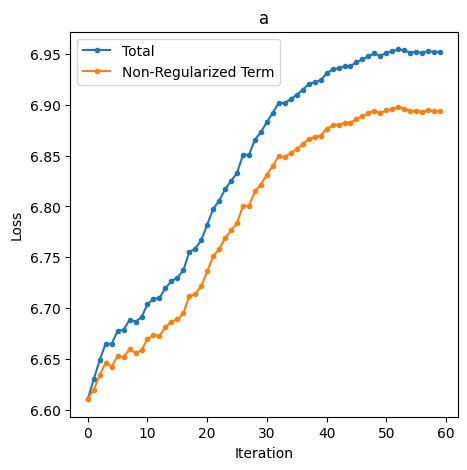

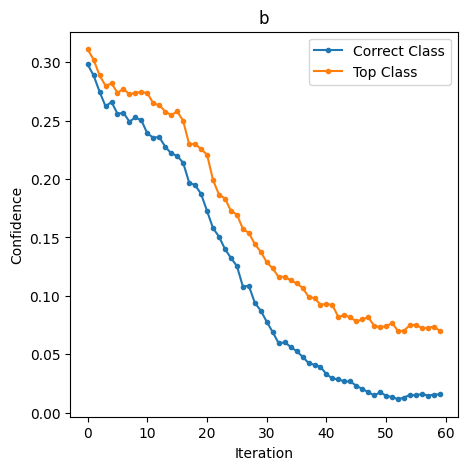

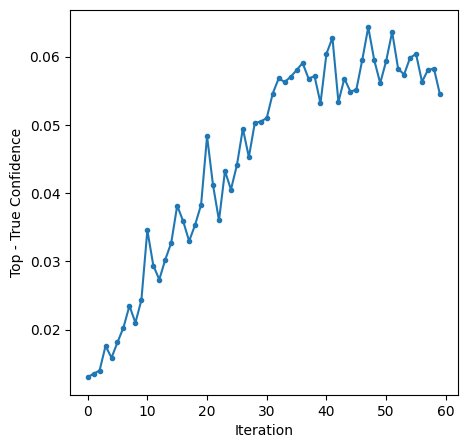

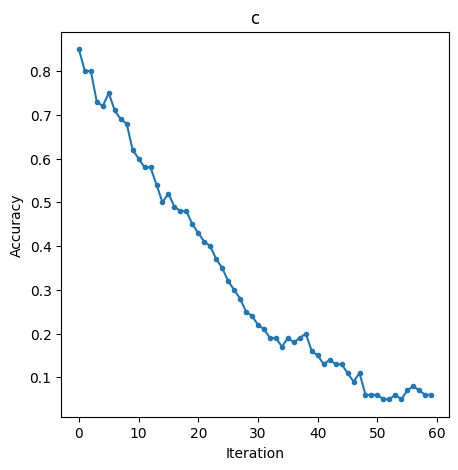

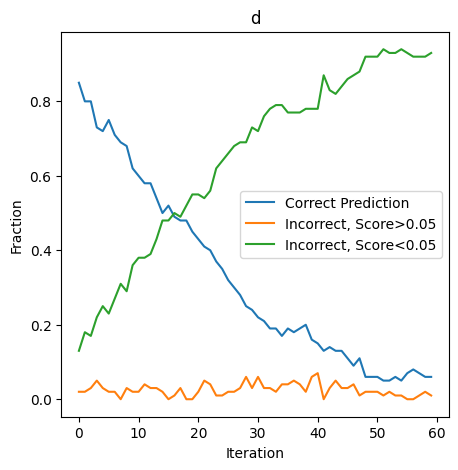

In [ ]:
classes = 'pillow'
n = 100
cuttoff = 60
real_class = 721
right = (top_cat==real_class)[:,0:cuttoff]
bad = (scores < 0.05)[:,0:cuttoff]
wrong_bad = (~right) * bad
wrong_good = (~right) * (~bad)

l  = torch.mean(losses[:,0:cuttoff],dim=0)
r = torch.mean(reg_vals[:,0:cuttoff],dim=0)
s  = torch.mean(scores[:,0:cuttoff],dim=0)
t  = torch.mean(top_per[:,0:cuttoff],dim=0)
a = right.sum(dim=0)/n

wb = wrong_bad.sum(dim=0)/n
wg = wrong_good.sum(dim=0)/n

fig, ax = plt.pyplot.subplots(figsize=(5, 5))
ax.plot(l+r, '.-')
ax.plot(l, '.-')
plt.pyplot.xlabel('Iteration')
plt.pyplot.ylabel('Loss')
plt.pyplot.legend(["Total", "Non-Regularized Term"])
plt.pyplot.title("a")
plt.pyplot.savefig('loss.png')
plt.pyplot.show()

fig, ax = plt.pyplot.subplots(figsize=(5, 5))
ax.plot(s, '.-')
ax.plot(t, ".-")
plt.pyplot.xlabel('Iteration')
plt.pyplot.ylabel('Confidence')
plt.pyplot.legend(["Correct Class", "Top Class"])
plt.pyplot.title("b")
plt.pyplot.savefig('score.png')
plt.pyplot.show()

fig, ax = plt.pyplot.subplots(figsize=(5, 5))
ax.plot(t-s, '.-')
plt.pyplot.xlabel('Iteration')
plt.pyplot.ylabel('Top - True Confidence')
plt.pyplot.show()

right = (top_cat==real_class)
fig, ax = plt.pyplot.subplots(figsize=(5, 5))
ax.plot(a, '.-')
plt.pyplot.xlabel('Iteration')
plt.pyplot.ylabel('Accuracy')
plt.pyplot.title("c")
plt.pyplot.savefig('accuracy.png')
plt.pyplot.show()


fig, ax = plt.pyplot.subplots(figsize=(5, 5))
ax.plot(a,'-')
ax.plot(wg, '-')
ax.plot(wb,'-')
plt.pyplot.xlabel('Iteration')
plt.pyplot.ylabel('Fraction')
plt.pyplot.legend(["Correct Prediction", "Incorrect, Score>0.05", "Incorrect, Score<0.05"])
plt.pyplot.title("d")
plt.pyplot.savefig('quality.png')
plt.pyplot.show()


In [ ]:
idx = losses[:,30] != losses[:,59]
n=100
con30 = n-idx.sum()
con60 = idx.sum()
print(idx.sum())

l1 = torch.mean(losses[idx,:],dim=0)
l2 = torch.mean(losses[~idx,0:30],dim=0)
l  = torch.mean(losses,dim=0)

s1 = torch.mean(scores[idx,:],dim=0)
s2 = torch.mean(scores[~idx,0:30],dim=0)
s  = torch.mean(scores,dim=0)

t1 = torch.mean(top_per[idx,:],dim=0)
t2 = torch.mean(top_per[~idx,0:30],dim=0)
t  = torch.mean(top_per,dim=0)

classes = 'pillow'
real_class = weights.meta["categories"].index(classes)
right = (top_cat==real_class)
print(right.shape)
a1 = right[idx,:].sum(dim=0)/con60
a2 = right[~idx,0:30].sum(dim=0)/con30
a = right.sum(dim=0)/n

bad = (top_per < 0.1)
bad1 = (scores < 0.05)
wrong_bad = (~right) * ~(~bad * ~bad1)
wrong_good = (~right) * (~bad) * (~bad1)

wb1 = wrong_bad[idx,:].sum(dim=0)/con60
wb2 = wrong_bad[~idx,0:30].sum(dim=0)/con30
wb = wrong_bad.sum(dim=0)/n
wg1 = wrong_good[idx,:].sum(dim=0)/con60
wg2 = wrong_good[~idx,0:30].sum(dim=0)/con30
wg = wrong_good.sum(dim=0)/n

fig, ax = plt.pyplot.subplots(figsize=(7, 7))
ax.plot(l1, '.-')
ax.plot(l2, '.-')
ax.plot(l, '-', color='grey', alpha=0.3)
plt.pyplot.xlabel('Iteration')
plt.pyplot.ylabel('Loss')
plt.pyplot.show()

fig, ax = plt.pyplot.subplots(figsize=(7, 7))
ax.plot(s1, '.-')
ax.plot(s2, '.-')
ax.plot(s, '-', color='grey', alpha=0.3)
ax.plot(t1, '.-')
ax.plot(t2, '.-')
ax.plot(t, '-', color='grey', alpha=0.3)
plt.pyplot.xlabel('Iteration')
plt.pyplot.ylabel('Confidence')
plt.pyplot.legend(["Correct","Correct","Correct","Top","Top","Top"])
plt.pyplot.show()

fig, ax = plt.pyplot.subplots(figsize=(7, 7))
ax.plot(t1-s1, '.-')
ax.plot(t2-s2, '.-')
ax.plot(t-s, '-', color='grey', alpha=0.3)
plt.pyplot.xlabel('Iteration')
plt.pyplot.ylabel('Top - True Confidence')
plt.pyplot.show()

fig, ax = plt.pyplot.subplots(figsize=(7, 7))
ax.plot(a1, '.-')
ax.plot(a2, '.-')
ax.plot(a, '-', color='grey', alpha=0.3)
plt.pyplot.xlabel('Iteration')
plt.pyplot.ylabel('Accuracy')
plt.pyplot.show()

fig, ax = plt.pyplot.subplots(figsize=(7, 7))
#ax.plot(a, '-', color='grey', alpha=0.3)
#ax.plot(wb, '-', color='grey', alpha=0.3)
ax.plot(wg, '-', color='grey', alpha=0.3)
#ax.plot(a1, '-')
#ax.plot(a2, '-')
#ax.plot(wb1, '-')
#ax.plot(wb2, '-')
ax.plot(wg1, '-')
ax.plot(wg2, '-')
plt.pyplot.xlabel('Iteration')
plt.pyplot.legend(["Correct", "Incorrect, Bad Scores", "Incorrect, Good Scores"])
plt.pyplot.show()

In [ ]:
classes = 'pillow'
real_class = weights.meta["categories"].index(classes)
right = (top_cat==real_class)
s1,_  = torch.max(scores*(~right*1), dim=1)

print(s1.sort())

torch.return_types.sort(
values=tensor([0.0000, 0.0000, 0.0000, 0.0011, 0.0013, 0.0023, 0.0050, 0.0072, 0.0081,
        0.0085, 0.0102, 0.0117, 0.0127, 0.0128, 0.0134, 0.0154, 0.0167, 0.0184,
        0.0188, 0.0191, 0.0208, 0.0216, 0.0227, 0.0235, 0.0247, 0.0248, 0.0258,
        0.0261, 0.0273, 0.0284, 0.0286, 0.0287, 0.0294, 0.0300, 0.0308, 0.0310,
        0.0320, 0.0320, 0.0321, 0.0355, 0.0363, 0.0364, 0.0366, 0.0379, 0.0379,
        0.0400, 0.0402, 0.0409, 0.0413, 0.0422, 0.0438, 0.0445, 0.0449, 0.0450,
        0.0486, 0.0494, 0.0496, 0.0514, 0.0519, 0.0527, 0.0530, 0.0542, 0.0545,
        0.0546, 0.0565, 0.0571, 0.0597, 0.0597, 0.0636, 0.0640, 0.0645, 0.0672,
        0.0690, 0.0694, 0.0701, 0.0736, 0.0750, 0.0752, 0.0776, 0.0794, 0.0837,
        0.0839, 0.0839, 0.0856, 0.0882, 0.0902, 0.0907, 0.0942, 0.0966, 0.1009,
        0.1034, 0.1086, 0.1152, 0.1170, 0.1260, 0.1493, 0.1648, 0.1713, 0.1853,
        0.1935]),
indices=tensor([36, 65, 15, 25, 20, 82, 31, 74, 46, 26, 90, 30, 12, 34

In [ ]:
classes = 'bookcase'
real_class = weights.meta["categories"].index(classes)
right = (top_cat==real_class)
s1,_  = torch.max(scores*(~right*1), dim=1)

print(s1.sort())



torch.return_types.sort(
values=tensor([0.0006, 0.0016, 0.0020, 0.0027, 0.0058, 0.0068, 0.0074, 0.0079, 0.0081,
        0.0082, 0.0095, 0.0096, 0.0110, 0.0111, 0.0125, 0.0136, 0.0144, 0.0145,
        0.0146, 0.0147, 0.0172, 0.0186, 0.0186, 0.0186, 0.0190, 0.0191, 0.0198,
        0.0202, 0.0206, 0.0221, 0.0222, 0.0250, 0.0251, 0.0265, 0.0281, 0.0282,
        0.0283, 0.0299, 0.0300, 0.0312, 0.0328, 0.0351, 0.0353, 0.0353, 0.0358,
        0.0367, 0.0384, 0.0391, 0.0400, 0.0423, 0.0457, 0.0495, 0.0525, 0.0548,
        0.0550, 0.0585, 0.0586, 0.0595, 0.0612, 0.0622, 0.0651, 0.0656, 0.0769,
        0.0774, 0.0833, 0.0866, 0.0867, 0.0900, 0.0908, 0.0937, 0.0955, 0.0960,
        0.0967, 0.0990, 0.1006, 0.1026, 0.1043, 0.1059, 0.1114, 0.1131, 0.1183,
        0.1198, 0.1224, 0.1225, 0.1226, 0.1254, 0.1303, 0.1306, 0.1315, 0.1356,
        0.1378, 0.1448, 0.1485, 0.1504, 0.1515, 0.1522, 0.1529, 0.1946, 0.1969,
        0.2054]),
indices=tensor([93, 73, 53, 24, 82, 52, 23, 92, 90, 47, 51, 26, 45, 33

In [ ]:
torch.sum(~right, dim=0)

tensor([ 13,  16,  23,  27,  32,  41,  46,  52,  63,  68,  77,  86,  88,  91,
         95,  97,  97,  96,  99, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100])

In [ ]:
### Download the GAN Outputs to a Zip ###
!zip -r /content/file.zip /content

from google.colab import files
files.download("/content/file.zip")

updating: content/ (stored 0%)
updating: content/.config/ (stored 0%)
updating: content/.config/logs/ (stored 0%)
updating: content/.config/logs/2024.05.14/ (stored 0%)
updating: content/.config/logs/2024.05.14/20.30.39.490217.log (deflated 56%)
updating: content/.config/logs/2024.05.14/20.29.33.490626.log (deflated 91%)
updating: content/.config/logs/2024.05.14/20.30.17.694269.log (deflated 86%)
updating: content/.config/logs/2024.05.14/20.30.38.908662.log (deflated 58%)
updating: content/.config/logs/2024.05.14/20.30.07.340625.log (deflated 58%)
updating: content/.config/logs/2024.05.14/20.30.28.535530.log (deflated 58%)
updating: content/.config/active_config (stored 0%)
updating: content/.config/.last_opt_in_prompt.yaml (stored 0%)
updating: content/.config/default_configs.db (deflated 98%)
updating: content/.config/config_sentinel (stored 0%)
updating: content/.config/gce (stored 0%)
updating: content/.config/.last_update_check.json (deflated 22%)
updating: content/.config/configu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for i in range(1000, 1089):
  os.remove("/content/output"+str(i)+"_0.png")

In [ ]:
### Get classifier accuracy on specific classes ###

n = 250
truncation = 1
index = 0
accuracy = torch.zeros(10)
scores = torch.zeros([10,n])

classes = ['bubble', 'pillow', 'baboon', 'bookcase', 'pelican', 'hammerhead', 'jigsaw puzzle', 'mitten', 'palace', 'soccer ball']

model = MyEnsemble(GAN_model, classifier, preprocess)
model.eval()
for param in model.parameters():
  param.requires_grad = False


for c in classes:
    class_vector = torch.from_numpy(one_hot_from_names(c, batch_size=1))
    real_class = weights.meta["categories"].index(c)

    for i in tqdm(range(n)):
        noise_vector = torch.from_numpy(truncated_noise_sample(truncation=truncation, batch_size=1))
        prediction = model(noise_vector, class_vector, truncation, save=False)
        predicted_class = prediction.argmax().item()

        if(predicted_class==real_class):
            accuracy[index] += 1
        scores[index,i] = prediction[real_class]
    index += 1

accuracy /= n

100%|██████████| 250/250 [09:33<00:00,  2.29s/it]


In [ ]:
print("       Category| Acc   | Score (avg,std)")
print("   -------------------------------------")
for i in range(10):
  print("%15s: %.3f | %.4f %.4f" %(classes[i],accuracy[i].item(),scores[i,:].mean().item(),torch.std(scores[i,:]).item()))
  #print(classes[i],": ", accuracy[i].item(), "% | ", scores[i,:].mean().item(), torch.std(scores[i,:]).item())

       Category| Acc   | Score (avg,std)
   -------------------------------------
         bubble: 0.972 | 0.1731 0.0852
         pillow: 0.860 | 0.3307 0.2090
         baboon: 0.904 | 0.1778 0.0745
       bookcase: 0.960 | 0.2858 0.0967
        pelican: 0.600 | 0.1264 0.1054
     hammerhead: 0.856 | 0.1953 0.0911
  jigsaw puzzle: 0.956 | 0.2660 0.1676
         mitten: 0.924 | 0.2396 0.1248
         palace: 0.972 | 0.2239 0.0713
    soccer ball: 0.820 | 0.1905 0.1435


In [ ]:
### Scores and Accuracy ###
print(accuracy)
print()

for i in range(10):
  print(scores[i,:])

tensor([0.9720, 0.8600, 0.9040, 0.9600, 0.6000, 0.8560, 0.9560, 0.9240, 0.9720,
        0.8200])

tensor([0.1999, 0.0843, 0.1825, 0.1838, 0.0714, 0.1626, 0.0830, 0.3125, 0.0720,
        0.2309, 0.2146, 0.3506, 0.2151, 0.4052, 0.2497, 0.2304, 0.3048, 0.0219,
        0.2307, 0.1646, 0.1464, 0.1480, 0.0717, 0.1564, 0.1840, 0.1260, 0.1062,
        0.1644, 0.1037, 0.0774, 0.2275, 0.2588, 0.1250, 0.1298, 0.1993, 0.1089,
        0.2675, 0.2175, 0.1929, 0.1265, 0.1960, 0.1768, 0.1460, 0.1167, 0.1901,
        0.2545, 0.0840, 0.1796, 0.1244, 0.1273, 0.1977, 0.1562, 0.0177, 0.1686,
        0.1977, 0.1175, 0.0579, 0.1339, 0.1795, 0.0038, 0.2079, 0.2035, 0.0008,
        0.0696, 0.1983, 0.1967, 0.2289, 0.2605, 0.0501, 0.0185, 0.1932, 0.2076,
        0.1252, 0.1566, 0.1644, 0.1587, 0.1747, 0.1404, 0.1122, 0.2480, 0.1709,
        0.2420, 0.1702, 0.2696, 0.1432, 0.1543, 0.0956, 0.1562, 0.2150, 0.1374,
        0.3163, 0.2808, 0.2288, 0.1401, 0.2117, 0.1424, 0.2525, 0.0834, 0.1451,
        0.1401, 0.2144

In [ ]:
### Get classifier accuracy on GAN outputs ###
from tqdm import tqdm

model = MyEnsemble(GAN_model, classifier, preprocess)
truncation = 0.5
class_vector = torch.zeros([1,1000])
count=0

for i in tqdm(range(1000)):
  class_vector[0,i] = 1
  noise_vector = torch.from_numpy(truncated_noise_sample(truncation=truncation, batch_size=1)).requires_grad_()

  prediction = model(noise_vector, class_vector, truncation, save=False)
  predicted_class = prediction.argmax().item()
  if(i!=predicted_class):
    count += 1
    real_class = weights.meta["categories"][i]
    predict(model, noise_vector, class_vector, truncation, real_class, (i,count))

  class_vector[0,i] = 0

  2%|▏         | 24/1000 [01:24<55:29,  3.41s/it]

(23, 1):  kite: 8.9%   |   23: 6.0%


  5%|▌         | 51/1000 [02:39<54:51,  3.47s/it]

(50, 2):  African crocodile: 9.1%   |   50: 5.2%


  6%|▌         | 61/1000 [03:10<57:51,  3.70s/it]

(60, 3):  horned viper: 12.5%   |   60: 3.1%


  7%|▋         | 69/1000 [03:32<50:49,  3.28s/it]

(68, 4):  horned viper: 16.9%   |   68: 12.1%


 12%|█▎        | 125/1000 [06:05<49:29,  3.39s/it]

(124, 5):  spiny lobster: 14.3%   |   124: 9.2%


 17%|█▋        | 168/1000 [08:05<50:25,  3.64s/it]

(167, 6):  Walker hound: 12.5%   |   167: 10.1%


 17%|█▋        | 172/1000 [08:18<52:46,  3.82s/it]

(171, 7):  whippet: 8.9%   |   171: 8.0%


 17%|█▋        | 173/1000 [08:23<58:24,  4.24s/it]

(172, 8):  Saluki: 10.1%   |   172: 6.8%


 18%|█▊        | 178/1000 [08:39<49:21,  3.60s/it]

(177, 9):  Irish wolfhound: 11.2%   |   177: 10.0%


 19%|█▉        | 193/1000 [09:21<44:53,  3.34s/it]

(192, 10):  Norwich terrier: 12.8%   |   192: 5.0%


 24%|██▍       | 241/1000 [11:36<45:02,  3.56s/it]

(240, 11):  Greater Swiss Mountain dog: 7.4%   |   240: 5.3%


 24%|██▍       | 242/1000 [11:41<50:36,  4.01s/it]

(241, 12):  Appenzeller: 9.5%   |   241: 7.2%


 25%|██▍       | 249/1000 [12:03<46:16,  3.70s/it]

(248, 13):  malamute: 7.6%   |   248: 6.1%


 25%|██▌       | 251/1000 [12:11<47:31,  3.81s/it]

(250, 14):  Eskimo dog: 8.3%   |   250: 8.0%


 27%|██▋       | 266/1000 [12:52<39:10,  3.20s/it]

(265, 15):  miniature poodle: 10.8%   |   265: 9.9%


 28%|██▊       | 283/1000 [13:40<43:25,  3.63s/it]

(282, 16):  tiger: 16.5%   |   282: 7.7%


 29%|██▊       | 286/1000 [13:51<45:09,  3.79s/it]

(285, 17):  tabby: 13.1%   |   285: 10.2%


 29%|██▉       | 291/1000 [14:07<45:33,  3.86s/it]

(290, 18):  leopard: 12.3%   |   290: 11.8%


 31%|███       | 311/1000 [15:03<40:32,  3.53s/it]

(310, 19):  weevil: 15.6%   |   310: 2.2%


 31%|███▏      | 313/1000 [15:11<43:13,  3.77s/it]

(312, 20):  grasshopper: 10.2%   |   312: 7.9%


 32%|███▏      | 321/1000 [15:35<41:42,  3.69s/it]

(320, 21):  dragonfly: 12.2%   |   320: 9.4%


 34%|███▍      | 342/1000 [16:37<38:41,  3.53s/it]

(341, 22):  wild boar: 10.0%   |   341: 8.2%


 35%|███▍      | 346/1000 [16:51<40:24,  3.71s/it]

(345, 23):  water buffalo: 10.3%   |   345: 3.0%


 35%|███▌      | 350/1000 [17:05<40:21,  3.72s/it]

(349, 24):  ram: 15.5%   |   349: 10.9%


 39%|███▊      | 387/1000 [18:44<34:08,  3.34s/it]

(386, 25):  tusker: 20.8%   |   386: 12.6%


 40%|███▉      | 399/1000 [19:19<35:25,  3.54s/it]

(398, 26):  wig: 4.2%   |   398: 0.1%


 40%|████      | 403/1000 [19:32<37:22,  3.76s/it]

(402, 27):  electric guitar: 13.7%   |   402: 4.5%


 42%|████▏     | 418/1000 [20:14<35:42,  3.68s/it]

(417, 28):  fountain: 3.7%   |   417: 0.5%


 42%|████▏     | 419/1000 [20:19<38:32,  3.98s/it]

(418, 29):  letter opener: 9.6%   |   418: 3.9%


 42%|████▏     | 423/1000 [20:33<37:22,  3.89s/it]

(422, 30):  barbershop: 10.1%   |   422: 0.7%


 43%|████▎     | 428/1000 [20:49<34:52,  3.66s/it]

(427, 31):  rain barrel: 25.1%   |   427: 13.4%


 44%|████▎     | 437/1000 [21:16<33:01,  3.52s/it]

(436, 32):  limousine: 11.0%   |   436: 8.3%


 46%|████▌     | 460/1000 [22:19<31:26,  3.49s/it]

(459, 33):  bikini: 10.6%   |   459: 6.5%


 47%|████▋     | 474/1000 [22:59<29:38,  3.38s/it]

(473, 34):  letter opener: 8.5%   |   473: 4.4%


 48%|████▊     | 483/1000 [23:26<29:17,  3.40s/it]

(482, 35):  tape player: 33.7%   |   482: 18.6%


 49%|████▊     | 486/1000 [23:37<31:02,  3.62s/it]

(485, 36):  tape player: 9.2%   |   485: 2.3%


 49%|████▉     | 489/1000 [23:47<32:13,  3.78s/it]

(488, 37):  pretzel: 29.3%   |   488: 1.8%


 50%|█████     | 500/1000 [24:18<28:06,  3.37s/it]

(499, 38):  ladle: 18.4%   |   499: 0.8%


 51%|█████▏    | 514/1000 [24:58<27:58,  3.45s/it]

(513, 39):  oboe: 8.0%   |   513: 6.4%


 52%|█████▏    | 516/1000 [25:05<30:52,  3.83s/it]

(515, 40):  sombrero: 21.2%   |   515: 2.9%


 52%|█████▏    | 518/1000 [25:13<31:35,  3.93s/it]

(517, 41):  drilling platform: 25.1%   |   517: 5.4%


 52%|█████▎    | 525/1000 [25:34<26:33,  3.35s/it]

(524, 42):  breastplate: 17.2%   |   524: 9.4%


 53%|█████▎    | 527/1000 [25:42<29:36,  3.76s/it]

(526, 43):  desktop computer: 9.9%   |   526: 9.0%


 54%|█████▍    | 542/1000 [26:28<27:05,  3.55s/it]

(541, 44):  barber chair: 4.1%   |   541: 3.4%


 56%|█████▌    | 559/1000 [27:16<25:57,  3.53s/it]

(558, 45):  hatchet: 4.7%   |   558: 3.2%


 58%|█████▊    | 582/1000 [28:18<23:13,  3.33s/it]

(581, 46):  beach wagon: 11.4%   |   581: 8.4%


 60%|█████▉    | 597/1000 [29:01<21:49,  3.25s/it]

(596, 47):  scabbard: 11.8%   |   596: 4.4%


 60%|█████▉    | 599/1000 [29:09<26:11,  3.92s/it]

(598, 48):  television: 14.3%   |   598: 7.8%


 60%|██████    | 603/1000 [29:22<24:42,  3.73s/it]

(602, 49):  balance beam: 16.9%   |   602: 14.6%


 62%|██████▏   | 620/1000 [30:08<21:37,  3.41s/it]

(619, 50):  table lamp: 22.3%   |   619: 16.7%


 63%|██████▎   | 627/1000 [30:31<23:42,  3.81s/it]

(626, 51):  microphone: 13.1%   |   626: 9.3%


 64%|██████▍   | 639/1000 [31:04<19:55,  3.31s/it]

(638, 52):  bikini: 9.9%   |   638: 7.3%


 64%|██████▍   | 642/1000 [31:15<22:03,  3.70s/it]

(641, 53):  tennis ball: 4.9%   |   641: 2.2%


 66%|██████▌   | 660/1000 [32:04<18:45,  3.31s/it]

(659, 54):  consomme: 9.1%   |   659: 6.4%


 66%|██████▋   | 665/1000 [32:20<19:16,  3.45s/it]

(664, 55):  desktop computer: 14.8%   |   664: 9.6%


 68%|██████▊   | 677/1000 [32:54<18:59,  3.53s/it]

(676, 56):  oxygen mask: 6.1%   |   676: 1.9%


 68%|██████▊   | 678/1000 [32:59<20:37,  3.84s/it]

(677, 57):  letter opener: 12.8%   |   677: 2.2%


 68%|██████▊   | 681/1000 [33:10<20:36,  3.88s/it]

(680, 58):  fur coat: 3.7%   |   680: 1.3%


 68%|██████▊   | 682/1000 [33:15<23:05,  4.36s/it]

(681, 59):  laptop: 7.3%   |   681: 5.8%


 69%|██████▉   | 694/1000 [33:50<17:51,  3.50s/it]

(693, 60):  canoe: 11.9%   |   693: 6.0%


 70%|██████▉   | 695/1000 [33:55<19:53,  3.91s/it]

(694, 61):  bookshop: 2.1%   |   694: 0.6%


 70%|███████   | 703/1000 [34:19<17:01,  3.44s/it]

(702, 62):  horizontal bar: 8.1%   |   702: 4.8%


 70%|███████   | 705/1000 [34:27<18:28,  3.76s/it]

(704, 63):  mailbox: 10.7%   |   704: 0.9%


 72%|███████▏  | 721/1000 [35:11<15:53,  3.42s/it]

(720, 64):  jackfruit: 5.0%   |   720: 1.6%


 73%|███████▎  | 732/1000 [35:41<15:33,  3.48s/it]

(731, 65):  violin: 3.1%   |   731: 0.9%


 74%|███████▎  | 735/1000 [35:51<15:54,  3.60s/it]

(734, 66):  ambulance: 10.9%   |   734: 7.8%


 74%|███████▍  | 741/1000 [36:10<16:25,  3.80s/it]

(740, 67):  dumbbell: 4.9%   |   740: 1.1%


 74%|███████▍  | 745/1000 [36:23<16:20,  3.85s/it]

(744, 68):  missile: 16.1%   |   744: 11.1%


 76%|███████▌  | 762/1000 [37:13<13:14,  3.34s/it]

(761, 69):  iron: 5.6%   |   761: 3.0%


 78%|███████▊  | 775/1000 [37:51<13:00,  3.47s/it]

(774, 70):  clog: 8.2%   |   774: 5.7%


 78%|███████▊  | 783/1000 [38:15<13:05,  3.62s/it]

(782, 71):  desktop computer: 11.3%   |   782: 6.4%


 78%|███████▊  | 785/1000 [38:22<13:37,  3.80s/it]

(784, 72):  syringe: 8.5%   |   784: 7.1%


 79%|███████▉  | 791/1000 [38:42<13:10,  3.78s/it]

(790, 73):  chest: 5.2%   |   790: 1.6%


 80%|████████  | 805/1000 [39:20<10:43,  3.30s/it]

(804, 74):  cocktail shaker: 30.0%   |   804: 1.7%


 81%|████████  | 810/1000 [39:37<11:18,  3.57s/it]

(809, 75):  consomme: 20.8%   |   809: 17.2%


 81%|████████▏ | 814/1000 [39:49<11:06,  3.59s/it]

(813, 76):  letter opener: 25.7%   |   813: 2.0%


 82%|████████▏ | 817/1000 [40:00<11:08,  3.66s/it]

(816, 77):  guinea pig: 7.0%   |   816: 1.5%


 84%|████████▍ | 839/1000 [40:59<08:12,  3.06s/it]

(838, 78):  lotion: 17.2%   |   838: 5.8%


 84%|████████▍ | 841/1000 [41:07<09:37,  3.63s/it]

(840, 79):  broom: 19.2%   |   840: 17.4%


 86%|████████▌ | 861/1000 [42:02<08:08,  3.51s/it]

(860, 80):  bookshop: 9.7%   |   860: 6.7%


 86%|████████▋ | 865/1000 [42:16<08:25,  3.75s/it]

(864, 81):  fire engine: 14.7%   |   864: 12.7%


 87%|████████▋ | 869/1000 [42:29<08:30,  3.89s/it]

(868, 82):  washbasin: 3.2%   |   868: 0.5%


 88%|████████▊ | 876/1000 [42:50<06:56,  3.36s/it]

(875, 83):  electric guitar: 3.5%   |   875: 3.0%


 89%|████████▉ | 890/1000 [43:30<06:05,  3.33s/it]

(889, 84):  ox: 3.6%   |   889: 1.8%


 90%|█████████ | 900/1000 [43:59<05:33,  3.34s/it]

(899, 85):  teapot: 7.1%   |   899: 6.4%


 90%|█████████ | 903/1000 [44:10<06:05,  3.76s/it]

(902, 86):  letter opener: 5.5%   |   902: 1.2%


 90%|█████████ | 905/1000 [44:18<06:17,  3.97s/it]

(904, 87):  window shade: 19.0%   |   904: 11.7%


 91%|█████████ | 909/1000 [44:30<05:22,  3.54s/it]

(908, 88):  warplane: 19.4%   |   908: 4.4%


 91%|█████████ | 910/1000 [44:36<06:26,  4.30s/it]

(909, 89):  frying pan: 24.8%   |   909: 16.5%


 91%|█████████ | 911/1000 [44:42<06:44,  4.55s/it]

(910, 90):  bagel: 7.2%   |   910: 1.6%


 93%|█████████▎| 929/1000 [45:32<04:11,  3.54s/it]

(928, 91):  trifle: 6.2%   |   928: 5.3%


 97%|█████████▋| 973/1000 [47:29<01:31,  3.40s/it]

(972, 92):  valley: 16.7%   |   972: 6.8%


 98%|█████████▊| 979/1000 [47:47<01:11,  3.40s/it]

(978, 93):  sandbar: 12.1%   |   978: 8.8%


100%|██████████| 1000/1000 [48:44<00:00,  2.92s/it]

(999, 94):  paper towel: 8.1%   |   999: 6.2%


## OLD

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
import tensorflow as tf

saver = tf.compat.v1.train.import_meta_graph('/content/model.ckpt-790000.meta')
saver.restore(tf.compat.v1.Session(), "/content/model.ckpt-790000")

In [ ]:
new_saver = tf.train.import_meta_graph('/content/model.ckpt-790000.meta')

In [ ]:
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph('/content/model.ckpt-790000.meta')
    saver.restore(sess, "/content/model.ckpt-790000")

InvalidArgumentError: Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Graph execution error:

Detected at node 'input0' defined at (most recent call last):
Node: 'input0'
No OpKernel was registered to support Op 'TPUReplicatedInput' used by {{node input0}} with these attrs: [N=8, is_packed=false, T=DT_INT32, index=-1, is_mirrored_variable=false]
Registered devices: [CPU, GPU]
Registered kernels:
  <no registered kernels>

	 [[input0]]

In [ ]:
saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, "model.ckpt-790000")

### Doesn't work

In [ ]:
!pip install git+https://github.com/lukemelas/pytorch-pretrained-gans

  Cloning https://github.com/lukemelas/pytorch-pretrained-gans to /tmp/pip-req-build-v6ghxj2u
  Running command git clone --filter=blob:none --quiet https://github.com/lukemelas/pytorch-pretrained-gans /tmp/pip-req-build-v6ghxj2u
  Resolved https://github.com/lukemelas/pytorch-pretrained-gans to commit 2982fdab4e683165e45bc2f4a64c2942a7a3a1b7
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
from pytorch_pretrained_gans import make_gan

# Sample a class-conditional image from BigGAN with default resolution 256
G = make_gan(gan_type='biggan')  # -> nn.Module
y = G.sample_class(batch_size=1)  # -> torch.Size([1, 1000])
z = G.sample_latent(batch_size=1)  # -> torch.Size([1, 128])
x = G(z=z, y=y)  # -> torch.Size([1, 3, 256, 256])

ModuleNotFoundError: No module named 'boto3'

#### playground

In [ ]:
classes = ['bubble', 'coffee mug', 'mushroom', 'ambulance', 'strawberry', 'syringe']

# Prepare a input
truncation = 1
class_vector = one_hot_from_names(classes, batch_size=3)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=6)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

#noise_vector = torch.ones_like(noise_vector)/2
#noise_vector[:,2] =2

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
GAN_model.to('cuda')

# Generate an image
with torch.no_grad():
    output = GAN_model(noise_vector, class_vector, truncation)

# If you have a GPU put back on CPU
output = output.to('cpu')

print(output.shape)

# If you have a sixtel compatible terminal you can display the images in the terminal
# (see https://github.com/saitoha/libsixel for details)
#display_in_terminal(output)

# Save results as png images
save_as_images(output)

torch.Size([6, 3, 256, 256])


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

In [ ]:
def transform_output(output):
  return torch.tensor(128*(1+output),dtype=torch.uint8)

def predict(img, n, classes, verbose=True):
  if n==1:
    real_class = weights.meta["categories"].index(classes)
    batch = preprocess(img).unsqueeze(0)
    prediction = model(batch).squeeze(0).softmax(0)

    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    real_score = prediction[real_class].item()
    category_name = weights.meta["categories"][class_id]
    if verbose: print(f"{category_name}: {100 * score:.1f}%   |   {classes}: {100 * real_score:.1f}%")

  else:
    real_class = [weights.meta["categories"].index(i) for i in classes]
    batch = preprocess(img)
    prediction = model(batch).squeeze(0).softmax(dim=1)

    for i in range(n):
      class_id = prediction[i,:].argmax().item()
      score = prediction[i,class_id].item()
      real_score = prediction[i,real_class[i]].item()
      category_name = weights.meta["categories"][class_id]
      if verbose: print(f"{category_name}: {100 * score:.1f}%   |   {classes[i]}: {100 * real_score:.1f}%")
  return prediction

In [ ]:
from torchvision.io import read_image

img = read_image("/content/output_0.png")
predict(img, 1, classes[0])

img = transform_output(output[0])
predict(img, 1, classes[0])

img = transform_output(output)
_=predict(img, 6, classes)



bubble: 34.0%   |   bubble: 34.0%
bubble: 34.0%   |   bubble: 34.0%


<ipython-input-195-e2da88f7f79f>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(128*(1+output),dtype=torch.uint8)


bubble: 34.0%   |   bubble: 34.0%
coffee mug: 27.9%   |   coffee mug: 27.9%
mushroom: 22.9%   |   mushroom: 22.9%
ambulance: 47.0%   |   ambulance: 47.0%
strawberry: 45.3%   |   strawberry: 45.3%
screwdriver: 3.9%   |   syringe: 3.3%


In [ ]:
GAN_model = BigGAN.from_pretrained('biggan-deep-256')

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
#model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

In [ ]:
for param in GAN_model.parameters():
    print(param.grad)

for param in model.parameters():
    print(param.grad)

In [ ]:
for param in GAN_model.parameters():
    param.requires_grad = False

for param in model.parameters():
    param.requires_grad = False

In [ ]:
classes = 'bubble'
real_class = weights.meta["categories"].index(classes)

# Prepare a input
truncation = 1
class_vector = torch.from_numpy(one_hot_from_names(classes, batch_size=1)).to('cuda')
noise_vector = torch.from_numpy(truncated_noise_sample(truncation=truncation, batch_size=1)).requires_grad_().to('cuda')

GAN_model.to('cuda')

# Generate an image
output = GAN_model(noise_vector, class_vector, truncation).to('cpu')
print(output.shape)
save_as_images(output)

torch.Size([1, 3, 256, 256])


In [ ]:
img = transform_output(output[0])
prediction = predict(img, 1, classes, verbose=True)
conf_in_real = prediction[real_class]
print(conf_in_real)

conf_in_real.backward()

<ipython-input-195-e2da88f7f79f>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(128*(1+output),dtype=torch.uint8)


bubble: 40.8%   |   bubble: 40.8%
tensor(0.4085, grad_fn=<SelectBackward0>)


In [ ]:
grad = prediction.grad
#grad = torch.autograd.grad(conf_in_real, [noise_vector])
print(prediction)
#my_opt = torch.optim.SGD(noise_vector)

In [ ]:
batch = preprocess(img).unsqueeze(0)
prediction = model(batch).squeeze(0).softmax(0)

## Unconditional GAN

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np
%load_ext autoreload
%autoreload 2

In [ ]:
num_gpu = 1 if torch.cuda.is_available() else 0

# load the models
from dcgan import Discriminator, Generator

D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

# load weights
D.load_state_dict(torch.load('netD_epoch_199.pth'))
G.load_state_dict(torch.load('netG_epoch_199.pth'))
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

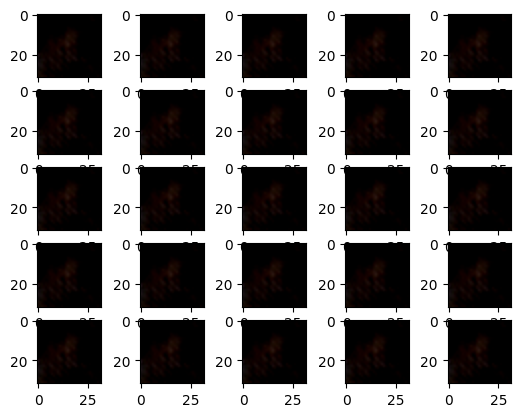

In [ ]:
batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
fixed_noise = torch.ones(batch_size, latent_size, 1, 1)/2
#fixed_noise = torch.round(fixed_noise,decimals=2)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)


# z = torch.randn(batch_size, latent_size).cuda()
# z = Variable(z)
# fake_images = G(z)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 3, 32, 32)
fake_images_np = fake_images_np.transpose((0, 2, 3, 1))
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], interpolation='bilinear')
plt.show()

In [ ]:
outputs = D(fake_images)
print(outputs)

tensor([7.8027e-03, 1.9087e-01, 1.3943e-03, 8.0599e-04, 4.2762e-03, 1.3079e-01,
        3.5584e-02, 4.0655e-02, 1.4359e-01, 9.4407e-01, 9.2678e-02, 1.5985e-02,
        3.5587e-01, 4.5198e-03, 1.7400e-04, 9.8823e-02, 1.4954e-01, 1.8919e-03,
        3.9875e-03, 5.9663e-02, 1.9374e-02, 8.9995e-04, 1.0292e-03, 5.1831e-02,
        2.2574e-01], device='cuda:0', grad_fn=<SqueezeBackward1>)
